# Cycle Generative Adversarial Network

In [1]:
import os
import numpy as np
import math
import itertools
import datetime
import time

import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

In [2]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.utils as vutils
from torch.autograd import Variable

In [3]:
from models import *
from datasets import *
from utils import *

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch

## Set Arguments

In [5]:
epoch = 0
n_epochs = 200
dataset_name = 'horse2zebra'
batch_size = 1
lr = 0.0002
b1 = 0.5
b2 = 0.999
decay_epoch = 100
n_cpu = 8
n_gpu = 1
img_height = 256
img_width = 256
channels = 3
sample_interval = 1000
checkpoint_interval = -1
n_residual_blocks = 9
lambda_cyc = 10.0
lambda_id = 0.5

In [6]:
input_shape = (channels, img_height, img_width)

In [7]:
cuda = torch.cuda.is_available()

## Configure Data Loader

#### Buffers of previously generated samples

In [8]:
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

#### Image transformations

In [9]:
transforms_ = [
    transforms.Resize(int(img_height * 1.12), Image.BICUBIC),
    transforms.RandomCrop((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

#### Training and test data loader

In [10]:
data_loader = DataLoader(
    ImageDataset("./data/%s" % dataset_name, transforms_=transforms_, unaligned=True),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)

print('Total batches:',len(data_loader))

Total batches: 1334


In [11]:
val_data_loader = DataLoader(
    ImageDataset("./data/%s" % dataset_name, transforms_=transforms_, unaligned=True, mode='test'),
    batch_size=5,
    shuffle=True,
    num_workers=1,
)

print('Total batches:',len(val_data_loader))

Total batches: 28


In [12]:
device = torch.device('cuda:0' if (torch.cuda.is_available() and n_gpu > 0) else 'cpu')

## Take a Look The Images

In [13]:
if not os.path.exists("images/%s/" % (dataset_name)):
    os.makedirs("images/%s/" % (dataset_name))

In [14]:
def sample_images(batches_done):
    """Saves a generated sample from the test set"""
    imgs = next(iter(val_data_loader))
    G_AB.eval()
    G_BA.eval()
    real_A = Variable(imgs["A"].type(Tensor))
    fake_B = G_AB(real_A)
    real_B = Variable(imgs["B"].type(Tensor))
    fake_A = G_BA(real_B)
    # Arange images along x-axis
    real_A = vutils.make_grid(real_A, nrow=5, normalize=True)
    real_B = vutils.make_grid(real_B, nrow=5, normalize=True)
    fake_A = vutils.make_grid(fake_A, nrow=5, normalize=True)
    fake_B = vutils.make_grid(fake_B, nrow=5, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    save_image(image_grid, "images/%s/%s.png" % (dataset_name, batches_done), normalize=False)

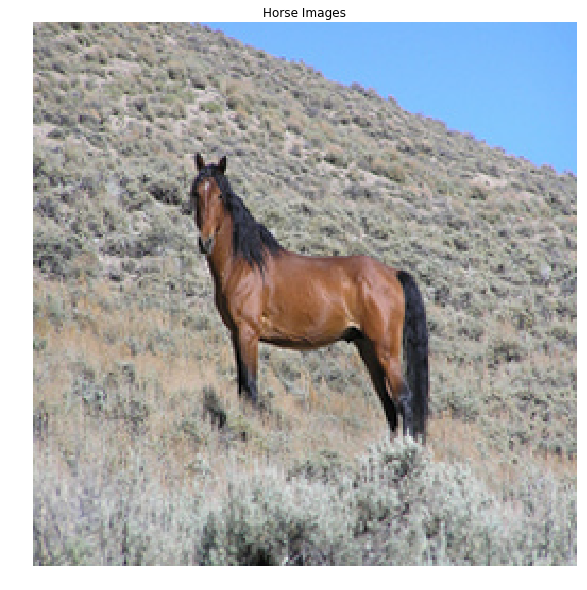

In [15]:
real_batch = next(iter(data_loader))
plt.figure(figsize=(10,10))
plt.axis('off')
image_name = dataset_name.split('2')[0].capitalize()
plt.title('%s Images' % image_name)
plt.imshow(np.transpose(vutils.make_grid(real_batch['A'][0].to(device), padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

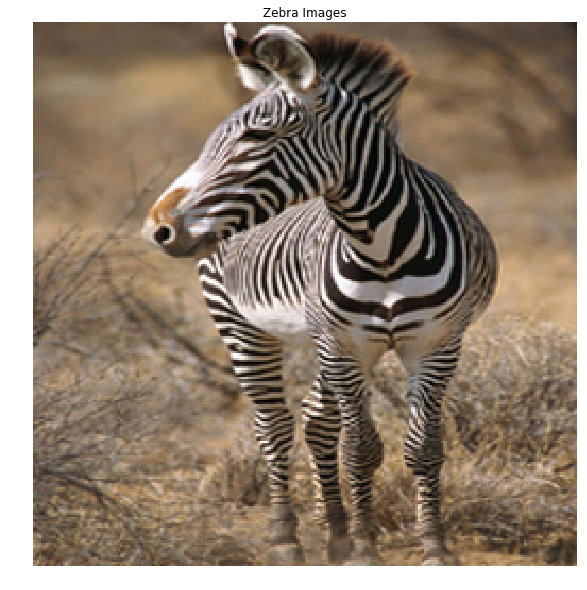

In [16]:
real_batch = next(iter(data_loader))
plt.figure(figsize=(10,10))
plt.axis('off')
image_name = dataset_name.split('2')[1].capitalize()
plt.title('%s Images' % image_name)
plt.imshow(np.transpose(vutils.make_grid(real_batch['B'][0].to(device), padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

## Build GAN Architecture

#### Initialize the generator and discriminator

In [17]:
G_AB = GeneratorResNet(input_shape, n_residual_blocks)
G_BA = GeneratorResNet(input_shape, n_residual_blocks)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

if cuda:
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()

#### Initialize Weights

In [18]:
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d(padding=(1, 0, 1, 0), value=0.0)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

## Loss Function

In [19]:
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

if cuda:
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

## Optimizers

In [20]:
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()),
    lr=lr,
    betas=(b1, b2)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(b1, b2))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(b1, b2))

In [21]:
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

## Learning Rate Update Schedulers

In [22]:
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

## Training The [Network](https://arxiv.org/pdf/1703.10593.pdf)

In [ ]:
g_loss_to_display = []
d_loss_to_display = []
prev_time = time.time()
for epoch in range(epoch, n_epochs):
    for i, batch in enumerate(data_loader):
        
        # set model input
        real_A = Variable(batch['A'].type(Tensor))
        real_B = Variable(batch['B'].type(Tensor))
        
        # adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)   
        
        # -------------------
        # Train Generators
        # -------------------
        
        G_AB.train()
        G_BA.train()
        
        optimizer_G.zero_grad()
        
        # Identity loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)
        
        loss_identity = (loss_id_A + loss_id_B) / 2
        
        # GAN loss
        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        
        # Cycle loss
        recov_A = G_BA(fake_B)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
        
        # Total loss
        loss_G = lambda_id * loss_identity + loss_GAN + lambda_cyc * loss_cycle
        loss_G.backward()
        
        optimizer_G.step()
        
        
        # ----------------------
        # Train Discriminator A
        # ----------------------
        
        optimizer_D_A.zero_grad()
        
        # Real loss
        loss_real = criterion_GAN(D_A(real_A), valid)
        # Fake loss (on batch of previously generated samples)
        fake_A_ = fake_A_buffer.push_and_pop(fake_A)
        loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
        # Total loss
        loss_D_A = (loss_real + loss_fake) / 2
        loss_D_A.backward()
        
        optimizer_D_A.step()
        
        
        # ----------------------
        # Train Discriminator B
        # ----------------------
        
        optimizer_D_B.zero_grad()
        
        # Real loss
        loss_real = criterion_GAN(D_B(real_B), valid)
        # Fake loss (on batch of previously generated samples)
        fake_B_ = fake_B_buffer.push_and_pop(fake_B)
        loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
        # Total loss
        loss_D_B = (loss_real + loss_fake) / 2
        loss_D_B.backward()
        
        optimizer_D_B.step()
        
        # loss Discriminator A & B
        loss_D = (loss_D_A + loss_D_B) / 2
        
        # save losses for plotting later
        g_loss_to_display.append(loss_G.item())
        d_loss_to_display.append(loss_D.item())
        
        # --------------
        # Log Progress
        # --------------
        
        # determine approximate time left
        batches_done = epoch * len(data_loader) + i
        batches_left = n_epochs * len(data_loader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()
        
        # print log
        print(
            "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, identity: %f, adv: %f, cycle: %f] ETA: %s"
            % (
                epoch,
                n_epochs,
                i,
                len(data_loader),
                loss_D.item(),
                loss_G.item(),
                loss_identity.item(),
                loss_GAN.item(),
                loss_cycle.item(),
                time_left,
            )
        )
        
        # if at sample interval save image
        if batches_done % sample_interval == 0:
            sample_images(batches_done)
            
    # update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
        # save model checkpoints
        torch.save(G_AB.state_dict(), "weights/%s/G_AB_%d.pth" % (dataset_name, epoch))
        torch.save(G_BA.state_dict(), "weights/%s/G_BA_%d.pth" % (dataset_name, epoch))
        torch.save(D_A.state_dict(), "weights/%s/D_A_%d.pth" % (dataset_name, epoch))
        torch.save(D_B.state_dict(), "weights/%s/D_B_%d.pth" % (dataset_name, epoch))

[Epoch 0/200] [Batch 0/1334] [D loss: 1.511872] [G loss: 8.567686, identity: 0.684667, adv: 1.402524, cycle: 0.682283] ETA: 3 days, 19:10:00.708103
[Epoch 0/200] [Batch 1/1334] [D loss: 5.472781] [G loss: 10.109856, identity: 0.639296, adv: 3.724819, cycle: 0.606539] ETA: 4 days, 18:03:00.834228
[Epoch 0/200] [Batch 2/1334] [D loss: 4.468745] [G loss: 12.315346, identity: 0.667539, adv: 5.252539, cycle: 0.672904] ETA: 1 day, 0:04:52.124520
[Epoch 0/200] [Batch 3/1334] [D loss: 3.452006] [G loss: 9.394806, identity: 0.574525, adv: 2.940046, cycle: 0.616750] ETA: 1 day, 0:14:28.736495
[Epoch 0/200] [Batch 4/1334] [D loss: 1.596325] [G loss: 7.745857, identity: 0.502493, adv: 2.046665, cycle: 0.544794] ETA: 1 day, 0:50:46.131340
[Epoch 0/200] [Batch 5/1334] [D loss: 1.680398] [G loss: 7.467706, identity: 0.551060, adv: 1.989232, cycle: 0.520294] ETA: 1 day, 0:10:47.741122
[Epoch 0/200] [Batch 6/1334] [D loss: 1.635180] [G loss: 6.981787, identity: 0.568364, adv: 1.597927, cycle: 0.509968]

[Epoch 0/200] [Batch 56/1334] [D loss: 0.441229] [G loss: 4.047663, identity: 0.677452, adv: 0.527058, cycle: 0.318188] ETA: 1 day, 0:32:21.193794
[Epoch 0/200] [Batch 57/1334] [D loss: 0.476738] [G loss: 6.401471, identity: 0.879894, adv: 0.564278, cycle: 0.539725] ETA: 1 day, 0:32:16.919629
[Epoch 0/200] [Batch 58/1334] [D loss: 0.505969] [G loss: 4.264713, identity: 0.571438, adv: 0.563038, cycle: 0.341596] ETA: 1 day, 0:41:56.395459
[Epoch 0/200] [Batch 59/1334] [D loss: 0.444476] [G loss: 3.999991, identity: 0.649316, adv: 0.504155, cycle: 0.317118] ETA: 1 day, 1:12:32.524103
[Epoch 0/200] [Batch 60/1334] [D loss: 0.499980] [G loss: 4.523853, identity: 0.573779, adv: 0.515513, cycle: 0.372145] ETA: 1 day, 1:27:57.184377
[Epoch 0/200] [Batch 61/1334] [D loss: 0.454954] [G loss: 3.402624, identity: 0.486059, adv: 0.441044, cycle: 0.271855] ETA: 1 day, 0:35:19.258854
[Epoch 0/200] [Batch 62/1334] [D loss: 0.384432] [G loss: 4.328868, identity: 0.638373, adv: 0.500687, cycle: 0.350900

[Epoch 0/200] [Batch 112/1334] [D loss: 0.213051] [G loss: 3.376418, identity: 0.850419, adv: 0.448355, cycle: 0.250285] ETA: 1 day, 0:37:03.905548
[Epoch 0/200] [Batch 113/1334] [D loss: 0.486102] [G loss: 3.862048, identity: 0.622223, adv: 0.305505, cycle: 0.324543] ETA: 1 day, 0:39:24.409880
[Epoch 0/200] [Batch 114/1334] [D loss: 0.326493] [G loss: 4.043135, identity: 0.746109, adv: 0.372903, cycle: 0.329718] ETA: 1 day, 0:59:19.117592
[Epoch 0/200] [Batch 115/1334] [D loss: 0.304892] [G loss: 4.077581, identity: 0.781096, adv: 0.342979, cycle: 0.334405] ETA: 1 day, 1:20:26.999981
[Epoch 0/200] [Batch 116/1334] [D loss: 0.323538] [G loss: 4.535985, identity: 0.656755, adv: 0.312018, cycle: 0.389559] ETA: 1 day, 1:29:27.044894
[Epoch 0/200] [Batch 117/1334] [D loss: 0.285179] [G loss: 3.328867, identity: 0.635356, adv: 0.319983, cycle: 0.269121] ETA: 1 day, 0:58:41.736617
[Epoch 0/200] [Batch 118/1334] [D loss: 0.345483] [G loss: 2.860410, identity: 0.597678, adv: 0.223895, cycle: 0

[Epoch 0/200] [Batch 168/1334] [D loss: 0.390486] [G loss: 3.108815, identity: 0.600347, adv: 0.273793, cycle: 0.253485] ETA: 1 day, 0:59:06.114933
[Epoch 0/200] [Batch 169/1334] [D loss: 0.257721] [G loss: 3.075738, identity: 0.629220, adv: 0.371317, cycle: 0.238981] ETA: 1 day, 0:54:36.495986
[Epoch 0/200] [Batch 170/1334] [D loss: 0.258920] [G loss: 4.234479, identity: 0.715273, adv: 0.330618, cycle: 0.354622] ETA: 1 day, 1:38:05.625937
[Epoch 0/200] [Batch 171/1334] [D loss: 0.248605] [G loss: 3.771003, identity: 0.594429, adv: 0.363449, cycle: 0.311034] ETA: 1 day, 1:08:07.349099
[Epoch 0/200] [Batch 172/1334] [D loss: 0.247794] [G loss: 4.048897, identity: 0.676556, adv: 0.358184, cycle: 0.335244] ETA: 1 day, 1:01:48.392349
[Epoch 0/200] [Batch 173/1334] [D loss: 0.328864] [G loss: 3.894543, identity: 0.556725, adv: 0.533432, cycle: 0.308275] ETA: 1 day, 1:38:38.469768
[Epoch 0/200] [Batch 174/1334] [D loss: 0.334051] [G loss: 3.807033, identity: 0.780203, adv: 0.245745, cycle: 0

[Epoch 0/200] [Batch 224/1334] [D loss: 0.287768] [G loss: 2.978878, identity: 0.577598, adv: 0.264684, cycle: 0.242539] ETA: 1 day, 2:07:39.742107
[Epoch 0/200] [Batch 225/1334] [D loss: 0.236431] [G loss: 2.887359, identity: 0.732155, adv: 0.297215, cycle: 0.222407] ETA: 1 day, 1:26:24.311104
[Epoch 0/200] [Batch 226/1334] [D loss: 0.282225] [G loss: 3.311512, identity: 0.532631, adv: 0.385947, cycle: 0.265925] ETA: 1 day, 0:57:10.833481
[Epoch 0/200] [Batch 227/1334] [D loss: 0.303773] [G loss: 2.853333, identity: 0.619962, adv: 0.282619, cycle: 0.226073] ETA: 1 day, 1:11:19.794737
[Epoch 0/200] [Batch 228/1334] [D loss: 0.244576] [G loss: 3.563732, identity: 0.743551, adv: 0.328537, cycle: 0.286342] ETA: 1 day, 1:02:26.921211
[Epoch 0/200] [Batch 229/1334] [D loss: 0.254859] [G loss: 3.212182, identity: 0.740130, adv: 0.289152, cycle: 0.255296] ETA: 1 day, 0:52:27.572650
[Epoch 0/200] [Batch 230/1334] [D loss: 0.328644] [G loss: 2.608021, identity: 0.908595, adv: 0.160256, cycle: 0

[Epoch 0/200] [Batch 280/1334] [D loss: 0.329707] [G loss: 3.541005, identity: 0.532964, adv: 0.487938, cycle: 0.278659] ETA: 1 day, 1:00:47.873783
[Epoch 0/200] [Batch 281/1334] [D loss: 0.448493] [G loss: 3.514916, identity: 0.626762, adv: 0.388346, cycle: 0.281319] ETA: 1 day, 1:34:50.128266
[Epoch 0/200] [Batch 282/1334] [D loss: 0.258938] [G loss: 3.686453, identity: 0.761486, adv: 0.406997, cycle: 0.289871] ETA: 1 day, 0:56:23.431712
[Epoch 0/200] [Batch 283/1334] [D loss: 0.254290] [G loss: 3.751466, identity: 0.755453, adv: 0.248613, cycle: 0.312513] ETA: 1 day, 0:57:00.902686
[Epoch 0/200] [Batch 284/1334] [D loss: 0.240460] [G loss: 3.184734, identity: 0.733247, adv: 0.295741, cycle: 0.252237] ETA: 1 day, 1:19:40.054589
[Epoch 0/200] [Batch 285/1334] [D loss: 0.279146] [G loss: 3.050932, identity: 0.797522, adv: 0.319661, cycle: 0.233251] ETA: 1 day, 1:24:27.367682
[Epoch 0/200] [Batch 286/1334] [D loss: 0.287995] [G loss: 2.908097, identity: 0.658121, adv: 0.485499, cycle: 0

[Epoch 0/200] [Batch 336/1334] [D loss: 0.263731] [G loss: 4.637767, identity: 0.691969, adv: 0.400282, cycle: 0.389150] ETA: 1 day, 3:20:00.996071
[Epoch 0/200] [Batch 337/1334] [D loss: 0.333911] [G loss: 3.211814, identity: 0.695553, adv: 0.247523, cycle: 0.261652] ETA: 1 day, 3:18:16.755678
[Epoch 0/200] [Batch 338/1334] [D loss: 0.309232] [G loss: 3.428293, identity: 0.711717, adv: 0.265415, cycle: 0.280702] ETA: 1 day, 2:21:26.377802
[Epoch 0/200] [Batch 339/1334] [D loss: 0.280866] [G loss: 4.428836, identity: 0.710918, adv: 0.361953, cycle: 0.371142] ETA: 1 day, 1:26:07.761762
[Epoch 0/200] [Batch 340/1334] [D loss: 0.324807] [G loss: 3.359534, identity: 0.692022, adv: 0.430162, cycle: 0.258336] ETA: 1 day, 1:19:56.980433
[Epoch 0/200] [Batch 341/1334] [D loss: 0.232354] [G loss: 3.972895, identity: 0.502339, adv: 0.513026, cycle: 0.320870] ETA: 1 day, 1:42:28.339950
[Epoch 0/200] [Batch 342/1334] [D loss: 0.322076] [G loss: 3.418722, identity: 0.643163, adv: 0.281826, cycle: 0

[Epoch 0/200] [Batch 392/1334] [D loss: 0.179393] [G loss: 4.291188, identity: 0.749220, adv: 0.541839, cycle: 0.337474] ETA: 1 day, 1:26:59.607450
[Epoch 0/200] [Batch 393/1334] [D loss: 0.292333] [G loss: 3.038805, identity: 0.785302, adv: 0.344125, cycle: 0.230203] ETA: 1 day, 1:44:53.007920
[Epoch 0/200] [Batch 394/1334] [D loss: 0.352971] [G loss: 3.407326, identity: 0.657303, adv: 0.429314, cycle: 0.264936] ETA: 1 day, 1:31:25.496876
[Epoch 0/200] [Batch 395/1334] [D loss: 0.338475] [G loss: 3.255224, identity: 0.552661, adv: 0.216996, cycle: 0.276190] ETA: 1 day, 1:06:14.680313
[Epoch 0/200] [Batch 396/1334] [D loss: 0.286214] [G loss: 3.812498, identity: 0.712313, adv: 0.422725, cycle: 0.303362] ETA: 1 day, 1:06:20.057485
[Epoch 0/200] [Batch 397/1334] [D loss: 0.233961] [G loss: 4.696370, identity: 0.568766, adv: 0.467433, cycle: 0.394455] ETA: 1 day, 0:51:52.986739
[Epoch 0/200] [Batch 398/1334] [D loss: 0.196511] [G loss: 3.693429, identity: 0.758772, adv: 0.422749, cycle: 0

[Epoch 0/200] [Batch 448/1334] [D loss: 0.209836] [G loss: 3.623960, identity: 0.579080, adv: 0.511715, cycle: 0.282270] ETA: 1 day, 1:48:09.147423
[Epoch 0/200] [Batch 449/1334] [D loss: 0.290028] [G loss: 2.721125, identity: 0.491533, adv: 0.428651, cycle: 0.204671] ETA: 1 day, 1:28:02.304668
[Epoch 0/200] [Batch 450/1334] [D loss: 0.269874] [G loss: 3.448600, identity: 0.469250, adv: 0.355983, cycle: 0.285799] ETA: 1 day, 1:33:15.854735
[Epoch 0/200] [Batch 451/1334] [D loss: 0.228744] [G loss: 4.154058, identity: 0.591088, adv: 0.386643, cycle: 0.347187] ETA: 1 day, 1:53:13.230939
[Epoch 0/200] [Batch 452/1334] [D loss: 0.221556] [G loss: 3.711740, identity: 0.615337, adv: 0.465055, cycle: 0.293902] ETA: 1 day, 1:23:36.784891
[Epoch 0/200] [Batch 453/1334] [D loss: 0.315248] [G loss: 3.708582, identity: 0.626430, adv: 0.320348, cycle: 0.307502] ETA: 1 day, 1:22:26.779894
[Epoch 0/200] [Batch 454/1334] [D loss: 0.330916] [G loss: 4.029483, identity: 0.562225, adv: 0.508587, cycle: 0

[Epoch 0/200] [Batch 504/1334] [D loss: 0.339996] [G loss: 3.043389, identity: 0.767232, adv: 0.370021, cycle: 0.228975] ETA: 1 day, 0:58:11.115324
[Epoch 0/200] [Batch 505/1334] [D loss: 0.320030] [G loss: 4.092693, identity: 0.699170, adv: 0.353352, cycle: 0.338976] ETA: 1 day, 1:22:43.103338
[Epoch 0/200] [Batch 506/1334] [D loss: 0.290696] [G loss: 4.455496, identity: 0.709864, adv: 0.293226, cycle: 0.380734] ETA: 1 day, 1:42:39.218691
[Epoch 0/200] [Batch 507/1334] [D loss: 0.220589] [G loss: 3.063777, identity: 0.641884, adv: 0.372355, cycle: 0.237048] ETA: 1 day, 1:06:25.953283
[Epoch 0/200] [Batch 508/1334] [D loss: 0.285636] [G loss: 3.660105, identity: 0.821648, adv: 0.258823, cycle: 0.299046] ETA: 1 day, 1:12:49.976026
[Epoch 0/200] [Batch 509/1334] [D loss: 0.391158] [G loss: 3.489143, identity: 0.642656, adv: 0.282931, cycle: 0.288488] ETA: 1 day, 1:06:00.196392
[Epoch 0/200] [Batch 510/1334] [D loss: 0.334968] [G loss: 4.688990, identity: 0.617692, adv: 0.520477, cycle: 0

[Epoch 0/200] [Batch 560/1334] [D loss: 0.355240] [G loss: 2.759257, identity: 0.608897, adv: 0.531495, cycle: 0.192331] ETA: 1 day, 3:15:53.173828
[Epoch 0/200] [Batch 561/1334] [D loss: 0.258763] [G loss: 2.712296, identity: 0.579314, adv: 0.469753, cycle: 0.195289] ETA: 1 day, 3:08:44.784311
[Epoch 0/200] [Batch 562/1334] [D loss: 0.320239] [G loss: 3.460094, identity: 0.646094, adv: 0.229037, cycle: 0.290801] ETA: 1 day, 3:31:40.769219
[Epoch 0/200] [Batch 563/1334] [D loss: 0.209778] [G loss: 4.015218, identity: 0.691348, adv: 0.254969, cycle: 0.341458] ETA: 1 day, 3:12:59.096152
[Epoch 0/200] [Batch 564/1334] [D loss: 0.305165] [G loss: 2.902451, identity: 0.530643, adv: 0.369722, cycle: 0.226741] ETA: 1 day, 2:40:05.906215
[Epoch 0/200] [Batch 565/1334] [D loss: 0.260574] [G loss: 2.947146, identity: 0.794362, adv: 0.279939, cycle: 0.227003] ETA: 1 day, 1:27:27.453629
[Epoch 0/200] [Batch 566/1334] [D loss: 0.241766] [G loss: 2.793360, identity: 0.494091, adv: 0.347000, cycle: 0

[Epoch 0/200] [Batch 616/1334] [D loss: 0.377170] [G loss: 2.841714, identity: 0.610938, adv: 0.563673, cycle: 0.197257] ETA: 1 day, 3:13:15.448093
[Epoch 0/200] [Batch 617/1334] [D loss: 0.250418] [G loss: 2.778337, identity: 0.787554, adv: 0.303737, cycle: 0.208082] ETA: 1 day, 2:49:24.688004
[Epoch 0/200] [Batch 618/1334] [D loss: 0.302768] [G loss: 3.828743, identity: 0.717563, adv: 0.406572, cycle: 0.306339] ETA: 1 day, 1:28:38.310843
[Epoch 0/200] [Batch 619/1334] [D loss: 0.329005] [G loss: 3.130595, identity: 0.561492, adv: 0.422359, cycle: 0.242749] ETA: 1 day, 2:44:27.148360
[Epoch 0/200] [Batch 620/1334] [D loss: 0.190938] [G loss: 4.811628, identity: 1.141701, adv: 0.285332, cycle: 0.395544] ETA: 1 day, 1:09:25.654807
[Epoch 0/200] [Batch 621/1334] [D loss: 0.276384] [G loss: 2.902602, identity: 0.692265, adv: 0.345915, cycle: 0.221055] ETA: 1 day, 1:26:39.935860
[Epoch 0/200] [Batch 622/1334] [D loss: 0.261755] [G loss: 3.220686, identity: 0.543094, adv: 0.273056, cycle: 0

[Epoch 0/200] [Batch 672/1334] [D loss: 0.302827] [G loss: 4.251131, identity: 0.598103, adv: 0.436634, cycle: 0.351544] ETA: 1 day, 0:47:37.899670
[Epoch 0/200] [Batch 673/1334] [D loss: 0.255725] [G loss: 3.898479, identity: 0.787017, adv: 0.508332, cycle: 0.299664] ETA: 1 day, 1:07:40.695992
[Epoch 0/200] [Batch 674/1334] [D loss: 0.246636] [G loss: 4.202806, identity: 0.764781, adv: 0.326156, cycle: 0.349426] ETA: 1 day, 0:58:54.170345
[Epoch 0/200] [Batch 675/1334] [D loss: 0.277026] [G loss: 3.089813, identity: 0.546710, adv: 0.307184, cycle: 0.250927] ETA: 1 day, 2:06:17.890521
[Epoch 0/200] [Batch 676/1334] [D loss: 0.216034] [G loss: 3.378969, identity: 0.709423, adv: 0.414358, cycle: 0.260990] ETA: 1 day, 3:12:47.014246
[Epoch 0/200] [Batch 677/1334] [D loss: 0.182064] [G loss: 3.923989, identity: 0.696992, adv: 0.294753, cycle: 0.328074] ETA: 1 day, 3:07:22.106186
[Epoch 0/200] [Batch 678/1334] [D loss: 0.251843] [G loss: 3.297832, identity: 0.684193, adv: 0.390610, cycle: 0

[Epoch 0/200] [Batch 728/1334] [D loss: 0.272924] [G loss: 5.602834, identity: 0.744124, adv: 0.340655, cycle: 0.489012] ETA: 1 day, 1:20:50.435499
[Epoch 0/200] [Batch 729/1334] [D loss: 0.260578] [G loss: 2.940859, identity: 0.671448, adv: 0.366274, cycle: 0.223886] ETA: 1 day, 1:24:01.162590
[Epoch 0/200] [Batch 730/1334] [D loss: 0.351579] [G loss: 2.551220, identity: 0.590374, adv: 0.411603, cycle: 0.184443] ETA: 1 day, 2:54:16.162605
[Epoch 0/200] [Batch 731/1334] [D loss: 0.201073] [G loss: 2.709614, identity: 0.664997, adv: 0.292163, cycle: 0.208495] ETA: 1 day, 3:18:34.694946
[Epoch 0/200] [Batch 732/1334] [D loss: 0.231297] [G loss: 3.198667, identity: 0.708073, adv: 0.511315, cycle: 0.233332] ETA: 1 day, 2:29:26.982704
[Epoch 0/200] [Batch 733/1334] [D loss: 0.171302] [G loss: 3.496073, identity: 0.592188, adv: 0.340469, cycle: 0.285951] ETA: 1 day, 2:18:35.841366
[Epoch 0/200] [Batch 734/1334] [D loss: 0.233672] [G loss: 2.640702, identity: 0.739243, adv: 0.391937, cycle: 0

[Epoch 0/200] [Batch 784/1334] [D loss: 0.190783] [G loss: 4.146876, identity: 0.569767, adv: 0.379526, cycle: 0.348247] ETA: 1 day, 3:48:26.539787
[Epoch 0/200] [Batch 785/1334] [D loss: 0.234560] [G loss: 4.499620, identity: 0.843677, adv: 0.188675, cycle: 0.388911] ETA: 1 day, 3:28:09.394782
[Epoch 0/200] [Batch 786/1334] [D loss: 0.255194] [G loss: 4.063506, identity: 0.700356, adv: 0.335900, cycle: 0.337743] ETA: 1 day, 5:32:50.425782
[Epoch 0/200] [Batch 787/1334] [D loss: 0.285380] [G loss: 2.764839, identity: 0.780927, adv: 0.349070, cycle: 0.202531] ETA: 1 day, 2:55:46.782981
[Epoch 0/200] [Batch 788/1334] [D loss: 0.287719] [G loss: 2.736886, identity: 0.421934, adv: 0.528988, cycle: 0.199693] ETA: 1 day, 3:36:35.974286
[Epoch 0/200] [Batch 789/1334] [D loss: 0.208285] [G loss: 3.112009, identity: 0.483209, adv: 0.456321, cycle: 0.241408] ETA: 1 day, 3:36:55.641975
[Epoch 0/200] [Batch 790/1334] [D loss: 0.282092] [G loss: 2.927279, identity: 0.559934, adv: 0.365407, cycle: 0

[Epoch 0/200] [Batch 840/1334] [D loss: 0.372968] [G loss: 3.484761, identity: 0.720336, adv: 0.207526, cycle: 0.291707] ETA: 1 day, 1:51:19.253197
[Epoch 0/200] [Batch 841/1334] [D loss: 0.247458] [G loss: 2.653215, identity: 0.563370, adv: 0.454172, cycle: 0.191736] ETA: 1 day, 1:49:21.341885
[Epoch 0/200] [Batch 842/1334] [D loss: 0.270931] [G loss: 3.130706, identity: 0.615076, adv: 0.593422, cycle: 0.222975] ETA: 1 day, 0:57:00.835588
[Epoch 0/200] [Batch 843/1334] [D loss: 0.263567] [G loss: 3.519180, identity: 0.767762, adv: 0.337113, cycle: 0.279819] ETA: 1 day, 2:26:10.639835
[Epoch 0/200] [Batch 844/1334] [D loss: 0.231891] [G loss: 3.560119, identity: 0.754700, adv: 0.306557, cycle: 0.287621] ETA: 1 day, 3:28:25.570624
[Epoch 0/200] [Batch 845/1334] [D loss: 0.272248] [G loss: 3.189021, identity: 0.763202, adv: 0.231769, cycle: 0.257565] ETA: 1 day, 3:11:47.591026
[Epoch 0/200] [Batch 846/1334] [D loss: 0.208375] [G loss: 4.510317, identity: 0.519738, adv: 0.416843, cycle: 0

[Epoch 0/200] [Batch 896/1334] [D loss: 0.251500] [G loss: 3.438403, identity: 0.612306, adv: 0.455299, cycle: 0.267695] ETA: 1 day, 1:09:43.706112
[Epoch 0/200] [Batch 897/1334] [D loss: 0.247768] [G loss: 3.689252, identity: 0.764696, adv: 0.481565, cycle: 0.282534] ETA: 1 day, 0:55:58.073516
[Epoch 0/200] [Batch 898/1334] [D loss: 0.210660] [G loss: 2.687840, identity: 0.625303, adv: 0.506879, cycle: 0.186831] ETA: 1 day, 1:06:01.582638
[Epoch 0/200] [Batch 899/1334] [D loss: 0.322664] [G loss: 3.670335, identity: 0.619654, adv: 0.374427, cycle: 0.298608] ETA: 1 day, 0:47:12.291494
[Epoch 0/200] [Batch 900/1334] [D loss: 0.265986] [G loss: 3.529286, identity: 0.671955, adv: 0.607320, cycle: 0.258599] ETA: 1 day, 0:46:21.239510
[Epoch 0/200] [Batch 901/1334] [D loss: 0.212379] [G loss: 4.156016, identity: 0.566126, adv: 0.555650, cycle: 0.331730] ETA: 1 day, 1:16:22.407269
[Epoch 0/200] [Batch 902/1334] [D loss: 0.337653] [G loss: 3.350372, identity: 0.581934, adv: 0.530990, cycle: 0

[Epoch 0/200] [Batch 952/1334] [D loss: 0.197277] [G loss: 3.284581, identity: 0.851700, adv: 0.367469, cycle: 0.249126] ETA: 1 day, 1:36:17.538780
[Epoch 0/200] [Batch 953/1334] [D loss: 0.250199] [G loss: 3.757209, identity: 0.744839, adv: 0.406980, cycle: 0.297781] ETA: 1 day, 0:57:08.730173
[Epoch 0/200] [Batch 954/1334] [D loss: 0.231750] [G loss: 3.805096, identity: 0.654303, adv: 0.495904, cycle: 0.298204] ETA: 1 day, 0:56:02.474346
[Epoch 0/200] [Batch 955/1334] [D loss: 0.331896] [G loss: 3.447081, identity: 0.731272, adv: 0.460114, cycle: 0.262133] ETA: 1 day, 1:13:19.959905
[Epoch 0/200] [Batch 956/1334] [D loss: 0.228687] [G loss: 2.869238, identity: 0.771441, adv: 0.297527, cycle: 0.218599] ETA: 1 day, 0:57:24.702900
[Epoch 0/200] [Batch 957/1334] [D loss: 0.255323] [G loss: 3.151826, identity: 0.615229, adv: 0.232164, cycle: 0.261205] ETA: 1 day, 1:57:50.127120
[Epoch 0/200] [Batch 958/1334] [D loss: 0.194632] [G loss: 2.691796, identity: 0.522102, adv: 0.437045, cycle: 0

[Epoch 0/200] [Batch 1008/1334] [D loss: 0.222595] [G loss: 3.200236, identity: 0.446389, adv: 0.493172, cycle: 0.248387] ETA: 1 day, 2:22:21.448090
[Epoch 0/200] [Batch 1009/1334] [D loss: 0.286827] [G loss: 5.015396, identity: 0.693118, adv: 0.367831, cycle: 0.430101] ETA: 1 day, 1:39:02.117069
[Epoch 0/200] [Batch 1010/1334] [D loss: 0.233459] [G loss: 4.433483, identity: 0.721063, adv: 0.660527, cycle: 0.341242] ETA: 1 day, 1:02:22.729094
[Epoch 0/200] [Batch 1011/1334] [D loss: 0.370805] [G loss: 4.815432, identity: 0.815694, adv: 0.452363, cycle: 0.395522] ETA: 1 day, 1:11:11.014440
[Epoch 0/200] [Batch 1012/1334] [D loss: 0.237050] [G loss: 3.091461, identity: 0.675250, adv: 0.263167, cycle: 0.249067] ETA: 1 day, 0:56:39.795919
[Epoch 0/200] [Batch 1013/1334] [D loss: 0.193484] [G loss: 2.993500, identity: 0.527200, adv: 0.426755, cycle: 0.230315] ETA: 1 day, 0:46:03.110989
[Epoch 0/200] [Batch 1014/1334] [D loss: 0.328822] [G loss: 3.073776, identity: 0.558473, adv: 0.562388, c

[Epoch 0/200] [Batch 1063/1334] [D loss: 0.218868] [G loss: 2.647347, identity: 0.409708, adv: 0.490160, cycle: 0.195233] ETA: 1 day, 2:24:01.165883
[Epoch 0/200] [Batch 1064/1334] [D loss: 0.265535] [G loss: 3.368996, identity: 0.723358, adv: 0.392379, cycle: 0.261494] ETA: 1 day, 1:49:46.730402
[Epoch 0/200] [Batch 1065/1334] [D loss: 0.227049] [G loss: 2.435192, identity: 0.699202, adv: 0.363441, cycle: 0.172215] ETA: 1 day, 1:49:14.892468
[Epoch 0/200] [Batch 1066/1334] [D loss: 0.196749] [G loss: 2.253255, identity: 0.691455, adv: 0.222108, cycle: 0.168542] ETA: 1 day, 2:37:36.243925
[Epoch 0/200] [Batch 1067/1334] [D loss: 0.191006] [G loss: 3.441836, identity: 0.502432, adv: 0.204561, cycle: 0.298606] ETA: 1 day, 1:38:23.403274
[Epoch 0/200] [Batch 1068/1334] [D loss: 0.152666] [G loss: 3.621617, identity: 0.546688, adv: 0.567148, cycle: 0.278112] ETA: 1 day, 1:09:37.380285
[Epoch 0/200] [Batch 1069/1334] [D loss: 0.265640] [G loss: 2.737302, identity: 0.687338, adv: 0.516440, c

[Epoch 0/200] [Batch 1118/1334] [D loss: 0.167755] [G loss: 2.714561, identity: 0.404079, adv: 0.582038, cycle: 0.193048] ETA: 1 day, 2:48:56.735525
[Epoch 0/200] [Batch 1119/1334] [D loss: 0.172631] [G loss: 3.380134, identity: 0.570085, adv: 0.491536, cycle: 0.260356] ETA: 1 day, 1:47:59.690926
[Epoch 0/200] [Batch 1120/1334] [D loss: 0.189211] [G loss: 3.449803, identity: 0.567898, adv: 0.441944, cycle: 0.272391] ETA: 1 day, 1:21:13.024979
[Epoch 0/200] [Batch 1121/1334] [D loss: 0.248449] [G loss: 3.793619, identity: 0.539872, adv: 0.360169, cycle: 0.316351] ETA: 1 day, 3:08:06.901027
[Epoch 0/200] [Batch 1122/1334] [D loss: 0.210386] [G loss: 3.204413, identity: 0.616857, adv: 0.338474, cycle: 0.255751] ETA: 1 day, 3:31:25.517368
[Epoch 0/200] [Batch 1123/1334] [D loss: 0.208911] [G loss: 2.614348, identity: 0.627380, adv: 0.402797, cycle: 0.189786] ETA: 1 day, 2:07:42.920871
[Epoch 0/200] [Batch 1124/1334] [D loss: 0.178115] [G loss: 3.341259, identity: 0.834160, adv: 0.308421, c

[Epoch 0/200] [Batch 1173/1334] [D loss: 0.253608] [G loss: 3.082456, identity: 0.622233, adv: 0.361504, cycle: 0.240983] ETA: 1 day, 4:05:26.318392
[Epoch 0/200] [Batch 1174/1334] [D loss: 0.302019] [G loss: 3.028391, identity: 0.585808, adv: 0.547258, cycle: 0.218823] ETA: 1 day, 3:16:27.987605
[Epoch 0/200] [Batch 1175/1334] [D loss: 0.175101] [G loss: 3.836051, identity: 0.731975, adv: 0.554607, cycle: 0.291546] ETA: 1 day, 3:21:02.279886
[Epoch 0/200] [Batch 1176/1334] [D loss: 0.311508] [G loss: 2.408068, identity: 0.690324, adv: 0.492338, cycle: 0.157057] ETA: 1 day, 3:18:31.184526
[Epoch 0/200] [Batch 1177/1334] [D loss: 0.191183] [G loss: 3.478678, identity: 0.522189, adv: 0.398218, cycle: 0.281937] ETA: 1 day, 3:07:02.486531
[Epoch 0/200] [Batch 1178/1334] [D loss: 0.183585] [G loss: 3.043154, identity: 0.601449, adv: 0.637714, cycle: 0.210472] ETA: 1 day, 3:08:36.732862
[Epoch 0/200] [Batch 1179/1334] [D loss: 0.222641] [G loss: 2.859985, identity: 0.558385, adv: 0.673922, c

[Epoch 0/200] [Batch 1228/1334] [D loss: 0.217387] [G loss: 2.840555, identity: 0.563991, adv: 0.467628, cycle: 0.209093] ETA: 1 day, 0:41:25.140767
[Epoch 0/200] [Batch 1229/1334] [D loss: 0.146058] [G loss: 2.870599, identity: 0.580013, adv: 0.540148, cycle: 0.204044] ETA: 1 day, 0:53:49.921242
[Epoch 0/200] [Batch 1230/1334] [D loss: 0.141925] [G loss: 3.266584, identity: 0.682587, adv: 0.490511, cycle: 0.243478] ETA: 1 day, 1:06:07.604620
[Epoch 0/200] [Batch 1231/1334] [D loss: 0.354012] [G loss: 3.645951, identity: 0.769828, adv: 0.265064, cycle: 0.299597] ETA: 1 day, 1:21:00.534704
[Epoch 0/200] [Batch 1232/1334] [D loss: 0.256219] [G loss: 4.530322, identity: 0.615685, adv: 0.700894, cycle: 0.352159] ETA: 1 day, 0:44:13.299850
[Epoch 0/200] [Batch 1233/1334] [D loss: 0.208390] [G loss: 3.290999, identity: 0.562291, adv: 0.383848, cycle: 0.262601] ETA: 1 day, 0:46:24.028860
[Epoch 0/200] [Batch 1234/1334] [D loss: 0.195410] [G loss: 3.463727, identity: 0.591536, adv: 0.545839, c

[Epoch 0/200] [Batch 1283/1334] [D loss: 0.223641] [G loss: 3.857203, identity: 0.506954, adv: 0.355233, cycle: 0.324849] ETA: 1 day, 0:45:13.112533
[Epoch 0/200] [Batch 1284/1334] [D loss: 0.215985] [G loss: 3.529384, identity: 0.622859, adv: 0.616798, cycle: 0.260116] ETA: 1 day, 0:42:48.380608
[Epoch 0/200] [Batch 1285/1334] [D loss: 0.186105] [G loss: 4.050871, identity: 0.756016, adv: 0.513469, cycle: 0.315939] ETA: 1 day, 0:35:47.898813
[Epoch 0/200] [Batch 1286/1334] [D loss: 0.266594] [G loss: 2.611561, identity: 0.749461, adv: 0.491594, cycle: 0.174524] ETA: 1 day, 0:36:39.727378
[Epoch 0/200] [Batch 1287/1334] [D loss: 0.223607] [G loss: 2.808366, identity: 0.566692, adv: 0.419111, cycle: 0.210591] ETA: 1 day, 0:40:55.012139
[Epoch 0/200] [Batch 1288/1334] [D loss: 0.176902] [G loss: 3.986577, identity: 0.775608, adv: 0.524894, cycle: 0.307388] ETA: 1 day, 2:11:48.103792
[Epoch 0/200] [Batch 1289/1334] [D loss: 0.115312] [G loss: 3.130854, identity: 0.851876, adv: 0.436583, c

[Epoch 1/200] [Batch 5/1334] [D loss: 0.192454] [G loss: 2.761021, identity: 0.574247, adv: 0.450677, cycle: 0.202322] ETA: 1 day, 2:13:00.811277
[Epoch 1/200] [Batch 6/1334] [D loss: 0.199882] [G loss: 3.130131, identity: 0.636806, adv: 0.618419, cycle: 0.219331] ETA: 1 day, 3:01:54.228029
[Epoch 1/200] [Batch 7/1334] [D loss: 0.214078] [G loss: 2.845702, identity: 0.461770, adv: 0.475110, cycle: 0.213971] ETA: 1 day, 3:10:14.551461
[Epoch 1/200] [Batch 8/1334] [D loss: 0.251586] [G loss: 2.509927, identity: 0.600221, adv: 0.339575, cycle: 0.187024] ETA: 1 day, 4:15:42.537395
[Epoch 1/200] [Batch 9/1334] [D loss: 0.150637] [G loss: 2.312550, identity: 0.603457, adv: 0.599560, cycle: 0.141126] ETA: 1 day, 2:45:19.097401
[Epoch 1/200] [Batch 10/1334] [D loss: 0.090973] [G loss: 2.825852, identity: 0.557211, adv: 0.506422, cycle: 0.204082] ETA: 1 day, 1:57:00.448677
[Epoch 1/200] [Batch 11/1334] [D loss: 0.308230] [G loss: 3.171898, identity: 0.670215, adv: 0.313532, cycle: 0.252326] ETA

[Epoch 1/200] [Batch 61/1334] [D loss: 0.192576] [G loss: 3.568863, identity: 0.518131, adv: 0.724415, cycle: 0.258538] ETA: 1 day, 1:07:24.594589
[Epoch 1/200] [Batch 62/1334] [D loss: 0.173363] [G loss: 3.892979, identity: 0.862656, adv: 0.534417, cycle: 0.292723] ETA: 1 day, 1:24:25.421983
[Epoch 1/200] [Batch 63/1334] [D loss: 0.141330] [G loss: 2.460726, identity: 0.880399, adv: 0.325041, cycle: 0.169549] ETA: 1 day, 0:34:05.688453
[Epoch 1/200] [Batch 64/1334] [D loss: 0.259415] [G loss: 3.685165, identity: 0.670858, adv: 0.246630, cycle: 0.310311] ETA: 1 day, 0:59:06.976178
[Epoch 1/200] [Batch 65/1334] [D loss: 0.127896] [G loss: 4.880868, identity: 0.637363, adv: 0.838835, cycle: 0.372335] ETA: 1 day, 1:30:10.384164
[Epoch 1/200] [Batch 66/1334] [D loss: 0.117728] [G loss: 3.144644, identity: 0.732642, adv: 0.618191, cycle: 0.216013] ETA: 1 day, 1:02:11.065130
[Epoch 1/200] [Batch 67/1334] [D loss: 0.230891] [G loss: 2.502233, identity: 0.702451, adv: 0.204135, cycle: 0.194687

[Epoch 1/200] [Batch 117/1334] [D loss: 0.239281] [G loss: 2.915595, identity: 0.659217, adv: 0.373937, cycle: 0.221205] ETA: 1 day, 2:43:55.498984
[Epoch 1/200] [Batch 118/1334] [D loss: 0.236971] [G loss: 2.875605, identity: 0.741374, adv: 0.516661, cycle: 0.198826] ETA: 1 day, 2:13:30.795423
[Epoch 1/200] [Batch 119/1334] [D loss: 0.274243] [G loss: 3.173006, identity: 0.577500, adv: 0.615707, cycle: 0.226855] ETA: 1 day, 2:47:49.165474
[Epoch 1/200] [Batch 120/1334] [D loss: 0.252534] [G loss: 4.993748, identity: 0.711012, adv: 0.650090, cycle: 0.398815] ETA: 1 day, 2:33:13.868868
[Epoch 1/200] [Batch 121/1334] [D loss: 0.237099] [G loss: 3.357264, identity: 0.644359, adv: 0.718293, cycle: 0.231679] ETA: 1 day, 2:25:32.889409
[Epoch 1/200] [Batch 122/1334] [D loss: 0.218543] [G loss: 3.283870, identity: 0.429160, adv: 0.566055, cycle: 0.250323] ETA: 1 day, 1:39:21.424347
[Epoch 1/200] [Batch 123/1334] [D loss: 0.357642] [G loss: 2.932103, identity: 0.709917, adv: 0.500025, cycle: 0

[Epoch 1/200] [Batch 173/1334] [D loss: 0.163045] [G loss: 3.096237, identity: 0.527539, adv: 0.641133, cycle: 0.219133] ETA: 1 day, 1:04:29.236339
[Epoch 1/200] [Batch 174/1334] [D loss: 0.152520] [G loss: 4.070450, identity: 0.586388, adv: 0.701363, cycle: 0.307589] ETA: 1 day, 0:46:51.600021
[Epoch 1/200] [Batch 175/1334] [D loss: 0.187259] [G loss: 2.943453, identity: 0.700460, adv: 0.518404, cycle: 0.207482] ETA: 1 day, 0:42:13.911165
[Epoch 1/200] [Batch 176/1334] [D loss: 0.342813] [G loss: 3.097508, identity: 0.418133, adv: 0.256467, cycle: 0.263197] ETA: 1 day, 1:40:48.888037
[Epoch 1/200] [Batch 177/1334] [D loss: 0.189024] [G loss: 2.709585, identity: 0.559972, adv: 0.376022, cycle: 0.205358] ETA: 1 day, 3:18:33.822459
[Epoch 1/200] [Batch 178/1334] [D loss: 0.257841] [G loss: 2.712122, identity: 0.450679, adv: 0.640665, cycle: 0.184612] ETA: 1 day, 3:15:03.083738
[Epoch 1/200] [Batch 179/1334] [D loss: 0.230124] [G loss: 3.209664, identity: 0.591981, adv: 0.617237, cycle: 0

[Epoch 1/200] [Batch 229/1334] [D loss: 0.199598] [G loss: 3.188098, identity: 0.777526, adv: 0.283129, cycle: 0.251621] ETA: 1 day, 3:09:09.318597
[Epoch 1/200] [Batch 230/1334] [D loss: 0.172501] [G loss: 3.886680, identity: 0.623194, adv: 0.631317, cycle: 0.294377] ETA: 1 day, 2:55:16.179502
[Epoch 1/200] [Batch 231/1334] [D loss: 0.377294] [G loss: 2.420905, identity: 0.414087, adv: 0.388832, cycle: 0.182503] ETA: 1 day, 3:36:16.427139
[Epoch 1/200] [Batch 232/1334] [D loss: 0.149469] [G loss: 2.397046, identity: 0.390259, adv: 0.363491, cycle: 0.183842] ETA: 1 day, 3:10:22.263181
[Epoch 1/200] [Batch 233/1334] [D loss: 0.178574] [G loss: 3.266674, identity: 0.582118, adv: 0.519025, cycle: 0.245659] ETA: 1 day, 2:36:37.505092
[Epoch 1/200] [Batch 234/1334] [D loss: 0.265758] [G loss: 2.894094, identity: 0.603918, adv: 0.416311, cycle: 0.217582] ETA: 1 day, 2:44:58.986683
[Epoch 1/200] [Batch 235/1334] [D loss: 0.185146] [G loss: 3.143268, identity: 0.389353, adv: 0.294104, cycle: 0

[Epoch 1/200] [Batch 285/1334] [D loss: 0.316387] [G loss: 3.021126, identity: 0.535462, adv: 0.679082, cycle: 0.207431] ETA: 1 day, 2:42:02.599360
[Epoch 1/200] [Batch 286/1334] [D loss: 0.271808] [G loss: 2.980927, identity: 0.548353, adv: 0.588954, cycle: 0.211780] ETA: 1 day, 3:00:56.725445
[Epoch 1/200] [Batch 287/1334] [D loss: 0.153777] [G loss: 3.789423, identity: 0.653932, adv: 0.330478, cycle: 0.313198] ETA: 1 day, 2:01:40.600178
[Epoch 1/200] [Batch 288/1334] [D loss: 0.162164] [G loss: 3.802048, identity: 0.733448, adv: 0.419340, cycle: 0.301598] ETA: 1 day, 0:40:58.159206
[Epoch 1/200] [Batch 289/1334] [D loss: 0.185207] [G loss: 3.559550, identity: 0.481198, adv: 0.665226, cycle: 0.265373] ETA: 1 day, 1:26:12.814712
[Epoch 1/200] [Batch 290/1334] [D loss: 0.157892] [G loss: 3.755328, identity: 0.915062, adv: 0.505704, cycle: 0.279209] ETA: 1 day, 0:42:49.203867
[Epoch 1/200] [Batch 291/1334] [D loss: 0.201860] [G loss: 2.905622, identity: 0.500113, adv: 0.488120, cycle: 0

[Epoch 1/200] [Batch 341/1334] [D loss: 0.248342] [G loss: 3.611492, identity: 0.594024, adv: 0.326386, cycle: 0.298809] ETA: 1 day, 3:34:47.931472
[Epoch 1/200] [Batch 342/1334] [D loss: 0.291320] [G loss: 3.673364, identity: 0.689981, adv: 0.804759, cycle: 0.252361] ETA: 1 day, 2:41:38.903942
[Epoch 1/200] [Batch 343/1334] [D loss: 0.183714] [G loss: 2.839689, identity: 0.784041, adv: 0.430733, cycle: 0.201694] ETA: 1 day, 1:12:17.048159
[Epoch 1/200] [Batch 344/1334] [D loss: 0.129687] [G loss: 3.846571, identity: 0.650492, adv: 0.314815, cycle: 0.320651] ETA: 1 day, 1:00:07.831282
[Epoch 1/200] [Batch 345/1334] [D loss: 0.187489] [G loss: 3.327965, identity: 0.720235, adv: 0.403623, cycle: 0.256422] ETA: 1 day, 2:03:36.702283
[Epoch 1/200] [Batch 346/1334] [D loss: 0.094651] [G loss: 2.993764, identity: 0.583710, adv: 0.408031, cycle: 0.229388] ETA: 1 day, 3:10:51.771469
[Epoch 1/200] [Batch 347/1334] [D loss: 0.265373] [G loss: 3.839314, identity: 0.720392, adv: 0.276993, cycle: 0

[Epoch 1/200] [Batch 397/1334] [D loss: 0.240039] [G loss: 2.222331, identity: 0.580921, adv: 0.367019, cycle: 0.156485] ETA: 1 day, 2:08:43.831045
[Epoch 1/200] [Batch 398/1334] [D loss: 0.339374] [G loss: 2.810802, identity: 0.552138, adv: 0.429050, cycle: 0.210568] ETA: 1 day, 1:13:20.191363
[Epoch 1/200] [Batch 399/1334] [D loss: 0.135207] [G loss: 4.435818, identity: 0.548528, adv: 0.786912, cycle: 0.337464] ETA: 1 day, 1:22:31.936906
[Epoch 1/200] [Batch 400/1334] [D loss: 0.439035] [G loss: 4.073736, identity: 0.545062, adv: 0.740389, cycle: 0.306082] ETA: 1 day, 1:27:20.211411
[Epoch 1/200] [Batch 401/1334] [D loss: 0.213662] [G loss: 3.618653, identity: 0.699103, adv: 0.355754, cycle: 0.291335] ETA: 1 day, 0:57:34.503604
[Epoch 1/200] [Batch 402/1334] [D loss: 0.470548] [G loss: 2.569910, identity: 0.443047, adv: 0.106719, cycle: 0.224167] ETA: 1 day, 2:17:02.316565
[Epoch 1/200] [Batch 403/1334] [D loss: 0.276811] [G loss: 3.930730, identity: 0.700017, adv: 0.339323, cycle: 0

[Epoch 1/200] [Batch 453/1334] [D loss: 0.167471] [G loss: 2.700038, identity: 0.406020, adv: 0.430290, cycle: 0.206674] ETA: 1 day, 3:26:11.728780
[Epoch 1/200] [Batch 454/1334] [D loss: 0.199454] [G loss: 2.332164, identity: 0.504916, adv: 0.287902, cycle: 0.179180] ETA: 1 day, 3:29:46.496861
[Epoch 1/200] [Batch 455/1334] [D loss: 0.191053] [G loss: 3.152765, identity: 0.720249, adv: 0.394848, cycle: 0.239779] ETA: 1 day, 1:58:30.889976
[Epoch 1/200] [Batch 456/1334] [D loss: 0.201169] [G loss: 3.403629, identity: 0.775156, adv: 0.303312, cycle: 0.271274] ETA: 1 day, 2:21:51.563783
[Epoch 1/200] [Batch 457/1334] [D loss: 0.187244] [G loss: 4.131385, identity: 0.688613, adv: 0.482243, cycle: 0.330483] ETA: 1 day, 3:14:31.054115
[Epoch 1/200] [Batch 458/1334] [D loss: 0.231038] [G loss: 3.261811, identity: 0.578677, adv: 0.503027, cycle: 0.246945] ETA: 1 day, 3:11:29.917969
[Epoch 1/200] [Batch 459/1334] [D loss: 0.223337] [G loss: 2.362808, identity: 0.362275, adv: 0.378295, cycle: 0

[Epoch 1/200] [Batch 509/1334] [D loss: 0.146147] [G loss: 2.733056, identity: 0.689231, adv: 0.391162, cycle: 0.199728] ETA: 1 day, 3:17:57.203593
[Epoch 1/200] [Batch 510/1334] [D loss: 0.211512] [G loss: 3.080961, identity: 0.712236, adv: 0.314554, cycle: 0.241029] ETA: 1 day, 3:02:34.418012
[Epoch 1/200] [Batch 511/1334] [D loss: 0.193866] [G loss: 2.764459, identity: 0.533979, adv: 0.589348, cycle: 0.190812] ETA: 1 day, 2:13:39.542354
[Epoch 1/200] [Batch 512/1334] [D loss: 0.127814] [G loss: 2.695879, identity: 0.463564, adv: 0.579937, cycle: 0.188416] ETA: 1 day, 0:53:04.726075
[Epoch 1/200] [Batch 513/1334] [D loss: 0.251245] [G loss: 2.476095, identity: 0.507362, adv: 0.206297, cycle: 0.201612] ETA: 1 day, 1:31:35.894274
[Epoch 1/200] [Batch 514/1334] [D loss: 0.230055] [G loss: 2.916672, identity: 0.481752, adv: 0.420401, cycle: 0.225539] ETA: 1 day, 1:25:20.889254
[Epoch 1/200] [Batch 515/1334] [D loss: 0.132710] [G loss: 2.391960, identity: 0.505777, adv: 0.346673, cycle: 0

[Epoch 1/200] [Batch 565/1334] [D loss: 0.192325] [G loss: 2.740762, identity: 0.515889, adv: 0.379529, cycle: 0.210329] ETA: 1 day, 1:38:33.644182
[Epoch 1/200] [Batch 566/1334] [D loss: 0.190514] [G loss: 3.058221, identity: 0.556924, adv: 0.478817, cycle: 0.230094] ETA: 1 day, 0:49:16.091666
[Epoch 1/200] [Batch 567/1334] [D loss: 0.279361] [G loss: 4.219617, identity: 0.686140, adv: 0.453231, cycle: 0.342332] ETA: 1 day, 2:20:34.168395
[Epoch 1/200] [Batch 568/1334] [D loss: 0.185070] [G loss: 4.242680, identity: 0.671092, adv: 0.413069, cycle: 0.349406] ETA: 1 day, 2:14:25.607388
[Epoch 1/200] [Batch 569/1334] [D loss: 0.279451] [G loss: 3.698819, identity: 0.545621, adv: 0.579440, cycle: 0.284657] ETA: 1 day, 1:26:14.141794
[Epoch 1/200] [Batch 570/1334] [D loss: 0.396471] [G loss: 2.916714, identity: 0.655175, adv: 0.488406, cycle: 0.210072] ETA: 1 day, 0:45:30.917068
[Epoch 1/200] [Batch 571/1334] [D loss: 0.257629] [G loss: 2.906718, identity: 0.555320, adv: 0.639673, cycle: 0

[Epoch 1/200] [Batch 621/1334] [D loss: 0.223584] [G loss: 3.034761, identity: 0.639156, adv: 0.437297, cycle: 0.227789] ETA: 1 day, 0:35:27.780808
[Epoch 1/200] [Batch 622/1334] [D loss: 0.168822] [G loss: 3.323377, identity: 0.591953, adv: 0.392586, cycle: 0.263481] ETA: 1 day, 0:56:18.892134
[Epoch 1/200] [Batch 623/1334] [D loss: 0.186153] [G loss: 2.905503, identity: 0.639117, adv: 0.725992, cycle: 0.185995] ETA: 1 day, 1:10:29.853702
[Epoch 1/200] [Batch 624/1334] [D loss: 0.335932] [G loss: 3.575880, identity: 0.787801, adv: 0.257941, cycle: 0.292404] ETA: 1 day, 0:59:58.899828
[Epoch 1/200] [Batch 625/1334] [D loss: 0.239638] [G loss: 3.480238, identity: 0.437215, adv: 0.719280, cycle: 0.254235] ETA: 1 day, 0:47:17.244677
[Epoch 1/200] [Batch 626/1334] [D loss: 0.206043] [G loss: 3.303427, identity: 0.518401, adv: 0.523723, cycle: 0.252050] ETA: 1 day, 0:40:13.093414
[Epoch 1/200] [Batch 627/1334] [D loss: 0.190662] [G loss: 3.170189, identity: 0.602186, adv: 0.305542, cycle: 0

[Epoch 1/200] [Batch 677/1334] [D loss: 0.119300] [G loss: 2.381809, identity: 0.513435, adv: 0.232089, cycle: 0.189300] ETA: 1 day, 1:23:18.171665
[Epoch 1/200] [Batch 678/1334] [D loss: 0.295450] [G loss: 2.808558, identity: 0.564872, adv: 0.253574, cycle: 0.227255] ETA: 1 day, 2:13:07.113054
[Epoch 1/200] [Batch 679/1334] [D loss: 0.159696] [G loss: 4.049428, identity: 0.805923, adv: 0.715933, cycle: 0.293053] ETA: 1 day, 0:35:03.090645
[Epoch 1/200] [Batch 680/1334] [D loss: 0.163677] [G loss: 2.837681, identity: 0.641896, adv: 0.484172, cycle: 0.203256] ETA: 1 day, 1:09:54.250052
[Epoch 1/200] [Batch 681/1334] [D loss: 0.197245] [G loss: 4.500075, identity: 0.821190, adv: 0.463241, cycle: 0.362624] ETA: 1 day, 1:33:45.625548
[Epoch 1/200] [Batch 682/1334] [D loss: 0.229251] [G loss: 2.454229, identity: 0.600595, adv: 0.383118, cycle: 0.177081] ETA: 1 day, 1:03:07.580437
[Epoch 1/200] [Batch 683/1334] [D loss: 0.137440] [G loss: 2.993215, identity: 0.617409, adv: 0.380116, cycle: 0

[Epoch 1/200] [Batch 733/1334] [D loss: 0.219616] [G loss: 3.090454, identity: 0.660809, adv: 0.141792, cycle: 0.261826] ETA: 1 day, 2:55:41.808391
[Epoch 1/200] [Batch 734/1334] [D loss: 0.213736] [G loss: 2.995978, identity: 0.518854, adv: 0.588179, cycle: 0.214837] ETA: 1 day, 2:38:25.123733
[Epoch 1/200] [Batch 735/1334] [D loss: 0.153564] [G loss: 2.837129, identity: 0.478918, adv: 0.819762, cycle: 0.177791] ETA: 1 day, 2:13:47.134316
[Epoch 1/200] [Batch 736/1334] [D loss: 0.213878] [G loss: 2.713601, identity: 0.632682, adv: 0.399153, cycle: 0.199811] ETA: 1 day, 2:33:26.615303
[Epoch 1/200] [Batch 737/1334] [D loss: 0.188710] [G loss: 2.258096, identity: 0.625904, adv: 0.292285, cycle: 0.165286] ETA: 1 day, 2:44:00.888672
[Epoch 1/200] [Batch 738/1334] [D loss: 0.153456] [G loss: 2.961497, identity: 0.793172, adv: 0.346937, cycle: 0.221797] ETA: 1 day, 1:35:18.225012
[Epoch 1/200] [Batch 739/1334] [D loss: 0.240671] [G loss: 2.363593, identity: 0.569872, adv: 0.294380, cycle: 0

[Epoch 1/200] [Batch 789/1334] [D loss: 0.163944] [G loss: 2.949973, identity: 0.639885, adv: 0.580584, cycle: 0.204945] ETA: 1 day, 0:36:49.317431
[Epoch 1/200] [Batch 790/1334] [D loss: 0.344904] [G loss: 3.524866, identity: 0.655871, adv: 0.456132, cycle: 0.274080] ETA: 1 day, 1:26:27.854770
[Epoch 1/200] [Batch 791/1334] [D loss: 0.147686] [G loss: 2.379858, identity: 0.498205, adv: 0.394158, cycle: 0.173660] ETA: 1 day, 1:31:31.604197
[Epoch 1/200] [Batch 792/1334] [D loss: 0.156642] [G loss: 2.683991, identity: 0.523003, adv: 0.480790, cycle: 0.194170] ETA: 1 day, 1:15:18.079475
[Epoch 1/200] [Batch 793/1334] [D loss: 0.196920] [G loss: 2.582377, identity: 0.508916, adv: 0.313240, cycle: 0.201468] ETA: 1 day, 0:58:10.419767
[Epoch 1/200] [Batch 794/1334] [D loss: 0.248205] [G loss: 3.069145, identity: 0.725274, adv: 0.270293, cycle: 0.243621] ETA: 1 day, 1:13:25.258919
[Epoch 1/200] [Batch 795/1334] [D loss: 0.132004] [G loss: 2.881543, identity: 0.585658, adv: 0.562399, cycle: 0

[Epoch 1/200] [Batch 845/1334] [D loss: 0.207724] [G loss: 3.742398, identity: 0.779960, adv: 0.269953, cycle: 0.308247] ETA: 1 day, 1:18:50.911104
[Epoch 1/200] [Batch 846/1334] [D loss: 0.312846] [G loss: 3.400403, identity: 0.697478, adv: 0.309050, cycle: 0.274261] ETA: 1 day, 2:42:05.364614
[Epoch 1/200] [Batch 847/1334] [D loss: 0.289538] [G loss: 2.554807, identity: 0.616953, adv: 0.607484, cycle: 0.163885] ETA: 1 day, 2:59:56.838826
[Epoch 1/200] [Batch 848/1334] [D loss: 0.234233] [G loss: 2.514648, identity: 0.497642, adv: 0.475418, cycle: 0.179041] ETA: 1 day, 3:02:40.126582
[Epoch 1/200] [Batch 849/1334] [D loss: 0.151255] [G loss: 2.910512, identity: 0.533623, adv: 0.596298, cycle: 0.204740] ETA: 1 day, 3:03:20.325274
[Epoch 1/200] [Batch 850/1334] [D loss: 0.291512] [G loss: 2.907700, identity: 0.585081, adv: 0.313395, cycle: 0.230176] ETA: 1 day, 2:52:31.776999
[Epoch 1/200] [Batch 851/1334] [D loss: 0.223625] [G loss: 2.937397, identity: 0.571275, adv: 0.454763, cycle: 0

[Epoch 1/200] [Batch 901/1334] [D loss: 0.196035] [G loss: 2.260199, identity: 0.553268, adv: 0.336075, cycle: 0.164749] ETA: 1 day, 1:14:15.532191
[Epoch 1/200] [Batch 902/1334] [D loss: 0.071313] [G loss: 2.248185, identity: 0.456441, adv: 0.434472, cycle: 0.158549] ETA: 1 day, 0:45:43.721269
[Epoch 1/200] [Batch 903/1334] [D loss: 0.166680] [G loss: 4.094259, identity: 0.747894, adv: 0.292276, cycle: 0.342804] ETA: 1 day, 1:26:41.989282
[Epoch 1/200] [Batch 904/1334] [D loss: 0.115176] [G loss: 2.863381, identity: 0.535166, adv: 0.579926, cycle: 0.201587] ETA: 1 day, 0:48:36.949277
[Epoch 1/200] [Batch 905/1334] [D loss: 0.142407] [G loss: 3.355612, identity: 0.666694, adv: 0.624996, cycle: 0.239727] ETA: 1 day, 1:09:39.524506
[Epoch 1/200] [Batch 906/1334] [D loss: 0.153702] [G loss: 3.116524, identity: 0.762252, adv: 0.345975, cycle: 0.238942] ETA: 1 day, 0:53:05.356369
[Epoch 1/200] [Batch 907/1334] [D loss: 0.289558] [G loss: 2.521039, identity: 0.636994, adv: 0.256153, cycle: 0

[Epoch 1/200] [Batch 957/1334] [D loss: 0.249333] [G loss: 2.980995, identity: 0.647058, adv: 0.277040, cycle: 0.238043] ETA: 1 day, 0:25:45.642815
[Epoch 1/200] [Batch 958/1334] [D loss: 0.172422] [G loss: 3.453119, identity: 0.568999, adv: 0.444690, cycle: 0.272393] ETA: 1 day, 0:39:22.614863
[Epoch 1/200] [Batch 959/1334] [D loss: 0.149918] [G loss: 3.111386, identity: 0.448473, adv: 0.477962, cycle: 0.240919] ETA: 1 day, 0:50:54.841360
[Epoch 1/200] [Batch 960/1334] [D loss: 0.204951] [G loss: 3.138934, identity: 0.591929, adv: 0.450859, cycle: 0.239211] ETA: 1 day, 0:46:42.881218
[Epoch 1/200] [Batch 961/1334] [D loss: 0.195875] [G loss: 3.678453, identity: 0.575135, adv: 0.424844, cycle: 0.296604] ETA: 1 day, 2:56:31.821905
[Epoch 1/200] [Batch 962/1334] [D loss: 0.220119] [G loss: 2.501785, identity: 0.636538, adv: 0.633163, cycle: 0.155035] ETA: 1 day, 3:10:56.801142
[Epoch 1/200] [Batch 963/1334] [D loss: 0.146578] [G loss: 3.111945, identity: 0.651872, adv: 0.316183, cycle: 0

[Epoch 1/200] [Batch 1013/1334] [D loss: 0.356563] [G loss: 3.252500, identity: 0.712326, adv: 0.395512, cycle: 0.250083] ETA: 1 day, 0:45:53.671220
[Epoch 1/200] [Batch 1014/1334] [D loss: 0.246051] [G loss: 3.343111, identity: 0.641701, adv: 0.440019, cycle: 0.258224] ETA: 1 day, 0:52:46.124213
[Epoch 1/200] [Batch 1015/1334] [D loss: 0.193006] [G loss: 3.783032, identity: 0.628764, adv: 0.523413, cycle: 0.294524] ETA: 1 day, 0:54:39.906085
[Epoch 1/200] [Batch 1016/1334] [D loss: 0.224762] [G loss: 2.983565, identity: 0.489073, adv: 0.411716, cycle: 0.232731] ETA: 1 day, 0:47:37.196403
[Epoch 1/200] [Batch 1017/1334] [D loss: 0.196048] [G loss: 4.005056, identity: 0.763337, adv: 0.551997, cycle: 0.307139] ETA: 1 day, 0:50:56.032426
[Epoch 1/200] [Batch 1018/1334] [D loss: 0.167047] [G loss: 3.984957, identity: 0.687439, adv: 0.363490, cycle: 0.327775] ETA: 1 day, 1:00:49.177368
[Epoch 1/200] [Batch 1019/1334] [D loss: 0.314605] [G loss: 2.932197, identity: 0.564514, adv: 0.355430, c

[Epoch 1/200] [Batch 1068/1334] [D loss: 0.140338] [G loss: 3.785579, identity: 0.637633, adv: 0.404289, cycle: 0.306247] ETA: 1 day, 1:36:59.927340
[Epoch 1/200] [Batch 1069/1334] [D loss: 0.157644] [G loss: 3.917843, identity: 0.572655, adv: 0.691157, cycle: 0.294036] ETA: 1 day, 2:42:11.916663
[Epoch 1/200] [Batch 1070/1334] [D loss: 0.143070] [G loss: 4.070073, identity: 0.543803, adv: 0.712312, cycle: 0.308586] ETA: 1 day, 2:35:08.008018
[Epoch 1/200] [Batch 1071/1334] [D loss: 0.195057] [G loss: 2.575070, identity: 0.504159, adv: 0.584866, cycle: 0.173812] ETA: 1 day, 1:15:34.130384
[Epoch 1/200] [Batch 1072/1334] [D loss: 0.180510] [G loss: 3.759482, identity: 0.735744, adv: 0.440367, cycle: 0.295124] ETA: 1 day, 1:18:47.308327
[Epoch 1/200] [Batch 1073/1334] [D loss: 0.248617] [G loss: 3.189175, identity: 0.673743, adv: 0.936304, cycle: 0.191600] ETA: 1 day, 0:54:40.913157
[Epoch 1/200] [Batch 1074/1334] [D loss: 0.267797] [G loss: 3.274719, identity: 0.734125, adv: 0.652412, c

[Epoch 1/200] [Batch 1123/1334] [D loss: 0.152424] [G loss: 3.102269, identity: 0.503186, adv: 0.333727, cycle: 0.251695] ETA: 1 day, 1:21:49.139251
[Epoch 1/200] [Batch 1124/1334] [D loss: 0.089073] [G loss: 3.952628, identity: 0.824860, adv: 0.306513, cycle: 0.323369] ETA: 1 day, 1:32:41.029664
[Epoch 1/200] [Batch 1125/1334] [D loss: 0.118287] [G loss: 2.211555, identity: 0.422247, adv: 0.250338, cycle: 0.175009] ETA: 1 day, 1:13:17.892564
[Epoch 1/200] [Batch 1126/1334] [D loss: 0.207209] [G loss: 3.067827, identity: 0.551226, adv: 0.494576, cycle: 0.229764] ETA: 1 day, 0:57:57.404995
[Epoch 1/200] [Batch 1127/1334] [D loss: 0.323043] [G loss: 2.324833, identity: 0.471511, adv: 0.268930, cycle: 0.182015] ETA: 1 day, 0:36:34.162107
[Epoch 1/200] [Batch 1128/1334] [D loss: 0.207457] [G loss: 3.645010, identity: 0.766558, adv: 0.256442, cycle: 0.300529] ETA: 1 day, 0:50:50.940983
[Epoch 1/200] [Batch 1129/1334] [D loss: 0.281631] [G loss: 2.839088, identity: 0.759444, adv: 0.481497, c

[Epoch 1/200] [Batch 1178/1334] [D loss: 0.300504] [G loss: 2.686144, identity: 0.629971, adv: 0.421638, cycle: 0.194952] ETA: 1 day, 2:55:37.517258
[Epoch 1/200] [Batch 1179/1334] [D loss: 0.310954] [G loss: 2.514472, identity: 0.620339, adv: 0.172935, cycle: 0.203137] ETA: 1 day, 2:21:27.278862
[Epoch 1/200] [Batch 1180/1334] [D loss: 0.280812] [G loss: 3.046945, identity: 0.562585, adv: 0.581892, cycle: 0.218376] ETA: 1 day, 1:24:05.338812
[Epoch 1/200] [Batch 1181/1334] [D loss: 0.244097] [G loss: 3.013021, identity: 0.670501, adv: 0.505318, cycle: 0.217245] ETA: 1 day, 1:50:50.688207
[Epoch 1/200] [Batch 1182/1334] [D loss: 0.327096] [G loss: 2.335099, identity: 0.479141, adv: 0.161400, cycle: 0.193413] ETA: 1 day, 2:52:27.712573
[Epoch 1/200] [Batch 1183/1334] [D loss: 0.107722] [G loss: 3.961039, identity: 0.668548, adv: 0.466561, cycle: 0.316020] ETA: 1 day, 2:44:10.197777
[Epoch 1/200] [Batch 1184/1334] [D loss: 0.288234] [G loss: 2.724655, identity: 0.542126, adv: 0.690947, c

[Epoch 1/200] [Batch 1233/1334] [D loss: 0.205898] [G loss: 2.364047, identity: 0.643526, adv: 0.288601, cycle: 0.175368] ETA: 1 day, 1:13:42.281991
[Epoch 1/200] [Batch 1234/1334] [D loss: 0.152460] [G loss: 2.386686, identity: 0.711974, adv: 0.459922, cycle: 0.157078] ETA: 1 day, 0:38:41.150034
[Epoch 1/200] [Batch 1235/1334] [D loss: 0.184919] [G loss: 2.620589, identity: 0.465838, adv: 0.367298, cycle: 0.202037] ETA: 1 day, 1:54:04.796448
[Epoch 1/200] [Batch 1236/1334] [D loss: 0.145126] [G loss: 2.429361, identity: 0.464239, adv: 0.566183, cycle: 0.163106] ETA: 1 day, 3:11:54.688447
[Epoch 1/200] [Batch 1237/1334] [D loss: 0.255560] [G loss: 3.036777, identity: 0.397199, adv: 0.714650, cycle: 0.212353] ETA: 1 day, 1:52:05.278130
[Epoch 1/200] [Batch 1238/1334] [D loss: 0.168364] [G loss: 2.387955, identity: 0.621926, adv: 0.157569, cycle: 0.191942] ETA: 1 day, 1:29:35.280868
[Epoch 1/200] [Batch 1239/1334] [D loss: 0.331324] [G loss: 2.216577, identity: 0.498391, adv: 0.249658, c

[Epoch 1/200] [Batch 1288/1334] [D loss: 0.122027] [G loss: 3.339085, identity: 0.566337, adv: 0.471114, cycle: 0.258480] ETA: 1 day, 0:37:21.356200
[Epoch 1/200] [Batch 1289/1334] [D loss: 0.135410] [G loss: 3.027030, identity: 0.479782, adv: 0.417523, cycle: 0.236962] ETA: 1 day, 0:38:06.621590
[Epoch 1/200] [Batch 1290/1334] [D loss: 0.154473] [G loss: 2.844385, identity: 0.598999, adv: 0.552411, cycle: 0.199247] ETA: 1 day, 0:37:02.356647
[Epoch 1/200] [Batch 1291/1334] [D loss: 0.302745] [G loss: 3.509162, identity: 0.702066, adv: 0.439046, cycle: 0.271908] ETA: 1 day, 0:53:35.849316
[Epoch 1/200] [Batch 1292/1334] [D loss: 0.118767] [G loss: 3.317221, identity: 0.562020, adv: 0.791250, cycle: 0.224496] ETA: 1 day, 0:52:30.699562
[Epoch 1/200] [Batch 1293/1334] [D loss: 0.176016] [G loss: 2.866925, identity: 0.668602, adv: 0.277465, cycle: 0.225516] ETA: 1 day, 2:36:43.009504
[Epoch 1/200] [Batch 1294/1334] [D loss: 0.150272] [G loss: 3.680445, identity: 0.919599, adv: 0.500263, c

[Epoch 2/200] [Batch 10/1334] [D loss: 0.155560] [G loss: 3.156016, identity: 0.645952, adv: 0.567370, cycle: 0.226567] ETA: 1 day, 3:12:50.132238
[Epoch 2/200] [Batch 11/1334] [D loss: 0.085286] [G loss: 3.648737, identity: 0.601644, adv: 0.524415, cycle: 0.282350] ETA: 1 day, 3:04:23.660542
[Epoch 2/200] [Batch 12/1334] [D loss: 0.159853] [G loss: 2.782181, identity: 0.643634, adv: 0.395376, cycle: 0.206499] ETA: 1 day, 3:11:23.371840
[Epoch 2/200] [Batch 13/1334] [D loss: 0.142174] [G loss: 2.136399, identity: 0.624403, adv: 0.326170, cycle: 0.149803] ETA: 1 day, 3:07:57.590238
[Epoch 2/200] [Batch 14/1334] [D loss: 0.089735] [G loss: 3.713000, identity: 0.963928, adv: 0.736685, cycle: 0.249435] ETA: 1 day, 2:25:01.658338
[Epoch 2/200] [Batch 15/1334] [D loss: 0.231169] [G loss: 3.196909, identity: 0.579383, adv: 0.796712, cycle: 0.211051] ETA: 1 day, 2:50:50.621983
[Epoch 2/200] [Batch 16/1334] [D loss: 0.214792] [G loss: 3.482870, identity: 0.622530, adv: 0.297723, cycle: 0.287388

[Epoch 2/200] [Batch 66/1334] [D loss: 0.165283] [G loss: 2.982460, identity: 0.852806, adv: 0.289126, cycle: 0.226693] ETA: 1 day, 2:50:35.736606
[Epoch 2/200] [Batch 67/1334] [D loss: 0.148786] [G loss: 2.939571, identity: 0.698129, adv: 0.700626, cycle: 0.188988] ETA: 1 day, 3:07:59.466159
[Epoch 2/200] [Batch 68/1334] [D loss: 0.180401] [G loss: 2.818713, identity: 0.762472, adv: 0.380065, cycle: 0.205741] ETA: 1 day, 2:59:25.801605
[Epoch 2/200] [Batch 69/1334] [D loss: 0.099464] [G loss: 3.455959, identity: 0.561484, adv: 0.456560, cycle: 0.271866] ETA: 1 day, 2:13:33.308383
[Epoch 2/200] [Batch 70/1334] [D loss: 0.189287] [G loss: 2.578766, identity: 0.588907, adv: 0.407687, cycle: 0.187663] ETA: 1 day, 1:20:00.870068
[Epoch 2/200] [Batch 71/1334] [D loss: 0.211660] [G loss: 2.814945, identity: 0.701727, adv: 0.272167, cycle: 0.219192] ETA: 1 day, 1:30:26.506624
[Epoch 2/200] [Batch 72/1334] [D loss: 0.153224] [G loss: 4.081527, identity: 0.659738, adv: 0.263570, cycle: 0.348809

[Epoch 2/200] [Batch 122/1334] [D loss: 0.118579] [G loss: 3.772649, identity: 0.693258, adv: 0.753966, cycle: 0.267205] ETA: 1 day, 2:52:25.224435
[Epoch 2/200] [Batch 123/1334] [D loss: 0.176957] [G loss: 3.015983, identity: 0.655005, adv: 0.512592, cycle: 0.217589] ETA: 1 day, 2:11:47.074615
[Epoch 2/200] [Batch 124/1334] [D loss: 0.201400] [G loss: 3.785663, identity: 0.614472, adv: 0.281432, cycle: 0.319700] ETA: 1 day, 1:46:41.779451
[Epoch 2/200] [Batch 125/1334] [D loss: 0.272435] [G loss: 2.831149, identity: 0.657740, adv: 0.568987, cycle: 0.193329] ETA: 1 day, 1:28:05.175962
[Epoch 2/200] [Batch 126/1334] [D loss: 0.289823] [G loss: 2.791474, identity: 0.361408, adv: 0.414986, cycle: 0.219578] ETA: 1 day, 2:26:05.502418
[Epoch 2/200] [Batch 127/1334] [D loss: 0.217155] [G loss: 2.322604, identity: 0.518160, adv: 0.305448, cycle: 0.175808] ETA: 1 day, 1:44:08.086452
[Epoch 2/200] [Batch 128/1334] [D loss: 0.231681] [G loss: 2.337084, identity: 0.426691, adv: 0.355756, cycle: 0

[Epoch 2/200] [Batch 178/1334] [D loss: 0.217811] [G loss: 2.639733, identity: 0.496196, adv: 0.374150, cycle: 0.201749] ETA: 1 day, 0:47:26.863540
[Epoch 2/200] [Batch 179/1334] [D loss: 0.347830] [G loss: 3.354649, identity: 0.613791, adv: 0.312777, cycle: 0.273498] ETA: 1 day, 1:03:42.086425
[Epoch 2/200] [Batch 180/1334] [D loss: 0.199964] [G loss: 2.654151, identity: 0.604081, adv: 0.263958, cycle: 0.208815] ETA: 1 day, 0:53:58.499542
[Epoch 2/200] [Batch 181/1334] [D loss: 0.141279] [G loss: 3.218657, identity: 0.714444, adv: 0.252562, cycle: 0.260887] ETA: 1 day, 0:42:40.269122
[Epoch 2/200] [Batch 182/1334] [D loss: 0.202743] [G loss: 2.228001, identity: 0.449961, adv: 0.503699, cycle: 0.149932] ETA: 1 day, 0:57:42.608385
[Epoch 2/200] [Batch 183/1334] [D loss: 0.183224] [G loss: 2.877275, identity: 0.671343, adv: 0.367043, cycle: 0.217456] ETA: 1 day, 0:56:47.329740
[Epoch 2/200] [Batch 184/1334] [D loss: 0.325116] [G loss: 2.780164, identity: 0.540865, adv: 0.609610, cycle: 0

[Epoch 2/200] [Batch 234/1334] [D loss: 0.224051] [G loss: 3.108138, identity: 0.555586, adv: 0.384350, cycle: 0.244600] ETA: 1 day, 2:24:55.616213
[Epoch 2/200] [Batch 235/1334] [D loss: 0.137706] [G loss: 2.192938, identity: 0.417806, adv: 0.233041, cycle: 0.175099] ETA: 1 day, 0:47:34.016510
[Epoch 2/200] [Batch 236/1334] [D loss: 0.191052] [G loss: 2.445261, identity: 0.495627, adv: 0.370983, cycle: 0.182646] ETA: 1 day, 1:00:10.074997
[Epoch 2/200] [Batch 237/1334] [D loss: 0.132272] [G loss: 3.154765, identity: 0.673309, adv: 0.337896, cycle: 0.248021] ETA: 1 day, 0:32:18.016713
[Epoch 2/200] [Batch 238/1334] [D loss: 0.294354] [G loss: 3.423415, identity: 0.646974, adv: 0.376336, cycle: 0.272359] ETA: 1 day, 0:49:31.537930
[Epoch 2/200] [Batch 239/1334] [D loss: 0.279899] [G loss: 3.418393, identity: 0.576212, adv: 1.142011, cycle: 0.198828] ETA: 1 day, 1:25:07.419966
[Epoch 2/200] [Batch 240/1334] [D loss: 0.172419] [G loss: 2.546909, identity: 0.442328, adv: 0.464240, cycle: 0

[Epoch 2/200] [Batch 290/1334] [D loss: 0.163080] [G loss: 3.896696, identity: 0.619704, adv: 0.470534, cycle: 0.311631] ETA: 1 day, 0:43:10.777764
[Epoch 2/200] [Batch 291/1334] [D loss: 0.229412] [G loss: 3.266844, identity: 0.681681, adv: 0.431294, cycle: 0.249471] ETA: 1 day, 0:27:44.359009
[Epoch 2/200] [Batch 292/1334] [D loss: 0.526719] [G loss: 3.278965, identity: 0.515292, adv: 0.826725, cycle: 0.219459] ETA: 1 day, 0:30:29.086266
[Epoch 2/200] [Batch 293/1334] [D loss: 0.200712] [G loss: 2.823373, identity: 0.554248, adv: 0.216759, cycle: 0.232949] ETA: 1 day, 0:34:31.373051
[Epoch 2/200] [Batch 294/1334] [D loss: 0.204622] [G loss: 2.573674, identity: 0.656571, adv: 0.160559, cycle: 0.208483] ETA: 1 day, 0:37:59.249574
[Epoch 2/200] [Batch 295/1334] [D loss: 0.317054] [G loss: 2.377571, identity: 0.650222, adv: 0.190442, cycle: 0.186202] ETA: 1 day, 0:59:15.354178
[Epoch 2/200] [Batch 296/1334] [D loss: 0.180328] [G loss: 3.724011, identity: 0.608391, adv: 0.400230, cycle: 0

[Epoch 2/200] [Batch 346/1334] [D loss: 0.236658] [G loss: 3.042384, identity: 0.483351, adv: 0.436690, cycle: 0.236402] ETA: 1 day, 0:40:25.038014
[Epoch 2/200] [Batch 347/1334] [D loss: 0.270819] [G loss: 4.381367, identity: 0.568403, adv: 0.588300, cycle: 0.350887] ETA: 1 day, 0:26:47.492447
[Epoch 2/200] [Batch 348/1334] [D loss: 0.248056] [G loss: 3.977908, identity: 0.722168, adv: 0.816623, cycle: 0.280020] ETA: 1 day, 1:19:39.569853
[Epoch 2/200] [Batch 349/1334] [D loss: 0.219313] [G loss: 3.123157, identity: 0.588851, adv: 0.542494, cycle: 0.228624] ETA: 1 day, 2:38:57.413922
[Epoch 2/200] [Batch 350/1334] [D loss: 0.363122] [G loss: 2.794113, identity: 0.653209, adv: 0.156899, cycle: 0.231061] ETA: 1 day, 2:53:58.711747
[Epoch 2/200] [Batch 351/1334] [D loss: 0.381319] [G loss: 2.164268, identity: 0.566469, adv: 0.135526, cycle: 0.174551] ETA: 1 day, 3:08:00.948752
[Epoch 2/200] [Batch 352/1334] [D loss: 0.297726] [G loss: 3.760264, identity: 0.473043, adv: 1.014142, cycle: 0

[Epoch 2/200] [Batch 402/1334] [D loss: 0.102253] [G loss: 3.280659, identity: 0.498068, adv: 0.339177, cycle: 0.269245] ETA: 1 day, 0:40:20.328634
[Epoch 2/200] [Batch 403/1334] [D loss: 0.159221] [G loss: 2.635706, identity: 0.621347, adv: 0.182425, cycle: 0.214261] ETA: 1 day, 1:01:00.824198
[Epoch 2/200] [Batch 404/1334] [D loss: 0.155347] [G loss: 3.990836, identity: 0.657011, adv: 0.204990, cycle: 0.345734] ETA: 1 day, 0:29:12.397388
[Epoch 2/200] [Batch 405/1334] [D loss: 0.128203] [G loss: 2.641227, identity: 0.374012, adv: 0.618128, cycle: 0.183609] ETA: 1 day, 0:44:58.997028
[Epoch 2/200] [Batch 406/1334] [D loss: 0.136645] [G loss: 2.876598, identity: 0.589866, adv: 0.489953, cycle: 0.209171] ETA: 1 day, 0:38:52.462496
[Epoch 2/200] [Batch 407/1334] [D loss: 0.179476] [G loss: 2.349930, identity: 0.451200, adv: 0.340724, cycle: 0.178361] ETA: 1 day, 0:36:30.087032
[Epoch 2/200] [Batch 408/1334] [D loss: 0.248782] [G loss: 3.776703, identity: 0.525210, adv: 0.587847, cycle: 0

[Epoch 2/200] [Batch 458/1334] [D loss: 0.211677] [G loss: 2.938910, identity: 0.606713, adv: 0.354696, cycle: 0.228086] ETA: 1 day, 1:47:01.545648
[Epoch 2/200] [Batch 459/1334] [D loss: 0.218584] [G loss: 3.625016, identity: 0.730909, adv: 0.230081, cycle: 0.302948] ETA: 1 day, 1:08:30.041594
[Epoch 2/200] [Batch 460/1334] [D loss: 0.172871] [G loss: 3.304582, identity: 0.676171, adv: 0.609584, cycle: 0.235691] ETA: 1 day, 1:30:58.514826
[Epoch 2/200] [Batch 461/1334] [D loss: 0.188347] [G loss: 3.532922, identity: 0.860994, adv: 0.434695, cycle: 0.266773] ETA: 1 day, 0:27:16.094146
[Epoch 2/200] [Batch 462/1334] [D loss: 0.170181] [G loss: 3.075557, identity: 0.591488, adv: 0.408928, cycle: 0.237089] ETA: 1 day, 0:53:09.125419
[Epoch 2/200] [Batch 463/1334] [D loss: 0.239962] [G loss: 2.671272, identity: 0.720877, adv: 0.242498, cycle: 0.206833] ETA: 1 day, 0:54:32.645668
[Epoch 2/200] [Batch 464/1334] [D loss: 0.146217] [G loss: 2.776309, identity: 0.448811, adv: 0.421534, cycle: 0

[Epoch 2/200] [Batch 514/1334] [D loss: 0.484831] [G loss: 3.970260, identity: 0.688921, adv: 0.501016, cycle: 0.312478] ETA: 1 day, 1:52:04.825379
[Epoch 2/200] [Batch 515/1334] [D loss: 0.316003] [G loss: 2.744275, identity: 0.716551, adv: 0.469942, cycle: 0.191606] ETA: 1 day, 1:07:57.808488
[Epoch 2/200] [Batch 516/1334] [D loss: 0.153615] [G loss: 3.117199, identity: 0.614328, adv: 0.695964, cycle: 0.211407] ETA: 1 day, 2:02:23.263596
[Epoch 2/200] [Batch 517/1334] [D loss: 0.079712] [G loss: 3.389164, identity: 0.702324, adv: 0.615525, cycle: 0.242248] ETA: 1 day, 3:05:16.967648
[Epoch 2/200] [Batch 518/1334] [D loss: 0.074080] [G loss: 2.517701, identity: 0.415557, adv: 0.414872, cycle: 0.189505] ETA: 1 day, 2:36:24.124374
[Epoch 2/200] [Batch 519/1334] [D loss: 0.178467] [G loss: 2.191639, identity: 0.455834, adv: 0.212928, cycle: 0.175079] ETA: 1 day, 2:35:55.604118
[Epoch 2/200] [Batch 520/1334] [D loss: 0.099161] [G loss: 2.687389, identity: 0.729454, adv: 0.471779, cycle: 0

[Epoch 2/200] [Batch 570/1334] [D loss: 0.158968] [G loss: 2.429475, identity: 0.379481, adv: 0.547471, cycle: 0.169226] ETA: 1 day, 3:00:58.828444
[Epoch 2/200] [Batch 571/1334] [D loss: 0.206605] [G loss: 3.290692, identity: 0.457829, adv: 0.324707, cycle: 0.273707] ETA: 1 day, 2:05:56.896522
[Epoch 2/200] [Batch 572/1334] [D loss: 0.140762] [G loss: 3.032418, identity: 0.504044, adv: 0.363296, cycle: 0.241710] ETA: 1 day, 1:45:29.950066
[Epoch 2/200] [Batch 573/1334] [D loss: 0.154891] [G loss: 2.921116, identity: 0.684695, adv: 0.335465, cycle: 0.224330] ETA: 1 day, 1:16:26.678312
[Epoch 2/200] [Batch 574/1334] [D loss: 0.302098] [G loss: 2.379063, identity: 0.410340, adv: 0.418050, cycle: 0.175584] ETA: 1 day, 1:42:19.352605
[Epoch 2/200] [Batch 575/1334] [D loss: 0.313924] [G loss: 2.936487, identity: 0.633752, adv: 0.278452, cycle: 0.234116] ETA: 1 day, 2:27:39.524445
[Epoch 2/200] [Batch 576/1334] [D loss: 0.322806] [G loss: 2.333193, identity: 0.484566, adv: 0.410538, cycle: 0

[Epoch 2/200] [Batch 626/1334] [D loss: 0.122143] [G loss: 2.959701, identity: 0.602108, adv: 0.705952, cycle: 0.195269] ETA: 1 day, 0:40:09.346945
[Epoch 2/200] [Batch 627/1334] [D loss: 0.110295] [G loss: 3.156337, identity: 0.660615, adv: 0.564680, cycle: 0.226135] ETA: 1 day, 0:40:51.290796
[Epoch 2/200] [Batch 628/1334] [D loss: 0.160470] [G loss: 3.755641, identity: 0.636289, adv: 0.477263, cycle: 0.296023] ETA: 1 day, 0:51:44.200150
[Epoch 2/200] [Batch 629/1334] [D loss: 0.188928] [G loss: 3.892760, identity: 0.648292, adv: 0.556479, cycle: 0.301214] ETA: 1 day, 0:38:53.072691
[Epoch 2/200] [Batch 630/1334] [D loss: 0.153736] [G loss: 3.681866, identity: 0.684275, adv: 0.613090, cycle: 0.272664] ETA: 1 day, 0:26:00.254841
[Epoch 2/200] [Batch 631/1334] [D loss: 0.285405] [G loss: 2.966439, identity: 0.620864, adv: 0.649476, cycle: 0.200653] ETA: 1 day, 1:07:45.323565
[Epoch 2/200] [Batch 632/1334] [D loss: 0.305768] [G loss: 2.945334, identity: 0.572784, adv: 0.155547, cycle: 0

[Epoch 2/200] [Batch 682/1334] [D loss: 0.136752] [G loss: 3.328253, identity: 0.610356, adv: 0.373665, cycle: 0.264941] ETA: 1 day, 0:45:50.947762
[Epoch 2/200] [Batch 683/1334] [D loss: 0.084887] [G loss: 3.144198, identity: 0.517885, adv: 0.370947, cycle: 0.251431] ETA: 1 day, 1:19:45.438933
[Epoch 2/200] [Batch 684/1334] [D loss: 0.272503] [G loss: 3.208138, identity: 0.616773, adv: 0.327031, cycle: 0.257272] ETA: 1 day, 0:51:29.261381
[Epoch 2/200] [Batch 685/1334] [D loss: 0.187243] [G loss: 3.164865, identity: 0.518284, adv: 0.483210, cycle: 0.242251] ETA: 1 day, 1:07:35.200881
[Epoch 2/200] [Batch 686/1334] [D loss: 0.199502] [G loss: 3.249790, identity: 0.677516, adv: 0.464795, cycle: 0.244624] ETA: 1 day, 1:31:50.049362
[Epoch 2/200] [Batch 687/1334] [D loss: 0.262547] [G loss: 2.556859, identity: 0.666890, adv: 0.421734, cycle: 0.180168] ETA: 1 day, 0:45:56.918614
[Epoch 2/200] [Batch 688/1334] [D loss: 0.154181] [G loss: 4.578788, identity: 0.684646, adv: 0.417425, cycle: 0

[Epoch 2/200] [Batch 738/1334] [D loss: 0.176235] [G loss: 4.537712, identity: 0.662243, adv: 0.513481, cycle: 0.369311] ETA: 1 day, 1:22:51.877367
[Epoch 2/200] [Batch 739/1334] [D loss: 0.355141] [G loss: 2.389328, identity: 0.688257, adv: 0.321250, cycle: 0.172395] ETA: 1 day, 0:55:43.183905
[Epoch 2/200] [Batch 740/1334] [D loss: 0.222546] [G loss: 2.088465, identity: 0.680730, adv: 0.252026, cycle: 0.149607] ETA: 1 day, 1:44:17.591301
[Epoch 2/200] [Batch 741/1334] [D loss: 0.292778] [G loss: 3.778433, identity: 0.915384, adv: 0.144378, cycle: 0.317636] ETA: 1 day, 0:56:01.153266
[Epoch 2/200] [Batch 742/1334] [D loss: 0.319607] [G loss: 2.801307, identity: 0.576117, adv: 0.417353, cycle: 0.209590] ETA: 1 day, 0:34:40.631416
[Epoch 2/200] [Batch 743/1334] [D loss: 0.228357] [G loss: 3.096501, identity: 0.474571, adv: 0.536215, cycle: 0.232300] ETA: 1 day, 0:46:55.709175
[Epoch 2/200] [Batch 744/1334] [D loss: 0.131991] [G loss: 2.234457, identity: 0.700997, adv: 0.221272, cycle: 0

[Epoch 2/200] [Batch 794/1334] [D loss: 0.240852] [G loss: 3.233103, identity: 0.358466, adv: 0.393593, cycle: 0.266028] ETA: 1 day, 2:42:26.186121
[Epoch 2/200] [Batch 795/1334] [D loss: 0.215505] [G loss: 3.039893, identity: 0.600736, adv: 0.396584, cycle: 0.234294] ETA: 1 day, 1:48:50.944105
[Epoch 2/200] [Batch 796/1334] [D loss: 0.174388] [G loss: 2.288858, identity: 0.532187, adv: 0.330607, cycle: 0.169216] ETA: 1 day, 2:03:19.650034
[Epoch 2/200] [Batch 797/1334] [D loss: 0.284578] [G loss: 2.533212, identity: 0.562242, adv: 0.342055, cycle: 0.191004] ETA: 1 day, 2:39:36.578665
[Epoch 2/200] [Batch 798/1334] [D loss: 0.182197] [G loss: 2.658466, identity: 0.519156, adv: 0.429324, cycle: 0.196956] ETA: 1 day, 2:42:40.421628
[Epoch 2/200] [Batch 799/1334] [D loss: 0.237926] [G loss: 2.984427, identity: 0.725457, adv: 0.278583, cycle: 0.234311] ETA: 1 day, 2:34:26.201612
[Epoch 2/200] [Batch 800/1334] [D loss: 0.162188] [G loss: 2.636954, identity: 0.776687, adv: 0.236613, cycle: 0

[Epoch 2/200] [Batch 850/1334] [D loss: 0.237208] [G loss: 2.470559, identity: 0.517957, adv: 0.390645, cycle: 0.182094] ETA: 1 day, 2:17:27.224526
[Epoch 2/200] [Batch 851/1334] [D loss: 0.108630] [G loss: 3.536818, identity: 0.755427, adv: 0.232435, cycle: 0.292667] ETA: 1 day, 2:50:54.472550
[Epoch 2/200] [Batch 852/1334] [D loss: 0.167185] [G loss: 2.655083, identity: 0.410198, adv: 0.476887, cycle: 0.197310] ETA: 1 day, 2:52:07.735634
[Epoch 2/200] [Batch 853/1334] [D loss: 0.234465] [G loss: 3.715745, identity: 0.604069, adv: 0.905222, cycle: 0.250849] ETA: 1 day, 2:55:26.602139
[Epoch 2/200] [Batch 854/1334] [D loss: 0.306922] [G loss: 2.715723, identity: 0.538548, adv: 0.466046, cycle: 0.198040] ETA: 1 day, 2:36:19.419389
[Epoch 2/200] [Batch 855/1334] [D loss: 0.293058] [G loss: 2.549820, identity: 0.596248, adv: 0.148416, cycle: 0.210328] ETA: 1 day, 2:47:02.512178
[Epoch 2/200] [Batch 856/1334] [D loss: 0.189167] [G loss: 3.135875, identity: 0.606399, adv: 0.156091, cycle: 0

[Epoch 2/200] [Batch 906/1334] [D loss: 0.202708] [G loss: 3.227026, identity: 0.318826, adv: 0.517062, cycle: 0.255055] ETA: 1 day, 1:09:28.723516
[Epoch 2/200] [Batch 907/1334] [D loss: 0.145742] [G loss: 2.652528, identity: 0.411423, adv: 0.555921, cycle: 0.189090] ETA: 1 day, 1:16:36.136135
[Epoch 2/200] [Batch 908/1334] [D loss: 0.243459] [G loss: 2.883642, identity: 0.521619, adv: 0.460987, cycle: 0.216184] ETA: 1 day, 0:56:17.228214
[Epoch 2/200] [Batch 909/1334] [D loss: 0.223842] [G loss: 2.534723, identity: 0.497477, adv: 0.619148, cycle: 0.166684] ETA: 1 day, 1:06:23.812546
[Epoch 2/200] [Batch 910/1334] [D loss: 0.120825] [G loss: 4.615630, identity: 0.585790, adv: 0.757881, cycle: 0.356485] ETA: 1 day, 1:14:55.629174
[Epoch 2/200] [Batch 911/1334] [D loss: 0.226873] [G loss: 2.888690, identity: 0.524904, adv: 0.257354, cycle: 0.236888] ETA: 1 day, 1:00:55.096127
[Epoch 2/200] [Batch 912/1334] [D loss: 0.158038] [G loss: 2.276616, identity: 0.615639, adv: 0.191339, cycle: 0

[Epoch 2/200] [Batch 962/1334] [D loss: 0.219162] [G loss: 2.494475, identity: 0.506513, adv: 0.246847, cycle: 0.199437] ETA: 1 day, 0:38:46.912575
[Epoch 2/200] [Batch 963/1334] [D loss: 0.251699] [G loss: 3.012488, identity: 0.485725, adv: 0.452045, cycle: 0.231758] ETA: 1 day, 0:28:29.170738
[Epoch 2/200] [Batch 964/1334] [D loss: 0.264137] [G loss: 3.698760, identity: 0.680232, adv: 0.350375, cycle: 0.300827] ETA: 1 day, 0:42:40.336670
[Epoch 2/200] [Batch 965/1334] [D loss: 0.108664] [G loss: 3.130090, identity: 0.618022, adv: 0.430040, cycle: 0.239104] ETA: 1 day, 1:03:39.833446
[Epoch 2/200] [Batch 966/1334] [D loss: 0.149281] [G loss: 3.832081, identity: 0.562101, adv: 0.649494, cycle: 0.290154] ETA: 1 day, 0:45:44.001482
[Epoch 2/200] [Batch 967/1334] [D loss: 0.173883] [G loss: 3.538891, identity: 0.868647, adv: 0.392850, cycle: 0.271172] ETA: 1 day, 0:39:06.434119
[Epoch 2/200] [Batch 968/1334] [D loss: 0.173903] [G loss: 2.588509, identity: 0.397830, adv: 0.405983, cycle: 0

[Epoch 2/200] [Batch 1018/1334] [D loss: 0.222748] [G loss: 2.345126, identity: 0.548494, adv: 0.228687, cycle: 0.184219] ETA: 1 day, 1:26:11.087337
[Epoch 2/200] [Batch 1019/1334] [D loss: 0.243790] [G loss: 3.902778, identity: 0.613974, adv: 0.497370, cycle: 0.309842] ETA: 1 day, 0:58:00.514502
[Epoch 2/200] [Batch 1020/1334] [D loss: 0.268060] [G loss: 3.139724, identity: 0.581452, adv: 0.615059, cycle: 0.223394] ETA: 1 day, 1:08:08.912476
[Epoch 2/200] [Batch 1021/1334] [D loss: 0.062590] [G loss: 3.396163, identity: 0.699863, adv: 0.314092, cycle: 0.273214] ETA: 1 day, 1:35:30.038880
[Epoch 2/200] [Batch 1022/1334] [D loss: 0.108597] [G loss: 2.615807, identity: 0.958640, adv: 0.287141, cycle: 0.184935] ETA: 1 day, 1:19:52.811508
[Epoch 2/200] [Batch 1023/1334] [D loss: 0.345998] [G loss: 2.931174, identity: 0.805619, adv: 0.393413, cycle: 0.213495] ETA: 1 day, 0:56:28.942238
[Epoch 2/200] [Batch 1024/1334] [D loss: 0.152932] [G loss: 2.915333, identity: 0.678401, adv: 0.460262, c

[Epoch 2/200] [Batch 1073/1334] [D loss: 0.186196] [G loss: 2.938618, identity: 0.567450, adv: 0.255289, cycle: 0.239960] ETA: 1 day, 2:45:32.386127
[Epoch 2/200] [Batch 1074/1334] [D loss: 0.272187] [G loss: 2.948429, identity: 0.691163, adv: 0.183075, cycle: 0.241977] ETA: 1 day, 1:32:47.668405
[Epoch 2/200] [Batch 1075/1334] [D loss: 0.265865] [G loss: 2.287467, identity: 0.476211, adv: 0.246902, cycle: 0.180246] ETA: 1 day, 0:57:33.168649
[Epoch 2/200] [Batch 1076/1334] [D loss: 0.216765] [G loss: 2.658584, identity: 0.575145, adv: 0.495356, cycle: 0.187566] ETA: 1 day, 1:07:52.224491
[Epoch 2/200] [Batch 1077/1334] [D loss: 0.136657] [G loss: 2.605337, identity: 0.468172, adv: 0.359838, cycle: 0.201141] ETA: 1 day, 1:37:01.502273
[Epoch 2/200] [Batch 1078/1334] [D loss: 0.326763] [G loss: 3.112667, identity: 0.781018, adv: 0.253565, cycle: 0.246859] ETA: 1 day, 0:40:50.930366
[Epoch 2/200] [Batch 1079/1334] [D loss: 0.109469] [G loss: 2.997613, identity: 0.362924, adv: 0.692681, c

[Epoch 2/200] [Batch 1128/1334] [D loss: 0.191759] [G loss: 3.453841, identity: 0.696297, adv: 1.003274, cycle: 0.210242] ETA: 1 day, 2:53:09.743969
[Epoch 2/200] [Batch 1129/1334] [D loss: 0.321561] [G loss: 3.822725, identity: 0.745595, adv: 0.339864, cycle: 0.311006] ETA: 1 day, 2:38:53.141887
[Epoch 2/200] [Batch 1130/1334] [D loss: 0.241488] [G loss: 2.792409, identity: 0.792096, adv: 0.220849, cycle: 0.217551] ETA: 1 day, 1:17:40.005525
[Epoch 2/200] [Batch 1131/1334] [D loss: 0.136084] [G loss: 2.965664, identity: 0.526065, adv: 0.251098, cycle: 0.245153] ETA: 1 day, 0:58:06.524081
[Epoch 2/200] [Batch 1132/1334] [D loss: 0.369932] [G loss: 2.671887, identity: 0.494490, adv: 0.244733, cycle: 0.217991] ETA: 1 day, 2:29:10.843430
[Epoch 2/200] [Batch 1133/1334] [D loss: 0.210118] [G loss: 2.475229, identity: 0.544478, adv: 0.285124, cycle: 0.191787] ETA: 1 day, 1:40:41.085041
[Epoch 2/200] [Batch 1134/1334] [D loss: 0.123262] [G loss: 3.565305, identity: 0.778070, adv: 0.426320, c

[Epoch 2/200] [Batch 1183/1334] [D loss: 0.297058] [G loss: 3.619426, identity: 0.607455, adv: 0.296311, cycle: 0.301939] ETA: 1 day, 1:28:57.472867
[Epoch 2/200] [Batch 1184/1334] [D loss: 0.119460] [G loss: 2.680276, identity: 0.578664, adv: 0.451462, cycle: 0.193948] ETA: 1 day, 1:29:33.673242
[Epoch 2/200] [Batch 1185/1334] [D loss: 0.125825] [G loss: 3.990673, identity: 0.567148, adv: 0.265361, cycle: 0.344174] ETA: 1 day, 2:47:39.823577
[Epoch 2/200] [Batch 1186/1334] [D loss: 0.201920] [G loss: 2.946723, identity: 0.402226, adv: 0.198373, cycle: 0.254724] ETA: 1 day, 2:43:32.327979
[Epoch 2/200] [Batch 1187/1334] [D loss: 0.243764] [G loss: 3.421573, identity: 0.648079, adv: 0.254006, cycle: 0.284353] ETA: 1 day, 1:47:58.306882
[Epoch 2/200] [Batch 1188/1334] [D loss: 0.145197] [G loss: 4.264442, identity: 0.725374, adv: 0.837676, cycle: 0.306408] ETA: 1 day, 1:31:21.108284
[Epoch 2/200] [Batch 1189/1334] [D loss: 0.135978] [G loss: 4.089317, identity: 0.662096, adv: 0.779165, c

[Epoch 2/200] [Batch 1238/1334] [D loss: 0.180164] [G loss: 2.360877, identity: 0.699188, adv: 0.303076, cycle: 0.170821] ETA: 1 day, 1:43:36.534585
[Epoch 2/200] [Batch 1239/1334] [D loss: 0.215165] [G loss: 3.124266, identity: 0.526066, adv: 0.318326, cycle: 0.254291] ETA: 1 day, 0:19:38.141068
[Epoch 2/200] [Batch 1240/1334] [D loss: 0.122097] [G loss: 3.548522, identity: 0.620342, adv: 0.441824, cycle: 0.279653] ETA: 1 day, 0:55:53.247660
[Epoch 2/200] [Batch 1241/1334] [D loss: 0.140639] [G loss: 2.600222, identity: 0.475509, adv: 0.349452, cycle: 0.201302] ETA: 1 day, 2:15:26.219535
[Epoch 2/200] [Batch 1242/1334] [D loss: 0.280404] [G loss: 2.270985, identity: 0.577194, adv: 0.227156, cycle: 0.175523] ETA: 1 day, 1:16:59.848502
[Epoch 2/200] [Batch 1243/1334] [D loss: 0.210309] [G loss: 2.400560, identity: 0.458930, adv: 0.322539, cycle: 0.184856] ETA: 1 day, 0:53:41.227208
[Epoch 2/200] [Batch 1244/1334] [D loss: 0.226052] [G loss: 3.426284, identity: 0.623257, adv: 0.563132, c

[Epoch 2/200] [Batch 1293/1334] [D loss: 0.239363] [G loss: 2.535669, identity: 0.798727, adv: 0.205497, cycle: 0.193081] ETA: 1 day, 0:42:18.609349
[Epoch 2/200] [Batch 1294/1334] [D loss: 0.183143] [G loss: 2.398846, identity: 0.434707, adv: 0.337233, cycle: 0.184426] ETA: 1 day, 1:06:13.623390
[Epoch 2/200] [Batch 1295/1334] [D loss: 0.274656] [G loss: 2.881859, identity: 0.575302, adv: 0.637642, cycle: 0.195657] ETA: 1 day, 0:39:44.026805
[Epoch 2/200] [Batch 1296/1334] [D loss: 0.177407] [G loss: 3.382946, identity: 0.732312, adv: 0.288090, cycle: 0.272870] ETA: 1 day, 1:05:10.458724
[Epoch 2/200] [Batch 1297/1334] [D loss: 0.144876] [G loss: 3.148253, identity: 0.746251, adv: 0.321296, cycle: 0.245383] ETA: 1 day, 0:55:06.340284
[Epoch 2/200] [Batch 1298/1334] [D loss: 0.111309] [G loss: 4.731220, identity: 0.796235, adv: 0.638146, cycle: 0.369496] ETA: 1 day, 0:44:23.061121
[Epoch 2/200] [Batch 1299/1334] [D loss: 0.211952] [G loss: 2.480952, identity: 0.632470, adv: 0.554305, c

[Epoch 3/200] [Batch 15/1334] [D loss: 0.176990] [G loss: 3.304660, identity: 0.524309, adv: 0.370878, cycle: 0.267163] ETA: 1 day, 0:34:37.898534
[Epoch 3/200] [Batch 16/1334] [D loss: 0.189508] [G loss: 2.629036, identity: 0.622097, adv: 0.291692, cycle: 0.202630] ETA: 1 day, 0:33:46.312411
[Epoch 3/200] [Batch 17/1334] [D loss: 0.358273] [G loss: 2.724446, identity: 0.734689, adv: 0.543872, cycle: 0.181323] ETA: 1 day, 0:44:46.451952
[Epoch 3/200] [Batch 18/1334] [D loss: 0.201558] [G loss: 3.163691, identity: 0.698441, adv: 0.545636, cycle: 0.226883] ETA: 1 day, 0:22:22.611294
[Epoch 3/200] [Batch 19/1334] [D loss: 0.238063] [G loss: 3.302005, identity: 0.937462, adv: 0.272829, cycle: 0.256045] ETA: 1 day, 0:27:08.343666
[Epoch 3/200] [Batch 20/1334] [D loss: 0.245777] [G loss: 2.661098, identity: 0.584750, adv: 0.651959, cycle: 0.171676] ETA: 1 day, 0:24:47.356827
[Epoch 3/200] [Batch 21/1334] [D loss: 0.150924] [G loss: 2.579093, identity: 0.614638, adv: 0.315667, cycle: 0.195611

[Epoch 3/200] [Batch 71/1334] [D loss: 0.209633] [G loss: 2.434546, identity: 0.636114, adv: 0.289121, cycle: 0.182737] ETA: 1 day, 2:48:29.407603
[Epoch 3/200] [Batch 72/1334] [D loss: 0.210744] [G loss: 2.855850, identity: 0.567595, adv: 0.383919, cycle: 0.218813] ETA: 1 day, 2:52:37.027115
[Epoch 3/200] [Batch 73/1334] [D loss: 0.172621] [G loss: 2.986353, identity: 0.759486, adv: 0.423874, cycle: 0.218274] ETA: 1 day, 2:40:59.993201
[Epoch 3/200] [Batch 74/1334] [D loss: 0.254734] [G loss: 2.615789, identity: 0.571698, adv: 0.373245, cycle: 0.195669] ETA: 1 day, 2:43:47.498170
[Epoch 3/200] [Batch 75/1334] [D loss: 0.172501] [G loss: 2.420961, identity: 0.617552, adv: 0.537973, cycle: 0.157421] ETA: 1 day, 2:48:12.967762
[Epoch 3/200] [Batch 76/1334] [D loss: 0.254243] [G loss: 2.074941, identity: 0.436744, adv: 0.263314, cycle: 0.159326] ETA: 1 day, 2:42:50.266332
[Epoch 3/200] [Batch 77/1334] [D loss: 0.178306] [G loss: 2.532452, identity: 0.391852, adv: 0.272975, cycle: 0.206355

[Epoch 3/200] [Batch 127/1334] [D loss: 0.143824] [G loss: 2.766311, identity: 0.509018, adv: 0.189190, cycle: 0.232261] ETA: 1 day, 2:42:34.854145
[Epoch 3/200] [Batch 128/1334] [D loss: 0.291951] [G loss: 2.622929, identity: 0.614568, adv: 0.359654, cycle: 0.195599] ETA: 1 day, 2:31:14.125645
[Epoch 3/200] [Batch 129/1334] [D loss: 0.377035] [G loss: 2.448856, identity: 0.534243, adv: 0.537408, cycle: 0.164433] ETA: 1 day, 2:38:22.243581
[Epoch 3/200] [Batch 130/1334] [D loss: 0.171671] [G loss: 2.944166, identity: 0.482485, adv: 0.643648, cycle: 0.205928] ETA: 1 day, 1:27:18.498399
[Epoch 3/200] [Batch 131/1334] [D loss: 0.202357] [G loss: 3.014174, identity: 0.504164, adv: 0.358082, cycle: 0.240401] ETA: 1 day, 0:44:16.008185
[Epoch 3/200] [Batch 132/1334] [D loss: 0.201070] [G loss: 2.635610, identity: 0.658218, adv: 0.242973, cycle: 0.206353] ETA: 1 day, 1:06:56.874282
[Epoch 3/200] [Batch 133/1334] [D loss: 0.200275] [G loss: 2.496131, identity: 0.683491, adv: 0.205367, cycle: 0

[Epoch 3/200] [Batch 183/1334] [D loss: 0.388789] [G loss: 3.386230, identity: 0.581473, adv: 0.678348, cycle: 0.241715] ETA: 1 day, 0:42:49.003407
[Epoch 3/200] [Batch 184/1334] [D loss: 0.305000] [G loss: 2.526129, identity: 0.426586, adv: 0.587014, cycle: 0.172582] ETA: 1 day, 1:39:23.239893
[Epoch 3/200] [Batch 185/1334] [D loss: 0.197989] [G loss: 2.574892, identity: 0.498077, adv: 0.567292, cycle: 0.175856] ETA: 1 day, 1:09:50.723281
[Epoch 3/200] [Batch 186/1334] [D loss: 0.160436] [G loss: 2.577776, identity: 0.636746, adv: 0.521585, cycle: 0.173782] ETA: 1 day, 0:32:35.583200
[Epoch 3/200] [Batch 187/1334] [D loss: 0.214169] [G loss: 2.690701, identity: 0.406909, adv: 0.471581, cycle: 0.201566] ETA: 1 day, 0:21:38.015500
[Epoch 3/200] [Batch 188/1334] [D loss: 0.090929] [G loss: 3.316039, identity: 0.433354, adv: 0.694737, cycle: 0.240462] ETA: 1 day, 1:11:51.153944
[Epoch 3/200] [Batch 189/1334] [D loss: 0.350274] [G loss: 2.822628, identity: 0.416203, adv: 0.444229, cycle: 0

[Epoch 3/200] [Batch 239/1334] [D loss: 0.306177] [G loss: 2.168257, identity: 0.625540, adv: 0.316623, cycle: 0.153886] ETA: 1 day, 2:18:03.406320
[Epoch 3/200] [Batch 240/1334] [D loss: 0.095240] [G loss: 2.501456, identity: 0.706465, adv: 0.262009, cycle: 0.188621] ETA: 1 day, 2:09:58.844717
[Epoch 3/200] [Batch 241/1334] [D loss: 0.263471] [G loss: 2.203716, identity: 0.488214, adv: 0.193292, cycle: 0.176632] ETA: 1 day, 3:02:12.728581
[Epoch 3/200] [Batch 242/1334] [D loss: 0.324751] [G loss: 2.576858, identity: 0.453768, adv: 0.397486, cycle: 0.195249] ETA: 1 day, 2:41:34.290108
[Epoch 3/200] [Batch 243/1334] [D loss: 0.126217] [G loss: 2.455697, identity: 0.464542, adv: 0.563084, cycle: 0.166034] ETA: 1 day, 2:00:20.865320
[Epoch 3/200] [Batch 244/1334] [D loss: 0.182236] [G loss: 3.370107, identity: 0.541202, adv: 0.497972, cycle: 0.260153] ETA: 1 day, 1:05:45.895161
[Epoch 3/200] [Batch 245/1334] [D loss: 0.187963] [G loss: 3.836778, identity: 0.651511, adv: 0.241180, cycle: 0

[Epoch 3/200] [Batch 295/1334] [D loss: 0.351374] [G loss: 2.733032, identity: 0.406948, adv: 0.409147, cycle: 0.212041] ETA: 1 day, 2:09:09.822119
[Epoch 3/200] [Batch 296/1334] [D loss: 0.207195] [G loss: 2.914346, identity: 0.509204, adv: 0.282732, cycle: 0.237701] ETA: 1 day, 1:12:57.176835
[Epoch 3/200] [Batch 297/1334] [D loss: 0.181427] [G loss: 2.618246, identity: 0.616285, adv: 0.389214, cycle: 0.192089] ETA: 1 day, 1:07:14.052343
[Epoch 3/200] [Batch 298/1334] [D loss: 0.189906] [G loss: 2.534907, identity: 0.520129, adv: 0.429651, cycle: 0.184519] ETA: 1 day, 0:51:05.206861
[Epoch 3/200] [Batch 299/1334] [D loss: 0.081577] [G loss: 2.843698, identity: 0.569544, adv: 0.285473, cycle: 0.227345] ETA: 1 day, 0:21:30.278614
[Epoch 3/200] [Batch 300/1334] [D loss: 0.280973] [G loss: 2.670986, identity: 0.539811, adv: 0.188493, cycle: 0.221259] ETA: 1 day, 0:30:12.211374
[Epoch 3/200] [Batch 301/1334] [D loss: 0.149272] [G loss: 4.083924, identity: 0.828340, adv: 0.366722, cycle: 0

[Epoch 3/200] [Batch 351/1334] [D loss: 0.146281] [G loss: 2.128188, identity: 0.468588, adv: 0.524014, cycle: 0.136988] ETA: 1 day, 1:09:00.030169
[Epoch 3/200] [Batch 352/1334] [D loss: 0.143276] [G loss: 3.383595, identity: 0.697456, adv: 0.565720, cycle: 0.246915] ETA: 1 day, 0:40:30.218079
[Epoch 3/200] [Batch 353/1334] [D loss: 0.143492] [G loss: 3.805658, identity: 0.672661, adv: 0.563371, cycle: 0.290596] ETA: 1 day, 1:13:42.164574
[Epoch 3/200] [Batch 354/1334] [D loss: 0.133635] [G loss: 2.740053, identity: 0.581756, adv: 0.388758, cycle: 0.206042] ETA: 1 day, 1:12:57.267586
[Epoch 3/200] [Batch 355/1334] [D loss: 0.187312] [G loss: 2.720948, identity: 0.600109, adv: 0.290681, cycle: 0.213021] ETA: 1 day, 0:55:45.621739
[Epoch 3/200] [Batch 356/1334] [D loss: 0.092063] [G loss: 2.720437, identity: 0.562454, adv: 0.645503, cycle: 0.179371] ETA: 1 day, 0:21:47.716146
[Epoch 3/200] [Batch 357/1334] [D loss: 0.146750] [G loss: 3.745460, identity: 0.541195, adv: 0.533067, cycle: 0

[Epoch 3/200] [Batch 407/1334] [D loss: 0.271094] [G loss: 2.889897, identity: 0.699015, adv: 0.282971, cycle: 0.225742] ETA: 1 day, 2:20:01.615862
[Epoch 3/200] [Batch 408/1334] [D loss: 0.156177] [G loss: 2.879833, identity: 0.544614, adv: 0.473746, cycle: 0.213378] ETA: 1 day, 1:54:00.979249
[Epoch 3/200] [Batch 409/1334] [D loss: 0.243974] [G loss: 2.926907, identity: 0.634354, adv: 0.502001, cycle: 0.210773] ETA: 1 day, 0:48:18.943439
[Epoch 3/200] [Batch 410/1334] [D loss: 0.189803] [G loss: 3.206789, identity: 0.714453, adv: 0.572857, cycle: 0.227671] ETA: 1 day, 0:59:26.098826
[Epoch 3/200] [Batch 411/1334] [D loss: 0.120800] [G loss: 4.381179, identity: 0.925085, adv: 0.154245, cycle: 0.376439] ETA: 1 day, 0:54:04.771184
[Epoch 3/200] [Batch 412/1334] [D loss: 0.251328] [G loss: 2.874258, identity: 0.562449, adv: 0.368949, cycle: 0.222408] ETA: 1 day, 1:06:24.111746
[Epoch 3/200] [Batch 413/1334] [D loss: 0.138846] [G loss: 2.744208, identity: 0.700547, adv: 0.354520, cycle: 0

[Epoch 3/200] [Batch 463/1334] [D loss: 0.098016] [G loss: 3.590413, identity: 0.694661, adv: 0.171904, cycle: 0.307118] ETA: 1 day, 2:03:31.614550
[Epoch 3/200] [Batch 464/1334] [D loss: 0.404533] [G loss: 2.937789, identity: 0.634455, adv: 0.143805, cycle: 0.247676] ETA: 1 day, 2:39:14.434182
[Epoch 3/200] [Batch 465/1334] [D loss: 0.255795] [G loss: 3.566590, identity: 0.677513, adv: 0.893638, cycle: 0.233420] ETA: 1 day, 2:25:05.769746
[Epoch 3/200] [Batch 466/1334] [D loss: 0.138561] [G loss: 3.890357, identity: 0.754077, adv: 0.635425, cycle: 0.287789] ETA: 1 day, 1:43:31.182223
[Epoch 3/200] [Batch 467/1334] [D loss: 0.214836] [G loss: 2.651269, identity: 0.660274, adv: 0.402804, cycle: 0.191833] ETA: 1 day, 1:20:12.957734
[Epoch 3/200] [Batch 468/1334] [D loss: 0.201811] [G loss: 2.754038, identity: 0.685366, adv: 0.354653, cycle: 0.205670] ETA: 1 day, 0:43:35.739884
[Epoch 3/200] [Batch 469/1334] [D loss: 0.172636] [G loss: 5.435390, identity: 0.784430, adv: 0.326973, cycle: 0

[Epoch 3/200] [Batch 519/1334] [D loss: 0.151577] [G loss: 2.413206, identity: 0.563645, adv: 0.347835, cycle: 0.178355] ETA: 1 day, 3:10:08.343819
[Epoch 3/200] [Batch 520/1334] [D loss: 0.226695] [G loss: 2.504129, identity: 0.561994, adv: 0.474598, cycle: 0.174853] ETA: 1 day, 2:34:26.314211
[Epoch 3/200] [Batch 521/1334] [D loss: 0.176948] [G loss: 2.785578, identity: 0.607417, adv: 0.296496, cycle: 0.218537] ETA: 1 day, 2:54:21.743344
[Epoch 3/200] [Batch 522/1334] [D loss: 0.153542] [G loss: 4.203321, identity: 0.608305, adv: 0.494473, cycle: 0.340470] ETA: 1 day, 2:55:13.400217
[Epoch 3/200] [Batch 523/1334] [D loss: 0.248548] [G loss: 4.437997, identity: 0.715218, adv: 0.838327, cycle: 0.324206] ETA: 1 day, 2:56:18.876096
[Epoch 3/200] [Batch 524/1334] [D loss: 0.266458] [G loss: 4.194470, identity: 0.540660, adv: 0.895090, cycle: 0.302905] ETA: 1 day, 2:51:50.248370
[Epoch 3/200] [Batch 525/1334] [D loss: 0.159467] [G loss: 2.965568, identity: 0.525815, adv: 0.378384, cycle: 0

[Epoch 3/200] [Batch 575/1334] [D loss: 0.136807] [G loss: 3.418404, identity: 0.665521, adv: 0.632242, cycle: 0.245340] ETA: 1 day, 2:19:09.545223
[Epoch 3/200] [Batch 576/1334] [D loss: 0.083542] [G loss: 2.693627, identity: 0.463320, adv: 0.574230, cycle: 0.188774] ETA: 1 day, 2:12:44.006817
[Epoch 3/200] [Batch 577/1334] [D loss: 0.318346] [G loss: 3.012905, identity: 0.609096, adv: 0.630857, cycle: 0.207750] ETA: 1 day, 2:41:16.649970
[Epoch 3/200] [Batch 578/1334] [D loss: 0.174173] [G loss: 3.467115, identity: 0.983879, adv: 0.222997, cycle: 0.275218] ETA: 1 day, 2:50:18.128119
[Epoch 3/200] [Batch 579/1334] [D loss: 0.168661] [G loss: 3.090615, identity: 0.641583, adv: 0.322384, cycle: 0.244744] ETA: 1 day, 2:16:12.299613
[Epoch 3/200] [Batch 580/1334] [D loss: 0.201542] [G loss: 2.692018, identity: 0.693467, adv: 0.521049, cycle: 0.182424] ETA: 1 day, 2:43:46.155785
[Epoch 3/200] [Batch 581/1334] [D loss: 0.327668] [G loss: 2.504622, identity: 0.859067, adv: 0.570355, cycle: 0

[Epoch 3/200] [Batch 631/1334] [D loss: 0.088536] [G loss: 1.958962, identity: 0.586204, adv: 0.285741, cycle: 0.138012] ETA: 1 day, 0:41:28.173190
[Epoch 3/200] [Batch 632/1334] [D loss: 0.325889] [G loss: 2.896431, identity: 0.600206, adv: 0.092676, cycle: 0.250365] ETA: 1 day, 0:49:27.061853
[Epoch 3/200] [Batch 633/1334] [D loss: 0.248660] [G loss: 3.489336, identity: 0.553784, adv: 0.921543, cycle: 0.229090] ETA: 1 day, 0:29:03.185465
[Epoch 3/200] [Batch 634/1334] [D loss: 0.226169] [G loss: 2.605808, identity: 0.418627, adv: 0.775490, cycle: 0.162100] ETA: 1 day, 0:44:25.419634
[Epoch 3/200] [Batch 635/1334] [D loss: 0.128013] [G loss: 2.395966, identity: 0.671489, adv: 0.457155, cycle: 0.160307] ETA: 1 day, 0:34:27.599100
[Epoch 3/200] [Batch 636/1334] [D loss: 0.164827] [G loss: 2.260146, identity: 0.644782, adv: 0.321299, cycle: 0.161646] ETA: 1 day, 0:54:18.093410
[Epoch 3/200] [Batch 637/1334] [D loss: 0.249569] [G loss: 2.491431, identity: 0.434354, adv: 0.492198, cycle: 0

[Epoch 3/200] [Batch 687/1334] [D loss: 0.167240] [G loss: 2.863154, identity: 0.627860, adv: 0.558405, cycle: 0.199082] ETA: 1 day, 0:19:56.409037
[Epoch 3/200] [Batch 688/1334] [D loss: 0.346933] [G loss: 3.679597, identity: 0.643753, adv: 0.465697, cycle: 0.289202] ETA: 1 day, 0:30:04.620903
[Epoch 3/200] [Batch 689/1334] [D loss: 0.417581] [G loss: 3.365423, identity: 0.623804, adv: 1.002198, cycle: 0.205132] ETA: 1 day, 0:59:01.177454
[Epoch 3/200] [Batch 690/1334] [D loss: 0.152380] [G loss: 2.591246, identity: 0.586689, adv: 0.203147, cycle: 0.209475] ETA: 1 day, 0:31:38.497381
[Epoch 3/200] [Batch 691/1334] [D loss: 0.494417] [G loss: 2.077268, identity: 0.539269, adv: 0.131964, cycle: 0.167567] ETA: 1 day, 0:37:35.610044
[Epoch 3/200] [Batch 692/1334] [D loss: 0.209966] [G loss: 2.821936, identity: 0.591674, adv: 0.362910, cycle: 0.216319] ETA: 1 day, 2:03:40.585437
[Epoch 3/200] [Batch 693/1334] [D loss: 0.400076] [G loss: 3.285831, identity: 0.433351, adv: 0.826373, cycle: 0

[Epoch 3/200] [Batch 743/1334] [D loss: 0.199108] [G loss: 2.987206, identity: 0.534540, adv: 0.503427, cycle: 0.221651] ETA: 1 day, 1:03:15.867376
[Epoch 3/200] [Batch 744/1334] [D loss: 0.159862] [G loss: 2.919795, identity: 0.557097, adv: 0.541692, cycle: 0.209955] ETA: 1 day, 1:00:45.699645
[Epoch 3/200] [Batch 745/1334] [D loss: 0.130096] [G loss: 3.044852, identity: 0.717119, adv: 0.423353, cycle: 0.226294] ETA: 1 day, 0:30:27.237386
[Epoch 3/200] [Batch 746/1334] [D loss: 0.176635] [G loss: 2.772242, identity: 0.897331, adv: 0.472692, cycle: 0.185088] ETA: 1 day, 0:58:44.179836
[Epoch 3/200] [Batch 747/1334] [D loss: 0.430389] [G loss: 3.086688, identity: 0.753236, adv: 0.327717, cycle: 0.238235] ETA: 1 day, 0:43:56.901449
[Epoch 3/200] [Batch 748/1334] [D loss: 0.376009] [G loss: 3.206401, identity: 0.582030, adv: 0.305088, cycle: 0.261030] ETA: 1 day, 0:49:59.681425
[Epoch 3/200] [Batch 749/1334] [D loss: 0.395140] [G loss: 3.400588, identity: 0.507727, adv: 0.881701, cycle: 0

[Epoch 3/200] [Batch 799/1334] [D loss: 0.119708] [G loss: 2.759412, identity: 0.555840, adv: 0.344354, cycle: 0.213714] ETA: 1 day, 1:38:45.278754
[Epoch 3/200] [Batch 800/1334] [D loss: 0.198924] [G loss: 3.036073, identity: 0.495682, adv: 0.296854, cycle: 0.249138] ETA: 1 day, 0:47:42.882709
[Epoch 3/200] [Batch 801/1334] [D loss: 0.184637] [G loss: 2.873214, identity: 0.368712, adv: 0.511261, cycle: 0.217760] ETA: 1 day, 0:50:23.951445
[Epoch 3/200] [Batch 802/1334] [D loss: 0.287640] [G loss: 2.639723, identity: 0.486521, adv: 0.200903, cycle: 0.219556] ETA: 1 day, 0:51:06.460922
[Epoch 3/200] [Batch 803/1334] [D loss: 0.092450] [G loss: 2.679470, identity: 0.431503, adv: 0.475145, cycle: 0.198857] ETA: 1 day, 0:55:23.223224
[Epoch 3/200] [Batch 804/1334] [D loss: 0.246998] [G loss: 3.658851, identity: 0.881382, adv: 0.360396, cycle: 0.285776] ETA: 1 day, 0:51:09.338423
[Epoch 3/200] [Batch 805/1334] [D loss: 0.377598] [G loss: 2.862587, identity: 0.761588, adv: 0.502635, cycle: 0

[Epoch 3/200] [Batch 855/1334] [D loss: 0.183205] [G loss: 2.480084, identity: 0.511034, adv: 0.441731, cycle: 0.178284] ETA: 1 day, 2:56:37.194929
[Epoch 3/200] [Batch 856/1334] [D loss: 0.234848] [G loss: 2.826922, identity: 0.488129, adv: 0.387144, cycle: 0.219571] ETA: 1 day, 2:32:51.423846
[Epoch 3/200] [Batch 857/1334] [D loss: 0.339719] [G loss: 2.984762, identity: 0.623631, adv: 0.425902, cycle: 0.224704] ETA: 1 day, 2:19:58.844942
[Epoch 3/200] [Batch 858/1334] [D loss: 0.090575] [G loss: 3.480501, identity: 0.656856, adv: 0.459472, cycle: 0.269260] ETA: 1 day, 1:30:05.563931
[Epoch 3/200] [Batch 859/1334] [D loss: 0.168409] [G loss: 3.094442, identity: 0.572502, adv: 0.399965, cycle: 0.240823] ETA: 1 day, 1:16:44.090427
[Epoch 3/200] [Batch 860/1334] [D loss: 0.141850] [G loss: 3.114544, identity: 0.629414, adv: 0.602573, cycle: 0.219726] ETA: 1 day, 2:19:31.529843
[Epoch 3/200] [Batch 861/1334] [D loss: 0.126965] [G loss: 2.628832, identity: 0.501022, adv: 0.579883, cycle: 0

[Epoch 3/200] [Batch 911/1334] [D loss: 0.110370] [G loss: 2.687766, identity: 0.543090, adv: 0.481829, cycle: 0.193439] ETA: 1 day, 2:41:50.620373
[Epoch 3/200] [Batch 912/1334] [D loss: 0.285372] [G loss: 3.035285, identity: 0.464261, adv: 0.729757, cycle: 0.207340] ETA: 1 day, 1:53:53.899553
[Epoch 3/200] [Batch 913/1334] [D loss: 0.096155] [G loss: 2.213828, identity: 0.572034, adv: 0.114284, cycle: 0.181353] ETA: 1 day, 1:11:53.348476
[Epoch 3/200] [Batch 914/1334] [D loss: 0.361089] [G loss: 2.631483, identity: 0.437179, adv: 0.136774, cycle: 0.227612] ETA: 1 day, 0:50:33.647241
[Epoch 3/200] [Batch 915/1334] [D loss: 0.111514] [G loss: 2.539008, identity: 0.455753, adv: 0.417358, cycle: 0.189377] ETA: 1 day, 0:17:56.505942
[Epoch 3/200] [Batch 916/1334] [D loss: 0.219409] [G loss: 2.521905, identity: 0.565100, adv: 0.719169, cycle: 0.152019] ETA: 1 day, 0:23:05.799645
[Epoch 3/200] [Batch 917/1334] [D loss: 0.192253] [G loss: 3.708216, identity: 0.493277, adv: 0.456872, cycle: 0

[Epoch 3/200] [Batch 967/1334] [D loss: 0.160271] [G loss: 3.807871, identity: 0.596524, adv: 0.687929, cycle: 0.282168] ETA: 1 day, 0:45:23.459358
[Epoch 3/200] [Batch 968/1334] [D loss: 0.185853] [G loss: 2.510574, identity: 0.793828, adv: 0.442086, cycle: 0.167157] ETA: 1 day, 1:12:03.512199
[Epoch 3/200] [Batch 969/1334] [D loss: 0.101885] [G loss: 2.538658, identity: 0.526489, adv: 0.291961, cycle: 0.198345] ETA: 1 day, 1:17:49.873585
[Epoch 3/200] [Batch 970/1334] [D loss: 0.257809] [G loss: 2.561179, identity: 0.759260, adv: 0.211976, cycle: 0.196957] ETA: 1 day, 1:33:03.859755
[Epoch 3/200] [Batch 971/1334] [D loss: 0.159411] [G loss: 2.918258, identity: 0.733591, adv: 0.448485, cycle: 0.210298] ETA: 1 day, 2:07:44.613798
[Epoch 3/200] [Batch 972/1334] [D loss: 0.403581] [G loss: 2.309833, identity: 0.768078, adv: 0.311692, cycle: 0.161410] ETA: 1 day, 2:37:22.594658
[Epoch 3/200] [Batch 973/1334] [D loss: 0.244832] [G loss: 2.910431, identity: 0.951377, adv: 0.550071, cycle: 0

[Epoch 3/200] [Batch 1023/1334] [D loss: 0.283740] [G loss: 2.128403, identity: 0.386418, adv: 0.412387, cycle: 0.152281] ETA: 1 day, 1:23:28.524859
[Epoch 3/200] [Batch 1024/1334] [D loss: 0.248422] [G loss: 2.248665, identity: 0.549934, adv: 0.255078, cycle: 0.171862] ETA: 1 day, 0:30:31.415809
[Epoch 3/200] [Batch 1025/1334] [D loss: 0.162980] [G loss: 3.931754, identity: 0.771093, adv: 0.122231, cycle: 0.342398] ETA: 1 day, 0:38:03.375236
[Epoch 3/200] [Batch 1026/1334] [D loss: 0.233081] [G loss: 2.410367, identity: 0.457135, adv: 0.326001, cycle: 0.185580] ETA: 1 day, 0:41:52.585248
[Epoch 3/200] [Batch 1027/1334] [D loss: 0.210814] [G loss: 3.848743, identity: 0.693116, adv: 0.573415, cycle: 0.292877] ETA: 1 day, 0:20:12.472650
[Epoch 3/200] [Batch 1028/1334] [D loss: 0.194814] [G loss: 2.810748, identity: 0.544462, adv: 0.425939, cycle: 0.211258] ETA: 1 day, 1:34:37.320895
[Epoch 3/200] [Batch 1029/1334] [D loss: 0.252357] [G loss: 2.426190, identity: 0.600450, adv: 0.462836, c

[Epoch 3/200] [Batch 1078/1334] [D loss: 0.232540] [G loss: 3.248653, identity: 0.495361, adv: 0.233523, cycle: 0.276745] ETA: 1 day, 2:40:23.624239
[Epoch 3/200] [Batch 1079/1334] [D loss: 0.413260] [G loss: 3.168442, identity: 0.747729, adv: 0.186072, cycle: 0.260851] ETA: 1 day, 0:55:40.834240
[Epoch 3/200] [Batch 1080/1334] [D loss: 0.288678] [G loss: 3.253345, identity: 0.392176, adv: 0.845691, cycle: 0.221157] ETA: 1 day, 0:22:50.572798
[Epoch 3/200] [Batch 1081/1334] [D loss: 0.430869] [G loss: 3.257753, identity: 0.569676, adv: 0.646839, cycle: 0.232608] ETA: 1 day, 0:23:22.622098
[Epoch 3/200] [Batch 1082/1334] [D loss: 0.140506] [G loss: 3.385438, identity: 0.572353, adv: 0.352188, cycle: 0.274707] ETA: 1 day, 0:25:27.893699
[Epoch 3/200] [Batch 1083/1334] [D loss: 0.351680] [G loss: 3.201869, identity: 0.905475, adv: 0.125036, cycle: 0.262410] ETA: 1 day, 0:31:11.868342
[Epoch 3/200] [Batch 1084/1334] [D loss: 0.223792] [G loss: 2.687815, identity: 0.608733, adv: 0.311876, c

[Epoch 3/200] [Batch 1133/1334] [D loss: 0.239478] [G loss: 3.065963, identity: 0.839393, adv: 0.242174, cycle: 0.240409] ETA: 1 day, 2:17:32.854912
[Epoch 3/200] [Batch 1134/1334] [D loss: 0.201771] [G loss: 3.838448, identity: 0.574042, adv: 0.670673, cycle: 0.288075] ETA: 1 day, 2:51:37.554192
[Epoch 3/200] [Batch 1135/1334] [D loss: 0.163989] [G loss: 2.923193, identity: 0.754862, adv: 0.333673, cycle: 0.221209] ETA: 1 day, 2:39:31.019511
[Epoch 3/200] [Batch 1136/1334] [D loss: 0.108239] [G loss: 2.344788, identity: 0.327877, adv: 0.427849, cycle: 0.175300] ETA: 1 day, 1:38:31.767663
[Epoch 3/200] [Batch 1137/1334] [D loss: 0.096969] [G loss: 2.943818, identity: 0.579844, adv: 0.496989, cycle: 0.215691] ETA: 1 day, 0:33:03.228412
[Epoch 3/200] [Batch 1138/1334] [D loss: 0.233516] [G loss: 2.348327, identity: 0.398046, adv: 0.627505, cycle: 0.152180] ETA: 1 day, 0:46:38.257427
[Epoch 3/200] [Batch 1139/1334] [D loss: 0.122123] [G loss: 2.430535, identity: 0.541505, adv: 0.305422, c

[Epoch 3/200] [Batch 1188/1334] [D loss: 0.163723] [G loss: 2.225896, identity: 0.413414, adv: 0.429052, cycle: 0.159014] ETA: 1 day, 2:36:39.827781
[Epoch 3/200] [Batch 1189/1334] [D loss: 0.157831] [G loss: 3.151122, identity: 0.722521, adv: 0.544742, cycle: 0.224512] ETA: 1 day, 2:18:12.038808
[Epoch 3/200] [Batch 1190/1334] [D loss: 0.220846] [G loss: 2.321235, identity: 0.531124, adv: 0.498592, cycle: 0.155708] ETA: 1 day, 2:23:10.127861
[Epoch 3/200] [Batch 1191/1334] [D loss: 0.214835] [G loss: 3.903605, identity: 0.589639, adv: 0.244533, cycle: 0.336425] ETA: 1 day, 1:14:00.594251
[Epoch 3/200] [Batch 1192/1334] [D loss: 0.158533] [G loss: 2.543586, identity: 0.685631, adv: 0.592217, cycle: 0.160855] ETA: 1 day, 1:01:40.081681
[Epoch 3/200] [Batch 1193/1334] [D loss: 0.250403] [G loss: 2.575318, identity: 0.611922, adv: 0.650796, cycle: 0.161856] ETA: 1 day, 0:35:44.878336
[Epoch 3/200] [Batch 1194/1334] [D loss: 0.197385] [G loss: 3.365976, identity: 0.703441, adv: 0.268268, c

[Epoch 3/200] [Batch 1243/1334] [D loss: 0.204294] [G loss: 2.403908, identity: 0.582688, adv: 0.251398, cycle: 0.186117] ETA: 1 day, 0:18:55.876522
[Epoch 3/200] [Batch 1244/1334] [D loss: 0.147692] [G loss: 2.655984, identity: 0.546460, adv: 0.254773, cycle: 0.212798] ETA: 1 day, 0:39:18.346009
[Epoch 3/200] [Batch 1245/1334] [D loss: 0.167398] [G loss: 2.494316, identity: 0.530295, adv: 0.579203, cycle: 0.164997] ETA: 1 day, 0:44:24.376891
[Epoch 3/200] [Batch 1246/1334] [D loss: 0.325083] [G loss: 3.163045, identity: 0.552032, adv: 0.323015, cycle: 0.256401] ETA: 1 day, 0:35:58.306046
[Epoch 3/200] [Batch 1247/1334] [D loss: 0.218004] [G loss: 2.473610, identity: 0.813496, adv: 0.162581, cycle: 0.190428] ETA: 1 day, 0:22:49.255660
[Epoch 3/200] [Batch 1248/1334] [D loss: 0.145587] [G loss: 3.109250, identity: 0.715135, adv: 0.828636, cycle: 0.192305] ETA: 1 day, 0:33:20.797546
[Epoch 3/200] [Batch 1249/1334] [D loss: 0.126028] [G loss: 3.041851, identity: 0.537961, adv: 0.824081, c

[Epoch 3/200] [Batch 1298/1334] [D loss: 0.299310] [G loss: 2.887974, identity: 0.421854, adv: 0.608109, cycle: 0.206894] ETA: 1 day, 0:30:20.675111
[Epoch 3/200] [Batch 1299/1334] [D loss: 0.162842] [G loss: 2.694899, identity: 0.542603, adv: 0.275546, cycle: 0.214805] ETA: 1 day, 0:44:01.686849
[Epoch 3/200] [Batch 1300/1334] [D loss: 0.196579] [G loss: 2.445044, identity: 0.537453, adv: 0.327745, cycle: 0.184857] ETA: 1 day, 0:13:45.893706
[Epoch 3/200] [Batch 1301/1334] [D loss: 0.098030] [G loss: 3.845292, identity: 0.739656, adv: 0.454439, cycle: 0.302103] ETA: 1 day, 0:17:35.927665
[Epoch 3/200] [Batch 1302/1334] [D loss: 0.186111] [G loss: 2.084597, identity: 0.364214, adv: 0.511221, cycle: 0.139127] ETA: 1 day, 0:48:51.382423
[Epoch 3/200] [Batch 1303/1334] [D loss: 0.216742] [G loss: 3.010036, identity: 0.542824, adv: 0.319120, cycle: 0.241950] ETA: 1 day, 1:53:16.073248
[Epoch 3/200] [Batch 1304/1334] [D loss: 0.124547] [G loss: 2.527644, identity: 0.802834, adv: 0.393108, c

[Epoch 4/200] [Batch 20/1334] [D loss: 0.269000] [G loss: 2.204551, identity: 0.677327, adv: 0.078498, cycle: 0.178739] ETA: 1 day, 0:28:07.650810
[Epoch 4/200] [Batch 21/1334] [D loss: 0.328431] [G loss: 2.582407, identity: 0.752975, adv: 0.304979, cycle: 0.190094] ETA: 1 day, 1:04:38.314213
[Epoch 4/200] [Batch 22/1334] [D loss: 0.214963] [G loss: 2.319634, identity: 0.665089, adv: 0.372214, cycle: 0.161488] ETA: 1 day, 1:44:34.907866
[Epoch 4/200] [Batch 23/1334] [D loss: 0.306874] [G loss: 1.873701, identity: 0.444578, adv: 0.290295, cycle: 0.136112] ETA: 1 day, 1:06:27.889599
[Epoch 4/200] [Batch 24/1334] [D loss: 0.367636] [G loss: 2.265083, identity: 0.629986, adv: 0.299368, cycle: 0.165072] ETA: 1 day, 0:26:37.105789
[Epoch 4/200] [Batch 25/1334] [D loss: 0.211694] [G loss: 2.085265, identity: 0.614785, adv: 0.334313, cycle: 0.144356] ETA: 1 day, 0:43:42.752522
[Epoch 4/200] [Batch 26/1334] [D loss: 0.192111] [G loss: 1.991543, identity: 0.653602, adv: 0.334549, cycle: 0.133019

[Epoch 4/200] [Batch 76/1334] [D loss: 0.191981] [G loss: 3.930755, identity: 0.701676, adv: 0.436424, cycle: 0.314349] ETA: 1 day, 0:34:14.853761
[Epoch 4/200] [Batch 77/1334] [D loss: 0.097468] [G loss: 3.436831, identity: 0.779876, adv: 0.304791, cycle: 0.274210] ETA: 1 day, 0:16:10.031119
[Epoch 4/200] [Batch 78/1334] [D loss: 0.102913] [G loss: 2.756585, identity: 0.456828, adv: 0.518585, cycle: 0.200959] ETA: 1 day, 1:44:39.237091
[Epoch 4/200] [Batch 79/1334] [D loss: 0.328058] [G loss: 2.505179, identity: 0.601418, adv: 0.235756, cycle: 0.196871] ETA: 1 day, 2:33:48.878933
[Epoch 4/200] [Batch 80/1334] [D loss: 0.192195] [G loss: 3.058222, identity: 0.820527, adv: 0.655700, cycle: 0.199226] ETA: 1 day, 2:14:00.965990
[Epoch 4/200] [Batch 81/1334] [D loss: 0.112263] [G loss: 3.724224, identity: 0.665672, adv: 0.585038, cycle: 0.280635] ETA: 1 day, 1:33:57.040005
[Epoch 4/200] [Batch 82/1334] [D loss: 0.139669] [G loss: 4.514741, identity: 0.500495, adv: 0.755480, cycle: 0.350901

[Epoch 4/200] [Batch 132/1334] [D loss: 0.138270] [G loss: 2.995996, identity: 0.708102, adv: 0.748852, cycle: 0.189309] ETA: 1 day, 0:21:26.668604
[Epoch 4/200] [Batch 133/1334] [D loss: 0.166750] [G loss: 2.644392, identity: 0.652905, adv: 0.873793, cycle: 0.144415] ETA: 1 day, 0:28:47.772250
[Epoch 4/200] [Batch 134/1334] [D loss: 0.136402] [G loss: 2.489223, identity: 0.589378, adv: 0.409921, cycle: 0.178461] ETA: 1 day, 0:17:12.599323
[Epoch 4/200] [Batch 135/1334] [D loss: 0.085349] [G loss: 3.478184, identity: 0.730753, adv: 0.538210, cycle: 0.257460] ETA: 1 day, 0:14:37.684341
[Epoch 4/200] [Batch 136/1334] [D loss: 0.333759] [G loss: 2.965857, identity: 0.488248, adv: 0.800680, cycle: 0.192105] ETA: 1 day, 1:26:34.681942
[Epoch 4/200] [Batch 137/1334] [D loss: 0.168851] [G loss: 2.703656, identity: 0.737084, adv: 0.401717, cycle: 0.193340] ETA: 1 day, 2:15:12.645271
[Epoch 4/200] [Batch 138/1334] [D loss: 0.100935] [G loss: 3.490675, identity: 0.541610, adv: 0.271697, cycle: 0

[Epoch 4/200] [Batch 188/1334] [D loss: 0.324238] [G loss: 2.266358, identity: 0.770459, adv: 0.229248, cycle: 0.165188] ETA: 1 day, 1:00:33.581769
[Epoch 4/200] [Batch 189/1334] [D loss: 0.195065] [G loss: 2.517203, identity: 0.564121, adv: 0.428789, cycle: 0.180635] ETA: 1 day, 0:40:12.858653
[Epoch 4/200] [Batch 190/1334] [D loss: 0.154742] [G loss: 2.361129, identity: 0.738280, adv: 0.389963, cycle: 0.160203] ETA: 1 day, 0:31:55.860025
[Epoch 4/200] [Batch 191/1334] [D loss: 0.159231] [G loss: 2.836038, identity: 0.716593, adv: 0.535733, cycle: 0.194201] ETA: 1 day, 0:43:22.108148
[Epoch 4/200] [Batch 192/1334] [D loss: 0.165659] [G loss: 2.635004, identity: 0.680176, adv: 0.565861, cycle: 0.172906] ETA: 1 day, 0:30:43.298903
[Epoch 4/200] [Batch 193/1334] [D loss: 0.171255] [G loss: 3.320319, identity: 0.922247, adv: 0.208821, cycle: 0.265037] ETA: 1 day, 1:09:02.714358
[Epoch 4/200] [Batch 194/1334] [D loss: 0.115432] [G loss: 2.473273, identity: 0.651741, adv: 0.421243, cycle: 0

[Epoch 4/200] [Batch 244/1334] [D loss: 0.162512] [G loss: 2.782038, identity: 0.454641, adv: 0.478036, cycle: 0.207668] ETA: 1 day, 1:09:13.626838
[Epoch 4/200] [Batch 245/1334] [D loss: 0.199682] [G loss: 2.839452, identity: 0.722699, adv: 0.465046, cycle: 0.201306] ETA: 1 day, 0:29:49.214052
[Epoch 4/200] [Batch 246/1334] [D loss: 0.156941] [G loss: 3.037152, identity: 0.504124, adv: 0.273346, cycle: 0.251174] ETA: 1 day, 1:20:03.315465
[Epoch 4/200] [Batch 247/1334] [D loss: 0.167260] [G loss: 3.843905, identity: 0.456690, adv: 0.463033, cycle: 0.315253] ETA: 1 day, 1:49:30.630778
[Epoch 4/200] [Batch 248/1334] [D loss: 0.096031] [G loss: 3.797631, identity: 0.754082, adv: 0.717718, cycle: 0.270287] ETA: 1 day, 1:09:15.105034
[Epoch 4/200] [Batch 249/1334] [D loss: 0.245111] [G loss: 4.038106, identity: 0.690968, adv: 0.732722, cycle: 0.295990] ETA: 1 day, 0:31:36.788739
[Epoch 4/200] [Batch 250/1334] [D loss: 0.209851] [G loss: 2.010833, identity: 0.426274, adv: 0.465586, cycle: 0

[Epoch 4/200] [Batch 300/1334] [D loss: 0.158427] [G loss: 3.104239, identity: 0.593271, adv: 0.513292, cycle: 0.229431] ETA: 1 day, 0:19:43.536286
[Epoch 4/200] [Batch 301/1334] [D loss: 0.141969] [G loss: 2.373275, identity: 0.475330, adv: 0.113248, cycle: 0.202236] ETA: 1 day, 0:17:33.749682
[Epoch 4/200] [Batch 302/1334] [D loss: 0.301850] [G loss: 2.951015, identity: 0.466430, adv: 0.332908, cycle: 0.238489] ETA: 1 day, 0:55:50.838734
[Epoch 4/200] [Batch 303/1334] [D loss: 0.164158] [G loss: 3.752851, identity: 0.578401, adv: 0.382307, cycle: 0.308134] ETA: 1 day, 2:21:47.272661
[Epoch 4/200] [Batch 304/1334] [D loss: 0.278896] [G loss: 3.230452, identity: 0.743990, adv: 0.664042, cycle: 0.219442] ETA: 1 day, 2:40:26.254282
[Epoch 4/200] [Batch 305/1334] [D loss: 0.188278] [G loss: 2.902073, identity: 0.644939, adv: 0.481478, cycle: 0.209813] ETA: 1 day, 2:43:03.977826
[Epoch 4/200] [Batch 306/1334] [D loss: 0.390356] [G loss: 2.731596, identity: 0.905952, adv: 0.149580, cycle: 0

[Epoch 4/200] [Batch 356/1334] [D loss: 0.236723] [G loss: 3.190314, identity: 0.566741, adv: 0.732342, cycle: 0.217460] ETA: 1 day, 1:19:01.813502
[Epoch 4/200] [Batch 357/1334] [D loss: 0.206212] [G loss: 2.769800, identity: 0.532825, adv: 0.493698, cycle: 0.200969] ETA: 1 day, 1:25:40.068866
[Epoch 4/200] [Batch 358/1334] [D loss: 0.105164] [G loss: 3.366137, identity: 0.626599, adv: 0.619414, cycle: 0.243342] ETA: 1 day, 0:17:29.416356
[Epoch 4/200] [Batch 359/1334] [D loss: 0.203881] [G loss: 3.452061, identity: 0.545810, adv: 0.230820, cycle: 0.294834] ETA: 1 day, 1:14:41.236560
[Epoch 4/200] [Batch 360/1334] [D loss: 0.268334] [G loss: 3.064387, identity: 0.670444, adv: 0.645860, cycle: 0.208330] ETA: 1 day, 2:20:59.541176
[Epoch 4/200] [Batch 361/1334] [D loss: 0.372230] [G loss: 2.863165, identity: 0.760979, adv: 0.169358, cycle: 0.231332] ETA: 1 day, 1:18:07.901199
[Epoch 4/200] [Batch 362/1334] [D loss: 0.305724] [G loss: 3.405754, identity: 0.667324, adv: 0.579870, cycle: 0

[Epoch 4/200] [Batch 412/1334] [D loss: 0.180125] [G loss: 2.633598, identity: 0.805114, adv: 0.173383, cycle: 0.205766] ETA: 1 day, 1:28:22.402008
[Epoch 4/200] [Batch 413/1334] [D loss: 0.124416] [G loss: 2.915683, identity: 0.556476, adv: 0.568715, cycle: 0.206873] ETA: 1 day, 0:42:15.135584
[Epoch 4/200] [Batch 414/1334] [D loss: 0.300164] [G loss: 3.664519, identity: 0.613671, adv: 0.552043, cycle: 0.280564] ETA: 1 day, 0:37:48.660212
[Epoch 4/200] [Batch 415/1334] [D loss: 0.179700] [G loss: 3.707416, identity: 0.585738, adv: 0.415447, cycle: 0.299910] ETA: 1 day, 2:00:21.543687
[Epoch 4/200] [Batch 416/1334] [D loss: 0.337744] [G loss: 2.588971, identity: 0.896643, adv: 0.078666, cycle: 0.206198] ETA: 1 day, 2:21:29.920813
[Epoch 4/200] [Batch 417/1334] [D loss: 0.191484] [G loss: 3.144794, identity: 0.483573, adv: 0.542511, cycle: 0.236050] ETA: 1 day, 2:05:40.420881
[Epoch 4/200] [Batch 418/1334] [D loss: 0.292297] [G loss: 2.598663, identity: 0.633782, adv: 0.391002, cycle: 0

[Epoch 4/200] [Batch 468/1334] [D loss: 0.178441] [G loss: 3.031260, identity: 0.698561, adv: 0.376593, cycle: 0.230539] ETA: 1 day, 1:23:25.636622
[Epoch 4/200] [Batch 469/1334] [D loss: 0.089873] [G loss: 3.281499, identity: 0.522071, adv: 0.648401, cycle: 0.237206] ETA: 1 day, 2:25:44.885755
[Epoch 4/200] [Batch 470/1334] [D loss: 0.196733] [G loss: 2.944725, identity: 0.601572, adv: 0.775212, cycle: 0.186873] ETA: 1 day, 0:55:24.901308
[Epoch 4/200] [Batch 471/1334] [D loss: 0.287211] [G loss: 2.883271, identity: 0.537181, adv: 0.508643, cycle: 0.210604] ETA: 1 day, 0:22:13.525636
[Epoch 4/200] [Batch 472/1334] [D loss: 0.190487] [G loss: 2.106486, identity: 0.495446, adv: 0.255693, cycle: 0.160307] ETA: 1 day, 1:00:42.683044
[Epoch 4/200] [Batch 473/1334] [D loss: 0.119804] [G loss: 2.976391, identity: 0.691424, adv: 0.399786, cycle: 0.223089] ETA: 1 day, 0:34:22.318218
[Epoch 4/200] [Batch 474/1334] [D loss: 0.128781] [G loss: 3.926897, identity: 0.713730, adv: 0.394285, cycle: 0

[Epoch 4/200] [Batch 524/1334] [D loss: 0.216048] [G loss: 3.071811, identity: 0.836372, adv: 0.515163, cycle: 0.213846] ETA: 1 day, 2:19:55.542569
[Epoch 4/200] [Batch 525/1334] [D loss: 0.358362] [G loss: 3.612037, identity: 0.648515, adv: 0.939021, cycle: 0.234876] ETA: 1 day, 1:18:18.749168
[Epoch 4/200] [Batch 526/1334] [D loss: 0.107668] [G loss: 5.342858, identity: 0.558695, adv: 0.794175, cycle: 0.426934] ETA: 1 day, 0:30:07.635548
[Epoch 4/200] [Batch 527/1334] [D loss: 0.151421] [G loss: 3.353583, identity: 0.804094, adv: 0.698387, cycle: 0.225315] ETA: 1 day, 1:53:27.169910
[Epoch 4/200] [Batch 528/1334] [D loss: 0.176429] [G loss: 3.085102, identity: 0.662815, adv: 0.396859, cycle: 0.235684] ETA: 1 day, 2:43:20.329260
[Epoch 4/200] [Batch 529/1334] [D loss: 0.146057] [G loss: 3.534728, identity: 0.731220, adv: 0.301772, cycle: 0.286735] ETA: 1 day, 1:47:55.302351
[Epoch 4/200] [Batch 530/1334] [D loss: 0.241408] [G loss: 3.095922, identity: 0.700911, adv: 0.256835, cycle: 0

[Epoch 4/200] [Batch 580/1334] [D loss: 0.371140] [G loss: 3.723009, identity: 0.798344, adv: 0.355112, cycle: 0.296872] ETA: 1 day, 0:52:00.079440
[Epoch 4/200] [Batch 581/1334] [D loss: 0.154715] [G loss: 2.740343, identity: 0.489223, adv: 0.425649, cycle: 0.207008] ETA: 1 day, 0:43:43.136655
[Epoch 4/200] [Batch 582/1334] [D loss: 0.114187] [G loss: 2.520841, identity: 0.294743, adv: 0.454997, cycle: 0.191847] ETA: 1 day, 0:06:28.105587
[Epoch 4/200] [Batch 583/1334] [D loss: 0.097351] [G loss: 2.794360, identity: 0.658217, adv: 0.348573, cycle: 0.211668] ETA: 1 day, 0:17:30.190958
[Epoch 4/200] [Batch 584/1334] [D loss: 0.297900] [G loss: 3.383470, identity: 0.603721, adv: 0.485893, cycle: 0.259572] ETA: 1 day, 0:27:49.665184
[Epoch 4/200] [Batch 585/1334] [D loss: 0.261154] [G loss: 2.866955, identity: 0.573105, adv: 0.271293, cycle: 0.230911] ETA: 1 day, 0:32:16.220934
[Epoch 4/200] [Batch 586/1334] [D loss: 0.212849] [G loss: 3.319976, identity: 0.584118, adv: 0.682036, cycle: 0

[Epoch 4/200] [Batch 636/1334] [D loss: 0.229559] [G loss: 3.230486, identity: 0.726598, adv: 0.555282, cycle: 0.231191] ETA: 1 day, 2:02:57.038213
[Epoch 4/200] [Batch 637/1334] [D loss: 0.148197] [G loss: 2.740002, identity: 0.601273, adv: 0.576535, cycle: 0.186283] ETA: 1 day, 1:35:28.127744
[Epoch 4/200] [Batch 638/1334] [D loss: 0.174721] [G loss: 2.230093, identity: 0.519579, adv: 0.329977, cycle: 0.164033] ETA: 1 day, 0:43:10.751462
[Epoch 4/200] [Batch 639/1334] [D loss: 0.070673] [G loss: 2.637721, identity: 0.642411, adv: 0.803453, cycle: 0.151306] ETA: 1 day, 1:03:01.636208
[Epoch 4/200] [Batch 640/1334] [D loss: 0.214292] [G loss: 3.081721, identity: 0.748504, adv: 0.462966, cycle: 0.224450] ETA: 1 day, 0:43:27.170040
[Epoch 4/200] [Batch 641/1334] [D loss: 0.168359] [G loss: 2.219733, identity: 0.469029, adv: 0.514156, cycle: 0.147106] ETA: 1 day, 0:02:54.647148
[Epoch 4/200] [Batch 642/1334] [D loss: 0.105505] [G loss: 3.393044, identity: 0.410215, adv: 0.550777, cycle: 0

[Epoch 4/200] [Batch 692/1334] [D loss: 0.231419] [G loss: 2.272033, identity: 0.696745, adv: 0.216656, cycle: 0.170700] ETA: 1 day, 0:48:22.651863
[Epoch 4/200] [Batch 693/1334] [D loss: 0.194771] [G loss: 3.205537, identity: 0.612374, adv: 0.717730, cycle: 0.218162] ETA: 1 day, 0:49:19.694765
[Epoch 4/200] [Batch 694/1334] [D loss: 0.178449] [G loss: 3.022588, identity: 0.478568, adv: 0.858773, cycle: 0.192453] ETA: 1 day, 0:40:33.186960
[Epoch 4/200] [Batch 695/1334] [D loss: 0.320686] [G loss: 2.662523, identity: 0.697900, adv: 0.469174, cycle: 0.184440] ETA: 1 day, 1:26:48.585204
[Epoch 4/200] [Batch 696/1334] [D loss: 0.125042] [G loss: 2.618704, identity: 0.509618, adv: 0.439563, cycle: 0.192433] ETA: 1 day, 2:04:39.809929
[Epoch 4/200] [Batch 697/1334] [D loss: 0.322473] [G loss: 2.635525, identity: 0.629062, adv: 0.304562, cycle: 0.201643] ETA: 1 day, 0:42:28.550406
[Epoch 4/200] [Batch 698/1334] [D loss: 0.163857] [G loss: 2.147492, identity: 0.450214, adv: 0.547947, cycle: 0

[Epoch 4/200] [Batch 748/1334] [D loss: 0.330404] [G loss: 2.777818, identity: 0.802663, adv: 0.258269, cycle: 0.211822] ETA: 1 day, 1:49:45.945126
[Epoch 4/200] [Batch 749/1334] [D loss: 0.103720] [G loss: 3.716304, identity: 0.734774, adv: 0.531048, cycle: 0.281787] ETA: 1 day, 1:42:06.169084
[Epoch 4/200] [Batch 750/1334] [D loss: 0.457661] [G loss: 2.924029, identity: 0.542990, adv: 0.703728, cycle: 0.194881] ETA: 1 day, 2:19:17.883927
[Epoch 4/200] [Batch 751/1334] [D loss: 0.217176] [G loss: 3.297312, identity: 0.534329, adv: 0.902562, cycle: 0.212759] ETA: 1 day, 2:10:52.293559
[Epoch 4/200] [Batch 752/1334] [D loss: 0.234773] [G loss: 2.468081, identity: 0.391117, adv: 0.348310, cycle: 0.192421] ETA: 1 day, 0:57:47.016850
[Epoch 4/200] [Batch 753/1334] [D loss: 0.224781] [G loss: 3.376474, identity: 0.643775, adv: 0.308003, cycle: 0.274658] ETA: 1 day, 0:25:18.629582
[Epoch 4/200] [Batch 754/1334] [D loss: 0.235285] [G loss: 2.513382, identity: 0.453346, adv: 0.365642, cycle: 0

[Epoch 4/200] [Batch 804/1334] [D loss: 0.219343] [G loss: 2.265074, identity: 0.447949, adv: 0.262614, cycle: 0.177849] ETA: 1 day, 1:19:19.134150
[Epoch 4/200] [Batch 805/1334] [D loss: 0.174686] [G loss: 2.632383, identity: 0.517500, adv: 0.268261, cycle: 0.210537] ETA: 1 day, 1:02:48.364445
[Epoch 4/200] [Batch 806/1334] [D loss: 0.173510] [G loss: 2.794313, identity: 0.554607, adv: 0.589025, cycle: 0.192798] ETA: 1 day, 0:55:22.309489
[Epoch 4/200] [Batch 807/1334] [D loss: 0.160128] [G loss: 2.536740, identity: 0.625142, adv: 0.510691, cycle: 0.171348] ETA: 1 day, 0:27:30.376380
[Epoch 4/200] [Batch 808/1334] [D loss: 0.184779] [G loss: 2.565623, identity: 0.493929, adv: 0.320229, cycle: 0.199843] ETA: 1 day, 0:32:06.336285
[Epoch 4/200] [Batch 809/1334] [D loss: 0.176924] [G loss: 2.655509, identity: 0.556485, adv: 0.401133, cycle: 0.197613] ETA: 1 day, 0:33:18.396342
[Epoch 4/200] [Batch 810/1334] [D loss: 0.128936] [G loss: 2.846189, identity: 0.518901, adv: 0.573822, cycle: 0

[Epoch 4/200] [Batch 860/1334] [D loss: 0.206388] [G loss: 3.398837, identity: 0.515242, adv: 0.690944, cycle: 0.245027] ETA: 1 day, 0:18:14.588934
[Epoch 4/200] [Batch 861/1334] [D loss: 0.123328] [G loss: 2.981490, identity: 0.715930, adv: 0.633519, cycle: 0.199001] ETA: 1 day, 0:54:12.677482
[Epoch 4/200] [Batch 862/1334] [D loss: 0.127128] [G loss: 2.227452, identity: 0.611753, adv: 0.355055, cycle: 0.156652] ETA: 1 day, 1:03:14.562555
[Epoch 4/200] [Batch 863/1334] [D loss: 0.132722] [G loss: 2.863292, identity: 0.728885, adv: 0.433960, cycle: 0.206489] ETA: 1 day, 0:36:26.858507
[Epoch 4/200] [Batch 864/1334] [D loss: 0.060073] [G loss: 2.821999, identity: 0.577109, adv: 0.952764, cycle: 0.158068] ETA: 1 day, 0:43:22.802181
[Epoch 4/200] [Batch 865/1334] [D loss: 0.359367] [G loss: 2.753150, identity: 0.713221, adv: 0.547959, cycle: 0.184858] ETA: 1 day, 0:29:07.777766
[Epoch 4/200] [Batch 866/1334] [D loss: 0.200466] [G loss: 3.415912, identity: 0.730364, adv: 0.913102, cycle: 0

[Epoch 4/200] [Batch 916/1334] [D loss: 0.131443] [G loss: 3.186276, identity: 0.534688, adv: 0.285264, cycle: 0.263367] ETA: 1 day, 0:36:18.905418
[Epoch 4/200] [Batch 917/1334] [D loss: 0.401066] [G loss: 2.691352, identity: 0.628613, adv: 0.615875, cycle: 0.176117] ETA: 1 day, 0:51:47.558764
[Epoch 4/200] [Batch 918/1334] [D loss: 0.266072] [G loss: 2.214288, identity: 0.565272, adv: 0.238285, cycle: 0.169337] ETA: 1 day, 0:34:15.478317
[Epoch 4/200] [Batch 919/1334] [D loss: 0.191764] [G loss: 2.128502, identity: 0.540462, adv: 0.365794, cycle: 0.149248] ETA: 1 day, 0:50:54.878280
[Epoch 4/200] [Batch 920/1334] [D loss: 0.251213] [G loss: 2.762397, identity: 0.728670, adv: 0.142212, cycle: 0.225585] ETA: 1 day, 0:31:54.038727
[Epoch 4/200] [Batch 921/1334] [D loss: 0.152749] [G loss: 2.564752, identity: 0.536596, adv: 0.462805, cycle: 0.183365] ETA: 1 day, 0:25:28.317884
[Epoch 4/200] [Batch 922/1334] [D loss: 0.254918] [G loss: 2.436639, identity: 0.352414, adv: 0.633801, cycle: 0

[Epoch 4/200] [Batch 972/1334] [D loss: 0.077968] [G loss: 3.668168, identity: 0.621164, adv: 0.541776, cycle: 0.281581] ETA: 1 day, 0:19:43.185972
[Epoch 4/200] [Batch 973/1334] [D loss: 0.074771] [G loss: 2.351744, identity: 0.596406, adv: 0.544911, cycle: 0.150863] ETA: 1 day, 0:16:30.880431
[Epoch 4/200] [Batch 974/1334] [D loss: 0.081809] [G loss: 3.189804, identity: 0.402108, adv: 0.391314, cycle: 0.259744] ETA: 1 day, 0:43:11.256115
[Epoch 4/200] [Batch 975/1334] [D loss: 0.081759] [G loss: 1.944920, identity: 0.693534, adv: 0.332706, cycle: 0.126545] ETA: 1 day, 1:17:25.361688
[Epoch 4/200] [Batch 976/1334] [D loss: 0.209359] [G loss: 2.670596, identity: 0.575266, adv: 0.516267, cycle: 0.186670] ETA: 1 day, 0:49:04.323954
[Epoch 4/200] [Batch 977/1334] [D loss: 0.317920] [G loss: 2.327563, identity: 0.837685, adv: 0.273292, cycle: 0.163543] ETA: 1 day, 0:17:59.528549
[Epoch 4/200] [Batch 978/1334] [D loss: 0.143082] [G loss: 3.198312, identity: 0.678782, adv: 0.379942, cycle: 0

[Epoch 4/200] [Batch 1028/1334] [D loss: 0.236675] [G loss: 3.134673, identity: 0.557048, adv: 0.817718, cycle: 0.203843] ETA: 1 day, 1:54:36.086183
[Epoch 4/200] [Batch 1029/1334] [D loss: 0.234882] [G loss: 3.301394, identity: 0.607694, adv: 0.627067, cycle: 0.237048] ETA: 1 day, 2:04:39.578006
[Epoch 4/200] [Batch 1030/1334] [D loss: 0.139328] [G loss: 3.102814, identity: 0.718446, adv: 0.374053, cycle: 0.236954] ETA: 1 day, 1:31:33.816106
[Epoch 4/200] [Batch 1031/1334] [D loss: 0.125644] [G loss: 3.175524, identity: 0.789227, adv: 0.413859, cycle: 0.236705] ETA: 1 day, 1:13:12.384655
[Epoch 4/200] [Batch 1032/1334] [D loss: 0.203302] [G loss: 3.567216, identity: 0.594315, adv: 1.068373, cycle: 0.220169] ETA: 1 day, 2:15:15.682922
[Epoch 4/200] [Batch 1033/1334] [D loss: 0.089879] [G loss: 2.914139, identity: 0.486514, adv: 0.750934, cycle: 0.191995] ETA: 1 day, 2:24:00.863213
[Epoch 4/200] [Batch 1034/1334] [D loss: 0.094200] [G loss: 3.094954, identity: 0.579917, adv: 0.663473, c

[Epoch 4/200] [Batch 1083/1334] [D loss: 0.103715] [G loss: 2.359348, identity: 0.414559, adv: 0.564294, cycle: 0.158777] ETA: 1 day, 2:43:05.989350
[Epoch 4/200] [Batch 1084/1334] [D loss: 0.112279] [G loss: 2.368577, identity: 0.461431, adv: 0.519084, cycle: 0.161878] ETA: 1 day, 1:46:35.772691
[Epoch 4/200] [Batch 1085/1334] [D loss: 0.034458] [G loss: 2.854815, identity: 0.472241, adv: 0.755049, cycle: 0.186365] ETA: 1 day, 0:55:22.806736
[Epoch 4/200] [Batch 1086/1334] [D loss: 0.127641] [G loss: 2.346362, identity: 0.485850, adv: 0.712037, cycle: 0.139140] ETA: 1 day, 0:48:00.460007
[Epoch 4/200] [Batch 1087/1334] [D loss: 0.113020] [G loss: 3.779632, identity: 0.485285, adv: 0.566301, cycle: 0.297069] ETA: 1 day, 2:05:04.236395
[Epoch 4/200] [Batch 1088/1334] [D loss: 0.221494] [G loss: 2.654489, identity: 0.355914, adv: 0.615935, cycle: 0.186060] ETA: 1 day, 1:07:49.197830
[Epoch 4/200] [Batch 1089/1334] [D loss: 0.242950] [G loss: 2.606176, identity: 0.426820, adv: 0.224527, c

[Epoch 4/200] [Batch 1139/1334] [D loss: 0.310615] [G loss: 3.032360, identity: 0.622907, adv: 0.666034, cycle: 0.205487] ETA: 1 day, 2:00:30.203980
[Epoch 4/200] [Batch 1140/1334] [D loss: 0.160931] [G loss: 3.157188, identity: 0.448813, adv: 0.379438, cycle: 0.255334] ETA: 1 day, 2:07:17.866712
[Epoch 4/200] [Batch 1141/1334] [D loss: 0.166191] [G loss: 2.906225, identity: 0.579019, adv: 0.465753, cycle: 0.215096] ETA: 1 day, 1:18:32.404515
[Epoch 4/200] [Batch 1142/1334] [D loss: 0.225752] [G loss: 3.152697, identity: 0.447447, adv: 0.706360, cycle: 0.222261] ETA: 1 day, 1:19:44.298878
[Epoch 4/200] [Batch 1143/1334] [D loss: 0.283087] [G loss: 3.232808, identity: 0.492695, adv: 0.510152, cycle: 0.247631] ETA: 1 day, 1:53:38.699461
[Epoch 4/200] [Batch 1144/1334] [D loss: 0.129276] [G loss: 2.740639, identity: 0.566966, adv: 0.389365, cycle: 0.206779] ETA: 1 day, 2:37:18.358536
[Epoch 4/200] [Batch 1145/1334] [D loss: 0.154057] [G loss: 2.378393, identity: 0.679405, adv: 0.223813, c

[Epoch 4/200] [Batch 1194/1334] [D loss: 0.241307] [G loss: 3.373642, identity: 0.830105, adv: 0.693051, cycle: 0.226554] ETA: 1 day, 0:48:43.911121
[Epoch 4/200] [Batch 1195/1334] [D loss: 0.300733] [G loss: 2.599951, identity: 0.633756, adv: 0.312953, cycle: 0.197012] ETA: 1 day, 0:18:15.673729
[Epoch 4/200] [Batch 1196/1334] [D loss: 0.112595] [G loss: 3.211829, identity: 0.656519, adv: 0.435586, cycle: 0.244798] ETA: 1 day, 0:53:52.309359
[Epoch 4/200] [Batch 1197/1334] [D loss: 0.143794] [G loss: 2.851918, identity: 0.397132, adv: 0.756952, cycle: 0.189640] ETA: 1 day, 0:13:11.192398
[Epoch 4/200] [Batch 1198/1334] [D loss: 0.234836] [G loss: 3.159826, identity: 0.736199, adv: 0.659069, cycle: 0.213266] ETA: 1 day, 0:11:58.194207
[Epoch 4/200] [Batch 1199/1334] [D loss: 0.107231] [G loss: 2.593040, identity: 0.694062, adv: 0.421007, cycle: 0.182500] ETA: 1 day, 0:16:15.065067
[Epoch 4/200] [Batch 1200/1334] [D loss: 0.390505] [G loss: 2.963542, identity: 0.662368, adv: 0.496478, c

[Epoch 4/200] [Batch 1249/1334] [D loss: 0.328433] [G loss: 2.618177, identity: 0.514063, adv: 0.649120, cycle: 0.171203] ETA: 1 day, 2:09:08.505150
[Epoch 4/200] [Batch 1250/1334] [D loss: 0.128766] [G loss: 2.738321, identity: 0.676319, adv: 0.280144, cycle: 0.212002] ETA: 1 day, 2:19:29.844698
[Epoch 4/200] [Batch 1251/1334] [D loss: 0.117877] [G loss: 2.287304, identity: 0.536366, adv: 0.373838, cycle: 0.164528] ETA: 1 day, 2:24:22.617673
[Epoch 4/200] [Batch 1252/1334] [D loss: 0.059194] [G loss: 3.073419, identity: 0.452605, adv: 0.482935, cycle: 0.236418] ETA: 1 day, 2:14:12.157130
[Epoch 4/200] [Batch 1253/1334] [D loss: 0.195915] [G loss: 2.252522, identity: 0.511648, adv: 0.362588, cycle: 0.163411] ETA: 1 day, 1:56:45.938379
[Epoch 4/200] [Batch 1254/1334] [D loss: 0.262464] [G loss: 2.433980, identity: 0.526800, adv: 0.203658, cycle: 0.196692] ETA: 1 day, 1:28:11.320574
[Epoch 4/200] [Batch 1255/1334] [D loss: 0.136212] [G loss: 2.917657, identity: 0.408280, adv: 0.514781, c

[Epoch 4/200] [Batch 1304/1334] [D loss: 0.133891] [G loss: 1.907443, identity: 0.363711, adv: 0.378150, cycle: 0.134744] ETA: 1 day, 0:12:15.622101
[Epoch 4/200] [Batch 1305/1334] [D loss: 0.146160] [G loss: 2.327788, identity: 0.600839, adv: 0.314758, cycle: 0.171261] ETA: 1 day, 0:09:02.942252
[Epoch 4/200] [Batch 1306/1334] [D loss: 0.299865] [G loss: 2.438854, identity: 0.584958, adv: 0.213414, cycle: 0.193296] ETA: 1 day, 0:49:00.118392
[Epoch 4/200] [Batch 1307/1334] [D loss: 0.187956] [G loss: 2.621079, identity: 0.644052, adv: 0.455877, cycle: 0.184318] ETA: 1 day, 0:36:00.725131
[Epoch 4/200] [Batch 1308/1334] [D loss: 0.207267] [G loss: 2.378884, identity: 0.477301, adv: 0.358101, cycle: 0.178213] ETA: 1 day, 0:17:02.269206
[Epoch 4/200] [Batch 1309/1334] [D loss: 0.152424] [G loss: 2.934281, identity: 0.731657, adv: 0.436317, cycle: 0.213214] ETA: 1 day, 1:50:49.780785
[Epoch 4/200] [Batch 1310/1334] [D loss: 0.204398] [G loss: 2.762304, identity: 0.624965, adv: 0.338466, c

[Epoch 5/200] [Batch 26/1334] [D loss: 0.047613] [G loss: 3.884445, identity: 0.686395, adv: 0.496644, cycle: 0.304460] ETA: 1 day, 0:47:51.405382
[Epoch 5/200] [Batch 27/1334] [D loss: 0.307020] [G loss: 2.237342, identity: 0.620735, adv: 0.518274, cycle: 0.140870] ETA: 1 day, 0:42:05.151491
[Epoch 5/200] [Batch 28/1334] [D loss: 0.284824] [G loss: 3.035479, identity: 0.630016, adv: 0.435186, cycle: 0.228529] ETA: 1 day, 0:16:12.744507
[Epoch 5/200] [Batch 29/1334] [D loss: 0.234173] [G loss: 2.900190, identity: 0.562686, adv: 0.369442, cycle: 0.224941] ETA: 1 day, 1:19:50.543511
[Epoch 5/200] [Batch 30/1334] [D loss: 0.179686] [G loss: 2.652168, identity: 0.525529, adv: 0.394439, cycle: 0.199496] ETA: 1 day, 1:08:00.085802
[Epoch 5/200] [Batch 31/1334] [D loss: 0.142083] [G loss: 2.504894, identity: 0.707514, adv: 0.233303, cycle: 0.191783] ETA: 1 day, 0:38:11.857451
[Epoch 5/200] [Batch 32/1334] [D loss: 0.271511] [G loss: 2.696145, identity: 0.723405, adv: 0.205140, cycle: 0.212930

[Epoch 5/200] [Batch 82/1334] [D loss: 0.186234] [G loss: 2.564365, identity: 0.621481, adv: 0.639797, cycle: 0.161383] ETA: 1 day, 2:21:29.312355
[Epoch 5/200] [Batch 83/1334] [D loss: 0.262596] [G loss: 3.362197, identity: 0.722987, adv: 0.414742, cycle: 0.258596] ETA: 1 day, 1:58:36.700661
[Epoch 5/200] [Batch 84/1334] [D loss: 0.159597] [G loss: 2.689560, identity: 0.539620, adv: 0.326605, cycle: 0.209315] ETA: 1 day, 2:26:37.155566
[Epoch 5/200] [Batch 85/1334] [D loss: 0.045762] [G loss: 4.557865, identity: 0.720671, adv: 0.448532, cycle: 0.374900] ETA: 1 day, 2:29:10.796393
[Epoch 5/200] [Batch 86/1334] [D loss: 0.119034] [G loss: 2.712398, identity: 0.546043, adv: 0.646829, cycle: 0.179255] ETA: 1 day, 2:37:36.654179
[Epoch 5/200] [Batch 87/1334] [D loss: 0.143071] [G loss: 2.879336, identity: 0.520092, adv: 0.503053, cycle: 0.211624] ETA: 1 day, 2:33:52.158878
[Epoch 5/200] [Batch 88/1334] [D loss: 0.257365] [G loss: 2.462658, identity: 0.622386, adv: 0.230946, cycle: 0.192052

[Epoch 5/200] [Batch 138/1334] [D loss: 0.220456] [G loss: 2.871180, identity: 0.408332, adv: 0.517685, cycle: 0.214933] ETA: 1 day, 1:11:51.911385
[Epoch 5/200] [Batch 139/1334] [D loss: 0.188039] [G loss: 3.102491, identity: 0.824475, adv: 0.467784, cycle: 0.222247] ETA: 1 day, 1:43:45.835282
[Epoch 5/200] [Batch 140/1334] [D loss: 0.205327] [G loss: 3.861045, identity: 0.453591, adv: 0.481456, cycle: 0.315279] ETA: 1 day, 1:00:48.826413
[Epoch 5/200] [Batch 141/1334] [D loss: 0.185669] [G loss: 2.906089, identity: 0.589450, adv: 0.444481, cycle: 0.216688] ETA: 1 day, 0:36:33.725744
[Epoch 5/200] [Batch 142/1334] [D loss: 0.122272] [G loss: 3.770618, identity: 0.595794, adv: 0.493104, cycle: 0.297962] ETA: 1 day, 0:57:48.870279
[Epoch 5/200] [Batch 143/1334] [D loss: 0.131728] [G loss: 3.241978, identity: 0.529077, adv: 0.620801, cycle: 0.235664] ETA: 1 day, 0:29:41.768898
[Epoch 5/200] [Batch 144/1334] [D loss: 0.075897] [G loss: 2.895235, identity: 0.574985, adv: 0.552643, cycle: 0

[Epoch 5/200] [Batch 194/1334] [D loss: 0.072540] [G loss: 2.744606, identity: 0.486677, adv: 0.799186, cycle: 0.170208] ETA: 1 day, 0:59:33.727295
[Epoch 5/200] [Batch 195/1334] [D loss: 0.194688] [G loss: 3.020356, identity: 0.642841, adv: 0.799559, cycle: 0.189938] ETA: 1 day, 0:29:57.163450
[Epoch 5/200] [Batch 196/1334] [D loss: 0.169570] [G loss: 2.772233, identity: 0.565857, adv: 0.722599, cycle: 0.176671] ETA: 1 day, 0:17:29.552566
[Epoch 5/200] [Batch 197/1334] [D loss: 0.214178] [G loss: 2.363256, identity: 0.574006, adv: 0.441235, cycle: 0.163502] ETA: 1 day, 0:12:52.321413
[Epoch 5/200] [Batch 198/1334] [D loss: 0.225746] [G loss: 2.640879, identity: 0.583798, adv: 0.524331, cycle: 0.182465] ETA: 1 day, 0:23:07.993873
[Epoch 5/200] [Batch 199/1334] [D loss: 0.226725] [G loss: 2.874576, identity: 0.624061, adv: 0.450472, cycle: 0.211207] ETA: 1 day, 0:32:27.328699
[Epoch 5/200] [Batch 200/1334] [D loss: 0.104620] [G loss: 2.974596, identity: 0.453078, adv: 0.536119, cycle: 0

[Epoch 5/200] [Batch 250/1334] [D loss: 0.239119] [G loss: 3.152423, identity: 0.569166, adv: 0.520375, cycle: 0.234747] ETA: 1 day, 2:25:52.558212
[Epoch 5/200] [Batch 251/1334] [D loss: 0.274945] [G loss: 2.530499, identity: 0.518805, adv: 0.454928, cycle: 0.181617] ETA: 1 day, 2:09:16.619082
[Epoch 5/200] [Batch 252/1334] [D loss: 0.246242] [G loss: 2.914784, identity: 0.593230, adv: 0.319818, cycle: 0.229835] ETA: 1 day, 1:04:02.321736
[Epoch 5/200] [Batch 253/1334] [D loss: 0.189541] [G loss: 3.017726, identity: 0.539493, adv: 0.349899, cycle: 0.239808] ETA: 1 day, 2:19:00.110637
[Epoch 5/200] [Batch 254/1334] [D loss: 0.123185] [G loss: 2.291333, identity: 0.498092, adv: 0.566831, cycle: 0.147546] ETA: 1 day, 2:41:32.378830
[Epoch 5/200] [Batch 255/1334] [D loss: 0.113445] [G loss: 3.535268, identity: 0.554146, adv: 0.853707, cycle: 0.240449] ETA: 1 day, 2:18:51.264889
[Epoch 5/200] [Batch 256/1334] [D loss: 0.371565] [G loss: 3.037446, identity: 0.703825, adv: 0.844841, cycle: 0

[Epoch 5/200] [Batch 306/1334] [D loss: 0.125476] [G loss: 4.451107, identity: 0.749711, adv: 0.603935, cycle: 0.347232] ETA: 1 day, 0:37:26.588860
[Epoch 5/200] [Batch 307/1334] [D loss: 0.112195] [G loss: 3.092043, identity: 0.495023, adv: 0.696300, cycle: 0.214823] ETA: 1 day, 1:02:52.550709
[Epoch 5/200] [Batch 308/1334] [D loss: 0.289648] [G loss: 4.118340, identity: 0.443733, adv: 0.448425, cycle: 0.344805] ETA: 1 day, 0:29:35.361707
[Epoch 5/200] [Batch 309/1334] [D loss: 0.226956] [G loss: 2.929842, identity: 0.456859, adv: 0.520818, cycle: 0.218059] ETA: 1 day, 0:31:55.516215
[Epoch 5/200] [Batch 310/1334] [D loss: 0.126395] [G loss: 2.701220, identity: 0.728597, adv: 0.506599, cycle: 0.183032] ETA: 1 day, 0:54:30.862660
[Epoch 5/200] [Batch 311/1334] [D loss: 0.215697] [G loss: 2.553620, identity: 0.475978, adv: 0.450041, cycle: 0.186559] ETA: 1 day, 0:58:45.671776
[Epoch 5/200] [Batch 312/1334] [D loss: 0.117077] [G loss: 3.443595, identity: 0.649753, adv: 0.597731, cycle: 0

[Epoch 5/200] [Batch 362/1334] [D loss: 0.139361] [G loss: 2.735978, identity: 0.590716, adv: 0.666969, cycle: 0.177365] ETA: 1 day, 0:36:55.343845
[Epoch 5/200] [Batch 363/1334] [D loss: 0.155231] [G loss: 2.568249, identity: 0.468013, adv: 0.407265, cycle: 0.192698] ETA: 1 day, 0:20:02.579400
[Epoch 5/200] [Batch 364/1334] [D loss: 0.090203] [G loss: 2.910951, identity: 0.476030, adv: 0.831056, cycle: 0.184188] ETA: 1 day, 1:37:53.541754
[Epoch 5/200] [Batch 365/1334] [D loss: 0.139229] [G loss: 3.470642, identity: 0.607729, adv: 0.650572, cycle: 0.251621] ETA: 1 day, 2:21:47.498277
[Epoch 5/200] [Batch 366/1334] [D loss: 0.071768] [G loss: 3.756789, identity: 0.591938, adv: 0.216179, cycle: 0.324464] ETA: 1 day, 2:36:14.622339
[Epoch 5/200] [Batch 367/1334] [D loss: 0.110590] [G loss: 3.006832, identity: 0.496685, adv: 0.269753, cycle: 0.248874] ETA: 1 day, 2:32:32.721713
[Epoch 5/200] [Batch 368/1334] [D loss: 0.165971] [G loss: 2.327066, identity: 0.481879, adv: 0.416329, cycle: 0

[Epoch 5/200] [Batch 418/1334] [D loss: 0.069242] [G loss: 2.573555, identity: 0.719346, adv: 0.534319, cycle: 0.167956] ETA: 1 day, 0:55:46.655182
[Epoch 5/200] [Batch 419/1334] [D loss: 0.327388] [G loss: 3.570432, identity: 0.531268, adv: 0.658505, cycle: 0.264629] ETA: 1 day, 1:18:58.888791
[Epoch 5/200] [Batch 420/1334] [D loss: 0.151229] [G loss: 3.325253, identity: 0.748110, adv: 0.460959, cycle: 0.249024] ETA: 1 day, 1:26:40.149150
[Epoch 5/200] [Batch 421/1334] [D loss: 0.183913] [G loss: 2.992337, identity: 0.871087, adv: 0.282422, cycle: 0.227437] ETA: 1 day, 1:08:04.874818
[Epoch 5/200] [Batch 422/1334] [D loss: 0.074967] [G loss: 2.889550, identity: 0.688955, adv: 0.519866, cycle: 0.202521] ETA: 1 day, 1:07:14.186090
[Epoch 5/200] [Batch 423/1334] [D loss: 0.172362] [G loss: 2.897953, identity: 0.526677, adv: 0.516978, cycle: 0.211764] ETA: 1 day, 2:00:15.792026
[Epoch 5/200] [Batch 424/1334] [D loss: 0.229416] [G loss: 2.786216, identity: 0.610262, adv: 0.506907, cycle: 0

[Epoch 5/200] [Batch 474/1334] [D loss: 0.111737] [G loss: 2.360452, identity: 0.612882, adv: 0.289875, cycle: 0.176414] ETA: 1 day, 0:29:56.038639
[Epoch 5/200] [Batch 475/1334] [D loss: 0.141891] [G loss: 2.628133, identity: 0.497981, adv: 0.236779, cycle: 0.214236] ETA: 1 day, 0:10:07.959404
[Epoch 5/200] [Batch 476/1334] [D loss: 0.172433] [G loss: 2.211772, identity: 0.445780, adv: 0.193816, cycle: 0.179507] ETA: 1 day, 1:17:12.464861
[Epoch 5/200] [Batch 477/1334] [D loss: 0.113658] [G loss: 2.233506, identity: 0.502983, adv: 0.462884, cycle: 0.151913] ETA: 1 day, 1:04:40.388506
[Epoch 5/200] [Batch 478/1334] [D loss: 0.133969] [G loss: 1.844333, identity: 0.393076, adv: 0.428119, cycle: 0.121968] ETA: 1 day, 0:13:04.995388
[Epoch 5/200] [Batch 479/1334] [D loss: 0.326558] [G loss: 2.383037, identity: 0.605657, adv: 0.302477, cycle: 0.177773] ETA: 1 day, 1:06:49.880637
[Epoch 5/200] [Batch 480/1334] [D loss: 0.179447] [G loss: 2.575939, identity: 0.530781, adv: 0.160220, cycle: 0

[Epoch 5/200] [Batch 530/1334] [D loss: 0.176629] [G loss: 2.821919, identity: 0.646688, adv: 0.460111, cycle: 0.203846] ETA: 1 day, 0:21:08.872070
[Epoch 5/200] [Batch 531/1334] [D loss: 0.304756] [G loss: 3.048246, identity: 0.533602, adv: 0.129489, cycle: 0.265196] ETA: 1 day, 0:17:18.353460
[Epoch 5/200] [Batch 532/1334] [D loss: 0.053465] [G loss: 3.139690, identity: 0.497263, adv: 0.533543, cycle: 0.235752] ETA: 1 day, 0:35:21.453364
[Epoch 5/200] [Batch 533/1334] [D loss: 0.073051] [G loss: 3.004205, identity: 0.501572, adv: 0.883160, cycle: 0.187026] ETA: 1 day, 0:07:08.655179
[Epoch 5/200] [Batch 534/1334] [D loss: 0.174263] [G loss: 3.014763, identity: 0.755832, adv: 0.303910, cycle: 0.233294] ETA: 1 day, 0:11:16.757237
[Epoch 5/200] [Batch 535/1334] [D loss: 0.216330] [G loss: 3.441722, identity: 0.624481, adv: 0.276689, cycle: 0.285279] ETA: 1 day, 1:55:43.880740
[Epoch 5/200] [Batch 536/1334] [D loss: 0.117021] [G loss: 2.859558, identity: 0.469989, adv: 0.318937, cycle: 0

[Epoch 5/200] [Batch 586/1334] [D loss: 0.112367] [G loss: 2.960289, identity: 0.547940, adv: 0.398509, cycle: 0.228781] ETA: 1 day, 1:30:06.509432
[Epoch 5/200] [Batch 587/1334] [D loss: 0.290034] [G loss: 2.438540, identity: 0.768089, adv: 0.366017, cycle: 0.168848] ETA: 1 day, 0:28:24.130411
[Epoch 5/200] [Batch 588/1334] [D loss: 0.177334] [G loss: 2.936623, identity: 0.700209, adv: 0.456431, cycle: 0.213009] ETA: 1 day, 0:22:25.445987
[Epoch 5/200] [Batch 589/1334] [D loss: 0.158721] [G loss: 3.959955, identity: 0.793483, adv: 0.774233, cycle: 0.278898] ETA: 1 day, 0:38:02.952041
[Epoch 5/200] [Batch 590/1334] [D loss: 0.158734] [G loss: 2.951868, identity: 0.686968, adv: 0.609253, cycle: 0.199913] ETA: 1 day, 0:19:39.923754
[Epoch 5/200] [Batch 591/1334] [D loss: 0.151129] [G loss: 3.801196, identity: 1.012473, adv: 0.336569, cycle: 0.295839] ETA: 1 day, 0:00:56.483920
[Epoch 5/200] [Batch 592/1334] [D loss: 0.194297] [G loss: 3.265830, identity: 0.502102, adv: 0.869933, cycle: 0

[Epoch 5/200] [Batch 642/1334] [D loss: 0.232109] [G loss: 3.405399, identity: 0.768111, adv: 0.344476, cycle: 0.267687] ETA: 1 day, 1:04:30.408554
[Epoch 5/200] [Batch 643/1334] [D loss: 0.481117] [G loss: 4.373052, identity: 0.527549, adv: 0.565187, cycle: 0.354409] ETA: 1 day, 0:39:57.389989
[Epoch 5/200] [Batch 644/1334] [D loss: 0.374766] [G loss: 2.968099, identity: 0.544828, adv: 0.586755, cycle: 0.210893] ETA: 1 day, 0:29:54.532052
[Epoch 5/200] [Batch 645/1334] [D loss: 0.339374] [G loss: 2.693994, identity: 0.652906, adv: 0.082057, cycle: 0.228548] ETA: 1 day, 0:30:15.164759
[Epoch 5/200] [Batch 646/1334] [D loss: 0.231668] [G loss: 2.061162, identity: 0.348026, adv: 0.475764, cycle: 0.141139] ETA: 1 day, 0:23:47.111787
[Epoch 5/200] [Batch 647/1334] [D loss: 0.232482] [G loss: 2.197087, identity: 0.646284, adv: 0.388324, cycle: 0.148562] ETA: 1 day, 0:27:30.602944
[Epoch 5/200] [Batch 648/1334] [D loss: 0.152313] [G loss: 2.519767, identity: 0.820467, adv: 0.531848, cycle: 0

[Epoch 5/200] [Batch 698/1334] [D loss: 0.119202] [G loss: 2.369231, identity: 0.527600, adv: 0.645754, cycle: 0.145968] ETA: 1 day, 0:17:32.926533
[Epoch 5/200] [Batch 699/1334] [D loss: 0.205880] [G loss: 2.702739, identity: 0.662957, adv: 0.594080, cycle: 0.177718] ETA: 1 day, 0:02:17.224370
[Epoch 5/200] [Batch 700/1334] [D loss: 0.123757] [G loss: 3.146186, identity: 0.580680, adv: 0.372593, cycle: 0.248325] ETA: 1 day, 0:27:57.090664
[Epoch 5/200] [Batch 701/1334] [D loss: 0.214916] [G loss: 2.510795, identity: 0.572117, adv: 0.329922, cycle: 0.189481] ETA: 1 day, 1:07:20.575551
[Epoch 5/200] [Batch 702/1334] [D loss: 0.225099] [G loss: 2.468778, identity: 0.627941, adv: 0.367512, cycle: 0.178730] ETA: 1 day, 1:44:50.666665
[Epoch 5/200] [Batch 703/1334] [D loss: 0.067548] [G loss: 2.320858, identity: 0.691150, adv: 0.389733, cycle: 0.158555] ETA: 1 day, 1:55:00.543347
[Epoch 5/200] [Batch 704/1334] [D loss: 0.171813] [G loss: 2.031243, identity: 0.437948, adv: 0.319537, cycle: 0

[Epoch 5/200] [Batch 754/1334] [D loss: 0.222449] [G loss: 3.564416, identity: 0.515439, adv: 0.740686, cycle: 0.256601] ETA: 1 day, 2:05:10.125607
[Epoch 5/200] [Batch 755/1334] [D loss: 0.047400] [G loss: 2.805158, identity: 0.643620, adv: 0.585047, cycle: 0.189830] ETA: 1 day, 2:16:02.420994
[Epoch 5/200] [Batch 756/1334] [D loss: 0.291547] [G loss: 2.621814, identity: 0.609664, adv: 0.447646, cycle: 0.186934] ETA: 1 day, 1:18:14.030900
[Epoch 5/200] [Batch 757/1334] [D loss: 0.215586] [G loss: 2.777434, identity: 0.553108, adv: 0.536632, cycle: 0.196425] ETA: 1 day, 1:07:11.009303
[Epoch 5/200] [Batch 758/1334] [D loss: 0.486291] [G loss: 2.565130, identity: 0.719391, adv: 0.408788, cycle: 0.179665] ETA: 1 day, 2:23:57.612037
[Epoch 5/200] [Batch 759/1334] [D loss: 0.359490] [G loss: 2.276792, identity: 0.496875, adv: 0.286592, cycle: 0.174176] ETA: 1 day, 2:08:47.286720
[Epoch 5/200] [Batch 760/1334] [D loss: 0.378565] [G loss: 2.989640, identity: 0.610344, adv: 0.872179, cycle: 0

[Epoch 5/200] [Batch 810/1334] [D loss: 0.187023] [G loss: 2.519852, identity: 0.627788, adv: 0.591861, cycle: 0.161410] ETA: 1 day, 0:23:46.319618
[Epoch 5/200] [Batch 811/1334] [D loss: 0.154278] [G loss: 2.871485, identity: 0.945404, adv: 0.114423, cycle: 0.228436] ETA: 1 day, 0:22:50.955383
[Epoch 5/200] [Batch 812/1334] [D loss: 0.262532] [G loss: 2.126805, identity: 0.516346, adv: 0.242068, cycle: 0.162656] ETA: 1 day, 0:24:06.168568
[Epoch 5/200] [Batch 813/1334] [D loss: 0.153349] [G loss: 2.909944, identity: 0.644887, adv: 0.599139, cycle: 0.198836] ETA: 1 day, 0:11:08.491628
[Epoch 5/200] [Batch 814/1334] [D loss: 0.221093] [G loss: 3.384905, identity: 0.665699, adv: 0.812632, cycle: 0.223942] ETA: 1 day, 1:19:22.689962
[Epoch 5/200] [Batch 815/1334] [D loss: 0.056702] [G loss: 3.404101, identity: 0.605568, adv: 0.738012, cycle: 0.236331] ETA: 1 day, 0:58:22.767218
[Epoch 5/200] [Batch 816/1334] [D loss: 0.133927] [G loss: 2.487884, identity: 0.313773, adv: 0.201249, cycle: 0

[Epoch 5/200] [Batch 866/1334] [D loss: 0.170311] [G loss: 2.727715, identity: 0.739065, adv: 0.560019, cycle: 0.179816] ETA: 1 day, 2:18:27.640152
[Epoch 5/200] [Batch 867/1334] [D loss: 0.191547] [G loss: 2.447616, identity: 0.463960, adv: 0.297891, cycle: 0.191775] ETA: 1 day, 1:26:53.837464
[Epoch 5/200] [Batch 868/1334] [D loss: 0.226672] [G loss: 2.882515, identity: 0.567739, adv: 0.408524, cycle: 0.219012] ETA: 1 day, 0:40:30.359285
[Epoch 5/200] [Batch 869/1334] [D loss: 0.082002] [G loss: 2.926567, identity: 0.486528, adv: 0.599292, cycle: 0.208401] ETA: 1 day, 1:21:44.067543
[Epoch 5/200] [Batch 870/1334] [D loss: 0.135609] [G loss: 3.934855, identity: 0.647532, adv: 0.502625, cycle: 0.310846] ETA: 1 day, 1:27:41.423736
[Epoch 5/200] [Batch 871/1334] [D loss: 0.215006] [G loss: 3.087356, identity: 0.571234, adv: 0.515417, cycle: 0.228632] ETA: 1 day, 2:04:59.721271
[Epoch 5/200] [Batch 872/1334] [D loss: 0.133738] [G loss: 3.197873, identity: 0.836536, adv: 0.252347, cycle: 0

[Epoch 5/200] [Batch 922/1334] [D loss: 0.232544] [G loss: 2.937126, identity: 0.657189, adv: 0.428000, cycle: 0.218053] ETA: 1 day, 0:22:43.543934
[Epoch 5/200] [Batch 923/1334] [D loss: 0.242763] [G loss: 2.527516, identity: 0.618838, adv: 0.471258, cycle: 0.174684] ETA: 1 day, 5:19:00.649244
[Epoch 5/200] [Batch 924/1334] [D loss: 0.167101] [G loss: 3.106510, identity: 0.602861, adv: 0.596638, cycle: 0.220844] ETA: 1 day, 3:38:16.619210
[Epoch 5/200] [Batch 925/1334] [D loss: 0.110303] [G loss: 3.076770, identity: 0.644062, adv: 0.813516, cycle: 0.194122] ETA: 1 day, 3:12:44.231014
[Epoch 5/200] [Batch 926/1334] [D loss: 0.155203] [G loss: 2.899781, identity: 0.806984, adv: 0.543084, cycle: 0.195321] ETA: 1 day, 2:31:34.115864
[Epoch 5/200] [Batch 927/1334] [D loss: 0.263141] [G loss: 2.843717, identity: 0.517920, adv: 0.764559, cycle: 0.182020] ETA: 1 day, 2:29:55.919933
[Epoch 5/200] [Batch 928/1334] [D loss: 0.094003] [G loss: 3.376839, identity: 0.938017, adv: 0.379657, cycle: 0

[Epoch 5/200] [Batch 978/1334] [D loss: 0.454534] [G loss: 2.051056, identity: 0.535662, adv: 0.271331, cycle: 0.151189] ETA: 1 day, 1:48:15.921764
[Epoch 5/200] [Batch 979/1334] [D loss: 0.172064] [G loss: 2.438482, identity: 0.759616, adv: 0.231147, cycle: 0.182753] ETA: 1 day, 1:38:46.263292
[Epoch 5/200] [Batch 980/1334] [D loss: 0.173357] [G loss: 2.476343, identity: 0.680496, adv: 0.401867, cycle: 0.173423] ETA: 1 day, 0:44:01.539335
[Epoch 5/200] [Batch 981/1334] [D loss: 0.161910] [G loss: 2.805055, identity: 0.747413, adv: 0.528081, cycle: 0.190327] ETA: 1 day, 0:40:15.986006
[Epoch 5/200] [Batch 982/1334] [D loss: 0.149046] [G loss: 2.728112, identity: 0.540558, adv: 0.468586, cycle: 0.198925] ETA: 1 day, 0:52:52.456299
[Epoch 5/200] [Batch 983/1334] [D loss: 0.073701] [G loss: 2.225670, identity: 0.462227, adv: 0.334816, cycle: 0.165974] ETA: 1 day, 0:24:39.436208
[Epoch 5/200] [Batch 984/1334] [D loss: 0.193828] [G loss: 2.335872, identity: 0.733047, adv: 0.502730, cycle: 0

[Epoch 5/200] [Batch 1034/1334] [D loss: 0.164231] [G loss: 2.508813, identity: 0.670836, adv: 0.591748, cycle: 0.158165] ETA: 1 day, 1:53:19.725353
[Epoch 5/200] [Batch 1035/1334] [D loss: 0.165832] [G loss: 2.533696, identity: 0.613572, adv: 0.446169, cycle: 0.178074] ETA: 1 day, 2:40:39.135064
[Epoch 5/200] [Batch 1036/1334] [D loss: 0.190992] [G loss: 2.326097, identity: 0.615480, adv: 0.474941, cycle: 0.154342] ETA: 1 day, 2:32:17.292613
[Epoch 5/200] [Batch 1037/1334] [D loss: 0.157711] [G loss: 2.163089, identity: 0.598951, adv: 0.150642, cycle: 0.171297] ETA: 1 day, 1:31:16.959993
[Epoch 5/200] [Batch 1038/1334] [D loss: 0.106388] [G loss: 2.851805, identity: 0.435407, adv: 0.435016, cycle: 0.219909] ETA: 1 day, 1:00:58.645226
[Epoch 5/200] [Batch 1039/1334] [D loss: 0.089370] [G loss: 3.039242, identity: 0.382981, adv: 0.828865, cycle: 0.201889] ETA: 1 day, 0:45:07.130712
[Epoch 5/200] [Batch 1040/1334] [D loss: 0.230144] [G loss: 2.740670, identity: 0.531831, adv: 0.584354, c

[Epoch 5/200] [Batch 1090/1334] [D loss: 0.129535] [G loss: 2.855087, identity: 0.716877, adv: 0.564332, cycle: 0.193232] ETA: 1 day, 0:06:35.702667
[Epoch 5/200] [Batch 1091/1334] [D loss: 0.164116] [G loss: 2.716980, identity: 0.640857, adv: 0.409192, cycle: 0.198736] ETA: 1 day, 0:32:12.443271
[Epoch 5/200] [Batch 1092/1334] [D loss: 0.229859] [G loss: 2.693549, identity: 0.493002, adv: 0.371216, cycle: 0.207583] ETA: 1 day, 0:23:57.408900
[Epoch 5/200] [Batch 1093/1334] [D loss: 0.192184] [G loss: 2.509461, identity: 0.517363, adv: 0.606283, cycle: 0.164450] ETA: 1 day, 0:48:18.231514
[Epoch 5/200] [Batch 1094/1334] [D loss: 0.289096] [G loss: 2.859587, identity: 0.651594, adv: 0.440422, cycle: 0.209337] ETA: 1 day, 1:05:31.979396
[Epoch 5/200] [Batch 1095/1334] [D loss: 0.295606] [G loss: 2.572855, identity: 0.905994, adv: 0.219050, cycle: 0.190081] ETA: 1 day, 0:16:08.939599
[Epoch 5/200] [Batch 1096/1334] [D loss: 0.061382] [G loss: 2.669565, identity: 0.747194, adv: 0.553537, c

[Epoch 5/200] [Batch 1145/1334] [D loss: 0.059330] [G loss: 4.022377, identity: 0.499995, adv: 0.790925, cycle: 0.298145] ETA: 1 day, 1:10:31.449732
[Epoch 5/200] [Batch 1146/1334] [D loss: 0.180724] [G loss: 3.024489, identity: 0.594876, adv: 0.458894, cycle: 0.226816] ETA: 1 day, 0:53:38.949560
[Epoch 5/200] [Batch 1147/1334] [D loss: 0.191924] [G loss: 2.646835, identity: 0.701165, adv: 0.592987, cycle: 0.170326] ETA: 1 day, 0:51:18.007061
[Epoch 5/200] [Batch 1148/1334] [D loss: 0.101109] [G loss: 3.189242, identity: 0.778003, adv: 0.341426, cycle: 0.245881] ETA: 1 day, 0:23:09.831360
[Epoch 5/200] [Batch 1149/1334] [D loss: 0.104741] [G loss: 2.404816, identity: 0.680098, adv: 0.395472, cycle: 0.166930] ETA: 1 day, 0:30:53.821413
[Epoch 5/200] [Batch 1150/1334] [D loss: 0.128746] [G loss: 2.149752, identity: 0.406544, adv: 0.395101, cycle: 0.155138] ETA: 1 day, 0:16:24.719434
[Epoch 5/200] [Batch 1151/1334] [D loss: 0.214674] [G loss: 2.163937, identity: 0.343054, adv: 0.249522, c

[Epoch 5/200] [Batch 1201/1334] [D loss: 0.232830] [G loss: 2.439146, identity: 0.568426, adv: 0.558850, cycle: 0.159608] ETA: 1 day, 2:29:19.404482
[Epoch 5/200] [Batch 1202/1334] [D loss: 0.094785] [G loss: 3.270084, identity: 0.622583, adv: 0.292571, cycle: 0.266622] ETA: 1 day, 2:21:08.195160
[Epoch 5/200] [Batch 1203/1334] [D loss: 0.103109] [G loss: 3.829932, identity: 0.875930, adv: 0.502840, cycle: 0.288913] ETA: 1 day, 2:13:31.807046
[Epoch 5/200] [Batch 1204/1334] [D loss: 0.108808] [G loss: 3.117590, identity: 0.445273, adv: 0.665595, cycle: 0.222936] ETA: 1 day, 2:01:44.108351
[Epoch 5/200] [Batch 1205/1334] [D loss: 0.167360] [G loss: 2.514724, identity: 0.851056, adv: 0.308186, cycle: 0.178101] ETA: 1 day, 0:52:04.268937
[Epoch 5/200] [Batch 1206/1334] [D loss: 0.259633] [G loss: 2.624755, identity: 0.479897, adv: 0.502038, cycle: 0.188277] ETA: 1 day, 0:30:35.014655
[Epoch 5/200] [Batch 1207/1334] [D loss: 0.105861] [G loss: 2.946167, identity: 0.443444, adv: 0.395730, c

[Epoch 5/200] [Batch 1256/1334] [D loss: 0.231507] [G loss: 2.484425, identity: 0.561459, adv: 0.331561, cycle: 0.187213] ETA: 1 day, 1:57:15.260571
[Epoch 5/200] [Batch 1257/1334] [D loss: 0.290670] [G loss: 3.450483, identity: 0.477334, adv: 0.972795, cycle: 0.223902] ETA: 1 day, 2:27:21.447929
[Epoch 5/200] [Batch 1258/1334] [D loss: 0.174633] [G loss: 3.320522, identity: 0.750943, adv: 0.393397, cycle: 0.255165] ETA: 1 day, 1:16:17.778315
[Epoch 5/200] [Batch 1259/1334] [D loss: 0.314220] [G loss: 3.076367, identity: 0.734726, adv: 0.362419, cycle: 0.234659] ETA: 1 day, 0:34:32.040880
[Epoch 5/200] [Batch 1260/1334] [D loss: 0.195103] [G loss: 2.834326, identity: 0.537672, adv: 0.523999, cycle: 0.204149] ETA: 1 day, 0:40:33.436625
[Epoch 5/200] [Batch 1261/1334] [D loss: 0.201024] [G loss: 4.420787, identity: 0.689730, adv: 0.575160, cycle: 0.350076] ETA: 1 day, 1:17:52.203567
[Epoch 5/200] [Batch 1262/1334] [D loss: 0.334353] [G loss: 2.774536, identity: 0.592305, adv: 0.585325, c

[Epoch 5/200] [Batch 1312/1334] [D loss: 0.122843] [G loss: 3.425187, identity: 0.458569, adv: 0.395240, cycle: 0.280066] ETA: 1 day, 1:06:18.878024
[Epoch 5/200] [Batch 1313/1334] [D loss: 0.131488] [G loss: 2.424288, identity: 0.511265, adv: 0.393686, cycle: 0.177497] ETA: 1 day, 2:29:50.785557
[Epoch 5/200] [Batch 1314/1334] [D loss: 0.211524] [G loss: 2.776430, identity: 0.612852, adv: 0.197467, cycle: 0.227254] ETA: 1 day, 2:23:16.790955
[Epoch 5/200] [Batch 1315/1334] [D loss: 0.124224] [G loss: 3.240264, identity: 0.692146, adv: 0.579901, cycle: 0.231429] ETA: 1 day, 2:20:18.833166
[Epoch 5/200] [Batch 1316/1334] [D loss: 0.188633] [G loss: 2.855859, identity: 0.605808, adv: 0.573720, cycle: 0.197923] ETA: 1 day, 2:41:41.212512
[Epoch 5/200] [Batch 1317/1334] [D loss: 0.168284] [G loss: 2.869345, identity: 0.578722, adv: 0.373230, cycle: 0.220675] ETA: 1 day, 2:34:38.958454
[Epoch 5/200] [Batch 1318/1334] [D loss: 0.207763] [G loss: 2.615708, identity: 0.564471, adv: 0.192483, c

[Epoch 6/200] [Batch 34/1334] [D loss: 0.173464] [G loss: 2.995380, identity: 0.644259, adv: 0.834458, cycle: 0.183879] ETA: 1 day, 0:21:28.048757
[Epoch 6/200] [Batch 35/1334] [D loss: 0.256244] [G loss: 3.078309, identity: 0.438839, adv: 0.693135, cycle: 0.216575] ETA: 1 day, 0:16:36.516892
[Epoch 6/200] [Batch 36/1334] [D loss: 0.147469] [G loss: 2.462854, identity: 0.719844, adv: 0.380683, cycle: 0.172225] ETA: 1 day, 0:09:49.867783
[Epoch 6/200] [Batch 37/1334] [D loss: 0.127174] [G loss: 2.608130, identity: 0.625914, adv: 0.743908, cycle: 0.155127] ETA: 1 day, 0:21:20.245906
[Epoch 6/200] [Batch 38/1334] [D loss: 0.057104] [G loss: 2.710754, identity: 0.497855, adv: 0.387419, cycle: 0.207441] ETA: 1 day, 0:22:40.786206
[Epoch 6/200] [Batch 39/1334] [D loss: 0.101689] [G loss: 2.254100, identity: 0.698200, adv: 0.242666, cycle: 0.166233] ETA: 1 day, 0:12:27.408907
[Epoch 6/200] [Batch 40/1334] [D loss: 0.194368] [G loss: 2.775952, identity: 0.513126, adv: 0.474117, cycle: 0.204527

[Epoch 6/200] [Batch 90/1334] [D loss: 0.090328] [G loss: 2.688634, identity: 0.500746, adv: 0.536527, cycle: 0.190174] ETA: 1 day, 0:14:09.768946
[Epoch 6/200] [Batch 91/1334] [D loss: 0.127129] [G loss: 2.891389, identity: 0.581895, adv: 0.479787, cycle: 0.212065] ETA: 1 day, 0:20:08.533108
[Epoch 6/200] [Batch 92/1334] [D loss: 0.315248] [G loss: 2.524125, identity: 0.606267, adv: 0.385636, cycle: 0.183536] ETA: 1 day, 0:04:02.596569
[Epoch 6/200] [Batch 93/1334] [D loss: 0.080091] [G loss: 2.814353, identity: 0.509663, adv: 0.374155, cycle: 0.218537] ETA: 1 day, 0:06:24.248102
[Epoch 6/200] [Batch 94/1334] [D loss: 0.113450] [G loss: 2.635466, identity: 0.600086, adv: 0.449054, cycle: 0.188637] ETA: 1 day, 0:39:23.511806
[Epoch 6/200] [Batch 95/1334] [D loss: 0.269778] [G loss: 3.041965, identity: 0.502751, adv: 0.327073, cycle: 0.246352] ETA: 1 day, 0:13:36.194566
[Epoch 6/200] [Batch 96/1334] [D loss: 0.284565] [G loss: 2.816857, identity: 0.848422, adv: 0.546513, cycle: 0.184613

[Epoch 6/200] [Batch 146/1334] [D loss: 0.102396] [G loss: 2.926660, identity: 0.859296, adv: 0.297348, cycle: 0.219966] ETA: 1 day, 1:00:19.092870
[Epoch 6/200] [Batch 147/1334] [D loss: 0.083811] [G loss: 2.925476, identity: 0.768807, adv: 0.453176, cycle: 0.208790] ETA: 1 day, 2:05:40.255343
[Epoch 6/200] [Batch 148/1334] [D loss: 0.186670] [G loss: 4.192991, identity: 0.713524, adv: 0.692968, cycle: 0.314326] ETA: 1 day, 2:26:05.451942
[Epoch 6/200] [Batch 149/1334] [D loss: 0.212446] [G loss: 2.193886, identity: 0.403476, adv: 0.744975, cycle: 0.124717] ETA: 1 day, 0:26:37.369079
[Epoch 6/200] [Batch 150/1334] [D loss: 0.236828] [G loss: 2.967012, identity: 0.481509, adv: 0.623728, cycle: 0.210253] ETA: 1 day, 0:57:51.058956
[Epoch 6/200] [Batch 151/1334] [D loss: 0.174877] [G loss: 1.952099, identity: 0.480497, adv: 0.415644, cycle: 0.129621] ETA: 1 day, 0:52:59.279044
[Epoch 6/200] [Batch 152/1334] [D loss: 0.247656] [G loss: 3.115186, identity: 0.646276, adv: 0.391122, cycle: 0

[Epoch 6/200] [Batch 202/1334] [D loss: 0.261196] [G loss: 4.107655, identity: 0.725876, adv: 0.421963, cycle: 0.332275] ETA: 1 day, 0:11:24.250151
[Epoch 6/200] [Batch 203/1334] [D loss: 0.201140] [G loss: 2.191547, identity: 0.568106, adv: 0.378548, cycle: 0.152895] ETA: 1 day, 0:21:01.482213
[Epoch 6/200] [Batch 204/1334] [D loss: 0.151838] [G loss: 2.625670, identity: 0.679953, adv: 0.480522, cycle: 0.180517] ETA: 1 day, 0:03:56.406425
[Epoch 6/200] [Batch 205/1334] [D loss: 0.364903] [G loss: 3.258401, identity: 0.816549, adv: 0.552986, cycle: 0.229714] ETA: 1 day, 0:42:01.112782
[Epoch 6/200] [Batch 206/1334] [D loss: 0.163756] [G loss: 2.447786, identity: 0.707199, adv: 0.427871, cycle: 0.166632] ETA: 1 day, 0:35:48.941720
[Epoch 6/200] [Batch 207/1334] [D loss: 0.319916] [G loss: 3.070400, identity: 0.566482, adv: 0.275296, cycle: 0.251186] ETA: 1 day, 0:16:30.273586
[Epoch 6/200] [Batch 208/1334] [D loss: 0.123804] [G loss: 2.422369, identity: 0.538797, adv: 0.459490, cycle: 0

[Epoch 6/200] [Batch 258/1334] [D loss: 0.096430] [G loss: 2.552642, identity: 0.603441, adv: 0.382000, cycle: 0.186892] ETA: 1 day, 1:36:43.785492
[Epoch 6/200] [Batch 259/1334] [D loss: 0.076347] [G loss: 2.422764, identity: 0.513858, adv: 0.458191, cycle: 0.170764] ETA: 1 day, 2:07:39.533265
[Epoch 6/200] [Batch 260/1334] [D loss: 0.280828] [G loss: 2.380839, identity: 0.660518, adv: 0.416121, cycle: 0.163446] ETA: 1 day, 1:04:52.547062
[Epoch 6/200] [Batch 261/1334] [D loss: 0.128344] [G loss: 3.056912, identity: 0.617490, adv: 0.279487, cycle: 0.246868] ETA: 1 day, 0:21:55.788016
[Epoch 6/200] [Batch 262/1334] [D loss: 0.276105] [G loss: 2.547355, identity: 0.525967, adv: 0.138410, cycle: 0.214596] ETA: 1 day, 0:47:50.115386
[Epoch 6/200] [Batch 263/1334] [D loss: 0.123786] [G loss: 3.410883, identity: 0.636276, adv: 1.115975, cycle: 0.197677] ETA: 1 day, 0:15:29.988544
[Epoch 6/200] [Batch 264/1334] [D loss: 0.294095] [G loss: 2.682074, identity: 0.866968, adv: 0.582286, cycle: 0

[Epoch 6/200] [Batch 314/1334] [D loss: 0.139933] [G loss: 2.120323, identity: 0.332567, adv: 0.377544, cycle: 0.157650] ETA: 1 day, 0:38:01.494925
[Epoch 6/200] [Batch 315/1334] [D loss: 0.073489] [G loss: 2.699375, identity: 0.467999, adv: 0.786886, cycle: 0.167849] ETA: 1 day, 0:19:39.575064
[Epoch 6/200] [Batch 316/1334] [D loss: 0.079922] [G loss: 3.844372, identity: 0.573441, adv: 0.751826, cycle: 0.280582] ETA: 1 day, 0:29:59.506302
[Epoch 6/200] [Batch 317/1334] [D loss: 0.370286] [G loss: 3.248622, identity: 0.588231, adv: 0.692010, cycle: 0.226250] ETA: 1 day, 0:15:21.115039
[Epoch 6/200] [Batch 318/1334] [D loss: 0.241789] [G loss: 2.477939, identity: 0.552299, adv: 0.169174, cycle: 0.203262] ETA: 1 day, 0:29:11.433493
[Epoch 6/200] [Batch 319/1334] [D loss: 0.176700] [G loss: 2.882553, identity: 0.648437, adv: 0.392977, cycle: 0.216536] ETA: 1 day, 0:03:23.855524
[Epoch 6/200] [Batch 320/1334] [D loss: 0.232941] [G loss: 2.778859, identity: 0.598669, adv: 0.643967, cycle: 0

[Epoch 6/200] [Batch 370/1334] [D loss: 0.207543] [G loss: 2.937435, identity: 0.490936, adv: 0.547149, cycle: 0.214482] ETA: 1 day, 0:07:12.297785
[Epoch 6/200] [Batch 371/1334] [D loss: 0.174190] [G loss: 2.378767, identity: 0.392738, adv: 0.261483, cycle: 0.192092] ETA: 1 day, 1:23:34.082873
[Epoch 6/200] [Batch 372/1334] [D loss: 0.068896] [G loss: 3.331672, identity: 0.439628, adv: 0.762625, cycle: 0.234923] ETA: 1 day, 1:10:14.607452
[Epoch 6/200] [Batch 373/1334] [D loss: 0.169361] [G loss: 3.353700, identity: 0.664904, adv: 1.034672, cycle: 0.198658] ETA: 1 day, 0:47:56.149053
[Epoch 6/200] [Batch 374/1334] [D loss: 0.265696] [G loss: 3.873791, identity: 0.787959, adv: 0.441436, cycle: 0.303838] ETA: 1 day, 1:26:04.773515
[Epoch 6/200] [Batch 375/1334] [D loss: 0.049847] [G loss: 3.023178, identity: 0.488358, adv: 0.630222, cycle: 0.214878] ETA: 1 day, 2:29:18.015892
[Epoch 6/200] [Batch 376/1334] [D loss: 0.088796] [G loss: 2.649152, identity: 0.554396, adv: 0.347008, cycle: 0

[Epoch 6/200] [Batch 426/1334] [D loss: 0.213065] [G loss: 3.594496, identity: 0.737066, adv: 0.371334, cycle: 0.285463] ETA: 1 day, 1:12:58.502140
[Epoch 6/200] [Batch 427/1334] [D loss: 0.104202] [G loss: 2.615393, identity: 0.603970, adv: 0.636363, cycle: 0.167705] ETA: 1 day, 1:06:56.435766
[Epoch 6/200] [Batch 428/1334] [D loss: 0.133027] [G loss: 3.072787, identity: 0.483333, adv: 0.923144, cycle: 0.190798] ETA: 1 day, 0:24:12.736191
[Epoch 6/200] [Batch 429/1334] [D loss: 0.052214] [G loss: 3.156784, identity: 0.528539, adv: 0.545301, cycle: 0.234721] ETA: 1 day, 0:15:02.928684
[Epoch 6/200] [Batch 430/1334] [D loss: 0.139169] [G loss: 3.409510, identity: 0.756146, adv: 0.588900, cycle: 0.244254] ETA: 1 day, 0:23:09.348091
[Epoch 6/200] [Batch 431/1334] [D loss: 0.087463] [G loss: 2.423088, identity: 0.337118, adv: 0.251711, cycle: 0.200282] ETA: 1 day, 0:28:22.362499
[Epoch 6/200] [Batch 432/1334] [D loss: 0.092698] [G loss: 2.237965, identity: 0.609961, adv: 0.528394, cycle: 0

[Epoch 6/200] [Batch 482/1334] [D loss: 0.183839] [G loss: 3.118070, identity: 0.608153, adv: 0.546723, cycle: 0.226727] ETA: 1 day, 2:09:16.450214
[Epoch 6/200] [Batch 483/1334] [D loss: 0.147169] [G loss: 2.921057, identity: 0.679083, adv: 0.532163, cycle: 0.204935] ETA: 1 day, 1:07:52.713236
[Epoch 6/200] [Batch 484/1334] [D loss: 0.106837] [G loss: 2.805367, identity: 0.732181, adv: 0.326795, cycle: 0.211248] ETA: 1 day, 0:21:18.620035
[Epoch 6/200] [Batch 485/1334] [D loss: 0.126653] [G loss: 2.592589, identity: 0.802066, adv: 0.575616, cycle: 0.161594] ETA: 1 day, 0:35:46.953133
[Epoch 6/200] [Batch 486/1334] [D loss: 0.190226] [G loss: 2.511133, identity: 0.633711, adv: 0.413549, cycle: 0.178073] ETA: 1 day, 0:11:59.603379
[Epoch 6/200] [Batch 487/1334] [D loss: 0.135187] [G loss: 2.524544, identity: 0.787708, adv: 0.279857, cycle: 0.185083] ETA: 1 day, 0:31:34.813280
[Epoch 6/200] [Batch 488/1334] [D loss: 0.131566] [G loss: 2.410049, identity: 0.341283, adv: 0.406238, cycle: 0

[Epoch 6/200] [Batch 538/1334] [D loss: 0.100876] [G loss: 2.892907, identity: 0.713446, adv: 0.460534, cycle: 0.207565] ETA: 1 day, 0:19:33.349072
[Epoch 6/200] [Batch 539/1334] [D loss: 0.134245] [G loss: 2.219716, identity: 0.487969, adv: 0.303137, cycle: 0.167259] ETA: 1 day, 0:14:19.355757
[Epoch 6/200] [Batch 540/1334] [D loss: 0.135945] [G loss: 2.549558, identity: 0.655484, adv: 0.384562, cycle: 0.183725] ETA: 1 day, 0:19:10.258305
[Epoch 6/200] [Batch 541/1334] [D loss: 0.083789] [G loss: 3.166100, identity: 0.438750, adv: 0.607359, cycle: 0.233936] ETA: 1 day, 1:10:00.420041
[Epoch 6/200] [Batch 542/1334] [D loss: 0.072709] [G loss: 2.913723, identity: 0.477122, adv: 0.809149, cycle: 0.186601] ETA: 1 day, 1:17:39.154169
[Epoch 6/200] [Batch 543/1334] [D loss: 0.207958] [G loss: 2.968681, identity: 0.737686, adv: 0.225434, cycle: 0.237440] ETA: 1 day, 0:30:04.432273
[Epoch 6/200] [Batch 544/1334] [D loss: 0.105519] [G loss: 2.743279, identity: 0.689400, adv: 0.418370, cycle: 0

[Epoch 6/200] [Batch 594/1334] [D loss: 0.126528] [G loss: 3.387477, identity: 0.608016, adv: 0.814517, cycle: 0.226895] ETA: 1 day, 2:15:15.889903
[Epoch 6/200] [Batch 595/1334] [D loss: 0.189819] [G loss: 3.409018, identity: 0.448185, adv: 0.400887, cycle: 0.278404] ETA: 1 day, 1:56:36.918624
[Epoch 6/200] [Batch 596/1334] [D loss: 0.233843] [G loss: 3.009881, identity: 0.751901, adv: 0.768966, cycle: 0.186496] ETA: 1 day, 0:54:21.977530
[Epoch 6/200] [Batch 597/1334] [D loss: 0.062985] [G loss: 3.583013, identity: 0.574997, adv: 0.425507, cycle: 0.287001] ETA: 1 day, 0:53:47.649462
[Epoch 6/200] [Batch 598/1334] [D loss: 0.191014] [G loss: 3.112370, identity: 0.526562, adv: 0.725589, cycle: 0.212350] ETA: 1 day, 1:16:20.989150
[Epoch 6/200] [Batch 599/1334] [D loss: 0.133298] [G loss: 3.476723, identity: 0.636198, adv: 0.947572, cycle: 0.221105] ETA: 1 day, 0:26:07.387156
[Epoch 6/200] [Batch 600/1334] [D loss: 0.098146] [G loss: 3.148229, identity: 0.586925, adv: 0.880822, cycle: 0

[Epoch 6/200] [Batch 650/1334] [D loss: 0.284655] [G loss: 2.858268, identity: 0.545785, adv: 0.531434, cycle: 0.205394] ETA: 1 day, 0:05:04.611972
[Epoch 6/200] [Batch 651/1334] [D loss: 0.127945] [G loss: 3.488984, identity: 0.403109, adv: 0.587397, cycle: 0.270003] ETA: 1 day, 1:44:18.475349
[Epoch 6/200] [Batch 652/1334] [D loss: 0.255956] [G loss: 3.355246, identity: 0.596450, adv: 1.009628, cycle: 0.204739] ETA: 1 day, 0:52:00.115448
[Epoch 6/200] [Batch 653/1334] [D loss: 0.137128] [G loss: 2.647447, identity: 0.586137, adv: 0.462564, cycle: 0.189181] ETA: 23:57:29.455771
[Epoch 6/200] [Batch 654/1334] [D loss: 0.163953] [G loss: 2.764778, identity: 0.443668, adv: 0.226775, cycle: 0.231617] ETA: 1 day, 0:21:17.108441
[Epoch 6/200] [Batch 655/1334] [D loss: 0.064305] [G loss: 3.100140, identity: 0.745011, adv: 0.486941, cycle: 0.224069] ETA: 1 day, 0:20:11.715084
[Epoch 6/200] [Batch 656/1334] [D loss: 0.175420] [G loss: 3.055755, identity: 0.637827, adv: 0.683875, cycle: 0.20529

[Epoch 6/200] [Batch 706/1334] [D loss: 0.272416] [G loss: 1.918319, identity: 0.366635, adv: 0.375412, cycle: 0.135959] ETA: 1 day, 0:38:37.514498
[Epoch 6/200] [Batch 707/1334] [D loss: 0.159204] [G loss: 2.271294, identity: 0.435777, adv: 0.521329, cycle: 0.153208] ETA: 1 day, 0:17:27.063709
[Epoch 6/200] [Batch 708/1334] [D loss: 0.139683] [G loss: 2.660697, identity: 0.539034, adv: 0.436422, cycle: 0.195476] ETA: 1 day, 2:03:54.832138
[Epoch 6/200] [Batch 709/1334] [D loss: 0.130801] [G loss: 2.310066, identity: 0.914198, adv: 0.427963, cycle: 0.142500] ETA: 1 day, 1:15:59.659143
[Epoch 6/200] [Batch 710/1334] [D loss: 0.154403] [G loss: 2.313713, identity: 0.607476, adv: 0.518068, cycle: 0.149191] ETA: 1 day, 0:29:23.516153
[Epoch 6/200] [Batch 711/1334] [D loss: 0.202333] [G loss: 2.880876, identity: 0.552745, adv: 0.327005, cycle: 0.227750] ETA: 1 day, 0:17:27.185183
[Epoch 6/200] [Batch 712/1334] [D loss: 0.117690] [G loss: 1.863617, identity: 0.518117, adv: 0.188052, cycle: 0

[Epoch 6/200] [Batch 762/1334] [D loss: 0.219860] [G loss: 2.541652, identity: 0.701444, adv: 0.184861, cycle: 0.200607] ETA: 1 day, 1:17:00.648460
[Epoch 6/200] [Batch 763/1334] [D loss: 0.106094] [G loss: 3.535698, identity: 0.468112, adv: 0.805243, cycle: 0.249640] ETA: 1 day, 1:58:12.040697
[Epoch 6/200] [Batch 764/1334] [D loss: 0.185814] [G loss: 3.294352, identity: 0.599525, adv: 0.701288, cycle: 0.229330] ETA: 1 day, 2:11:55.795238
[Epoch 6/200] [Batch 765/1334] [D loss: 0.261723] [G loss: 2.835623, identity: 0.492019, adv: 0.143612, cycle: 0.244600] ETA: 1 day, 2:24:18.583882
[Epoch 6/200] [Batch 766/1334] [D loss: 0.105091] [G loss: 4.940079, identity: 0.658249, adv: 0.691829, cycle: 0.391912] ETA: 1 day, 2:41:22.693820
[Epoch 6/200] [Batch 767/1334] [D loss: 0.312832] [G loss: 2.518337, identity: 0.439921, adv: 0.489312, cycle: 0.180906] ETA: 1 day, 2:34:33.897423
[Epoch 6/200] [Batch 768/1334] [D loss: 0.110108] [G loss: 2.638486, identity: 0.460795, adv: 0.443882, cycle: 0

[Epoch 6/200] [Batch 818/1334] [D loss: 0.130065] [G loss: 2.630903, identity: 0.539939, adv: 0.417065, cycle: 0.194387] ETA: 1 day, 2:06:56.816535
[Epoch 6/200] [Batch 819/1334] [D loss: 0.190587] [G loss: 3.572962, identity: 0.821223, adv: 0.690575, cycle: 0.247178] ETA: 1 day, 2:24:38.423495
[Epoch 6/200] [Batch 820/1334] [D loss: 0.216935] [G loss: 3.732022, identity: 0.535812, adv: 0.954310, cycle: 0.250981] ETA: 1 day, 2:28:28.026890
[Epoch 6/200] [Batch 821/1334] [D loss: 0.145991] [G loss: 2.535748, identity: 0.549055, adv: 0.260764, cycle: 0.200046] ETA: 1 day, 2:29:15.816668
[Epoch 6/200] [Batch 822/1334] [D loss: 0.201906] [G loss: 3.697758, identity: 0.609354, adv: 0.589634, cycle: 0.280345] ETA: 1 day, 2:23:31.076093
[Epoch 6/200] [Batch 823/1334] [D loss: 0.165829] [G loss: 2.502703, identity: 0.454211, adv: 0.158925, cycle: 0.211667] ETA: 1 day, 2:22:46.608312
[Epoch 6/200] [Batch 824/1334] [D loss: 0.179730] [G loss: 4.006917, identity: 0.623434, adv: 0.581672, cycle: 0

[Epoch 6/200] [Batch 874/1334] [D loss: 0.191175] [G loss: 2.678956, identity: 0.695024, adv: 0.617935, cycle: 0.171351] ETA: 1 day, 2:29:52.554123
[Epoch 6/200] [Batch 875/1334] [D loss: 0.356305] [G loss: 2.453307, identity: 0.874352, adv: 0.277762, cycle: 0.173837] ETA: 1 day, 2:33:33.805616
[Epoch 6/200] [Batch 876/1334] [D loss: 0.126840] [G loss: 2.470823, identity: 0.356877, adv: 0.348092, cycle: 0.194429] ETA: 1 day, 2:41:30.312500
[Epoch 6/200] [Batch 877/1334] [D loss: 0.451195] [G loss: 3.091745, identity: 0.754398, adv: 0.643434, cycle: 0.207111] ETA: 1 day, 2:35:45.027491
[Epoch 6/200] [Batch 878/1334] [D loss: 0.185793] [G loss: 2.654863, identity: 0.837241, adv: 0.416558, cycle: 0.181968] ETA: 1 day, 2:33:22.301264
[Epoch 6/200] [Batch 879/1334] [D loss: 0.183522] [G loss: 3.393293, identity: 0.739367, adv: 0.526040, cycle: 0.249757] ETA: 1 day, 2:29:38.529415
[Epoch 6/200] [Batch 880/1334] [D loss: 0.164758] [G loss: 2.404096, identity: 0.444450, adv: 0.702988, cycle: 0

[Epoch 6/200] [Batch 930/1334] [D loss: 0.137270] [G loss: 2.323800, identity: 0.650963, adv: 0.439484, cycle: 0.155883] ETA: 1 day, 2:25:52.543180
[Epoch 6/200] [Batch 931/1334] [D loss: 0.191413] [G loss: 2.134103, identity: 0.723243, adv: 0.267525, cycle: 0.150496] ETA: 1 day, 2:14:12.165098
[Epoch 6/200] [Batch 932/1334] [D loss: 0.099481] [G loss: 2.907107, identity: 0.557907, adv: 0.613432, cycle: 0.201472] ETA: 1 day, 1:05:35.126907
[Epoch 6/200] [Batch 933/1334] [D loss: 0.097037] [G loss: 2.689801, identity: 0.837827, adv: 0.578844, cycle: 0.169204] ETA: 1 day, 0:27:27.622550
[Epoch 6/200] [Batch 934/1334] [D loss: 0.227538] [G loss: 2.947898, identity: 0.805777, adv: 0.431547, cycle: 0.211346] ETA: 1 day, 1:19:40.501525
[Epoch 6/200] [Batch 935/1334] [D loss: 0.164812] [G loss: 2.442992, identity: 0.424274, adv: 0.427752, cycle: 0.180310] ETA: 1 day, 1:12:13.442575
[Epoch 6/200] [Batch 936/1334] [D loss: 0.153012] [G loss: 3.210531, identity: 0.500653, adv: 0.752393, cycle: 0

[Epoch 6/200] [Batch 986/1334] [D loss: 0.281743] [G loss: 2.470987, identity: 0.534240, adv: 0.327419, cycle: 0.187645] ETA: 1 day, 1:30:56.134665
[Epoch 6/200] [Batch 987/1334] [D loss: 0.136512] [G loss: 2.702736, identity: 0.594410, adv: 0.364617, cycle: 0.204091] ETA: 1 day, 2:28:53.120156
[Epoch 6/200] [Batch 988/1334] [D loss: 0.452274] [G loss: 2.952216, identity: 0.663654, adv: 0.968365, cycle: 0.165202] ETA: 1 day, 2:08:47.459324
[Epoch 6/200] [Batch 989/1334] [D loss: 0.145284] [G loss: 3.414997, identity: 0.821121, adv: 0.331445, cycle: 0.267299] ETA: 1 day, 1:03:55.560179
[Epoch 6/200] [Batch 990/1334] [D loss: 0.256620] [G loss: 2.432741, identity: 0.546291, adv: 0.311898, cycle: 0.184770] ETA: 1 day, 0:31:47.091362
[Epoch 6/200] [Batch 991/1334] [D loss: 0.197761] [G loss: 1.884106, identity: 0.398153, adv: 0.309356, cycle: 0.137567] ETA: 1 day, 0:32:11.335030
[Epoch 6/200] [Batch 992/1334] [D loss: 0.188754] [G loss: 2.480775, identity: 0.422354, adv: 0.393697, cycle: 0

[Epoch 6/200] [Batch 1042/1334] [D loss: 0.152570] [G loss: 2.701298, identity: 0.926924, adv: 0.343941, cycle: 0.189389] ETA: 1 day, 0:06:05.052388
[Epoch 6/200] [Batch 1043/1334] [D loss: 0.124455] [G loss: 2.920909, identity: 0.617388, adv: 0.509202, cycle: 0.210301] ETA: 1 day, 0:19:39.338115
[Epoch 6/200] [Batch 1044/1334] [D loss: 0.105277] [G loss: 2.563674, identity: 0.449437, adv: 0.890211, cycle: 0.144874] ETA: 1 day, 0:31:50.779058
[Epoch 6/200] [Batch 1045/1334] [D loss: 0.092239] [G loss: 2.905388, identity: 0.729729, adv: 0.872951, cycle: 0.166757] ETA: 1 day, 0:12:56.143847
[Epoch 6/200] [Batch 1046/1334] [D loss: 0.077540] [G loss: 2.379468, identity: 0.508444, adv: 0.576715, cycle: 0.154853] ETA: 1 day, 1:15:43.451583
[Epoch 6/200] [Batch 1047/1334] [D loss: 0.305669] [G loss: 2.578556, identity: 0.541198, adv: 0.617939, cycle: 0.169002] ETA: 1 day, 2:05:27.645333
[Epoch 6/200] [Batch 1048/1334] [D loss: 0.092101] [G loss: 3.108402, identity: 0.548407, adv: 0.694342, c

[Epoch 6/200] [Batch 1098/1334] [D loss: 0.163044] [G loss: 2.718592, identity: 0.937875, adv: 0.401244, cycle: 0.184841] ETA: 1 day, 1:22:37.088694
[Epoch 6/200] [Batch 1099/1334] [D loss: 0.104243] [G loss: 3.811577, identity: 0.461087, adv: 0.588880, cycle: 0.299215] ETA: 23:59:09.210027
[Epoch 6/200] [Batch 1100/1334] [D loss: 0.221275] [G loss: 2.705885, identity: 0.655185, adv: 0.639038, cycle: 0.173925] ETA: 1 day, 0:05:10.569366
[Epoch 6/200] [Batch 1101/1334] [D loss: 0.111296] [G loss: 2.909204, identity: 0.491819, adv: 0.566376, cycle: 0.209692] ETA: 1 day, 0:02:47.693763
[Epoch 6/200] [Batch 1102/1334] [D loss: 0.195462] [G loss: 2.151766, identity: 0.505454, adv: 0.637523, cycle: 0.126152] ETA: 23:48:29.361676
[Epoch 6/200] [Batch 1103/1334] [D loss: 0.187012] [G loss: 2.168195, identity: 0.781543, adv: 0.244052, cycle: 0.153337] ETA: 23:53:37.267529
[Epoch 6/200] [Batch 1104/1334] [D loss: 0.190837] [G loss: 2.978350, identity: 0.585393, adv: 0.464792, cycle: 0.222086] ET

[Epoch 6/200] [Batch 1154/1334] [D loss: 0.137207] [G loss: 2.307985, identity: 0.683453, adv: 0.318295, cycle: 0.164796] ETA: 1 day, 2:23:56.225390
[Epoch 6/200] [Batch 1155/1334] [D loss: 0.150263] [G loss: 3.923841, identity: 0.883365, adv: 1.009034, cycle: 0.247312] ETA: 1 day, 2:16:03.426070
[Epoch 6/200] [Batch 1156/1334] [D loss: 0.281309] [G loss: 3.093740, identity: 0.739094, adv: 0.760282, cycle: 0.196391] ETA: 1 day, 2:10:35.719013
[Epoch 6/200] [Batch 1157/1334] [D loss: 0.185179] [G loss: 3.244613, identity: 0.917265, adv: 0.155746, cycle: 0.263023] ETA: 1 day, 1:23:37.131841
[Epoch 6/200] [Batch 1158/1334] [D loss: 0.184254] [G loss: 2.544054, identity: 0.616315, adv: 0.339386, cycle: 0.189651] ETA: 1 day, 0:09:27.284606
[Epoch 6/200] [Batch 1159/1334] [D loss: 0.146061] [G loss: 2.902959, identity: 0.541638, adv: 0.607898, cycle: 0.202424] ETA: 23:51:52.702096
[Epoch 6/200] [Batch 1160/1334] [D loss: 0.144127] [G loss: 3.007137, identity: 0.715566, adv: 0.752208, cycle: 

[Epoch 6/200] [Batch 1210/1334] [D loss: 0.218303] [G loss: 3.896098, identity: 0.572947, adv: 0.724380, cycle: 0.288524] ETA: 1 day, 1:42:31.421937
[Epoch 6/200] [Batch 1211/1334] [D loss: 0.075911] [G loss: 3.726984, identity: 0.690833, adv: 0.882773, cycle: 0.249879] ETA: 1 day, 2:07:08.906262
[Epoch 6/200] [Batch 1212/1334] [D loss: 0.185064] [G loss: 3.635059, identity: 0.378584, adv: 0.670951, cycle: 0.277482] ETA: 1 day, 1:53:40.471451
[Epoch 6/200] [Batch 1213/1334] [D loss: 0.102993] [G loss: 2.418396, identity: 0.505724, adv: 0.622560, cycle: 0.154297] ETA: 1 day, 1:35:38.879790
[Epoch 6/200] [Batch 1214/1334] [D loss: 0.127746] [G loss: 2.924708, identity: 0.330590, adv: 0.637941, cycle: 0.212147] ETA: 1 day, 1:18:15.433584
[Epoch 6/200] [Batch 1215/1334] [D loss: 0.193018] [G loss: 2.848927, identity: 0.441363, adv: 0.306226, cycle: 0.232202] ETA: 1 day, 1:56:44.420387
[Epoch 6/200] [Batch 1216/1334] [D loss: 0.184559] [G loss: 2.784757, identity: 0.399784, adv: 0.277186, c

[Epoch 6/200] [Batch 1266/1334] [D loss: 0.299108] [G loss: 4.647291, identity: 0.541429, adv: 0.502100, cycle: 0.387448] ETA: 1 day, 0:55:28.762259
[Epoch 6/200] [Batch 1267/1334] [D loss: 0.136987] [G loss: 3.038583, identity: 0.828657, adv: 0.289146, cycle: 0.233511] ETA: 1 day, 1:31:23.420448
[Epoch 6/200] [Batch 1268/1334] [D loss: 0.212041] [G loss: 3.514922, identity: 0.645039, adv: 0.539286, cycle: 0.265312] ETA: 1 day, 0:38:24.843420
[Epoch 6/200] [Batch 1269/1334] [D loss: 0.071543] [G loss: 5.019015, identity: 0.497699, adv: 0.666302, cycle: 0.410386] ETA: 23:44:59.029820
[Epoch 6/200] [Batch 1270/1334] [D loss: 0.068245] [G loss: 2.746586, identity: 0.564264, adv: 0.762176, cycle: 0.170228] ETA: 1 day, 0:05:52.833447
[Epoch 6/200] [Batch 1271/1334] [D loss: 0.142202] [G loss: 2.987936, identity: 0.492681, adv: 0.711439, cycle: 0.203016] ETA: 1 day, 0:48:55.418963
[Epoch 6/200] [Batch 1272/1334] [D loss: 0.288590] [G loss: 2.635965, identity: 0.678107, adv: 0.393650, cycle: 

[Epoch 6/200] [Batch 1322/1334] [D loss: 0.241401] [G loss: 2.271818, identity: 0.510941, adv: 0.892251, cycle: 0.112410] ETA: 1 day, 0:25:56.356763
[Epoch 6/200] [Batch 1323/1334] [D loss: 0.206930] [G loss: 2.985101, identity: 0.596591, adv: 0.705702, cycle: 0.198110] ETA: 1 day, 0:28:48.572172
[Epoch 6/200] [Batch 1324/1334] [D loss: 0.218668] [G loss: 2.687020, identity: 0.556348, adv: 0.191863, cycle: 0.221698] ETA: 1 day, 0:26:49.693314
[Epoch 6/200] [Batch 1325/1334] [D loss: 0.113009] [G loss: 2.960670, identity: 0.522295, adv: 0.412623, cycle: 0.228690] ETA: 1 day, 0:30:28.069346
[Epoch 6/200] [Batch 1326/1334] [D loss: 0.168199] [G loss: 2.889907, identity: 0.453260, adv: 0.817215, cycle: 0.184606] ETA: 1 day, 0:29:03.873901
[Epoch 6/200] [Batch 1327/1334] [D loss: 0.175820] [G loss: 2.441913, identity: 0.571687, adv: 0.288068, cycle: 0.186800] ETA: 1 day, 0:28:59.234578
[Epoch 6/200] [Batch 1328/1334] [D loss: 0.081654] [G loss: 2.677564, identity: 0.497171, adv: 0.303857, c

[Epoch 7/200] [Batch 44/1334] [D loss: 0.207299] [G loss: 2.330205, identity: 0.734309, adv: 0.448653, cycle: 0.151440] ETA: 1 day, 0:16:03.079857
[Epoch 7/200] [Batch 45/1334] [D loss: 0.132944] [G loss: 2.172376, identity: 0.566057, adv: 0.394153, cycle: 0.149519] ETA: 1 day, 1:29:43.130467
[Epoch 7/200] [Batch 46/1334] [D loss: 0.135739] [G loss: 2.432164, identity: 0.543018, adv: 0.594546, cycle: 0.156611] ETA: 1 day, 1:26:49.273129
[Epoch 7/200] [Batch 47/1334] [D loss: 0.225270] [G loss: 2.411488, identity: 0.638367, adv: 0.417025, cycle: 0.167528] ETA: 1 day, 0:27:26.733527
[Epoch 7/200] [Batch 48/1334] [D loss: 0.094049] [G loss: 2.479299, identity: 0.644420, adv: 0.567209, cycle: 0.158988] ETA: 1 day, 0:10:02.142139
[Epoch 7/200] [Batch 49/1334] [D loss: 0.313743] [G loss: 2.611626, identity: 0.603293, adv: 0.627826, cycle: 0.168215] ETA: 1 day, 0:22:07.958151
[Epoch 7/200] [Batch 50/1334] [D loss: 0.073919] [G loss: 2.478117, identity: 0.675653, adv: 0.296619, cycle: 0.184367

[Epoch 7/200] [Batch 100/1334] [D loss: 0.119330] [G loss: 2.742742, identity: 0.909698, adv: 0.541808, cycle: 0.174608] ETA: 1 day, 0:47:22.917375
[Epoch 7/200] [Batch 101/1334] [D loss: 0.076975] [G loss: 2.971310, identity: 0.734200, adv: 0.576193, cycle: 0.202802] ETA: 1 day, 0:10:10.981724
[Epoch 7/200] [Batch 102/1334] [D loss: 0.078855] [G loss: 2.615289, identity: 0.559200, adv: 0.582993, cycle: 0.175270] ETA: 1 day, 0:18:29.556961
[Epoch 7/200] [Batch 103/1334] [D loss: 0.135887] [G loss: 3.329305, identity: 0.772712, adv: 0.503792, cycle: 0.243916] ETA: 1 day, 0:12:17.625817
[Epoch 7/200] [Batch 104/1334] [D loss: 0.238733] [G loss: 2.193520, identity: 0.603782, adv: 0.502869, cycle: 0.138876] ETA: 1 day, 0:04:51.760052
[Epoch 7/200] [Batch 105/1334] [D loss: 0.153076] [G loss: 2.246901, identity: 0.593263, adv: 0.211129, cycle: 0.173914] ETA: 1 day, 0:09:44.226869
[Epoch 7/200] [Batch 106/1334] [D loss: 0.164675] [G loss: 2.706852, identity: 0.481509, adv: 0.522608, cycle: 0

[Epoch 7/200] [Batch 156/1334] [D loss: 0.192804] [G loss: 2.846057, identity: 0.584899, adv: 0.526386, cycle: 0.202722] ETA: 1 day, 1:09:02.510561
[Epoch 7/200] [Batch 157/1334] [D loss: 0.257412] [G loss: 2.694845, identity: 0.440625, adv: 0.382749, cycle: 0.209178] ETA: 1 day, 1:47:11.050193
[Epoch 7/200] [Batch 158/1334] [D loss: 0.256343] [G loss: 2.596606, identity: 0.854347, adv: 0.381511, cycle: 0.178792] ETA: 1 day, 0:36:36.646105
[Epoch 7/200] [Batch 159/1334] [D loss: 0.075767] [G loss: 2.570389, identity: 0.656962, adv: 0.631885, cycle: 0.161002] ETA: 1 day, 0:30:23.871331
[Epoch 7/200] [Batch 160/1334] [D loss: 0.187954] [G loss: 2.399707, identity: 0.580914, adv: 0.606563, cycle: 0.150269] ETA: 1 day, 0:20:05.226379
[Epoch 7/200] [Batch 161/1334] [D loss: 0.217809] [G loss: 2.498782, identity: 0.577265, adv: 0.295333, cycle: 0.191482] ETA: 1 day, 1:00:20.419964
[Epoch 7/200] [Batch 162/1334] [D loss: 0.175787] [G loss: 1.963261, identity: 0.656030, adv: 0.302913, cycle: 0

[Epoch 7/200] [Batch 212/1334] [D loss: 0.202709] [G loss: 2.909956, identity: 0.548954, adv: 0.373152, cycle: 0.226233] ETA: 1 day, 2:18:56.639678
[Epoch 7/200] [Batch 213/1334] [D loss: 0.181578] [G loss: 2.202042, identity: 0.491700, adv: 0.463635, cycle: 0.149256] ETA: 1 day, 2:20:36.612103
[Epoch 7/200] [Batch 214/1334] [D loss: 0.185355] [G loss: 3.028520, identity: 0.573387, adv: 0.324252, cycle: 0.241757] ETA: 1 day, 2:07:10.638397
[Epoch 7/200] [Batch 215/1334] [D loss: 0.094392] [G loss: 2.731758, identity: 0.290627, adv: 0.505268, cycle: 0.208118] ETA: 1 day, 1:59:47.145818
[Epoch 7/200] [Batch 216/1334] [D loss: 0.172899] [G loss: 2.536840, identity: 0.681346, adv: 0.615285, cycle: 0.158088] ETA: 1 day, 2:15:17.375877
[Epoch 7/200] [Batch 217/1334] [D loss: 0.241476] [G loss: 2.211003, identity: 0.592950, adv: 0.169344, cycle: 0.174518] ETA: 1 day, 2:23:43.733337
[Epoch 7/200] [Batch 218/1334] [D loss: 0.093202] [G loss: 2.574157, identity: 0.642141, adv: 0.129175, cycle: 0

[Epoch 7/200] [Batch 268/1334] [D loss: 0.163362] [G loss: 2.184015, identity: 0.623034, adv: 0.431101, cycle: 0.144140] ETA: 23:55:37.924673
[Epoch 7/200] [Batch 269/1334] [D loss: 0.240770] [G loss: 2.313028, identity: 0.703772, adv: 0.396049, cycle: 0.156509] ETA: 1 day, 0:00:29.654964
[Epoch 7/200] [Batch 270/1334] [D loss: 0.133381] [G loss: 2.554209, identity: 0.740468, adv: 0.334529, cycle: 0.184945] ETA: 1 day, 0:40:01.825932
[Epoch 7/200] [Batch 271/1334] [D loss: 0.241605] [G loss: 2.559778, identity: 0.519743, adv: 0.516658, cycle: 0.178325] ETA: 1 day, 2:34:23.028058
[Epoch 7/200] [Batch 272/1334] [D loss: 0.308628] [G loss: 2.469530, identity: 0.545398, adv: 0.494778, cycle: 0.170205] ETA: 1 day, 2:31:34.948983
[Epoch 7/200] [Batch 273/1334] [D loss: 0.271663] [G loss: 2.323242, identity: 0.918223, adv: 0.199015, cycle: 0.166512] ETA: 1 day, 1:37:31.251071
[Epoch 7/200] [Batch 274/1334] [D loss: 0.113551] [G loss: 2.877004, identity: 0.704903, adv: 0.804674, cycle: 0.17198

[Epoch 7/200] [Batch 324/1334] [D loss: 0.299231] [G loss: 2.772478, identity: 0.714146, adv: 0.262088, cycle: 0.215332] ETA: 1 day, 1:55:08.212149
[Epoch 7/200] [Batch 325/1334] [D loss: 0.198897] [G loss: 2.539064, identity: 0.580643, adv: 0.505122, cycle: 0.174362] ETA: 1 day, 2:22:54.275443
[Epoch 7/200] [Batch 326/1334] [D loss: 0.197952] [G loss: 1.782727, identity: 0.369760, adv: 0.302627, cycle: 0.129522] ETA: 1 day, 2:21:02.022640
[Epoch 7/200] [Batch 327/1334] [D loss: 0.146277] [G loss: 2.751199, identity: 0.650712, adv: 0.502538, cycle: 0.192331] ETA: 1 day, 2:37:24.568994
[Epoch 7/200] [Batch 328/1334] [D loss: 0.169019] [G loss: 2.784450, identity: 0.465687, adv: 0.588196, cycle: 0.196341] ETA: 1 day, 2:09:36.011670
[Epoch 7/200] [Batch 329/1334] [D loss: 0.117778] [G loss: 3.326170, identity: 0.403484, adv: 0.577812, cycle: 0.254662] ETA: 1 day, 1:50:05.756673
[Epoch 7/200] [Batch 330/1334] [D loss: 0.213637] [G loss: 2.326735, identity: 0.494598, adv: 0.167644, cycle: 0

[Epoch 7/200] [Batch 380/1334] [D loss: 0.175378] [G loss: 2.272979, identity: 0.852038, adv: 0.495741, cycle: 0.135122] ETA: 1 day, 1:03:35.695998
[Epoch 7/200] [Batch 381/1334] [D loss: 0.185102] [G loss: 2.420152, identity: 0.495284, adv: 0.543192, cycle: 0.162932] ETA: 1 day, 0:32:50.858235
[Epoch 7/200] [Batch 382/1334] [D loss: 0.117886] [G loss: 2.178617, identity: 0.531461, adv: 0.191335, cycle: 0.172155] ETA: 1 day, 0:22:11.170874
[Epoch 7/200] [Batch 383/1334] [D loss: 0.200977] [G loss: 2.808360, identity: 0.513513, adv: 0.497298, cycle: 0.205431] ETA: 1 day, 0:21:14.992228
[Epoch 7/200] [Batch 384/1334] [D loss: 0.174068] [G loss: 2.019822, identity: 0.576385, adv: 0.569124, cycle: 0.116251] ETA: 1 day, 0:43:09.736016
[Epoch 7/200] [Batch 385/1334] [D loss: 0.114861] [G loss: 2.487273, identity: 0.620777, adv: 0.594794, cycle: 0.158209] ETA: 1 day, 0:32:43.047594
[Epoch 7/200] [Batch 386/1334] [D loss: 0.221001] [G loss: 4.038100, identity: 0.868760, adv: 0.559786, cycle: 0

[Epoch 7/200] [Batch 436/1334] [D loss: 0.266016] [G loss: 1.951585, identity: 0.645465, adv: 0.508053, cycle: 0.112080] ETA: 1 day, 0:11:41.048122
[Epoch 7/200] [Batch 437/1334] [D loss: 0.094102] [G loss: 3.021631, identity: 0.558593, adv: 0.742375, cycle: 0.199996] ETA: 1 day, 0:11:19.874200
[Epoch 7/200] [Batch 438/1334] [D loss: 0.192367] [G loss: 2.929313, identity: 0.539113, adv: 0.305640, cycle: 0.235412] ETA: 1 day, 0:09:52.825195
[Epoch 7/200] [Batch 439/1334] [D loss: 0.209822] [G loss: 3.132764, identity: 0.395075, adv: 1.117554, cycle: 0.181767] ETA: 1 day, 0:08:21.548611
[Epoch 7/200] [Batch 440/1334] [D loss: 0.057270] [G loss: 3.382001, identity: 0.419372, adv: 0.612493, cycle: 0.255982] ETA: 1 day, 0:30:29.183812
[Epoch 7/200] [Batch 441/1334] [D loss: 0.216774] [G loss: 2.643971, identity: 0.618632, adv: 0.469208, cycle: 0.186545] ETA: 1 day, 0:39:49.417001
[Epoch 7/200] [Batch 442/1334] [D loss: 0.327979] [G loss: 2.349430, identity: 0.443606, adv: 0.266347, cycle: 0

[Epoch 7/200] [Batch 492/1334] [D loss: 0.187417] [G loss: 2.864146, identity: 0.688915, adv: 0.583863, cycle: 0.193582] ETA: 1 day, 0:27:34.430213
[Epoch 7/200] [Batch 493/1334] [D loss: 0.181726] [G loss: 3.174078, identity: 0.613505, adv: 0.677012, cycle: 0.219031] ETA: 1 day, 0:01:28.859084
[Epoch 7/200] [Batch 494/1334] [D loss: 0.258005] [G loss: 2.579893, identity: 0.763567, adv: 0.493258, cycle: 0.170485] ETA: 1 day, 0:12:34.544603
[Epoch 7/200] [Batch 495/1334] [D loss: 0.111721] [G loss: 2.490742, identity: 0.572131, adv: 0.254559, cycle: 0.195012] ETA: 23:58:18.691106
[Epoch 7/200] [Batch 496/1334] [D loss: 0.123239] [G loss: 3.079698, identity: 0.840988, adv: 0.186567, cycle: 0.247264] ETA: 1 day, 0:02:55.887843
[Epoch 7/200] [Batch 497/1334] [D loss: 0.203253] [G loss: 3.127104, identity: 0.795029, adv: 0.568006, cycle: 0.216158] ETA: 1 day, 0:17:44.386886
[Epoch 7/200] [Batch 498/1334] [D loss: 0.164792] [G loss: 2.219836, identity: 0.756682, adv: 0.497387, cycle: 0.13441

[Epoch 7/200] [Batch 548/1334] [D loss: 0.107787] [G loss: 4.189109, identity: 0.795609, adv: 0.888328, cycle: 0.290298] ETA: 1 day, 1:03:53.858740
[Epoch 7/200] [Batch 549/1334] [D loss: 0.154530] [G loss: 3.909582, identity: 0.595810, adv: 0.860221, cycle: 0.275146] ETA: 1 day, 0:41:00.464026
[Epoch 7/200] [Batch 550/1334] [D loss: 0.219932] [G loss: 2.838142, identity: 0.744999, adv: 0.536911, cycle: 0.192873] ETA: 1 day, 0:35:52.385117
[Epoch 7/200] [Batch 551/1334] [D loss: 0.275349] [G loss: 2.700669, identity: 0.690841, adv: 0.374653, cycle: 0.198060] ETA: 1 day, 0:10:00.579522
[Epoch 7/200] [Batch 552/1334] [D loss: 0.204743] [G loss: 2.537928, identity: 0.696506, adv: 0.356751, cycle: 0.183292] ETA: 1 day, 1:42:02.609260
[Epoch 7/200] [Batch 553/1334] [D loss: 0.128294] [G loss: 2.578492, identity: 0.633199, adv: 0.501122, cycle: 0.176077] ETA: 1 day, 2:17:29.833132
[Epoch 7/200] [Batch 554/1334] [D loss: 0.095421] [G loss: 2.750939, identity: 0.425485, adv: 0.782656, cycle: 0

[Epoch 7/200] [Batch 604/1334] [D loss: 0.152783] [G loss: 3.271046, identity: 0.489588, adv: 0.603164, cycle: 0.242309] ETA: 1 day, 2:19:46.347755
[Epoch 7/200] [Batch 605/1334] [D loss: 0.285956] [G loss: 3.205615, identity: 0.699049, adv: 0.442698, cycle: 0.241339] ETA: 1 day, 1:24:05.058849
[Epoch 7/200] [Batch 606/1334] [D loss: 0.161722] [G loss: 3.082353, identity: 0.660738, adv: 0.343784, cycle: 0.240820] ETA: 1 day, 0:23:27.887936
[Epoch 7/200] [Batch 607/1334] [D loss: 0.098603] [G loss: 2.863212, identity: 0.501476, adv: 0.475723, cycle: 0.213675] ETA: 1 day, 0:18:04.020420
[Epoch 7/200] [Batch 608/1334] [D loss: 0.130138] [G loss: 2.907539, identity: 0.537717, adv: 0.626923, cycle: 0.201176] ETA: 1 day, 0:52:33.733821
[Epoch 7/200] [Batch 609/1334] [D loss: 0.202964] [G loss: 2.842302, identity: 0.588252, adv: 0.718181, cycle: 0.182999] ETA: 1 day, 0:08:22.491795
[Epoch 7/200] [Batch 610/1334] [D loss: 0.184756] [G loss: 3.700921, identity: 0.696212, adv: 0.490831, cycle: 0

[Epoch 7/200] [Batch 660/1334] [D loss: 0.185089] [G loss: 2.255386, identity: 0.761907, adv: 0.331322, cycle: 0.154311] ETA: 1 day, 0:14:44.432603
[Epoch 7/200] [Batch 661/1334] [D loss: 0.167329] [G loss: 2.496435, identity: 0.673792, adv: 0.374233, cycle: 0.178531] ETA: 1 day, 0:59:33.266774
[Epoch 7/200] [Batch 662/1334] [D loss: 0.126851] [G loss: 2.257750, identity: 0.693512, adv: 0.557803, cycle: 0.135319] ETA: 1 day, 0:04:50.718842
[Epoch 7/200] [Batch 663/1334] [D loss: 0.234315] [G loss: 3.179413, identity: 0.520160, adv: 1.198344, cycle: 0.172099] ETA: 8 days, 11:48:02.914910
[Epoch 7/200] [Batch 664/1334] [D loss: 0.110075] [G loss: 2.915971, identity: 0.478089, adv: 0.502563, cycle: 0.217436] ETA: 1 day, 2:15:31.855966
[Epoch 7/200] [Batch 665/1334] [D loss: 0.145964] [G loss: 3.098241, identity: 0.688810, adv: 0.515941, cycle: 0.223790] ETA: 1 day, 2:15:25.916358
[Epoch 7/200] [Batch 666/1334] [D loss: 0.101283] [G loss: 2.329992, identity: 0.557916, adv: 0.377917, cycle:

[Epoch 7/200] [Batch 716/1334] [D loss: 0.197539] [G loss: 2.950202, identity: 0.731088, adv: 0.613098, cycle: 0.197156] ETA: 1 day, 1:09:02.743667
[Epoch 7/200] [Batch 717/1334] [D loss: 0.115551] [G loss: 2.402404, identity: 0.862000, adv: 0.295191, cycle: 0.167621] ETA: 1 day, 1:07:05.964308
[Epoch 7/200] [Batch 718/1334] [D loss: 0.210723] [G loss: 2.635252, identity: 0.613090, adv: 0.194570, cycle: 0.213414] ETA: 1 day, 0:07:54.060555
[Epoch 7/200] [Batch 719/1334] [D loss: 0.135998] [G loss: 2.657417, identity: 0.585662, adv: 0.202790, cycle: 0.216180] ETA: 1 day, 0:57:31.761854
[Epoch 7/200] [Batch 720/1334] [D loss: 0.132331] [G loss: 2.425185, identity: 0.367181, adv: 0.543890, cycle: 0.169771] ETA: 1 day, 0:12:58.342315
[Epoch 7/200] [Batch 721/1334] [D loss: 0.248599] [G loss: 2.837355, identity: 0.689827, adv: 0.893271, cycle: 0.159917] ETA: 23:52:27.889935
[Epoch 7/200] [Batch 722/1334] [D loss: 0.122453] [G loss: 2.788489, identity: 0.679347, adv: 0.538033, cycle: 0.19107

[Epoch 7/200] [Batch 772/1334] [D loss: 0.151594] [G loss: 2.664599, identity: 0.592093, adv: 0.649549, cycle: 0.171900] ETA: 1 day, 2:00:45.463102
[Epoch 7/200] [Batch 773/1334] [D loss: 0.257089] [G loss: 2.902989, identity: 0.703887, adv: 0.473161, cycle: 0.207788] ETA: 1 day, 2:03:18.831242
[Epoch 7/200] [Batch 774/1334] [D loss: 0.117261] [G loss: 2.755239, identity: 0.388357, adv: 0.516020, cycle: 0.204504] ETA: 1 day, 1:11:13.880070
[Epoch 7/200] [Batch 775/1334] [D loss: 0.242741] [G loss: 2.537049, identity: 0.654168, adv: 0.514956, cycle: 0.169501] ETA: 1 day, 0:28:21.334964
[Epoch 7/200] [Batch 776/1334] [D loss: 0.103347] [G loss: 1.851802, identity: 0.460766, adv: 0.230034, cycle: 0.139138] ETA: 1 day, 0:24:51.692146
[Epoch 7/200] [Batch 777/1334] [D loss: 0.142492] [G loss: 1.835209, identity: 0.623409, adv: 0.223801, cycle: 0.129970] ETA: 23:46:07.888511
[Epoch 7/200] [Batch 778/1334] [D loss: 0.089865] [G loss: 3.068891, identity: 0.853916, adv: 0.631556, cycle: 0.20103

[Epoch 7/200] [Batch 828/1334] [D loss: 0.115525] [G loss: 3.447250, identity: 0.710867, adv: 0.727510, cycle: 0.236431] ETA: 1 day, 2:35:20.725650
[Epoch 7/200] [Batch 829/1334] [D loss: 0.095137] [G loss: 2.915350, identity: 0.488179, adv: 0.708347, cycle: 0.196291] ETA: 1 day, 2:53:21.265869
[Epoch 7/200] [Batch 830/1334] [D loss: 0.089700] [G loss: 2.471031, identity: 0.496135, adv: 0.621702, cycle: 0.160126] ETA: 1 day, 2:22:21.573463
[Epoch 7/200] [Batch 831/1334] [D loss: 0.219546] [G loss: 2.145082, identity: 0.692690, adv: 0.292234, cycle: 0.150650] ETA: 1 day, 2:33:23.721170
[Epoch 7/200] [Batch 832/1334] [D loss: 0.088196] [G loss: 2.958759, identity: 0.906865, adv: 0.306168, cycle: 0.219916] ETA: 1 day, 1:48:52.118192
[Epoch 7/200] [Batch 833/1334] [D loss: 0.057222] [G loss: 2.659128, identity: 0.738133, adv: 0.272142, cycle: 0.201792] ETA: 1 day, 0:55:39.544721
[Epoch 7/200] [Batch 834/1334] [D loss: 0.153654] [G loss: 2.281062, identity: 0.570436, adv: 0.421118, cycle: 0

[Epoch 7/200] [Batch 884/1334] [D loss: 0.192118] [G loss: 2.784852, identity: 0.466926, adv: 0.465579, cycle: 0.208581] ETA: 1 day, 0:12:39.297699
[Epoch 7/200] [Batch 885/1334] [D loss: 0.270105] [G loss: 2.925815, identity: 0.518298, adv: 0.675890, cycle: 0.199078] ETA: 1 day, 1:20:05.044296
[Epoch 7/200] [Batch 886/1334] [D loss: 0.388006] [G loss: 3.036506, identity: 0.297832, adv: 0.914811, cycle: 0.197278] ETA: 1 day, 2:32:33.134949
[Epoch 7/200] [Batch 887/1334] [D loss: 0.164770] [G loss: 2.608199, identity: 0.374761, adv: 0.284937, cycle: 0.213588] ETA: 1 day, 1:56:07.384011
[Epoch 7/200] [Batch 888/1334] [D loss: 0.151577] [G loss: 2.582909, identity: 0.474103, adv: 0.575697, cycle: 0.177016] ETA: 1 day, 1:23:51.293074
[Epoch 7/200] [Batch 889/1334] [D loss: 0.121724] [G loss: 2.165077, identity: 0.460266, adv: 0.420027, cycle: 0.151492] ETA: 1 day, 2:20:15.020213
[Epoch 7/200] [Batch 890/1334] [D loss: 0.169294] [G loss: 2.669661, identity: 0.594654, adv: 0.361027, cycle: 0

[Epoch 7/200] [Batch 940/1334] [D loss: 0.206745] [G loss: 2.348317, identity: 0.676630, adv: 0.411224, cycle: 0.159878] ETA: 1 day, 2:12:41.756752
[Epoch 7/200] [Batch 941/1334] [D loss: 0.261141] [G loss: 2.235404, identity: 0.451206, adv: 0.422143, cycle: 0.158766] ETA: 1 day, 1:37:13.226223
[Epoch 7/200] [Batch 942/1334] [D loss: 0.312244] [G loss: 2.486360, identity: 0.795613, adv: 0.236998, cycle: 0.185156] ETA: 1 day, 0:41:20.367584
[Epoch 7/200] [Batch 943/1334] [D loss: 0.043093] [G loss: 2.237121, identity: 0.724567, adv: 0.439413, cycle: 0.143542] ETA: 1 day, 0:02:41.242735
[Epoch 7/200] [Batch 944/1334] [D loss: 0.073658] [G loss: 2.797193, identity: 0.372350, adv: 0.674284, cycle: 0.193673] ETA: 1 day, 0:16:27.709175
[Epoch 7/200] [Batch 945/1334] [D loss: 0.109714] [G loss: 3.076255, identity: 0.724202, adv: 0.755757, cycle: 0.195840] ETA: 1 day, 0:21:39.215282
[Epoch 7/200] [Batch 946/1334] [D loss: 0.110151] [G loss: 3.332213, identity: 0.497430, adv: 0.361106, cycle: 0

[Epoch 7/200] [Batch 996/1334] [D loss: 0.383269] [G loss: 3.129480, identity: 0.626225, adv: 0.967943, cycle: 0.184842] ETA: 1 day, 0:21:07.287504
[Epoch 7/200] [Batch 997/1334] [D loss: 0.134955] [G loss: 2.650540, identity: 0.466300, adv: 0.319523, cycle: 0.209787] ETA: 23:48:55.709752
[Epoch 7/200] [Batch 998/1334] [D loss: 0.109505] [G loss: 2.075205, identity: 0.370232, adv: 0.279613, cycle: 0.161048] ETA: 1 day, 0:05:19.394531
[Epoch 7/200] [Batch 999/1334] [D loss: 0.119863] [G loss: 3.124947, identity: 0.635856, adv: 0.581874, cycle: 0.222515] ETA: 23:55:12.309163
[Epoch 7/200] [Batch 1000/1334] [D loss: 0.180672] [G loss: 4.642690, identity: 0.705041, adv: 0.726460, cycle: 0.356371] ETA: 1 day, 2:35:10.074310
[Epoch 7/200] [Batch 1001/1334] [D loss: 0.249131] [G loss: 2.671333, identity: 0.635613, adv: 0.431662, cycle: 0.192187] ETA: 1 day, 2:40:42.207991
[Epoch 7/200] [Batch 1002/1334] [D loss: 0.207300] [G loss: 2.231516, identity: 0.508565, adv: 0.226403, cycle: 0.175083] 

[Epoch 7/200] [Batch 1052/1334] [D loss: 0.141287] [G loss: 2.580259, identity: 0.387910, adv: 0.621027, cycle: 0.176528] ETA: 1 day, 2:20:23.559058
[Epoch 7/200] [Batch 1053/1334] [D loss: 0.174652] [G loss: 2.661126, identity: 0.740655, adv: 0.557869, cycle: 0.173293] ETA: 1 day, 2:02:44.615941
[Epoch 7/200] [Batch 1054/1334] [D loss: 0.115782] [G loss: 3.283319, identity: 0.557350, adv: 0.415974, cycle: 0.258867] ETA: 1 day, 2:06:21.881712
[Epoch 7/200] [Batch 1055/1334] [D loss: 0.129868] [G loss: 2.430060, identity: 0.605799, adv: 0.580865, cycle: 0.154630] ETA: 1 day, 2:24:29.484811
[Epoch 7/200] [Batch 1056/1334] [D loss: 0.174085] [G loss: 2.622950, identity: 0.698954, adv: 0.575693, cycle: 0.169778] ETA: 1 day, 2:18:08.384225
[Epoch 7/200] [Batch 1057/1334] [D loss: 0.074656] [G loss: 3.009696, identity: 0.548289, adv: 0.830242, cycle: 0.190531] ETA: 1 day, 2:33:05.978707
[Epoch 7/200] [Batch 1058/1334] [D loss: 0.079822] [G loss: 2.549374, identity: 0.685955, adv: 0.552906, c

[Epoch 7/200] [Batch 1108/1334] [D loss: 0.071468] [G loss: 2.742534, identity: 0.627103, adv: 0.661099, cycle: 0.176788] ETA: 1 day, 2:14:25.591859
[Epoch 7/200] [Batch 1109/1334] [D loss: 0.134726] [G loss: 2.596842, identity: 0.497808, adv: 0.646383, cycle: 0.170155] ETA: 1 day, 2:19:47.750004
[Epoch 7/200] [Batch 1110/1334] [D loss: 0.094912] [G loss: 2.633944, identity: 0.565923, adv: 0.576101, cycle: 0.177488] ETA: 1 day, 2:09:04.774246
[Epoch 7/200] [Batch 1111/1334] [D loss: 0.140841] [G loss: 2.949859, identity: 0.460733, adv: 0.743187, cycle: 0.197631] ETA: 1 day, 2:17:03.456475
[Epoch 7/200] [Batch 1112/1334] [D loss: 0.131618] [G loss: 2.826653, identity: 0.815818, adv: 0.499187, cycle: 0.191956] ETA: 1 day, 2:24:37.870882
[Epoch 7/200] [Batch 1113/1334] [D loss: 0.174631] [G loss: 1.854344, identity: 0.473777, adv: 0.256936, cycle: 0.136052] ETA: 1 day, 2:30:59.123058
[Epoch 7/200] [Batch 1114/1334] [D loss: 0.074886] [G loss: 2.446395, identity: 0.622960, adv: 0.361016, c

[Epoch 7/200] [Batch 1164/1334] [D loss: 0.451067] [G loss: 2.565136, identity: 0.672345, adv: 0.152219, cycle: 0.207674] ETA: 1 day, 0:32:08.469352
[Epoch 7/200] [Batch 1165/1334] [D loss: 0.138443] [G loss: 3.067227, identity: 0.713419, adv: 1.035424, cycle: 0.167509] ETA: 1 day, 0:19:55.341969
[Epoch 7/200] [Batch 1166/1334] [D loss: 0.286960] [G loss: 3.137111, identity: 0.569023, adv: 0.814268, cycle: 0.203833] ETA: 1 day, 0:02:37.424932
[Epoch 7/200] [Batch 1167/1334] [D loss: 0.250748] [G loss: 2.618529, identity: 0.559021, adv: 0.624163, cycle: 0.171486] ETA: 1 day, 0:23:09.829358
[Epoch 7/200] [Batch 1168/1334] [D loss: 0.214961] [G loss: 2.940567, identity: 0.393449, adv: 0.251286, cycle: 0.249256] ETA: 23:54:58.948941
[Epoch 7/200] [Batch 1169/1334] [D loss: 0.123984] [G loss: 3.115416, identity: 0.481315, adv: 0.415254, cycle: 0.245950] ETA: 23:43:23.054641
[Epoch 7/200] [Batch 1170/1334] [D loss: 0.141499] [G loss: 3.043923, identity: 0.686023, adv: 0.881941, cycle: 0.1818

[Epoch 7/200] [Batch 1220/1334] [D loss: 0.135389] [G loss: 3.559852, identity: 0.953459, adv: 0.558061, cycle: 0.252506] ETA: 23:59:22.079630
[Epoch 7/200] [Batch 1221/1334] [D loss: 0.180318] [G loss: 2.442717, identity: 0.776106, adv: 0.264142, cycle: 0.179052] ETA: 23:58:06.904143
[Epoch 7/200] [Batch 1222/1334] [D loss: 0.089807] [G loss: 2.707817, identity: 0.525944, adv: 0.449747, cycle: 0.199510] ETA: 1 day, 0:15:47.925262
[Epoch 7/200] [Batch 1223/1334] [D loss: 0.163980] [G loss: 2.385428, identity: 0.738898, adv: 0.595463, cycle: 0.142052] ETA: 1 day, 0:00:52.645645
[Epoch 7/200] [Batch 1224/1334] [D loss: 0.100170] [G loss: 2.707744, identity: 0.714024, adv: 0.474804, cycle: 0.187593] ETA: 23:52:50.781900
[Epoch 7/200] [Batch 1225/1334] [D loss: 0.082550] [G loss: 3.330972, identity: 0.630249, adv: 0.639596, cycle: 0.237625] ETA: 1 day, 1:02:06.512117
[Epoch 7/200] [Batch 1226/1334] [D loss: 0.063788] [G loss: 2.996058, identity: 0.609855, adv: 0.992763, cycle: 0.169837] ET

[Epoch 7/200] [Batch 1276/1334] [D loss: 0.243444] [G loss: 2.574172, identity: 0.522064, adv: 0.155784, cycle: 0.215736] ETA: 23:53:56.708825
[Epoch 7/200] [Batch 1277/1334] [D loss: 0.229767] [G loss: 2.833930, identity: 0.524312, adv: 0.387807, cycle: 0.218397] ETA: 1 day, 0:20:51.614116
[Epoch 7/200] [Batch 1278/1334] [D loss: 0.106024] [G loss: 2.688682, identity: 0.466941, adv: 0.625397, cycle: 0.182981] ETA: 1 day, 0:21:14.237688
[Epoch 7/200] [Batch 1279/1334] [D loss: 0.087442] [G loss: 2.666844, identity: 0.556484, adv: 0.837983, cycle: 0.155062] ETA: 1 day, 0:21:29.898099
[Epoch 7/200] [Batch 1280/1334] [D loss: 0.153904] [G loss: 2.483754, identity: 0.558744, adv: 0.731565, cycle: 0.147282] ETA: 1 day, 0:39:56.115867
[Epoch 7/200] [Batch 1281/1334] [D loss: 0.133332] [G loss: 2.088159, identity: 0.536555, adv: 0.304580, cycle: 0.151530] ETA: 1 day, 0:17:20.563711
[Epoch 7/200] [Batch 1282/1334] [D loss: 0.142248] [G loss: 2.333149, identity: 1.032145, adv: 0.167223, cycle: 

[Epoch 7/200] [Batch 1332/1334] [D loss: 0.080259] [G loss: 2.940810, identity: 0.566822, adv: 0.649494, cycle: 0.200790] ETA: 1 day, 0:20:02.629635
[Epoch 7/200] [Batch 1333/1334] [D loss: 0.164487] [G loss: 3.336079, identity: 0.509520, adv: 0.653359, cycle: 0.242796] ETA: 1 day, 0:18:37.833455
[Epoch 8/200] [Batch 0/1334] [D loss: 0.252020] [G loss: 3.164100, identity: 0.713691, adv: 0.385751, cycle: 0.242150] ETA: 6 days, 0:48:11.460297
[Epoch 8/200] [Batch 1/1334] [D loss: 0.146904] [G loss: 3.067344, identity: 0.612792, adv: 0.671647, cycle: 0.208930] ETA: 1 day, 1:50:21.283087
[Epoch 8/200] [Batch 2/1334] [D loss: 0.076214] [G loss: 2.579002, identity: 0.508858, adv: 0.816507, cycle: 0.150807] ETA: 1 day, 1:19:40.414865
[Epoch 8/200] [Batch 3/1334] [D loss: 0.177192] [G loss: 2.502592, identity: 0.658950, adv: 0.374756, cycle: 0.179836] ETA: 1 day, 0:55:47.780263
[Epoch 8/200] [Batch 4/1334] [D loss: 0.169949] [G loss: 2.426004, identity: 0.483596, adv: 0.283985, cycle: 0.190022

[Epoch 8/200] [Batch 55/1334] [D loss: 0.130247] [G loss: 1.925354, identity: 0.554446, adv: 0.229354, cycle: 0.141878] ETA: 1 day, 0:00:36.384013
[Epoch 8/200] [Batch 56/1334] [D loss: 0.310813] [G loss: 2.567398, identity: 0.505068, adv: 0.645042, cycle: 0.166982] ETA: 1 day, 0:25:34.270458
[Epoch 8/200] [Batch 57/1334] [D loss: 0.096546] [G loss: 2.853604, identity: 0.608800, adv: 0.172037, cycle: 0.237717] ETA: 1 day, 0:45:35.248918
[Epoch 8/200] [Batch 58/1334] [D loss: 0.097858] [G loss: 2.298006, identity: 0.465135, adv: 0.389495, cycle: 0.167594] ETA: 1 day, 0:14:31.598504
[Epoch 8/200] [Batch 59/1334] [D loss: 0.221276] [G loss: 2.268444, identity: 0.624622, adv: 0.422210, cycle: 0.153392] ETA: 1 day, 0:21:14.747764
[Epoch 8/200] [Batch 60/1334] [D loss: 0.151338] [G loss: 2.621612, identity: 0.669704, adv: 0.597449, cycle: 0.168931] ETA: 1 day, 0:27:48.919321
[Epoch 8/200] [Batch 61/1334] [D loss: 0.231605] [G loss: 3.190057, identity: 0.400221, adv: 0.605862, cycle: 0.238408

[Epoch 8/200] [Batch 111/1334] [D loss: 0.102706] [G loss: 2.908591, identity: 0.397234, adv: 0.453406, cycle: 0.225657] ETA: 1 day, 0:23:10.009106
[Epoch 8/200] [Batch 112/1334] [D loss: 0.058713] [G loss: 2.874167, identity: 0.848998, adv: 0.370133, cycle: 0.207953] ETA: 1 day, 0:34:43.068909
[Epoch 8/200] [Batch 113/1334] [D loss: 0.075324] [G loss: 2.343717, identity: 0.556731, adv: 0.528162, cycle: 0.153719] ETA: 1 day, 0:18:45.452851
[Epoch 8/200] [Batch 114/1334] [D loss: 0.138069] [G loss: 2.460074, identity: 0.570658, adv: 0.652057, cycle: 0.152269] ETA: 1 day, 1:11:35.267243
[Epoch 8/200] [Batch 115/1334] [D loss: 0.240371] [G loss: 2.332314, identity: 0.590911, adv: 0.426373, cycle: 0.161049] ETA: 1 day, 1:58:31.218102
[Epoch 8/200] [Batch 116/1334] [D loss: 0.114600] [G loss: 2.390610, identity: 0.634044, adv: 0.402244, cycle: 0.167134] ETA: 1 day, 0:57:59.457043
[Epoch 8/200] [Batch 117/1334] [D loss: 0.098092] [G loss: 2.496503, identity: 0.750947, adv: 0.423236, cycle: 0

[Epoch 8/200] [Batch 167/1334] [D loss: 0.092142] [G loss: 3.024215, identity: 0.592333, adv: 0.612789, cycle: 0.211526] ETA: 1 day, 0:02:28.275305
[Epoch 8/200] [Batch 168/1334] [D loss: 0.222949] [G loss: 2.793970, identity: 0.487721, adv: 0.355188, cycle: 0.219492] ETA: 1 day, 0:25:54.333601
[Epoch 8/200] [Batch 169/1334] [D loss: 0.234305] [G loss: 2.370460, identity: 0.471044, adv: 0.589103, cycle: 0.154583] ETA: 1 day, 0:46:07.967882
[Epoch 8/200] [Batch 170/1334] [D loss: 0.216646] [G loss: 3.092396, identity: 0.961248, adv: 0.593934, cycle: 0.201784] ETA: 1 day, 0:03:29.506558
[Epoch 8/200] [Batch 171/1334] [D loss: 0.146283] [G loss: 2.576079, identity: 0.591974, adv: 0.525574, cycle: 0.175452] ETA: 1 day, 0:18:45.823271
[Epoch 8/200] [Batch 172/1334] [D loss: 0.151415] [G loss: 2.702919, identity: 0.514802, adv: 0.478330, cycle: 0.196719] ETA: 1 day, 0:14:51.878895
[Epoch 8/200] [Batch 173/1334] [D loss: 0.137874] [G loss: 2.689126, identity: 0.678129, adv: 0.801876, cycle: 0

[Epoch 8/200] [Batch 223/1334] [D loss: 0.179292] [G loss: 3.352623, identity: 0.644326, adv: 0.605340, cycle: 0.242512] ETA: 1 day, 2:22:40.475218
[Epoch 8/200] [Batch 224/1334] [D loss: 0.109069] [G loss: 3.876655, identity: 0.715437, adv: 0.778546, cycle: 0.274039] ETA: 1 day, 2:14:55.861794
[Epoch 8/200] [Batch 225/1334] [D loss: 0.071911] [G loss: 3.304756, identity: 0.656648, adv: 0.661723, cycle: 0.231471] ETA: 1 day, 1:55:04.354676
[Epoch 8/200] [Batch 226/1334] [D loss: 0.134284] [G loss: 2.642044, identity: 0.634592, adv: 0.477097, cycle: 0.184765] ETA: 1 day, 3:59:52.333276
[Epoch 8/200] [Batch 227/1334] [D loss: 0.175010] [G loss: 2.665281, identity: 0.630728, adv: 0.721738, cycle: 0.162818] ETA: 1 day, 2:42:07.484169
[Epoch 8/200] [Batch 228/1334] [D loss: 0.213703] [G loss: 3.283074, identity: 0.752476, adv: 0.403467, cycle: 0.250337] ETA: 1 day, 1:53:27.717133
[Epoch 8/200] [Batch 229/1334] [D loss: 0.173591] [G loss: 2.534729, identity: 0.741193, adv: 0.370723, cycle: 0

[Epoch 8/200] [Batch 279/1334] [D loss: 0.426275] [G loss: 2.526027, identity: 0.686870, adv: 0.282380, cycle: 0.190021] ETA: 1 day, 0:52:41.704398
[Epoch 8/200] [Batch 280/1334] [D loss: 0.352333] [G loss: 2.416173, identity: 0.733869, adv: 0.374467, cycle: 0.167477] ETA: 1 day, 1:54:32.650427
[Epoch 8/200] [Batch 281/1334] [D loss: 0.127634] [G loss: 2.468108, identity: 0.389622, adv: 0.628789, cycle: 0.164451] ETA: 1 day, 2:07:36.484871
[Epoch 8/200] [Batch 282/1334] [D loss: 0.158019] [G loss: 2.888828, identity: 0.686914, adv: 0.636394, cycle: 0.190898] ETA: 1 day, 1:19:45.652664
[Epoch 8/200] [Batch 283/1334] [D loss: 0.155137] [G loss: 2.379205, identity: 0.433235, adv: 0.336756, cycle: 0.182583] ETA: 1 day, 1:57:32.782395
[Epoch 8/200] [Batch 284/1334] [D loss: 0.087157] [G loss: 2.440661, identity: 0.443057, adv: 0.565097, cycle: 0.165404] ETA: 1 day, 2:14:51.395427
[Epoch 8/200] [Batch 285/1334] [D loss: 0.071338] [G loss: 2.523679, identity: 0.694795, adv: 0.687288, cycle: 0

[Epoch 8/200] [Batch 335/1334] [D loss: 0.210915] [G loss: 2.981107, identity: 0.674221, adv: 0.498998, cycle: 0.214500] ETA: 23:47:28.218638
[Epoch 8/200] [Batch 336/1334] [D loss: 0.336992] [G loss: 2.852321, identity: 1.035925, adv: 0.132198, cycle: 0.220216] ETA: 1 day, 0:04:38.356899
[Epoch 8/200] [Batch 337/1334] [D loss: 0.171060] [G loss: 2.784667, identity: 0.420756, adv: 0.852219, cycle: 0.172207] ETA: 23:43:20.802338
[Epoch 8/200] [Batch 338/1334] [D loss: 0.287892] [G loss: 2.786449, identity: 0.711402, adv: 0.583267, cycle: 0.184748] ETA: 23:42:43.389535
[Epoch 8/200] [Batch 339/1334] [D loss: 0.195702] [G loss: 2.583024, identity: 0.835467, adv: 0.306065, cycle: 0.185923] ETA: 1 day, 0:13:57.242218
[Epoch 8/200] [Batch 340/1334] [D loss: 0.147346] [G loss: 2.352805, identity: 0.452521, adv: 0.344267, cycle: 0.178228] ETA: 1 day, 1:47:40.292194
[Epoch 8/200] [Batch 341/1334] [D loss: 0.114764] [G loss: 2.232252, identity: 0.606553, adv: 0.353952, cycle: 0.157502] ETA: 1 da

[Epoch 8/200] [Batch 391/1334] [D loss: 0.256098] [G loss: 2.437096, identity: 0.572950, adv: 0.416251, cycle: 0.173437] ETA: 1 day, 1:17:54.490824
[Epoch 8/200] [Batch 392/1334] [D loss: 0.251470] [G loss: 2.013728, identity: 0.563197, adv: 0.213988, cycle: 0.151814] ETA: 1 day, 0:48:19.294529
[Epoch 8/200] [Batch 393/1334] [D loss: 0.101941] [G loss: 2.943865, identity: 0.644937, adv: 0.673478, cycle: 0.194792] ETA: 1 day, 0:11:07.492990
[Epoch 8/200] [Batch 394/1334] [D loss: 0.156079] [G loss: 3.143743, identity: 0.448791, adv: 0.751853, cycle: 0.216749] ETA: 1 day, 0:10:21.728587
[Epoch 8/200] [Batch 395/1334] [D loss: 0.316980] [G loss: 3.076778, identity: 0.785332, adv: 0.732205, cycle: 0.195191] ETA: 1 day, 0:25:27.119915
[Epoch 8/200] [Batch 396/1334] [D loss: 0.208528] [G loss: 2.986500, identity: 0.443998, adv: 0.170048, cycle: 0.259445] ETA: 1 day, 0:22:05.083162
[Epoch 8/200] [Batch 397/1334] [D loss: 0.208968] [G loss: 2.784609, identity: 0.676050, adv: 0.477940, cycle: 0

[Epoch 8/200] [Batch 447/1334] [D loss: 0.253409] [G loss: 2.903881, identity: 0.721629, adv: 0.314306, cycle: 0.222876] ETA: 1 day, 2:06:42.712780
[Epoch 8/200] [Batch 448/1334] [D loss: 0.179447] [G loss: 2.394214, identity: 0.596701, adv: 0.428010, cycle: 0.166785] ETA: 1 day, 1:49:43.234863
[Epoch 8/200] [Batch 449/1334] [D loss: 0.118785] [G loss: 2.182276, identity: 0.460400, adv: 0.502858, cycle: 0.144922] ETA: 1 day, 0:42:03.819304
[Epoch 8/200] [Batch 450/1334] [D loss: 0.178240] [G loss: 2.460226, identity: 0.489828, adv: 0.624838, cycle: 0.159047] ETA: 1 day, 1:03:23.658563
[Epoch 8/200] [Batch 451/1334] [D loss: 0.173042] [G loss: 2.200307, identity: 0.678096, adv: 0.465061, cycle: 0.139620] ETA: 1 day, 1:25:48.042485
[Epoch 8/200] [Batch 452/1334] [D loss: 0.363790] [G loss: 2.479887, identity: 0.462734, adv: 0.529823, cycle: 0.171870] ETA: 1 day, 1:09:17.362240
[Epoch 8/200] [Batch 453/1334] [D loss: 0.298741] [G loss: 2.802849, identity: 0.466738, adv: 0.490384, cycle: 0

[Epoch 8/200] [Batch 503/1334] [D loss: 0.141555] [G loss: 2.579415, identity: 0.359267, adv: 0.392832, cycle: 0.200695] ETA: 1 day, 2:16:34.385028
[Epoch 8/200] [Batch 504/1334] [D loss: 0.151281] [G loss: 3.186420, identity: 0.624086, adv: 0.393924, cycle: 0.248045] ETA: 1 day, 2:19:23.138769
[Epoch 8/200] [Batch 505/1334] [D loss: 0.206895] [G loss: 2.707767, identity: 0.558781, adv: 0.459735, cycle: 0.196864] ETA: 1 day, 2:37:31.981965
[Epoch 8/200] [Batch 506/1334] [D loss: 0.217034] [G loss: 2.727298, identity: 0.489029, adv: 0.518733, cycle: 0.196405] ETA: 1 day, 2:21:28.980179
[Epoch 8/200] [Batch 507/1334] [D loss: 0.162972] [G loss: 2.824270, identity: 0.369439, adv: 0.299703, cycle: 0.233985] ETA: 1 day, 2:08:04.198613
[Epoch 8/200] [Batch 508/1334] [D loss: 0.179216] [G loss: 3.013025, identity: 0.586538, adv: 0.458948, cycle: 0.226081] ETA: 1 day, 2:48:37.529554
[Epoch 8/200] [Batch 509/1334] [D loss: 0.072909] [G loss: 3.541447, identity: 0.575751, adv: 0.846309, cycle: 0

[Epoch 8/200] [Batch 559/1334] [D loss: 0.154588] [G loss: 3.682078, identity: 0.397526, adv: 0.980573, cycle: 0.250274] ETA: 1 day, 1:13:33.523880
[Epoch 8/200] [Batch 560/1334] [D loss: 0.234810] [G loss: 3.090578, identity: 0.543186, adv: 0.758137, cycle: 0.206085] ETA: 1 day, 1:54:53.473022
[Epoch 8/200] [Batch 561/1334] [D loss: 0.102506] [G loss: 3.102135, identity: 0.596250, adv: 0.459070, cycle: 0.234494] ETA: 1 day, 0:55:36.085226
[Epoch 8/200] [Batch 562/1334] [D loss: 0.195650] [G loss: 3.084447, identity: 0.665912, adv: 0.381448, cycle: 0.237004] ETA: 1 day, 1:42:06.527027
[Epoch 8/200] [Batch 563/1334] [D loss: 0.116198] [G loss: 2.528419, identity: 0.576740, adv: 0.737520, cycle: 0.150253] ETA: 1 day, 2:06:44.788337
[Epoch 8/200] [Batch 564/1334] [D loss: 0.095826] [G loss: 2.931832, identity: 0.556337, adv: 0.668988, cycle: 0.198468] ETA: 1 day, 2:02:50.444675
[Epoch 8/200] [Batch 565/1334] [D loss: 0.191426] [G loss: 3.078109, identity: 0.458446, adv: 0.685456, cycle: 0

[Epoch 8/200] [Batch 615/1334] [D loss: 0.352233] [G loss: 2.158453, identity: 0.563516, adv: 0.273254, cycle: 0.160344] ETA: 1 day, 0:34:28.649513
[Epoch 8/200] [Batch 616/1334] [D loss: 0.144160] [G loss: 3.388851, identity: 1.020820, adv: 0.614583, cycle: 0.226386] ETA: 1 day, 1:23:19.472639
[Epoch 8/200] [Batch 617/1334] [D loss: 0.244409] [G loss: 3.148248, identity: 0.677133, adv: 0.603378, cycle: 0.220630] ETA: 1 day, 2:14:48.173753
[Epoch 8/200] [Batch 618/1334] [D loss: 0.217768] [G loss: 3.154078, identity: 0.627961, adv: 0.572391, cycle: 0.226771] ETA: 1 day, 2:21:14.818110
[Epoch 8/200] [Batch 619/1334] [D loss: 0.156006] [G loss: 2.604013, identity: 0.650272, adv: 0.334120, cycle: 0.194476] ETA: 1 day, 2:14:08.872999
[Epoch 8/200] [Batch 620/1334] [D loss: 0.186399] [G loss: 2.135930, identity: 0.766810, adv: 0.372354, cycle: 0.138017] ETA: 1 day, 2:30:24.711965
[Epoch 8/200] [Batch 621/1334] [D loss: 0.183906] [G loss: 3.122112, identity: 0.898626, adv: 0.559739, cycle: 0

[Epoch 8/200] [Batch 671/1334] [D loss: 0.131872] [G loss: 2.825428, identity: 0.579386, adv: 0.386658, cycle: 0.214908] ETA: 1 day, 1:32:31.885723
[Epoch 8/200] [Batch 672/1334] [D loss: 0.117459] [G loss: 3.643054, identity: 0.785021, adv: 0.500649, cycle: 0.274989] ETA: 1 day, 0:23:00.598297
[Epoch 8/200] [Batch 673/1334] [D loss: 0.256053] [G loss: 2.741176, identity: 0.487972, adv: 0.732292, cycle: 0.176490] ETA: 1 day, 0:09:49.095891
[Epoch 8/200] [Batch 674/1334] [D loss: 0.142793] [G loss: 2.027168, identity: 0.330514, adv: 0.403404, cycle: 0.145851] ETA: 1 day, 0:40:41.911182
[Epoch 8/200] [Batch 675/1334] [D loss: 0.254440] [G loss: 2.748162, identity: 0.757446, adv: 0.551440, cycle: 0.181800] ETA: 1 day, 0:03:01.632071
[Epoch 8/200] [Batch 676/1334] [D loss: 0.111015] [G loss: 2.468894, identity: 0.459549, adv: 0.342326, cycle: 0.189679] ETA: 1 day, 0:08:48.266090
[Epoch 8/200] [Batch 677/1334] [D loss: 0.166245] [G loss: 2.607515, identity: 0.583108, adv: 0.398210, cycle: 0

[Epoch 8/200] [Batch 727/1334] [D loss: 0.139758] [G loss: 2.799177, identity: 0.557266, adv: 0.449856, cycle: 0.207069] ETA: 1 day, 1:50:57.323462
[Epoch 8/200] [Batch 728/1334] [D loss: 0.208085] [G loss: 2.838729, identity: 0.602431, adv: 0.223306, cycle: 0.231421] ETA: 1 day, 2:20:44.385958
[Epoch 8/200] [Batch 729/1334] [D loss: 0.208427] [G loss: 2.430406, identity: 0.488650, adv: 0.324616, cycle: 0.186146] ETA: 1 day, 2:27:00.204554
[Epoch 8/200] [Batch 730/1334] [D loss: 0.296083] [G loss: 2.659899, identity: 0.506585, adv: 0.445260, cycle: 0.196135] ETA: 1 day, 2:08:57.117682
[Epoch 8/200] [Batch 731/1334] [D loss: 0.174886] [G loss: 2.836215, identity: 0.513808, adv: 0.573876, cycle: 0.200544] ETA: 1 day, 2:21:32.776589
[Epoch 8/200] [Batch 732/1334] [D loss: 0.160157] [G loss: 2.750025, identity: 0.752347, adv: 0.309600, cycle: 0.206425] ETA: 1 day, 3:14:25.321157
[Epoch 8/200] [Batch 733/1334] [D loss: 0.249310] [G loss: 2.408444, identity: 0.591486, adv: 0.182097, cycle: 0

[Epoch 8/200] [Batch 783/1334] [D loss: 0.326965] [G loss: 3.031144, identity: 0.377121, adv: 1.020813, cycle: 0.182177] ETA: 23:52:00.834925
[Epoch 8/200] [Batch 784/1334] [D loss: 0.284019] [G loss: 2.875399, identity: 0.522560, adv: 0.173092, cycle: 0.244103] ETA: 1 day, 0:00:32.914906
[Epoch 8/200] [Batch 785/1334] [D loss: 0.056646] [G loss: 2.208712, identity: 0.558027, adv: 0.419322, cycle: 0.151038] ETA: 23:58:32.036949
[Epoch 8/200] [Batch 786/1334] [D loss: 0.151812] [G loss: 2.182034, identity: 0.502794, adv: 0.342870, cycle: 0.158777] ETA: 1 day, 0:32:49.384682
[Epoch 8/200] [Batch 787/1334] [D loss: 0.133541] [G loss: 3.095705, identity: 0.533592, adv: 0.564962, cycle: 0.226395] ETA: 1 day, 0:25:46.362379
[Epoch 8/200] [Batch 788/1334] [D loss: 0.100499] [G loss: 3.227794, identity: 0.735504, adv: 0.768675, cycle: 0.209137] ETA: 1 day, 0:40:39.582300
[Epoch 8/200] [Batch 789/1334] [D loss: 0.098642] [G loss: 2.475030, identity: 0.503292, adv: 0.506463, cycle: 0.171692] ETA

[Epoch 8/200] [Batch 839/1334] [D loss: 0.276723] [G loss: 2.832716, identity: 0.468636, adv: 0.380023, cycle: 0.221837] ETA: 1 day, 1:23:14.263479
[Epoch 8/200] [Batch 840/1334] [D loss: 0.156722] [G loss: 2.835618, identity: 0.653561, adv: 0.442994, cycle: 0.206584] ETA: 1 day, 0:41:32.580906
[Epoch 8/200] [Batch 841/1334] [D loss: 0.134033] [G loss: 2.633592, identity: 0.669612, adv: 0.275072, cycle: 0.202371] ETA: 1 day, 2:09:27.538178
[Epoch 8/200] [Batch 842/1334] [D loss: 0.161580] [G loss: 3.114035, identity: 0.582787, adv: 0.646935, cycle: 0.217571] ETA: 1 day, 1:50:52.975985
[Epoch 8/200] [Batch 843/1334] [D loss: 0.155809] [G loss: 3.783400, identity: 0.809050, adv: 0.506306, cycle: 0.287257] ETA: 1 day, 2:22:08.948050
[Epoch 8/200] [Batch 844/1334] [D loss: 0.159161] [G loss: 2.894105, identity: 0.715824, adv: 0.502211, cycle: 0.203398] ETA: 1 day, 0:57:30.959575
[Epoch 8/200] [Batch 845/1334] [D loss: 0.146376] [G loss: 2.337018, identity: 0.645786, adv: 0.374329, cycle: 0

[Epoch 8/200] [Batch 895/1334] [D loss: 0.030433] [G loss: 3.530976, identity: 0.759824, adv: 0.938772, cycle: 0.221229] ETA: 1 day, 0:10:55.710895
[Epoch 8/200] [Batch 896/1334] [D loss: 0.071408] [G loss: 3.980775, identity: 0.739346, adv: 1.033704, cycle: 0.257740] ETA: 1 day, 0:32:27.319702
[Epoch 8/200] [Batch 897/1334] [D loss: 0.074477] [G loss: 3.484276, identity: 0.640106, adv: 0.908032, cycle: 0.225619] ETA: 1 day, 0:08:26.672010
[Epoch 8/200] [Batch 898/1334] [D loss: 0.075736] [G loss: 2.941766, identity: 0.551718, adv: 0.823939, cycle: 0.184197] ETA: 1 day, 0:52:06.052618
[Epoch 8/200] [Batch 899/1334] [D loss: 0.125837] [G loss: 2.292856, identity: 0.373371, adv: 0.529455, cycle: 0.157672] ETA: 1 day, 1:43:52.710192
[Epoch 8/200] [Batch 900/1334] [D loss: 0.109497] [G loss: 2.965848, identity: 0.604149, adv: 0.327668, cycle: 0.233611] ETA: 1 day, 0:48:58.599069
[Epoch 8/200] [Batch 901/1334] [D loss: 0.131159] [G loss: 2.674590, identity: 0.640570, adv: 0.371631, cycle: 0

[Epoch 8/200] [Batch 951/1334] [D loss: 0.068762] [G loss: 3.063981, identity: 0.493716, adv: 0.792622, cycle: 0.202450] ETA: 1 day, 2:06:35.489610
[Epoch 8/200] [Batch 952/1334] [D loss: 0.288689] [G loss: 2.938478, identity: 1.056071, adv: 0.452620, cycle: 0.195782] ETA: 1 day, 1:15:58.357578
[Epoch 8/200] [Batch 953/1334] [D loss: 0.103965] [G loss: 2.396574, identity: 0.626687, adv: 0.475486, cycle: 0.160774] ETA: 1 day, 1:20:46.071237
[Epoch 8/200] [Batch 954/1334] [D loss: 0.275465] [G loss: 2.471309, identity: 0.722838, adv: 0.321948, cycle: 0.178794] ETA: 1 day, 1:37:20.783622
[Epoch 8/200] [Batch 955/1334] [D loss: 0.176730] [G loss: 2.062089, identity: 0.822053, adv: 0.261386, cycle: 0.138968] ETA: 1 day, 0:58:06.478860
[Epoch 8/200] [Batch 956/1334] [D loss: 0.142694] [G loss: 2.344247, identity: 0.603152, adv: 0.404558, cycle: 0.163811] ETA: 1 day, 1:12:55.209418
[Epoch 8/200] [Batch 957/1334] [D loss: 0.101376] [G loss: 2.951217, identity: 0.762403, adv: 0.821947, cycle: 0

[Epoch 8/200] [Batch 1007/1334] [D loss: 0.221838] [G loss: 2.602950, identity: 0.725640, adv: 0.496447, cycle: 0.174368] ETA: 1 day, 2:02:26.461705
[Epoch 8/200] [Batch 1008/1334] [D loss: 0.136168] [G loss: 2.412738, identity: 0.470867, adv: 0.269578, cycle: 0.190773] ETA: 1 day, 2:20:30.184422
[Epoch 8/200] [Batch 1009/1334] [D loss: 0.178271] [G loss: 1.910728, identity: 0.806593, adv: 0.247486, cycle: 0.125995] ETA: 1 day, 2:22:27.326825
[Epoch 8/200] [Batch 1010/1334] [D loss: 0.214400] [G loss: 2.536192, identity: 0.682305, adv: 0.586254, cycle: 0.160879] ETA: 1 day, 2:57:10.997213
[Epoch 8/200] [Batch 1011/1334] [D loss: 0.159013] [G loss: 2.170719, identity: 0.489043, adv: 0.577155, cycle: 0.134904] ETA: 1 day, 2:13:53.465886
[Epoch 8/200] [Batch 1012/1334] [D loss: 0.125542] [G loss: 2.307609, identity: 0.444895, adv: 0.410101, cycle: 0.167506] ETA: 1 day, 1:21:02.076760
[Epoch 8/200] [Batch 1013/1334] [D loss: 0.044410] [G loss: 2.705116, identity: 0.457119, adv: 0.721331, c

[Epoch 8/200] [Batch 1063/1334] [D loss: 0.116948] [G loss: 2.063362, identity: 0.424404, adv: 0.343444, cycle: 0.150772] ETA: 1 day, 0:27:07.351917
[Epoch 8/200] [Batch 1064/1334] [D loss: 0.149023] [G loss: 2.632048, identity: 0.519347, adv: 0.539898, cycle: 0.183248] ETA: 1 day, 0:56:08.358318
[Epoch 8/200] [Batch 1065/1334] [D loss: 0.226485] [G loss: 4.077079, identity: 0.502744, adv: 0.383173, cycle: 0.344254] ETA: 1 day, 1:07:49.409191
[Epoch 8/200] [Batch 1066/1334] [D loss: 0.121315] [G loss: 3.072708, identity: 0.598489, adv: 0.667339, cycle: 0.210612] ETA: 1 day, 0:19:07.060979
[Epoch 8/200] [Batch 1067/1334] [D loss: 0.075762] [G loss: 3.221160, identity: 0.675206, adv: 0.544967, cycle: 0.233859] ETA: 1 day, 0:08:30.206060
[Epoch 8/200] [Batch 1068/1334] [D loss: 0.034627] [G loss: 2.636805, identity: 0.610485, adv: 0.642453, cycle: 0.168911] ETA: 23:48:17.840424
[Epoch 8/200] [Batch 1069/1334] [D loss: 0.059457] [G loss: 3.362424, identity: 0.526110, adv: 0.783529, cycle: 

[Epoch 8/200] [Batch 1119/1334] [D loss: 0.217832] [G loss: 2.164804, identity: 0.697344, adv: 0.461892, cycle: 0.135424] ETA: 1 day, 2:27:11.905481
[Epoch 8/200] [Batch 1120/1334] [D loss: 0.174995] [G loss: 2.251016, identity: 0.590082, adv: 0.422802, cycle: 0.153317] ETA: 1 day, 2:23:27.124237
[Epoch 8/200] [Batch 1121/1334] [D loss: 0.153340] [G loss: 2.158692, identity: 0.674585, adv: 0.261473, cycle: 0.155993] ETA: 1 day, 1:42:18.275565
[Epoch 8/200] [Batch 1122/1334] [D loss: 0.112513] [G loss: 2.617899, identity: 0.557692, adv: 0.508785, cycle: 0.183027] ETA: 1 day, 0:58:29.364677
[Epoch 8/200] [Batch 1123/1334] [D loss: 0.314768] [G loss: 2.320055, identity: 0.540491, adv: 0.466464, cycle: 0.158335] ETA: 1 day, 0:24:10.941379
[Epoch 8/200] [Batch 1124/1334] [D loss: 0.100505] [G loss: 2.470370, identity: 0.542900, adv: 0.269809, cycle: 0.192911] ETA: 1 day, 0:11:13.602377
[Epoch 8/200] [Batch 1125/1334] [D loss: 0.244297] [G loss: 2.817221, identity: 0.709283, adv: 0.264832, c

[Epoch 8/200] [Batch 1175/1334] [D loss: 0.232833] [G loss: 2.641025, identity: 0.668392, adv: 0.356478, cycle: 0.195035] ETA: 1 day, 1:30:26.575695
[Epoch 8/200] [Batch 1176/1334] [D loss: 0.258084] [G loss: 2.798109, identity: 0.680657, adv: 0.548043, cycle: 0.190974] ETA: 1 day, 0:50:53.704731
[Epoch 8/200] [Batch 1177/1334] [D loss: 0.124280] [G loss: 2.736833, identity: 0.539494, adv: 0.883490, cycle: 0.158360] ETA: 1 day, 0:10:28.941941
[Epoch 8/200] [Batch 1178/1334] [D loss: 0.199175] [G loss: 2.580407, identity: 0.457600, adv: 0.682867, cycle: 0.166874] ETA: 1 day, 0:03:55.565960
[Epoch 8/200] [Batch 1179/1334] [D loss: 0.151148] [G loss: 2.670540, identity: 0.579605, adv: 0.363676, cycle: 0.201706] ETA: 23:56:56.238048
[Epoch 8/200] [Batch 1180/1334] [D loss: 0.126577] [G loss: 2.576113, identity: 0.529743, adv: 0.456223, cycle: 0.185502] ETA: 1 day, 0:00:21.898005
[Epoch 8/200] [Batch 1181/1334] [D loss: 0.094554] [G loss: 2.630873, identity: 0.560152, adv: 0.843426, cycle: 

[Epoch 8/200] [Batch 1231/1334] [D loss: 0.140163] [G loss: 2.503087, identity: 0.633535, adv: 0.702048, cycle: 0.148427] ETA: 1 day, 0:36:47.176240
[Epoch 8/200] [Batch 1232/1334] [D loss: 0.093978] [G loss: 2.128072, identity: 0.454258, adv: 0.329690, cycle: 0.157125] ETA: 1 day, 0:21:33.000927
[Epoch 8/200] [Batch 1233/1334] [D loss: 0.141044] [G loss: 2.419082, identity: 0.641645, adv: 0.546097, cycle: 0.155216] ETA: 1 day, 0:07:15.228925
[Epoch 8/200] [Batch 1234/1334] [D loss: 0.050522] [G loss: 2.555653, identity: 0.610194, adv: 0.597163, cycle: 0.165339] ETA: 1 day, 0:24:44.229146
[Epoch 8/200] [Batch 1235/1334] [D loss: 0.101134] [G loss: 2.431384, identity: 0.563274, adv: 0.675017, cycle: 0.147473] ETA: 23:59:24.299830
[Epoch 8/200] [Batch 1236/1334] [D loss: 0.079555] [G loss: 2.853228, identity: 0.662442, adv: 1.167844, cycle: 0.135416] ETA: 1 day, 0:06:35.495793
[Epoch 8/200] [Batch 1237/1334] [D loss: 0.081489] [G loss: 2.103646, identity: 0.398879, adv: 0.707212, cycle: 

[Epoch 8/200] [Batch 1287/1334] [D loss: 0.053180] [G loss: 2.075597, identity: 0.577985, adv: 0.576730, cycle: 0.120987] ETA: 1 day, 0:00:26.274960
[Epoch 8/200] [Batch 1288/1334] [D loss: 0.264211] [G loss: 2.013704, identity: 0.690710, adv: 0.301929, cycle: 0.136642] ETA: 1 day, 0:15:45.638609
[Epoch 8/200] [Batch 1289/1334] [D loss: 0.190095] [G loss: 2.329757, identity: 0.625787, adv: 0.430632, cycle: 0.158623] ETA: 1 day, 0:01:38.142156
[Epoch 8/200] [Batch 1290/1334] [D loss: 0.146937] [G loss: 3.002997, identity: 0.479942, adv: 0.616206, cycle: 0.214682] ETA: 1 day, 0:13:47.203890
[Epoch 8/200] [Batch 1291/1334] [D loss: 0.293803] [G loss: 2.379281, identity: 0.814836, adv: 0.452195, cycle: 0.151967] ETA: 1 day, 0:21:31.720110
[Epoch 8/200] [Batch 1292/1334] [D loss: 0.272231] [G loss: 2.877018, identity: 0.869193, adv: 0.459139, cycle: 0.198328] ETA: 1 day, 0:15:08.785161
[Epoch 8/200] [Batch 1293/1334] [D loss: 0.282204] [G loss: 1.988205, identity: 0.494446, adv: 0.298926, c

[Epoch 9/200] [Batch 9/1334] [D loss: 0.049990] [G loss: 3.863039, identity: 0.484000, adv: 0.781599, cycle: 0.283944] ETA: 1 day, 2:23:54.112988
[Epoch 9/200] [Batch 10/1334] [D loss: 0.110914] [G loss: 4.225884, identity: 0.637635, adv: 1.008386, cycle: 0.289868] ETA: 1 day, 2:41:34.048141
[Epoch 9/200] [Batch 11/1334] [D loss: 0.194518] [G loss: 2.977902, identity: 0.708369, adv: 0.544415, cycle: 0.207930] ETA: 1 day, 3:14:38.513885
[Epoch 9/200] [Batch 12/1334] [D loss: 0.233252] [G loss: 2.297242, identity: 0.556988, adv: 0.549448, cycle: 0.146930] ETA: 1 day, 2:20:23.546055
[Epoch 9/200] [Batch 13/1334] [D loss: 0.116359] [G loss: 2.507579, identity: 0.435841, adv: 0.381194, cycle: 0.190846] ETA: 1 day, 2:34:24.910749
[Epoch 9/200] [Batch 14/1334] [D loss: 0.166224] [G loss: 2.993705, identity: 0.639393, adv: 0.392665, cycle: 0.228134] ETA: 1 day, 2:26:44.579539
[Epoch 9/200] [Batch 15/1334] [D loss: 0.087863] [G loss: 2.965931, identity: 0.658204, adv: 0.533172, cycle: 0.210366]

[Epoch 9/200] [Batch 66/1334] [D loss: 0.230822] [G loss: 2.877333, identity: 0.568864, adv: 0.278686, cycle: 0.231421] ETA: 1 day, 2:33:21.222672
[Epoch 9/200] [Batch 67/1334] [D loss: 0.123639] [G loss: 2.706917, identity: 0.449102, adv: 0.369641, cycle: 0.211273] ETA: 1 day, 2:14:21.703817
[Epoch 9/200] [Batch 68/1334] [D loss: 0.112569] [G loss: 2.616504, identity: 0.595625, adv: 0.737502, cycle: 0.158119] ETA: 1 day, 2:00:52.269125
[Epoch 9/200] [Batch 69/1334] [D loss: 0.062333] [G loss: 2.711885, identity: 0.510325, adv: 0.660081, cycle: 0.179664] ETA: 1 day, 1:50:08.576155
[Epoch 9/200] [Batch 70/1334] [D loss: 0.107076] [G loss: 2.358724, identity: 0.546687, adv: 0.423694, cycle: 0.166169] ETA: 1 day, 0:39:22.025568
[Epoch 9/200] [Batch 71/1334] [D loss: 0.066296] [G loss: 4.152249, identity: 0.609189, adv: 0.655882, cycle: 0.319177] ETA: 1 day, 1:32:20.686103
[Epoch 9/200] [Batch 72/1334] [D loss: 0.302536] [G loss: 3.049735, identity: 0.656528, adv: 0.802929, cycle: 0.191854

[Epoch 9/200] [Batch 122/1334] [D loss: 0.250470] [G loss: 2.912440, identity: 0.525734, adv: 0.503747, cycle: 0.214583] ETA: 1 day, 0:25:40.781384
[Epoch 9/200] [Batch 123/1334] [D loss: 0.265157] [G loss: 2.465477, identity: 0.570110, adv: 0.785522, cycle: 0.139490] ETA: 23:50:07.159393
[Epoch 9/200] [Batch 124/1334] [D loss: 0.332685] [G loss: 2.684230, identity: 0.739178, adv: 0.307248, cycle: 0.200739] ETA: 23:48:41.270714
[Epoch 9/200] [Batch 125/1334] [D loss: 0.123906] [G loss: 2.537501, identity: 0.731835, adv: 0.353897, cycle: 0.181769] ETA: 1 day, 0:43:22.550195
[Epoch 9/200] [Batch 126/1334] [D loss: 0.156118] [G loss: 2.866344, identity: 0.476575, adv: 0.768692, cycle: 0.185936] ETA: 1 day, 1:36:18.641050
[Epoch 9/200] [Batch 127/1334] [D loss: 0.127440] [G loss: 2.496774, identity: 0.539287, adv: 0.522985, cycle: 0.170415] ETA: 1 day, 0:46:57.033496
[Epoch 9/200] [Batch 128/1334] [D loss: 0.268257] [G loss: 2.779155, identity: 0.683740, adv: 0.326632, cycle: 0.211065] ETA

[Epoch 9/200] [Batch 178/1334] [D loss: 0.140791] [G loss: 3.314849, identity: 1.087206, adv: 1.104521, cycle: 0.166672] ETA: 1 day, 2:04:34.862217
[Epoch 9/200] [Batch 179/1334] [D loss: 0.113895] [G loss: 2.832975, identity: 0.656012, adv: 0.447690, cycle: 0.205728] ETA: 1 day, 1:41:46.993195
[Epoch 9/200] [Batch 180/1334] [D loss: 0.158040] [G loss: 2.630248, identity: 0.600743, adv: 0.490314, cycle: 0.183956] ETA: 1 day, 1:58:58.367093
[Epoch 9/200] [Batch 181/1334] [D loss: 0.120834] [G loss: 3.101483, identity: 0.804451, adv: 0.466036, cycle: 0.223322] ETA: 1 day, 2:07:31.316715
[Epoch 9/200] [Batch 182/1334] [D loss: 0.182565] [G loss: 2.227456, identity: 0.739115, adv: 0.300620, cycle: 0.155728] ETA: 1 day, 1:55:43.621623
[Epoch 9/200] [Batch 183/1334] [D loss: 0.114789] [G loss: 2.258392, identity: 0.484476, adv: 0.430114, cycle: 0.158604] ETA: 1 day, 1:35:51.150000
[Epoch 9/200] [Batch 184/1334] [D loss: 0.165403] [G loss: 2.345837, identity: 0.705869, adv: 0.565076, cycle: 0

[Epoch 9/200] [Batch 234/1334] [D loss: 0.142890] [G loss: 3.149903, identity: 0.547479, adv: 0.587436, cycle: 0.228873] ETA: 1 day, 0:44:23.141441
[Epoch 9/200] [Batch 235/1334] [D loss: 0.054514] [G loss: 2.929254, identity: 0.528400, adv: 0.848158, cycle: 0.181690] ETA: 1 day, 1:48:15.647874
[Epoch 9/200] [Batch 236/1334] [D loss: 0.064802] [G loss: 2.647163, identity: 0.674482, adv: 0.679995, cycle: 0.162993] ETA: 1 day, 2:10:52.280990
[Epoch 9/200] [Batch 237/1334] [D loss: 0.081829] [G loss: 4.259146, identity: 0.501730, adv: 0.404425, cycle: 0.360386] ETA: 1 day, 1:27:20.068458
[Epoch 9/200] [Batch 238/1334] [D loss: 0.164769] [G loss: 2.555850, identity: 0.490077, adv: 0.390254, cycle: 0.192056] ETA: 1 day, 1:03:15.447593
[Epoch 9/200] [Batch 239/1334] [D loss: 0.155041] [G loss: 2.737448, identity: 0.645045, adv: 0.278463, cycle: 0.213646] ETA: 1 day, 1:53:50.717770
[Epoch 9/200] [Batch 240/1334] [D loss: 0.076555] [G loss: 2.486467, identity: 0.453668, adv: 0.563070, cycle: 0

[Epoch 9/200] [Batch 290/1334] [D loss: 0.062872] [G loss: 2.198698, identity: 0.469253, adv: 0.424156, cycle: 0.153992] ETA: 1 day, 2:06:42.679651
[Epoch 9/200] [Batch 291/1334] [D loss: 0.096563] [G loss: 2.007595, identity: 0.731782, adv: 0.319981, cycle: 0.132172] ETA: 1 day, 1:02:38.889665
[Epoch 9/200] [Batch 292/1334] [D loss: 0.210038] [G loss: 2.884785, identity: 0.476545, adv: 0.424362, cycle: 0.222215] ETA: 1 day, 0:10:51.639509
[Epoch 9/200] [Batch 293/1334] [D loss: 0.218437] [G loss: 2.737393, identity: 0.606490, adv: 0.527562, cycle: 0.190659] ETA: 1 day, 0:09:51.651217
[Epoch 9/200] [Batch 294/1334] [D loss: 0.143539] [G loss: 3.267168, identity: 0.553785, adv: 0.534765, cycle: 0.245551] ETA: 1 day, 0:04:17.340288
[Epoch 9/200] [Batch 295/1334] [D loss: 0.114438] [G loss: 3.301086, identity: 0.431133, adv: 0.390725, cycle: 0.269479] ETA: 1 day, 0:00:54.337639
[Epoch 9/200] [Batch 296/1334] [D loss: 0.235957] [G loss: 2.824253, identity: 0.379615, adv: 0.717971, cycle: 0

[Epoch 9/200] [Batch 346/1334] [D loss: 0.156266] [G loss: 2.901091, identity: 0.824501, adv: 0.643290, cycle: 0.184555] ETA: 1 day, 1:45:23.133568
[Epoch 9/200] [Batch 347/1334] [D loss: 0.059918] [G loss: 4.778189, identity: 0.777632, adv: 0.760450, cycle: 0.362892] ETA: 1 day, 2:27:22.121467
[Epoch 9/200] [Batch 348/1334] [D loss: 0.109466] [G loss: 2.575500, identity: 0.645218, adv: 0.581979, cycle: 0.167091] ETA: 1 day, 1:45:56.680279
[Epoch 9/200] [Batch 349/1334] [D loss: 0.175453] [G loss: 2.433951, identity: 0.568479, adv: 0.666415, cycle: 0.148330] ETA: 1 day, 0:28:49.744098
[Epoch 9/200] [Batch 350/1334] [D loss: 0.246997] [G loss: 2.276650, identity: 0.508005, adv: 0.373021, cycle: 0.164963] ETA: 1 day, 0:23:08.283071
[Epoch 9/200] [Batch 351/1334] [D loss: 0.088079] [G loss: 2.209929, identity: 0.418064, adv: 0.247384, cycle: 0.175351] ETA: 1 day, 0:01:05.342863
[Epoch 9/200] [Batch 352/1334] [D loss: 0.323864] [G loss: 2.726970, identity: 0.458134, adv: 0.553273, cycle: 0

[Epoch 9/200] [Batch 402/1334] [D loss: 0.097625] [G loss: 2.835003, identity: 0.413222, adv: 0.600261, cycle: 0.202813] ETA: 1 day, 0:59:23.267756
[Epoch 9/200] [Batch 403/1334] [D loss: 0.160775] [G loss: 2.557324, identity: 0.801072, adv: 0.662226, cycle: 0.149456] ETA: 1 day, 0:48:09.621361
[Epoch 9/200] [Batch 404/1334] [D loss: 0.094097] [G loss: 2.907132, identity: 0.497622, adv: 0.611431, cycle: 0.204689] ETA: 23:57:29.791002
[Epoch 9/200] [Batch 405/1334] [D loss: 0.138093] [G loss: 2.916080, identity: 0.388113, adv: 0.369715, cycle: 0.235231] ETA: 1 day, 0:10:33.366958
[Epoch 9/200] [Batch 406/1334] [D loss: 0.084171] [G loss: 3.274264, identity: 0.549343, adv: 0.756901, cycle: 0.224269] ETA: 1 day, 1:02:57.042323
[Epoch 9/200] [Batch 407/1334] [D loss: 0.403560] [G loss: 3.180202, identity: 0.750507, adv: 0.473047, cycle: 0.233190] ETA: 1 day, 0:41:01.661808
[Epoch 9/200] [Batch 408/1334] [D loss: 0.181635] [G loss: 2.277842, identity: 0.515825, adv: 0.209231, cycle: 0.18107

[Epoch 9/200] [Batch 458/1334] [D loss: 0.048660] [G loss: 2.007965, identity: 0.291882, adv: 0.398054, cycle: 0.146397] ETA: 1 day, 0:49:01.445587
[Epoch 9/200] [Batch 459/1334] [D loss: 0.129824] [G loss: 2.686410, identity: 0.543485, adv: 0.608932, cycle: 0.180574] ETA: 1 day, 1:34:34.724526
[Epoch 9/200] [Batch 460/1334] [D loss: 0.196021] [G loss: 2.587635, identity: 0.587509, adv: 0.636366, cycle: 0.165751] ETA: 1 day, 1:26:21.012136
[Epoch 9/200] [Batch 461/1334] [D loss: 0.145529] [G loss: 2.360128, identity: 0.494610, adv: 0.421359, cycle: 0.169146] ETA: 1 day, 0:16:18.458580
[Epoch 9/200] [Batch 462/1334] [D loss: 0.194696] [G loss: 2.463397, identity: 0.498149, adv: 0.315202, cycle: 0.189912] ETA: 23:59:28.864902
[Epoch 9/200] [Batch 463/1334] [D loss: 0.069894] [G loss: 3.795988, identity: 0.508866, adv: 0.646536, cycle: 0.289502] ETA: 23:50:24.791219
[Epoch 9/200] [Batch 464/1334] [D loss: 0.120751] [G loss: 2.751667, identity: 0.507841, adv: 0.568161, cycle: 0.192959] ETA

[Epoch 9/200] [Batch 514/1334] [D loss: 0.213588] [G loss: 2.365475, identity: 0.585923, adv: 0.399574, cycle: 0.167294] ETA: 1 day, 0:50:15.803776
[Epoch 9/200] [Batch 515/1334] [D loss: 0.219269] [G loss: 2.214119, identity: 0.763536, adv: 0.176669, cycle: 0.165568] ETA: 1 day, 0:39:34.162598
[Epoch 9/200] [Batch 516/1334] [D loss: 0.244728] [G loss: 2.686427, identity: 0.786498, adv: 0.511407, cycle: 0.178177] ETA: 1 day, 1:05:46.658085
[Epoch 9/200] [Batch 517/1334] [D loss: 0.186146] [G loss: 2.736305, identity: 0.620699, adv: 0.603460, cycle: 0.182250] ETA: 1 day, 2:00:06.620291
[Epoch 9/200] [Batch 518/1334] [D loss: 0.219880] [G loss: 3.247770, identity: 0.526502, adv: 0.640659, cycle: 0.234386] ETA: 1 day, 1:03:08.991618
[Epoch 9/200] [Batch 519/1334] [D loss: 0.240755] [G loss: 3.458033, identity: 0.642430, adv: 0.447004, cycle: 0.268981] ETA: 1 day, 1:10:59.745133
[Epoch 9/200] [Batch 520/1334] [D loss: 0.161939] [G loss: 3.611992, identity: 0.646564, adv: 0.470236, cycle: 0

[Epoch 9/200] [Batch 570/1334] [D loss: 0.159637] [G loss: 2.777599, identity: 0.810658, adv: 0.650007, cycle: 0.172226] ETA: 1 day, 1:59:06.014729
[Epoch 9/200] [Batch 571/1334] [D loss: 0.063725] [G loss: 2.352110, identity: 0.476573, adv: 0.467160, cycle: 0.164666] ETA: 1 day, 1:56:39.573079
[Epoch 9/200] [Batch 572/1334] [D loss: 0.128858] [G loss: 2.937688, identity: 0.484554, adv: 0.616153, cycle: 0.207926] ETA: 1 day, 1:05:20.942234
[Epoch 9/200] [Batch 573/1334] [D loss: 0.236007] [G loss: 1.997569, identity: 0.513679, adv: 0.225103, cycle: 0.151563] ETA: 1 day, 0:16:29.135471
[Epoch 9/200] [Batch 574/1334] [D loss: 0.245932] [G loss: 2.754557, identity: 0.586587, adv: 1.001440, cycle: 0.145982] ETA: 1 day, 0:31:42.256651
[Epoch 9/200] [Batch 575/1334] [D loss: 0.226882] [G loss: 2.579965, identity: 0.676266, adv: 0.313513, cycle: 0.192832] ETA: 1 day, 0:05:36.339244
[Epoch 9/200] [Batch 576/1334] [D loss: 0.171933] [G loss: 2.289505, identity: 0.592494, adv: 0.329239, cycle: 0

[Epoch 9/200] [Batch 626/1334] [D loss: 0.068141] [G loss: 3.009251, identity: 0.501660, adv: 0.807379, cycle: 0.195104] ETA: 1 day, 0:05:39.117941
[Epoch 9/200] [Batch 627/1334] [D loss: 0.195509] [G loss: 2.421934, identity: 0.565833, adv: 0.383939, cycle: 0.175508] ETA: 1 day, 0:05:55.319965
[Epoch 9/200] [Batch 628/1334] [D loss: 0.136721] [G loss: 2.448457, identity: 0.652957, adv: 0.499660, cycle: 0.162232] ETA: 1 day, 1:04:56.501503
[Epoch 9/200] [Batch 629/1334] [D loss: 0.131795] [G loss: 2.578003, identity: 0.673737, adv: 0.618474, cycle: 0.162266] ETA: 23:56:32.897010
[Epoch 9/200] [Batch 630/1334] [D loss: 0.111414] [G loss: 2.354468, identity: 0.591572, adv: 0.470800, cycle: 0.158788] ETA: 1 day, 0:26:29.756163
[Epoch 9/200] [Batch 631/1334] [D loss: 0.237249] [G loss: 2.551030, identity: 0.774450, adv: 0.382575, cycle: 0.178123] ETA: 23:45:59.947776
[Epoch 9/200] [Batch 632/1334] [D loss: 0.208965] [G loss: 2.363301, identity: 0.453022, adv: 0.237273, cycle: 0.189952] ETA

[Epoch 9/200] [Batch 682/1334] [D loss: 0.221497] [G loss: 2.965698, identity: 0.555216, adv: 0.431276, cycle: 0.225681] ETA: 1 day, 1:18:54.776962
[Epoch 9/200] [Batch 683/1334] [D loss: 0.089804] [G loss: 2.538970, identity: 0.514226, adv: 0.347437, cycle: 0.193442] ETA: 1 day, 0:37:10.752142
[Epoch 9/200] [Batch 684/1334] [D loss: 0.238736] [G loss: 2.669436, identity: 0.665430, adv: 0.588150, cycle: 0.174857] ETA: 1 day, 0:57:11.916053
[Epoch 9/200] [Batch 685/1334] [D loss: 0.209922] [G loss: 2.574196, identity: 0.608560, adv: 0.405811, cycle: 0.186410] ETA: 1 day, 1:02:13.454138
[Epoch 9/200] [Batch 686/1334] [D loss: 0.234796] [G loss: 2.201458, identity: 0.599303, adv: 0.275683, cycle: 0.162612] ETA: 1 day, 0:36:55.589691
[Epoch 9/200] [Batch 687/1334] [D loss: 0.245255] [G loss: 2.224710, identity: 0.522263, adv: 0.268654, cycle: 0.169492] ETA: 1 day, 0:34:08.574843
[Epoch 9/200] [Batch 688/1334] [D loss: 0.122655] [G loss: 2.612376, identity: 0.652333, adv: 0.566438, cycle: 0

[Epoch 9/200] [Batch 738/1334] [D loss: 0.075730] [G loss: 2.468802, identity: 0.665576, adv: 0.573910, cycle: 0.156210] ETA: 1 day, 2:05:20.918036
[Epoch 9/200] [Batch 739/1334] [D loss: 0.213690] [G loss: 2.333486, identity: 0.434430, adv: 0.493658, cycle: 0.162261] ETA: 1 day, 2:22:56.671840
[Epoch 9/200] [Batch 740/1334] [D loss: 0.392879] [G loss: 4.081887, identity: 0.743026, adv: 0.437982, cycle: 0.327239] ETA: 1 day, 2:06:30.320106
[Epoch 9/200] [Batch 741/1334] [D loss: 0.259717] [G loss: 2.790684, identity: 0.509473, adv: 0.902154, cycle: 0.163379] ETA: 1 day, 1:35:12.432243
[Epoch 9/200] [Batch 742/1334] [D loss: 0.053257] [G loss: 2.675873, identity: 0.580288, adv: 0.944027, cycle: 0.144170] ETA: 1 day, 0:23:03.019967
[Epoch 9/200] [Batch 743/1334] [D loss: 0.205136] [G loss: 3.062965, identity: 0.956039, adv: 0.524461, cycle: 0.206048] ETA: 1 day, 0:01:58.931973
[Epoch 9/200] [Batch 744/1334] [D loss: 0.073964] [G loss: 2.387117, identity: 0.488823, adv: 0.514829, cycle: 0

[Epoch 9/200] [Batch 794/1334] [D loss: 0.080371] [G loss: 2.934296, identity: 0.789338, adv: 0.647630, cycle: 0.189200] ETA: 1 day, 1:03:23.009129
[Epoch 9/200] [Batch 795/1334] [D loss: 0.164154] [G loss: 2.513175, identity: 0.808787, adv: 0.415150, cycle: 0.169363] ETA: 1 day, 1:43:12.699769
[Epoch 9/200] [Batch 796/1334] [D loss: 0.364595] [G loss: 2.489234, identity: 0.704095, adv: 0.463055, cycle: 0.167413] ETA: 1 day, 1:02:37.425508
[Epoch 9/200] [Batch 797/1334] [D loss: 0.087426] [G loss: 2.533659, identity: 0.633776, adv: 0.494070, cycle: 0.172270] ETA: 1 day, 0:41:34.444514
[Epoch 9/200] [Batch 798/1334] [D loss: 0.276691] [G loss: 2.419919, identity: 0.957886, adv: 0.359733, cycle: 0.158124] ETA: 1 day, 2:03:35.833849
[Epoch 9/200] [Batch 799/1334] [D loss: 0.232949] [G loss: 2.952735, identity: 0.514193, adv: 0.585409, cycle: 0.211023] ETA: 1 day, 1:46:53.244038
[Epoch 9/200] [Batch 800/1334] [D loss: 0.359336] [G loss: 2.457264, identity: 1.064701, adv: 0.086322, cycle: 0

[Epoch 9/200] [Batch 850/1334] [D loss: 0.127049] [G loss: 2.866060, identity: 0.430291, adv: 0.940861, cycle: 0.171005] ETA: 1 day, 1:02:59.731333
[Epoch 9/200] [Batch 851/1334] [D loss: 0.299597] [G loss: 2.821283, identity: 0.798121, adv: 0.452532, cycle: 0.196969] ETA: 1 day, 0:34:01.621398
[Epoch 9/200] [Batch 852/1334] [D loss: 0.396953] [G loss: 2.276230, identity: 0.828376, adv: 0.115836, cycle: 0.174621] ETA: 1 day, 1:25:07.306684
[Epoch 9/200] [Batch 853/1334] [D loss: 0.187949] [G loss: 2.518816, identity: 0.493799, adv: 0.332788, cycle: 0.193913] ETA: 1 day, 1:01:02.844828
[Epoch 9/200] [Batch 854/1334] [D loss: 0.387420] [G loss: 2.421826, identity: 0.664982, adv: 0.472491, cycle: 0.161684] ETA: 1 day, 0:34:39.809098
[Epoch 9/200] [Batch 855/1334] [D loss: 0.143722] [G loss: 3.016739, identity: 0.742434, adv: 0.420420, cycle: 0.222510] ETA: 1 day, 0:52:23.396438
[Epoch 9/200] [Batch 856/1334] [D loss: 0.142671] [G loss: 2.398156, identity: 0.640045, adv: 0.211456, cycle: 0

[Epoch 9/200] [Batch 906/1334] [D loss: 0.144956] [G loss: 2.432675, identity: 0.570941, adv: 0.583248, cycle: 0.156396] ETA: 1 day, 2:13:15.060394
[Epoch 9/200] [Batch 907/1334] [D loss: 0.236008] [G loss: 3.667861, identity: 0.526028, adv: 0.256452, cycle: 0.314840] ETA: 1 day, 1:37:55.121871
[Epoch 9/200] [Batch 908/1334] [D loss: 0.157674] [G loss: 2.247078, identity: 0.781520, adv: 0.296398, cycle: 0.155992] ETA: 1 day, 1:09:25.661702
[Epoch 9/200] [Batch 909/1334] [D loss: 0.156941] [G loss: 2.361926, identity: 0.813709, adv: 0.235062, cycle: 0.172001] ETA: 1 day, 0:30:26.027786
[Epoch 9/200] [Batch 910/1334] [D loss: 0.176137] [G loss: 3.093781, identity: 0.474881, adv: 0.619197, cycle: 0.223714] ETA: 1 day, 0:01:24.515774
[Epoch 9/200] [Batch 911/1334] [D loss: 0.060663] [G loss: 2.516903, identity: 0.492633, adv: 0.551843, cycle: 0.171874] ETA: 1 day, 0:23:41.171136
[Epoch 9/200] [Batch 912/1334] [D loss: 0.090930] [G loss: 2.566384, identity: 0.839464, adv: 0.400860, cycle: 0

[Epoch 9/200] [Batch 962/1334] [D loss: 0.204400] [G loss: 3.004604, identity: 0.768811, adv: 0.930525, cycle: 0.168967] ETA: 1 day, 1:42:09.703512
[Epoch 9/200] [Batch 963/1334] [D loss: 0.212130] [G loss: 2.892393, identity: 0.547198, adv: 0.621536, cycle: 0.199726] ETA: 1 day, 1:00:48.160419
[Epoch 9/200] [Batch 964/1334] [D loss: 0.190869] [G loss: 4.062791, identity: 0.724774, adv: 0.359743, cycle: 0.334066] ETA: 1 day, 0:29:40.287244
[Epoch 9/200] [Batch 965/1334] [D loss: 0.143429] [G loss: 2.324487, identity: 0.517449, adv: 0.354421, cycle: 0.171134] ETA: 1 day, 0:35:58.053495
[Epoch 9/200] [Batch 966/1334] [D loss: 0.144400] [G loss: 2.747499, identity: 0.508724, adv: 0.395872, cycle: 0.209726] ETA: 1 day, 1:18:05.875794
[Epoch 9/200] [Batch 967/1334] [D loss: 0.182599] [G loss: 2.369853, identity: 0.494211, adv: 0.356705, cycle: 0.176604] ETA: 1 day, 1:11:37.239407
[Epoch 9/200] [Batch 968/1334] [D loss: 0.200127] [G loss: 2.312200, identity: 0.588662, adv: 0.371814, cycle: 0

[Epoch 9/200] [Batch 1018/1334] [D loss: 0.316448] [G loss: 3.275511, identity: 0.824403, adv: 0.905172, cycle: 0.195814] ETA: 23:35:34.437641
[Epoch 9/200] [Batch 1019/1334] [D loss: 0.189064] [G loss: 2.283253, identity: 0.478340, adv: 0.377467, cycle: 0.166662] ETA: 1 day, 0:29:34.612337
[Epoch 9/200] [Batch 1020/1334] [D loss: 0.216779] [G loss: 2.426752, identity: 0.533375, adv: 0.257008, cycle: 0.190306] ETA: 1 day, 0:18:36.460652
[Epoch 9/200] [Batch 1021/1334] [D loss: 0.272546] [G loss: 2.581325, identity: 0.573273, adv: 0.345347, cycle: 0.194934] ETA: 23:40:12.115929
[Epoch 9/200] [Batch 1022/1334] [D loss: 0.132994] [G loss: 2.911722, identity: 0.715367, adv: 0.384782, cycle: 0.216926] ETA: 1 day, 0:17:38.110659
[Epoch 9/200] [Batch 1023/1334] [D loss: 0.129978] [G loss: 2.260035, identity: 0.547364, adv: 0.722698, cycle: 0.126365] ETA: 1 day, 0:44:55.904279
[Epoch 9/200] [Batch 1024/1334] [D loss: 0.243742] [G loss: 2.988650, identity: 0.600432, adv: 0.548798, cycle: 0.2139

[Epoch 9/200] [Batch 1074/1334] [D loss: 0.086568] [G loss: 3.624209, identity: 0.531562, adv: 0.643337, cycle: 0.271509] ETA: 1 day, 1:04:00.162687
[Epoch 9/200] [Batch 1075/1334] [D loss: 0.175856] [G loss: 2.247155, identity: 0.722057, adv: 0.422413, cycle: 0.146371] ETA: 1 day, 2:08:03.486204
[Epoch 9/200] [Batch 1076/1334] [D loss: 0.163911] [G loss: 2.075685, identity: 0.382727, adv: 0.284089, cycle: 0.160023] ETA: 1 day, 0:35:47.999630
[Epoch 9/200] [Batch 1077/1334] [D loss: 0.200613] [G loss: 2.118662, identity: 0.488450, adv: 0.374204, cycle: 0.150023] ETA: 1 day, 0:06:06.074214
[Epoch 9/200] [Batch 1078/1334] [D loss: 0.274893] [G loss: 2.189012, identity: 0.504624, adv: 0.405481, cycle: 0.153122] ETA: 1 day, 0:08:00.240955
[Epoch 9/200] [Batch 1079/1334] [D loss: 0.211457] [G loss: 3.032518, identity: 0.612730, adv: 0.391038, cycle: 0.233512] ETA: 1 day, 0:23:50.746647
[Epoch 9/200] [Batch 1080/1334] [D loss: 0.089766] [G loss: 2.967405, identity: 0.507091, adv: 0.665102, c

[Epoch 9/200] [Batch 1130/1334] [D loss: 0.321614] [G loss: 2.385188, identity: 0.592697, adv: 0.359775, cycle: 0.172906] ETA: 1 day, 0:04:40.395126
[Epoch 9/200] [Batch 1131/1334] [D loss: 0.172794] [G loss: 2.062975, identity: 0.444385, adv: 0.401963, cycle: 0.143882] ETA: 1 day, 0:19:20.612686
[Epoch 9/200] [Batch 1132/1334] [D loss: 0.209296] [G loss: 3.012265, identity: 0.480459, adv: 0.821927, cycle: 0.195011] ETA: 1 day, 0:00:54.129753
[Epoch 9/200] [Batch 1133/1334] [D loss: 0.068624] [G loss: 2.828408, identity: 0.397356, adv: 0.772803, cycle: 0.185693] ETA: 23:38:48.061757
[Epoch 9/200] [Batch 1134/1334] [D loss: 0.399493] [G loss: 2.315686, identity: 0.602340, adv: 0.280845, cycle: 0.173367] ETA: 1 day, 0:05:51.661458
[Epoch 9/200] [Batch 1135/1334] [D loss: 0.345819] [G loss: 2.125638, identity: 0.923681, adv: 0.196007, cycle: 0.146779] ETA: 1 day, 1:02:39.441351
[Epoch 9/200] [Batch 1136/1334] [D loss: 0.226801] [G loss: 3.239786, identity: 0.564258, adv: 0.891144, cycle: 

[Epoch 9/200] [Batch 1186/1334] [D loss: 0.130170] [G loss: 2.571829, identity: 0.568769, adv: 0.334691, cycle: 0.195275] ETA: 1 day, 1:49:24.176542
[Epoch 9/200] [Batch 1187/1334] [D loss: 0.197699] [G loss: 2.044891, identity: 0.400790, adv: 0.333494, cycle: 0.151100] ETA: 1 day, 0:06:18.339754
[Epoch 9/200] [Batch 1188/1334] [D loss: 0.140990] [G loss: 2.594043, identity: 0.500371, adv: 0.500587, cycle: 0.184327] ETA: 1 day, 0:27:55.260897
[Epoch 9/200] [Batch 1189/1334] [D loss: 0.165812] [G loss: 2.341054, identity: 0.535729, adv: 0.357909, cycle: 0.171528] ETA: 1 day, 0:38:10.136268
[Epoch 9/200] [Batch 1190/1334] [D loss: 0.171745] [G loss: 2.856767, identity: 0.614379, adv: 0.362733, cycle: 0.218684] ETA: 23:39:04.908709
[Epoch 9/200] [Batch 1191/1334] [D loss: 0.107217] [G loss: 3.275776, identity: 0.455387, adv: 0.541251, cycle: 0.250683] ETA: 23:44:34.946445
[Epoch 9/200] [Batch 1192/1334] [D loss: 0.154434] [G loss: 2.823677, identity: 0.522825, adv: 0.807846, cycle: 0.1754

[Epoch 9/200] [Batch 1242/1334] [D loss: 0.111820] [G loss: 2.923772, identity: 0.623672, adv: 0.670879, cycle: 0.194106] ETA: 1 day, 0:13:05.642727
[Epoch 9/200] [Batch 1243/1334] [D loss: 0.240051] [G loss: 2.303330, identity: 0.410638, adv: 0.517283, cycle: 0.158073] ETA: 1 day, 0:43:10.192413
[Epoch 9/200] [Batch 1244/1334] [D loss: 0.604577] [G loss: 2.630704, identity: 0.819274, adv: 0.711903, cycle: 0.150916] ETA: 1 day, 2:06:12.336292
[Epoch 9/200] [Batch 1245/1334] [D loss: 0.258805] [G loss: 2.935516, identity: 0.552241, adv: 0.714538, cycle: 0.194486] ETA: 1 day, 2:04:23.214690
[Epoch 9/200] [Batch 1246/1334] [D loss: 0.130481] [G loss: 2.116953, identity: 0.345863, adv: 0.419783, cycle: 0.152424] ETA: 1 day, 2:01:17.805347
[Epoch 9/200] [Batch 1247/1334] [D loss: 0.347214] [G loss: 2.447761, identity: 0.610701, adv: 0.310679, cycle: 0.183173] ETA: 1 day, 2:27:22.252746
[Epoch 9/200] [Batch 1248/1334] [D loss: 0.164363] [G loss: 2.450412, identity: 0.507007, adv: 0.424884, c

[Epoch 9/200] [Batch 1297/1334] [D loss: 0.210956] [G loss: 2.908860, identity: 0.614127, adv: 0.832354, cycle: 0.176944] ETA: 1 day, 0:48:45.590042
[Epoch 9/200] [Batch 1298/1334] [D loss: 0.262047] [G loss: 3.133797, identity: 0.887943, adv: 0.825649, cycle: 0.186418] ETA: 1 day, 0:10:08.401392
[Epoch 9/200] [Batch 1299/1334] [D loss: 0.116736] [G loss: 3.248912, identity: 0.719107, adv: 0.267611, cycle: 0.262175] ETA: 23:52:11.235778
[Epoch 9/200] [Batch 1300/1334] [D loss: 0.187654] [G loss: 2.809500, identity: 0.536026, adv: 0.457308, cycle: 0.208418] ETA: 1 day, 0:10:39.082080
[Epoch 9/200] [Batch 1301/1334] [D loss: 0.122252] [G loss: 2.331988, identity: 0.528813, adv: 0.518198, cycle: 0.154938] ETA: 1 day, 0:38:11.823605
[Epoch 9/200] [Batch 1302/1334] [D loss: 0.072791] [G loss: 3.203651, identity: 0.617816, adv: 0.865001, cycle: 0.202974] ETA: 1 day, 1:01:30.776275
[Epoch 9/200] [Batch 1303/1334] [D loss: 0.296344] [G loss: 2.610429, identity: 0.651706, adv: 0.602475, cycle: 

[Epoch 10/200] [Batch 19/1334] [D loss: 0.274854] [G loss: 2.182716, identity: 0.871195, adv: 0.138946, cycle: 0.160817] ETA: 1 day, 1:16:14.555125
[Epoch 10/200] [Batch 20/1334] [D loss: 0.154317] [G loss: 2.741763, identity: 0.500485, adv: 0.391972, cycle: 0.209955] ETA: 1 day, 0:43:05.313721
[Epoch 10/200] [Batch 21/1334] [D loss: 0.198724] [G loss: 2.424438, identity: 0.743566, adv: 0.442355, cycle: 0.161030] ETA: 23:51:14.608062
[Epoch 10/200] [Batch 22/1334] [D loss: 0.281527] [G loss: 2.852147, identity: 0.693865, adv: 1.010953, cycle: 0.149426] ETA: 1 day, 0:35:46.233002
[Epoch 10/200] [Batch 23/1334] [D loss: 0.285083] [G loss: 1.993759, identity: 0.655106, adv: 0.231209, cycle: 0.143500] ETA: 1 day, 0:13:59.514808
[Epoch 10/200] [Batch 24/1334] [D loss: 0.104694] [G loss: 2.244474, identity: 0.391584, adv: 0.261453, cycle: 0.178723] ETA: 1 day, 0:00:34.989550
[Epoch 10/200] [Batch 25/1334] [D loss: 0.187977] [G loss: 2.534712, identity: 0.845133, adv: 0.312696, cycle: 0.17994

[Epoch 10/200] [Batch 75/1334] [D loss: 0.109763] [G loss: 2.076585, identity: 0.450710, adv: 0.484719, cycle: 0.136651] ETA: 1 day, 2:40:57.791568
[Epoch 10/200] [Batch 76/1334] [D loss: 0.159523] [G loss: 2.444550, identity: 0.414015, adv: 0.710467, cycle: 0.152708] ETA: 1 day, 1:59:18.915586
[Epoch 10/200] [Batch 77/1334] [D loss: 0.250256] [G loss: 2.848117, identity: 0.641850, adv: 0.922011, cycle: 0.160518] ETA: 1 day, 2:01:08.011470
[Epoch 10/200] [Batch 78/1334] [D loss: 0.227738] [G loss: 3.284006, identity: 0.773709, adv: 0.387197, cycle: 0.250995] ETA: 1 day, 1:34:36.537504
[Epoch 10/200] [Batch 79/1334] [D loss: 0.179179] [G loss: 2.242622, identity: 0.507899, adv: 0.236699, cycle: 0.175197] ETA: 1 day, 3:01:53.362222
[Epoch 10/200] [Batch 80/1334] [D loss: 0.180580] [G loss: 2.739697, identity: 0.336186, adv: 0.647497, cycle: 0.192411] ETA: 1 day, 1:52:13.477750
[Epoch 10/200] [Batch 81/1334] [D loss: 0.117818] [G loss: 2.937512, identity: 0.572274, adv: 0.605675, cycle: 0

[Epoch 10/200] [Batch 131/1334] [D loss: 0.103691] [G loss: 2.538964, identity: 0.700558, adv: 0.606900, cycle: 0.158179] ETA: 23:48:36.418473
[Epoch 10/200] [Batch 132/1334] [D loss: 0.115125] [G loss: 2.612255, identity: 0.439189, adv: 0.740492, cycle: 0.165217] ETA: 23:59:41.486000
[Epoch 10/200] [Batch 133/1334] [D loss: 0.101448] [G loss: 2.555766, identity: 0.418709, adv: 0.776683, cycle: 0.156973] ETA: 1 day, 0:52:21.040430
[Epoch 10/200] [Batch 134/1334] [D loss: 0.127305] [G loss: 2.854837, identity: 0.639447, adv: 0.556321, cycle: 0.197879] ETA: 1 day, 0:39:33.033156
[Epoch 10/200] [Batch 135/1334] [D loss: 0.448512] [G loss: 2.570094, identity: 0.639487, adv: 0.358603, cycle: 0.189175] ETA: 1 day, 1:30:57.177258
[Epoch 10/200] [Batch 136/1334] [D loss: 0.165202] [G loss: 2.774632, identity: 0.750753, adv: 0.295265, cycle: 0.210399] ETA: 1 day, 2:14:29.414088
[Epoch 10/200] [Batch 137/1334] [D loss: 0.258962] [G loss: 2.562192, identity: 0.576404, adv: 0.154419, cycle: 0.2119

[Epoch 10/200] [Batch 187/1334] [D loss: 0.131632] [G loss: 2.754364, identity: 0.715652, adv: 0.295048, cycle: 0.210149] ETA: 1 day, 1:39:28.683100
[Epoch 10/200] [Batch 188/1334] [D loss: 0.306677] [G loss: 4.045181, identity: 0.687386, adv: 0.912519, cycle: 0.278897] ETA: 1 day, 1:43:09.447355
[Epoch 10/200] [Batch 189/1334] [D loss: 0.147150] [G loss: 2.878493, identity: 0.690857, adv: 0.509962, cycle: 0.202310] ETA: 1 day, 1:00:43.814219
[Epoch 10/200] [Batch 190/1334] [D loss: 0.155737] [G loss: 2.752744, identity: 0.901098, adv: 0.321439, cycle: 0.198076] ETA: 23:59:39.522130
[Epoch 10/200] [Batch 191/1334] [D loss: 0.191416] [G loss: 4.540924, identity: 0.666316, adv: 0.589468, cycle: 0.361830] ETA: 23:48:51.562297
[Epoch 10/200] [Batch 192/1334] [D loss: 0.140454] [G loss: 3.669909, identity: 0.834494, adv: 0.567209, cycle: 0.268545] ETA: 1 day, 1:01:15.898353
[Epoch 10/200] [Batch 193/1334] [D loss: 0.157395] [G loss: 2.108967, identity: 0.941518, adv: 0.468146, cycle: 0.1170

[Epoch 10/200] [Batch 243/1334] [D loss: 0.231950] [G loss: 2.500286, identity: 0.423387, adv: 0.925207, cycle: 0.136339] ETA: 23:44:45.936621
[Epoch 10/200] [Batch 244/1334] [D loss: 0.127113] [G loss: 3.880248, identity: 0.825869, adv: 0.676266, cycle: 0.279105] ETA: 23:47:06.143639
[Epoch 10/200] [Batch 245/1334] [D loss: 0.118474] [G loss: 2.430242, identity: 0.494694, adv: 0.693511, cycle: 0.148938] ETA: 1 day, 0:14:54.403989
[Epoch 10/200] [Batch 246/1334] [D loss: 0.260719] [G loss: 2.280751, identity: 0.540014, adv: 0.217942, cycle: 0.179280] ETA: 1 day, 0:10:18.043389
[Epoch 10/200] [Batch 247/1334] [D loss: 0.245129] [G loss: 2.335577, identity: 0.785805, adv: 0.447547, cycle: 0.149513] ETA: 1 day, 1:17:50.262989
[Epoch 10/200] [Batch 248/1334] [D loss: 0.134680] [G loss: 2.810552, identity: 0.529428, adv: 0.350560, cycle: 0.219528] ETA: 1 day, 1:56:14.484707
[Epoch 10/200] [Batch 249/1334] [D loss: 0.240707] [G loss: 2.524699, identity: 0.692632, adv: 0.611674, cycle: 0.1566

[Epoch 10/200] [Batch 299/1334] [D loss: 0.098291] [G loss: 2.805924, identity: 0.606403, adv: 0.562474, cycle: 0.194025] ETA: 23:41:14.367400
[Epoch 10/200] [Batch 300/1334] [D loss: 0.130132] [G loss: 2.341135, identity: 0.625885, adv: 0.505698, cycle: 0.152249] ETA: 23:53:35.227385
[Epoch 10/200] [Batch 301/1334] [D loss: 0.143166] [G loss: 2.601569, identity: 0.473917, adv: 0.473909, cycle: 0.189070] ETA: 1 day, 0:43:06.906137
[Epoch 10/200] [Batch 302/1334] [D loss: 0.121024] [G loss: 2.067495, identity: 0.427555, adv: 0.506028, cycle: 0.134769] ETA: 1 day, 0:30:42.043997
[Epoch 10/200] [Batch 303/1334] [D loss: 0.125754] [G loss: 2.358619, identity: 0.446578, adv: 0.459541, cycle: 0.167579] ETA: 23:54:46.093668
[Epoch 10/200] [Batch 304/1334] [D loss: 0.251386] [G loss: 2.385563, identity: 0.457787, adv: 0.340926, cycle: 0.181574] ETA: 1 day, 0:03:48.182820
[Epoch 10/200] [Batch 305/1334] [D loss: 0.178791] [G loss: 2.101005, identity: 0.439723, adv: 0.394144, cycle: 0.148700] ET

[Epoch 10/200] [Batch 355/1334] [D loss: 0.202701] [G loss: 2.390070, identity: 0.475930, adv: 0.317675, cycle: 0.183443] ETA: 1 day, 1:36:12.723593
[Epoch 10/200] [Batch 356/1334] [D loss: 0.122062] [G loss: 2.392701, identity: 0.534611, adv: 0.476763, cycle: 0.164863] ETA: 1 day, 1:13:00.871078
[Epoch 10/200] [Batch 357/1334] [D loss: 0.129281] [G loss: 2.280076, identity: 0.727346, adv: 0.241460, cycle: 0.167494] ETA: 1 day, 2:09:04.715921
[Epoch 10/200] [Batch 358/1334] [D loss: 0.080580] [G loss: 2.704011, identity: 0.454146, adv: 0.400945, cycle: 0.207599] ETA: 1 day, 1:39:13.629254
[Epoch 10/200] [Batch 359/1334] [D loss: 0.175259] [G loss: 2.471033, identity: 0.542669, adv: 0.391557, cycle: 0.180814] ETA: 1 day, 1:00:29.236635
[Epoch 10/200] [Batch 360/1334] [D loss: 0.159397] [G loss: 2.402805, identity: 0.548240, adv: 0.376096, cycle: 0.175259] ETA: 1 day, 0:43:00.649781
[Epoch 10/200] [Batch 361/1334] [D loss: 0.253225] [G loss: 2.497600, identity: 0.565054, adv: 0.409080, c

[Epoch 10/200] [Batch 411/1334] [D loss: 0.203337] [G loss: 2.485614, identity: 0.626844, adv: 0.363922, cycle: 0.180827] ETA: 23:40:01.347514
[Epoch 10/200] [Batch 412/1334] [D loss: 0.130001] [G loss: 2.721336, identity: 0.612375, adv: 0.630996, cycle: 0.178415] ETA: 1 day, 0:42:01.946493
[Epoch 10/200] [Batch 413/1334] [D loss: 0.204649] [G loss: 2.323283, identity: 0.524456, adv: 0.619948, cycle: 0.144111] ETA: 1 day, 2:18:19.987778
[Epoch 10/200] [Batch 414/1334] [D loss: 0.062539] [G loss: 3.127821, identity: 0.594913, adv: 0.495966, cycle: 0.233440] ETA: 1 day, 0:35:18.112828
[Epoch 10/200] [Batch 415/1334] [D loss: 0.172754] [G loss: 2.633175, identity: 0.468504, adv: 0.519951, cycle: 0.187897] ETA: 1 day, 0:09:34.565849
[Epoch 10/200] [Batch 416/1334] [D loss: 0.126831] [G loss: 3.086226, identity: 0.362574, adv: 0.583626, cycle: 0.232131] ETA: 1 day, 0:12:49.209961
[Epoch 10/200] [Batch 417/1334] [D loss: 0.200507] [G loss: 3.195023, identity: 0.629023, adv: 0.709206, cycle: 

[Epoch 10/200] [Batch 467/1334] [D loss: 0.138712] [G loss: 2.649315, identity: 0.643969, adv: 0.496324, cycle: 0.183101] ETA: 1 day, 2:17:46.448557
[Epoch 10/200] [Batch 468/1334] [D loss: 0.261750] [G loss: 2.810543, identity: 0.635563, adv: 0.736830, cycle: 0.175593] ETA: 1 day, 0:56:45.288574
[Epoch 10/200] [Batch 469/1334] [D loss: 0.287398] [G loss: 1.959796, identity: 0.501933, adv: 0.368996, cycle: 0.133983] ETA: 1 day, 0:02:57.692451
[Epoch 10/200] [Batch 470/1334] [D loss: 0.119827] [G loss: 2.795680, identity: 0.547424, adv: 0.399132, cycle: 0.212284] ETA: 1 day, 1:00:51.639175
[Epoch 10/200] [Batch 471/1334] [D loss: 0.079465] [G loss: 3.473039, identity: 0.541491, adv: 0.787305, cycle: 0.241499] ETA: 1 day, 1:12:11.601804
[Epoch 10/200] [Batch 472/1334] [D loss: 0.223587] [G loss: 2.689414, identity: 0.747857, adv: 0.491844, cycle: 0.182364] ETA: 1 day, 0:13:31.321692
[Epoch 10/200] [Batch 473/1334] [D loss: 0.207210] [G loss: 2.717505, identity: 0.429512, adv: 0.696047, c

[Epoch 10/200] [Batch 524/1334] [D loss: 0.095182] [G loss: 3.855345, identity: 0.616992, adv: 0.666640, cycle: 0.288021] ETA: 1 day, 1:51:36.798277
[Epoch 10/200] [Batch 525/1334] [D loss: 0.276857] [G loss: 2.305944, identity: 0.397649, adv: 0.421415, cycle: 0.168571] ETA: 1 day, 1:56:00.804716
[Epoch 10/200] [Batch 526/1334] [D loss: 0.139641] [G loss: 2.458891, identity: 0.758966, adv: 0.566722, cycle: 0.151269] ETA: 1 day, 1:35:59.538467
[Epoch 10/200] [Batch 527/1334] [D loss: 0.061371] [G loss: 2.746581, identity: 0.421758, adv: 0.849899, cycle: 0.168580] ETA: 1 day, 1:53:25.688445
[Epoch 10/200] [Batch 528/1334] [D loss: 0.251389] [G loss: 2.467853, identity: 0.356823, adv: 0.477688, cycle: 0.181175] ETA: 1 day, 1:51:47.266149
[Epoch 10/200] [Batch 529/1334] [D loss: 0.164747] [G loss: 3.821196, identity: 0.632003, adv: 0.411244, cycle: 0.309395] ETA: 1 day, 1:52:20.848879
[Epoch 10/200] [Batch 530/1334] [D loss: 0.122031] [G loss: 3.196581, identity: 0.645049, adv: 0.768052, c

[Epoch 10/200] [Batch 580/1334] [D loss: 0.399927] [G loss: 2.991625, identity: 0.754469, adv: 0.487357, cycle: 0.212703] ETA: 1 day, 1:09:34.037819
[Epoch 10/200] [Batch 581/1334] [D loss: 0.233842] [G loss: 2.810005, identity: 0.483997, adv: 0.561230, cycle: 0.200678] ETA: 1 day, 0:00:15.526384
[Epoch 10/200] [Batch 582/1334] [D loss: 0.243438] [G loss: 2.532024, identity: 0.657237, adv: 0.181652, cycle: 0.202175] ETA: 1 day, 0:32:26.118539
[Epoch 10/200] [Batch 583/1334] [D loss: 0.220004] [G loss: 2.341692, identity: 0.736399, adv: 0.389145, cycle: 0.158435] ETA: 1 day, 0:56:44.137896
[Epoch 10/200] [Batch 584/1334] [D loss: 0.204767] [G loss: 2.500197, identity: 0.702808, adv: 0.469616, cycle: 0.167918] ETA: 1 day, 0:03:40.272122
[Epoch 10/200] [Batch 585/1334] [D loss: 0.109699] [G loss: 3.629915, identity: 0.695810, adv: 0.383662, cycle: 0.289835] ETA: 23:39:58.409647
[Epoch 10/200] [Batch 586/1334] [D loss: 0.365660] [G loss: 2.023184, identity: 0.993530, adv: 0.136886, cycle: 

[Epoch 10/200] [Batch 636/1334] [D loss: 0.159857] [G loss: 2.073892, identity: 0.558624, adv: 0.226696, cycle: 0.156788] ETA: 1 day, 0:16:48.617170
[Epoch 10/200] [Batch 637/1334] [D loss: 0.080870] [G loss: 2.344231, identity: 0.508752, adv: 0.407888, cycle: 0.168197] ETA: 1 day, 1:18:02.860337
[Epoch 10/200] [Batch 638/1334] [D loss: 0.200377] [G loss: 2.048532, identity: 0.701183, adv: 0.320392, cycle: 0.137755] ETA: 1 day, 0:24:55.811490
[Epoch 10/200] [Batch 639/1334] [D loss: 0.109831] [G loss: 2.253511, identity: 0.962597, adv: 0.322375, cycle: 0.144984] ETA: 23:48:38.732733
[Epoch 10/200] [Batch 640/1334] [D loss: 0.056052] [G loss: 2.671627, identity: 0.675479, adv: 0.772314, cycle: 0.156157] ETA: 23:37:31.308289
[Epoch 10/200] [Batch 641/1334] [D loss: 0.150469] [G loss: 4.312319, identity: 0.806605, adv: 0.892284, cycle: 0.301673] ETA: 23:35:01.184162
[Epoch 10/200] [Batch 642/1334] [D loss: 0.091113] [G loss: 3.286527, identity: 0.616341, adv: 0.575000, cycle: 0.240336] ET

[Epoch 10/200] [Batch 692/1334] [D loss: 0.133775] [G loss: 2.616248, identity: 0.412055, adv: 0.576597, cycle: 0.183362] ETA: 1 day, 1:48:55.767906
[Epoch 10/200] [Batch 693/1334] [D loss: 0.125646] [G loss: 2.340406, identity: 0.535042, adv: 0.248962, cycle: 0.182392] ETA: 1 day, 1:34:13.371222
[Epoch 10/200] [Batch 694/1334] [D loss: 0.092064] [G loss: 2.351630, identity: 0.486974, adv: 0.484395, cycle: 0.162375] ETA: 1 day, 1:04:13.520698
[Epoch 10/200] [Batch 695/1334] [D loss: 0.108985] [G loss: 2.205590, identity: 0.568594, adv: 0.316182, cycle: 0.160511] ETA: 1 day, 0:06:52.337590
[Epoch 10/200] [Batch 696/1334] [D loss: 0.090721] [G loss: 2.253968, identity: 0.460522, adv: 0.486515, cycle: 0.153719] ETA: 1 day, 0:34:10.984186
[Epoch 10/200] [Batch 697/1334] [D loss: 0.203681] [G loss: 2.276358, identity: 0.692155, adv: 0.187093, cycle: 0.174319] ETA: 1 day, 0:56:33.845069
[Epoch 10/200] [Batch 698/1334] [D loss: 0.120142] [G loss: 3.182186, identity: 0.622916, adv: 0.363384, c

[Epoch 10/200] [Batch 748/1334] [D loss: 0.207399] [G loss: 2.231308, identity: 0.630410, adv: 0.254224, cycle: 0.166188] ETA: 1 day, 1:52:51.306267
[Epoch 10/200] [Batch 749/1334] [D loss: 0.068049] [G loss: 2.694219, identity: 0.565008, adv: 0.692299, cycle: 0.171942] ETA: 1 day, 2:02:01.089440
[Epoch 10/200] [Batch 750/1334] [D loss: 0.104482] [G loss: 2.154207, identity: 0.351735, adv: 0.420302, cycle: 0.155804] ETA: 1 day, 2:01:24.266868
[Epoch 10/200] [Batch 751/1334] [D loss: 0.084662] [G loss: 2.397163, identity: 0.545470, adv: 0.550733, cycle: 0.157370] ETA: 1 day, 1:57:20.423795
[Epoch 10/200] [Batch 752/1334] [D loss: 0.107678] [G loss: 2.845604, identity: 0.445167, adv: 0.557853, cycle: 0.206517] ETA: 1 day, 1:56:59.930446
[Epoch 10/200] [Batch 753/1334] [D loss: 0.240844] [G loss: 2.406700, identity: 0.681764, adv: 0.357116, cycle: 0.170870] ETA: 1 day, 1:40:39.292557
[Epoch 10/200] [Batch 754/1334] [D loss: 0.240874] [G loss: 2.393549, identity: 0.644975, adv: 0.482548, c

[Epoch 10/200] [Batch 804/1334] [D loss: 0.155025] [G loss: 3.145763, identity: 0.879834, adv: 0.400234, cycle: 0.230561] ETA: 23:59:22.452660
[Epoch 10/200] [Batch 805/1334] [D loss: 0.128269] [G loss: 2.493851, identity: 0.628324, adv: 0.435151, cycle: 0.174454] ETA: 1 day, 0:21:16.195091
[Epoch 10/200] [Batch 806/1334] [D loss: 0.211721] [G loss: 2.650671, identity: 0.581417, adv: 0.712297, cycle: 0.164767] ETA: 1 day, 1:53:43.291657
[Epoch 10/200] [Batch 807/1334] [D loss: 0.180432] [G loss: 2.517738, identity: 0.624807, adv: 0.825016, cycle: 0.138032] ETA: 1 day, 1:37:42.019357
[Epoch 10/200] [Batch 808/1334] [D loss: 0.176409] [G loss: 3.023212, identity: 0.717472, adv: 0.619413, cycle: 0.204506] ETA: 1 day, 1:12:19.707890
[Epoch 10/200] [Batch 809/1334] [D loss: 0.251723] [G loss: 2.584715, identity: 0.713944, adv: 0.340671, cycle: 0.188707] ETA: 1 day, 1:22:36.112234
[Epoch 10/200] [Batch 810/1334] [D loss: 0.082648] [G loss: 2.349334, identity: 0.670672, adv: 0.399105, cycle: 

[Epoch 10/200] [Batch 861/1334] [D loss: 0.424862] [G loss: 3.058006, identity: 0.465930, adv: 0.710518, cycle: 0.211452] ETA: 1 day, 0:31:31.405620
[Epoch 10/200] [Batch 862/1334] [D loss: 0.098120] [G loss: 3.222890, identity: 0.631533, adv: 0.648434, cycle: 0.225869] ETA: 1 day, 0:58:07.535595
[Epoch 10/200] [Batch 863/1334] [D loss: 0.228854] [G loss: 3.271554, identity: 0.631340, adv: 0.642397, cycle: 0.231349] ETA: 1 day, 0:59:03.790132
[Epoch 10/200] [Batch 864/1334] [D loss: 0.161271] [G loss: 2.496346, identity: 0.899540, adv: 0.474396, cycle: 0.157218] ETA: 1 day, 0:13:52.529852
[Epoch 10/200] [Batch 865/1334] [D loss: 0.136265] [G loss: 2.689058, identity: 0.590732, adv: 0.587874, cycle: 0.180582] ETA: 1 day, 1:05:15.559343
[Epoch 10/200] [Batch 866/1334] [D loss: 0.178832] [G loss: 2.689244, identity: 0.948666, adv: 0.382816, cycle: 0.183210] ETA: 1 day, 1:15:15.867017
[Epoch 10/200] [Batch 867/1334] [D loss: 0.195479] [G loss: 2.445167, identity: 0.781819, adv: 0.570999, c

[Epoch 10/200] [Batch 917/1334] [D loss: 0.115597] [G loss: 2.740027, identity: 0.737322, adv: 0.336980, cycle: 0.203439] ETA: 23:54:15.768069
[Epoch 10/200] [Batch 918/1334] [D loss: 0.073808] [G loss: 3.316885, identity: 0.622569, adv: 0.511731, cycle: 0.249387] ETA: 1 day, 1:28:58.414685
[Epoch 10/200] [Batch 919/1334] [D loss: 0.171709] [G loss: 2.928999, identity: 0.535358, adv: 0.633554, cycle: 0.202777] ETA: 1 day, 1:05:15.518946
[Epoch 10/200] [Batch 920/1334] [D loss: 0.234775] [G loss: 3.035163, identity: 0.520609, adv: 0.431205, cycle: 0.234365] ETA: 1 day, 1:06:25.125604
[Epoch 10/200] [Batch 921/1334] [D loss: 0.160426] [G loss: 3.140895, identity: 0.630343, adv: 0.354485, cycle: 0.247124] ETA: 1 day, 1:30:37.815377
[Epoch 10/200] [Batch 922/1334] [D loss: 0.205495] [G loss: 3.007405, identity: 0.658313, adv: 0.266913, cycle: 0.241134] ETA: 1 day, 1:49:11.813793
[Epoch 10/200] [Batch 923/1334] [D loss: 0.258276] [G loss: 2.892224, identity: 0.785241, adv: 0.580482, cycle: 

[Epoch 10/200] [Batch 973/1334] [D loss: 0.068653] [G loss: 2.648919, identity: 0.624247, adv: 0.568576, cycle: 0.176822] ETA: 23:41:21.868079
[Epoch 10/200] [Batch 974/1334] [D loss: 0.318728] [G loss: 3.128614, identity: 0.638213, adv: 0.715849, cycle: 0.209366] ETA: 23:45:51.936823
[Epoch 10/200] [Batch 975/1334] [D loss: 0.112034] [G loss: 2.360127, identity: 0.744597, adv: 0.366763, cycle: 0.162106] ETA: 23:28:59.323300
[Epoch 10/200] [Batch 976/1334] [D loss: 0.125866] [G loss: 2.616759, identity: 0.569396, adv: 0.300402, cycle: 0.203166] ETA: 23:51:53.704540
[Epoch 10/200] [Batch 977/1334] [D loss: 0.117829] [G loss: 2.277201, identity: 0.495052, adv: 0.536221, cycle: 0.149345] ETA: 23:43:22.234612
[Epoch 10/200] [Batch 978/1334] [D loss: 0.244258] [G loss: 4.020100, identity: 0.551944, adv: 0.486454, cycle: 0.325767] ETA: 23:28:15.639565
[Epoch 10/200] [Batch 979/1334] [D loss: 0.191821] [G loss: 2.860311, identity: 0.591344, adv: 0.692209, cycle: 0.187243] ETA: 1 day, 0:46:48.

[Epoch 10/200] [Batch 1029/1334] [D loss: 0.098548] [G loss: 3.346124, identity: 0.805623, adv: 0.577657, cycle: 0.236566] ETA: 23:40:08.065080
[Epoch 10/200] [Batch 1030/1334] [D loss: 0.166286] [G loss: 3.707116, identity: 0.502855, adv: 0.545625, cycle: 0.291006] ETA: 23:41:09.295764
[Epoch 10/200] [Batch 1031/1334] [D loss: 0.232689] [G loss: 2.432945, identity: 0.604997, adv: 0.237195, cycle: 0.189325] ETA: 23:42:46.094564
[Epoch 10/200] [Batch 1032/1334] [D loss: 0.226244] [G loss: 2.977763, identity: 0.559118, adv: 0.550928, cycle: 0.214728] ETA: 23:42:52.256207
[Epoch 10/200] [Batch 1033/1334] [D loss: 0.093744] [G loss: 3.699275, identity: 0.463828, adv: 0.378751, cycle: 0.308861] ETA: 23:24:45.429128
[Epoch 10/200] [Batch 1034/1334] [D loss: 0.153967] [G loss: 2.450609, identity: 0.530020, adv: 0.316275, cycle: 0.186932] ETA: 23:25:59.962940
[Epoch 10/200] [Batch 1035/1334] [D loss: 0.075192] [G loss: 2.469096, identity: 0.571403, adv: 0.390837, cycle: 0.179256] ETA: 23:46:45

[Epoch 10/200] [Batch 1085/1334] [D loss: 0.131680] [G loss: 2.593060, identity: 0.436494, adv: 0.586366, cycle: 0.178845] ETA: 1 day, 1:07:21.960543
[Epoch 10/200] [Batch 1086/1334] [D loss: 0.261969] [G loss: 3.139148, identity: 1.163846, adv: 0.336050, cycle: 0.222117] ETA: 1 day, 1:45:00.107546
[Epoch 10/200] [Batch 1087/1334] [D loss: 0.157989] [G loss: 2.572896, identity: 0.597711, adv: 0.354954, cycle: 0.191909] ETA: 1 day, 1:39:18.814679
[Epoch 10/200] [Batch 1088/1334] [D loss: 0.261789] [G loss: 3.394489, identity: 0.697824, adv: 0.394341, cycle: 0.265124] ETA: 1 day, 1:23:07.001264
[Epoch 10/200] [Batch 1089/1334] [D loss: 0.199150] [G loss: 2.897722, identity: 0.493420, adv: 0.366301, cycle: 0.228471] ETA: 1 day, 0:56:54.398744
[Epoch 10/200] [Batch 1090/1334] [D loss: 0.184015] [G loss: 2.645633, identity: 0.570518, adv: 0.143161, cycle: 0.221721] ETA: 1 day, 1:18:32.324409
[Epoch 10/200] [Batch 1091/1334] [D loss: 0.284333] [G loss: 2.353992, identity: 0.540652, adv: 0.19

[Epoch 10/200] [Batch 1141/1334] [D loss: 0.150586] [G loss: 2.655665, identity: 0.766601, adv: 0.427997, cycle: 0.184437] ETA: 23:34:39.999370
[Epoch 10/200] [Batch 1142/1334] [D loss: 0.139449] [G loss: 3.240716, identity: 0.515831, adv: 0.466159, cycle: 0.251664] ETA: 23:23:51.648545
[Epoch 10/200] [Batch 1143/1334] [D loss: 0.121941] [G loss: 2.458519, identity: 0.513027, adv: 0.678860, cycle: 0.152315] ETA: 23:47:30.419774
[Epoch 10/200] [Batch 1144/1334] [D loss: 0.099145] [G loss: 1.875746, identity: 0.411231, adv: 0.214445, cycle: 0.145569] ETA: 1 day, 0:23:42.944736
[Epoch 10/200] [Batch 1145/1334] [D loss: 0.182136] [G loss: 1.938048, identity: 0.516625, adv: 0.269651, cycle: 0.141008] ETA: 1 day, 0:15:52.352654
[Epoch 10/200] [Batch 1146/1334] [D loss: 0.106287] [G loss: 2.256812, identity: 0.632982, adv: 0.375164, cycle: 0.156516] ETA: 1 day, 0:03:41.167010
[Epoch 10/200] [Batch 1147/1334] [D loss: 0.087828] [G loss: 2.059333, identity: 0.676306, adv: 0.466665, cycle: 0.125

[Epoch 10/200] [Batch 1197/1334] [D loss: 0.202593] [G loss: 2.909569, identity: 0.929789, adv: 0.189924, cycle: 0.225475] ETA: 1 day, 1:42:57.178908
[Epoch 10/200] [Batch 1198/1334] [D loss: 0.061546] [G loss: 3.378614, identity: 0.580072, adv: 1.096957, cycle: 0.199162] ETA: 1 day, 1:29:34.551804
[Epoch 10/200] [Batch 1199/1334] [D loss: 0.294877] [G loss: 2.669116, identity: 0.678056, adv: 0.656033, cycle: 0.167406] ETA: 1 day, 1:43:14.909053
[Epoch 10/200] [Batch 1200/1334] [D loss: 0.269860] [G loss: 2.633655, identity: 0.350007, adv: 0.768168, cycle: 0.169048] ETA: 1 day, 1:51:38.844995
[Epoch 10/200] [Batch 1201/1334] [D loss: 0.187551] [G loss: 2.862949, identity: 0.685933, adv: 0.439601, cycle: 0.208038] ETA: 1 day, 0:58:52.716615
[Epoch 10/200] [Batch 1202/1334] [D loss: 0.103585] [G loss: 2.488716, identity: 0.565479, adv: 0.531301, cycle: 0.167468] ETA: 1 day, 0:18:33.469033
[Epoch 10/200] [Batch 1203/1334] [D loss: 0.224499] [G loss: 3.323067, identity: 0.568475, adv: 0.95

[Epoch 10/200] [Batch 1253/1334] [D loss: 0.194690] [G loss: 3.220606, identity: 0.779839, adv: 0.786292, cycle: 0.204439] ETA: 23:47:38.177783
[Epoch 10/200] [Batch 1254/1334] [D loss: 0.121575] [G loss: 2.384520, identity: 0.450141, adv: 0.860776, cycle: 0.129867] ETA: 23:57:44.375473
[Epoch 10/200] [Batch 1255/1334] [D loss: 0.100283] [G loss: 2.554769, identity: 0.827726, adv: 0.451237, cycle: 0.168967] ETA: 23:59:27.758300
[Epoch 10/200] [Batch 1256/1334] [D loss: 0.302537] [G loss: 2.922750, identity: 0.786523, adv: 0.316422, cycle: 0.221307] ETA: 23:41:03.847770
[Epoch 10/200] [Batch 1257/1334] [D loss: 0.254515] [G loss: 2.760635, identity: 0.699306, adv: 0.683491, cycle: 0.172749] ETA: 23:32:40.703631
[Epoch 10/200] [Batch 1258/1334] [D loss: 0.099996] [G loss: 3.250754, identity: 0.359684, adv: 0.384533, cycle: 0.268638] ETA: 23:53:09.958609
[Epoch 10/200] [Batch 1259/1334] [D loss: 0.125625] [G loss: 2.775355, identity: 0.286328, adv: 0.807023, cycle: 0.182517] ETA: 23:37:02

[Epoch 10/200] [Batch 1309/1334] [D loss: 0.106439] [G loss: 2.590562, identity: 0.639260, adv: 0.896470, cycle: 0.137446] ETA: 23:30:30.146419
[Epoch 10/200] [Batch 1310/1334] [D loss: 0.165670] [G loss: 3.213095, identity: 0.832966, adv: 0.580388, cycle: 0.221622] ETA: 1 day, 0:06:49.842432
[Epoch 10/200] [Batch 1311/1334] [D loss: 0.152068] [G loss: 2.494137, identity: 0.600963, adv: 0.419492, cycle: 0.177416] ETA: 1 day, 0:15:57.885484
[Epoch 10/200] [Batch 1312/1334] [D loss: 0.255382] [G loss: 2.573835, identity: 0.520087, adv: 0.193752, cycle: 0.212004] ETA: 23:48:24.628498
[Epoch 10/200] [Batch 1313/1334] [D loss: 0.196416] [G loss: 2.652663, identity: 0.662434, adv: 0.396405, cycle: 0.192504] ETA: 1 day, 0:22:40.814956
[Epoch 10/200] [Batch 1314/1334] [D loss: 0.190170] [G loss: 2.430317, identity: 0.537648, adv: 0.613907, cycle: 0.154759] ETA: 1 day, 0:19:59.235010
[Epoch 10/200] [Batch 1315/1334] [D loss: 0.062283] [G loss: 3.054753, identity: 0.373795, adv: 0.629975, cycle:

[Epoch 11/200] [Batch 31/1334] [D loss: 0.116403] [G loss: 3.010326, identity: 0.662754, adv: 0.738291, cycle: 0.194066] ETA: 23:56:42.788181
[Epoch 11/200] [Batch 32/1334] [D loss: 0.063348] [G loss: 2.648578, identity: 0.584915, adv: 0.429152, cycle: 0.192697] ETA: 23:41:20.993448
[Epoch 11/200] [Batch 33/1334] [D loss: 0.074683] [G loss: 3.058156, identity: 0.564703, adv: 0.453588, cycle: 0.232222] ETA: 1 day, 0:50:45.598025
[Epoch 11/200] [Batch 34/1334] [D loss: 0.088756] [G loss: 3.692874, identity: 0.801393, adv: 0.489359, cycle: 0.280282] ETA: 1 day, 0:55:40.831815
[Epoch 11/200] [Batch 35/1334] [D loss: 0.141229] [G loss: 3.007191, identity: 0.634064, adv: 0.589906, cycle: 0.210025] ETA: 23:41:57.543063
[Epoch 11/200] [Batch 36/1334] [D loss: 0.175758] [G loss: 4.842356, identity: 0.846512, adv: 0.584564, cycle: 0.383454] ETA: 23:42:09.465623
[Epoch 11/200] [Batch 37/1334] [D loss: 0.183526] [G loss: 4.113853, identity: 0.720269, adv: 0.851514, cycle: 0.290221] ETA: 23:46:10.5

[Epoch 11/200] [Batch 88/1334] [D loss: 0.125890] [G loss: 3.849867, identity: 0.547503, adv: 0.715829, cycle: 0.286029] ETA: 1 day, 0:58:54.389263
[Epoch 11/200] [Batch 89/1334] [D loss: 0.087753] [G loss: 2.302874, identity: 0.681204, adv: 0.325354, cycle: 0.163692] ETA: 1 day, 2:00:57.107454
[Epoch 11/200] [Batch 90/1334] [D loss: 0.111043] [G loss: 2.847986, identity: 0.502292, adv: 0.585037, cycle: 0.201180] ETA: 1 day, 1:11:47.455373
[Epoch 11/200] [Batch 91/1334] [D loss: 0.056194] [G loss: 3.687894, identity: 0.620561, adv: 0.652949, cycle: 0.272466] ETA: 1 day, 0:12:52.551785
[Epoch 11/200] [Batch 92/1334] [D loss: 0.069191] [G loss: 3.112719, identity: 0.513693, adv: 0.610302, cycle: 0.224557] ETA: 23:39:15.178704
[Epoch 11/200] [Batch 93/1334] [D loss: 0.143386] [G loss: 3.552420, identity: 0.531547, adv: 1.004943, cycle: 0.228170] ETA: 23:16:05.514977
[Epoch 11/200] [Batch 94/1334] [D loss: 0.232760] [G loss: 3.077972, identity: 0.667780, adv: 0.868742, cycle: 0.187534] ETA

[Epoch 11/200] [Batch 145/1334] [D loss: 0.195727] [G loss: 2.865355, identity: 0.454446, adv: 0.647341, cycle: 0.199079] ETA: 1 day, 0:55:55.687182
[Epoch 11/200] [Batch 146/1334] [D loss: 0.182216] [G loss: 2.787632, identity: 0.905726, adv: 0.462456, cycle: 0.187231] ETA: 1 day, 1:54:26.274199
[Epoch 11/200] [Batch 147/1334] [D loss: 0.176340] [G loss: 2.683440, identity: 0.627329, adv: 0.637636, cycle: 0.173214] ETA: 1 day, 1:32:40.562414
[Epoch 11/200] [Batch 148/1334] [D loss: 0.100308] [G loss: 2.287699, identity: 0.495654, adv: 0.458828, cycle: 0.158104] ETA: 1 day, 1:35:48.716691
[Epoch 11/200] [Batch 149/1334] [D loss: 0.142017] [G loss: 2.782755, identity: 0.692554, adv: 0.539342, cycle: 0.189714] ETA: 1 day, 1:59:54.920953
[Epoch 11/200] [Batch 150/1334] [D loss: 0.187842] [G loss: 2.819649, identity: 0.431360, adv: 0.328400, cycle: 0.227557] ETA: 1 day, 2:21:06.173120
[Epoch 11/200] [Batch 151/1334] [D loss: 0.183520] [G loss: 2.826210, identity: 0.602256, adv: 0.585018, c

[Epoch 11/200] [Batch 201/1334] [D loss: 0.119068] [G loss: 2.475119, identity: 0.801511, adv: 0.464749, cycle: 0.160961] ETA: 23:41:46.049430
[Epoch 11/200] [Batch 202/1334] [D loss: 0.191786] [G loss: 2.843344, identity: 0.645821, adv: 0.541520, cycle: 0.197891] ETA: 23:31:52.344859
[Epoch 11/200] [Batch 203/1334] [D loss: 0.259647] [G loss: 2.981807, identity: 0.702714, adv: 0.518968, cycle: 0.211148] ETA: 23:34:45.410836
[Epoch 11/200] [Batch 204/1334] [D loss: 0.145563] [G loss: 3.298460, identity: 0.545394, adv: 1.061372, cycle: 0.196439] ETA: 23:35:58.170417
[Epoch 11/200] [Batch 205/1334] [D loss: 0.223695] [G loss: 2.682077, identity: 0.666564, adv: 0.917210, cycle: 0.143158] ETA: 23:44:46.144219
[Epoch 11/200] [Batch 206/1334] [D loss: 0.231484] [G loss: 3.621442, identity: 0.732444, adv: 0.664745, cycle: 0.259047] ETA: 1 day, 0:26:20.557079
[Epoch 11/200] [Batch 207/1334] [D loss: 0.123571] [G loss: 2.200568, identity: 0.570801, adv: 0.519736, cycle: 0.139543] ETA: 1 day, 0:

[Epoch 11/200] [Batch 258/1334] [D loss: 0.127570] [G loss: 2.551891, identity: 0.522522, adv: 0.590404, cycle: 0.170023] ETA: 1 day, 0:11:31.130991
[Epoch 11/200] [Batch 259/1334] [D loss: 0.132552] [G loss: 2.638060, identity: 0.433960, adv: 0.206082, cycle: 0.221500] ETA: 23:28:19.157139
[Epoch 11/200] [Batch 260/1334] [D loss: 0.136579] [G loss: 2.193318, identity: 0.569875, adv: 0.316571, cycle: 0.159181] ETA: 23:23:07.524864
[Epoch 11/200] [Batch 261/1334] [D loss: 0.225968] [G loss: 2.218255, identity: 0.703555, adv: 0.269207, cycle: 0.159727] ETA: 23:22:24.255363
[Epoch 11/200] [Batch 262/1334] [D loss: 0.148561] [G loss: 2.325509, identity: 0.776587, adv: 0.536832, cycle: 0.140038] ETA: 1 day, 0:21:13.124456
[Epoch 11/200] [Batch 263/1334] [D loss: 0.111873] [G loss: 2.682372, identity: 0.726564, adv: 0.443623, cycle: 0.187547] ETA: 1 day, 1:48:53.593307
[Epoch 11/200] [Batch 264/1334] [D loss: 0.108017] [G loss: 2.131708, identity: 0.432281, adv: 0.468329, cycle: 0.144724] ET

[Epoch 11/200] [Batch 314/1334] [D loss: 0.094943] [G loss: 2.251440, identity: 0.363881, adv: 0.601961, cycle: 0.146754] ETA: 23:15:56.903160
[Epoch 11/200] [Batch 315/1334] [D loss: 0.156675] [G loss: 2.426511, identity: 0.659712, adv: 0.401770, cycle: 0.169488] ETA: 23:20:32.257788
[Epoch 11/200] [Batch 316/1334] [D loss: 0.101975] [G loss: 3.029996, identity: 0.556314, adv: 0.476500, cycle: 0.227534] ETA: 23:37:03.601737
[Epoch 11/200] [Batch 317/1334] [D loss: 0.180459] [G loss: 2.368402, identity: 0.526187, adv: 0.687217, cycle: 0.141809] ETA: 23:23:53.131028
[Epoch 11/200] [Batch 318/1334] [D loss: 0.172821] [G loss: 3.152189, identity: 0.533275, adv: 0.379242, cycle: 0.250631] ETA: 1 day, 0:19:11.210106
[Epoch 11/200] [Batch 319/1334] [D loss: 0.128907] [G loss: 2.214888, identity: 0.671244, adv: 0.166264, cycle: 0.171300] ETA: 23:44:35.916600
[Epoch 11/200] [Batch 320/1334] [D loss: 0.172076] [G loss: 2.602195, identity: 0.575452, adv: 0.275093, cycle: 0.203938] ETA: 23:27:22.

[Epoch 11/200] [Batch 370/1334] [D loss: 0.100148] [G loss: 2.590073, identity: 0.766825, adv: 0.765807, cycle: 0.144085] ETA: 23:57:11.704848
[Epoch 11/200] [Batch 371/1334] [D loss: 0.120314] [G loss: 2.569814, identity: 0.477956, adv: 0.667414, cycle: 0.166342] ETA: 23:30:12.059962
[Epoch 11/200] [Batch 372/1334] [D loss: 0.203459] [G loss: 2.253960, identity: 0.747734, adv: 0.227384, cycle: 0.165271] ETA: 23:26:50.947503
[Epoch 11/200] [Batch 373/1334] [D loss: 0.233805] [G loss: 2.889634, identity: 0.514047, adv: 0.683878, cycle: 0.194873] ETA: 23:36:17.465576
[Epoch 11/200] [Batch 374/1334] [D loss: 0.152125] [G loss: 2.595891, identity: 0.501094, adv: 0.404442, cycle: 0.194090] ETA: 23:41:23.482128
[Epoch 11/200] [Batch 375/1334] [D loss: 0.085918] [G loss: 2.120305, identity: 0.721966, adv: 0.268522, cycle: 0.149080] ETA: 23:47:06.049715
[Epoch 11/200] [Batch 376/1334] [D loss: 0.154189] [G loss: 2.091480, identity: 0.472102, adv: 0.329180, cycle: 0.152625] ETA: 23:54:12.405119

[Epoch 11/200] [Batch 427/1334] [D loss: 0.155430] [G loss: 2.289558, identity: 0.677115, adv: 0.345366, cycle: 0.160563] ETA: 1 day, 1:46:43.468544
[Epoch 11/200] [Batch 428/1334] [D loss: 0.250132] [G loss: 2.474003, identity: 0.624318, adv: 0.459942, cycle: 0.170190] ETA: 1 day, 1:39:07.087801
[Epoch 11/200] [Batch 429/1334] [D loss: 0.178958] [G loss: 2.134239, identity: 0.442273, adv: 0.291410, cycle: 0.162169] ETA: 1 day, 1:30:37.962558
[Epoch 11/200] [Batch 430/1334] [D loss: 0.291083] [G loss: 3.010933, identity: 0.573828, adv: 0.261147, cycle: 0.246287] ETA: 1 day, 1:28:22.577427
[Epoch 11/200] [Batch 431/1334] [D loss: 0.096236] [G loss: 2.590101, identity: 0.596086, adv: 0.614799, cycle: 0.167726] ETA: 1 day, 1:15:25.339626
[Epoch 11/200] [Batch 432/1334] [D loss: 0.052393] [G loss: 2.656533, identity: 0.806885, adv: 0.390866, cycle: 0.186222] ETA: 1 day, 1:46:45.045489
[Epoch 11/200] [Batch 433/1334] [D loss: 0.061752] [G loss: 2.043532, identity: 0.608538, adv: 0.432267, c

[Epoch 11/200] [Batch 483/1334] [D loss: 0.154089] [G loss: 3.179101, identity: 0.476826, adv: 0.851608, cycle: 0.208908] ETA: 1 day, 2:00:24.509914
[Epoch 11/200] [Batch 484/1334] [D loss: 0.156727] [G loss: 2.695407, identity: 0.694730, adv: 0.275078, cycle: 0.207296] ETA: 1 day, 1:51:47.991171
[Epoch 11/200] [Batch 485/1334] [D loss: 0.256627] [G loss: 2.106047, identity: 0.881658, adv: 0.275517, cycle: 0.138970] ETA: 1 day, 1:48:29.514741
[Epoch 11/200] [Batch 486/1334] [D loss: 0.067494] [G loss: 2.404317, identity: 0.559352, adv: 0.812999, cycle: 0.131164] ETA: 1 day, 1:41:13.457108
[Epoch 11/200] [Batch 487/1334] [D loss: 0.088373] [G loss: 3.771697, identity: 0.622630, adv: 1.054262, cycle: 0.240612] ETA: 1 day, 1:48:58.534037
[Epoch 11/200] [Batch 488/1334] [D loss: 0.145322] [G loss: 2.705422, identity: 0.692619, adv: 0.721534, cycle: 0.163758] ETA: 1 day, 0:57:55.591036
[Epoch 11/200] [Batch 489/1334] [D loss: 0.266411] [G loss: 2.028165, identity: 0.534186, adv: 0.184382, c

[Epoch 11/200] [Batch 539/1334] [D loss: 0.242531] [G loss: 2.472934, identity: 0.608463, adv: 0.828247, cycle: 0.134046] ETA: 23:32:10.747431
[Epoch 11/200] [Batch 540/1334] [D loss: 0.185432] [G loss: 2.202866, identity: 0.343830, adv: 0.373698, cycle: 0.165725] ETA: 23:23:40.796976
[Epoch 11/200] [Batch 541/1334] [D loss: 0.120738] [G loss: 3.771453, identity: 0.506992, adv: 0.471704, cycle: 0.304625] ETA: 23:39:32.025203
[Epoch 11/200] [Batch 542/1334] [D loss: 0.083768] [G loss: 2.758645, identity: 0.428186, adv: 0.459322, cycle: 0.208523] ETA: 1 day, 0:02:20.362778
[Epoch 11/200] [Batch 543/1334] [D loss: 0.125416] [G loss: 2.993622, identity: 0.646264, adv: 0.533222, cycle: 0.213727] ETA: 23:42:23.016779
[Epoch 11/200] [Batch 544/1334] [D loss: 0.226733] [G loss: 3.444723, identity: 0.511374, adv: 1.027530, cycle: 0.216151] ETA: 23:29:10.977473
[Epoch 11/200] [Batch 545/1334] [D loss: 0.245087] [G loss: 2.510152, identity: 0.454534, adv: 0.609972, cycle: 0.167291] ETA: 1 day, 0:

[Epoch 11/200] [Batch 595/1334] [D loss: 0.172298] [G loss: 2.070626, identity: 0.440067, adv: 0.263011, cycle: 0.158758] ETA: 1 day, 1:18:18.776582
[Epoch 11/200] [Batch 596/1334] [D loss: 0.110641] [G loss: 2.554937, identity: 0.542818, adv: 0.569160, cycle: 0.171437] ETA: 1 day, 1:36:09.288430
[Epoch 11/200] [Batch 597/1334] [D loss: 0.177444] [G loss: 2.658568, identity: 0.534450, adv: 1.058806, cycle: 0.133254] ETA: 1 day, 1:37:21.484712
[Epoch 11/200] [Batch 598/1334] [D loss: 0.082186] [G loss: 2.413060, identity: 0.449359, adv: 0.572719, cycle: 0.161566] ETA: 1 day, 1:48:17.777973
[Epoch 11/200] [Batch 599/1334] [D loss: 0.100518] [G loss: 5.497474, identity: 1.016848, adv: 0.681950, cycle: 0.430710] ETA: 1 day, 1:46:34.502333
[Epoch 11/200] [Batch 600/1334] [D loss: 0.064913] [G loss: 2.986124, identity: 0.584580, adv: 1.171640, cycle: 0.152219] ETA: 1 day, 1:44:53.806156
[Epoch 11/200] [Batch 601/1334] [D loss: 0.054492] [G loss: 3.196637, identity: 0.437516, adv: 0.932802, c

[Epoch 11/200] [Batch 652/1334] [D loss: 0.159487] [G loss: 2.515119, identity: 0.533161, adv: 0.350819, cycle: 0.189772] ETA: 23:17:06.685188
[Epoch 11/200] [Batch 653/1334] [D loss: 0.200854] [G loss: 2.179597, identity: 0.636955, adv: 0.377627, cycle: 0.148349] ETA: 23:25:55.941740
[Epoch 11/200] [Batch 654/1334] [D loss: 0.104390] [G loss: 2.228432, identity: 0.785327, adv: 0.370825, cycle: 0.146494] ETA: 1 day, 0:11:08.117409
[Epoch 11/200] [Batch 655/1334] [D loss: 0.170686] [G loss: 3.034036, identity: 0.625354, adv: 0.801484, cycle: 0.191988] ETA: 1 day, 1:26:20.011456
[Epoch 11/200] [Batch 656/1334] [D loss: 0.250197] [G loss: 2.094016, identity: 0.463233, adv: 0.563944, cycle: 0.129846] ETA: 1 day, 1:40:39.163880
[Epoch 11/200] [Batch 657/1334] [D loss: 0.177618] [G loss: 3.492836, identity: 0.505479, adv: 0.293471, cycle: 0.294663] ETA: 1 day, 1:42:52.615581
[Epoch 11/200] [Batch 658/1334] [D loss: 0.304732] [G loss: 2.188884, identity: 0.445967, adv: 0.597634, cycle: 0.1368

[Epoch 11/200] [Batch 708/1334] [D loss: 0.098764] [G loss: 2.855371, identity: 0.535881, adv: 0.787154, cycle: 0.180028] ETA: 1 day, 1:37:53.069375
[Epoch 11/200] [Batch 709/1334] [D loss: 0.120903] [G loss: 2.625217, identity: 0.682587, adv: 0.444775, cycle: 0.183915] ETA: 1 day, 0:59:55.487401
[Epoch 11/200] [Batch 710/1334] [D loss: 0.065320] [G loss: 2.780066, identity: 0.492063, adv: 0.517580, cycle: 0.201645] ETA: 1 day, 0:54:23.528946
[Epoch 11/200] [Batch 711/1334] [D loss: 0.121039] [G loss: 2.034925, identity: 0.495155, adv: 0.557607, cycle: 0.122974] ETA: 1 day, 1:30:31.754243
[Epoch 11/200] [Batch 712/1334] [D loss: 0.193281] [G loss: 2.013642, identity: 0.404841, adv: 0.495917, cycle: 0.131530] ETA: 1 day, 2:13:51.842733
[Epoch 11/200] [Batch 713/1334] [D loss: 0.058794] [G loss: 2.436978, identity: 0.646692, adv: 0.838027, cycle: 0.127561] ETA: 1 day, 2:33:41.186622
[Epoch 11/200] [Batch 714/1334] [D loss: 0.275034] [G loss: 3.874660, identity: 0.636503, adv: 0.632961, c

[Epoch 11/200] [Batch 764/1334] [D loss: 0.099244] [G loss: 2.415804, identity: 0.560578, adv: 0.586474, cycle: 0.154904] ETA: 1 day, 0:41:59.245173
[Epoch 11/200] [Batch 765/1334] [D loss: 0.116505] [G loss: 3.192366, identity: 0.616098, adv: 0.731380, cycle: 0.215294] ETA: 23:57:20.478707
[Epoch 11/200] [Batch 766/1334] [D loss: 0.162305] [G loss: 2.198618, identity: 0.639938, adv: 0.482575, cycle: 0.139607] ETA: 1 day, 0:21:48.753090
[Epoch 11/200] [Batch 767/1334] [D loss: 0.248599] [G loss: 2.497948, identity: 0.504625, adv: 0.411711, cycle: 0.183393] ETA: 1 day, 1:14:23.288300
[Epoch 11/200] [Batch 768/1334] [D loss: 0.153907] [G loss: 1.977497, identity: 0.693162, adv: 0.251220, cycle: 0.137970] ETA: 1 day, 3:17:48.820682
[Epoch 11/200] [Batch 769/1334] [D loss: 0.081494] [G loss: 3.798926, identity: 0.521956, adv: 0.599332, cycle: 0.293862] ETA: 1 day, 1:16:59.816865
[Epoch 11/200] [Batch 770/1334] [D loss: 0.150800] [G loss: 3.030444, identity: 0.532713, adv: 0.726413, cycle: 

[Epoch 11/200] [Batch 820/1334] [D loss: 0.146307] [G loss: 3.428545, identity: 0.849734, adv: 0.428764, cycle: 0.257491] ETA: 1 day, 1:18:55.321285
[Epoch 11/200] [Batch 821/1334] [D loss: 0.131007] [G loss: 2.794410, identity: 0.637308, adv: 0.871488, cycle: 0.160427] ETA: 1 day, 1:15:57.368263
[Epoch 11/200] [Batch 822/1334] [D loss: 0.084230] [G loss: 4.170898, identity: 0.519529, adv: 0.597438, cycle: 0.331370] ETA: 1 day, 2:01:33.049576
[Epoch 11/200] [Batch 823/1334] [D loss: 0.228978] [G loss: 2.826389, identity: 0.535460, adv: 0.505273, cycle: 0.205339] ETA: 1 day, 2:19:09.343053
[Epoch 11/200] [Batch 824/1334] [D loss: 0.112424] [G loss: 2.127481, identity: 0.613051, adv: 0.461088, cycle: 0.135987] ETA: 1 day, 1:58:40.467512
[Epoch 11/200] [Batch 825/1334] [D loss: 0.123954] [G loss: 2.035944, identity: 0.783248, adv: 0.334056, cycle: 0.131026] ETA: 1 day, 1:23:39.181947
[Epoch 11/200] [Batch 826/1334] [D loss: 0.148701] [G loss: 2.532743, identity: 0.777087, adv: 0.362261, c

[Epoch 11/200] [Batch 876/1334] [D loss: 0.065574] [G loss: 3.203337, identity: 0.607299, adv: 0.526948, cycle: 0.237274] ETA: 1 day, 2:36:23.407688
[Epoch 11/200] [Batch 877/1334] [D loss: 0.099629] [G loss: 2.230763, identity: 0.387968, adv: 0.473432, cycle: 0.156335] ETA: 1 day, 1:16:19.091218
[Epoch 11/200] [Batch 878/1334] [D loss: 0.117897] [G loss: 2.701306, identity: 0.513234, adv: 0.600330, cycle: 0.184436] ETA: 23:32:54.419563
[Epoch 11/200] [Batch 879/1334] [D loss: 0.034494] [G loss: 2.223448, identity: 0.481560, adv: 0.631883, cycle: 0.135078] ETA: 1 day, 0:06:30.501683
[Epoch 11/200] [Batch 880/1334] [D loss: 0.213830] [G loss: 2.138304, identity: 0.635773, adv: 0.528293, cycle: 0.129212] ETA: 1 day, 0:47:35.950413
[Epoch 11/200] [Batch 881/1334] [D loss: 0.120313] [G loss: 2.203088, identity: 0.442042, adv: 0.335296, cycle: 0.164677] ETA: 1 day, 3:28:43.094356
[Epoch 11/200] [Batch 882/1334] [D loss: 0.164359] [G loss: 2.011215, identity: 0.529831, adv: 0.317761, cycle: 

[Epoch 11/200] [Batch 932/1334] [D loss: 0.158232] [G loss: 2.615318, identity: 0.416558, adv: 0.326290, cycle: 0.208075] ETA: 1 day, 1:50:06.431715
[Epoch 11/200] [Batch 933/1334] [D loss: 0.209539] [G loss: 1.755818, identity: 0.410899, adv: 0.311000, cycle: 0.123937] ETA: 1 day, 0:46:33.582632
[Epoch 11/200] [Batch 934/1334] [D loss: 0.197174] [G loss: 2.886015, identity: 0.687240, adv: 0.868739, cycle: 0.167366] ETA: 1 day, 0:24:38.966965
[Epoch 11/200] [Batch 935/1334] [D loss: 0.186825] [G loss: 2.562178, identity: 0.455171, adv: 0.819409, cycle: 0.151518] ETA: 1 day, 1:38:45.166098
[Epoch 11/200] [Batch 936/1334] [D loss: 0.236720] [G loss: 3.385119, identity: 0.476732, adv: 0.620052, cycle: 0.252670] ETA: 1 day, 1:29:37.119470
[Epoch 11/200] [Batch 937/1334] [D loss: 0.122941] [G loss: 2.119211, identity: 0.612129, adv: 0.164318, cycle: 0.164883] ETA: 1 day, 1:34:43.680738
[Epoch 11/200] [Batch 938/1334] [D loss: 0.234991] [G loss: 2.813013, identity: 0.562278, adv: 0.678733, c

[Epoch 11/200] [Batch 988/1334] [D loss: 0.059500] [G loss: 2.406554, identity: 0.517653, adv: 0.287864, cycle: 0.185986] ETA: 23:26:18.527316
[Epoch 11/200] [Batch 989/1334] [D loss: 0.144962] [G loss: 2.422130, identity: 0.580201, adv: 0.389901, cycle: 0.174213] ETA: 23:48:26.594204
[Epoch 11/200] [Batch 990/1334] [D loss: 0.165057] [G loss: 3.157541, identity: 0.543681, adv: 0.787522, cycle: 0.209818] ETA: 23:26:26.118164
[Epoch 11/200] [Batch 991/1334] [D loss: 0.211198] [G loss: 2.961372, identity: 0.466621, adv: 0.823099, cycle: 0.190496] ETA: 1 day, 0:11:08.013715
[Epoch 11/200] [Batch 992/1334] [D loss: 0.549627] [G loss: 1.978250, identity: 0.430250, adv: 0.384860, cycle: 0.137827] ETA: 23:26:57.778635
[Epoch 11/200] [Batch 993/1334] [D loss: 0.289428] [G loss: 2.376313, identity: 0.596113, adv: 0.388183, cycle: 0.169007] ETA: 23:59:47.442271
[Epoch 11/200] [Batch 994/1334] [D loss: 0.234292] [G loss: 2.239324, identity: 0.587346, adv: 0.278892, cycle: 0.166676] ETA: 23:49:12.

[Epoch 11/200] [Batch 1044/1334] [D loss: 0.248247] [G loss: 2.338640, identity: 0.439230, adv: 0.394329, cycle: 0.172470] ETA: 1 day, 0:38:13.286502
[Epoch 11/200] [Batch 1045/1334] [D loss: 0.123747] [G loss: 2.589994, identity: 0.541428, adv: 0.333484, cycle: 0.198580] ETA: 23:56:13.026571
[Epoch 11/200] [Batch 1046/1334] [D loss: 0.113872] [G loss: 2.861392, identity: 0.644115, adv: 0.823402, cycle: 0.171593] ETA: 1 day, 1:01:52.988796
[Epoch 11/200] [Batch 1047/1334] [D loss: 0.151148] [G loss: 3.596655, identity: 0.527408, adv: 0.445347, cycle: 0.288760] ETA: 1 day, 1:36:44.384211
[Epoch 11/200] [Batch 1048/1334] [D loss: 0.114943] [G loss: 2.550373, identity: 0.415502, adv: 0.457826, cycle: 0.188480] ETA: 1 day, 0:44:33.192299
[Epoch 11/200] [Batch 1049/1334] [D loss: 0.059815] [G loss: 2.639258, identity: 0.508746, adv: 0.572306, cycle: 0.181258] ETA: 23:58:10.299076
[Epoch 11/200] [Batch 1050/1334] [D loss: 0.089070] [G loss: 3.413874, identity: 0.624828, adv: 0.837886, cycle:

[Epoch 11/200] [Batch 1100/1334] [D loss: 0.122876] [G loss: 1.976184, identity: 0.488452, adv: 0.399531, cycle: 0.133243] ETA: 1 day, 1:28:54.794584
[Epoch 11/200] [Batch 1101/1334] [D loss: 0.217628] [G loss: 2.292428, identity: 0.521611, adv: 0.296268, cycle: 0.173535] ETA: 1 day, 2:29:03.385130
[Epoch 11/200] [Batch 1102/1334] [D loss: 0.153100] [G loss: 2.663412, identity: 0.607665, adv: 0.407715, cycle: 0.195186] ETA: 1 day, 2:43:53.615089
[Epoch 11/200] [Batch 1103/1334] [D loss: 0.286485] [G loss: 2.443672, identity: 0.612932, adv: 0.464227, cycle: 0.167298] ETA: 1 day, 2:26:55.148093
[Epoch 11/200] [Batch 1104/1334] [D loss: 0.190499] [G loss: 1.898747, identity: 0.799179, adv: 0.135073, cycle: 0.136409] ETA: 1 day, 0:59:58.629603
[Epoch 11/200] [Batch 1105/1334] [D loss: 0.199702] [G loss: 2.959485, identity: 0.668796, adv: 0.371467, cycle: 0.225362] ETA: 1 day, 1:35:28.503283
[Epoch 11/200] [Batch 1106/1334] [D loss: 0.135086] [G loss: 2.412932, identity: 0.706464, adv: 0.26

[Epoch 11/200] [Batch 1156/1334] [D loss: 0.128363] [G loss: 2.294182, identity: 0.727705, adv: 0.444251, cycle: 0.148608] ETA: 23:53:05.580041
[Epoch 11/200] [Batch 1157/1334] [D loss: 0.213946] [G loss: 2.904883, identity: 0.520225, adv: 0.489893, cycle: 0.215488] ETA: 1 day, 0:56:55.139310
[Epoch 11/200] [Batch 1158/1334] [D loss: 0.175778] [G loss: 2.355569, identity: 0.907939, adv: 0.530432, cycle: 0.137117] ETA: 1 day, 1:41:05.371490
[Epoch 11/200] [Batch 1159/1334] [D loss: 0.343371] [G loss: 1.954244, identity: 0.788583, adv: 0.310492, cycle: 0.124946] ETA: 1 day, 0:53:47.019731
[Epoch 11/200] [Batch 1160/1334] [D loss: 0.106164] [G loss: 2.679008, identity: 0.602386, adv: 0.233907, cycle: 0.214391] ETA: 23:34:46.956146
[Epoch 11/200] [Batch 1161/1334] [D loss: 0.153040] [G loss: 2.190772, identity: 0.765728, adv: 0.231854, cycle: 0.157605] ETA: 23:37:25.957761
[Epoch 11/200] [Batch 1162/1334] [D loss: 0.157858] [G loss: 3.009788, identity: 0.543675, adv: 0.653752, cycle: 0.208

[Epoch 11/200] [Batch 1212/1334] [D loss: 0.139247] [G loss: 2.300611, identity: 0.551945, adv: 0.445687, cycle: 0.157895] ETA: 1 day, 1:20:59.792879
[Epoch 11/200] [Batch 1213/1334] [D loss: 0.396283] [G loss: 2.282521, identity: 0.799540, adv: 0.219324, cycle: 0.166343] ETA: 1 day, 1:29:51.788004
[Epoch 11/200] [Batch 1214/1334] [D loss: 0.255553] [G loss: 2.381841, identity: 0.671602, adv: 0.498277, cycle: 0.154776] ETA: 1 day, 1:43:18.721176
[Epoch 11/200] [Batch 1215/1334] [D loss: 0.178290] [G loss: 2.735773, identity: 0.784505, adv: 0.709010, cycle: 0.163451] ETA: 1 day, 1:24:10.370939
[Epoch 11/200] [Batch 1216/1334] [D loss: 0.187006] [G loss: 3.084523, identity: 0.811319, adv: 0.574762, cycle: 0.210410] ETA: 1 day, 1:28:42.613523
[Epoch 11/200] [Batch 1217/1334] [D loss: 0.201590] [G loss: 2.971259, identity: 0.815030, adv: 0.157331, cycle: 0.240641] ETA: 1 day, 1:49:07.449386
[Epoch 11/200] [Batch 1218/1334] [D loss: 0.164771] [G loss: 3.457715, identity: 0.546557, adv: 0.65

[Epoch 11/200] [Batch 1268/1334] [D loss: 0.111912] [G loss: 1.989776, identity: 0.552880, adv: 0.415952, cycle: 0.129738] ETA: 1 day, 1:29:22.695910
[Epoch 11/200] [Batch 1269/1334] [D loss: 0.238183] [G loss: 2.220904, identity: 0.736834, adv: 0.205143, cycle: 0.164734] ETA: 1 day, 1:08:31.784371
[Epoch 11/200] [Batch 1270/1334] [D loss: 0.437704] [G loss: 1.689953, identity: 0.503039, adv: 0.053549, cycle: 0.138488] ETA: 1 day, 1:11:41.675135
[Epoch 11/200] [Batch 1271/1334] [D loss: 0.143205] [G loss: 1.989630, identity: 0.671392, adv: 0.439900, cycle: 0.121403] ETA: 1 day, 0:52:11.399641
[Epoch 11/200] [Batch 1272/1334] [D loss: 0.144027] [G loss: 2.611123, identity: 0.669167, adv: 0.844343, cycle: 0.143220] ETA: 1 day, 0:22:51.842746
[Epoch 11/200] [Batch 1273/1334] [D loss: 0.079438] [G loss: 2.448391, identity: 0.394632, adv: 0.744946, cycle: 0.150613] ETA: 1 day, 0:34:02.359367
[Epoch 11/200] [Batch 1274/1334] [D loss: 0.067170] [G loss: 2.910344, identity: 0.925989, adv: 0.23

[Epoch 11/200] [Batch 1324/1334] [D loss: 0.155060] [G loss: 2.258673, identity: 0.723565, adv: 0.247836, cycle: 0.164905] ETA: 1 day, 0:50:23.567238
[Epoch 11/200] [Batch 1325/1334] [D loss: 0.337306] [G loss: 2.709080, identity: 0.645676, adv: 0.609589, cycle: 0.177665] ETA: 23:59:07.802460
[Epoch 11/200] [Batch 1326/1334] [D loss: 0.178751] [G loss: 2.271900, identity: 0.642980, adv: 0.285198, cycle: 0.166521] ETA: 23:34:05.936394
[Epoch 11/200] [Batch 1327/1334] [D loss: 0.255269] [G loss: 2.949090, identity: 0.601764, adv: 0.655972, cycle: 0.199224] ETA: 8 days, 7:27:37.367939
[Epoch 11/200] [Batch 1328/1334] [D loss: 0.157045] [G loss: 2.638043, identity: 0.507543, adv: 0.298800, cycle: 0.208547] ETA: 1 day, 1:33:01.004107
[Epoch 11/200] [Batch 1329/1334] [D loss: 0.342733] [G loss: 2.764927, identity: 0.789092, adv: 0.585865, cycle: 0.178452] ETA: 1 day, 1:20:32.905076
[Epoch 11/200] [Batch 1330/1334] [D loss: 0.228006] [G loss: 1.948923, identity: 0.504673, adv: 0.450863, cycle

[Epoch 12/200] [Batch 47/1334] [D loss: 0.165195] [G loss: 2.566218, identity: 0.622056, adv: 0.499676, cycle: 0.175551] ETA: 1 day, 1:44:45.888122
[Epoch 12/200] [Batch 48/1334] [D loss: 0.107797] [G loss: 2.258459, identity: 0.430019, adv: 0.414417, cycle: 0.162903] ETA: 1 day, 1:34:21.214760
[Epoch 12/200] [Batch 49/1334] [D loss: 0.196128] [G loss: 2.735774, identity: 0.482330, adv: 0.518083, cycle: 0.197653] ETA: 1 day, 1:41:15.613665
[Epoch 12/200] [Batch 50/1334] [D loss: 0.253710] [G loss: 2.038315, identity: 0.556233, adv: 0.198222, cycle: 0.156198] ETA: 1 day, 0:43:05.257672
[Epoch 12/200] [Batch 51/1334] [D loss: 0.130564] [G loss: 2.715649, identity: 0.719380, adv: 0.175622, cycle: 0.218034] ETA: 1 day, 0:07:06.916950
[Epoch 12/200] [Batch 52/1334] [D loss: 0.277259] [G loss: 3.255599, identity: 0.772275, adv: 0.393209, cycle: 0.247625] ETA: 1 day, 0:54:40.220261
[Epoch 12/200] [Batch 53/1334] [D loss: 0.192195] [G loss: 2.330219, identity: 0.701022, adv: 0.314356, cycle: 0

[Epoch 12/200] [Batch 103/1334] [D loss: 0.171002] [G loss: 2.982090, identity: 0.798606, adv: 0.368737, cycle: 0.221405] ETA: 1 day, 1:01:32.973136
[Epoch 12/200] [Batch 104/1334] [D loss: 0.125842] [G loss: 4.369542, identity: 0.895059, adv: 0.733534, cycle: 0.318848] ETA: 1 day, 0:47:36.928116
[Epoch 12/200] [Batch 105/1334] [D loss: 0.135411] [G loss: 2.307836, identity: 0.576698, adv: 0.315710, cycle: 0.170378] ETA: 23:55:45.684621
[Epoch 12/200] [Batch 106/1334] [D loss: 0.219357] [G loss: 3.513152, identity: 0.698132, adv: 0.434370, cycle: 0.272972] ETA: 23:51:37.063880
[Epoch 12/200] [Batch 107/1334] [D loss: 0.175122] [G loss: 2.469300, identity: 0.437299, adv: 0.456996, cycle: 0.179366] ETA: 23:24:15.493009
[Epoch 12/200] [Batch 108/1334] [D loss: 0.208812] [G loss: 2.932135, identity: 0.440739, adv: 0.869201, cycle: 0.184256] ETA: 23:16:17.553033
[Epoch 12/200] [Batch 109/1334] [D loss: 0.182735] [G loss: 2.977758, identity: 0.703558, adv: 0.590285, cycle: 0.203569] ETA: 23:

[Epoch 12/200] [Batch 160/1334] [D loss: 0.126695] [G loss: 3.143958, identity: 0.991199, adv: 0.442236, cycle: 0.220612] ETA: 23:17:04.830111
[Epoch 12/200] [Batch 161/1334] [D loss: 0.154375] [G loss: 2.709745, identity: 0.447877, adv: 0.750856, cycle: 0.173495] ETA: 1 day, 0:41:30.412414
[Epoch 12/200] [Batch 162/1334] [D loss: 0.285106] [G loss: 2.081503, identity: 0.656284, adv: 0.368566, cycle: 0.138480] ETA: 23:46:23.224432
[Epoch 12/200] [Batch 163/1334] [D loss: 0.212601] [G loss: 2.666878, identity: 0.560250, adv: 0.300275, cycle: 0.208648] ETA: 23:22:25.963852
[Epoch 12/200] [Batch 164/1334] [D loss: 0.146927] [G loss: 2.298667, identity: 0.555960, adv: 0.333875, cycle: 0.168681] ETA: 1 day, 0:51:39.679566
[Epoch 12/200] [Batch 165/1334] [D loss: 0.262064] [G loss: 2.603593, identity: 0.717302, adv: 0.999306, cycle: 0.124564] ETA: 1 day, 0:25:30.895976
[Epoch 12/200] [Batch 166/1334] [D loss: 0.089164] [G loss: 2.594732, identity: 0.620498, adv: 0.613141, cycle: 0.167134] ET

[Epoch 12/200] [Batch 217/1334] [D loss: 0.183355] [G loss: 3.434882, identity: 0.671079, adv: 0.760821, cycle: 0.233852] ETA: 1 day, 0:16:45.325288
[Epoch 12/200] [Batch 218/1334] [D loss: 0.090065] [G loss: 2.899428, identity: 0.686562, adv: 0.652158, cycle: 0.190399] ETA: 1 day, 0:12:32.449161
[Epoch 12/200] [Batch 219/1334] [D loss: 0.340175] [G loss: 2.563687, identity: 0.398508, adv: 0.567533, cycle: 0.179690] ETA: 23:26:46.213879
[Epoch 12/200] [Batch 220/1334] [D loss: 0.189791] [G loss: 2.486249, identity: 0.622625, adv: 0.628665, cycle: 0.154627] ETA: 23:18:43.289065
[Epoch 12/200] [Batch 221/1334] [D loss: 0.073506] [G loss: 2.373222, identity: 0.805419, adv: 0.364597, cycle: 0.160592] ETA: 23:15:42.716200
[Epoch 12/200] [Batch 222/1334] [D loss: 0.289440] [G loss: 3.103162, identity: 0.683344, adv: 0.378456, cycle: 0.238303] ETA: 1 day, 0:31:13.941169
[Epoch 12/200] [Batch 223/1334] [D loss: 0.093840] [G loss: 2.690531, identity: 0.837436, adv: 0.523133, cycle: 0.174868] ET

[Epoch 12/200] [Batch 273/1334] [D loss: 0.040118] [G loss: 2.808057, identity: 0.506097, adv: 0.506494, cycle: 0.204851] ETA: 1 day, 1:22:14.554347
[Epoch 12/200] [Batch 274/1334] [D loss: 0.311922] [G loss: 2.395824, identity: 0.570255, adv: 0.453561, cycle: 0.165714] ETA: 1 day, 2:21:30.821651
[Epoch 12/200] [Batch 275/1334] [D loss: 0.127945] [G loss: 2.402913, identity: 0.366056, adv: 0.384801, cycle: 0.183508] ETA: 1 day, 1:54:47.166661
[Epoch 12/200] [Batch 276/1334] [D loss: 0.132022] [G loss: 2.611398, identity: 0.495710, adv: 0.334919, cycle: 0.202862] ETA: 1 day, 2:18:34.166110
[Epoch 12/200] [Batch 277/1334] [D loss: 0.202417] [G loss: 2.444997, identity: 0.777751, adv: 0.212035, cycle: 0.184409] ETA: 23:52:18.992332
[Epoch 12/200] [Batch 278/1334] [D loss: 0.346463] [G loss: 2.151348, identity: 0.679435, adv: 0.103761, cycle: 0.170787] ETA: 23:37:57.263721
[Epoch 12/200] [Batch 279/1334] [D loss: 0.168486] [G loss: 2.725249, identity: 0.618829, adv: 0.367497, cycle: 0.2048

[Epoch 12/200] [Batch 329/1334] [D loss: 0.220254] [G loss: 2.491343, identity: 0.765952, adv: 0.450303, cycle: 0.165806] ETA: 1 day, 0:25:23.279382
[Epoch 12/200] [Batch 330/1334] [D loss: 0.075821] [G loss: 2.468566, identity: 0.391685, adv: 0.625827, cycle: 0.164690] ETA: 23:52:19.441736
[Epoch 12/200] [Batch 331/1334] [D loss: 0.151622] [G loss: 2.829236, identity: 0.519871, adv: 0.471083, cycle: 0.209822] ETA: 1 day, 0:29:32.243853
[Epoch 12/200] [Batch 332/1334] [D loss: 0.099122] [G loss: 2.358325, identity: 0.570313, adv: 0.567650, cycle: 0.150552] ETA: 1 day, 1:34:11.949010
[Epoch 12/200] [Batch 333/1334] [D loss: 0.149367] [G loss: 2.399566, identity: 0.466011, adv: 0.373950, cycle: 0.179261] ETA: 1 day, 1:17:37.401779
[Epoch 12/200] [Batch 334/1334] [D loss: 0.084573] [G loss: 3.167068, identity: 0.645082, adv: 0.522814, cycle: 0.232171] ETA: 1 day, 0:25:14.537647
[Epoch 12/200] [Batch 335/1334] [D loss: 0.133034] [G loss: 3.245649, identity: 0.569349, adv: 0.828078, cycle: 

[Epoch 12/200] [Batch 386/1334] [D loss: 0.220019] [G loss: 2.968241, identity: 0.564012, adv: 0.225823, cycle: 0.246041] ETA: 1 day, 2:09:12.876657
[Epoch 12/200] [Batch 387/1334] [D loss: 0.129831] [G loss: 2.546684, identity: 0.511303, adv: 0.756352, cycle: 0.153468] ETA: 1 day, 0:58:24.162958
[Epoch 12/200] [Batch 388/1334] [D loss: 0.138462] [G loss: 3.126773, identity: 0.551235, adv: 1.010482, cycle: 0.184067] ETA: 1 day, 1:36:22.410687
[Epoch 12/200] [Batch 389/1334] [D loss: 0.122977] [G loss: 2.722775, identity: 0.484015, adv: 0.600648, cycle: 0.188012] ETA: 1 day, 1:42:24.425968
[Epoch 12/200] [Batch 390/1334] [D loss: 0.147281] [G loss: 2.003797, identity: 0.521973, adv: 0.435796, cycle: 0.130701] ETA: 1 day, 1:30:46.396472
[Epoch 12/200] [Batch 391/1334] [D loss: 0.153974] [G loss: 2.903465, identity: 0.512125, adv: 0.590897, cycle: 0.205651] ETA: 1 day, 1:13:11.424748
[Epoch 12/200] [Batch 392/1334] [D loss: 0.119888] [G loss: 2.495677, identity: 0.493591, adv: 0.517175, c

[Epoch 12/200] [Batch 442/1334] [D loss: 0.205431] [G loss: 2.183739, identity: 0.522169, adv: 0.285365, cycle: 0.163729] ETA: 23:30:29.834604
[Epoch 12/200] [Batch 443/1334] [D loss: 0.296185] [G loss: 2.423380, identity: 0.667990, adv: 0.604712, cycle: 0.148467] ETA: 23:36:43.918459
[Epoch 12/200] [Batch 444/1334] [D loss: 0.218178] [G loss: 2.435307, identity: 0.569625, adv: 0.559219, cycle: 0.159128] ETA: 23:16:02.912164
[Epoch 12/200] [Batch 445/1334] [D loss: 0.072811] [G loss: 3.003788, identity: 0.931231, adv: 0.584150, cycle: 0.195402] ETA: 1 day, 2:22:03.281271
[Epoch 12/200] [Batch 446/1334] [D loss: 0.202146] [G loss: 2.690611, identity: 0.617964, adv: 0.944488, cycle: 0.143714] ETA: 1 day, 1:50:57.858115
[Epoch 12/200] [Batch 447/1334] [D loss: 0.145497] [G loss: 3.535632, identity: 0.711552, adv: 0.425387, cycle: 0.275447] ETA: 1 day, 2:06:57.729232
[Epoch 12/200] [Batch 448/1334] [D loss: 0.335215] [G loss: 2.403380, identity: 0.787838, adv: 0.675325, cycle: 0.133414] ET

[Epoch 12/200] [Batch 498/1334] [D loss: 0.256042] [G loss: 2.614653, identity: 0.588286, adv: 0.431305, cycle: 0.188920] ETA: 1 day, 1:28:25.037096
[Epoch 12/200] [Batch 499/1334] [D loss: 0.082392] [G loss: 2.849814, identity: 0.633321, adv: 0.672346, cycle: 0.186081] ETA: 1 day, 1:26:48.236712
[Epoch 12/200] [Batch 500/1334] [D loss: 0.228797] [G loss: 3.859528, identity: 0.944304, adv: 0.925794, cycle: 0.246158] ETA: 1 day, 1:18:31.798560
[Epoch 12/200] [Batch 501/1334] [D loss: 0.134930] [G loss: 2.774088, identity: 0.568932, adv: 0.468349, cycle: 0.202127] ETA: 1 day, 1:03:05.413025
[Epoch 12/200] [Batch 502/1334] [D loss: 0.130071] [G loss: 2.533506, identity: 0.547527, adv: 1.000697, cycle: 0.125905] ETA: 1 day, 1:40:11.302643
[Epoch 12/200] [Batch 503/1334] [D loss: 0.213201] [G loss: 3.723183, identity: 0.506003, adv: 0.635433, cycle: 0.283475] ETA: 1 day, 1:35:18.413695
[Epoch 12/200] [Batch 504/1334] [D loss: 0.076811] [G loss: 3.708020, identity: 0.398359, adv: 0.894769, c

[Epoch 12/200] [Batch 554/1334] [D loss: 0.268298] [G loss: 2.627872, identity: 0.588920, adv: 0.729606, cycle: 0.160381] ETA: 23:25:51.836356
[Epoch 12/200] [Batch 555/1334] [D loss: 0.100325] [G loss: 2.080751, identity: 0.637003, adv: 0.428173, cycle: 0.133408] ETA: 23:06:49.107569
[Epoch 12/200] [Batch 556/1334] [D loss: 0.062290] [G loss: 2.957694, identity: 0.618625, adv: 0.303765, cycle: 0.234462] ETA: 23:20:17.359383
[Epoch 12/200] [Batch 557/1334] [D loss: 0.065906] [G loss: 2.364772, identity: 0.400380, adv: 0.341210, cycle: 0.182337] ETA: 23:33:54.971459
[Epoch 12/200] [Batch 558/1334] [D loss: 0.202865] [G loss: 3.067255, identity: 0.667038, adv: 0.368352, cycle: 0.236538] ETA: 23:32:17.027966
[Epoch 12/200] [Batch 559/1334] [D loss: 0.256889] [G loss: 2.914946, identity: 0.594809, adv: 0.485402, cycle: 0.213214] ETA: 23:16:34.117894
[Epoch 12/200] [Batch 560/1334] [D loss: 0.286641] [G loss: 2.357711, identity: 0.534372, adv: 0.249225, cycle: 0.184130] ETA: 1 day, 0:25:55.

[Epoch 12/200] [Batch 611/1334] [D loss: 0.195325] [G loss: 2.843385, identity: 0.648506, adv: 0.556446, cycle: 0.196269] ETA: 1 day, 0:07:30.057766
[Epoch 12/200] [Batch 612/1334] [D loss: 0.134415] [G loss: 2.310699, identity: 0.646120, adv: 0.448366, cycle: 0.153927] ETA: 1 day, 0:15:58.444657
[Epoch 12/200] [Batch 613/1334] [D loss: 0.080359] [G loss: 3.290826, identity: 0.823024, adv: 0.559172, cycle: 0.232014] ETA: 1 day, 0:03:10.851976
[Epoch 12/200] [Batch 614/1334] [D loss: 0.285541] [G loss: 2.456832, identity: 0.776849, adv: 0.506423, cycle: 0.156199] ETA: 1 day, 0:58:29.627457
[Epoch 12/200] [Batch 615/1334] [D loss: 0.088700] [G loss: 2.144626, identity: 0.583534, adv: 0.479769, cycle: 0.137309] ETA: 1 day, 0:09:16.928194
[Epoch 12/200] [Batch 616/1334] [D loss: 0.092177] [G loss: 2.839253, identity: 0.783864, adv: 0.419381, cycle: 0.202794] ETA: 23:57:35.375107
[Epoch 12/200] [Batch 617/1334] [D loss: 0.078384] [G loss: 2.746519, identity: 0.515446, adv: 0.638859, cycle: 

[Epoch 12/200] [Batch 667/1334] [D loss: 0.317054] [G loss: 3.531909, identity: 0.772667, adv: 0.646511, cycle: 0.249906] ETA: 1 day, 1:25:23.430973
[Epoch 12/200] [Batch 668/1334] [D loss: 0.240595] [G loss: 2.451688, identity: 0.555126, adv: 0.630691, cycle: 0.154343] ETA: 1 day, 0:29:37.585956
[Epoch 12/200] [Batch 669/1334] [D loss: 0.178469] [G loss: 2.606001, identity: 0.388062, adv: 0.730838, cycle: 0.168113] ETA: 1 day, 0:24:59.339119
[Epoch 12/200] [Batch 670/1334] [D loss: 0.109244] [G loss: 2.095228, identity: 0.335120, adv: 0.547540, cycle: 0.138013] ETA: 1 day, 1:40:38.486263
[Epoch 12/200] [Batch 671/1334] [D loss: 0.098666] [G loss: 2.267464, identity: 0.560810, adv: 0.483207, cycle: 0.150385] ETA: 1 day, 1:56:31.596616
[Epoch 12/200] [Batch 672/1334] [D loss: 0.235464] [G loss: 3.078091, identity: 0.626197, adv: 0.398008, cycle: 0.236698] ETA: 1 day, 1:37:30.140896
[Epoch 12/200] [Batch 673/1334] [D loss: 0.218065] [G loss: 2.504140, identity: 0.547624, adv: 0.576218, c

[Epoch 12/200] [Batch 723/1334] [D loss: 0.184909] [G loss: 4.729294, identity: 0.721147, adv: 0.305553, cycle: 0.406317] ETA: 23:25:00.890478
[Epoch 12/200] [Batch 724/1334] [D loss: 0.100134] [G loss: 3.423826, identity: 0.461291, adv: 0.648617, cycle: 0.254456] ETA: 23:35:38.198436
[Epoch 12/200] [Batch 725/1334] [D loss: 0.114955] [G loss: 4.225426, identity: 0.440403, adv: 0.812487, cycle: 0.319274] ETA: 23:38:36.422529
[Epoch 12/200] [Batch 726/1334] [D loss: 0.100323] [G loss: 3.491531, identity: 0.444199, adv: 0.963202, cycle: 0.230623] ETA: 23:21:45.755188
[Epoch 12/200] [Batch 727/1334] [D loss: 0.119549] [G loss: 3.172578, identity: 0.467368, adv: 0.708886, cycle: 0.223001] ETA: 23:23:25.401832
[Epoch 12/200] [Batch 728/1334] [D loss: 0.076828] [G loss: 2.987555, identity: 0.336208, adv: 0.804165, cycle: 0.201529] ETA: 23:58:24.758862
[Epoch 12/200] [Batch 729/1334] [D loss: 0.147324] [G loss: 2.739122, identity: 0.401496, adv: 0.348568, cycle: 0.218981] ETA: 23:34:27.043224

[Epoch 12/200] [Batch 780/1334] [D loss: 0.076303] [G loss: 2.352560, identity: 0.561465, adv: 0.328282, cycle: 0.174355] ETA: 23:34:57.361106
[Epoch 12/200] [Batch 781/1334] [D loss: 0.157603] [G loss: 2.367561, identity: 0.395108, adv: 0.638984, cycle: 0.153102] ETA: 1 day, 0:30:46.771138
[Epoch 12/200] [Batch 782/1334] [D loss: 0.171961] [G loss: 2.403054, identity: 0.539659, adv: 0.492423, cycle: 0.164080] ETA: 1 day, 0:52:04.392867
[Epoch 12/200] [Batch 783/1334] [D loss: 0.081459] [G loss: 2.290909, identity: 0.409018, adv: 0.592724, cycle: 0.149368] ETA: 1 day, 0:08:26.342970
[Epoch 12/200] [Batch 784/1334] [D loss: 0.076870] [G loss: 3.496311, identity: 0.698334, adv: 0.812817, cycle: 0.233433] ETA: 1 day, 0:48:42.206554
[Epoch 12/200] [Batch 785/1334] [D loss: 0.060174] [G loss: 2.252117, identity: 0.505739, adv: 0.554518, cycle: 0.144473] ETA: 1 day, 1:08:39.518938
[Epoch 12/200] [Batch 786/1334] [D loss: 0.223159] [G loss: 3.013276, identity: 0.697083, adv: 0.271331, cycle: 

[Epoch 12/200] [Batch 836/1334] [D loss: 0.142635] [G loss: 2.294042, identity: 0.421039, adv: 0.659296, cycle: 0.142423] ETA: 23:16:33.552618
[Epoch 12/200] [Batch 837/1334] [D loss: 0.194876] [G loss: 2.660650, identity: 0.550038, adv: 0.423697, cycle: 0.196193] ETA: 23:16:22.013729
[Epoch 12/200] [Batch 838/1334] [D loss: 0.113436] [G loss: 2.402386, identity: 0.325766, adv: 0.876114, cycle: 0.136339] ETA: 23:42:37.216187
[Epoch 12/200] [Batch 839/1334] [D loss: 0.190011] [G loss: 3.145985, identity: 0.564589, adv: 0.833469, cycle: 0.203022] ETA: 23:56:35.116009
[Epoch 12/200] [Batch 840/1334] [D loss: 0.114471] [G loss: 2.776751, identity: 0.876387, adv: 0.345895, cycle: 0.199266] ETA: 1 day, 0:04:27.226059
[Epoch 12/200] [Batch 841/1334] [D loss: 0.195865] [G loss: 2.849158, identity: 0.535289, adv: 0.442840, cycle: 0.213867] ETA: 23:38:23.338773
[Epoch 12/200] [Batch 842/1334] [D loss: 0.089239] [G loss: 3.030189, identity: 0.354974, adv: 0.717331, cycle: 0.213537] ETA: 23:46:25.

[Epoch 12/200] [Batch 893/1334] [D loss: 0.153081] [G loss: 2.571856, identity: 0.589238, adv: 0.442221, cycle: 0.183502] ETA: 1 day, 0:50:49.969738
[Epoch 12/200] [Batch 894/1334] [D loss: 0.095419] [G loss: 2.179348, identity: 0.496502, adv: 0.423306, cycle: 0.150779] ETA: 23:25:00.382112
[Epoch 12/200] [Batch 895/1334] [D loss: 0.091347] [G loss: 3.517507, identity: 0.382352, adv: 0.894235, cycle: 0.243210] ETA: 23:34:59.480035
[Epoch 12/200] [Batch 896/1334] [D loss: 0.138063] [G loss: 2.812204, identity: 0.404856, adv: 0.612878, cycle: 0.199690] ETA: 1 day, 0:20:39.932522
[Epoch 12/200] [Batch 897/1334] [D loss: 0.136906] [G loss: 2.953547, identity: 0.641576, adv: 0.294282, cycle: 0.233848] ETA: 23:31:00.482116
[Epoch 12/200] [Batch 898/1334] [D loss: 0.083160] [G loss: 2.953598, identity: 0.386480, adv: 0.454496, cycle: 0.230586] ETA: 1 day, 1:14:27.598984
[Epoch 12/200] [Batch 899/1334] [D loss: 0.184203] [G loss: 3.128681, identity: 0.682497, adv: 0.898525, cycle: 0.188891] ET

[Epoch 12/200] [Batch 949/1334] [D loss: 0.335746] [G loss: 2.575609, identity: 0.638491, adv: 0.506706, cycle: 0.174966] ETA: 1 day, 0:00:24.044141
[Epoch 12/200] [Batch 950/1334] [D loss: 0.109710] [G loss: 2.396111, identity: 0.603129, adv: 0.630424, cycle: 0.146412] ETA: 23:48:28.060595
[Epoch 12/200] [Batch 951/1334] [D loss: 0.141721] [G loss: 2.707547, identity: 0.419511, adv: 0.623862, cycle: 0.187393] ETA: 23:25:44.532787
[Epoch 12/200] [Batch 952/1334] [D loss: 0.078834] [G loss: 3.151654, identity: 0.380409, adv: 0.660311, cycle: 0.230114] ETA: 1 day, 0:18:37.004700
[Epoch 12/200] [Batch 953/1334] [D loss: 0.089717] [G loss: 2.615076, identity: 0.481450, adv: 0.639871, cycle: 0.173448] ETA: 1 day, 0:23:14.650140
[Epoch 12/200] [Batch 954/1334] [D loss: 0.152341] [G loss: 2.022073, identity: 0.397984, adv: 0.587259, cycle: 0.123582] ETA: 1 day, 0:00:42.328757
[Epoch 12/200] [Batch 955/1334] [D loss: 0.156793] [G loss: 2.415274, identity: 0.307011, adv: 0.763323, cycle: 0.1498

[Epoch 12/200] [Batch 1005/1334] [D loss: 0.215843] [G loss: 3.399002, identity: 0.568839, adv: 0.620221, cycle: 0.249436] ETA: 1 day, 1:31:41.851741
[Epoch 12/200] [Batch 1006/1334] [D loss: 0.139328] [G loss: 3.014241, identity: 0.523097, adv: 0.580859, cycle: 0.217183] ETA: 23:53:31.213610
[Epoch 12/200] [Batch 1007/1334] [D loss: 0.116690] [G loss: 2.801152, identity: 0.668658, adv: 0.582156, cycle: 0.188467] ETA: 23:42:30.303127
[Epoch 12/200] [Batch 1008/1334] [D loss: 0.103646] [G loss: 2.635805, identity: 0.487179, adv: 0.469036, cycle: 0.192318] ETA: 1 day, 0:33:41.057636
[Epoch 12/200] [Batch 1009/1334] [D loss: 0.155036] [G loss: 2.350736, identity: 0.558991, adv: 0.351898, cycle: 0.171934] ETA: 1 day, 1:27:53.423925
[Epoch 12/200] [Batch 1010/1334] [D loss: 0.187799] [G loss: 2.063566, identity: 0.648085, adv: 0.474459, cycle: 0.126506] ETA: 1 day, 1:37:26.013146
[Epoch 12/200] [Batch 1011/1334] [D loss: 0.106064] [G loss: 3.121290, identity: 0.507275, adv: 0.752828, cycle:

[Epoch 12/200] [Batch 1061/1334] [D loss: 0.258374] [G loss: 2.054828, identity: 0.664936, adv: 0.265568, cycle: 0.145679] ETA: 1 day, 1:53:55.318454
[Epoch 12/200] [Batch 1062/1334] [D loss: 0.158245] [G loss: 2.943446, identity: 0.450331, adv: 0.571395, cycle: 0.214689] ETA: 1 day, 1:38:04.563293
[Epoch 12/200] [Batch 1063/1334] [D loss: 0.172880] [G loss: 3.066593, identity: 0.511484, adv: 0.826348, cycle: 0.198450] ETA: 1 day, 1:38:38.072035
[Epoch 12/200] [Batch 1064/1334] [D loss: 0.151453] [G loss: 2.824307, identity: 0.477191, adv: 0.237252, cycle: 0.234846] ETA: 1 day, 1:37:07.023254
[Epoch 12/200] [Batch 1065/1334] [D loss: 0.121729] [G loss: 2.560894, identity: 0.642957, adv: 0.644008, cycle: 0.159541] ETA: 1 day, 1:25:47.724382
[Epoch 12/200] [Batch 1066/1334] [D loss: 0.179413] [G loss: 3.046576, identity: 0.559225, adv: 0.286460, cycle: 0.248050] ETA: 1 day, 1:31:58.406821
[Epoch 12/200] [Batch 1067/1334] [D loss: 0.089555] [G loss: 2.736024, identity: 0.554670, adv: 0.92

[Epoch 12/200] [Batch 1117/1334] [D loss: 0.253624] [G loss: 2.283737, identity: 0.537633, adv: 0.436360, cycle: 0.157856] ETA: 23:17:51.206993
[Epoch 12/200] [Batch 1118/1334] [D loss: 0.168737] [G loss: 2.230156, identity: 0.613144, adv: 0.507669, cycle: 0.141592] ETA: 23:54:32.176585
[Epoch 12/200] [Batch 1119/1334] [D loss: 0.189824] [G loss: 3.446856, identity: 0.607295, adv: 0.431536, cycle: 0.271167] ETA: 1 day, 1:23:47.387890
[Epoch 12/200] [Batch 1120/1334] [D loss: 0.048402] [G loss: 2.362933, identity: 0.421529, adv: 0.622653, cycle: 0.152952] ETA: 1 day, 1:46:19.402971
[Epoch 12/200] [Batch 1121/1334] [D loss: 0.158284] [G loss: 2.203242, identity: 0.452315, adv: 0.534187, cycle: 0.144290] ETA: 1 day, 2:30:37.352632
[Epoch 12/200] [Batch 1122/1334] [D loss: 0.122542] [G loss: 2.648267, identity: 0.618786, adv: 0.478050, cycle: 0.186082] ETA: 1 day, 1:35:52.803748
[Epoch 12/200] [Batch 1123/1334] [D loss: 0.117587] [G loss: 2.509596, identity: 0.554580, adv: 0.306215, cycle:

[Epoch 12/200] [Batch 1173/1334] [D loss: 0.140460] [G loss: 2.827286, identity: 0.404035, adv: 0.502803, cycle: 0.212247] ETA: 23:38:28.612832
[Epoch 12/200] [Batch 1174/1334] [D loss: 0.387651] [G loss: 3.810400, identity: 0.611651, adv: 0.390592, cycle: 0.311398] ETA: 23:40:35.511888
[Epoch 12/200] [Batch 1175/1334] [D loss: 0.094362] [G loss: 2.520011, identity: 0.585098, adv: 0.350376, cycle: 0.187709] ETA: 23:42:18.009459
[Epoch 12/200] [Batch 1176/1334] [D loss: 0.072619] [G loss: 2.441802, identity: 0.507987, adv: 0.543211, cycle: 0.164460] ETA: 1 day, 0:19:23.992844
[Epoch 12/200] [Batch 1177/1334] [D loss: 0.230710] [G loss: 2.855435, identity: 0.600448, adv: 0.598716, cycle: 0.195650] ETA: 23:44:51.344973
[Epoch 12/200] [Batch 1178/1334] [D loss: 0.098675] [G loss: 2.683458, identity: 0.441714, adv: 0.667942, cycle: 0.179466] ETA: 1 day, 0:35:15.314559
[Epoch 12/200] [Batch 1179/1334] [D loss: 0.098534] [G loss: 2.423818, identity: 0.454563, adv: 0.743615, cycle: 0.145292] E

[Epoch 12/200] [Batch 1230/1334] [D loss: 0.290343] [G loss: 2.367052, identity: 0.543329, adv: 0.626517, cycle: 0.146887] ETA: 23:33:37.678958
[Epoch 12/200] [Batch 1231/1334] [D loss: 0.097260] [G loss: 2.197565, identity: 0.384941, adv: 0.270473, cycle: 0.173462] ETA: 1 day, 1:42:34.656863
[Epoch 12/200] [Batch 1232/1334] [D loss: 0.065189] [G loss: 3.463920, identity: 0.437958, adv: 0.293498, cycle: 0.295144] ETA: 1 day, 1:46:37.044935
[Epoch 12/200] [Batch 1233/1334] [D loss: 0.093047] [G loss: 2.179373, identity: 0.538371, adv: 0.526642, cycle: 0.138355] ETA: 1 day, 1:36:59.884918
[Epoch 12/200] [Batch 1234/1334] [D loss: 0.163505] [G loss: 2.877349, identity: 0.666008, adv: 0.589710, cycle: 0.195464] ETA: 1 day, 0:42:51.391079
[Epoch 12/200] [Batch 1235/1334] [D loss: 0.158134] [G loss: 2.429130, identity: 0.634661, adv: 0.608302, cycle: 0.150350] ETA: 1 day, 0:07:23.527914
[Epoch 12/200] [Batch 1236/1334] [D loss: 0.229788] [G loss: 2.730762, identity: 0.419886, adv: 0.596034, 

[Epoch 12/200] [Batch 1286/1334] [D loss: 0.218629] [G loss: 3.447667, identity: 0.575933, adv: 0.606543, cycle: 0.255316] ETA: 1 day, 0:04:24.452005
[Epoch 12/200] [Batch 1287/1334] [D loss: 0.187096] [G loss: 2.801765, identity: 0.526431, adv: 0.842059, cycle: 0.169649] ETA: 23:10:55.395969
[Epoch 12/200] [Batch 1288/1334] [D loss: 0.090408] [G loss: 3.227362, identity: 0.720017, adv: 0.632810, cycle: 0.223454] ETA: 23:16:35.977982
[Epoch 12/200] [Batch 1289/1334] [D loss: 0.223212] [G loss: 2.443945, identity: 0.636438, adv: 0.576882, cycle: 0.154884] ETA: 23:06:47.086156
[Epoch 12/200] [Batch 1290/1334] [D loss: 0.112019] [G loss: 2.719245, identity: 0.520242, adv: 0.502235, cycle: 0.195689] ETA: 23:46:08.819271
[Epoch 12/200] [Batch 1291/1334] [D loss: 0.141723] [G loss: 2.211805, identity: 0.460921, adv: 0.457460, cycle: 0.152388] ETA: 23:32:35.842521
[Epoch 12/200] [Batch 1292/1334] [D loss: 0.116385] [G loss: 3.204445, identity: 0.682369, adv: 0.682583, cycle: 0.218068] ETA: 23

[Epoch 13/200] [Batch 8/1334] [D loss: 0.357267] [G loss: 2.202486, identity: 0.606258, adv: 0.099803, cycle: 0.179955] ETA: 23:23:40.325017
[Epoch 13/200] [Batch 9/1334] [D loss: 0.137125] [G loss: 2.332322, identity: 0.510226, adv: 0.191422, cycle: 0.188579] ETA: 23:21:37.591391
[Epoch 13/200] [Batch 10/1334] [D loss: 0.215399] [G loss: 2.675893, identity: 0.574763, adv: 0.476451, cycle: 0.191206] ETA: 23:10:08.497007
[Epoch 13/200] [Batch 11/1334] [D loss: 0.148889] [G loss: 2.980013, identity: 0.871838, adv: 0.539036, cycle: 0.200506] ETA: 1 day, 0:09:54.015596
[Epoch 13/200] [Batch 12/1334] [D loss: 0.108894] [G loss: 2.821332, identity: 0.623357, adv: 0.681884, cycle: 0.182777] ETA: 23:21:19.273475
[Epoch 13/200] [Batch 13/1334] [D loss: 0.311362] [G loss: 2.741435, identity: 0.526268, adv: 1.015710, cycle: 0.146259] ETA: 23:06:55.100927
[Epoch 13/200] [Batch 14/1334] [D loss: 0.153591] [G loss: 2.996720, identity: 0.640024, adv: 0.513105, cycle: 0.216360] ETA: 23:32:26.114018
[E

[Epoch 13/200] [Batch 65/1334] [D loss: 0.080300] [G loss: 3.172740, identity: 0.859019, adv: 0.429071, cycle: 0.231416] ETA: 1 day, 0:19:20.328351
[Epoch 13/200] [Batch 66/1334] [D loss: 0.147712] [G loss: 2.819768, identity: 0.710028, adv: 0.666197, cycle: 0.179856] ETA: 1 day, 1:32:27.864265
[Epoch 13/200] [Batch 67/1334] [D loss: 0.043764] [G loss: 2.315051, identity: 0.715881, adv: 0.318997, cycle: 0.163811] ETA: 1 day, 1:35:40.084729
[Epoch 13/200] [Batch 68/1334] [D loss: 0.095485] [G loss: 2.043248, identity: 0.617019, adv: 0.331871, cycle: 0.140287] ETA: 1 day, 1:44:19.923892
[Epoch 13/200] [Batch 69/1334] [D loss: 0.195599] [G loss: 3.046158, identity: 0.471835, adv: 0.334828, cycle: 0.247541] ETA: 1 day, 1:35:24.599983
[Epoch 13/200] [Batch 70/1334] [D loss: 0.086888] [G loss: 2.722537, identity: 0.734717, adv: 0.316973, cycle: 0.203821] ETA: 1 day, 1:32:48.329785
[Epoch 13/200] [Batch 71/1334] [D loss: 0.033638] [G loss: 2.827640, identity: 0.831448, adv: 0.542302, cycle: 0

[Epoch 13/200] [Batch 121/1334] [D loss: 0.182139] [G loss: 1.813492, identity: 0.577513, adv: 0.483271, cycle: 0.104146] ETA: 23:33:08.112418
[Epoch 13/200] [Batch 122/1334] [D loss: 0.270952] [G loss: 2.309394, identity: 0.547700, adv: 0.315016, cycle: 0.172053] ETA: 23:40:30.112541
[Epoch 13/200] [Batch 123/1334] [D loss: 0.144225] [G loss: 2.991395, identity: 0.725829, adv: 0.411209, cycle: 0.221727] ETA: 23:48:14.341956
[Epoch 13/200] [Batch 124/1334] [D loss: 0.151310] [G loss: 2.961496, identity: 0.547974, adv: 0.511210, cycle: 0.217630] ETA: 23:28:27.518385
[Epoch 13/200] [Batch 125/1334] [D loss: 0.127389] [G loss: 2.517926, identity: 1.221098, adv: 0.218114, cycle: 0.168926] ETA: 23:29:04.689638
[Epoch 13/200] [Batch 126/1334] [D loss: 0.293272] [G loss: 2.941254, identity: 0.782640, adv: 0.421065, cycle: 0.212887] ETA: 23:20:26.165167
[Epoch 13/200] [Batch 127/1334] [D loss: 0.123253] [G loss: 3.143065, identity: 0.534523, adv: 0.566004, cycle: 0.230980] ETA: 23:13:33.873322

[Epoch 13/200] [Batch 178/1334] [D loss: 0.174473] [G loss: 2.112031, identity: 0.443629, adv: 0.342982, cycle: 0.154723] ETA: 1 day, 1:45:49.509201
[Epoch 13/200] [Batch 179/1334] [D loss: 0.158286] [G loss: 2.880197, identity: 0.438944, adv: 0.357070, cycle: 0.230365] ETA: 1 day, 2:02:04.547342
[Epoch 13/200] [Batch 180/1334] [D loss: 0.174718] [G loss: 2.192332, identity: 0.705344, adv: 0.342369, cycle: 0.149729] ETA: 1 day, 1:30:42.122174
[Epoch 13/200] [Batch 181/1334] [D loss: 0.135941] [G loss: 2.340906, identity: 0.769276, adv: 0.429447, cycle: 0.152682] ETA: 1 day, 1:36:21.409154
[Epoch 13/200] [Batch 182/1334] [D loss: 0.094420] [G loss: 2.397474, identity: 0.578932, adv: 0.600483, cycle: 0.150752] ETA: 1 day, 1:13:59.123560
[Epoch 13/200] [Batch 183/1334] [D loss: 0.093225] [G loss: 2.887132, identity: 0.392306, adv: 0.833752, cycle: 0.185723] ETA: 1 day, 1:28:04.889561
[Epoch 13/200] [Batch 184/1334] [D loss: 0.125163] [G loss: 2.183096, identity: 0.701201, adv: 0.485673, c

[Epoch 13/200] [Batch 235/1334] [D loss: 0.085426] [G loss: 2.217140, identity: 0.557809, adv: 0.677366, cycle: 0.126087] ETA: 23:48:34.376601
[Epoch 13/200] [Batch 236/1334] [D loss: 0.132983] [G loss: 2.507856, identity: 0.727440, adv: 0.497979, cycle: 0.164616] ETA: 23:15:43.931168
[Epoch 13/200] [Batch 237/1334] [D loss: 0.191557] [G loss: 3.799721, identity: 0.472264, adv: 0.659570, cycle: 0.290402] ETA: 23:41:01.629630
[Epoch 13/200] [Batch 238/1334] [D loss: 0.121644] [G loss: 3.725901, identity: 0.401089, adv: 0.681683, cycle: 0.284367] ETA: 1 day, 0:49:37.100525
[Epoch 13/200] [Batch 239/1334] [D loss: 0.251411] [G loss: 3.600255, identity: 0.486815, adv: 0.880923, cycle: 0.247592] ETA: 1 day, 0:31:45.724519
[Epoch 13/200] [Batch 240/1334] [D loss: 0.180330] [G loss: 3.028782, identity: 0.706495, adv: 0.821489, cycle: 0.185405] ETA: 1 day, 0:00:56.335178
[Epoch 13/200] [Batch 241/1334] [D loss: 0.072379] [G loss: 2.258873, identity: 0.327411, adv: 0.529027, cycle: 0.156614] ET

[Epoch 13/200] [Batch 291/1334] [D loss: 0.197486] [G loss: 2.152340, identity: 0.465457, adv: 0.419121, cycle: 0.150049] ETA: 23:38:24.739475
[Epoch 13/200] [Batch 292/1334] [D loss: 0.187264] [G loss: 3.161273, identity: 0.765639, adv: 0.652714, cycle: 0.212574] ETA: 1 day, 0:40:18.270546
[Epoch 13/200] [Batch 293/1334] [D loss: 0.204210] [G loss: 2.592946, identity: 0.364250, adv: 0.729742, cycle: 0.168108] ETA: 1 day, 0:08:49.708192
[Epoch 13/200] [Batch 294/1334] [D loss: 0.238281] [G loss: 2.662780, identity: 0.606132, adv: 0.424677, cycle: 0.193504] ETA: 23:55:08.912339
[Epoch 13/200] [Batch 295/1334] [D loss: 0.047120] [G loss: 2.827576, identity: 0.374614, adv: 0.760801, cycle: 0.187947] ETA: 23:46:14.752623
[Epoch 13/200] [Batch 296/1334] [D loss: 0.094169] [G loss: 2.606445, identity: 0.625647, adv: 0.364084, cycle: 0.192954] ETA: 23:56:28.714728
[Epoch 13/200] [Batch 297/1334] [D loss: 0.123196] [G loss: 2.784742, identity: 0.700523, adv: 0.552685, cycle: 0.188180] ETA: 23:

[Epoch 13/200] [Batch 348/1334] [D loss: 0.066838] [G loss: 2.945158, identity: 0.819843, adv: 0.568687, cycle: 0.196655] ETA: 1 day, 0:58:34.530408
[Epoch 13/200] [Batch 349/1334] [D loss: 0.203382] [G loss: 2.975597, identity: 0.712476, adv: 1.082323, cycle: 0.153704] ETA: 1 day, 0:26:56.053704
[Epoch 13/200] [Batch 350/1334] [D loss: 0.230544] [G loss: 2.866687, identity: 0.605035, adv: 0.849408, cycle: 0.171476] ETA: 1 day, 0:01:20.952344
[Epoch 13/200] [Batch 351/1334] [D loss: 0.107260] [G loss: 4.281024, identity: 0.385227, adv: 0.461182, cycle: 0.362723] ETA: 23:36:40.741271
[Epoch 13/200] [Batch 352/1334] [D loss: 0.253866] [G loss: 2.248304, identity: 0.603807, adv: 0.446908, cycle: 0.149949] ETA: 23:45:32.785442
[Epoch 13/200] [Batch 353/1334] [D loss: 0.196666] [G loss: 2.637279, identity: 0.661240, adv: 0.514429, cycle: 0.179223] ETA: 23:14:29.338253
[Epoch 13/200] [Batch 354/1334] [D loss: 0.079550] [G loss: 2.532856, identity: 0.392527, adv: 0.716421, cycle: 0.162017] ET

[Epoch 13/200] [Batch 405/1334] [D loss: 0.219319] [G loss: 2.858910, identity: 0.695335, adv: 0.642754, cycle: 0.186849] ETA: 1 day, 0:18:00.562170
[Epoch 13/200] [Batch 406/1334] [D loss: 0.113527] [G loss: 2.426453, identity: 0.548559, adv: 0.605088, cycle: 0.154709] ETA: 23:13:18.867784
[Epoch 13/200] [Batch 407/1334] [D loss: 0.257298] [G loss: 1.837054, identity: 0.468355, adv: 0.424734, cycle: 0.117814] ETA: 23:39:34.909495
[Epoch 13/200] [Batch 408/1334] [D loss: 0.196065] [G loss: 2.224390, identity: 0.507850, adv: 0.184908, cycle: 0.178556] ETA: 1 day, 0:07:08.367651
[Epoch 13/200] [Batch 409/1334] [D loss: 0.124788] [G loss: 2.768420, identity: 0.851494, adv: 0.334531, cycle: 0.200814] ETA: 23:14:22.463943
[Epoch 13/200] [Batch 410/1334] [D loss: 0.194486] [G loss: 2.015589, identity: 0.635890, adv: 0.221005, cycle: 0.147664] ETA: 23:29:29.359440
[Epoch 13/200] [Batch 411/1334] [D loss: 0.138631] [G loss: 2.782586, identity: 0.644739, adv: 0.370149, cycle: 0.209007] ETA: 23:

[Epoch 13/200] [Batch 462/1334] [D loss: 0.117651] [G loss: 2.607330, identity: 0.660009, adv: 0.313429, cycle: 0.196390] ETA: 1 day, 1:32:02.315913
[Epoch 13/200] [Batch 463/1334] [D loss: 0.182771] [G loss: 2.927157, identity: 0.468626, adv: 0.729949, cycle: 0.196290] ETA: 1 day, 1:32:46.886072
[Epoch 13/200] [Batch 464/1334] [D loss: 0.254636] [G loss: 3.052029, identity: 0.714877, adv: 0.779039, cycle: 0.191555] ETA: 1 day, 1:26:13.046854
[Epoch 13/200] [Batch 465/1334] [D loss: 0.185981] [G loss: 2.366153, identity: 0.649365, adv: 0.364225, cycle: 0.167725] ETA: 1 day, 1:19:19.857951
[Epoch 13/200] [Batch 466/1334] [D loss: 0.141898] [G loss: 2.153907, identity: 0.602124, adv: 0.291077, cycle: 0.156177] ETA: 1 day, 0:57:46.121422
[Epoch 13/200] [Batch 467/1334] [D loss: 0.059227] [G loss: 2.534620, identity: 0.484281, adv: 0.568429, cycle: 0.172405] ETA: 1 day, 0:05:41.547677
[Epoch 13/200] [Batch 468/1334] [D loss: 0.105581] [G loss: 2.616859, identity: 0.726248, adv: 0.714062, c

[Epoch 13/200] [Batch 519/1334] [D loss: 0.203080] [G loss: 2.492025, identity: 0.673836, adv: 0.440353, cycle: 0.171475] ETA: 1 day, 0:17:59.216649
[Epoch 13/200] [Batch 520/1334] [D loss: 0.142219] [G loss: 2.883773, identity: 0.331174, adv: 0.444909, cycle: 0.227328] ETA: 1 day, 1:26:39.992123
[Epoch 13/200] [Batch 521/1334] [D loss: 0.235557] [G loss: 3.688584, identity: 0.781264, adv: 0.682622, cycle: 0.261533] ETA: 1 day, 1:15:16.551132
[Epoch 13/200] [Batch 522/1334] [D loss: 0.094869] [G loss: 3.015564, identity: 1.027271, adv: 0.326116, cycle: 0.217581] ETA: 1 day, 1:32:18.862432
[Epoch 13/200] [Batch 523/1334] [D loss: 0.123489] [G loss: 2.819793, identity: 0.974913, adv: 0.366629, cycle: 0.196571] ETA: 1 day, 1:29:47.504851
[Epoch 13/200] [Batch 524/1334] [D loss: 0.234936] [G loss: 2.210724, identity: 0.460915, adv: 0.389374, cycle: 0.159089] ETA: 1 day, 1:34:10.889710
[Epoch 13/200] [Batch 525/1334] [D loss: 0.095191] [G loss: 2.715260, identity: 0.427868, adv: 0.501656, c

[Epoch 13/200] [Batch 576/1334] [D loss: 0.146289] [G loss: 3.013235, identity: 0.534874, adv: 0.524435, cycle: 0.222136] ETA: 1 day, 1:00:10.249665
[Epoch 13/200] [Batch 577/1334] [D loss: 0.101385] [G loss: 2.041398, identity: 0.574468, adv: 0.470254, cycle: 0.128391] ETA: 1 day, 1:03:23.448087
[Epoch 13/200] [Batch 578/1334] [D loss: 0.168295] [G loss: 2.345630, identity: 0.617419, adv: 0.437688, cycle: 0.159923] ETA: 1 day, 1:33:43.919735
[Epoch 13/200] [Batch 579/1334] [D loss: 0.170072] [G loss: 2.376991, identity: 0.485528, adv: 0.544025, cycle: 0.159020] ETA: 1 day, 1:23:02.053594
[Epoch 13/200] [Batch 580/1334] [D loss: 0.080296] [G loss: 2.362763, identity: 0.521672, adv: 0.282187, cycle: 0.181974] ETA: 23:57:20.301325
[Epoch 13/200] [Batch 581/1334] [D loss: 0.420344] [G loss: 2.233429, identity: 0.691352, adv: 0.174105, cycle: 0.171365] ETA: 23:09:34.753884
[Epoch 13/200] [Batch 582/1334] [D loss: 0.251827] [G loss: 2.871418, identity: 0.445863, adv: 0.879826, cycle: 0.1768

[Epoch 13/200] [Batch 633/1334] [D loss: 0.142562] [G loss: 2.680240, identity: 0.759447, adv: 0.517718, cycle: 0.178280] ETA: 1 day, 0:29:30.271283
[Epoch 13/200] [Batch 634/1334] [D loss: 0.113755] [G loss: 2.670668, identity: 0.563180, adv: 0.589386, cycle: 0.179969] ETA: 1 day, 0:02:07.880619
[Epoch 13/200] [Batch 635/1334] [D loss: 0.125241] [G loss: 2.139137, identity: 0.602232, adv: 0.466826, cycle: 0.137119] ETA: 23:45:38.186088
[Epoch 13/200] [Batch 636/1334] [D loss: 0.211675] [G loss: 2.668308, identity: 0.779952, adv: 0.759063, cycle: 0.151927] ETA: 1 day, 0:40:16.371444
[Epoch 13/200] [Batch 637/1334] [D loss: 0.166461] [G loss: 3.767074, identity: 0.748930, adv: 0.445933, cycle: 0.294668] ETA: 1 day, 1:37:56.772390
[Epoch 13/200] [Batch 638/1334] [D loss: 0.144011] [G loss: 2.473748, identity: 0.513830, adv: 0.681547, cycle: 0.153529] ETA: 1 day, 1:27:05.209551
[Epoch 13/200] [Batch 639/1334] [D loss: 0.253405] [G loss: 2.794023, identity: 0.558664, adv: 0.802334, cycle: 

[Epoch 13/200] [Batch 690/1334] [D loss: 0.046276] [G loss: 2.535541, identity: 0.581062, adv: 0.468323, cycle: 0.177669] ETA: 1 day, 1:42:07.040985
[Epoch 13/200] [Batch 691/1334] [D loss: 0.114562] [G loss: 2.635511, identity: 0.740827, adv: 0.495640, cycle: 0.176946] ETA: 1 day, 1:45:18.123902
[Epoch 13/200] [Batch 692/1334] [D loss: 0.192001] [G loss: 3.020265, identity: 0.589471, adv: 0.826166, cycle: 0.189936] ETA: 1 day, 1:39:40.986534
[Epoch 13/200] [Batch 693/1334] [D loss: 0.172393] [G loss: 3.068482, identity: 0.482590, adv: 0.467983, cycle: 0.235920] ETA: 1 day, 1:31:21.697793
[Epoch 13/200] [Batch 694/1334] [D loss: 0.094118] [G loss: 3.996185, identity: 0.678890, adv: 0.482628, cycle: 0.317411] ETA: 1 day, 0:27:09.621058
[Epoch 13/200] [Batch 695/1334] [D loss: 0.073379] [G loss: 4.190994, identity: 0.670786, adv: 0.808535, cycle: 0.304707] ETA: 23:58:33.555581
[Epoch 13/200] [Batch 696/1334] [D loss: 0.143333] [G loss: 2.840374, identity: 0.855874, adv: 0.429890, cycle: 

[Epoch 13/200] [Batch 747/1334] [D loss: 0.192284] [G loss: 2.340618, identity: 0.585073, adv: 0.394021, cycle: 0.165406] ETA: 23:49:41.345997
[Epoch 13/200] [Batch 748/1334] [D loss: 0.065773] [G loss: 2.754494, identity: 0.552066, adv: 0.782892, cycle: 0.169557] ETA: 23:36:35.433314
[Epoch 13/200] [Batch 749/1334] [D loss: 0.407469] [G loss: 2.894324, identity: 0.920890, adv: 0.478706, cycle: 0.195517] ETA: 23:20:42.962106
[Epoch 13/200] [Batch 750/1334] [D loss: 0.303828] [G loss: 2.342121, identity: 0.551682, adv: 0.449647, cycle: 0.161663] ETA: 23:18:50.079227
[Epoch 13/200] [Batch 751/1334] [D loss: 0.085092] [G loss: 2.853953, identity: 0.646418, adv: 0.701294, cycle: 0.182945] ETA: 23:12:56.453993
[Epoch 13/200] [Batch 752/1334] [D loss: 0.244479] [G loss: 2.825890, identity: 0.481046, adv: 0.515366, cycle: 0.207000] ETA: 23:15:19.436698
[Epoch 13/200] [Batch 753/1334] [D loss: 0.130190] [G loss: 2.211419, identity: 0.449913, adv: 0.395998, cycle: 0.159046] ETA: 1 day, 0:12:17.

[Epoch 13/200] [Batch 804/1334] [D loss: 0.221427] [G loss: 2.567095, identity: 0.560405, adv: 0.596700, cycle: 0.169019] ETA: 1 day, 1:36:32.785882
[Epoch 13/200] [Batch 805/1334] [D loss: 0.261248] [G loss: 3.005022, identity: 0.499101, adv: 0.222650, cycle: 0.253282] ETA: 1 day, 1:20:58.640785
[Epoch 13/200] [Batch 806/1334] [D loss: 0.123917] [G loss: 2.022026, identity: 0.520523, adv: 0.302845, cycle: 0.145892] ETA: 1 day, 0:43:45.073500
[Epoch 13/200] [Batch 807/1334] [D loss: 0.124888] [G loss: 2.203319, identity: 0.311085, adv: 0.389738, cycle: 0.165804] ETA: 1 day, 0:57:26.733798
[Epoch 13/200] [Batch 808/1334] [D loss: 0.060881] [G loss: 2.504964, identity: 0.275594, adv: 0.747254, cycle: 0.161991] ETA: 1 day, 0:47:22.340219
[Epoch 13/200] [Batch 809/1334] [D loss: 0.154643] [G loss: 2.993965, identity: 0.471568, adv: 0.492948, cycle: 0.226523] ETA: 1 day, 0:03:08.791177
[Epoch 13/200] [Batch 810/1334] [D loss: 0.090492] [G loss: 2.407921, identity: 0.554434, adv: 0.932548, c

[Epoch 13/200] [Batch 860/1334] [D loss: 0.137110] [G loss: 2.028364, identity: 0.368849, adv: 0.462860, cycle: 0.138108] ETA: 1 day, 1:39:27.733711
[Epoch 13/200] [Batch 861/1334] [D loss: 0.152281] [G loss: 1.917480, identity: 0.384320, adv: 0.363294, cycle: 0.136203] ETA: 1 day, 1:18:33.857891
[Epoch 13/200] [Batch 862/1334] [D loss: 0.241963] [G loss: 2.500390, identity: 0.558665, adv: 0.576068, cycle: 0.164499] ETA: 23:53:34.857063
[Epoch 13/200] [Batch 863/1334] [D loss: 0.082470] [G loss: 2.702143, identity: 0.409760, adv: 0.843904, cycle: 0.165336] ETA: 1 day, 0:17:50.707501
[Epoch 13/200] [Batch 864/1334] [D loss: 0.167981] [G loss: 2.276364, identity: 0.542177, adv: 0.241501, cycle: 0.176377] ETA: 1 day, 0:48:18.047000
[Epoch 13/200] [Batch 865/1334] [D loss: 0.086419] [G loss: 2.630035, identity: 0.305742, adv: 0.775039, cycle: 0.170212] ETA: 1 day, 1:20:45.806788
[Epoch 13/200] [Batch 866/1334] [D loss: 0.116497] [G loss: 2.182112, identity: 0.379430, adv: 0.434871, cycle: 

[Epoch 13/200] [Batch 917/1334] [D loss: 0.163915] [G loss: 2.610194, identity: 0.494833, adv: 0.309042, cycle: 0.205374] ETA: 23:19:36.355448
[Epoch 13/200] [Batch 918/1334] [D loss: 0.348909] [G loss: 2.317290, identity: 0.507770, adv: 0.107680, cycle: 0.195573] ETA: 23:16:11.463947
[Epoch 13/200] [Batch 919/1334] [D loss: 0.101749] [G loss: 2.685612, identity: 0.659459, adv: 0.548113, cycle: 0.180777] ETA: 1 day, 0:36:50.234620
[Epoch 13/200] [Batch 920/1334] [D loss: 0.207969] [G loss: 2.571547, identity: 0.613475, adv: 0.818412, cycle: 0.144640] ETA: 1 day, 0:55:38.943383
[Epoch 13/200] [Batch 921/1334] [D loss: 0.095571] [G loss: 2.717486, identity: 0.400153, adv: 0.766116, cycle: 0.175129] ETA: 1 day, 0:16:04.141616
[Epoch 13/200] [Batch 922/1334] [D loss: 0.348990] [G loss: 2.240011, identity: 0.628333, adv: 0.218015, cycle: 0.170783] ETA: 1 day, 0:17:01.090267
[Epoch 13/200] [Batch 923/1334] [D loss: 0.058869] [G loss: 2.732305, identity: 0.490098, adv: 0.781072, cycle: 0.1706

[Epoch 13/200] [Batch 973/1334] [D loss: 0.081947] [G loss: 2.492733, identity: 0.493156, adv: 0.519357, cycle: 0.172680] ETA: 1 day, 1:27:50.160125
[Epoch 13/200] [Batch 974/1334] [D loss: 0.183127] [G loss: 2.910933, identity: 0.551735, adv: 0.374745, cycle: 0.226032] ETA: 1 day, 1:35:29.162999
[Epoch 13/200] [Batch 975/1334] [D loss: 0.114559] [G loss: 2.263485, identity: 0.596575, adv: 0.377475, cycle: 0.158772] ETA: 1 day, 1:42:01.217626
[Epoch 13/200] [Batch 976/1334] [D loss: 0.325509] [G loss: 2.763287, identity: 0.653245, adv: 0.614694, cycle: 0.182197] ETA: 1 day, 1:09:42.423308
[Epoch 13/200] [Batch 977/1334] [D loss: 0.217736] [G loss: 2.086646, identity: 0.503969, adv: 0.477824, cycle: 0.135684] ETA: 1 day, 0:49:42.990829
[Epoch 13/200] [Batch 978/1334] [D loss: 0.147256] [G loss: 2.722222, identity: 0.634862, adv: 0.301703, cycle: 0.210309] ETA: 1 day, 0:41:55.446739
[Epoch 13/200] [Batch 979/1334] [D loss: 0.278159] [G loss: 2.437789, identity: 0.587002, adv: 0.549647, c

[Epoch 13/200] [Batch 1030/1334] [D loss: 0.088619] [G loss: 2.685109, identity: 0.411784, adv: 0.553571, cycle: 0.192565] ETA: 23:52:40.815490
[Epoch 13/200] [Batch 1031/1334] [D loss: 0.208886] [G loss: 1.997968, identity: 0.375247, adv: 0.439496, cycle: 0.137085] ETA: 23:44:24.184549
[Epoch 13/200] [Batch 1032/1334] [D loss: 0.079283] [G loss: 2.468750, identity: 0.604583, adv: 0.368494, cycle: 0.179796] ETA: 23:29:49.733427
[Epoch 13/200] [Batch 1033/1334] [D loss: 0.241711] [G loss: 2.082918, identity: 0.469337, adv: 0.167069, cycle: 0.168118] ETA: 23:55:42.321628
[Epoch 13/200] [Batch 1034/1334] [D loss: 0.150411] [G loss: 2.462159, identity: 0.424473, adv: 0.641008, cycle: 0.160891] ETA: 23:45:27.830441
[Epoch 13/200] [Batch 1035/1334] [D loss: 0.236237] [G loss: 2.764611, identity: 0.679214, adv: 1.013870, cycle: 0.141113] ETA: 23:21:22.129201
[Epoch 13/200] [Batch 1036/1334] [D loss: 0.193086] [G loss: 2.276487, identity: 0.403565, adv: 0.430912, cycle: 0.164379] ETA: 23:44:55

[Epoch 13/200] [Batch 1086/1334] [D loss: 0.168143] [G loss: 2.937726, identity: 0.906717, adv: 0.569182, cycle: 0.191519] ETA: 23:46:22.468005
[Epoch 13/200] [Batch 1087/1334] [D loss: 0.148976] [G loss: 2.345763, identity: 0.551026, adv: 0.370060, cycle: 0.170019] ETA: 23:22:32.761326
[Epoch 13/200] [Batch 1088/1334] [D loss: 0.095770] [G loss: 2.993631, identity: 0.654256, adv: 0.505980, cycle: 0.216052] ETA: 23:22:20.283222
[Epoch 13/200] [Batch 1089/1334] [D loss: 0.237367] [G loss: 2.250566, identity: 0.522413, adv: 0.597911, cycle: 0.139145] ETA: 23:25:31.744377
[Epoch 13/200] [Batch 1090/1334] [D loss: 0.123000] [G loss: 2.362952, identity: 0.376347, adv: 0.416632, cycle: 0.175815] ETA: 23:06:31.979305
[Epoch 13/200] [Batch 1091/1334] [D loss: 0.140159] [G loss: 2.049698, identity: 0.459502, adv: 0.413845, cycle: 0.140610] ETA: 23:20:49.496507
[Epoch 13/200] [Batch 1092/1334] [D loss: 0.115294] [G loss: 2.866110, identity: 0.737353, adv: 0.400237, cycle: 0.209720] ETA: 23:11:58

[Epoch 13/200] [Batch 1142/1334] [D loss: 0.073467] [G loss: 2.505836, identity: 0.328322, adv: 0.235716, cycle: 0.210596] ETA: 23:43:39.545039
[Epoch 13/200] [Batch 1143/1334] [D loss: 0.254359] [G loss: 2.321890, identity: 0.372864, adv: 0.213972, cycle: 0.192149] ETA: 23:36:12.870309
[Epoch 13/200] [Batch 1144/1334] [D loss: 0.155057] [G loss: 2.493073, identity: 0.425899, adv: 0.562859, cycle: 0.171726] ETA: 23:23:11.052854
[Epoch 13/200] [Batch 1145/1334] [D loss: 0.158975] [G loss: 2.866484, identity: 0.610515, adv: 0.776639, cycle: 0.178459] ETA: 23:16:59.218538
[Epoch 13/200] [Batch 1146/1334] [D loss: 0.134456] [G loss: 3.810283, identity: 0.377914, adv: 0.510153, cycle: 0.311117] ETA: 23:53:18.054550
[Epoch 13/200] [Batch 1147/1334] [D loss: 0.106608] [G loss: 2.589712, identity: 0.521910, adv: 0.500230, cycle: 0.182853] ETA: 23:43:31.490453
[Epoch 13/200] [Batch 1148/1334] [D loss: 0.202762] [G loss: 2.262100, identity: 0.493337, adv: 0.563755, cycle: 0.145168] ETA: 23:54:38

[Epoch 13/200] [Batch 1199/1334] [D loss: 0.135536] [G loss: 2.633767, identity: 0.518243, adv: 0.446281, cycle: 0.192836] ETA: 1 day, 0:42:34.802971
[Epoch 13/200] [Batch 1200/1334] [D loss: 0.184891] [G loss: 2.502290, identity: 0.743507, adv: 0.299524, cycle: 0.183101] ETA: 1 day, 1:25:30.600603
[Epoch 13/200] [Batch 1201/1334] [D loss: 0.162264] [G loss: 2.577281, identity: 0.715949, adv: 0.372041, cycle: 0.184727] ETA: 1 day, 1:22:22.129012
[Epoch 13/200] [Batch 1202/1334] [D loss: 0.261287] [G loss: 2.306233, identity: 0.828820, adv: 0.323146, cycle: 0.156868] ETA: 1 day, 0:46:37.408493
[Epoch 13/200] [Batch 1203/1334] [D loss: 0.163069] [G loss: 2.092624, identity: 0.562378, adv: 0.418951, cycle: 0.139248] ETA: 1 day, 0:57:33.214065
[Epoch 13/200] [Batch 1204/1334] [D loss: 0.225690] [G loss: 2.402038, identity: 0.585717, adv: 0.299084, cycle: 0.181010] ETA: 1 day, 0:40:37.890027
[Epoch 13/200] [Batch 1205/1334] [D loss: 0.108539] [G loss: 2.403313, identity: 0.642455, adv: 0.68

[Epoch 13/200] [Batch 1255/1334] [D loss: 0.095358] [G loss: 2.961209, identity: 0.681684, adv: 0.318043, cycle: 0.230232] ETA: 1 day, 1:34:07.228296
[Epoch 13/200] [Batch 1256/1334] [D loss: 0.284633] [G loss: 2.669842, identity: 0.559008, adv: 0.591040, cycle: 0.179930] ETA: 1 day, 1:30:46.310085
[Epoch 13/200] [Batch 1257/1334] [D loss: 0.124347] [G loss: 2.406302, identity: 0.542962, adv: 0.283416, cycle: 0.185140] ETA: 1 day, 1:30:47.123553
[Epoch 13/200] [Batch 1258/1334] [D loss: 0.177685] [G loss: 2.162967, identity: 0.624596, adv: 0.264472, cycle: 0.158620] ETA: 1 day, 1:31:01.488199
[Epoch 13/200] [Batch 1259/1334] [D loss: 0.145105] [G loss: 2.500007, identity: 0.475423, adv: 0.518715, cycle: 0.174358] ETA: 1 day, 1:23:43.812969
[Epoch 13/200] [Batch 1260/1334] [D loss: 0.186512] [G loss: 2.357622, identity: 0.429605, adv: 0.592627, cycle: 0.155019] ETA: 1 day, 1:43:01.973054
[Epoch 13/200] [Batch 1261/1334] [D loss: 0.124536] [G loss: 2.721332, identity: 0.543511, adv: 0.50

[Epoch 13/200] [Batch 1311/1334] [D loss: 0.083828] [G loss: 3.247571, identity: 0.710367, adv: 0.466753, cycle: 0.242563] ETA: 23:45:12.925900
[Epoch 13/200] [Batch 1312/1334] [D loss: 0.068236] [G loss: 2.470673, identity: 0.506376, adv: 0.566446, cycle: 0.165104] ETA: 23:39:49.080106
[Epoch 13/200] [Batch 1313/1334] [D loss: 0.184195] [G loss: 2.731586, identity: 0.505907, adv: 0.693560, cycle: 0.178507] ETA: 1 day, 0:02:54.142216
[Epoch 13/200] [Batch 1314/1334] [D loss: 0.176875] [G loss: 3.172890, identity: 0.648749, adv: 0.373772, cycle: 0.247474] ETA: 23:52:05.967899
[Epoch 13/200] [Batch 1315/1334] [D loss: 0.139675] [G loss: 3.041642, identity: 0.449667, adv: 0.277323, cycle: 0.253949] ETA: 1 day, 1:12:10.159643
[Epoch 13/200] [Batch 1316/1334] [D loss: 0.075598] [G loss: 2.880945, identity: 0.554537, adv: 0.584564, cycle: 0.201911] ETA: 1 day, 1:11:56.068501
[Epoch 13/200] [Batch 1317/1334] [D loss: 0.152684] [G loss: 2.575432, identity: 0.446468, adv: 0.705808, cycle: 0.164

[Epoch 14/200] [Batch 34/1334] [D loss: 0.158151] [G loss: 2.940458, identity: 0.657560, adv: 0.353598, cycle: 0.225808] ETA: 23:21:13.227801
[Epoch 14/200] [Batch 35/1334] [D loss: 0.253923] [G loss: 2.231629, identity: 0.530203, adv: 0.644710, cycle: 0.132182] ETA: 23:26:09.935332
[Epoch 14/200] [Batch 36/1334] [D loss: 0.140548] [G loss: 2.577336, identity: 0.491780, adv: 0.335110, cycle: 0.199634] ETA: 23:32:55.888281
[Epoch 14/200] [Batch 37/1334] [D loss: 0.088548] [G loss: 2.343616, identity: 0.646024, adv: 0.631649, cycle: 0.138896] ETA: 23:10:12.054188
[Epoch 14/200] [Batch 38/1334] [D loss: 0.087799] [G loss: 2.762401, identity: 0.571563, adv: 0.854444, cycle: 0.162217] ETA: 23:19:46.817001
[Epoch 14/200] [Batch 39/1334] [D loss: 0.133510] [G loss: 2.168558, identity: 0.793919, adv: 0.605984, cycle: 0.116562] ETA: 23:18:39.759436
[Epoch 14/200] [Batch 40/1334] [D loss: 0.133170] [G loss: 2.224975, identity: 0.626110, adv: 0.197893, cycle: 0.171403] ETA: 23:44:25.368123
[Epoch

[Epoch 14/200] [Batch 92/1334] [D loss: 0.193684] [G loss: 2.910940, identity: 0.518862, adv: 0.418390, cycle: 0.223312] ETA: 23:21:37.569412
[Epoch 14/200] [Batch 93/1334] [D loss: 0.250606] [G loss: 2.007646, identity: 0.651844, adv: 0.286245, cycle: 0.139548] ETA: 1 day, 0:15:42.096970
[Epoch 14/200] [Batch 94/1334] [D loss: 0.121799] [G loss: 2.890201, identity: 0.498640, adv: 0.415590, cycle: 0.222529] ETA: 1 day, 1:17:11.115859
[Epoch 14/200] [Batch 95/1334] [D loss: 0.188903] [G loss: 2.894335, identity: 0.623195, adv: 0.291651, cycle: 0.229109] ETA: 1 day, 1:30:05.709371
[Epoch 14/200] [Batch 96/1334] [D loss: 0.084871] [G loss: 2.781259, identity: 0.866252, adv: 0.309070, cycle: 0.203906] ETA: 1 day, 1:33:54.307949
[Epoch 14/200] [Batch 97/1334] [D loss: 0.124326] [G loss: 2.392682, identity: 0.446853, adv: 0.580382, cycle: 0.158887] ETA: 1 day, 1:25:30.231387
[Epoch 14/200] [Batch 98/1334] [D loss: 0.240359] [G loss: 2.639253, identity: 0.693925, adv: 0.391002, cycle: 0.19012

[Epoch 14/200] [Batch 149/1334] [D loss: 0.072264] [G loss: 2.547086, identity: 0.402537, adv: 0.758299, cycle: 0.158752] ETA: 1 day, 1:20:30.922341
[Epoch 14/200] [Batch 150/1334] [D loss: 0.307812] [G loss: 2.553917, identity: 0.791103, adv: 0.523569, cycle: 0.163480] ETA: 1 day, 0:57:17.708457
[Epoch 14/200] [Batch 151/1334] [D loss: 0.058418] [G loss: 1.970264, identity: 0.332283, adv: 0.607390, cycle: 0.119673] ETA: 1 day, 0:46:41.200226
[Epoch 14/200] [Batch 152/1334] [D loss: 0.271225] [G loss: 2.471683, identity: 0.886070, adv: 0.212958, cycle: 0.181569] ETA: 1 day, 0:57:41.696517
[Epoch 14/200] [Batch 153/1334] [D loss: 0.185080] [G loss: 2.761368, identity: 0.576880, adv: 0.666129, cycle: 0.180680] ETA: 23:28:25.335907
[Epoch 14/200] [Batch 154/1334] [D loss: 0.094743] [G loss: 2.801565, identity: 0.312956, adv: 0.494259, cycle: 0.215083] ETA: 23:36:39.480278
[Epoch 14/200] [Batch 155/1334] [D loss: 0.149314] [G loss: 2.702208, identity: 0.710006, adv: 0.421736, cycle: 0.1925

[Epoch 14/200] [Batch 205/1334] [D loss: 0.063022] [G loss: 2.326311, identity: 0.407239, adv: 0.776584, cycle: 0.134611] ETA: 23:58:27.033580
[Epoch 14/200] [Batch 206/1334] [D loss: 0.109687] [G loss: 2.878296, identity: 0.770404, adv: 0.675175, cycle: 0.181792] ETA: 23:28:35.114176
[Epoch 14/200] [Batch 207/1334] [D loss: 0.252109] [G loss: 2.818092, identity: 0.404450, adv: 0.854236, cycle: 0.176163] ETA: 23:55:15.713968
[Epoch 14/200] [Batch 208/1334] [D loss: 0.067329] [G loss: 2.732437, identity: 0.413746, adv: 0.676788, cycle: 0.184878] ETA: 23:06:45.313255
[Epoch 14/200] [Batch 209/1334] [D loss: 0.257333] [G loss: 2.333225, identity: 0.595990, adv: 0.295473, cycle: 0.173976] ETA: 23:04:46.585230
[Epoch 14/200] [Batch 210/1334] [D loss: 0.114959] [G loss: 2.196760, identity: 0.464221, adv: 0.392836, cycle: 0.157181] ETA: 23:08:09.520105
[Epoch 14/200] [Batch 211/1334] [D loss: 0.194513] [G loss: 2.809100, identity: 0.808646, adv: 0.528330, cycle: 0.187645] ETA: 23:11:01.540346

[Epoch 14/200] [Batch 261/1334] [D loss: 0.223278] [G loss: 2.579974, identity: 0.642569, adv: 0.528724, cycle: 0.172997] ETA: 1 day, 0:09:35.287817
[Epoch 14/200] [Batch 262/1334] [D loss: 0.200181] [G loss: 2.254660, identity: 0.926750, adv: 0.340938, cycle: 0.145035] ETA: 1 day, 0:08:30.109805
[Epoch 14/200] [Batch 263/1334] [D loss: 0.135823] [G loss: 2.150148, identity: 0.418654, adv: 0.510955, cycle: 0.142987] ETA: 23:30:49.979083
[Epoch 14/200] [Batch 264/1334] [D loss: 0.179878] [G loss: 3.065960, identity: 0.506059, adv: 0.454842, cycle: 0.235809] ETA: 1 day, 0:35:44.905944
[Epoch 14/200] [Batch 265/1334] [D loss: 0.093939] [G loss: 2.001531, identity: 0.624570, adv: 0.395138, cycle: 0.129411] ETA: 1 day, 0:55:22.768678
[Epoch 14/200] [Batch 266/1334] [D loss: 0.227908] [G loss: 2.509950, identity: 0.620112, adv: 0.431368, cycle: 0.176853] ETA: 1 day, 0:17:51.104391
[Epoch 14/200] [Batch 267/1334] [D loss: 0.067636] [G loss: 2.300062, identity: 0.528542, adv: 0.452402, cycle: 

[Epoch 14/200] [Batch 318/1334] [D loss: 0.071527] [G loss: 3.722247, identity: 0.615779, adv: 0.817278, cycle: 0.259708] ETA: 23:16:58.115022
[Epoch 14/200] [Batch 319/1334] [D loss: 0.071034] [G loss: 2.487748, identity: 0.532457, adv: 0.687820, cycle: 0.153370] ETA: 1 day, 0:09:47.489384
[Epoch 14/200] [Batch 320/1334] [D loss: 0.110689] [G loss: 2.379312, identity: 0.623191, adv: 0.587310, cycle: 0.148041] ETA: 1 day, 0:01:12.660329
[Epoch 14/200] [Batch 321/1334] [D loss: 0.162908] [G loss: 2.915595, identity: 0.594184, adv: 0.278150, cycle: 0.234035] ETA: 23:02:20.695132
[Epoch 14/200] [Batch 322/1334] [D loss: 0.101090] [G loss: 2.404099, identity: 0.508250, adv: 0.709639, cycle: 0.144033] ETA: 23:08:39.126159
[Epoch 14/200] [Batch 323/1334] [D loss: 0.087806] [G loss: 2.426410, identity: 0.461794, adv: 0.645508, cycle: 0.155001] ETA: 23:00:21.156034
[Epoch 14/200] [Batch 324/1334] [D loss: 0.044886] [G loss: 2.428131, identity: 0.541003, adv: 0.629231, cycle: 0.152840] ETA: 23:

[Epoch 14/200] [Batch 375/1334] [D loss: 0.345378] [G loss: 3.253860, identity: 0.626435, adv: 0.437842, cycle: 0.250280] ETA: 1 day, 0:43:33.827748
[Epoch 14/200] [Batch 376/1334] [D loss: 0.192471] [G loss: 2.186038, identity: 0.453726, adv: 0.354548, cycle: 0.160463] ETA: 23:43:33.881227
[Epoch 14/200] [Batch 377/1334] [D loss: 0.132088] [G loss: 3.611270, identity: 0.822856, adv: 0.685173, cycle: 0.251467] ETA: 1 day, 0:32:56.775122
[Epoch 14/200] [Batch 378/1334] [D loss: 0.096117] [G loss: 2.649788, identity: 0.476007, adv: 0.538331, cycle: 0.187345] ETA: 1 day, 0:54:03.469965
[Epoch 14/200] [Batch 379/1334] [D loss: 0.089943] [G loss: 2.444049, identity: 0.664521, adv: 0.428649, cycle: 0.168314] ETA: 1 day, 0:49:51.364528
[Epoch 14/200] [Batch 380/1334] [D loss: 0.201130] [G loss: 4.193344, identity: 0.651515, adv: 0.381492, cycle: 0.348609] ETA: 23:54:51.829132
[Epoch 14/200] [Batch 381/1334] [D loss: 0.083168] [G loss: 2.365740, identity: 0.634205, adv: 0.558434, cycle: 0.1490

[Epoch 14/200] [Batch 431/1334] [D loss: 0.167631] [G loss: 2.490879, identity: 0.680484, adv: 0.170641, cycle: 0.198000] ETA: 1 day, 0:17:04.803581
[Epoch 14/200] [Batch 432/1334] [D loss: 0.252562] [G loss: 2.229683, identity: 0.736873, adv: 0.262103, cycle: 0.159914] ETA: 1 day, 1:25:10.363755
[Epoch 14/200] [Batch 433/1334] [D loss: 0.128333] [G loss: 2.196681, identity: 0.418800, adv: 0.335953, cycle: 0.165133] ETA: 1 day, 1:15:19.157670
[Epoch 14/200] [Batch 434/1334] [D loss: 0.101809] [G loss: 2.853650, identity: 0.449464, adv: 0.512106, cycle: 0.211681] ETA: 1 day, 1:39:54.252241
[Epoch 14/200] [Batch 435/1334] [D loss: 0.109982] [G loss: 2.711268, identity: 0.717374, adv: 0.468211, cycle: 0.188437] ETA: 1 day, 1:28:52.655392
[Epoch 14/200] [Batch 436/1334] [D loss: 0.142379] [G loss: 2.523615, identity: 0.466975, adv: 0.434023, cycle: 0.185610] ETA: 1 day, 0:41:05.359554
[Epoch 14/200] [Batch 437/1334] [D loss: 0.169086] [G loss: 2.776036, identity: 0.505828, adv: 0.396603, c

[Epoch 14/200] [Batch 488/1334] [D loss: 0.129594] [G loss: 2.505906, identity: 0.651982, adv: 0.429144, cycle: 0.175077] ETA: 23:01:57.035935
[Epoch 14/200] [Batch 489/1334] [D loss: 0.279752] [G loss: 2.643022, identity: 0.409575, adv: 0.239446, cycle: 0.219879] ETA: 23:25:22.757392
[Epoch 14/200] [Batch 490/1334] [D loss: 0.181492] [G loss: 2.168774, identity: 0.524093, adv: 0.264342, cycle: 0.164239] ETA: 23:15:53.561215
[Epoch 14/200] [Batch 491/1334] [D loss: 0.167420] [G loss: 2.436247, identity: 0.432527, adv: 0.470898, cycle: 0.174909] ETA: 22:57:33.420142
[Epoch 14/200] [Batch 492/1334] [D loss: 0.112250] [G loss: 3.226672, identity: 0.595580, adv: 0.622714, cycle: 0.230617] ETA: 23:48:17.782757
[Epoch 14/200] [Batch 493/1334] [D loss: 0.216319] [G loss: 2.504786, identity: 0.723738, adv: 0.433058, cycle: 0.170986] ETA: 1 day, 0:29:35.633601
[Epoch 14/200] [Batch 494/1334] [D loss: 0.214578] [G loss: 1.963148, identity: 0.337574, adv: 0.212770, cycle: 0.158159] ETA: 23:25:01.

[Epoch 14/200] [Batch 545/1334] [D loss: 0.185280] [G loss: 2.216920, identity: 0.751703, adv: 0.414251, cycle: 0.142682] ETA: 23:42:48.366521
[Epoch 14/200] [Batch 546/1334] [D loss: 0.206408] [G loss: 2.605903, identity: 0.699751, adv: 0.620149, cycle: 0.163588] ETA: 1 day, 0:46:28.852039
[Epoch 14/200] [Batch 547/1334] [D loss: 0.241148] [G loss: 2.330463, identity: 0.489957, adv: 0.417714, cycle: 0.166777] ETA: 1 day, 0:23:44.732989
[Epoch 14/200] [Batch 548/1334] [D loss: 0.130653] [G loss: 2.409925, identity: 0.405787, adv: 0.561342, cycle: 0.164569] ETA: 1 day, 0:07:28.725628
[Epoch 14/200] [Batch 549/1334] [D loss: 0.177710] [G loss: 2.390164, identity: 0.635163, adv: 0.539986, cycle: 0.153260] ETA: 1 day, 1:25:03.203022
[Epoch 14/200] [Batch 550/1334] [D loss: 0.124484] [G loss: 2.853287, identity: 0.565536, adv: 0.210487, cycle: 0.236003] ETA: 1 day, 1:19:50.407529
[Epoch 14/200] [Batch 551/1334] [D loss: 0.066332] [G loss: 2.690637, identity: 0.611260, adv: 0.412884, cycle: 

[Epoch 14/200] [Batch 602/1334] [D loss: 0.158986] [G loss: 2.115977, identity: 0.596805, adv: 0.477853, cycle: 0.133972] ETA: 1 day, 1:32:08.519700
[Epoch 14/200] [Batch 603/1334] [D loss: 0.101050] [G loss: 2.333156, identity: 0.587024, adv: 0.627900, cycle: 0.141174] ETA: 1 day, 1:36:40.791160
[Epoch 14/200] [Batch 604/1334] [D loss: 0.074177] [G loss: 3.497313, identity: 0.663325, adv: 0.413316, cycle: 0.275234] ETA: 1 day, 0:26:49.997520
[Epoch 14/200] [Batch 605/1334] [D loss: 0.063717] [G loss: 2.701849, identity: 0.552374, adv: 0.618322, cycle: 0.180734] ETA: 23:09:01.290414
[Epoch 14/200] [Batch 606/1334] [D loss: 0.081568] [G loss: 2.240989, identity: 0.333632, adv: 0.474114, cycle: 0.160006] ETA: 1 day, 0:47:26.432609
[Epoch 14/200] [Batch 607/1334] [D loss: 0.075876] [G loss: 2.935137, identity: 0.829908, adv: 0.393405, cycle: 0.212678] ETA: 1 day, 0:58:41.943941
[Epoch 14/200] [Batch 608/1334] [D loss: 0.165294] [G loss: 2.561586, identity: 0.410819, adv: 0.390607, cycle: 

[Epoch 14/200] [Batch 659/1334] [D loss: 0.098579] [G loss: 3.540739, identity: 0.723387, adv: 0.906763, cycle: 0.227228] ETA: 23:35:07.029066
[Epoch 14/200] [Batch 660/1334] [D loss: 0.313324] [G loss: 2.307934, identity: 0.505243, adv: 0.582885, cycle: 0.147243] ETA: 1 day, 0:11:10.039518
[Epoch 14/200] [Batch 661/1334] [D loss: 0.332185] [G loss: 2.439875, identity: 0.907586, adv: 0.157977, cycle: 0.182810] ETA: 1 day, 0:55:00.959717
[Epoch 14/200] [Batch 662/1334] [D loss: 0.210074] [G loss: 2.353028, identity: 0.643228, adv: 0.540536, cycle: 0.149088] ETA: 1 day, 0:34:51.755692
[Epoch 14/200] [Batch 663/1334] [D loss: 0.137263] [G loss: 2.792383, identity: 0.534321, adv: 0.640297, cycle: 0.188493] ETA: 1 day, 0:37:43.381054
[Epoch 14/200] [Batch 664/1334] [D loss: 0.062435] [G loss: 2.551969, identity: 0.392532, adv: 0.651555, cycle: 0.170415] ETA: 1 day, 1:16:06.936116
[Epoch 14/200] [Batch 665/1334] [D loss: 0.121808] [G loss: 2.041229, identity: 0.488127, adv: 0.403971, cycle: 

[Epoch 14/200] [Batch 715/1334] [D loss: 0.128830] [G loss: 3.021869, identity: 0.463223, adv: 0.917190, cycle: 0.187307] ETA: 23:16:06.709998
[Epoch 14/200] [Batch 716/1334] [D loss: 0.090483] [G loss: 3.079421, identity: 0.625737, adv: 0.726351, cycle: 0.204020] ETA: 23:09:54.873413
[Epoch 14/200] [Batch 717/1334] [D loss: 0.142475] [G loss: 3.443855, identity: 0.422804, adv: 0.802812, cycle: 0.242964] ETA: 23:46:32.252576
[Epoch 14/200] [Batch 718/1334] [D loss: 0.186195] [G loss: 2.714189, identity: 0.484037, adv: 0.312126, cycle: 0.216004] ETA: 23:29:24.603187
[Epoch 14/200] [Batch 719/1334] [D loss: 0.106483] [G loss: 2.129639, identity: 0.530878, adv: 0.204276, cycle: 0.165992] ETA: 23:04:58.519546
[Epoch 14/200] [Batch 720/1334] [D loss: 0.084346] [G loss: 2.388666, identity: 0.354237, adv: 0.404451, cycle: 0.180710] ETA: 23:40:18.660959
[Epoch 14/200] [Batch 721/1334] [D loss: 0.223289] [G loss: 2.428952, identity: 0.488635, adv: 0.321115, cycle: 0.186352] ETA: 23:01:54.579924

[Epoch 14/200] [Batch 772/1334] [D loss: 0.188473] [G loss: 2.574722, identity: 0.602871, adv: 0.435428, cycle: 0.183786] ETA: 23:41:02.612490
[Epoch 14/200] [Batch 773/1334] [D loss: 0.072882] [G loss: 3.092554, identity: 0.590140, adv: 0.832953, cycle: 0.196453] ETA: 23:21:28.644643
[Epoch 14/200] [Batch 774/1334] [D loss: 0.116849] [G loss: 2.486948, identity: 0.679965, adv: 0.547725, cycle: 0.159924] ETA: 23:56:52.152386
[Epoch 14/200] [Batch 775/1334] [D loss: 0.080003] [G loss: 2.323012, identity: 0.740203, adv: 0.421970, cycle: 0.153094] ETA: 23:00:49.245327
[Epoch 14/200] [Batch 776/1334] [D loss: 0.171596] [G loss: 1.970578, identity: 0.640364, adv: 0.306048, cycle: 0.134435] ETA: 23:03:18.936059
[Epoch 14/200] [Batch 777/1334] [D loss: 0.166832] [G loss: 3.100423, identity: 0.784493, adv: 0.557594, cycle: 0.215058] ETA: 23:08:56.451781
[Epoch 14/200] [Batch 778/1334] [D loss: 0.041632] [G loss: 3.955030, identity: 0.728806, adv: 0.900299, cycle: 0.269033] ETA: 23:42:40.029845

[Epoch 14/200] [Batch 829/1334] [D loss: 0.066195] [G loss: 3.493879, identity: 0.363451, adv: 0.897438, cycle: 0.241472] ETA: 23:34:01.802551
[Epoch 14/200] [Batch 830/1334] [D loss: 0.213765] [G loss: 2.741020, identity: 0.403333, adv: 0.737694, cycle: 0.180166] ETA: 23:58:21.119419
[Epoch 14/200] [Batch 831/1334] [D loss: 0.135017] [G loss: 2.032891, identity: 0.361165, adv: 0.326159, cycle: 0.152615] ETA: 22:59:26.871170
[Epoch 14/200] [Batch 832/1334] [D loss: 0.165185] [G loss: 2.712684, identity: 0.506390, adv: 0.510639, cycle: 0.194885] ETA: 23:22:26.589961
[Epoch 14/200] [Batch 833/1334] [D loss: 0.070680] [G loss: 2.286974, identity: 0.296154, adv: 0.561091, cycle: 0.157781] ETA: 1 day, 0:20:12.376750
[Epoch 14/200] [Batch 834/1334] [D loss: 0.060334] [G loss: 2.747016, identity: 0.534890, adv: 0.699938, cycle: 0.177963] ETA: 1 day, 1:37:20.326059
[Epoch 14/200] [Batch 835/1334] [D loss: 0.102931] [G loss: 2.316567, identity: 0.458467, adv: 0.738850, cycle: 0.134848] ETA: 1 d

[Epoch 14/200] [Batch 886/1334] [D loss: 0.177273] [G loss: 2.449817, identity: 0.693945, adv: 0.570321, cycle: 0.153252] ETA: 23:35:05.596860
[Epoch 14/200] [Batch 887/1334] [D loss: 0.257140] [G loss: 2.772885, identity: 0.539587, adv: 0.652770, cycle: 0.185032] ETA: 23:24:58.464409
[Epoch 14/200] [Batch 888/1334] [D loss: 0.189820] [G loss: 2.224917, identity: 0.749022, adv: 0.220001, cycle: 0.163041] ETA: 23:24:31.244227
[Epoch 14/200] [Batch 889/1334] [D loss: 0.192710] [G loss: 3.100952, identity: 0.669293, adv: 0.359953, cycle: 0.240635] ETA: 23:18:20.667207
[Epoch 14/200] [Batch 890/1334] [D loss: 0.223466] [G loss: 3.083354, identity: 0.355885, adv: 0.817348, cycle: 0.208806] ETA: 23:20:57.593589
[Epoch 14/200] [Batch 891/1334] [D loss: 0.092772] [G loss: 2.681346, identity: 0.502278, adv: 0.545204, cycle: 0.188500] ETA: 23:59:42.926227
[Epoch 14/200] [Batch 892/1334] [D loss: 0.139790] [G loss: 2.957575, identity: 0.634337, adv: 0.431368, cycle: 0.220904] ETA: 23:14:06.010086

[Epoch 14/200] [Batch 943/1334] [D loss: 0.199399] [G loss: 2.444049, identity: 0.539854, adv: 0.298632, cycle: 0.187549] ETA: 1 day, 0:05:06.448370
[Epoch 14/200] [Batch 944/1334] [D loss: 0.203635] [G loss: 2.427433, identity: 0.435037, adv: 0.835348, cycle: 0.137457] ETA: 1 day, 0:40:42.924013
[Epoch 14/200] [Batch 945/1334] [D loss: 0.169826] [G loss: 2.762784, identity: 0.537680, adv: 0.608116, cycle: 0.188583] ETA: 1 day, 1:06:49.803949
[Epoch 14/200] [Batch 946/1334] [D loss: 0.069332] [G loss: 3.003731, identity: 0.622548, adv: 0.441176, cycle: 0.225128] ETA: 1 day, 0:41:35.243806
[Epoch 14/200] [Batch 947/1334] [D loss: 0.306546] [G loss: 2.353346, identity: 0.414821, adv: 0.309347, cycle: 0.183659] ETA: 23:28:43.810337
[Epoch 14/200] [Batch 948/1334] [D loss: 0.098018] [G loss: 2.721017, identity: 0.485824, adv: 0.551850, cycle: 0.192626] ETA: 23:54:28.589464
[Epoch 14/200] [Batch 949/1334] [D loss: 0.151615] [G loss: 2.118275, identity: 0.564907, adv: 0.477086, cycle: 0.1358

[Epoch 14/200] [Batch 1000/1334] [D loss: 0.110827] [G loss: 2.237961, identity: 0.839634, adv: 0.374348, cycle: 0.144380] ETA: 23:23:04.696180
[Epoch 14/200] [Batch 1001/1334] [D loss: 0.151680] [G loss: 3.115838, identity: 0.687961, adv: 0.487049, cycle: 0.228481] ETA: 1 day, 0:05:56.923355
[Epoch 14/200] [Batch 1002/1334] [D loss: 0.244884] [G loss: 2.142097, identity: 0.726664, adv: 0.663219, cycle: 0.111555] ETA: 23:47:17.297997
[Epoch 14/200] [Batch 1003/1334] [D loss: 0.181377] [G loss: 2.700269, identity: 0.490358, adv: 0.517688, cycle: 0.193740] ETA: 1 day, 0:12:52.360732
[Epoch 14/200] [Batch 1004/1334] [D loss: 0.130779] [G loss: 2.204761, identity: 0.757455, adv: 0.312799, cycle: 0.151323] ETA: 1 day, 1:18:00.392380
[Epoch 14/200] [Batch 1005/1334] [D loss: 0.152589] [G loss: 1.960249, identity: 0.776218, adv: 0.301143, cycle: 0.127100] ETA: 1 day, 0:34:12.704103
[Epoch 14/200] [Batch 1006/1334] [D loss: 0.165216] [G loss: 2.734141, identity: 0.475262, adv: 0.522453, cycle:

[Epoch 14/200] [Batch 1056/1334] [D loss: 0.087238] [G loss: 2.226074, identity: 0.455960, adv: 0.821777, cycle: 0.117632] ETA: 23:26:48.133710
[Epoch 14/200] [Batch 1057/1334] [D loss: 0.190857] [G loss: 2.485333, identity: 0.485464, adv: 0.780069, cycle: 0.146253] ETA: 23:07:12.158834
[Epoch 14/200] [Batch 1058/1334] [D loss: 0.046484] [G loss: 2.462924, identity: 0.546851, adv: 0.659598, cycle: 0.152990] ETA: 23:21:34.782030
[Epoch 14/200] [Batch 1059/1334] [D loss: 0.194386] [G loss: 2.163548, identity: 0.642572, adv: 0.381377, cycle: 0.146088] ETA: 23:24:41.582479
[Epoch 14/200] [Batch 1060/1334] [D loss: 0.271073] [G loss: 2.896646, identity: 0.708224, adv: 0.707484, cycle: 0.183505] ETA: 23:24:53.552420
[Epoch 14/200] [Batch 1061/1334] [D loss: 0.110455] [G loss: 2.360189, identity: 0.485562, adv: 0.570435, cycle: 0.154697] ETA: 23:24:50.089305
[Epoch 14/200] [Batch 1062/1334] [D loss: 0.034369] [G loss: 2.477816, identity: 0.587188, adv: 0.495153, cycle: 0.168907] ETA: 23:26:38

[Epoch 14/200] [Batch 1112/1334] [D loss: 0.155048] [G loss: 2.344329, identity: 0.560405, adv: 0.357363, cycle: 0.170676] ETA: 1 day, 1:27:56.387825
[Epoch 14/200] [Batch 1113/1334] [D loss: 0.084775] [G loss: 3.304687, identity: 0.563462, adv: 0.994006, cycle: 0.202895] ETA: 1 day, 1:33:58.497015
[Epoch 14/200] [Batch 1114/1334] [D loss: 0.156230] [G loss: 3.158912, identity: 0.481137, adv: 1.002885, cycle: 0.191546] ETA: 1 day, 1:19:29.706318
[Epoch 14/200] [Batch 1115/1334] [D loss: 0.093521] [G loss: 3.281598, identity: 0.641544, adv: 0.785052, cycle: 0.217577] ETA: 1 day, 1:07:17.551014
[Epoch 14/200] [Batch 1116/1334] [D loss: 0.139559] [G loss: 2.352059, identity: 0.556346, adv: 0.573155, cycle: 0.150073] ETA: 1 day, 1:00:12.814201
[Epoch 14/200] [Batch 1117/1334] [D loss: 0.067122] [G loss: 2.420708, identity: 0.576737, adv: 0.377402, cycle: 0.175494] ETA: 1 day, 0:22:21.610594
[Epoch 14/200] [Batch 1118/1334] [D loss: 0.264051] [G loss: 2.806685, identity: 0.456917, adv: 0.23

[Epoch 14/200] [Batch 1168/1334] [D loss: 0.105951] [G loss: 2.389221, identity: 0.392632, adv: 0.625642, cycle: 0.156726] ETA: 23:08:54.720194
[Epoch 14/200] [Batch 1169/1334] [D loss: 0.158172] [G loss: 2.357914, identity: 0.398880, adv: 0.361755, cycle: 0.179672] ETA: 23:41:08.723370
[Epoch 14/200] [Batch 1170/1334] [D loss: 0.112196] [G loss: 2.312523, identity: 0.626754, adv: 0.341185, cycle: 0.165796] ETA: 23:22:27.568452
[Epoch 14/200] [Batch 1171/1334] [D loss: 0.079347] [G loss: 2.461146, identity: 0.544419, adv: 0.500395, cycle: 0.168854] ETA: 23:01:12.456162
[Epoch 14/200] [Batch 1172/1334] [D loss: 0.105665] [G loss: 2.542593, identity: 0.290479, adv: 0.570016, cycle: 0.182734] ETA: 23:00:21.191160
[Epoch 14/200] [Batch 1173/1334] [D loss: 0.063634] [G loss: 2.172862, identity: 0.316645, adv: 0.573588, cycle: 0.144095] ETA: 22:57:37.646784
[Epoch 14/200] [Batch 1174/1334] [D loss: 0.242742] [G loss: 2.640517, identity: 0.730360, adv: 0.444836, cycle: 0.183050] ETA: 23:23:14

[Epoch 14/200] [Batch 1225/1334] [D loss: 0.086882] [G loss: 2.287254, identity: 0.591708, adv: 0.561665, cycle: 0.142974] ETA: 23:35:26.864640
[Epoch 14/200] [Batch 1226/1334] [D loss: 0.233797] [G loss: 2.292322, identity: 0.554203, adv: 0.455257, cycle: 0.155996] ETA: 23:17:56.485541
[Epoch 14/200] [Batch 1227/1334] [D loss: 0.110045] [G loss: 3.878803, identity: 0.480976, adv: 0.279148, cycle: 0.335917] ETA: 23:06:27.721611
[Epoch 14/200] [Batch 1228/1334] [D loss: 0.161803] [G loss: 2.476253, identity: 0.695589, adv: 0.520502, cycle: 0.160796] ETA: 23:27:56.166088
[Epoch 14/200] [Batch 1229/1334] [D loss: 0.124189] [G loss: 2.930137, identity: 0.646471, adv: 0.855771, cycle: 0.175113] ETA: 23:09:05.098538
[Epoch 14/200] [Batch 1230/1334] [D loss: 0.159064] [G loss: 3.089007, identity: 0.757853, adv: 0.469463, cycle: 0.224062] ETA: 23:21:32.158655
[Epoch 14/200] [Batch 1231/1334] [D loss: 0.204552] [G loss: 2.708372, identity: 0.532190, adv: 0.399531, cycle: 0.204275] ETA: 1 day, 0

[Epoch 14/200] [Batch 1281/1334] [D loss: 0.181675] [G loss: 2.254368, identity: 0.520983, adv: 0.446195, cycle: 0.154768] ETA: 22:48:15.773273
[Epoch 14/200] [Batch 1282/1334] [D loss: 0.198142] [G loss: 2.321408, identity: 0.468176, adv: 0.420770, cycle: 0.166655] ETA: 23:11:12.453209
[Epoch 14/200] [Batch 1283/1334] [D loss: 0.330462] [G loss: 2.252181, identity: 0.339341, adv: 0.492009, cycle: 0.159050] ETA: 23:11:12.232750
[Epoch 14/200] [Batch 1284/1334] [D loss: 0.087060] [G loss: 2.927922, identity: 0.459466, adv: 0.404063, cycle: 0.229413] ETA: 23:04:28.057365
[Epoch 14/200] [Batch 1285/1334] [D loss: 0.159589] [G loss: 2.325913, identity: 0.586103, adv: 0.422428, cycle: 0.161043] ETA: 23:21:08.599859
[Epoch 14/200] [Batch 1286/1334] [D loss: 0.135065] [G loss: 3.374141, identity: 0.840205, adv: 0.616634, cycle: 0.233740] ETA: 23:06:37.856460
[Epoch 14/200] [Batch 1287/1334] [D loss: 0.075682] [G loss: 2.885004, identity: 0.508428, adv: 0.613346, cycle: 0.201744] ETA: 23:44:40

[Epoch 15/200] [Batch 4/1334] [D loss: 0.134742] [G loss: 2.828330, identity: 0.782960, adv: 0.991460, cycle: 0.144539] ETA: 1 day, 0:22:18.832146
[Epoch 15/200] [Batch 5/1334] [D loss: 0.204694] [G loss: 2.748840, identity: 0.381083, adv: 0.685064, cycle: 0.187323] ETA: 1 day, 0:20:27.390232
[Epoch 15/200] [Batch 6/1334] [D loss: 0.183867] [G loss: 3.368053, identity: 0.631457, adv: 0.631201, cycle: 0.242112] ETA: 1 day, 0:43:37.962891
[Epoch 15/200] [Batch 7/1334] [D loss: 0.132998] [G loss: 3.020660, identity: 0.440396, adv: 0.676232, cycle: 0.212423] ETA: 1 day, 1:13:38.210849
[Epoch 15/200] [Batch 8/1334] [D loss: 0.068278] [G loss: 2.727279, identity: 0.436215, adv: 0.504433, cycle: 0.200474] ETA: 1 day, 1:00:31.068944
[Epoch 15/200] [Batch 9/1334] [D loss: 0.070576] [G loss: 2.963881, identity: 0.559593, adv: 0.667602, cycle: 0.201648] ETA: 1 day, 0:20:28.558764
[Epoch 15/200] [Batch 10/1334] [D loss: 0.050762] [G loss: 2.960892, identity: 0.515450, adv: 0.655656, cycle: 0.20475

[Epoch 15/200] [Batch 61/1334] [D loss: 0.168246] [G loss: 3.014721, identity: 0.600053, adv: 0.727724, cycle: 0.198697] ETA: 1 day, 0:49:44.014269
[Epoch 15/200] [Batch 62/1334] [D loss: 0.175008] [G loss: 2.606300, identity: 0.454644, adv: 0.500372, cycle: 0.187861] ETA: 1 day, 1:16:34.914946
[Epoch 15/200] [Batch 63/1334] [D loss: 0.213134] [G loss: 2.874648, identity: 0.691636, adv: 0.413022, cycle: 0.211581] ETA: 1 day, 0:41:05.400573
[Epoch 15/200] [Batch 64/1334] [D loss: 0.046938] [G loss: 3.332190, identity: 0.501857, adv: 0.597108, cycle: 0.248415] ETA: 23:59:40.547298
[Epoch 15/200] [Batch 65/1334] [D loss: 0.115047] [G loss: 2.763048, identity: 0.463724, adv: 0.801632, cycle: 0.172955] ETA: 1 day, 0:56:45.626106
[Epoch 15/200] [Batch 66/1334] [D loss: 0.041808] [G loss: 2.307428, identity: 0.544237, adv: 0.827215, cycle: 0.120809] ETA: 1 day, 0:56:33.791516
[Epoch 15/200] [Batch 67/1334] [D loss: 0.177982] [G loss: 2.646108, identity: 0.716125, adv: 0.590522, cycle: 0.16975

[Epoch 15/200] [Batch 118/1334] [D loss: 0.070336] [G loss: 2.489861, identity: 0.387079, adv: 0.421510, cycle: 0.187481] ETA: 23:34:48.715313
[Epoch 15/200] [Batch 119/1334] [D loss: 0.083832] [G loss: 2.703748, identity: 0.588278, adv: 0.479454, cycle: 0.193016] ETA: 23:53:09.782636
[Epoch 15/200] [Batch 120/1334] [D loss: 0.115326] [G loss: 2.592716, identity: 0.458679, adv: 0.624369, cycle: 0.173901] ETA: 23:40:58.181655
[Epoch 15/200] [Batch 121/1334] [D loss: 0.125764] [G loss: 2.740046, identity: 0.811033, adv: 0.658850, cycle: 0.167568] ETA: 23:09:42.428862
[Epoch 15/200] [Batch 122/1334] [D loss: 0.107410] [G loss: 2.542099, identity: 0.375508, adv: 0.584790, cycle: 0.176955] ETA: 1 day, 0:06:03.620477
[Epoch 15/200] [Batch 123/1334] [D loss: 0.112008] [G loss: 2.571523, identity: 0.706462, adv: 0.519180, cycle: 0.169911] ETA: 1 day, 0:56:22.397481
[Epoch 15/200] [Batch 124/1334] [D loss: 0.270011] [G loss: 2.521327, identity: 0.358313, adv: 0.534994, cycle: 0.180718] ETA: 1 d

[Epoch 15/200] [Batch 175/1334] [D loss: 0.105304] [G loss: 2.450727, identity: 0.653974, adv: 0.753166, cycle: 0.137057] ETA: 1 day, 1:19:44.902335
[Epoch 15/200] [Batch 176/1334] [D loss: 0.237483] [G loss: 2.131590, identity: 0.638730, adv: 0.412814, cycle: 0.139941] ETA: 1 day, 1:47:32.084501
[Epoch 15/200] [Batch 177/1334] [D loss: 0.204262] [G loss: 1.990786, identity: 0.325438, adv: 0.204644, cycle: 0.162342] ETA: 1 day, 1:07:19.379711
[Epoch 15/200] [Batch 178/1334] [D loss: 0.236303] [G loss: 2.178230, identity: 0.666961, adv: 0.277625, cycle: 0.156712] ETA: 1 day, 1:02:34.906448
[Epoch 15/200] [Batch 179/1334] [D loss: 0.183771] [G loss: 2.330681, identity: 0.814811, adv: 0.522542, cycle: 0.140073] ETA: 1 day, 1:17:37.128160
[Epoch 15/200] [Batch 180/1334] [D loss: 0.134298] [G loss: 2.913218, identity: 0.742426, adv: 0.574487, cycle: 0.196752] ETA: 1 day, 1:07:16.221659
[Epoch 15/200] [Batch 181/1334] [D loss: 0.129226] [G loss: 3.618911, identity: 0.409219, adv: 0.842070, c

[Epoch 15/200] [Batch 232/1334] [D loss: 0.233773] [G loss: 2.507944, identity: 0.504564, adv: 0.319220, cycle: 0.193644] ETA: 23:07:05.281667
[Epoch 15/200] [Batch 233/1334] [D loss: 0.324011] [G loss: 3.639582, identity: 0.712862, adv: 0.197457, cycle: 0.308569] ETA: 23:12:25.492014
[Epoch 15/200] [Batch 234/1334] [D loss: 0.135727] [G loss: 3.067012, identity: 0.437870, adv: 0.386453, cycle: 0.246162] ETA: 23:21:57.528409
[Epoch 15/200] [Batch 235/1334] [D loss: 0.169434] [G loss: 2.432984, identity: 0.502692, adv: 0.488420, cycle: 0.169322] ETA: 23:04:35.664858
[Epoch 15/200] [Batch 236/1334] [D loss: 0.078276] [G loss: 3.906715, identity: 0.649948, adv: 0.816056, cycle: 0.276568] ETA: 23:08:06.241511
[Epoch 15/200] [Batch 237/1334] [D loss: 0.082751] [G loss: 2.924429, identity: 0.448978, adv: 0.535987, cycle: 0.216395] ETA: 23:05:38.241276
[Epoch 15/200] [Batch 238/1334] [D loss: 0.116729] [G loss: 3.094220, identity: 0.591018, adv: 0.490122, cycle: 0.230859] ETA: 22:59:41.035046

[Epoch 15/200] [Batch 289/1334] [D loss: 0.110969] [G loss: 2.107478, identity: 0.435728, adv: 0.459058, cycle: 0.143056] ETA: 23:56:42.333632
[Epoch 15/200] [Batch 290/1334] [D loss: 0.105802] [G loss: 2.258673, identity: 0.703152, adv: 0.476763, cycle: 0.143033] ETA: 1 day, 0:24:58.326397
[Epoch 15/200] [Batch 291/1334] [D loss: 0.157542] [G loss: 2.103076, identity: 0.502482, adv: 0.490183, cycle: 0.136165] ETA: 23:23:58.483105
[Epoch 15/200] [Batch 292/1334] [D loss: 0.344480] [G loss: 2.185435, identity: 0.457664, adv: 0.245671, cycle: 0.171093] ETA: 23:22:59.430432
[Epoch 15/200] [Batch 293/1334] [D loss: 0.475117] [G loss: 2.161371, identity: 0.792957, adv: 0.375046, cycle: 0.138985] ETA: 23:06:01.613192
[Epoch 15/200] [Batch 294/1334] [D loss: 0.187581] [G loss: 2.648911, identity: 0.695136, adv: 0.361998, cycle: 0.193935] ETA: 22:50:15.737740
[Epoch 15/200] [Batch 295/1334] [D loss: 0.154074] [G loss: 2.263793, identity: 0.614080, adv: 0.397399, cycle: 0.155935] ETA: 23:34:19.

[Epoch 15/200] [Batch 346/1334] [D loss: 0.382161] [G loss: 3.635321, identity: 0.727620, adv: 1.123484, cycle: 0.214803] ETA: 23:28:45.692986
[Epoch 15/200] [Batch 347/1334] [D loss: 0.088752] [G loss: 3.901677, identity: 0.731144, adv: 0.378923, cycle: 0.315718] ETA: 23:18:05.490740
[Epoch 15/200] [Batch 348/1334] [D loss: 0.159520] [G loss: 2.844285, identity: 0.526764, adv: 0.576447, cycle: 0.200446] ETA: 22:59:13.796808
[Epoch 15/200] [Batch 349/1334] [D loss: 0.167425] [G loss: 2.136035, identity: 0.542964, adv: 0.267899, cycle: 0.159665] ETA: 23:51:50.720748
[Epoch 15/200] [Batch 350/1334] [D loss: 0.070642] [G loss: 2.373329, identity: 0.447062, adv: 0.439264, cycle: 0.171053] ETA: 22:54:42.319393
[Epoch 15/200] [Batch 351/1334] [D loss: 0.138548] [G loss: 2.353154, identity: 0.508815, adv: 0.544860, cycle: 0.155389] ETA: 23:00:33.402158
[Epoch 15/200] [Batch 352/1334] [D loss: 0.189940] [G loss: 2.388226, identity: 0.544889, adv: 0.530549, cycle: 0.158523] ETA: 23:55:23.603335

[Epoch 15/200] [Batch 403/1334] [D loss: 0.068612] [G loss: 3.261969, identity: 0.389960, adv: 0.402095, cycle: 0.266489] ETA: 1 day, 0:29:36.890533
[Epoch 15/200] [Batch 404/1334] [D loss: 0.195048] [G loss: 2.678530, identity: 0.502853, adv: 0.571798, cycle: 0.185531] ETA: 1 day, 1:02:57.965408
[Epoch 15/200] [Batch 405/1334] [D loss: 0.162989] [G loss: 2.982814, identity: 0.572234, adv: 0.587507, cycle: 0.210919] ETA: 1 day, 0:33:27.151313
[Epoch 15/200] [Batch 406/1334] [D loss: 0.089163] [G loss: 2.118171, identity: 0.741888, adv: 0.390389, cycle: 0.135684] ETA: 1 day, 0:12:49.792442
[Epoch 15/200] [Batch 407/1334] [D loss: 0.279289] [G loss: 2.615083, identity: 0.718573, adv: 0.553311, cycle: 0.170249] ETA: 23:48:29.105446
[Epoch 15/200] [Batch 408/1334] [D loss: 0.138308] [G loss: 2.504647, identity: 0.515173, adv: 0.454350, cycle: 0.179271] ETA: 1 day, 0:23:13.689028
[Epoch 15/200] [Batch 409/1334] [D loss: 0.076096] [G loss: 2.689483, identity: 0.576248, adv: 0.868636, cycle: 

[Epoch 15/200] [Batch 459/1334] [D loss: 0.187099] [G loss: 3.000467, identity: 0.458733, adv: 0.179836, cycle: 0.259126] ETA: 22:59:58.099463
[Epoch 15/200] [Batch 460/1334] [D loss: 0.236258] [G loss: 2.655435, identity: 0.570371, adv: 0.226685, cycle: 0.214356] ETA: 22:54:12.491734
[Epoch 15/200] [Batch 461/1334] [D loss: 0.062416] [G loss: 3.783321, identity: 0.897975, adv: 0.682062, cycle: 0.265227] ETA: 22:56:28.056865
[Epoch 15/200] [Batch 462/1334] [D loss: 0.157751] [G loss: 3.006917, identity: 0.572158, adv: 0.968994, cycle: 0.175184] ETA: 23:04:18.083527
[Epoch 15/200] [Batch 463/1334] [D loss: 0.114220] [G loss: 2.345937, identity: 0.758867, adv: 0.480701, cycle: 0.148580] ETA: 22:55:03.110295
[Epoch 15/200] [Batch 464/1334] [D loss: 0.070630] [G loss: 3.300811, identity: 0.687334, adv: 0.691357, cycle: 0.226579] ETA: 23:35:10.534396
[Epoch 15/200] [Batch 465/1334] [D loss: 0.079854] [G loss: 2.674967, identity: 0.478945, adv: 0.674235, cycle: 0.176126] ETA: 23:06:18.287506

[Epoch 15/200] [Batch 516/1334] [D loss: 0.107038] [G loss: 2.354931, identity: 0.451667, adv: 0.340506, cycle: 0.178859] ETA: 23:33:24.241555
[Epoch 15/200] [Batch 517/1334] [D loss: 0.070253] [G loss: 2.562067, identity: 0.338521, adv: 0.538774, cycle: 0.185403] ETA: 22:57:50.096915
[Epoch 15/200] [Batch 518/1334] [D loss: 0.131042] [G loss: 2.243331, identity: 0.314104, adv: 0.455620, cycle: 0.163066] ETA: 23:19:14.756958
[Epoch 15/200] [Batch 519/1334] [D loss: 0.095616] [G loss: 2.440108, identity: 0.577103, adv: 0.728975, cycle: 0.142258] ETA: 23:07:31.649256
[Epoch 15/200] [Batch 520/1334] [D loss: 0.124250] [G loss: 2.925943, identity: 0.524520, adv: 0.572479, cycle: 0.209120] ETA: 23:46:40.453384
[Epoch 15/200] [Batch 521/1334] [D loss: 0.252003] [G loss: 2.704673, identity: 0.650872, adv: 0.324762, cycle: 0.205448] ETA: 1 day, 0:16:48.120026
[Epoch 15/200] [Batch 522/1334] [D loss: 0.178272] [G loss: 2.454731, identity: 0.651961, adv: 0.266547, cycle: 0.186220] ETA: 23:39:36.

[Epoch 15/200] [Batch 573/1334] [D loss: 0.144620] [G loss: 2.276006, identity: 0.782783, adv: 0.226567, cycle: 0.165805] ETA: 1 day, 0:20:54.882526
[Epoch 15/200] [Batch 574/1334] [D loss: 0.162370] [G loss: 2.394330, identity: 0.529557, adv: 0.623279, cycle: 0.150627] ETA: 1 day, 0:11:54.287699
[Epoch 15/200] [Batch 575/1334] [D loss: 0.237932] [G loss: 2.005190, identity: 0.599063, adv: 0.433062, cycle: 0.127260] ETA: 1 day, 1:05:29.348559
[Epoch 15/200] [Batch 576/1334] [D loss: 0.214244] [G loss: 2.802900, identity: 0.477875, adv: 0.237032, cycle: 0.232693] ETA: 1 day, 1:13:16.777862
[Epoch 15/200] [Batch 577/1334] [D loss: 0.180293] [G loss: 2.193324, identity: 0.536827, adv: 0.536346, cycle: 0.138856] ETA: 1 day, 0:33:13.276701
[Epoch 15/200] [Batch 578/1334] [D loss: 0.171273] [G loss: 2.321125, identity: 0.327832, adv: 0.737842, cycle: 0.141937] ETA: 23:32:07.771185
[Epoch 15/200] [Batch 579/1334] [D loss: 0.136241] [G loss: 3.118419, identity: 0.593395, adv: 0.695432, cycle: 

[Epoch 15/200] [Batch 630/1334] [D loss: 0.175801] [G loss: 1.925508, identity: 0.495811, adv: 0.415588, cycle: 0.126201] ETA: 22:53:42.174873
[Epoch 15/200] [Batch 631/1334] [D loss: 0.109212] [G loss: 2.462174, identity: 0.538626, adv: 0.555520, cycle: 0.163734] ETA: 23:07:19.258749
[Epoch 15/200] [Batch 632/1334] [D loss: 0.142446] [G loss: 2.767810, identity: 0.461340, adv: 0.734588, cycle: 0.180255] ETA: 23:05:10.685916
[Epoch 15/200] [Batch 633/1334] [D loss: 0.123708] [G loss: 1.921870, identity: 0.424624, adv: 0.404959, cycle: 0.130460] ETA: 23:09:19.891371
[Epoch 15/200] [Batch 634/1334] [D loss: 0.120857] [G loss: 2.794145, identity: 0.486324, adv: 0.434067, cycle: 0.211692] ETA: 23:49:01.353164
[Epoch 15/200] [Batch 635/1334] [D loss: 0.258465] [G loss: 2.882130, identity: 0.624461, adv: 0.121276, cycle: 0.244862] ETA: 23:09:35.705388
[Epoch 15/200] [Batch 636/1334] [D loss: 0.218536] [G loss: 2.424045, identity: 0.492936, adv: 0.354326, cycle: 0.182325] ETA: 22:59:18.969900

[Epoch 15/200] [Batch 686/1334] [D loss: 0.191686] [G loss: 2.201727, identity: 0.352947, adv: 0.212749, cycle: 0.181251] ETA: 1 day, 1:14:30.924088
[Epoch 15/200] [Batch 687/1334] [D loss: 0.164390] [G loss: 1.958919, identity: 0.407040, adv: 0.506711, cycle: 0.124869] ETA: 1 day, 1:28:39.648409
[Epoch 15/200] [Batch 688/1334] [D loss: 0.034937] [G loss: 2.053510, identity: 0.697203, adv: 0.300583, cycle: 0.140433] ETA: 1 day, 1:14:40.453787
[Epoch 15/200] [Batch 689/1334] [D loss: 0.113365] [G loss: 4.529223, identity: 0.739524, adv: 0.596620, cycle: 0.356284] ETA: 1 day, 1:13:33.899050
[Epoch 15/200] [Batch 690/1334] [D loss: 0.133804] [G loss: 2.458962, identity: 0.369972, adv: 0.560674, cycle: 0.171330] ETA: 1 day, 0:53:23.538060
[Epoch 15/200] [Batch 691/1334] [D loss: 0.039217] [G loss: 2.980598, identity: 0.452490, adv: 0.752113, cycle: 0.200224] ETA: 1 day, 1:03:57.563459
[Epoch 15/200] [Batch 692/1334] [D loss: 0.132022] [G loss: 2.658851, identity: 0.396196, adv: 0.750871, c

[Epoch 15/200] [Batch 743/1334] [D loss: 0.178688] [G loss: 3.180735, identity: 0.839588, adv: 0.449449, cycle: 0.231149] ETA: 22:49:28.872717
[Epoch 15/200] [Batch 744/1334] [D loss: 0.116045] [G loss: 2.330040, identity: 0.630447, adv: 0.482529, cycle: 0.153229] ETA: 22:49:48.014524
[Epoch 15/200] [Batch 745/1334] [D loss: 0.109378] [G loss: 2.302782, identity: 0.517479, adv: 0.543938, cycle: 0.150010] ETA: 22:47:30.881406
[Epoch 15/200] [Batch 746/1334] [D loss: 0.147232] [G loss: 2.152864, identity: 0.345512, adv: 0.464053, cycle: 0.151606] ETA: 23:00:32.446539
[Epoch 15/200] [Batch 747/1334] [D loss: 0.126361] [G loss: 2.807471, identity: 0.608496, adv: 0.727262, cycle: 0.177596] ETA: 23:15:22.997867
[Epoch 15/200] [Batch 748/1334] [D loss: 0.129709] [G loss: 2.606651, identity: 0.392344, adv: 0.576586, cycle: 0.183389] ETA: 22:55:00.397326
[Epoch 15/200] [Batch 749/1334] [D loss: 0.168122] [G loss: 2.616529, identity: 0.667450, adv: 0.463179, cycle: 0.181962] ETA: 23:25:09.980661

[Epoch 15/200] [Batch 799/1334] [D loss: 0.168632] [G loss: 2.160953, identity: 0.427936, adv: 0.545438, cycle: 0.140155] ETA: 1 day, 1:19:40.917207
[Epoch 15/200] [Batch 800/1334] [D loss: 0.251498] [G loss: 2.198547, identity: 0.531138, adv: 0.364592, cycle: 0.156839] ETA: 1 day, 1:18:50.695240
[Epoch 15/200] [Batch 801/1334] [D loss: 0.098887] [G loss: 2.506819, identity: 0.329117, adv: 0.313742, cycle: 0.202852] ETA: 1 day, 0:53:09.515381
[Epoch 15/200] [Batch 802/1334] [D loss: 0.375549] [G loss: 2.998972, identity: 0.474878, adv: 0.199600, cycle: 0.256193] ETA: 1 day, 1:31:38.596433
[Epoch 15/200] [Batch 803/1334] [D loss: 0.073524] [G loss: 3.029551, identity: 0.540926, adv: 0.667945, cycle: 0.209114] ETA: 1 day, 1:23:33.322245
[Epoch 15/200] [Batch 804/1334] [D loss: 0.086242] [G loss: 3.699612, identity: 0.409363, adv: 0.637866, cycle: 0.285706] ETA: 1 day, 1:19:58.828120
[Epoch 15/200] [Batch 805/1334] [D loss: 0.060431] [G loss: 3.119870, identity: 0.566765, adv: 0.872017, c

[Epoch 15/200] [Batch 856/1334] [D loss: 0.049972] [G loss: 2.032218, identity: 0.607699, adv: 0.475974, cycle: 0.125239] ETA: 1 day, 1:23:31.627481
[Epoch 15/200] [Batch 857/1334] [D loss: 0.195846] [G loss: 2.697844, identity: 0.678142, adv: 0.524878, cycle: 0.183389] ETA: 1 day, 1:15:11.685620
[Epoch 15/200] [Batch 858/1334] [D loss: 0.275027] [G loss: 2.136571, identity: 0.712374, adv: 0.186776, cycle: 0.159361] ETA: 1 day, 1:09:15.813422
[Epoch 15/200] [Batch 859/1334] [D loss: 0.086531] [G loss: 3.181000, identity: 0.513462, adv: 0.536802, cycle: 0.238747] ETA: 1 day, 1:13:28.453159
[Epoch 15/200] [Batch 860/1334] [D loss: 0.158482] [G loss: 2.484349, identity: 0.528218, adv: 0.709687, cycle: 0.151055] ETA: 1 day, 1:05:44.931729
[Epoch 15/200] [Batch 861/1334] [D loss: 0.231943] [G loss: 2.187643, identity: 0.745555, adv: 0.371106, cycle: 0.144376] ETA: 1 day, 0:18:12.369993
[Epoch 15/200] [Batch 862/1334] [D loss: 0.100713] [G loss: 2.486510, identity: 0.542018, adv: 0.547917, c

[Epoch 15/200] [Batch 912/1334] [D loss: 0.117733] [G loss: 2.364362, identity: 0.828815, adv: 0.235393, cycle: 0.171456] ETA: 23:12:56.163959
[Epoch 15/200] [Batch 913/1334] [D loss: 0.169377] [G loss: 2.431983, identity: 0.774423, adv: 0.233355, cycle: 0.181142] ETA: 23:21:07.542408
[Epoch 15/200] [Batch 914/1334] [D loss: 0.155620] [G loss: 3.127070, identity: 0.734477, adv: 0.610447, cycle: 0.214938] ETA: 22:52:48.176272
[Epoch 15/200] [Batch 915/1334] [D loss: 0.230733] [G loss: 2.280194, identity: 0.588578, adv: 0.442686, cycle: 0.154322] ETA: 23:02:25.201159
[Epoch 15/200] [Batch 916/1334] [D loss: 0.143931] [G loss: 2.017178, identity: 0.555211, adv: 0.406414, cycle: 0.133316] ETA: 22:48:23.477607
[Epoch 15/200] [Batch 917/1334] [D loss: 0.121638] [G loss: 3.338679, identity: 0.807416, adv: 0.367033, cycle: 0.256794] ETA: 22:50:51.864376
[Epoch 15/200] [Batch 918/1334] [D loss: 0.060495] [G loss: 2.410674, identity: 0.606048, adv: 0.279989, cycle: 0.182766] ETA: 23:06:20.488163

[Epoch 15/200] [Batch 969/1334] [D loss: 0.130034] [G loss: 2.409513, identity: 0.648231, adv: 0.725634, cycle: 0.135976] ETA: 23:22:13.143100
[Epoch 15/200] [Batch 970/1334] [D loss: 0.095472] [G loss: 2.559464, identity: 0.681948, adv: 0.709889, cycle: 0.150860] ETA: 23:50:07.877669
[Epoch 15/200] [Batch 971/1334] [D loss: 0.211093] [G loss: 2.073770, identity: 0.513031, adv: 0.247752, cycle: 0.156950] ETA: 23:22:32.912720
[Epoch 15/200] [Batch 972/1334] [D loss: 0.035978] [G loss: 2.482189, identity: 0.865214, adv: 0.554533, cycle: 0.149505] ETA: 23:09:17.734407
[Epoch 15/200] [Batch 973/1334] [D loss: 0.080295] [G loss: 2.470766, identity: 0.437856, adv: 0.571599, cycle: 0.168024] ETA: 23:32:56.630646
[Epoch 15/200] [Batch 974/1334] [D loss: 0.110276] [G loss: 2.096617, identity: 0.575841, adv: 0.411919, cycle: 0.139678] ETA: 23:08:56.133465
[Epoch 15/200] [Batch 975/1334] [D loss: 0.056274] [G loss: 2.595490, identity: 0.509744, adv: 0.659238, cycle: 0.168138] ETA: 23:26:22.161379

[Epoch 15/200] [Batch 1026/1334] [D loss: 0.171491] [G loss: 2.377819, identity: 0.517037, adv: 0.678580, cycle: 0.144072] ETA: 1 day, 0:45:34.028851
[Epoch 15/200] [Batch 1027/1334] [D loss: 0.056100] [G loss: 2.672262, identity: 0.477820, adv: 0.833557, cycle: 0.159979] ETA: 1 day, 1:15:17.691853
[Epoch 15/200] [Batch 1028/1334] [D loss: 0.135056] [G loss: 2.572811, identity: 0.523114, adv: 0.590562, cycle: 0.172069] ETA: 1 day, 1:11:37.476373
[Epoch 15/200] [Batch 1029/1334] [D loss: 0.076810] [G loss: 2.668943, identity: 0.783409, adv: 0.540867, cycle: 0.173637] ETA: 1 day, 0:54:17.474191
[Epoch 15/200] [Batch 1030/1334] [D loss: 0.106313] [G loss: 2.683141, identity: 0.701752, adv: 0.698455, cycle: 0.163381] ETA: 1 day, 0:53:52.148438
[Epoch 15/200] [Batch 1031/1334] [D loss: 0.143566] [G loss: 2.369558, identity: 0.636120, adv: 0.604916, cycle: 0.144658] ETA: 1 day, 1:06:04.847147
[Epoch 15/200] [Batch 1032/1334] [D loss: 0.113926] [G loss: 3.301719, identity: 0.526109, adv: 0.54

[Epoch 15/200] [Batch 1082/1334] [D loss: 0.097272] [G loss: 2.547158, identity: 0.587947, adv: 0.693218, cycle: 0.155997] ETA: 1 day, 1:12:10.329689
[Epoch 15/200] [Batch 1083/1334] [D loss: 0.075215] [G loss: 2.325614, identity: 0.517876, adv: 0.631629, cycle: 0.143505] ETA: 1 day, 0:53:40.024065
[Epoch 15/200] [Batch 1084/1334] [D loss: 0.189305] [G loss: 3.524900, identity: 0.413740, adv: 1.065649, cycle: 0.225238] ETA: 1 day, 1:01:14.598400
[Epoch 15/200] [Batch 1085/1334] [D loss: 0.092559] [G loss: 1.844650, identity: 0.422913, adv: 0.568049, cycle: 0.106514] ETA: 1 day, 1:11:25.052106
[Epoch 15/200] [Batch 1086/1334] [D loss: 0.373959] [G loss: 2.189546, identity: 0.681885, adv: 0.267138, cycle: 0.158147] ETA: 1 day, 1:08:26.481453
[Epoch 15/200] [Batch 1087/1334] [D loss: 0.256088] [G loss: 2.665488, identity: 0.667311, adv: 0.362236, cycle: 0.196960] ETA: 1 day, 1:11:22.615120
[Epoch 15/200] [Batch 1088/1334] [D loss: 0.381578] [G loss: 3.638306, identity: 0.794152, adv: 0.89

[Epoch 15/200] [Batch 1138/1334] [D loss: 0.160035] [G loss: 3.008437, identity: 0.447685, adv: 0.526984, cycle: 0.225761] ETA: 23:18:41.092681
[Epoch 15/200] [Batch 1139/1334] [D loss: 0.155640] [G loss: 4.590834, identity: 1.063397, adv: 0.688605, cycle: 0.337053] ETA: 22:57:17.414246
[Epoch 15/200] [Batch 1140/1334] [D loss: 0.169203] [G loss: 2.646580, identity: 0.661652, adv: 0.412372, cycle: 0.190338] ETA: 23:14:27.631996
[Epoch 15/200] [Batch 1141/1334] [D loss: 0.161362] [G loss: 2.350303, identity: 0.359910, adv: 0.605668, cycle: 0.156468] ETA: 23:26:26.907636
[Epoch 15/200] [Batch 1142/1334] [D loss: 0.227652] [G loss: 2.589830, identity: 0.539551, adv: 0.426824, cycle: 0.189323] ETA: 23:15:16.908493
[Epoch 15/200] [Batch 1143/1334] [D loss: 0.136898] [G loss: 2.961548, identity: 0.703717, adv: 0.628997, cycle: 0.198069] ETA: 23:53:28.814018
[Epoch 15/200] [Batch 1144/1334] [D loss: 0.145774] [G loss: 2.791770, identity: 0.615006, adv: 0.444570, cycle: 0.203970] ETA: 1 day, 0

[Epoch 15/200] [Batch 1195/1334] [D loss: 0.077387] [G loss: 2.432618, identity: 0.575895, adv: 0.505118, cycle: 0.163955] ETA: 1 day, 0:57:48.900021
[Epoch 15/200] [Batch 1196/1334] [D loss: 0.044326] [G loss: 2.684238, identity: 0.895326, adv: 0.513222, cycle: 0.172335] ETA: 23:45:45.479541
[Epoch 15/200] [Batch 1197/1334] [D loss: 0.112487] [G loss: 2.264243, identity: 0.574939, adv: 0.339487, cycle: 0.163729] ETA: 1 day, 0:53:15.131180
[Epoch 15/200] [Batch 1198/1334] [D loss: 0.119113] [G loss: 3.259461, identity: 0.886171, adv: 0.776122, cycle: 0.204025] ETA: 1 day, 1:13:15.234238
[Epoch 15/200] [Batch 1199/1334] [D loss: 0.103977] [G loss: 2.292411, identity: 0.429783, adv: 0.602871, cycle: 0.147465] ETA: 1 day, 1:05:46.052288
[Epoch 15/200] [Batch 1200/1334] [D loss: 0.057010] [G loss: 2.390043, identity: 0.596686, adv: 0.402061, cycle: 0.168964] ETA: 1 day, 1:16:41.480467
[Epoch 15/200] [Batch 1201/1334] [D loss: 0.203757] [G loss: 3.035473, identity: 0.533720, adv: 0.776238, 

[Epoch 15/200] [Batch 1251/1334] [D loss: 0.128590] [G loss: 2.265980, identity: 0.542248, adv: 0.448858, cycle: 0.154600] ETA: 23:06:28.367609
[Epoch 15/200] [Batch 1252/1334] [D loss: 0.115305] [G loss: 3.495890, identity: 0.514917, adv: 0.588222, cycle: 0.265021] ETA: 23:51:31.619549
[Epoch 15/200] [Batch 1253/1334] [D loss: 0.142015] [G loss: 2.769835, identity: 0.622083, adv: 0.532306, cycle: 0.192649] ETA: 1 day, 1:02:46.020166
[Epoch 15/200] [Batch 1254/1334] [D loss: 0.205908] [G loss: 2.090045, identity: 0.438899, adv: 0.492333, cycle: 0.137826] ETA: 1 day, 1:08:34.377777
[Epoch 15/200] [Batch 1255/1334] [D loss: 0.085525] [G loss: 2.514937, identity: 0.585337, adv: 0.453558, cycle: 0.176871] ETA: 1 day, 1:22:26.039661
[Epoch 15/200] [Batch 1256/1334] [D loss: 0.112490] [G loss: 3.529090, identity: 0.797167, adv: 0.429718, cycle: 0.270079] ETA: 1 day, 1:13:33.657318
[Epoch 15/200] [Batch 1257/1334] [D loss: 0.204232] [G loss: 2.599649, identity: 0.717075, adv: 0.321932, cycle:

[Epoch 15/200] [Batch 1307/1334] [D loss: 0.115362] [G loss: 2.713851, identity: 0.552151, adv: 0.785015, cycle: 0.165276] ETA: 23:22:48.053147
[Epoch 15/200] [Batch 1308/1334] [D loss: 0.153596] [G loss: 3.828007, identity: 0.742087, adv: 0.778112, cycle: 0.267885] ETA: 23:17:22.356076
[Epoch 15/200] [Batch 1309/1334] [D loss: 0.198171] [G loss: 2.780750, identity: 0.681711, adv: 0.638425, cycle: 0.180147] ETA: 22:56:31.638767
[Epoch 15/200] [Batch 1310/1334] [D loss: 0.349142] [G loss: 2.464915, identity: 0.488300, adv: 0.510101, cycle: 0.171066] ETA: 23:08:29.721155
[Epoch 15/200] [Batch 1311/1334] [D loss: 0.147413] [G loss: 2.868185, identity: 0.762631, adv: 0.328586, cycle: 0.215828] ETA: 23:00:19.805480
[Epoch 15/200] [Batch 1312/1334] [D loss: 0.115598] [G loss: 2.686288, identity: 0.632432, adv: 0.631554, cycle: 0.173852] ETA: 22:51:34.894937
[Epoch 15/200] [Batch 1313/1334] [D loss: 0.107528] [G loss: 3.464306, identity: 0.560454, adv: 0.841991, cycle: 0.234209] ETA: 22:48:09

[Epoch 16/200] [Batch 30/1334] [D loss: 0.072827] [G loss: 3.202740, identity: 0.554814, adv: 1.378601, cycle: 0.154673] ETA: 23:44:42.104988
[Epoch 16/200] [Batch 31/1334] [D loss: 0.143375] [G loss: 3.107800, identity: 0.537814, adv: 0.813824, cycle: 0.202507] ETA: 23:06:19.645115
[Epoch 16/200] [Batch 32/1334] [D loss: 0.216343] [G loss: 2.820313, identity: 0.603947, adv: 0.230706, cycle: 0.228763] ETA: 23:02:31.161507
[Epoch 16/200] [Batch 33/1334] [D loss: 0.111774] [G loss: 1.842550, identity: 0.322952, adv: 0.484045, cycle: 0.119703] ETA: 23:04:20.770200
[Epoch 16/200] [Batch 34/1334] [D loss: 0.063126] [G loss: 2.489260, identity: 0.486804, adv: 0.535280, cycle: 0.171058] ETA: 23:19:22.763270
[Epoch 16/200] [Batch 35/1334] [D loss: 0.058688] [G loss: 2.955034, identity: 0.675707, adv: 1.026191, cycle: 0.159099] ETA: 23:02:11.715961
[Epoch 16/200] [Batch 36/1334] [D loss: 0.061918] [G loss: 3.553574, identity: 0.766541, adv: 0.676960, cycle: 0.249334] ETA: 23:30:47.964764
[Epoch

[Epoch 16/200] [Batch 87/1334] [D loss: 0.160439] [G loss: 3.055232, identity: 0.575397, adv: 0.583811, cycle: 0.218372] ETA: 22:59:06.130805
[Epoch 16/200] [Batch 88/1334] [D loss: 0.231107] [G loss: 3.027593, identity: 0.712254, adv: 0.285974, cycle: 0.238549] ETA: 22:50:19.115463
[Epoch 16/200] [Batch 89/1334] [D loss: 0.151319] [G loss: 2.649949, identity: 0.516572, adv: 0.588688, cycle: 0.180298] ETA: 22:50:23.226382
[Epoch 16/200] [Batch 90/1334] [D loss: 0.118704] [G loss: 3.058383, identity: 0.816249, adv: 0.564828, cycle: 0.208543] ETA: 23:04:59.393979
[Epoch 16/200] [Batch 91/1334] [D loss: 0.148876] [G loss: 3.086207, identity: 0.557148, adv: 1.078911, cycle: 0.172872] ETA: 22:51:04.383372
[Epoch 16/200] [Batch 92/1334] [D loss: 0.084529] [G loss: 3.119312, identity: 0.566254, adv: 0.817428, cycle: 0.201876] ETA: 23:14:26.218689
[Epoch 16/200] [Batch 93/1334] [D loss: 0.063041] [G loss: 2.614900, identity: 0.571016, adv: 0.726829, cycle: 0.160256] ETA: 23:18:41.518758
[Epoch

[Epoch 16/200] [Batch 144/1334] [D loss: 0.046636] [G loss: 2.403945, identity: 0.699818, adv: 0.532723, cycle: 0.152131] ETA: 23:14:01.936768
[Epoch 16/200] [Batch 145/1334] [D loss: 0.069654] [G loss: 3.602006, identity: 0.807368, adv: 0.463603, cycle: 0.273472] ETA: 23:01:43.786085
[Epoch 16/200] [Batch 146/1334] [D loss: 0.185649] [G loss: 2.418824, identity: 0.353199, adv: 0.612365, cycle: 0.162986] ETA: 22:51:18.812721
[Epoch 16/200] [Batch 147/1334] [D loss: 0.118271] [G loss: 2.644809, identity: 0.525780, adv: 0.603595, cycle: 0.177832] ETA: 22:50:04.843158
[Epoch 16/200] [Batch 148/1334] [D loss: 0.040684] [G loss: 2.600984, identity: 0.459837, adv: 0.599926, cycle: 0.177114] ETA: 22:56:02.500764
[Epoch 16/200] [Batch 149/1334] [D loss: 0.100283] [G loss: 2.037517, identity: 0.415870, adv: 0.497415, cycle: 0.133217] ETA: 1 day, 0:34:00.625052
[Epoch 16/200] [Batch 150/1334] [D loss: 0.107957] [G loss: 2.354077, identity: 0.600895, adv: 0.311006, cycle: 0.174262] ETA: 1 day, 0:

[Epoch 16/200] [Batch 200/1334] [D loss: 0.237516] [G loss: 2.377685, identity: 0.739797, adv: 0.408341, cycle: 0.159945] ETA: 1 day, 0:48:12.734293
[Epoch 16/200] [Batch 201/1334] [D loss: 0.178477] [G loss: 2.411726, identity: 0.578359, adv: 0.336466, cycle: 0.178608] ETA: 1 day, 1:04:28.699715
[Epoch 16/200] [Batch 202/1334] [D loss: 0.110864] [G loss: 2.151574, identity: 0.568120, adv: 0.234694, cycle: 0.163282] ETA: 1 day, 0:37:56.927487
[Epoch 16/200] [Batch 203/1334] [D loss: 0.161457] [G loss: 2.324903, identity: 0.635829, adv: 0.317865, cycle: 0.168912] ETA: 1 day, 0:04:33.109910
[Epoch 16/200] [Batch 204/1334] [D loss: 0.160887] [G loss: 3.300480, identity: 0.569839, adv: 0.793464, cycle: 0.222210] ETA: 23:25:48.820167
[Epoch 16/200] [Batch 205/1334] [D loss: 0.228455] [G loss: 2.405473, identity: 0.397116, adv: 0.396547, cycle: 0.181037] ETA: 23:56:51.582160
[Epoch 16/200] [Batch 206/1334] [D loss: 0.085642] [G loss: 2.895752, identity: 0.598090, adv: 0.474406, cycle: 0.2122

[Epoch 16/200] [Batch 256/1334] [D loss: 0.091984] [G loss: 2.370788, identity: 0.634370, adv: 0.519760, cycle: 0.153384] ETA: 23:39:59.947357
[Epoch 16/200] [Batch 257/1334] [D loss: 0.176062] [G loss: 2.865172, identity: 0.647027, adv: 0.676624, cycle: 0.186503] ETA: 23:42:49.952318
[Epoch 16/200] [Batch 258/1334] [D loss: 0.112780] [G loss: 2.727299, identity: 0.523043, adv: 0.562274, cycle: 0.190350] ETA: 1 day, 0:47:55.768312
[Epoch 16/200] [Batch 259/1334] [D loss: 0.258090] [G loss: 2.583560, identity: 0.561060, adv: 0.476798, cycle: 0.182623] ETA: 1 day, 1:04:45.058592
[Epoch 16/200] [Batch 260/1334] [D loss: 0.125597] [G loss: 2.373427, identity: 0.382459, adv: 0.810218, cycle: 0.137198] ETA: 1 day, 0:14:12.407424
[Epoch 16/200] [Batch 261/1334] [D loss: 0.079491] [G loss: 2.469059, identity: 0.310072, adv: 1.003425, cycle: 0.131060] ETA: 23:22:12.969310
[Epoch 16/200] [Batch 262/1334] [D loss: 0.135547] [G loss: 3.167843, identity: 0.646721, adv: 0.668913, cycle: 0.217557] ET

[Epoch 16/200] [Batch 312/1334] [D loss: 0.077095] [G loss: 2.725126, identity: 0.700367, adv: 0.429356, cycle: 0.194559] ETA: 22:54:17.507082
[Epoch 16/200] [Batch 313/1334] [D loss: 0.159275] [G loss: 2.619647, identity: 0.617995, adv: 0.559505, cycle: 0.175114] ETA: 22:48:57.584460
[Epoch 16/200] [Batch 314/1334] [D loss: 0.066306] [G loss: 2.250203, identity: 0.496208, adv: 0.466375, cycle: 0.153572] ETA: 22:55:25.333544
[Epoch 16/200] [Batch 315/1334] [D loss: 0.090855] [G loss: 3.111080, identity: 0.484767, adv: 0.529282, cycle: 0.233941] ETA: 22:57:21.129439
[Epoch 16/200] [Batch 316/1334] [D loss: 0.245368] [G loss: 2.085617, identity: 0.861067, adv: 0.357602, cycle: 0.129748] ETA: 22:50:04.493451
[Epoch 16/200] [Batch 317/1334] [D loss: 0.245838] [G loss: 2.606171, identity: 0.841006, adv: 0.158959, cycle: 0.202671] ETA: 23:30:39.882331
[Epoch 16/200] [Batch 318/1334] [D loss: 0.199495] [G loss: 3.134837, identity: 0.928945, adv: 0.718063, cycle: 0.195230] ETA: 23:25:33.984226

[Epoch 16/200] [Batch 369/1334] [D loss: 0.065641] [G loss: 3.600483, identity: 0.452705, adv: 0.847310, cycle: 0.252682] ETA: 22:57:14.378062
[Epoch 16/200] [Batch 370/1334] [D loss: 0.179660] [G loss: 2.787621, identity: 0.473875, adv: 0.918788, cycle: 0.163190] ETA: 22:59:12.952167
[Epoch 16/200] [Batch 371/1334] [D loss: 0.262096] [G loss: 3.254991, identity: 0.518772, adv: 0.689689, cycle: 0.230592] ETA: 23:06:09.766402
[Epoch 16/200] [Batch 372/1334] [D loss: 0.080085] [G loss: 3.484663, identity: 0.658220, adv: 0.324116, cycle: 0.283144] ETA: 23:58:55.888510
[Epoch 16/200] [Batch 373/1334] [D loss: 0.127919] [G loss: 2.282197, identity: 0.476315, adv: 0.615977, cycle: 0.142806] ETA: 1 day, 0:53:32.421901
[Epoch 16/200] [Batch 374/1334] [D loss: 0.125419] [G loss: 3.151243, identity: 0.351648, adv: 0.216492, cycle: 0.275893] ETA: 1 day, 0:31:35.230405
[Epoch 16/200] [Batch 375/1334] [D loss: 0.105122] [G loss: 3.061933, identity: 0.390420, adv: 0.458295, cycle: 0.240843] ETA: 1 d

[Epoch 16/200] [Batch 426/1334] [D loss: 0.219199] [G loss: 1.969104, identity: 0.567697, adv: 0.369592, cycle: 0.131566] ETA: 1 day, 0:40:35.105677
[Epoch 16/200] [Batch 427/1334] [D loss: 0.197593] [G loss: 3.270957, identity: 0.411097, adv: 0.643902, cycle: 0.242151] ETA: 1 day, 0:55:37.674396
[Epoch 16/200] [Batch 428/1334] [D loss: 0.205733] [G loss: 2.484741, identity: 0.500847, adv: 0.768622, cycle: 0.146570] ETA: 1 day, 0:26:40.562945
[Epoch 16/200] [Batch 429/1334] [D loss: 0.085136] [G loss: 2.790090, identity: 0.455311, adv: 0.613311, cycle: 0.194912] ETA: 1 day, 0:21:06.456115
[Epoch 16/200] [Batch 430/1334] [D loss: 0.209560] [G loss: 2.291688, identity: 0.308241, adv: 0.537115, cycle: 0.160045] ETA: 1 day, 0:56:07.362379
[Epoch 16/200] [Batch 431/1334] [D loss: 0.076061] [G loss: 2.937379, identity: 0.568619, adv: 0.377803, cycle: 0.227527] ETA: 1 day, 0:13:34.749634
[Epoch 16/200] [Batch 432/1334] [D loss: 0.248602] [G loss: 2.313275, identity: 0.675925, adv: 0.652628, c

[Epoch 16/200] [Batch 483/1334] [D loss: 0.088043] [G loss: 3.472611, identity: 0.605331, adv: 1.228260, cycle: 0.194169] ETA: 1 day, 0:58:58.349311
[Epoch 16/200] [Batch 484/1334] [D loss: 0.172131] [G loss: 2.651577, identity: 0.690519, adv: 0.492469, cycle: 0.181385] ETA: 1 day, 0:51:46.537968
[Epoch 16/200] [Batch 485/1334] [D loss: 0.164319] [G loss: 2.558859, identity: 0.573049, adv: 0.554989, cycle: 0.171734] ETA: 1 day, 1:12:23.729651
[Epoch 16/200] [Batch 486/1334] [D loss: 0.133256] [G loss: 1.897947, identity: 0.519032, adv: 0.391578, cycle: 0.124685] ETA: 1 day, 0:56:41.221728
[Epoch 16/200] [Batch 487/1334] [D loss: 0.153153] [G loss: 2.450652, identity: 0.604701, adv: 0.373569, cycle: 0.177473] ETA: 1 day, 0:47:49.718615
[Epoch 16/200] [Batch 488/1334] [D loss: 0.071968] [G loss: 2.893317, identity: 0.682727, adv: 0.750590, cycle: 0.180136] ETA: 1 day, 0:14:16.311739
[Epoch 16/200] [Batch 489/1334] [D loss: 0.184912] [G loss: 2.888547, identity: 0.773668, adv: 0.415666, c

[Epoch 16/200] [Batch 540/1334] [D loss: 0.118938] [G loss: 1.959886, identity: 0.680708, adv: 0.470068, cycle: 0.114946] ETA: 22:59:24.104724
[Epoch 16/200] [Batch 541/1334] [D loss: 0.299693] [G loss: 2.733468, identity: 0.568602, adv: 0.466118, cycle: 0.198305] ETA: 23:33:52.313538
[Epoch 16/200] [Batch 542/1334] [D loss: 0.217382] [G loss: 2.944244, identity: 0.333298, adv: 0.505457, cycle: 0.227214] ETA: 22:59:35.749589
[Epoch 16/200] [Batch 543/1334] [D loss: 0.128463] [G loss: 2.149747, identity: 0.758860, adv: 0.411164, cycle: 0.135915] ETA: 22:59:28.754944
[Epoch 16/200] [Batch 544/1334] [D loss: 0.140817] [G loss: 2.412838, identity: 0.800335, adv: 0.668092, cycle: 0.134458] ETA: 22:54:35.992004
[Epoch 16/200] [Batch 545/1334] [D loss: 0.069584] [G loss: 2.803758, identity: 0.448800, adv: 0.549465, cycle: 0.202989] ETA: 22:53:54.197401
[Epoch 16/200] [Batch 546/1334] [D loss: 0.141994] [G loss: 2.451948, identity: 0.446786, adv: 0.507087, cycle: 0.172147] ETA: 22:53:54.503114

[Epoch 16/200] [Batch 597/1334] [D loss: 0.131556] [G loss: 2.470581, identity: 0.589823, adv: 0.650523, cycle: 0.152515] ETA: 1 day, 1:07:01.030563
[Epoch 16/200] [Batch 598/1334] [D loss: 0.124398] [G loss: 2.922446, identity: 0.436722, adv: 0.496147, cycle: 0.220794] ETA: 1 day, 1:10:06.830948
[Epoch 16/200] [Batch 599/1334] [D loss: 0.049129] [G loss: 2.520876, identity: 0.456483, adv: 0.677295, cycle: 0.161534] ETA: 1 day, 1:00:41.649329
[Epoch 16/200] [Batch 600/1334] [D loss: 0.094951] [G loss: 2.278137, identity: 0.782085, adv: 0.552527, cycle: 0.133457] ETA: 1 day, 0:16:24.313688
[Epoch 16/200] [Batch 601/1334] [D loss: 0.204476] [G loss: 2.426752, identity: 0.522553, adv: 0.408321, cycle: 0.175715] ETA: 23:31:07.862855
[Epoch 16/200] [Batch 602/1334] [D loss: 0.164095] [G loss: 2.986824, identity: 0.529339, adv: 0.649962, cycle: 0.207219] ETA: 23:36:41.379378
[Epoch 16/200] [Batch 603/1334] [D loss: 0.039758] [G loss: 2.824578, identity: 0.545434, adv: 0.592650, cycle: 0.1959

[Epoch 16/200] [Batch 654/1334] [D loss: 0.258471] [G loss: 2.119310, identity: 0.635987, adv: 0.424337, cycle: 0.137698] ETA: 23:04:39.683419
[Epoch 16/200] [Batch 655/1334] [D loss: 0.367685] [G loss: 1.914156, identity: 0.638700, adv: 0.267634, cycle: 0.132717] ETA: 22:55:49.213781
[Epoch 16/200] [Batch 656/1334] [D loss: 0.182374] [G loss: 2.160532, identity: 0.460868, adv: 0.599105, cycle: 0.133099] ETA: 22:57:54.010849
[Epoch 16/200] [Batch 657/1334] [D loss: 0.112209] [G loss: 2.449102, identity: 0.420041, adv: 0.469295, cycle: 0.176979] ETA: 5 days, 19:46:57.386351
[Epoch 16/200] [Batch 658/1334] [D loss: 0.056280] [G loss: 2.160413, identity: 0.591167, adv: 0.424658, cycle: 0.144017] ETA: 1 day, 0:38:12.746907
[Epoch 16/200] [Batch 659/1334] [D loss: 0.227344] [G loss: 2.609025, identity: 0.526576, adv: 0.652802, cycle: 0.169294] ETA: 1 day, 0:48:23.749099
[Epoch 16/200] [Batch 660/1334] [D loss: 0.101241] [G loss: 2.987434, identity: 0.698411, adv: 0.771452, cycle: 0.186678] 

[Epoch 16/200] [Batch 711/1334] [D loss: 0.126253] [G loss: 3.114363, identity: 0.442462, adv: 0.425377, cycle: 0.246775] ETA: 23:59:54.324925
[Epoch 16/200] [Batch 712/1334] [D loss: 0.194471] [G loss: 2.985708, identity: 0.600807, adv: 0.700053, cycle: 0.198525] ETA: 23:06:33.916399
[Epoch 16/200] [Batch 713/1334] [D loss: 0.048168] [G loss: 2.589140, identity: 0.532898, adv: 0.393812, cycle: 0.192888] ETA: 23:09:10.774821
[Epoch 16/200] [Batch 714/1334] [D loss: 0.183215] [G loss: 2.125540, identity: 0.640796, adv: 0.234917, cycle: 0.157022] ETA: 22:53:20.420976
[Epoch 16/200] [Batch 715/1334] [D loss: 0.077493] [G loss: 2.490444, identity: 0.547488, adv: 0.460239, cycle: 0.175646] ETA: 22:47:05.997305
[Epoch 16/200] [Batch 716/1334] [D loss: 0.175530] [G loss: 1.995470, identity: 0.712986, adv: 0.427531, cycle: 0.121145] ETA: 22:52:40.944486
[Epoch 16/200] [Batch 717/1334] [D loss: 0.155134] [G loss: 2.462413, identity: 0.739469, adv: 0.570085, cycle: 0.152259] ETA: 23:03:07.115397

[Epoch 16/200] [Batch 768/1334] [D loss: 0.073263] [G loss: 2.192908, identity: 0.420171, adv: 0.490414, cycle: 0.149241] ETA: 23:14:23.054523
[Epoch 16/200] [Batch 769/1334] [D loss: 0.194028] [G loss: 2.813031, identity: 0.496165, adv: 0.647259, cycle: 0.191769] ETA: 22:51:25.995870
[Epoch 16/200] [Batch 770/1334] [D loss: 0.219746] [G loss: 2.618063, identity: 0.605867, adv: 0.325568, cycle: 0.198956] ETA: 23:08:49.204150
[Epoch 16/200] [Batch 771/1334] [D loss: 0.211405] [G loss: 2.536471, identity: 0.645318, adv: 0.512805, cycle: 0.170101] ETA: 1 day, 0:52:36.153035
[Epoch 16/200] [Batch 772/1334] [D loss: 0.082467] [G loss: 2.642687, identity: 0.752446, adv: 0.401295, cycle: 0.186517] ETA: 1 day, 1:11:48.238645
[Epoch 16/200] [Batch 773/1334] [D loss: 0.073324] [G loss: 2.981479, identity: 0.783956, adv: 0.365438, cycle: 0.222406] ETA: 1 day, 0:47:24.076597
[Epoch 16/200] [Batch 774/1334] [D loss: 0.125442] [G loss: 3.114585, identity: 0.791766, adv: 0.562848, cycle: 0.215585] ET

[Epoch 16/200] [Batch 825/1334] [D loss: 0.138807] [G loss: 2.551829, identity: 0.570583, adv: 0.592701, cycle: 0.167384] ETA: 1 day, 0:48:34.930304
[Epoch 16/200] [Batch 826/1334] [D loss: 0.190751] [G loss: 2.093651, identity: 0.430083, adv: 0.290315, cycle: 0.158830] ETA: 1 day, 0:59:41.212375
[Epoch 16/200] [Batch 827/1334] [D loss: 0.176289] [G loss: 2.309166, identity: 0.683678, adv: 0.313130, cycle: 0.165420] ETA: 1 day, 0:55:35.183446
[Epoch 16/200] [Batch 828/1334] [D loss: 0.143206] [G loss: 2.598087, identity: 0.593579, adv: 0.561748, cycle: 0.173955] ETA: 1 day, 0:06:43.751032
[Epoch 16/200] [Batch 829/1334] [D loss: 0.096242] [G loss: 2.105882, identity: 0.471375, adv: 0.345070, cycle: 0.152512] ETA: 23:41:03.769225
[Epoch 16/200] [Batch 830/1334] [D loss: 0.192177] [G loss: 4.611813, identity: 0.964964, adv: 0.352944, cycle: 0.377639] ETA: 1 day, 0:25:11.593899
[Epoch 16/200] [Batch 831/1334] [D loss: 0.175308] [G loss: 3.061806, identity: 0.522688, adv: 0.689987, cycle: 

[Epoch 16/200] [Batch 882/1334] [D loss: 0.106540] [G loss: 2.550831, identity: 0.597604, adv: 0.297418, cycle: 0.195461] ETA: 22:53:49.808659
[Epoch 16/200] [Batch 883/1334] [D loss: 0.081351] [G loss: 3.076716, identity: 0.712312, adv: 0.618924, cycle: 0.210164] ETA: 22:49:59.435727
[Epoch 16/200] [Batch 884/1334] [D loss: 0.124830] [G loss: 2.476829, identity: 0.469879, adv: 0.785771, cycle: 0.145612] ETA: 22:49:57.583560
[Epoch 16/200] [Batch 885/1334] [D loss: 0.092273] [G loss: 2.604565, identity: 0.427912, adv: 0.681011, cycle: 0.170960] ETA: 22:45:52.052786
[Epoch 16/200] [Batch 886/1334] [D loss: 0.261356] [G loss: 2.755050, identity: 0.869557, adv: 0.816189, cycle: 0.150408] ETA: 23:43:55.683796
[Epoch 16/200] [Batch 887/1334] [D loss: 0.399014] [G loss: 2.722666, identity: 0.474567, adv: 0.216273, cycle: 0.226911] ETA: 23:46:25.248945
[Epoch 16/200] [Batch 888/1334] [D loss: 0.080222] [G loss: 2.049542, identity: 0.456424, adv: 0.456744, cycle: 0.136459] ETA: 23:03:37.296055

[Epoch 16/200] [Batch 940/1334] [D loss: 0.214701] [G loss: 3.236970, identity: 0.643135, adv: 0.775215, cycle: 0.214019] ETA: 22:46:35.418102
[Epoch 16/200] [Batch 941/1334] [D loss: 0.087636] [G loss: 2.209760, identity: 0.645525, adv: 0.586149, cycle: 0.130085] ETA: 22:49:01.874406
[Epoch 16/200] [Batch 942/1334] [D loss: 0.323329] [G loss: 2.204091, identity: 0.645094, adv: 0.240859, cycle: 0.164068] ETA: 22:50:28.517116
[Epoch 16/200] [Batch 943/1334] [D loss: 0.130530] [G loss: 2.072297, identity: 0.398756, adv: 0.470698, cycle: 0.140222] ETA: 23:24:22.085388
[Epoch 16/200] [Batch 944/1334] [D loss: 0.149826] [G loss: 3.324014, identity: 0.799575, adv: 0.911796, cycle: 0.201243] ETA: 23:12:54.661720
[Epoch 16/200] [Batch 945/1334] [D loss: 0.130079] [G loss: 2.434661, identity: 0.582857, adv: 0.809777, cycle: 0.133346] ETA: 1 day, 0:15:31.844651
[Epoch 16/200] [Batch 946/1334] [D loss: 0.113944] [G loss: 2.748850, identity: 0.753157, adv: 0.415609, cycle: 0.195666] ETA: 1 day, 1:

[Epoch 16/200] [Batch 997/1334] [D loss: 0.342663] [G loss: 2.191586, identity: 0.522950, adv: 0.519684, cycle: 0.141043] ETA: 22:37:58.503907
[Epoch 16/200] [Batch 998/1334] [D loss: 0.258450] [G loss: 3.078281, identity: 0.590355, adv: 0.175950, cycle: 0.260715] ETA: 22:49:32.966171
[Epoch 16/200] [Batch 999/1334] [D loss: 0.157287] [G loss: 2.850545, identity: 0.364597, adv: 0.548565, cycle: 0.211968] ETA: 23:20:14.142558
[Epoch 16/200] [Batch 1000/1334] [D loss: 0.155602] [G loss: 3.574526, identity: 0.694914, adv: 0.822228, cycle: 0.240484] ETA: 22:58:04.716721
[Epoch 16/200] [Batch 1001/1334] [D loss: 0.161062] [G loss: 3.109609, identity: 0.516952, adv: 0.343687, cycle: 0.250745] ETA: 23:26:08.862584
[Epoch 16/200] [Batch 1002/1334] [D loss: 0.174956] [G loss: 2.892514, identity: 0.393234, adv: 0.475911, cycle: 0.221999] ETA: 23:45:34.689501
[Epoch 16/200] [Batch 1003/1334] [D loss: 0.029713] [G loss: 2.427953, identity: 0.884632, adv: 0.574030, cycle: 0.141161] ETA: 23:13:38.72

[Epoch 16/200] [Batch 1054/1334] [D loss: 0.107602] [G loss: 2.808214, identity: 0.755663, adv: 0.189736, cycle: 0.224065] ETA: 23:22:59.373476
[Epoch 16/200] [Batch 1055/1334] [D loss: 0.148321] [G loss: 2.331754, identity: 0.477801, adv: 0.331323, cycle: 0.176153] ETA: 22:43:21.390610
[Epoch 16/200] [Batch 1056/1334] [D loss: 0.199725] [G loss: 2.397152, identity: 0.612145, adv: 0.445552, cycle: 0.164553] ETA: 22:45:45.331192
[Epoch 16/200] [Batch 1057/1334] [D loss: 0.032795] [G loss: 2.675690, identity: 0.474559, adv: 0.569462, cycle: 0.186895] ETA: 22:37:02.087540
[Epoch 16/200] [Batch 1058/1334] [D loss: 0.172140] [G loss: 3.694155, identity: 0.533004, adv: 1.062723, cycle: 0.236493] ETA: 22:49:42.048612
[Epoch 16/200] [Batch 1059/1334] [D loss: 0.135905] [G loss: 2.706432, identity: 0.468677, adv: 0.310339, cycle: 0.216175] ETA: 22:43:22.790437
[Epoch 16/200] [Batch 1060/1334] [D loss: 0.232370] [G loss: 2.409306, identity: 0.497111, adv: 0.352204, cycle: 0.180855] ETA: 22:42:54

[Epoch 16/200] [Batch 1111/1334] [D loss: 0.280270] [G loss: 2.590643, identity: 0.478515, adv: 0.408357, cycle: 0.194303] ETA: 22:53:55.410148
[Epoch 16/200] [Batch 1112/1334] [D loss: 0.146650] [G loss: 3.078969, identity: 0.501300, adv: 0.759622, cycle: 0.206870] ETA: 22:55:53.507526
[Epoch 16/200] [Batch 1113/1334] [D loss: 0.113388] [G loss: 2.002391, identity: 0.539437, adv: 0.638235, cycle: 0.109444] ETA: 22:54:53.166080
[Epoch 16/200] [Batch 1114/1334] [D loss: 0.137497] [G loss: 2.860620, identity: 0.731650, adv: 0.767450, cycle: 0.172735] ETA: 22:53:49.737575
[Epoch 16/200] [Batch 1115/1334] [D loss: 0.084295] [G loss: 2.589588, identity: 0.330815, adv: 0.700322, cycle: 0.172386] ETA: 23:14:15.502341
[Epoch 16/200] [Batch 1116/1334] [D loss: 0.096223] [G loss: 3.725021, identity: 0.671260, adv: 0.373120, cycle: 0.301627] ETA: 23:14:42.598166
[Epoch 16/200] [Batch 1117/1334] [D loss: 0.135224] [G loss: 2.909579, identity: 0.329716, adv: 0.365082, cycle: 0.237964] ETA: 23:29:26

[Epoch 16/200] [Batch 1167/1334] [D loss: 0.135604] [G loss: 2.297332, identity: 0.407062, adv: 0.497377, cycle: 0.159642] ETA: 22:47:43.622702
[Epoch 16/200] [Batch 1168/1334] [D loss: 0.115407] [G loss: 2.189784, identity: 0.551563, adv: 0.498166, cycle: 0.141584] ETA: 22:54:12.872849
[Epoch 16/200] [Batch 1169/1334] [D loss: 0.100320] [G loss: 2.600370, identity: 0.472083, adv: 0.403001, cycle: 0.196133] ETA: 23:27:52.212559
[Epoch 16/200] [Batch 1170/1334] [D loss: 0.193102] [G loss: 2.914144, identity: 0.671795, adv: 0.177567, cycle: 0.240068] ETA: 23:04:23.858657
[Epoch 16/200] [Batch 1171/1334] [D loss: 0.236492] [G loss: 2.933273, identity: 0.733806, adv: 0.536444, cycle: 0.202993] ETA: 23:03:00.232452
[Epoch 16/200] [Batch 1172/1334] [D loss: 0.137868] [G loss: 3.231403, identity: 0.551968, adv: 0.836888, cycle: 0.211853] ETA: 22:58:45.434149
[Epoch 16/200] [Batch 1173/1334] [D loss: 0.280261] [G loss: 2.751297, identity: 0.589320, adv: 0.423657, cycle: 0.203298] ETA: 22:51:26

[Epoch 16/200] [Batch 1224/1334] [D loss: 0.142576] [G loss: 2.821287, identity: 0.485000, adv: 0.317300, cycle: 0.226149] ETA: 23:09:46.139456
[Epoch 16/200] [Batch 1225/1334] [D loss: 0.335584] [G loss: 2.339539, identity: 0.693681, adv: 0.177379, cycle: 0.181532] ETA: 23:31:06.665922
[Epoch 16/200] [Batch 1226/1334] [D loss: 0.203384] [G loss: 2.774443, identity: 0.330121, adv: 0.905960, cycle: 0.170342] ETA: 23:18:57.059641
[Epoch 16/200] [Batch 1227/1334] [D loss: 0.123683] [G loss: 3.272964, identity: 0.504589, adv: 0.812368, cycle: 0.220830] ETA: 22:52:43.492102
[Epoch 16/200] [Batch 1228/1334] [D loss: 0.175665] [G loss: 2.635003, identity: 0.641667, adv: 0.466549, cycle: 0.184762] ETA: 22:44:41.663457
[Epoch 16/200] [Batch 1229/1334] [D loss: 0.135398] [G loss: 2.993191, identity: 0.562909, adv: 0.298538, cycle: 0.241320] ETA: 23:42:40.175244
[Epoch 16/200] [Batch 1230/1334] [D loss: 0.201236] [G loss: 2.225104, identity: 0.728732, adv: 0.355874, cycle: 0.150486] ETA: 1 day, 0

[Epoch 16/200] [Batch 1280/1334] [D loss: 0.361701] [G loss: 2.619226, identity: 0.361305, adv: 0.650428, cycle: 0.178815] ETA: 23:30:59.009628
[Epoch 16/200] [Batch 1281/1334] [D loss: 0.249491] [G loss: 1.923555, identity: 0.366091, adv: 0.462752, cycle: 0.127776] ETA: 23:14:04.600910
[Epoch 16/200] [Batch 1282/1334] [D loss: 0.259342] [G loss: 3.226085, identity: 0.531079, adv: 0.475833, cycle: 0.248471] ETA: 22:50:20.886487
[Epoch 16/200] [Batch 1283/1334] [D loss: 0.173798] [G loss: 2.361779, identity: 0.329795, adv: 0.373083, cycle: 0.182380] ETA: 23:09:23.841598
[Epoch 16/200] [Batch 1284/1334] [D loss: 0.257591] [G loss: 2.343785, identity: 0.375230, adv: 0.459208, cycle: 0.169696] ETA: 23:07:26.953472
[Epoch 16/200] [Batch 1285/1334] [D loss: 0.131890] [G loss: 2.489527, identity: 0.634082, adv: 0.770584, cycle: 0.140190] ETA: 22:55:45.239387
[Epoch 16/200] [Batch 1286/1334] [D loss: 0.259450] [G loss: 2.800682, identity: 0.683262, adv: 0.539890, cycle: 0.191916] ETA: 22:42:54

[Epoch 17/200] [Batch 3/1334] [D loss: 0.251704] [G loss: 2.117337, identity: 0.466615, adv: 0.484311, cycle: 0.139972] ETA: 1 day, 0:15:43.568181
[Epoch 17/200] [Batch 4/1334] [D loss: 0.285286] [G loss: 2.411531, identity: 0.499595, adv: 0.549102, cycle: 0.161263] ETA: 23:25:07.438362
[Epoch 17/200] [Batch 5/1334] [D loss: 0.281299] [G loss: 3.121384, identity: 0.502763, adv: 0.163785, cycle: 0.270622] ETA: 23:38:34.704351
[Epoch 17/200] [Batch 6/1334] [D loss: 0.114498] [G loss: 2.263143, identity: 0.514705, adv: 0.422844, cycle: 0.158295] ETA: 1 day, 0:17:46.115410
[Epoch 17/200] [Batch 7/1334] [D loss: 0.094003] [G loss: 3.111782, identity: 0.616018, adv: 0.968392, cycle: 0.183538] ETA: 23:42:25.067183
[Epoch 17/200] [Batch 8/1334] [D loss: 0.118990] [G loss: 2.401824, identity: 0.467773, adv: 0.781020, cycle: 0.138692] ETA: 23:04:08.733975
[Epoch 17/200] [Batch 9/1334] [D loss: 0.120954] [G loss: 1.986309, identity: 0.618613, adv: 0.383339, cycle: 0.129366] ETA: 1 day, 0:15:38.86

[Epoch 17/200] [Batch 60/1334] [D loss: 0.362853] [G loss: 2.674093, identity: 0.696310, adv: 0.899429, cycle: 0.142651] ETA: 23:13:24.436901
[Epoch 17/200] [Batch 61/1334] [D loss: 0.258248] [G loss: 2.631192, identity: 0.466764, adv: 0.501035, cycle: 0.189677] ETA: 22:53:40.478472
[Epoch 17/200] [Batch 62/1334] [D loss: 0.134434] [G loss: 2.228748, identity: 0.716719, adv: 0.274468, cycle: 0.159592] ETA: 1 day, 0:04:47.098956
[Epoch 17/200] [Batch 63/1334] [D loss: 0.155375] [G loss: 2.016026, identity: 0.682140, adv: 0.384242, cycle: 0.129071] ETA: 1 day, 0:20:01.054955
[Epoch 17/200] [Batch 64/1334] [D loss: 0.065044] [G loss: 2.174993, identity: 0.467601, adv: 0.465781, cycle: 0.147541] ETA: 1 day, 0:38:13.873255
[Epoch 17/200] [Batch 65/1334] [D loss: 0.080874] [G loss: 2.257204, identity: 0.376825, adv: 0.788035, cycle: 0.128076] ETA: 1 day, 0:56:42.626033
[Epoch 17/200] [Batch 66/1334] [D loss: 0.157200] [G loss: 3.412724, identity: 0.464325, adv: 0.797302, cycle: 0.238326] ETA

[Epoch 17/200] [Batch 117/1334] [D loss: 0.151083] [G loss: 1.927736, identity: 0.719448, adv: 0.284375, cycle: 0.128364] ETA: 23:09:10.581107
[Epoch 17/200] [Batch 118/1334] [D loss: 0.076353] [G loss: 2.949466, identity: 0.818524, adv: 0.460163, cycle: 0.208004] ETA: 22:59:53.213056
[Epoch 17/200] [Batch 119/1334] [D loss: 0.073543] [G loss: 2.694487, identity: 0.519413, adv: 0.680999, cycle: 0.175378] ETA: 23:01:29.734868
[Epoch 17/200] [Batch 120/1334] [D loss: 0.114573] [G loss: 2.158096, identity: 0.391675, adv: 0.400241, cycle: 0.156202] ETA: 22:52:47.801605
[Epoch 17/200] [Batch 121/1334] [D loss: 0.164309] [G loss: 2.471156, identity: 0.412870, adv: 0.346079, cycle: 0.191864] ETA: 23:03:36.573675
[Epoch 17/200] [Batch 122/1334] [D loss: 0.114970] [G loss: 2.356521, identity: 0.537626, adv: 0.384926, cycle: 0.170278] ETA: 23:05:38.340950
[Epoch 17/200] [Batch 123/1334] [D loss: 0.096024] [G loss: 2.857569, identity: 0.583282, adv: 0.972869, cycle: 0.159306] ETA: 22:52:29.045857

[Epoch 17/200] [Batch 174/1334] [D loss: 0.187996] [G loss: 2.637978, identity: 0.542230, adv: 0.624980, cycle: 0.174188] ETA: 23:54:34.715652
[Epoch 17/200] [Batch 175/1334] [D loss: 0.102751] [G loss: 2.569736, identity: 0.541812, adv: 0.531195, cycle: 0.176763] ETA: 1 day, 0:39:49.283336
[Epoch 17/200] [Batch 176/1334] [D loss: 0.311442] [G loss: 2.217998, identity: 0.642840, adv: 0.253568, cycle: 0.164301] ETA: 1 day, 0:43:01.491294
[Epoch 17/200] [Batch 177/1334] [D loss: 0.057467] [G loss: 2.218569, identity: 0.698304, adv: 0.511542, cycle: 0.135788] ETA: 1 day, 1:02:34.932246
[Epoch 17/200] [Batch 178/1334] [D loss: 0.134251] [G loss: 2.752029, identity: 0.575999, adv: 0.375737, cycle: 0.208829] ETA: 1 day, 1:14:41.746931
[Epoch 17/200] [Batch 179/1334] [D loss: 0.148894] [G loss: 2.092190, identity: 0.473963, adv: 0.422818, cycle: 0.143239] ETA: 1 day, 1:05:30.652194
[Epoch 17/200] [Batch 180/1334] [D loss: 0.101071] [G loss: 2.164297, identity: 0.374642, adv: 0.432914, cycle: 

[Epoch 17/200] [Batch 231/1334] [D loss: 0.113745] [G loss: 3.215849, identity: 0.543175, adv: 0.626721, cycle: 0.231754] ETA: 1 day, 0:30:10.446249
[Epoch 17/200] [Batch 232/1334] [D loss: 0.193987] [G loss: 2.577912, identity: 0.572036, adv: 0.469798, cycle: 0.182210] ETA: 23:03:39.976811
[Epoch 17/200] [Batch 233/1334] [D loss: 0.150513] [G loss: 2.519842, identity: 0.534860, adv: 0.735447, cycle: 0.151696] ETA: 23:11:20.921869
[Epoch 17/200] [Batch 234/1334] [D loss: 0.126551] [G loss: 2.566572, identity: 0.628869, adv: 0.583504, cycle: 0.166863] ETA: 23:51:59.399105
[Epoch 17/200] [Batch 235/1334] [D loss: 0.091080] [G loss: 2.474107, identity: 0.241113, adv: 0.514094, cycle: 0.183946] ETA: 22:52:52.184397
[Epoch 17/200] [Batch 236/1334] [D loss: 0.131790] [G loss: 3.840370, identity: 0.684152, adv: 0.737599, cycle: 0.276069] ETA: 23:12:42.638112
[Epoch 17/200] [Batch 237/1334] [D loss: 0.205529] [G loss: 2.477849, identity: 0.629715, adv: 0.598453, cycle: 0.156454] ETA: 23:51:25.

[Epoch 17/200] [Batch 288/1334] [D loss: 0.102310] [G loss: 3.219489, identity: 0.675135, adv: 0.410859, cycle: 0.247106] ETA: 22:31:49.622948
[Epoch 17/200] [Batch 289/1334] [D loss: 0.146379] [G loss: 3.249896, identity: 0.607531, adv: 0.535703, cycle: 0.241043] ETA: 22:44:57.591649
[Epoch 17/200] [Batch 290/1334] [D loss: 0.143505] [G loss: 2.950531, identity: 0.691306, adv: 0.310807, cycle: 0.229407] ETA: 1 day, 0:09:13.234756
[Epoch 17/200] [Batch 291/1334] [D loss: 0.074710] [G loss: 3.049134, identity: 0.396974, adv: 0.775190, cycle: 0.207546] ETA: 1 day, 0:47:11.840963
[Epoch 17/200] [Batch 292/1334] [D loss: 0.097637] [G loss: 2.674605, identity: 0.507722, adv: 0.884100, cycle: 0.153664] ETA: 1 day, 0:55:57.467837
[Epoch 17/200] [Batch 293/1334] [D loss: 0.040000] [G loss: 2.377265, identity: 0.440015, adv: 0.788114, cycle: 0.136914] ETA: 1 day, 1:08:48.471326
[Epoch 17/200] [Batch 294/1334] [D loss: 0.088765] [G loss: 2.870316, identity: 0.437096, adv: 0.594215, cycle: 0.2057

[Epoch 17/200] [Batch 344/1334] [D loss: 0.097481] [G loss: 2.246023, identity: 0.545435, adv: 0.674518, cycle: 0.129879] ETA: 1 day, 0:47:06.161807
[Epoch 17/200] [Batch 345/1334] [D loss: 0.039640] [G loss: 2.600910, identity: 0.523831, adv: 0.486354, cycle: 0.185264] ETA: 1 day, 0:52:32.551864
[Epoch 17/200] [Batch 346/1334] [D loss: 0.084977] [G loss: 3.435058, identity: 0.535150, adv: 0.518852, cycle: 0.264863] ETA: 1 day, 0:58:04.518829
[Epoch 17/200] [Batch 347/1334] [D loss: 0.078381] [G loss: 2.691993, identity: 0.579314, adv: 0.962720, cycle: 0.143962] ETA: 1 day, 0:21:04.354271
[Epoch 17/200] [Batch 348/1334] [D loss: 0.258883] [G loss: 2.759880, identity: 0.568655, adv: 0.913698, cycle: 0.156185] ETA: 23:09:20.771297
[Epoch 17/200] [Batch 349/1334] [D loss: 0.113195] [G loss: 2.169800, identity: 0.310256, adv: 0.504354, cycle: 0.151032] ETA: 22:35:37.271710
[Epoch 17/200] [Batch 350/1334] [D loss: 0.233678] [G loss: 1.999140, identity: 0.416797, adv: 0.236269, cycle: 0.1554

[Epoch 17/200] [Batch 401/1334] [D loss: 0.120156] [G loss: 2.719472, identity: 0.522271, adv: 0.852641, cycle: 0.160570] ETA: 23:15:58.000686
[Epoch 17/200] [Batch 402/1334] [D loss: 0.184701] [G loss: 2.234929, identity: 0.383086, adv: 0.476433, cycle: 0.156695] ETA: 22:54:41.851473
[Epoch 17/200] [Batch 403/1334] [D loss: 0.088673] [G loss: 3.014588, identity: 0.660853, adv: 0.440662, cycle: 0.224350] ETA: 22:36:27.646177
[Epoch 17/200] [Batch 404/1334] [D loss: 0.071409] [G loss: 2.523191, identity: 0.693842, adv: 0.448303, cycle: 0.172797] ETA: 22:49:05.665379
[Epoch 17/200] [Batch 405/1334] [D loss: 0.166620] [G loss: 2.638773, identity: 0.816852, adv: 0.495451, cycle: 0.173490] ETA: 22:49:47.397549
[Epoch 17/200] [Batch 406/1334] [D loss: 0.121393] [G loss: 3.013218, identity: 0.599265, adv: 0.358817, cycle: 0.235477] ETA: 23:18:47.347676
[Epoch 17/200] [Batch 407/1334] [D loss: 0.072625] [G loss: 2.163151, identity: 0.487279, adv: 0.358080, cycle: 0.156143] ETA: 22:49:10.406735

[Epoch 17/200] [Batch 458/1334] [D loss: 0.044641] [G loss: 2.893733, identity: 0.444860, adv: 0.814601, cycle: 0.185670] ETA: 23:51:20.338558
[Epoch 17/200] [Batch 459/1334] [D loss: 0.138262] [G loss: 2.621571, identity: 0.365547, adv: 0.709814, cycle: 0.172898] ETA: 23:28:27.636592
[Epoch 17/200] [Batch 460/1334] [D loss: 0.084615] [G loss: 2.362791, identity: 0.415939, adv: 0.754989, cycle: 0.139983] ETA: 23:05:00.089761
[Epoch 17/200] [Batch 461/1334] [D loss: 0.194830] [G loss: 2.322433, identity: 0.491451, adv: 0.713999, cycle: 0.136271] ETA: 23:44:54.761581
[Epoch 17/200] [Batch 462/1334] [D loss: 0.039662] [G loss: 2.332979, identity: 0.423866, adv: 0.451920, cycle: 0.166913] ETA: 23:15:14.264731
[Epoch 17/200] [Batch 463/1334] [D loss: 0.099753] [G loss: 2.474147, identity: 0.447759, adv: 0.574180, cycle: 0.167609] ETA: 23:07:16.920913
[Epoch 17/200] [Batch 464/1334] [D loss: 0.072299] [G loss: 2.428829, identity: 0.482449, adv: 0.753966, cycle: 0.143364] ETA: 23:42:02.858634

[Epoch 17/200] [Batch 515/1334] [D loss: 0.046945] [G loss: 3.015987, identity: 0.434122, adv: 0.865008, cycle: 0.193392] ETA: 23:38:44.427655
[Epoch 17/200] [Batch 516/1334] [D loss: 0.072861] [G loss: 2.958946, identity: 0.547449, adv: 1.030866, cycle: 0.165435] ETA: 23:40:51.912734
[Epoch 17/200] [Batch 517/1334] [D loss: 0.351919] [G loss: 2.864887, identity: 0.624375, adv: 0.521025, cycle: 0.203167] ETA: 23:23:42.966720
[Epoch 17/200] [Batch 518/1334] [D loss: 0.123480] [G loss: 2.638923, identity: 0.543800, adv: 0.326296, cycle: 0.204073] ETA: 23:29:28.543794
[Epoch 17/200] [Batch 519/1334] [D loss: 0.148576] [G loss: 2.174369, identity: 0.457405, adv: 0.248737, cycle: 0.169693] ETA: 23:38:38.499722
[Epoch 17/200] [Batch 520/1334] [D loss: 0.051416] [G loss: 2.130097, identity: 0.631135, adv: 0.389702, cycle: 0.142483] ETA: 1 day, 0:29:17.437078
[Epoch 17/200] [Batch 521/1334] [D loss: 0.256503] [G loss: 2.716944, identity: 0.634332, adv: 0.281992, cycle: 0.211779] ETA: 1 day, 0:

[Epoch 17/200] [Batch 572/1334] [D loss: 0.158728] [G loss: 2.620159, identity: 0.724933, adv: 0.373592, cycle: 0.188410] ETA: 1 day, 0:49:36.603866
[Epoch 17/200] [Batch 573/1334] [D loss: 0.097152] [G loss: 3.482652, identity: 0.598412, adv: 0.541682, cycle: 0.264176] ETA: 1 day, 0:25:22.713597
[Epoch 17/200] [Batch 574/1334] [D loss: 0.111462] [G loss: 3.019968, identity: 0.568469, adv: 0.890733, cycle: 0.184500] ETA: 23:13:35.860400
[Epoch 17/200] [Batch 575/1334] [D loss: 0.101826] [G loss: 2.207502, identity: 1.009686, adv: 0.284160, cycle: 0.141850] ETA: 22:57:25.928843
[Epoch 17/200] [Batch 576/1334] [D loss: 0.121827] [G loss: 2.131516, identity: 0.453261, adv: 0.334153, cycle: 0.157073] ETA: 23:21:52.566177
[Epoch 17/200] [Batch 577/1334] [D loss: 0.239040] [G loss: 2.219634, identity: 0.613826, adv: 0.435243, cycle: 0.147748] ETA: 22:45:06.248593
[Epoch 17/200] [Batch 578/1334] [D loss: 0.207767] [G loss: 2.558499, identity: 0.592903, adv: 0.579231, cycle: 0.168282] ETA: 22:

[Epoch 17/200] [Batch 629/1334] [D loss: 0.136363] [G loss: 3.259007, identity: 0.947758, adv: 0.619544, cycle: 0.216558] ETA: 1 day, 0:29:24.839906
[Epoch 17/200] [Batch 630/1334] [D loss: 0.104699] [G loss: 2.642167, identity: 0.522097, adv: 0.856684, cycle: 0.152443] ETA: 1 day, 0:38:26.983263
[Epoch 17/200] [Batch 631/1334] [D loss: 0.139686] [G loss: 2.948612, identity: 0.615935, adv: 0.763208, cycle: 0.187744] ETA: 1 day, 0:54:05.912903
[Epoch 17/200] [Batch 632/1334] [D loss: 0.139504] [G loss: 2.473400, identity: 0.800703, adv: 0.443914, cycle: 0.162913] ETA: 1 day, 0:50:54.029405
[Epoch 17/200] [Batch 633/1334] [D loss: 0.121272] [G loss: 2.410612, identity: 0.524610, adv: 0.614293, cycle: 0.153401] ETA: 1 day, 1:01:22.484551
[Epoch 17/200] [Batch 634/1334] [D loss: 0.043457] [G loss: 2.804692, identity: 0.396789, adv: 0.733073, cycle: 0.187322] ETA: 1 day, 1:02:56.855553
[Epoch 17/200] [Batch 635/1334] [D loss: 0.115214] [G loss: 2.686193, identity: 0.422167, adv: 0.721642, c

[Epoch 17/200] [Batch 686/1334] [D loss: 0.123513] [G loss: 2.683063, identity: 0.614182, adv: 0.565919, cycle: 0.181005] ETA: 23:08:24.795811
[Epoch 17/200] [Batch 687/1334] [D loss: 0.084185] [G loss: 2.267599, identity: 0.522231, adv: 0.343170, cycle: 0.166331] ETA: 22:59:16.967694
[Epoch 17/200] [Batch 688/1334] [D loss: 0.142310] [G loss: 2.553045, identity: 0.879009, adv: 0.282548, cycle: 0.183099] ETA: 22:38:05.859709
[Epoch 17/200] [Batch 689/1334] [D loss: 0.186844] [G loss: 2.085864, identity: 0.423415, adv: 0.240998, cycle: 0.163316] ETA: 22:32:44.047230
[Epoch 17/200] [Batch 690/1334] [D loss: 0.104158] [G loss: 2.613711, identity: 0.914424, adv: 0.455353, cycle: 0.170115] ETA: 22:40:43.984154
[Epoch 17/200] [Batch 691/1334] [D loss: 0.111572] [G loss: 2.305321, identity: 0.509481, adv: 0.582724, cycle: 0.146786] ETA: 23:10:49.689973
[Epoch 17/200] [Batch 692/1334] [D loss: 0.080411] [G loss: 2.991686, identity: 0.505005, adv: 0.855555, cycle: 0.188363] ETA: 23:01:58.181243

[Epoch 17/200] [Batch 743/1334] [D loss: 0.115023] [G loss: 2.879170, identity: 0.471428, adv: 0.636864, cycle: 0.200659] ETA: 23:15:43.870251
[Epoch 17/200] [Batch 744/1334] [D loss: 0.225179] [G loss: 2.944030, identity: 0.490255, adv: 0.308666, cycle: 0.239024] ETA: 23:16:45.903937
[Epoch 17/200] [Batch 745/1334] [D loss: 0.276006] [G loss: 2.097480, identity: 0.392116, adv: 0.342381, cycle: 0.155904] ETA: 23:35:14.602857
[Epoch 17/200] [Batch 746/1334] [D loss: 0.168418] [G loss: 2.684458, identity: 0.506458, adv: 0.476546, cycle: 0.195468] ETA: 1 day, 0:05:53.193668
[Epoch 17/200] [Batch 747/1334] [D loss: 0.225170] [G loss: 2.772043, identity: 0.661038, adv: 0.751648, cycle: 0.168988] ETA: 1 day, 1:21:04.580548
[Epoch 17/200] [Batch 748/1334] [D loss: 0.099394] [G loss: 2.867877, identity: 0.499307, adv: 0.732165, cycle: 0.188606] ETA: 1 day, 1:00:25.490344
[Epoch 17/200] [Batch 749/1334] [D loss: 0.280266] [G loss: 2.421450, identity: 0.423700, adv: 0.332569, cycle: 0.187703] ET

[Epoch 17/200] [Batch 800/1334] [D loss: 0.105166] [G loss: 3.049733, identity: 0.824834, adv: 0.766233, cycle: 0.187108] ETA: 23:18:43.240042
[Epoch 17/200] [Batch 801/1334] [D loss: 0.167571] [G loss: 2.256793, identity: 0.576610, adv: 0.422471, cycle: 0.154602] ETA: 22:52:24.439905
[Epoch 17/200] [Batch 802/1334] [D loss: 0.090443] [G loss: 2.223246, identity: 0.349049, adv: 0.430631, cycle: 0.161809] ETA: 1 day, 0:10:08.499031
[Epoch 17/200] [Batch 803/1334] [D loss: 0.237233] [G loss: 2.458298, identity: 0.526990, adv: 0.497212, cycle: 0.169759] ETA: 1 day, 0:48:38.692240
[Epoch 17/200] [Batch 804/1334] [D loss: 0.115934] [G loss: 2.463716, identity: 0.567031, adv: 0.491694, cycle: 0.168851] ETA: 1 day, 0:16:12.792412
[Epoch 17/200] [Batch 805/1334] [D loss: 0.112063] [G loss: 2.673867, identity: 0.636576, adv: 0.404872, cycle: 0.195071] ETA: 23:42:22.966234
[Epoch 17/200] [Batch 806/1334] [D loss: 0.092166] [G loss: 2.843772, identity: 0.563180, adv: 0.373959, cycle: 0.218822] ET

[Epoch 17/200] [Batch 856/1334] [D loss: 0.256079] [G loss: 2.509569, identity: 0.810086, adv: 0.411406, cycle: 0.169312] ETA: 1 day, 0:36:42.899145
[Epoch 17/200] [Batch 857/1334] [D loss: 0.116146] [G loss: 2.701088, identity: 0.569358, adv: 0.605546, cycle: 0.181086] ETA: 1 day, 1:00:23.797860
[Epoch 17/200] [Batch 858/1334] [D loss: 0.246591] [G loss: 2.413921, identity: 0.724271, adv: 0.478469, cycle: 0.157332] ETA: 1 day, 0:58:45.816055
[Epoch 17/200] [Batch 859/1334] [D loss: 0.146015] [G loss: 2.554685, identity: 0.605944, adv: 0.352017, cycle: 0.189970] ETA: 1 day, 0:58:00.845608
[Epoch 17/200] [Batch 860/1334] [D loss: 0.183280] [G loss: 2.026118, identity: 0.410987, adv: 0.344547, cycle: 0.147608] ETA: 1 day, 0:35:25.464639
[Epoch 17/200] [Batch 861/1334] [D loss: 0.210602] [G loss: 2.500475, identity: 0.651323, adv: 0.234311, cycle: 0.194050] ETA: 23:21:05.812965
[Epoch 17/200] [Batch 862/1334] [D loss: 0.192464] [G loss: 2.566466, identity: 0.759754, adv: 0.352826, cycle: 

[Epoch 17/200] [Batch 913/1334] [D loss: 0.222702] [G loss: 2.175916, identity: 0.321649, adv: 0.366910, cycle: 0.164818] ETA: 23:18:55.060991
[Epoch 17/200] [Batch 914/1334] [D loss: 0.219608] [G loss: 2.091740, identity: 0.745494, adv: 0.404792, cycle: 0.131420] ETA: 22:37:06.445503
[Epoch 17/200] [Batch 915/1334] [D loss: 0.147873] [G loss: 2.630109, identity: 0.547845, adv: 0.572405, cycle: 0.178378] ETA: 22:31:40.988429
[Epoch 17/200] [Batch 916/1334] [D loss: 0.194349] [G loss: 2.257379, identity: 0.719451, adv: 0.611926, cycle: 0.128573] ETA: 22:33:30.942109
[Epoch 17/200] [Batch 917/1334] [D loss: 0.216943] [G loss: 2.185071, identity: 0.733904, adv: 0.269926, cycle: 0.154819] ETA: 22:55:45.123541
[Epoch 17/200] [Batch 918/1334] [D loss: 0.278114] [G loss: 3.373046, identity: 0.482838, adv: 0.519137, cycle: 0.261249] ETA: 23:01:53.448647
[Epoch 17/200] [Batch 919/1334] [D loss: 0.276949] [G loss: 2.275976, identity: 0.394900, adv: 0.629965, cycle: 0.144856] ETA: 22:45:28.363522

[Epoch 17/200] [Batch 970/1334] [D loss: 0.170029] [G loss: 3.002482, identity: 0.616954, adv: 0.432942, cycle: 0.226106] ETA: 1 day, 0:04:06.680096
[Epoch 17/200] [Batch 971/1334] [D loss: 0.085246] [G loss: 5.120351, identity: 0.879807, adv: 0.724072, cycle: 0.395638] ETA: 23:35:50.477142
[Epoch 17/200] [Batch 972/1334] [D loss: 0.072368] [G loss: 2.161492, identity: 0.449293, adv: 0.656958, cycle: 0.127989] ETA: 23:38:20.621724
[Epoch 17/200] [Batch 973/1334] [D loss: 0.030779] [G loss: 2.670352, identity: 0.530540, adv: 0.565012, cycle: 0.184007] ETA: 23:19:36.673176
[Epoch 17/200] [Batch 974/1334] [D loss: 0.101523] [G loss: 2.448709, identity: 0.739126, adv: 0.498333, cycle: 0.158081] ETA: 23:05:28.096123
[Epoch 17/200] [Batch 975/1334] [D loss: 0.206379] [G loss: 2.627731, identity: 0.652771, adv: 0.662504, cycle: 0.163884] ETA: 23:09:55.463220
[Epoch 17/200] [Batch 976/1334] [D loss: 0.079044] [G loss: 2.271192, identity: 0.632875, adv: 0.646928, cycle: 0.130783] ETA: 1 day, 0:

[Epoch 17/200] [Batch 1026/1334] [D loss: 0.271027] [G loss: 2.394208, identity: 0.510908, adv: 0.354178, cycle: 0.178458] ETA: 23:14:50.889547
[Epoch 17/200] [Batch 1027/1334] [D loss: 0.159771] [G loss: 2.601386, identity: 0.624102, adv: 0.400636, cycle: 0.188870] ETA: 23:13:55.890539
[Epoch 17/200] [Batch 1028/1334] [D loss: 0.105439] [G loss: 2.453927, identity: 0.426092, adv: 0.575535, cycle: 0.166535] ETA: 23:11:11.582954
[Epoch 17/200] [Batch 1029/1334] [D loss: 0.117892] [G loss: 2.706070, identity: 0.651416, adv: 0.685218, cycle: 0.169514] ETA: 23:10:03.718643
[Epoch 17/200] [Batch 1030/1334] [D loss: 0.171539] [G loss: 2.705984, identity: 0.453220, adv: 0.830002, cycle: 0.164937] ETA: 22:55:57.367743
[Epoch 17/200] [Batch 1031/1334] [D loss: 0.148161] [G loss: 2.597724, identity: 0.620856, adv: 0.526160, cycle: 0.176114] ETA: 23:38:21.010720
[Epoch 17/200] [Batch 1032/1334] [D loss: 0.113091] [G loss: 2.127848, identity: 0.583281, adv: 0.191315, cycle: 0.164489] ETA: 1 day, 0

[Epoch 17/200] [Batch 1083/1334] [D loss: 0.046381] [G loss: 2.827086, identity: 0.562425, adv: 0.600273, cycle: 0.194560] ETA: 1 day, 0:45:32.873308
[Epoch 17/200] [Batch 1084/1334] [D loss: 0.098360] [G loss: 3.168164, identity: 0.507273, adv: 0.650210, cycle: 0.226432] ETA: 1 day, 0:25:58.081873
[Epoch 17/200] [Batch 1085/1334] [D loss: 0.121009] [G loss: 2.510175, identity: 0.504548, adv: 0.758431, cycle: 0.149947] ETA: 23:58:43.336374
[Epoch 17/200] [Batch 1086/1334] [D loss: 0.088476] [G loss: 2.486486, identity: 0.728045, adv: 0.626731, cycle: 0.149573] ETA: 1 day, 0:27:38.007297
[Epoch 17/200] [Batch 1087/1334] [D loss: 0.075418] [G loss: 2.297877, identity: 0.618648, adv: 0.629893, cycle: 0.135866] ETA: 1 day, 0:47:23.643979
[Epoch 17/200] [Batch 1088/1334] [D loss: 0.093422] [G loss: 2.213257, identity: 0.393230, adv: 0.510685, cycle: 0.150596] ETA: 23:58:10.401714
[Epoch 17/200] [Batch 1089/1334] [D loss: 0.135320] [G loss: 2.531933, identity: 0.648667, adv: 0.612314, cycle:

[Epoch 17/200] [Batch 1139/1334] [D loss: 0.157023] [G loss: 2.063276, identity: 0.526738, adv: 0.405912, cycle: 0.139400] ETA: 22:34:57.817998
[Epoch 17/200] [Batch 1140/1334] [D loss: 0.165406] [G loss: 3.444043, identity: 0.580758, adv: 0.321482, cycle: 0.283218] ETA: 23:08:51.455684
[Epoch 17/200] [Batch 1141/1334] [D loss: 0.128749] [G loss: 2.452228, identity: 0.840767, adv: 0.780681, cycle: 0.125116] ETA: 22:34:28.704622
[Epoch 17/200] [Batch 1142/1334] [D loss: 0.082455] [G loss: 4.258510, identity: 0.479488, adv: 0.821433, cycle: 0.319733] ETA: 22:35:47.619691
[Epoch 17/200] [Batch 1143/1334] [D loss: 0.135272] [G loss: 3.370661, identity: 0.452462, adv: 0.730349, cycle: 0.241408] ETA: 22:32:57.200341
[Epoch 17/200] [Batch 1144/1334] [D loss: 0.034567] [G loss: 2.951519, identity: 0.638812, adv: 0.875372, cycle: 0.175674] ETA: 23:08:13.993188
[Epoch 17/200] [Batch 1145/1334] [D loss: 0.241405] [G loss: 3.112028, identity: 0.516483, adv: 0.831765, cycle: 0.202202] ETA: 22:59:19

[Epoch 17/200] [Batch 1195/1334] [D loss: 0.063048] [G loss: 2.462367, identity: 0.357294, adv: 0.556351, cycle: 0.172737] ETA: 1 day, 0:42:26.538960
[Epoch 17/200] [Batch 1196/1334] [D loss: 0.165295] [G loss: 3.088880, identity: 0.533208, adv: 0.930797, cycle: 0.189148] ETA: 1 day, 0:13:26.487694
[Epoch 17/200] [Batch 1197/1334] [D loss: 0.252305] [G loss: 2.069846, identity: 0.794487, adv: 0.289676, cycle: 0.138293] ETA: 1 day, 0:03:26.099957
[Epoch 17/200] [Batch 1198/1334] [D loss: 0.296952] [G loss: 1.970096, identity: 0.565758, adv: 0.218609, cycle: 0.146861] ETA: 1 day, 0:08:02.415794
[Epoch 17/200] [Batch 1199/1334] [D loss: 0.248271] [G loss: 2.442194, identity: 0.597233, adv: 0.878673, cycle: 0.126490] ETA: 1 day, 0:45:41.587970
[Epoch 17/200] [Batch 1200/1334] [D loss: 0.037539] [G loss: 2.766231, identity: 0.699356, adv: 0.702919, cycle: 0.171363] ETA: 1 day, 0:27:16.567823
[Epoch 17/200] [Batch 1201/1334] [D loss: 0.033055] [G loss: 3.210927, identity: 0.600826, adv: 0.70

[Epoch 17/200] [Batch 1251/1334] [D loss: 0.268952] [G loss: 1.827899, identity: 0.318413, adv: 0.227697, cycle: 0.144099] ETA: 1 day, 0:16:00.342654
[Epoch 17/200] [Batch 1252/1334] [D loss: 0.174185] [G loss: 2.366867, identity: 0.415144, adv: 0.717499, cycle: 0.144180] ETA: 23:53:16.500506
[Epoch 17/200] [Batch 1253/1334] [D loss: 0.143284] [G loss: 2.644814, identity: 0.420825, adv: 0.535001, cycle: 0.189940] ETA: 1 day, 0:01:57.634186
[Epoch 17/200] [Batch 1254/1334] [D loss: 0.109702] [G loss: 2.316705, identity: 0.542435, adv: 0.258883, cycle: 0.178661] ETA: 1 day, 0:48:35.558424
[Epoch 17/200] [Batch 1255/1334] [D loss: 0.083805] [G loss: 2.254640, identity: 0.584134, adv: 0.491803, cycle: 0.147077] ETA: 23:32:28.417600
[Epoch 17/200] [Batch 1256/1334] [D loss: 0.281160] [G loss: 4.854020, identity: 0.776747, adv: 0.541880, cycle: 0.392377] ETA: 23:07:11.337387
[Epoch 17/200] [Batch 1257/1334] [D loss: 0.161500] [G loss: 2.712687, identity: 0.658604, adv: 0.255970, cycle: 0.212

[Epoch 17/200] [Batch 1307/1334] [D loss: 0.141466] [G loss: 2.368538, identity: 0.618630, adv: 0.407866, cycle: 0.165136] ETA: 22:54:28.157650
[Epoch 17/200] [Batch 1308/1334] [D loss: 0.181253] [G loss: 2.109750, identity: 0.634846, adv: 0.225465, cycle: 0.156686] ETA: 22:55:53.844591
[Epoch 17/200] [Batch 1309/1334] [D loss: 0.153051] [G loss: 2.679646, identity: 0.582521, adv: 0.284000, cycle: 0.210438] ETA: 22:36:07.199558
[Epoch 17/200] [Batch 1310/1334] [D loss: 0.092812] [G loss: 2.126048, identity: 0.443391, adv: 0.427720, cycle: 0.147663] ETA: 22:49:34.210835
[Epoch 17/200] [Batch 1311/1334] [D loss: 0.198507] [G loss: 2.381609, identity: 0.944857, adv: 0.427366, cycle: 0.148182] ETA: 22:59:02.937533
[Epoch 17/200] [Batch 1312/1334] [D loss: 0.201616] [G loss: 2.556132, identity: 0.395434, adv: 0.663979, cycle: 0.169444] ETA: 23:18:57.686493
[Epoch 17/200] [Batch 1313/1334] [D loss: 0.062013] [G loss: 2.004438, identity: 0.325877, adv: 0.483410, cycle: 0.135809] ETA: 22:36:50

[Epoch 18/200] [Batch 30/1334] [D loss: 0.148459] [G loss: 2.059251, identity: 0.435597, adv: 0.357862, cycle: 0.148359] ETA: 22:36:25.405715
[Epoch 18/200] [Batch 31/1334] [D loss: 0.156043] [G loss: 2.373235, identity: 0.582130, adv: 0.706833, cycle: 0.137534] ETA: 22:38:29.797076
[Epoch 18/200] [Batch 32/1334] [D loss: 0.105258] [G loss: 2.446607, identity: 0.534795, adv: 0.711414, cycle: 0.146780] ETA: 22:32:31.546597
[Epoch 18/200] [Batch 33/1334] [D loss: 0.343009] [G loss: 2.754208, identity: 0.628348, adv: 0.395740, cycle: 0.204429] ETA: 22:42:45.116849
[Epoch 18/200] [Batch 34/1334] [D loss: 0.305679] [G loss: 1.977341, identity: 0.445750, adv: 0.122162, cycle: 0.163230] ETA: 22:41:40.710118
[Epoch 18/200] [Batch 35/1334] [D loss: 0.277768] [G loss: 2.278625, identity: 0.548776, adv: 0.348792, cycle: 0.165545] ETA: 22:59:56.734262
[Epoch 18/200] [Batch 36/1334] [D loss: 0.095994] [G loss: 2.677871, identity: 0.381868, adv: 0.742041, cycle: 0.174490] ETA: 22:47:15.952713
[Epoch

[Epoch 18/200] [Batch 87/1334] [D loss: 0.118838] [G loss: 2.144267, identity: 0.434599, adv: 0.268395, cycle: 0.165857] ETA: 22:58:40.208157
[Epoch 18/200] [Batch 88/1334] [D loss: 0.278018] [G loss: 2.546328, identity: 0.490143, adv: 0.205734, cycle: 0.209552] ETA: 23:08:33.553905
[Epoch 18/200] [Batch 89/1334] [D loss: 0.100313] [G loss: 1.965146, identity: 0.502638, adv: 0.593639, cycle: 0.112019] ETA: 23:01:13.849650
[Epoch 18/200] [Batch 90/1334] [D loss: 0.207093] [G loss: 2.124963, identity: 0.745163, adv: 0.358433, cycle: 0.139395] ETA: 22:53:42.286953
[Epoch 18/200] [Batch 91/1334] [D loss: 0.065370] [G loss: 2.465878, identity: 0.675574, adv: 0.645350, cycle: 0.148274] ETA: 23:31:41.768216
[Epoch 18/200] [Batch 92/1334] [D loss: 0.169068] [G loss: 2.435558, identity: 0.623057, adv: 0.471232, cycle: 0.165280] ETA: 23:55:05.702076
[Epoch 18/200] [Batch 93/1334] [D loss: 0.413341] [G loss: 2.563636, identity: 0.645363, adv: 0.501639, cycle: 0.173932] ETA: 23:42:46.841856
[Epoch

[Epoch 18/200] [Batch 144/1334] [D loss: 0.149968] [G loss: 2.460239, identity: 0.501429, adv: 0.454685, cycle: 0.175484] ETA: 22:40:11.623025
[Epoch 18/200] [Batch 145/1334] [D loss: 0.106469] [G loss: 2.442104, identity: 0.548622, adv: 0.566856, cycle: 0.160094] ETA: 22:55:52.631634
[Epoch 18/200] [Batch 146/1334] [D loss: 0.284841] [G loss: 2.265632, identity: 0.810315, adv: 0.528596, cycle: 0.133188] ETA: 22:51:14.898931
[Epoch 18/200] [Batch 147/1334] [D loss: 0.085514] [G loss: 2.199882, identity: 0.607800, adv: 0.589483, cycle: 0.130650] ETA: 23:05:37.163027
[Epoch 18/200] [Batch 148/1334] [D loss: 0.166849] [G loss: 1.942374, identity: 0.721962, adv: 0.291697, cycle: 0.128970] ETA: 23:26:16.080608
[Epoch 18/200] [Batch 149/1334] [D loss: 0.135827] [G loss: 1.867353, identity: 0.744097, adv: 0.263398, cycle: 0.123191] ETA: 23:09:46.388227
[Epoch 18/200] [Batch 150/1334] [D loss: 0.156413] [G loss: 2.652533, identity: 0.657284, adv: 0.836925, cycle: 0.148697] ETA: 23:21:22.956371

[Epoch 18/200] [Batch 201/1334] [D loss: 0.168812] [G loss: 2.831107, identity: 0.444091, adv: 0.412727, cycle: 0.219633] ETA: 22:38:59.530389
[Epoch 18/200] [Batch 202/1334] [D loss: 0.299075] [G loss: 2.688827, identity: 0.606396, adv: 0.648774, cycle: 0.173685] ETA: 22:42:44.238068
[Epoch 18/200] [Batch 203/1334] [D loss: 0.083370] [G loss: 2.817975, identity: 0.595532, adv: 0.574092, cycle: 0.194612] ETA: 22:47:38.290180
[Epoch 18/200] [Batch 204/1334] [D loss: 0.125259] [G loss: 3.050172, identity: 0.753107, adv: 0.521134, cycle: 0.215248] ETA: 22:52:22.565491
[Epoch 18/200] [Batch 205/1334] [D loss: 0.067304] [G loss: 3.126818, identity: 0.518140, adv: 1.119276, cycle: 0.174847] ETA: 1 day, 0:04:18.722194
[Epoch 18/200] [Batch 206/1334] [D loss: 0.076435] [G loss: 2.656561, identity: 0.423530, adv: 0.704771, cycle: 0.174003] ETA: 1 day, 0:24:40.151639
[Epoch 18/200] [Batch 207/1334] [D loss: 0.141537] [G loss: 2.268245, identity: 0.482837, adv: 0.409243, cycle: 0.161758] ETA: 1 d

[Epoch 18/200] [Batch 257/1334] [D loss: 0.212138] [G loss: 2.185562, identity: 0.613410, adv: 0.482635, cycle: 0.139622] ETA: 22:53:35.763488
[Epoch 18/200] [Batch 258/1334] [D loss: 0.138927] [G loss: 2.921732, identity: 0.574743, adv: 0.411731, cycle: 0.222263] ETA: 23:02:45.442307
[Epoch 18/200] [Batch 259/1334] [D loss: 0.173709] [G loss: 2.331583, identity: 0.690914, adv: 0.321484, cycle: 0.166464] ETA: 22:46:31.411662
[Epoch 18/200] [Batch 260/1334] [D loss: 0.113544] [G loss: 3.091441, identity: 0.656271, adv: 0.670775, cycle: 0.209253] ETA: 23:13:22.432182
[Epoch 18/200] [Batch 261/1334] [D loss: 0.172457] [G loss: 2.970087, identity: 0.490043, adv: 0.739169, cycle: 0.198590] ETA: 23:00:16.504970
[Epoch 18/200] [Batch 262/1334] [D loss: 0.101722] [G loss: 2.657111, identity: 0.645028, adv: 0.663261, cycle: 0.167134] ETA: 22:37:20.734829
[Epoch 18/200] [Batch 263/1334] [D loss: 0.159637] [G loss: 2.921624, identity: 0.847292, adv: 0.512494, cycle: 0.198548] ETA: 22:35:29.842472

[Epoch 18/200] [Batch 314/1334] [D loss: 0.042714] [G loss: 2.874893, identity: 0.527012, adv: 0.695036, cycle: 0.191635] ETA: 23:08:29.854665
[Epoch 18/200] [Batch 315/1334] [D loss: 0.139554] [G loss: 2.497321, identity: 0.422349, adv: 0.885741, cycle: 0.140041] ETA: 22:40:50.651177
[Epoch 18/200] [Batch 316/1334] [D loss: 0.038573] [G loss: 3.790839, identity: 0.422968, adv: 0.753548, cycle: 0.282581] ETA: 1 day, 1:15:35.093376
[Epoch 18/200] [Batch 317/1334] [D loss: 0.121514] [G loss: 2.470720, identity: 0.678770, adv: 0.402489, cycle: 0.172885] ETA: 1 day, 0:57:11.537912
[Epoch 18/200] [Batch 318/1334] [D loss: 0.117467] [G loss: 2.655387, identity: 0.655589, adv: 0.714382, cycle: 0.161321] ETA: 1 day, 0:40:35.170088
[Epoch 18/200] [Batch 319/1334] [D loss: 0.056655] [G loss: 2.517892, identity: 0.558105, adv: 0.501696, cycle: 0.173714] ETA: 1 day, 0:44:29.624335
[Epoch 18/200] [Batch 320/1334] [D loss: 0.244561] [G loss: 2.799019, identity: 0.458196, adv: 0.391329, cycle: 0.2178

[Epoch 18/200] [Batch 370/1334] [D loss: 0.053602] [G loss: 2.594377, identity: 0.288910, adv: 0.829802, cycle: 0.162012] ETA: 22:52:45.226989
[Epoch 18/200] [Batch 371/1334] [D loss: 0.074859] [G loss: 2.737517, identity: 0.385514, adv: 0.902607, cycle: 0.164215] ETA: 23:08:33.446938
[Epoch 18/200] [Batch 372/1334] [D loss: 0.045763] [G loss: 2.662255, identity: 0.403640, adv: 0.724224, cycle: 0.173621] ETA: 22:49:29.368752
[Epoch 18/200] [Batch 373/1334] [D loss: 0.073725] [G loss: 2.481775, identity: 0.643054, adv: 0.450755, cycle: 0.170949] ETA: 23:20:57.464132
[Epoch 18/200] [Batch 374/1334] [D loss: 0.110014] [G loss: 2.616348, identity: 0.597372, adv: 0.406203, cycle: 0.191146] ETA: 23:31:35.936586
[Epoch 18/200] [Batch 375/1334] [D loss: 0.044018] [G loss: 2.667604, identity: 0.378606, adv: 0.877354, cycle: 0.160095] ETA: 22:52:13.185387
[Epoch 18/200] [Batch 376/1334] [D loss: 0.116452] [G loss: 3.634244, identity: 0.428713, adv: 0.768925, cycle: 0.265096] ETA: 22:56:48.819377

[Epoch 18/200] [Batch 427/1334] [D loss: 0.132878] [G loss: 2.394509, identity: 0.521673, adv: 0.246454, cycle: 0.188722] ETA: 23:25:08.876851
[Epoch 18/200] [Batch 428/1334] [D loss: 0.119180] [G loss: 3.101703, identity: 0.930753, adv: 0.554658, cycle: 0.208167] ETA: 23:41:16.338577
[Epoch 18/200] [Batch 429/1334] [D loss: 0.238912] [G loss: 2.764208, identity: 0.652957, adv: 0.531034, cycle: 0.190670] ETA: 1 day, 0:37:15.252720
[Epoch 18/200] [Batch 430/1334] [D loss: 0.345322] [G loss: 1.619609, identity: 0.434973, adv: 0.194700, cycle: 0.120742] ETA: 1 day, 0:39:33.160882
[Epoch 18/200] [Batch 431/1334] [D loss: 0.159140] [G loss: 2.288601, identity: 0.599644, adv: 0.429678, cycle: 0.155910] ETA: 23:10:21.912152
[Epoch 18/200] [Batch 432/1334] [D loss: 0.155059] [G loss: 2.517512, identity: 0.469294, adv: 0.321264, cycle: 0.196160] ETA: 23:30:39.789497
[Epoch 18/200] [Batch 433/1334] [D loss: 0.209499] [G loss: 3.134882, identity: 0.461082, adv: 0.841236, cycle: 0.206311] ETA: 23:

[Epoch 18/200] [Batch 484/1334] [D loss: 0.057714] [G loss: 2.123008, identity: 0.472656, adv: 0.441677, cycle: 0.144500] ETA: 22:56:16.232483
[Epoch 18/200] [Batch 485/1334] [D loss: 0.221196] [G loss: 2.652407, identity: 0.528499, adv: 0.329389, cycle: 0.205877] ETA: 23:37:50.264754
[Epoch 18/200] [Batch 486/1334] [D loss: 0.170404] [G loss: 2.273132, identity: 0.624068, adv: 0.608815, cycle: 0.135228] ETA: 1 day, 0:37:40.679954
[Epoch 18/200] [Batch 487/1334] [D loss: 0.249286] [G loss: 2.616948, identity: 0.583411, adv: 0.462485, cycle: 0.186276] ETA: 1 day, 1:05:01.244197
[Epoch 18/200] [Batch 488/1334] [D loss: 0.159802] [G loss: 3.214570, identity: 0.520213, adv: 0.447276, cycle: 0.250719] ETA: 1 day, 0:52:44.838958
[Epoch 18/200] [Batch 489/1334] [D loss: 0.168504] [G loss: 2.285633, identity: 0.503276, adv: 0.654653, cycle: 0.137934] ETA: 1 day, 0:19:57.275746
[Epoch 18/200] [Batch 490/1334] [D loss: 0.184367] [G loss: 2.241334, identity: 0.588558, adv: 0.426440, cycle: 0.1520

[Epoch 18/200] [Batch 541/1334] [D loss: 0.130114] [G loss: 2.458017, identity: 0.494039, adv: 0.519571, cycle: 0.169143] ETA: 23:34:26.072677
[Epoch 18/200] [Batch 542/1334] [D loss: 0.194905] [G loss: 2.222123, identity: 0.564938, adv: 0.398054, cycle: 0.154160] ETA: 1 day, 0:07:25.365192
[Epoch 18/200] [Batch 543/1334] [D loss: 0.120331] [G loss: 3.030556, identity: 0.749353, adv: 0.496376, cycle: 0.215950] ETA: 22:45:16.712068
[Epoch 18/200] [Batch 544/1334] [D loss: 0.133665] [G loss: 2.889146, identity: 0.586350, adv: 0.408166, cycle: 0.218781] ETA: 23:09:39.204463
[Epoch 18/200] [Batch 545/1334] [D loss: 0.076363] [G loss: 2.804465, identity: 0.577296, adv: 0.485687, cycle: 0.203013] ETA: 23:21:10.074883
[Epoch 18/200] [Batch 546/1334] [D loss: 0.202703] [G loss: 2.678478, identity: 0.555564, adv: 0.743556, cycle: 0.165714] ETA: 23:08:28.632531
[Epoch 18/200] [Batch 547/1334] [D loss: 0.203522] [G loss: 2.298422, identity: 0.730836, adv: 0.356189, cycle: 0.157682] ETA: 22:38:55.

[Epoch 18/200] [Batch 598/1334] [D loss: 0.155359] [G loss: 1.763464, identity: 0.586519, adv: 0.254823, cycle: 0.121538] ETA: 23:11:06.402361
[Epoch 18/200] [Batch 599/1334] [D loss: 0.242951] [G loss: 1.501925, identity: 0.585403, adv: 0.252196, cycle: 0.095703] ETA: 22:34:04.824731
[Epoch 18/200] [Batch 600/1334] [D loss: 0.145917] [G loss: 2.936388, identity: 0.418777, adv: 0.829237, cycle: 0.189776] ETA: 22:29:33.043570
[Epoch 18/200] [Batch 601/1334] [D loss: 0.273664] [G loss: 2.326239, identity: 0.376042, adv: 0.912017, cycle: 0.122620] ETA: 22:37:55.929718
[Epoch 18/200] [Batch 602/1334] [D loss: 0.178577] [G loss: 2.357652, identity: 0.526829, adv: 0.554245, cycle: 0.153999] ETA: 23:09:37.545246
[Epoch 18/200] [Batch 603/1334] [D loss: 0.137676] [G loss: 3.218696, identity: 0.742333, adv: 0.445628, cycle: 0.240190] ETA: 22:26:09.252741
[Epoch 18/200] [Batch 604/1334] [D loss: 0.081713] [G loss: 2.456465, identity: 0.704804, adv: 0.687400, cycle: 0.141666] ETA: 22:31:38.679033

[Epoch 18/200] [Batch 655/1334] [D loss: 0.123754] [G loss: 3.002856, identity: 0.573021, adv: 0.691949, cycle: 0.202440] ETA: 22:59:02.349014
[Epoch 18/200] [Batch 656/1334] [D loss: 0.069779] [G loss: 3.654304, identity: 0.438632, adv: 0.662596, cycle: 0.277239] ETA: 22:42:19.662703
[Epoch 18/200] [Batch 657/1334] [D loss: 0.164786] [G loss: 3.124650, identity: 0.394325, adv: 0.644847, cycle: 0.228264] ETA: 23:18:13.638364
[Epoch 18/200] [Batch 658/1334] [D loss: 0.050773] [G loss: 3.011452, identity: 0.464834, adv: 0.663511, cycle: 0.211552] ETA: 22:33:57.328691
[Epoch 18/200] [Batch 659/1334] [D loss: 0.172702] [G loss: 2.262114, identity: 0.371671, adv: 0.582282, cycle: 0.149400] ETA: 23:55:24.307802
[Epoch 18/200] [Batch 660/1334] [D loss: 0.079245] [G loss: 2.270424, identity: 0.438331, adv: 0.501548, cycle: 0.154971] ETA: 1 day, 0:18:18.220440
[Epoch 18/200] [Batch 661/1334] [D loss: 0.123299] [G loss: 2.323110, identity: 0.671541, adv: 0.376959, cycle: 0.161038] ETA: 1 day, 0:

[Epoch 18/200] [Batch 712/1334] [D loss: 0.199414] [G loss: 2.314582, identity: 0.512854, adv: 0.468773, cycle: 0.158938] ETA: 23:29:41.307212
[Epoch 18/200] [Batch 713/1334] [D loss: 0.243164] [G loss: 2.074171, identity: 0.467794, adv: 0.348089, cycle: 0.149219] ETA: 1 day, 0:40:50.091779
[Epoch 18/200] [Batch 714/1334] [D loss: 0.128801] [G loss: 2.600603, identity: 0.445243, adv: 0.505654, cycle: 0.187233] ETA: 1 day, 0:42:16.528012
[Epoch 18/200] [Batch 715/1334] [D loss: 0.126472] [G loss: 2.486343, identity: 0.771390, adv: 0.688638, cycle: 0.141201] ETA: 22:56:26.966394
[Epoch 18/200] [Batch 716/1334] [D loss: 0.126701] [G loss: 2.352040, identity: 0.430564, adv: 0.802075, cycle: 0.133468] ETA: 22:50:51.188774
[Epoch 18/200] [Batch 717/1334] [D loss: 0.121443] [G loss: 2.516933, identity: 0.685219, adv: 0.395691, cycle: 0.177863] ETA: 23:03:54.608154
[Epoch 18/200] [Batch 718/1334] [D loss: 0.301669] [G loss: 2.335355, identity: 0.600313, adv: 0.274675, cycle: 0.176052] ETA: 22:

[Epoch 18/200] [Batch 769/1334] [D loss: 0.085135] [G loss: 2.200907, identity: 0.593187, adv: 0.625822, cycle: 0.127849] ETA: 23:39:46.186796
[Epoch 18/200] [Batch 770/1334] [D loss: 0.083109] [G loss: 2.560627, identity: 0.590989, adv: 0.673232, cycle: 0.159190] ETA: 23:10:31.360340
[Epoch 18/200] [Batch 771/1334] [D loss: 0.353132] [G loss: 2.221499, identity: 0.558829, adv: 0.609145, cycle: 0.133294] ETA: 22:44:26.155016
[Epoch 18/200] [Batch 772/1334] [D loss: 0.246986] [G loss: 2.814141, identity: 0.309671, adv: 1.030126, cycle: 0.162918] ETA: 23:03:09.834389
[Epoch 18/200] [Batch 773/1334] [D loss: 0.228218] [G loss: 2.664445, identity: 0.414552, adv: 0.378707, cycle: 0.207846] ETA: 22:28:35.895226
[Epoch 18/200] [Batch 774/1334] [D loss: 0.109043] [G loss: 2.666679, identity: 0.703258, adv: 0.692961, cycle: 0.162209] ETA: 22:45:44.363188
[Epoch 18/200] [Batch 775/1334] [D loss: 0.127947] [G loss: 2.651776, identity: 0.454899, adv: 0.458582, cycle: 0.196575] ETA: 22:31:27.693023

[Epoch 18/200] [Batch 826/1334] [D loss: 0.200424] [G loss: 2.839588, identity: 0.556367, adv: 0.565918, cycle: 0.199549] ETA: 1 day, 0:32:27.283955
[Epoch 18/200] [Batch 827/1334] [D loss: 0.092304] [G loss: 2.878695, identity: 0.549110, adv: 0.853734, cycle: 0.175041] ETA: 1 day, 0:25:02.432803
[Epoch 18/200] [Batch 828/1334] [D loss: 0.166928] [G loss: 2.369409, identity: 0.623212, adv: 0.532405, cycle: 0.152540] ETA: 1 day, 0:56:25.920982
[Epoch 18/200] [Batch 829/1334] [D loss: 0.113361] [G loss: 2.802390, identity: 0.637293, adv: 0.619013, cycle: 0.186473] ETA: 1 day, 0:54:25.675236
[Epoch 18/200] [Batch 830/1334] [D loss: 0.118521] [G loss: 2.791272, identity: 0.548428, adv: 0.555494, cycle: 0.196156] ETA: 1 day, 0:31:53.806998
[Epoch 18/200] [Batch 831/1334] [D loss: 0.202224] [G loss: 2.629267, identity: 0.878006, adv: 0.455965, cycle: 0.173430] ETA: 1 day, 0:32:20.497226
[Epoch 18/200] [Batch 832/1334] [D loss: 0.082913] [G loss: 2.030440, identity: 0.234242, adv: 0.499969, c

[Epoch 18/200] [Batch 883/1334] [D loss: 0.103949] [G loss: 2.508873, identity: 0.389215, adv: 0.779331, cycle: 0.153493] ETA: 22:44:50.961549
[Epoch 18/200] [Batch 884/1334] [D loss: 0.204887] [G loss: 3.375262, identity: 0.614933, adv: 0.331228, cycle: 0.273657] ETA: 22:54:27.021057
[Epoch 18/200] [Batch 885/1334] [D loss: 0.086325] [G loss: 2.331004, identity: 0.545267, adv: 0.567375, cycle: 0.149100] ETA: 22:48:47.556032
[Epoch 18/200] [Batch 886/1334] [D loss: 0.126981] [G loss: 2.069557, identity: 0.559469, adv: 0.305117, cycle: 0.148470] ETA: 23:41:11.483903
[Epoch 18/200] [Batch 887/1334] [D loss: 0.238219] [G loss: 3.091319, identity: 0.628364, adv: 0.369867, cycle: 0.240727] ETA: 1 day, 0:04:01.631358
[Epoch 18/200] [Batch 888/1334] [D loss: 0.094281] [G loss: 2.681437, identity: 0.704623, adv: 0.625417, cycle: 0.170371] ETA: 1 day, 0:17:44.100361
[Epoch 18/200] [Batch 889/1334] [D loss: 0.152281] [G loss: 2.880797, identity: 0.491847, adv: 0.827354, cycle: 0.180752] ETA: 23:

[Epoch 18/200] [Batch 940/1334] [D loss: 0.070021] [G loss: 2.792961, identity: 0.428283, adv: 1.003283, cycle: 0.157554] ETA: 22:56:10.517612
[Epoch 18/200] [Batch 941/1334] [D loss: 0.239535] [G loss: 2.816574, identity: 0.600704, adv: 0.533508, cycle: 0.198271] ETA: 23:01:08.167305
[Epoch 18/200] [Batch 942/1334] [D loss: 0.137423] [G loss: 3.216188, identity: 0.686840, adv: 0.286362, cycle: 0.258641] ETA: 22:56:30.707912
[Epoch 18/200] [Batch 943/1334] [D loss: 0.074311] [G loss: 2.630408, identity: 0.392581, adv: 0.672961, cycle: 0.176116] ETA: 23:03:06.319975
[Epoch 18/200] [Batch 944/1334] [D loss: 0.156488] [G loss: 2.455631, identity: 0.404853, adv: 0.540922, cycle: 0.171228] ETA: 22:45:38.292768
[Epoch 18/200] [Batch 945/1334] [D loss: 0.120769] [G loss: 2.725186, identity: 0.853294, adv: 0.681088, cycle: 0.161745] ETA: 22:42:36.786667
[Epoch 18/200] [Batch 946/1334] [D loss: 0.152263] [G loss: 3.173922, identity: 0.502272, adv: 0.511118, cycle: 0.241167] ETA: 22:42:06.580924

[Epoch 18/200] [Batch 997/1334] [D loss: 0.060866] [G loss: 2.400347, identity: 0.274747, adv: 0.720472, cycle: 0.154250] ETA: 23:16:21.311548
[Epoch 18/200] [Batch 998/1334] [D loss: 0.224341] [G loss: 2.700118, identity: 0.576739, adv: 0.804808, cycle: 0.160694] ETA: 23:26:31.737428
[Epoch 18/200] [Batch 999/1334] [D loss: 0.089520] [G loss: 2.365825, identity: 0.710015, adv: 0.506431, cycle: 0.150439] ETA: 23:19:39.961832
[Epoch 18/200] [Batch 1000/1334] [D loss: 0.147188] [G loss: 2.702841, identity: 0.860982, adv: 0.343344, cycle: 0.192901] ETA: 23:54:35.419799
[Epoch 18/200] [Batch 1001/1334] [D loss: 0.119043] [G loss: 2.295473, identity: 0.414762, adv: 0.356057, cycle: 0.173204] ETA: 22:37:56.313230
[Epoch 18/200] [Batch 1002/1334] [D loss: 0.339433] [G loss: 2.504424, identity: 0.674301, adv: 0.581889, cycle: 0.158538] ETA: 22:57:37.436652
[Epoch 18/200] [Batch 1003/1334] [D loss: 0.172329] [G loss: 2.219516, identity: 0.910104, adv: 0.320928, cycle: 0.144354] ETA: 22:37:30.44

[Epoch 18/200] [Batch 1053/1334] [D loss: 0.193521] [G loss: 2.113057, identity: 0.823179, adv: 0.150972, cycle: 0.155049] ETA: 1 day, 0:51:49.988226
[Epoch 18/200] [Batch 1054/1334] [D loss: 0.241561] [G loss: 2.200992, identity: 0.469651, adv: 0.342364, cycle: 0.162380] ETA: 1 day, 0:21:53.746343
[Epoch 18/200] [Batch 1055/1334] [D loss: 0.059810] [G loss: 2.703764, identity: 0.623007, adv: 0.640890, cycle: 0.175137] ETA: 23:52:04.550623
[Epoch 18/200] [Batch 1056/1334] [D loss: 0.068922] [G loss: 2.788519, identity: 0.349353, adv: 0.899447, cycle: 0.171440] ETA: 1 day, 0:21:59.994280
[Epoch 18/200] [Batch 1057/1334] [D loss: 0.048706] [G loss: 2.361635, identity: 0.471692, adv: 0.739774, cycle: 0.138602] ETA: 1 day, 0:43:42.429015
[Epoch 18/200] [Batch 1058/1334] [D loss: 0.177923] [G loss: 2.168775, identity: 0.692414, adv: 0.487483, cycle: 0.133508] ETA: 23:38:56.276169
[Epoch 18/200] [Batch 1059/1334] [D loss: 0.121025] [G loss: 3.905757, identity: 0.468216, adv: 0.656065, cycle:

[Epoch 18/200] [Batch 1110/1334] [D loss: 0.076660] [G loss: 3.135716, identity: 0.419785, adv: 0.549968, cycle: 0.237586] ETA: 22:48:15.823056
[Epoch 18/200] [Batch 1111/1334] [D loss: 0.060520] [G loss: 3.162255, identity: 0.582898, adv: 0.547974, cycle: 0.232283] ETA: 23:03:42.248060
[Epoch 18/200] [Batch 1112/1334] [D loss: 0.155284] [G loss: 2.724468, identity: 0.491698, adv: 0.644872, cycle: 0.183375] ETA: 23:06:14.828143
[Epoch 18/200] [Batch 1113/1334] [D loss: 0.081542] [G loss: 2.409024, identity: 0.559723, adv: 0.573352, cycle: 0.155581] ETA: 22:39:54.491172
[Epoch 18/200] [Batch 1114/1334] [D loss: 0.285946] [G loss: 3.436957, identity: 0.401551, adv: 0.914026, cycle: 0.232216] ETA: 22:56:27.054010
[Epoch 18/200] [Batch 1115/1334] [D loss: 0.112779] [G loss: 2.457993, identity: 0.522128, adv: 0.493070, cycle: 0.170386] ETA: 22:49:38.306447
[Epoch 18/200] [Batch 1116/1334] [D loss: 0.179316] [G loss: 1.788326, identity: 0.494904, adv: 0.189263, cycle: 0.135161] ETA: 22:39:51

[Epoch 18/200] [Batch 1167/1334] [D loss: 0.298905] [G loss: 2.110888, identity: 0.501386, adv: 0.383898, cycle: 0.147630] ETA: 1 day, 0:38:44.473851
[Epoch 18/200] [Batch 1168/1334] [D loss: 0.072073] [G loss: 2.670346, identity: 0.746112, adv: 0.625365, cycle: 0.167193] ETA: 1 day, 0:26:50.244455
[Epoch 18/200] [Batch 1169/1334] [D loss: 0.100960] [G loss: 3.970263, identity: 0.660854, adv: 0.874815, cycle: 0.276502] ETA: 23:43:50.262986
[Epoch 18/200] [Batch 1170/1334] [D loss: 0.065461] [G loss: 2.663185, identity: 0.489273, adv: 0.753258, cycle: 0.166529] ETA: 23:38:34.284931
[Epoch 18/200] [Batch 1171/1334] [D loss: 0.100000] [G loss: 2.757554, identity: 0.516880, adv: 0.698613, cycle: 0.180050] ETA: 1 day, 0:11:45.601878
[Epoch 18/200] [Batch 1172/1334] [D loss: 0.100973] [G loss: 2.528728, identity: 0.757296, adv: 0.628691, cycle: 0.152139] ETA: 23:35:21.004395
[Epoch 18/200] [Batch 1173/1334] [D loss: 0.137269] [G loss: 2.875923, identity: 0.656127, adv: 0.407597, cycle: 0.214

[Epoch 18/200] [Batch 1224/1334] [D loss: 0.221455] [G loss: 2.931855, identity: 0.537016, adv: 0.357600, cycle: 0.230575] ETA: 22:53:03.307000
[Epoch 18/200] [Batch 1225/1334] [D loss: 0.185270] [G loss: 2.490247, identity: 0.499493, adv: 0.690956, cycle: 0.154954] ETA: 22:38:20.869929
[Epoch 18/200] [Batch 1226/1334] [D loss: 0.178086] [G loss: 2.150892, identity: 0.860057, adv: 0.495173, cycle: 0.122569] ETA: 1 day, 0:12:43.869700
[Epoch 18/200] [Batch 1227/1334] [D loss: 0.166529] [G loss: 1.863642, identity: 0.455243, adv: 0.256430, cycle: 0.137959] ETA: 1 day, 0:34:29.421760
[Epoch 18/200] [Batch 1228/1334] [D loss: 0.109746] [G loss: 2.728209, identity: 0.546345, adv: 0.711477, cycle: 0.174356] ETA: 1 day, 0:26:57.876720
[Epoch 18/200] [Batch 1229/1334] [D loss: 0.140457] [G loss: 2.052006, identity: 0.616910, adv: 0.611996, cycle: 0.113156] ETA: 23:36:20.102170
[Epoch 18/200] [Batch 1230/1334] [D loss: 0.230371] [G loss: 2.928000, identity: 0.383982, adv: 0.808347, cycle: 0.192

[Epoch 18/200] [Batch 1281/1334] [D loss: 0.138662] [G loss: 2.735223, identity: 0.414604, adv: 0.508913, cycle: 0.201901] ETA: 1 day, 0:14:15.958855
[Epoch 18/200] [Batch 1282/1334] [D loss: 0.257737] [G loss: 2.456573, identity: 0.540123, adv: 0.334942, cycle: 0.185157] ETA: 1 day, 0:52:44.190727
[Epoch 18/200] [Batch 1283/1334] [D loss: 0.120089] [G loss: 1.904001, identity: 0.389172, adv: 0.416022, cycle: 0.129339] ETA: 1 day, 2:00:28.859384
[Epoch 18/200] [Batch 1284/1334] [D loss: 0.176808] [G loss: 2.658463, identity: 0.524898, adv: 0.837840, cycle: 0.155817] ETA: 1 day, 2:17:59.807396
[Epoch 18/200] [Batch 1285/1334] [D loss: 0.059654] [G loss: 2.554748, identity: 0.547954, adv: 0.638203, cycle: 0.164257] ETA: 1 day, 0:20:59.983588
[Epoch 18/200] [Batch 1286/1334] [D loss: 0.097196] [G loss: 2.690682, identity: 0.440664, adv: 0.763439, cycle: 0.170691] ETA: 1 day, 0:22:08.830045
[Epoch 18/200] [Batch 1287/1334] [D loss: 0.256643] [G loss: 2.090686, identity: 0.731474, adv: 0.26

[Epoch 19/200] [Batch 3/1334] [D loss: 0.066965] [G loss: 2.516824, identity: 0.647663, adv: 0.686278, cycle: 0.150671] ETA: 1 day, 0:43:56.576003
[Epoch 19/200] [Batch 4/1334] [D loss: 0.085017] [G loss: 2.084023, identity: 0.659830, adv: 0.788888, cycle: 0.096522] ETA: 1 day, 0:30:31.201982
[Epoch 19/200] [Batch 5/1334] [D loss: 0.198421] [G loss: 2.647948, identity: 0.387068, adv: 0.554356, cycle: 0.190006] ETA: 1 day, 0:06:26.046912
[Epoch 19/200] [Batch 6/1334] [D loss: 0.061627] [G loss: 2.695571, identity: 0.521318, adv: 0.534289, cycle: 0.190062] ETA: 1 day, 0:47:51.028534
[Epoch 19/200] [Batch 7/1334] [D loss: 0.172526] [G loss: 2.367948, identity: 0.875164, adv: 0.549775, cycle: 0.138059] ETA: 1 day, 0:38:55.357676
[Epoch 19/200] [Batch 8/1334] [D loss: 0.178303] [G loss: 2.498321, identity: 0.529091, adv: 0.549857, cycle: 0.168392] ETA: 1 day, 1:15:19.877792
[Epoch 19/200] [Batch 9/1334] [D loss: 0.157838] [G loss: 2.334524, identity: 0.471221, adv: 0.375438, cycle: 0.172348

[Epoch 19/200] [Batch 60/1334] [D loss: 0.151500] [G loss: 2.011045, identity: 0.409464, adv: 0.315142, cycle: 0.149117] ETA: 23:36:20.874388
[Epoch 19/200] [Batch 61/1334] [D loss: 0.104806] [G loss: 2.619407, identity: 0.482446, adv: 0.522145, cycle: 0.185604] ETA: 1 day, 0:38:01.613407
[Epoch 19/200] [Batch 62/1334] [D loss: 0.132119] [G loss: 2.314385, identity: 0.468982, adv: 0.643238, cycle: 0.143666] ETA: 1 day, 0:32:07.529366
[Epoch 19/200] [Batch 63/1334] [D loss: 0.125344] [G loss: 2.261113, identity: 0.369032, adv: 0.341311, cycle: 0.173529] ETA: 1 day, 0:38:48.359140
[Epoch 19/200] [Batch 64/1334] [D loss: 0.131221] [G loss: 2.639827, identity: 0.564049, adv: 0.601367, cycle: 0.175644] ETA: 1 day, 0:47:49.554579
[Epoch 19/200] [Batch 65/1334] [D loss: 0.115338] [G loss: 2.512264, identity: 0.773483, adv: 0.569971, cycle: 0.155555] ETA: 1 day, 0:47:42.393673
[Epoch 19/200] [Batch 66/1334] [D loss: 0.030597] [G loss: 2.590082, identity: 0.320749, adv: 0.562064, cycle: 0.18676

[Epoch 19/200] [Batch 117/1334] [D loss: 0.163173] [G loss: 2.444885, identity: 0.474630, adv: 0.431205, cycle: 0.177637] ETA: 22:46:14.004371
[Epoch 19/200] [Batch 118/1334] [D loss: 0.111099] [G loss: 1.942076, identity: 0.407505, adv: 0.430356, cycle: 0.130797] ETA: 22:47:19.316689
[Epoch 19/200] [Batch 119/1334] [D loss: 0.102141] [G loss: 3.874001, identity: 0.437345, adv: 0.707064, cycle: 0.294826] ETA: 23:28:13.004344
[Epoch 19/200] [Batch 120/1334] [D loss: 0.180638] [G loss: 3.096612, identity: 0.914985, adv: 1.196552, cycle: 0.144257] ETA: 22:34:59.842352
[Epoch 19/200] [Batch 121/1334] [D loss: 0.134048] [G loss: 2.805435, identity: 0.623233, adv: 0.535382, cycle: 0.195844] ETA: 22:30:11.181199
[Epoch 19/200] [Batch 122/1334] [D loss: 0.219071] [G loss: 2.069754, identity: 0.342345, adv: 0.275559, cycle: 0.162302] ETA: 22:25:56.182185
[Epoch 19/200] [Batch 123/1334] [D loss: 0.164851] [G loss: 2.409653, identity: 0.533700, adv: 0.356517, cycle: 0.178629] ETA: 22:35:18.797336

[Epoch 19/200] [Batch 175/1334] [D loss: 0.279814] [G loss: 2.327386, identity: 0.469279, adv: 0.763009, cycle: 0.132974] ETA: 22:44:07.191448
[Epoch 19/200] [Batch 176/1334] [D loss: 0.173183] [G loss: 2.534999, identity: 0.483146, adv: 0.441992, cycle: 0.185143] ETA: 23:39:21.796977
[Epoch 19/200] [Batch 177/1334] [D loss: 0.090710] [G loss: 2.019066, identity: 0.312282, adv: 0.448024, cycle: 0.141490] ETA: 1 day, 1:30:59.185444
[Epoch 19/200] [Batch 178/1334] [D loss: 0.091156] [G loss: 2.600909, identity: 0.372702, adv: 0.733033, cycle: 0.168152] ETA: 1 day, 0:29:05.298935
[Epoch 19/200] [Batch 179/1334] [D loss: 0.190690] [G loss: 2.229944, identity: 0.740676, adv: 0.347765, cycle: 0.151184] ETA: 1 day, 0:49:22.668532
[Epoch 19/200] [Batch 180/1334] [D loss: 0.195629] [G loss: 2.250575, identity: 0.457574, adv: 0.497233, cycle: 0.152456] ETA: 1 day, 0:45:45.431905
[Epoch 19/200] [Batch 181/1334] [D loss: 0.127905] [G loss: 1.888156, identity: 0.581415, adv: 0.244847, cycle: 0.1352

[Epoch 19/200] [Batch 232/1334] [D loss: 0.094097] [G loss: 2.661800, identity: 0.582895, adv: 0.710678, cycle: 0.165967] ETA: 1 day, 0:41:02.412394
[Epoch 19/200] [Batch 233/1334] [D loss: 0.120445] [G loss: 3.431092, identity: 0.455769, adv: 0.629801, cycle: 0.257341] ETA: 1 day, 0:44:40.530456
[Epoch 19/200] [Batch 234/1334] [D loss: 0.146906] [G loss: 2.645015, identity: 0.568521, adv: 0.566049, cycle: 0.179471] ETA: 1 day, 0:55:05.826921
[Epoch 19/200] [Batch 235/1334] [D loss: 0.131386] [G loss: 3.365548, identity: 0.542324, adv: 0.469477, cycle: 0.262491] ETA: 1 day, 0:45:33.507235
[Epoch 19/200] [Batch 236/1334] [D loss: 0.078041] [G loss: 2.547078, identity: 0.516496, adv: 0.257759, cycle: 0.203107] ETA: 1 day, 0:44:49.141920
[Epoch 19/200] [Batch 237/1334] [D loss: 0.174923] [G loss: 2.621858, identity: 0.576813, adv: 0.463560, cycle: 0.186989] ETA: 1 day, 0:46:53.110538
[Epoch 19/200] [Batch 238/1334] [D loss: 0.138040] [G loss: 2.961885, identity: 0.653643, adv: 0.456923, c

[Epoch 19/200] [Batch 289/1334] [D loss: 0.144814] [G loss: 2.364140, identity: 0.616575, adv: 0.600594, cycle: 0.145526] ETA: 22:34:28.496867
[Epoch 19/200] [Batch 290/1334] [D loss: 0.190483] [G loss: 2.389649, identity: 0.464918, adv: 0.369428, cycle: 0.178776] ETA: 22:38:02.454849
[Epoch 19/200] [Batch 291/1334] [D loss: 0.216548] [G loss: 2.053953, identity: 0.397024, adv: 0.324754, cycle: 0.153069] ETA: 22:23:54.772786
[Epoch 19/200] [Batch 292/1334] [D loss: 0.097076] [G loss: 2.197242, identity: 0.672531, adv: 0.679007, cycle: 0.118197] ETA: 22:30:12.771987
[Epoch 19/200] [Batch 293/1334] [D loss: 0.107931] [G loss: 2.902583, identity: 0.529849, adv: 0.314642, cycle: 0.232302] ETA: 23:12:41.692208
[Epoch 19/200] [Batch 294/1334] [D loss: 0.093819] [G loss: 2.132143, identity: 0.315956, adv: 0.545066, cycle: 0.142910] ETA: 23:40:53.540640
[Epoch 19/200] [Batch 295/1334] [D loss: 0.230892] [G loss: 3.408055, identity: 0.614707, adv: 0.685282, cycle: 0.241542] ETA: 22:40:05.648511

[Epoch 19/200] [Batch 346/1334] [D loss: 0.103635] [G loss: 2.735471, identity: 0.285335, adv: 0.551435, cycle: 0.204137] ETA: 23:40:04.518583
[Epoch 19/200] [Batch 347/1334] [D loss: 0.106051] [G loss: 2.298006, identity: 0.424580, adv: 0.417606, cycle: 0.166811] ETA: 22:31:17.131019
[Epoch 19/200] [Batch 348/1334] [D loss: 0.059723] [G loss: 2.547937, identity: 0.419079, adv: 0.636848, cycle: 0.170155] ETA: 22:36:05.307697
[Epoch 19/200] [Batch 349/1334] [D loss: 0.069674] [G loss: 2.381567, identity: 0.412172, adv: 0.520354, cycle: 0.165513] ETA: 23:04:27.528721
[Epoch 19/200] [Batch 350/1334] [D loss: 0.108903] [G loss: 2.373569, identity: 0.415938, adv: 0.437583, cycle: 0.172802] ETA: 22:42:38.280956
[Epoch 19/200] [Batch 351/1334] [D loss: 0.175062] [G loss: 2.896645, identity: 0.530245, adv: 0.841277, cycle: 0.179025] ETA: 22:42:59.383178
[Epoch 19/200] [Batch 352/1334] [D loss: 0.162334] [G loss: 2.643387, identity: 0.371053, adv: 0.302567, cycle: 0.215529] ETA: 22:36:02.060884

[Epoch 19/200] [Batch 403/1334] [D loss: 0.178065] [G loss: 2.731645, identity: 0.656811, adv: 0.511106, cycle: 0.189213] ETA: 23:06:33.578785
[Epoch 19/200] [Batch 404/1334] [D loss: 0.068178] [G loss: 2.591501, identity: 0.395563, adv: 0.548795, cycle: 0.184492] ETA: 1 day, 0:14:47.223458
[Epoch 19/200] [Batch 405/1334] [D loss: 0.077889] [G loss: 3.114305, identity: 0.700167, adv: 1.110210, cycle: 0.165401] ETA: 1 day, 0:27:34.093323
[Epoch 19/200] [Batch 406/1334] [D loss: 0.108624] [G loss: 3.123914, identity: 0.592660, adv: 0.676482, cycle: 0.215110] ETA: 23:55:14.564434
[Epoch 19/200] [Batch 407/1334] [D loss: 0.149835] [G loss: 2.596018, identity: 0.457004, adv: 0.418089, cycle: 0.194943] ETA: 23:43:48.876441
[Epoch 19/200] [Batch 408/1334] [D loss: 0.113568] [G loss: 2.768935, identity: 0.608593, adv: 0.309399, cycle: 0.215524] ETA: 1 day, 0:43:25.962403
[Epoch 19/200] [Batch 409/1334] [D loss: 0.291208] [G loss: 2.041362, identity: 0.660352, adv: 0.381581, cycle: 0.132960] ET

[Epoch 19/200] [Batch 459/1334] [D loss: 0.087436] [G loss: 2.702981, identity: 0.417630, adv: 1.079053, cycle: 0.141511] ETA: 1 day, 0:28:53.596793
[Epoch 19/200] [Batch 460/1334] [D loss: 0.114865] [G loss: 2.787180, identity: 0.737024, adv: 0.449179, cycle: 0.196949] ETA: 1 day, 0:36:11.459035
[Epoch 19/200] [Batch 461/1334] [D loss: 0.184507] [G loss: 2.214753, identity: 0.477626, adv: 0.211252, cycle: 0.176469] ETA: 1 day, 0:25:58.540208
[Epoch 19/200] [Batch 462/1334] [D loss: 0.147471] [G loss: 2.415534, identity: 0.465483, adv: 0.440360, cycle: 0.174243] ETA: 1 day, 0:36:54.563652
[Epoch 19/200] [Batch 463/1334] [D loss: 0.183984] [G loss: 2.579008, identity: 0.596566, adv: 0.427963, cycle: 0.185276] ETA: 1 day, 0:36:57.585892
[Epoch 19/200] [Batch 464/1334] [D loss: 0.166148] [G loss: 2.758199, identity: 0.718969, adv: 0.550525, cycle: 0.184819] ETA: 1 day, 0:42:21.215336
[Epoch 19/200] [Batch 465/1334] [D loss: 0.175591] [G loss: 2.336668, identity: 0.474753, adv: 0.305396, c

[Epoch 19/200] [Batch 516/1334] [D loss: 0.142947] [G loss: 2.367602, identity: 0.660211, adv: 0.536631, cycle: 0.150087] ETA: 23:55:55.286483
[Epoch 19/200] [Batch 517/1334] [D loss: 0.229484] [G loss: 1.968403, identity: 0.401501, adv: 0.438305, cycle: 0.132935] ETA: 1 day, 0:20:38.301625
[Epoch 19/200] [Batch 518/1334] [D loss: 0.213231] [G loss: 2.310959, identity: 0.759437, adv: 0.507088, cycle: 0.142415] ETA: 1 day, 0:33:37.160574
[Epoch 19/200] [Batch 519/1334] [D loss: 0.091419] [G loss: 2.697713, identity: 0.607925, adv: 0.380484, cycle: 0.201327] ETA: 1 day, 2:05:22.339504
[Epoch 19/200] [Batch 520/1334] [D loss: 0.197796] [G loss: 2.140574, identity: 0.542195, adv: 0.371868, cycle: 0.149761] ETA: 1 day, 0:20:22.045417
[Epoch 19/200] [Batch 521/1334] [D loss: 0.028507] [G loss: 1.998592, identity: 0.843001, adv: 0.589216, cycle: 0.098788] ETA: 1 day, 0:09:33.668346
[Epoch 19/200] [Batch 522/1334] [D loss: 0.206728] [G loss: 2.028332, identity: 0.809511, adv: 0.644728, cycle: 

[Epoch 19/200] [Batch 573/1334] [D loss: 0.184838] [G loss: 2.412835, identity: 0.475180, adv: 0.199990, cycle: 0.197525] ETA: 22:20:14.251585
[Epoch 19/200] [Batch 574/1334] [D loss: 0.107562] [G loss: 2.552493, identity: 0.805662, adv: 0.440055, cycle: 0.170961] ETA: 1 day, 0:34:51.657143
[Epoch 19/200] [Batch 575/1334] [D loss: 0.151718] [G loss: 2.319994, identity: 0.767623, adv: 0.244908, cycle: 0.169128] ETA: 1 day, 0:36:16.745657
[Epoch 19/200] [Batch 576/1334] [D loss: 0.095759] [G loss: 2.381018, identity: 0.506570, adv: 0.444712, cycle: 0.168302] ETA: 1 day, 0:41:34.309255
[Epoch 19/200] [Batch 577/1334] [D loss: 0.263149] [G loss: 2.497995, identity: 0.521461, adv: 0.509384, cycle: 0.172788] ETA: 1 day, 0:35:08.185910
[Epoch 19/200] [Batch 578/1334] [D loss: 0.166398] [G loss: 2.286307, identity: 0.414623, adv: 0.344429, cycle: 0.173457] ETA: 1 day, 0:12:08.021779
[Epoch 19/200] [Batch 579/1334] [D loss: 0.102145] [G loss: 1.928672, identity: 0.526824, adv: 0.257198, cycle: 

[Epoch 19/200] [Batch 630/1334] [D loss: 0.216324] [G loss: 2.763343, identity: 0.640034, adv: 0.320024, cycle: 0.212330] ETA: 1 day, 0:30:48.651390
[Epoch 19/200] [Batch 631/1334] [D loss: 0.152232] [G loss: 2.488524, identity: 0.642623, adv: 0.609473, cycle: 0.155774] ETA: 1 day, 0:26:11.995893
[Epoch 19/200] [Batch 632/1334] [D loss: 0.280417] [G loss: 1.760890, identity: 0.550373, adv: 0.397648, cycle: 0.108806] ETA: 1 day, 0:34:44.531646
[Epoch 19/200] [Batch 633/1334] [D loss: 0.179614] [G loss: 2.150632, identity: 0.414733, adv: 0.321630, cycle: 0.162163] ETA: 1 day, 0:38:09.484553
[Epoch 19/200] [Batch 634/1334] [D loss: 0.101848] [G loss: 2.238527, identity: 0.452258, adv: 0.459013, cycle: 0.155339] ETA: 23:25:32.450476
[Epoch 19/200] [Batch 635/1334] [D loss: 0.406452] [G loss: 2.342997, identity: 0.898600, adv: 0.303681, cycle: 0.159002] ETA: 23:03:40.150998
[Epoch 19/200] [Batch 636/1334] [D loss: 0.256791] [G loss: 2.324697, identity: 0.556280, adv: 0.508459, cycle: 0.1538

[Epoch 19/200] [Batch 687/1334] [D loss: 0.288447] [G loss: 2.318180, identity: 0.699544, adv: 0.665514, cycle: 0.130289] ETA: 23:58:00.298810
[Epoch 19/200] [Batch 688/1334] [D loss: 0.103026] [G loss: 2.033292, identity: 0.365475, adv: 0.455642, cycle: 0.139491] ETA: 1 day, 0:27:04.018465
[Epoch 19/200] [Batch 689/1334] [D loss: 0.170452] [G loss: 2.849547, identity: 0.509632, adv: 0.534577, cycle: 0.206015] ETA: 23:45:39.831580
[Epoch 19/200] [Batch 690/1334] [D loss: 0.141413] [G loss: 2.561853, identity: 0.360236, adv: 0.375872, cycle: 0.200586] ETA: 22:53:26.786216
[Epoch 19/200] [Batch 691/1334] [D loss: 0.203477] [G loss: 2.469577, identity: 0.497956, adv: 0.504083, cycle: 0.171652] ETA: 23:26:24.874110
[Epoch 19/200] [Batch 692/1334] [D loss: 0.170554] [G loss: 2.348789, identity: 0.488419, adv: 0.401562, cycle: 0.170302] ETA: 23:23:18.138891
[Epoch 19/200] [Batch 693/1334] [D loss: 0.164934] [G loss: 3.593694, identity: 0.504807, adv: 0.558790, cycle: 0.278250] ETA: 22:36:27.

[Epoch 19/200] [Batch 744/1334] [D loss: 0.170145] [G loss: 2.002379, identity: 0.335789, adv: 0.308545, cycle: 0.152594] ETA: 23:59:03.374584
[Epoch 19/200] [Batch 745/1334] [D loss: 0.211873] [G loss: 2.711236, identity: 0.759475, adv: 0.585230, cycle: 0.174627] ETA: 23:57:41.178457
[Epoch 19/200] [Batch 746/1334] [D loss: 0.326656] [G loss: 2.612151, identity: 0.427592, adv: 1.185358, cycle: 0.121300] ETA: 23:59:24.579875
[Epoch 19/200] [Batch 747/1334] [D loss: 0.212262] [G loss: 3.106251, identity: 0.591709, adv: 0.422103, cycle: 0.238829] ETA: 23:33:35.807908
[Epoch 19/200] [Batch 748/1334] [D loss: 0.178258] [G loss: 2.678221, identity: 0.426664, adv: 0.391107, cycle: 0.207378] ETA: 23:43:52.499736
[Epoch 19/200] [Batch 749/1334] [D loss: 0.285674] [G loss: 2.326832, identity: 0.417382, adv: 0.118860, cycle: 0.199928] ETA: 1 day, 0:14:42.121918
[Epoch 19/200] [Batch 750/1334] [D loss: 0.142553] [G loss: 1.934235, identity: 0.474599, adv: 0.462727, cycle: 0.123421] ETA: 1 day, 0:

[Epoch 19/200] [Batch 801/1334] [D loss: 0.165863] [G loss: 3.385299, identity: 0.409322, adv: 0.589849, cycle: 0.259079] ETA: 22:44:58.653876
[Epoch 19/200] [Batch 802/1334] [D loss: 0.098847] [G loss: 2.195436, identity: 0.706710, adv: 0.270735, cycle: 0.157135] ETA: 22:26:42.204213
[Epoch 19/200] [Batch 803/1334] [D loss: 0.131741] [G loss: 2.751650, identity: 0.663615, adv: 0.324031, cycle: 0.209581] ETA: 23:07:31.006277
[Epoch 19/200] [Batch 804/1334] [D loss: 0.161191] [G loss: 3.016457, identity: 0.540374, adv: 0.692952, cycle: 0.205332] ETA: 22:51:33.580770
[Epoch 19/200] [Batch 805/1334] [D loss: 0.114193] [G loss: 2.531708, identity: 0.577324, adv: 0.424250, cycle: 0.181880] ETA: 22:52:36.179393
[Epoch 19/200] [Batch 806/1334] [D loss: 0.155044] [G loss: 1.889490, identity: 0.425499, adv: 0.278303, cycle: 0.139844] ETA: 1 day, 0:19:33.171255
[Epoch 19/200] [Batch 807/1334] [D loss: 0.208886] [G loss: 2.400025, identity: 0.512485, adv: 0.231460, cycle: 0.191232] ETA: 1 day, 0:

[Epoch 19/200] [Batch 858/1334] [D loss: 0.235629] [G loss: 2.118473, identity: 0.398380, adv: 0.367953, cycle: 0.155133] ETA: 22:19:03.029100
[Epoch 19/200] [Batch 859/1334] [D loss: 0.093071] [G loss: 2.973684, identity: 0.519359, adv: 0.406957, cycle: 0.230705] ETA: 22:33:54.736575
[Epoch 19/200] [Batch 860/1334] [D loss: 0.201202] [G loss: 2.090513, identity: 0.498671, adv: 0.464450, cycle: 0.137673] ETA: 23:18:26.037792
[Epoch 19/200] [Batch 861/1334] [D loss: 0.191499] [G loss: 2.674559, identity: 0.569435, adv: 0.313922, cycle: 0.207592] ETA: 23:29:56.899233
[Epoch 19/200] [Batch 862/1334] [D loss: 0.181979] [G loss: 2.497548, identity: 0.502506, adv: 0.476241, cycle: 0.177005] ETA: 1 day, 0:08:31.489819
[Epoch 19/200] [Batch 863/1334] [D loss: 0.095818] [G loss: 2.163047, identity: 0.543046, adv: 0.574392, cycle: 0.131713] ETA: 1 day, 0:30:28.145504
[Epoch 19/200] [Batch 864/1334] [D loss: 0.117784] [G loss: 2.051763, identity: 0.540889, adv: 0.335020, cycle: 0.144630] ETA: 23:

[Epoch 19/200] [Batch 915/1334] [D loss: 0.058867] [G loss: 2.259480, identity: 0.295146, adv: 0.602416, cycle: 0.150949] ETA: 22:43:20.329346
[Epoch 19/200] [Batch 916/1334] [D loss: 0.123330] [G loss: 3.023335, identity: 0.321336, adv: 0.980083, cycle: 0.188258] ETA: 22:42:05.149185
[Epoch 19/200] [Batch 917/1334] [D loss: 0.128448] [G loss: 1.966200, identity: 0.362454, adv: 0.594422, cycle: 0.119055] ETA: 22:41:54.199955
[Epoch 19/200] [Batch 918/1334] [D loss: 0.169253] [G loss: 2.111546, identity: 0.375138, adv: 0.407549, cycle: 0.151643] ETA: 22:58:34.759270
[Epoch 19/200] [Batch 919/1334] [D loss: 0.141148] [G loss: 2.128197, identity: 0.423551, adv: 0.528768, cycle: 0.138765] ETA: 23:30:43.201112
[Epoch 19/200] [Batch 920/1334] [D loss: 0.171803] [G loss: 2.939772, identity: 0.543666, adv: 0.681812, cycle: 0.198613] ETA: 23:50:34.994752
[Epoch 19/200] [Batch 921/1334] [D loss: 0.095592] [G loss: 2.205728, identity: 0.527270, adv: 0.611319, cycle: 0.133077] ETA: 23:30:59.529539

[Epoch 19/200] [Batch 972/1334] [D loss: 0.175300] [G loss: 2.774774, identity: 0.439594, adv: 0.674455, cycle: 0.188052] ETA: 1 day, 0:35:03.460889
[Epoch 19/200] [Batch 973/1334] [D loss: 0.065676] [G loss: 2.484634, identity: 0.631092, adv: 0.431792, cycle: 0.173730] ETA: 1 day, 0:18:34.061728
[Epoch 19/200] [Batch 974/1334] [D loss: 0.180240] [G loss: 2.635553, identity: 0.576976, adv: 0.612609, cycle: 0.173446] ETA: 1 day, 0:33:12.355156
[Epoch 19/200] [Batch 975/1334] [D loss: 0.221508] [G loss: 1.989068, identity: 0.685295, adv: 0.474561, cycle: 0.117186] ETA: 23:48:41.453727
[Epoch 19/200] [Batch 976/1334] [D loss: 0.169576] [G loss: 2.992878, identity: 0.734707, adv: 0.570530, cycle: 0.205500] ETA: 22:43:18.620046
[Epoch 19/200] [Batch 977/1334] [D loss: 0.050464] [G loss: 2.612154, identity: 0.591604, adv: 0.548811, cycle: 0.176754] ETA: 22:28:13.145123
[Epoch 19/200] [Batch 978/1334] [D loss: 0.047132] [G loss: 2.728600, identity: 0.462300, adv: 0.707857, cycle: 0.178959] ET

[Epoch 19/200] [Batch 1028/1334] [D loss: 0.132275] [G loss: 2.685190, identity: 0.490211, adv: 0.718184, cycle: 0.172190] ETA: 22:23:46.753261
[Epoch 19/200] [Batch 1029/1334] [D loss: 0.054870] [G loss: 2.356086, identity: 0.457273, adv: 0.734062, cycle: 0.139339] ETA: 23:33:05.056227
[Epoch 19/200] [Batch 1030/1334] [D loss: 0.055668] [G loss: 3.098634, identity: 0.442545, adv: 0.998794, cycle: 0.187857] ETA: 23:08:41.743021
[Epoch 19/200] [Batch 1031/1334] [D loss: 0.167003] [G loss: 2.867403, identity: 0.768276, adv: 0.766861, cycle: 0.171640] ETA: 22:36:21.528685
[Epoch 19/200] [Batch 1032/1334] [D loss: 0.092550] [G loss: 2.375547, identity: 0.750216, adv: 0.491587, cycle: 0.150885] ETA: 23:12:51.084412
[Epoch 19/200] [Batch 1033/1334] [D loss: 0.152111] [G loss: 3.237939, identity: 0.770045, adv: 0.348606, cycle: 0.250431] ETA: 23:08:44.142586
[Epoch 19/200] [Batch 1034/1334] [D loss: 0.215599] [G loss: 2.744625, identity: 0.639308, adv: 0.734603, cycle: 0.169037] ETA: 22:52:33

[Epoch 19/200] [Batch 1085/1334] [D loss: 0.204754] [G loss: 3.044475, identity: 0.571361, adv: 0.681353, cycle: 0.207744] ETA: 22:25:40.651214
[Epoch 19/200] [Batch 1086/1334] [D loss: 0.182786] [G loss: 2.741096, identity: 0.514956, adv: 0.593179, cycle: 0.189044] ETA: 22:36:27.554089
[Epoch 19/200] [Batch 1087/1334] [D loss: 0.324649] [G loss: 2.971810, identity: 0.521266, adv: 0.202092, cycle: 0.250908] ETA: 23:16:43.892107
[Epoch 19/200] [Batch 1088/1334] [D loss: 0.150812] [G loss: 2.829055, identity: 0.637714, adv: 0.949938, cycle: 0.156026] ETA: 22:54:35.838196
[Epoch 19/200] [Batch 1089/1334] [D loss: 0.329365] [G loss: 2.635960, identity: 0.605400, adv: 0.575715, cycle: 0.175755] ETA: 23:21:18.328028
[Epoch 19/200] [Batch 1090/1334] [D loss: 0.224160] [G loss: 2.571442, identity: 0.706635, adv: 0.430128, cycle: 0.178800] ETA: 23:10:13.959205
[Epoch 19/200] [Batch 1091/1334] [D loss: 0.132458] [G loss: 2.583111, identity: 0.678269, adv: 0.397394, cycle: 0.184658] ETA: 22:54:19

[Epoch 19/200] [Batch 1142/1334] [D loss: 0.118982] [G loss: 2.673847, identity: 0.548960, adv: 0.871375, cycle: 0.152799] ETA: 23:48:24.208288
[Epoch 19/200] [Batch 1143/1334] [D loss: 0.140938] [G loss: 2.939737, identity: 0.459504, adv: 0.484692, cycle: 0.222529] ETA: 1 day, 0:14:48.334012
[Epoch 19/200] [Batch 1144/1334] [D loss: 0.207947] [G loss: 1.962463, identity: 0.682862, adv: 0.258318, cycle: 0.136271] ETA: 1 day, 0:28:03.445797
[Epoch 19/200] [Batch 1145/1334] [D loss: 0.069230] [G loss: 2.349125, identity: 0.645847, adv: 0.588837, cycle: 0.143736] ETA: 1 day, 0:36:16.152542
[Epoch 19/200] [Batch 1146/1334] [D loss: 0.059173] [G loss: 3.131137, identity: 0.328892, adv: 0.658088, cycle: 0.230860] ETA: 1 day, 0:08:02.864031
[Epoch 19/200] [Batch 1147/1334] [D loss: 0.073672] [G loss: 2.571887, identity: 0.353705, adv: 0.592268, cycle: 0.180277] ETA: 23:31:50.557373
[Epoch 19/200] [Batch 1148/1334] [D loss: 0.085467] [G loss: 2.342788, identity: 0.394698, adv: 0.448546, cycle:

[Epoch 19/200] [Batch 1199/1334] [D loss: 0.183316] [G loss: 2.595258, identity: 0.489403, adv: 0.443671, cycle: 0.190689] ETA: 22:39:05.996615
[Epoch 19/200] [Batch 1200/1334] [D loss: 0.030131] [G loss: 2.427536, identity: 0.466178, adv: 0.561975, cycle: 0.163247] ETA: 23:16:03.406347
[Epoch 19/200] [Batch 1201/1334] [D loss: 0.111119] [G loss: 2.341560, identity: 0.644707, adv: 0.454990, cycle: 0.156422] ETA: 22:55:54.204144
[Epoch 19/200] [Batch 1202/1334] [D loss: 0.044473] [G loss: 2.101568, identity: 0.634656, adv: 0.381714, cycle: 0.140253] ETA: 23:16:15.024373
[Epoch 19/200] [Batch 1203/1334] [D loss: 0.097990] [G loss: 2.715082, identity: 0.626509, adv: 0.446920, cycle: 0.195491] ETA: 22:21:21.344710
[Epoch 19/200] [Batch 1204/1334] [D loss: 0.101146] [G loss: 4.139831, identity: 0.648293, adv: 0.804773, cycle: 0.301091] ETA: 22:25:14.712381
[Epoch 19/200] [Batch 1205/1334] [D loss: 0.164454] [G loss: 2.998781, identity: 0.577791, adv: 0.760198, cycle: 0.194969] ETA: 23:15:29

[Epoch 19/200] [Batch 1256/1334] [D loss: 0.120019] [G loss: 2.415881, identity: 0.761053, adv: 0.268756, cycle: 0.176660] ETA: 22:39:27.481842
[Epoch 19/200] [Batch 1257/1334] [D loss: 0.113756] [G loss: 1.987189, identity: 0.411527, adv: 0.230579, cycle: 0.155085] ETA: 22:42:09.151810
[Epoch 19/200] [Batch 1258/1334] [D loss: 0.153767] [G loss: 2.139520, identity: 0.528317, adv: 0.585374, cycle: 0.128999] ETA: 22:32:29.553934
[Epoch 19/200] [Batch 1259/1334] [D loss: 0.115056] [G loss: 2.578787, identity: 0.389153, adv: 0.710937, cycle: 0.167327] ETA: 22:27:20.719024
[Epoch 19/200] [Batch 1260/1334] [D loss: 0.155318] [G loss: 2.259338, identity: 0.456741, adv: 0.411730, cycle: 0.161924] ETA: 22:35:29.382916
[Epoch 19/200] [Batch 1261/1334] [D loss: 0.172381] [G loss: 2.627971, identity: 0.510458, adv: 0.352923, cycle: 0.201982] ETA: 22:26:44.082553
[Epoch 19/200] [Batch 1262/1334] [D loss: 0.113722] [G loss: 2.343108, identity: 0.714922, adv: 0.555596, cycle: 0.143005] ETA: 22:53:09

[Epoch 19/200] [Batch 1313/1334] [D loss: 0.076870] [G loss: 2.495446, identity: 0.472037, adv: 0.564726, cycle: 0.169470] ETA: 23:15:52.178444
[Epoch 19/200] [Batch 1314/1334] [D loss: 0.070328] [G loss: 1.926483, identity: 0.562093, adv: 0.518805, cycle: 0.112663] ETA: 22:45:39.974737
[Epoch 19/200] [Batch 1315/1334] [D loss: 0.113221] [G loss: 2.049650, identity: 0.418113, adv: 0.257617, cycle: 0.158298] ETA: 22:25:18.414249
[Epoch 19/200] [Batch 1316/1334] [D loss: 0.277831] [G loss: 2.078560, identity: 0.465691, adv: 0.384721, cycle: 0.146099] ETA: 22:34:08.244238
[Epoch 19/200] [Batch 1317/1334] [D loss: 0.409765] [G loss: 2.262043, identity: 0.745503, adv: 0.337452, cycle: 0.155184] ETA: 22:26:22.552520
[Epoch 19/200] [Batch 1318/1334] [D loss: 0.095773] [G loss: 2.619746, identity: 0.388492, adv: 0.726726, cycle: 0.169877] ETA: 22:32:04.817375
[Epoch 19/200] [Batch 1319/1334] [D loss: 0.135278] [G loss: 3.823994, identity: 0.382124, adv: 0.579229, cycle: 0.305370] ETA: 22:31:22

[Epoch 20/200] [Batch 36/1334] [D loss: 0.059539] [G loss: 2.624586, identity: 0.546544, adv: 0.483921, cycle: 0.186739] ETA: 1 day, 0:41:52.906420
[Epoch 20/200] [Batch 37/1334] [D loss: 0.048056] [G loss: 2.963861, identity: 0.452947, adv: 0.632196, cycle: 0.210519] ETA: 1 day, 0:36:44.583546
[Epoch 20/200] [Batch 38/1334] [D loss: 0.164221] [G loss: 2.224725, identity: 0.376387, adv: 0.581371, cycle: 0.145516] ETA: 1 day, 0:32:15.415404
[Epoch 20/200] [Batch 39/1334] [D loss: 0.128928] [G loss: 2.619600, identity: 0.504516, adv: 0.417023, cycle: 0.195032] ETA: 1 day, 0:38:53.035593
[Epoch 20/200] [Batch 40/1334] [D loss: 0.065546] [G loss: 2.650720, identity: 0.545320, adv: 0.838498, cycle: 0.153956] ETA: 1 day, 0:41:50.852661
[Epoch 20/200] [Batch 41/1334] [D loss: 0.237816] [G loss: 3.423726, identity: 0.668413, adv: 0.659582, cycle: 0.242994] ETA: 1 day, 0:37:21.056966
[Epoch 20/200] [Batch 42/1334] [D loss: 0.090582] [G loss: 2.024156, identity: 0.229754, adv: 0.226616, cycle: 0

[Epoch 20/200] [Batch 94/1334] [D loss: 0.240000] [G loss: 2.143462, identity: 0.392938, adv: 0.402337, cycle: 0.154466] ETA: 22:22:59.769637
[Epoch 20/200] [Batch 95/1334] [D loss: 0.279576] [G loss: 2.351152, identity: 0.686747, adv: 0.539091, cycle: 0.146869] ETA: 23:06:49.274030
[Epoch 20/200] [Batch 96/1334] [D loss: 0.072257] [G loss: 2.363510, identity: 0.682572, adv: 0.626161, cycle: 0.139606] ETA: 22:55:53.515909
[Epoch 20/200] [Batch 97/1334] [D loss: 0.095900] [G loss: 2.646156, identity: 0.448319, adv: 0.508022, cycle: 0.191397] ETA: 22:36:31.027528
[Epoch 20/200] [Batch 98/1334] [D loss: 0.062590] [G loss: 2.824253, identity: 0.492474, adv: 0.933215, cycle: 0.164480] ETA: 22:40:31.837549
[Epoch 20/200] [Batch 99/1334] [D loss: 0.096296] [G loss: 2.530436, identity: 0.551577, adv: 0.524773, cycle: 0.172987] ETA: 22:38:57.132654
[Epoch 20/200] [Batch 100/1334] [D loss: 0.074071] [G loss: 2.732208, identity: 0.480467, adv: 0.835070, cycle: 0.165690] ETA: 1 day, 0:02:37.047691

[Epoch 20/200] [Batch 151/1334] [D loss: 0.109152] [G loss: 2.296949, identity: 0.592422, adv: 0.602847, cycle: 0.139789] ETA: 1 day, 0:15:46.790437
[Epoch 20/200] [Batch 152/1334] [D loss: 0.243146] [G loss: 2.373498, identity: 0.704945, adv: 0.375274, cycle: 0.164575] ETA: 1 day, 0:07:08.135422
[Epoch 20/200] [Batch 153/1334] [D loss: 0.141408] [G loss: 2.543058, identity: 0.653383, adv: 0.367176, cycle: 0.184919] ETA: 22:36:01.682629
[Epoch 20/200] [Batch 154/1334] [D loss: 0.091671] [G loss: 2.385065, identity: 0.363236, adv: 0.697557, cycle: 0.150589] ETA: 22:24:23.009598
[Epoch 20/200] [Batch 155/1334] [D loss: 0.163370] [G loss: 2.808699, identity: 0.354278, adv: 0.727576, cycle: 0.190398] ETA: 22:35:21.356527
[Epoch 20/200] [Batch 156/1334] [D loss: 0.098510] [G loss: 2.325166, identity: 0.555436, adv: 0.490665, cycle: 0.155678] ETA: 22:44:09.312100
[Epoch 20/200] [Batch 157/1334] [D loss: 0.173806] [G loss: 2.874789, identity: 0.570814, adv: 0.442992, cycle: 0.214639] ETA: 22:

[Epoch 20/200] [Batch 208/1334] [D loss: 0.186025] [G loss: 2.760183, identity: 0.520909, adv: 0.642805, cycle: 0.185692] ETA: 22:45:12.283886
[Epoch 20/200] [Batch 209/1334] [D loss: 0.122521] [G loss: 2.625754, identity: 0.410592, adv: 0.635710, cycle: 0.178475] ETA: 22:26:10.989225
[Epoch 20/200] [Batch 210/1334] [D loss: 0.192455] [G loss: 2.424716, identity: 0.747491, adv: 0.184205, cycle: 0.186677] ETA: 22:35:12.670290
[Epoch 20/200] [Batch 211/1334] [D loss: 0.103327] [G loss: 2.350423, identity: 0.633181, adv: 0.470015, cycle: 0.156382] ETA: 22:28:25.934150
[Epoch 20/200] [Batch 212/1334] [D loss: 0.154893] [G loss: 2.487017, identity: 0.358050, adv: 0.464795, cycle: 0.184320] ETA: 22:12:22.716953
[Epoch 20/200] [Batch 213/1334] [D loss: 0.108898] [G loss: 2.489228, identity: 0.388011, adv: 0.712171, cycle: 0.158305] ETA: 22:34:36.419357
[Epoch 20/200] [Batch 214/1334] [D loss: 0.321517] [G loss: 2.508140, identity: 0.609055, adv: 0.469771, cycle: 0.173384] ETA: 22:27:08.791841

[Epoch 20/200] [Batch 265/1334] [D loss: 0.263117] [G loss: 2.299758, identity: 0.436501, adv: 0.371034, cycle: 0.171047] ETA: 23:42:17.872051
[Epoch 20/200] [Batch 266/1334] [D loss: 0.091719] [G loss: 2.869413, identity: 0.532268, adv: 0.549718, cycle: 0.205356] ETA: 1 day, 0:13:00.037900
[Epoch 20/200] [Batch 267/1334] [D loss: 0.199028] [G loss: 2.216735, identity: 0.559808, adv: 0.551168, cycle: 0.138566] ETA: 22:59:08.033783
[Epoch 20/200] [Batch 268/1334] [D loss: 0.084987] [G loss: 2.536644, identity: 0.368064, adv: 0.540145, cycle: 0.181247] ETA: 22:40:31.662951
[Epoch 20/200] [Batch 269/1334] [D loss: 0.302341] [G loss: 2.771693, identity: 0.510246, adv: 0.887599, cycle: 0.162897] ETA: 23:13:34.381772
[Epoch 20/200] [Batch 270/1334] [D loss: 0.227730] [G loss: 2.340696, identity: 0.460077, adv: 0.328308, cycle: 0.178235] ETA: 23:43:28.660483
[Epoch 20/200] [Batch 271/1334] [D loss: 0.151260] [G loss: 2.489530, identity: 0.493249, adv: 0.489928, cycle: 0.175298] ETA: 1 day, 0:

[Epoch 20/200] [Batch 322/1334] [D loss: 0.146611] [G loss: 1.896500, identity: 0.500179, adv: 0.192608, cycle: 0.145380] ETA: 1 day, 0:14:11.788082
[Epoch 20/200] [Batch 323/1334] [D loss: 0.141112] [G loss: 2.203230, identity: 0.623620, adv: 0.484457, cycle: 0.140696] ETA: 1 day, 0:26:30.887651
[Epoch 20/200] [Batch 324/1334] [D loss: 0.285982] [G loss: 2.118571, identity: 0.375706, adv: 0.403640, cycle: 0.152708] ETA: 23:23:31.806335
[Epoch 20/200] [Batch 325/1334] [D loss: 0.238992] [G loss: 2.000976, identity: 0.478199, adv: 0.290607, cycle: 0.147127] ETA: 23:35:20.154099
[Epoch 20/200] [Batch 326/1334] [D loss: 0.101977] [G loss: 2.299419, identity: 0.389936, adv: 0.319219, cycle: 0.178523] ETA: 1 day, 0:28:13.552824
[Epoch 20/200] [Batch 327/1334] [D loss: 0.396680] [G loss: 2.375105, identity: 0.460435, adv: 0.517239, cycle: 0.162765] ETA: 1 day, 0:16:27.179461
[Epoch 20/200] [Batch 328/1334] [D loss: 0.185289] [G loss: 3.091577, identity: 0.583869, adv: 0.366648, cycle: 0.2432

[Epoch 20/200] [Batch 380/1334] [D loss: 0.136400] [G loss: 1.834051, identity: 0.410361, adv: 0.372956, cycle: 0.125592] ETA: 23:33:11.275282
[Epoch 20/200] [Batch 381/1334] [D loss: 0.124334] [G loss: 2.040711, identity: 0.593589, adv: 0.606624, cycle: 0.113729] ETA: 23:06:32.720284
[Epoch 20/200] [Batch 382/1334] [D loss: 0.154529] [G loss: 2.363213, identity: 0.534106, adv: 0.514535, cycle: 0.158162] ETA: 23:48:43.329215
[Epoch 20/200] [Batch 383/1334] [D loss: 0.366442] [G loss: 2.069470, identity: 0.581452, adv: 0.305524, cycle: 0.147322] ETA: 1 day, 0:31:55.533090
[Epoch 20/200] [Batch 384/1334] [D loss: 0.098866] [G loss: 2.016026, identity: 0.357898, adv: 0.541250, cycle: 0.129583] ETA: 1 day, 0:12:45.555576
[Epoch 20/200] [Batch 385/1334] [D loss: 0.157308] [G loss: 1.889070, identity: 0.539982, adv: 0.511769, cycle: 0.110731] ETA: 23:53:43.589672
[Epoch 20/200] [Batch 386/1334] [D loss: 0.223454] [G loss: 2.944836, identity: 0.685272, adv: 0.583448, cycle: 0.201875] ETA: 22:

[Epoch 20/200] [Batch 437/1334] [D loss: 0.217976] [G loss: 1.812910, identity: 0.371181, adv: 0.380252, cycle: 0.124707] ETA: 23:16:30.509368
[Epoch 20/200] [Batch 438/1334] [D loss: 0.190210] [G loss: 2.696651, identity: 0.716774, adv: 0.407181, cycle: 0.193108] ETA: 23:40:36.376376
[Epoch 20/200] [Batch 439/1334] [D loss: 0.263411] [G loss: 2.476645, identity: 0.884190, adv: 0.279097, cycle: 0.175545] ETA: 1 day, 0:44:55.896629
[Epoch 20/200] [Batch 440/1334] [D loss: 0.201033] [G loss: 2.732489, identity: 0.844350, adv: 0.355160, cycle: 0.195515] ETA: 23:33:13.140717
[Epoch 20/200] [Batch 441/1334] [D loss: 0.261329] [G loss: 2.916310, identity: 0.627948, adv: 0.460427, cycle: 0.214191] ETA: 23:06:52.014498
[Epoch 20/200] [Batch 442/1334] [D loss: 0.117547] [G loss: 2.644467, identity: 0.338890, adv: 0.514307, cycle: 0.196071] ETA: 23:35:31.635188
[Epoch 20/200] [Batch 443/1334] [D loss: 0.285886] [G loss: 2.215046, identity: 0.409990, adv: 0.299089, cycle: 0.171096] ETA: 1 day, 0:

[Epoch 20/200] [Batch 494/1334] [D loss: 0.237388] [G loss: 2.614447, identity: 0.632395, adv: 0.717554, cycle: 0.158070] ETA: 22:52:20.300947
[Epoch 20/200] [Batch 495/1334] [D loss: 0.155308] [G loss: 2.679091, identity: 0.630032, adv: 0.627450, cycle: 0.173663] ETA: 23:04:59.857450
[Epoch 20/200] [Batch 496/1334] [D loss: 0.202766] [G loss: 2.476962, identity: 0.339199, adv: 0.223098, cycle: 0.208426] ETA: 22:35:12.458809
[Epoch 20/200] [Batch 497/1334] [D loss: 0.202138] [G loss: 2.415560, identity: 0.407311, adv: 0.568769, cycle: 0.164314] ETA: 22:36:57.468256
[Epoch 20/200] [Batch 498/1334] [D loss: 0.108115] [G loss: 2.120400, identity: 0.234369, adv: 0.422235, cycle: 0.158098] ETA: 22:57:27.487415
[Epoch 20/200] [Batch 499/1334] [D loss: 0.167119] [G loss: 2.889341, identity: 0.621925, adv: 0.630692, cycle: 0.194769] ETA: 22:40:09.659922
[Epoch 20/200] [Batch 500/1334] [D loss: 0.141067] [G loss: 1.768457, identity: 0.325647, adv: 0.148316, cycle: 0.145732] ETA: 23:31:02.224798

[Epoch 20/200] [Batch 551/1334] [D loss: 0.051246] [G loss: 2.548919, identity: 0.474378, adv: 0.305658, cycle: 0.200607] ETA: 23:22:31.451142
[Epoch 20/200] [Batch 552/1334] [D loss: 0.129545] [G loss: 2.514172, identity: 0.307017, adv: 0.531146, cycle: 0.182952] ETA: 1 day, 0:17:17.238831
[Epoch 20/200] [Batch 553/1334] [D loss: 0.345901] [G loss: 1.994516, identity: 0.488179, adv: 0.341743, cycle: 0.140868] ETA: 1 day, 0:21:31.331084
[Epoch 20/200] [Batch 554/1334] [D loss: 0.316471] [G loss: 2.642825, identity: 1.009830, adv: 0.272893, cycle: 0.186502] ETA: 1 day, 0:30:41.972600
[Epoch 20/200] [Batch 555/1334] [D loss: 0.271464] [G loss: 2.545724, identity: 0.526395, adv: 0.640206, cycle: 0.164232] ETA: 1 day, 0:15:01.691072
[Epoch 20/200] [Batch 556/1334] [D loss: 0.175005] [G loss: 2.353140, identity: 0.552805, adv: 0.432909, cycle: 0.164383] ETA: 1 day, 0:15:28.000064
[Epoch 20/200] [Batch 557/1334] [D loss: 0.223899] [G loss: 2.496359, identity: 0.417213, adv: 0.637060, cycle: 

[Epoch 20/200] [Batch 608/1334] [D loss: 0.214035] [G loss: 2.883238, identity: 0.512103, adv: 0.636379, cycle: 0.199081] ETA: 22:46:15.806141
[Epoch 20/200] [Batch 609/1334] [D loss: 0.165683] [G loss: 2.412536, identity: 0.587419, adv: 0.362410, cycle: 0.175642] ETA: 22:44:41.185386
[Epoch 20/200] [Batch 610/1334] [D loss: 0.287862] [G loss: 1.680236, identity: 0.287330, adv: 0.278794, cycle: 0.125778] ETA: 22:27:22.299728
[Epoch 20/200] [Batch 611/1334] [D loss: 0.204463] [G loss: 2.732136, identity: 0.606974, adv: 0.750371, cycle: 0.167828] ETA: 22:27:10.141793
[Epoch 20/200] [Batch 612/1334] [D loss: 0.057605] [G loss: 2.338954, identity: 0.301603, adv: 0.529566, cycle: 0.165859] ETA: 22:52:17.042141
[Epoch 20/200] [Batch 613/1334] [D loss: 0.177995] [G loss: 2.122652, identity: 0.514962, adv: 0.326972, cycle: 0.153820] ETA: 22:33:13.269523
[Epoch 20/200] [Batch 614/1334] [D loss: 0.066657] [G loss: 2.511677, identity: 0.344747, adv: 0.778147, cycle: 0.156116] ETA: 22:42:29.453242

[Epoch 20/200] [Batch 665/1334] [D loss: 0.308074] [G loss: 2.500158, identity: 0.381672, adv: 0.550807, cycle: 0.175851] ETA: 22:45:35.915903
[Epoch 20/200] [Batch 666/1334] [D loss: 0.094503] [G loss: 2.919713, identity: 0.453837, adv: 0.807388, cycle: 0.188541] ETA: 22:30:56.497557
[Epoch 20/200] [Batch 667/1334] [D loss: 0.049682] [G loss: 3.039428, identity: 0.564527, adv: 0.762329, cycle: 0.199484] ETA: 22:37:05.132006
[Epoch 20/200] [Batch 668/1334] [D loss: 0.093856] [G loss: 2.504299, identity: 0.427114, adv: 0.577685, cycle: 0.171306] ETA: 22:54:18.174531
[Epoch 20/200] [Batch 669/1334] [D loss: 0.140222] [G loss: 2.316321, identity: 0.529650, adv: 0.615097, cycle: 0.143640] ETA: 22:44:58.009873
[Epoch 20/200] [Batch 670/1334] [D loss: 0.191403] [G loss: 2.602514, identity: 0.657020, adv: 0.425075, cycle: 0.184893] ETA: 22:47:26.385550
[Epoch 20/200] [Batch 671/1334] [D loss: 0.203727] [G loss: 1.960737, identity: 0.773911, adv: 0.085951, cycle: 0.148783] ETA: 22:45:44.195968

[Epoch 20/200] [Batch 723/1334] [D loss: 0.110854] [G loss: 2.642107, identity: 0.497653, adv: 0.719141, cycle: 0.167414] ETA: 22:39:49.533897
[Epoch 20/200] [Batch 724/1334] [D loss: 0.162578] [G loss: 2.730564, identity: 0.411069, adv: 0.395719, cycle: 0.212931] ETA: 22:52:46.289008
[Epoch 20/200] [Batch 725/1334] [D loss: 0.218886] [G loss: 2.590919, identity: 0.468164, adv: 0.627990, cycle: 0.172885] ETA: 22:44:13.628837
[Epoch 20/200] [Batch 726/1334] [D loss: 0.166056] [G loss: 2.389467, identity: 0.484400, adv: 0.543093, cycle: 0.160417] ETA: 22:35:23.564773
[Epoch 20/200] [Batch 727/1334] [D loss: 0.114410] [G loss: 2.698776, identity: 0.631938, adv: 0.470495, cycle: 0.191231] ETA: 22:23:49.868990
[Epoch 20/200] [Batch 728/1334] [D loss: 0.116121] [G loss: 2.677027, identity: 0.582702, adv: 0.720125, cycle: 0.166555] ETA: 22:22:54.968002
[Epoch 20/200] [Batch 729/1334] [D loss: 0.105793] [G loss: 3.318893, identity: 0.657278, adv: 0.689907, cycle: 0.230035] ETA: 22:31:29.849811

[Epoch 20/200] [Batch 780/1334] [D loss: 0.084265] [G loss: 2.232653, identity: 0.368089, adv: 0.461634, cycle: 0.158697] ETA: 22:35:13.095360
[Epoch 20/200] [Batch 781/1334] [D loss: 0.184018] [G loss: 2.401419, identity: 0.427569, adv: 0.574245, cycle: 0.161339] ETA: 22:36:01.087867
[Epoch 20/200] [Batch 782/1334] [D loss: 0.256619] [G loss: 2.162383, identity: 0.496194, adv: 0.607001, cycle: 0.130728] ETA: 22:26:31.890609
[Epoch 20/200] [Batch 783/1334] [D loss: 0.074530] [G loss: 2.475811, identity: 0.570479, adv: 0.805592, cycle: 0.138498] ETA: 22:36:47.027956
[Epoch 20/200] [Batch 784/1334] [D loss: 0.160427] [G loss: 2.581055, identity: 0.310060, adv: 0.328326, cycle: 0.209770] ETA: 23:13:20.270954
[Epoch 20/200] [Batch 785/1334] [D loss: 0.055263] [G loss: 2.085781, identity: 0.691221, adv: 0.224862, cycle: 0.151531] ETA: 22:44:54.112897
[Epoch 20/200] [Batch 786/1334] [D loss: 0.143141] [G loss: 3.284219, identity: 0.396149, adv: 0.426118, cycle: 0.266003] ETA: 22:31:46.662017

[Epoch 20/200] [Batch 837/1334] [D loss: 0.107507] [G loss: 2.664538, identity: 0.370419, adv: 0.369606, cycle: 0.210972] ETA: 22:35:24.479933
[Epoch 20/200] [Batch 838/1334] [D loss: 0.136890] [G loss: 2.802047, identity: 0.686721, adv: 0.426230, cycle: 0.203246] ETA: 22:52:21.727974
[Epoch 20/200] [Batch 839/1334] [D loss: 0.161162] [G loss: 1.914321, identity: 0.389614, adv: 0.220269, cycle: 0.149925] ETA: 22:43:32.938633
[Epoch 20/200] [Batch 840/1334] [D loss: 0.086087] [G loss: 3.346065, identity: 0.914631, adv: 0.424038, cycle: 0.246471] ETA: 22:37:34.273224
[Epoch 20/200] [Batch 841/1334] [D loss: 0.196921] [G loss: 2.449670, identity: 0.643879, adv: 0.715507, cycle: 0.141222] ETA: 22:48:24.856870
[Epoch 20/200] [Batch 842/1334] [D loss: 0.120271] [G loss: 2.090927, identity: 0.430333, adv: 0.371203, cycle: 0.150456] ETA: 22:39:45.830403
[Epoch 20/200] [Batch 843/1334] [D loss: 0.142280] [G loss: 2.057588, identity: 0.527198, adv: 0.277388, cycle: 0.151660] ETA: 22:35:16.051344

[Epoch 20/200] [Batch 894/1334] [D loss: 0.120530] [G loss: 3.025773, identity: 0.534050, adv: 0.787902, cycle: 0.197085] ETA: 22:25:10.165781
[Epoch 20/200] [Batch 895/1334] [D loss: 0.095277] [G loss: 3.663745, identity: 0.470497, adv: 0.709388, cycle: 0.271911] ETA: 22:16:45.861092
[Epoch 20/200] [Batch 896/1334] [D loss: 0.061886] [G loss: 2.502757, identity: 0.482740, adv: 0.614363, cycle: 0.164702] ETA: 22:12:35.710564
[Epoch 20/200] [Batch 897/1334] [D loss: 0.183161] [G loss: 3.023846, identity: 0.421418, adv: 0.721305, cycle: 0.209183] ETA: 22:07:08.507559
[Epoch 20/200] [Batch 898/1334] [D loss: 0.039201] [G loss: 2.282537, identity: 0.289767, adv: 0.519608, cycle: 0.161805] ETA: 22:56:24.183086
[Epoch 20/200] [Batch 899/1334] [D loss: 0.142131] [G loss: 2.315530, identity: 0.719930, adv: 0.370545, cycle: 0.158502] ETA: 1 day, 0:17:14.812834
[Epoch 20/200] [Batch 900/1334] [D loss: 0.081838] [G loss: 2.742795, identity: 0.486622, adv: 0.596876, cycle: 0.190261] ETA: 1 day, 0:

[Epoch 20/200] [Batch 951/1334] [D loss: 0.160677] [G loss: 2.997810, identity: 0.688302, adv: 0.349765, cycle: 0.230389] ETA: 22:26:51.993511
[Epoch 20/200] [Batch 952/1334] [D loss: 0.130020] [G loss: 2.910895, identity: 0.591207, adv: 0.416378, cycle: 0.219891] ETA: 22:36:44.685410
[Epoch 20/200] [Batch 953/1334] [D loss: 0.167305] [G loss: 2.932575, identity: 0.561144, adv: 0.913359, cycle: 0.173864] ETA: 22:26:54.796071
[Epoch 20/200] [Batch 954/1334] [D loss: 0.122766] [G loss: 3.845745, identity: 0.686741, adv: 0.662874, cycle: 0.283950] ETA: 22:18:24.741928
[Epoch 20/200] [Batch 955/1334] [D loss: 0.043257] [G loss: 2.486455, identity: 0.221944, adv: 0.770576, cycle: 0.160491] ETA: 23:37:03.552544
[Epoch 20/200] [Batch 956/1334] [D loss: 0.086900] [G loss: 2.390244, identity: 0.300131, adv: 0.629184, cycle: 0.161099] ETA: 1 day, 0:19:23.716961
[Epoch 20/200] [Batch 957/1334] [D loss: 0.071072] [G loss: 2.605345, identity: 0.553303, adv: 0.461254, cycle: 0.186744] ETA: 23:57:52.

[Epoch 20/200] [Batch 1009/1334] [D loss: 0.169002] [G loss: 2.176832, identity: 0.394178, adv: 0.578650, cycle: 0.140109] ETA: 23:21:08.845890
[Epoch 20/200] [Batch 1010/1334] [D loss: 0.177763] [G loss: 3.451376, identity: 0.511864, adv: 0.511452, cycle: 0.268399] ETA: 23:29:22.299905
[Epoch 20/200] [Batch 1011/1334] [D loss: 0.177627] [G loss: 2.482806, identity: 0.428643, adv: 0.481938, cycle: 0.178655] ETA: 23:56:19.492038
[Epoch 20/200] [Batch 1012/1334] [D loss: 0.083001] [G loss: 3.311947, identity: 0.636782, adv: 0.377432, cycle: 0.261612] ETA: 23:42:51.616279
[Epoch 20/200] [Batch 1013/1334] [D loss: 0.079431] [G loss: 2.332578, identity: 0.424625, adv: 0.677830, cycle: 0.144244] ETA: 23:09:01.277346
[Epoch 20/200] [Batch 1014/1334] [D loss: 0.170262] [G loss: 2.603097, identity: 0.519542, adv: 0.590122, cycle: 0.175320] ETA: 22:33:05.425291
[Epoch 20/200] [Batch 1015/1334] [D loss: 0.149607] [G loss: 2.291648, identity: 0.653127, adv: 0.346309, cycle: 0.161878] ETA: 22:44:21

[Epoch 20/200] [Batch 1066/1334] [D loss: 0.145023] [G loss: 2.644967, identity: 0.470587, adv: 0.644499, cycle: 0.176517] ETA: 23:32:05.448936
[Epoch 20/200] [Batch 1067/1334] [D loss: 0.180312] [G loss: 2.911582, identity: 0.639479, adv: 0.254244, cycle: 0.233760] ETA: 22:39:39.729300
[Epoch 20/200] [Batch 1068/1334] [D loss: 0.152465] [G loss: 2.879467, identity: 0.454049, adv: 0.272867, cycle: 0.237958] ETA: 22:59:02.986487
[Epoch 20/200] [Batch 1069/1334] [D loss: 0.085015] [G loss: 3.058282, identity: 0.519945, adv: 0.696452, cycle: 0.210186] ETA: 22:30:58.518749
[Epoch 20/200] [Batch 1070/1334] [D loss: 0.157700] [G loss: 2.696949, identity: 0.552537, adv: 0.918951, cycle: 0.150173] ETA: 22:33:00.887663
[Epoch 20/200] [Batch 1071/1334] [D loss: 0.148250] [G loss: 3.355031, identity: 0.504044, adv: 0.526724, cycle: 0.257628] ETA: 22:38:32.194539
[Epoch 20/200] [Batch 1072/1334] [D loss: 0.152708] [G loss: 3.131803, identity: 0.762105, adv: 0.575339, cycle: 0.217541] ETA: 22:21:43

[Epoch 20/200] [Batch 1123/1334] [D loss: 0.101206] [G loss: 2.329048, identity: 0.561508, adv: 0.423267, cycle: 0.162503] ETA: 22:26:30.516013
[Epoch 20/200] [Batch 1124/1334] [D loss: 0.086973] [G loss: 2.808558, identity: 0.481526, adv: 0.601322, cycle: 0.196647] ETA: 22:20:09.259408
[Epoch 20/200] [Batch 1125/1334] [D loss: 0.101214] [G loss: 2.538975, identity: 0.937393, adv: 0.555047, cycle: 0.151523] ETA: 22:43:08.258357
[Epoch 20/200] [Batch 1126/1334] [D loss: 0.182734] [G loss: 2.189992, identity: 0.437568, adv: 0.393794, cycle: 0.157741] ETA: 22:32:04.092034
[Epoch 20/200] [Batch 1127/1334] [D loss: 0.118205] [G loss: 2.198663, identity: 0.634341, adv: 0.494747, cycle: 0.138674] ETA: 22:39:52.017287
[Epoch 20/200] [Batch 1128/1334] [D loss: 0.245468] [G loss: 1.886335, identity: 0.448753, adv: 0.450601, cycle: 0.121136] ETA: 22:35:31.333660
[Epoch 20/200] [Batch 1129/1334] [D loss: 0.207889] [G loss: 2.279439, identity: 0.559331, adv: 0.289197, cycle: 0.171058] ETA: 22:27:19

[Epoch 20/200] [Batch 1180/1334] [D loss: 0.113928] [G loss: 2.703744, identity: 0.429383, adv: 0.598522, cycle: 0.189053] ETA: 22:31:27.133832
[Epoch 20/200] [Batch 1181/1334] [D loss: 0.059462] [G loss: 2.523352, identity: 0.639966, adv: 0.432192, cycle: 0.177118] ETA: 23:37:19.655143
[Epoch 20/200] [Batch 1182/1334] [D loss: 0.125632] [G loss: 3.917130, identity: 1.130365, adv: 0.574582, cycle: 0.277737] ETA: 23:35:58.120894
[Epoch 20/200] [Batch 1183/1334] [D loss: 0.102176] [G loss: 2.193078, identity: 0.478562, adv: 0.410188, cycle: 0.154361] ETA: 23:16:15.016059
[Epoch 20/200] [Batch 1184/1334] [D loss: 0.222763] [G loss: 2.207202, identity: 0.446995, adv: 0.540203, cycle: 0.144350] ETA: 23:20:58.587883
[Epoch 20/200] [Batch 1185/1334] [D loss: 0.118753] [G loss: 2.778087, identity: 0.566869, adv: 0.370181, cycle: 0.212447] ETA: 22:36:34.195687
[Epoch 20/200] [Batch 1186/1334] [D loss: 0.072375] [G loss: 2.540501, identity: 0.309232, adv: 0.676229, cycle: 0.170966] ETA: 22:28:36

[Epoch 20/200] [Batch 1237/1334] [D loss: 0.173596] [G loss: 1.871982, identity: 0.558921, adv: 0.301808, cycle: 0.129071] ETA: 22:57:51.334168
[Epoch 20/200] [Batch 1238/1334] [D loss: 0.173806] [G loss: 1.921446, identity: 0.554643, adv: 0.275573, cycle: 0.136855] ETA: 22:41:56.098888
[Epoch 20/200] [Batch 1239/1334] [D loss: 0.195019] [G loss: 2.153370, identity: 0.411536, adv: 0.248383, cycle: 0.169922] ETA: 22:14:35.832878
[Epoch 20/200] [Batch 1240/1334] [D loss: 0.180857] [G loss: 2.398260, identity: 0.418445, adv: 0.629149, cycle: 0.155989] ETA: 22:29:05.973892
[Epoch 20/200] [Batch 1241/1334] [D loss: 0.212015] [G loss: 2.621950, identity: 0.759196, adv: 0.417296, cycle: 0.182506] ETA: 22:27:41.515172
[Epoch 20/200] [Batch 1242/1334] [D loss: 0.147071] [G loss: 2.413754, identity: 0.795444, adv: 0.402141, cycle: 0.161389] ETA: 22:33:26.368518
[Epoch 20/200] [Batch 1243/1334] [D loss: 0.088230] [G loss: 2.495607, identity: 0.472183, adv: 0.794267, cycle: 0.146525] ETA: 22:13:08

[Epoch 20/200] [Batch 1294/1334] [D loss: 0.075152] [G loss: 2.128696, identity: 0.332172, adv: 0.563351, cycle: 0.139926] ETA: 22:21:04.805880
[Epoch 20/200] [Batch 1295/1334] [D loss: 0.075224] [G loss: 1.942059, identity: 0.522458, adv: 0.293496, cycle: 0.138733] ETA: 22:15:54.485875
[Epoch 20/200] [Batch 1296/1334] [D loss: 0.169396] [G loss: 2.119769, identity: 0.448958, adv: 0.375725, cycle: 0.151957] ETA: 23:01:43.103376
[Epoch 20/200] [Batch 1297/1334] [D loss: 0.089306] [G loss: 3.471226, identity: 0.541583, adv: 0.943756, cycle: 0.225668] ETA: 22:34:47.942374
[Epoch 20/200] [Batch 1298/1334] [D loss: 0.087753] [G loss: 3.321292, identity: 0.533442, adv: 0.635786, cycle: 0.241879] ETA: 22:56:01.056202
[Epoch 20/200] [Batch 1299/1334] [D loss: 0.223536] [G loss: 2.949319, identity: 0.591190, adv: 0.767106, cycle: 0.188662] ETA: 22:39:10.321496
[Epoch 20/200] [Batch 1300/1334] [D loss: 0.117228] [G loss: 3.434837, identity: 0.600878, adv: 0.582373, cycle: 0.255202] ETA: 22:45:26

[Epoch 21/200] [Batch 17/1334] [D loss: 0.203783] [G loss: 3.006592, identity: 0.565519, adv: 0.568097, cycle: 0.215574] ETA: 22:44:30.881988
[Epoch 21/200] [Batch 18/1334] [D loss: 0.479618] [G loss: 2.724663, identity: 0.685331, adv: 0.362644, cycle: 0.201935] ETA: 23:13:08.701584
[Epoch 21/200] [Batch 19/1334] [D loss: 0.204987] [G loss: 2.071628, identity: 0.414292, adv: 0.417307, cycle: 0.144717] ETA: 1 day, 0:10:40.943051
[Epoch 21/200] [Batch 20/1334] [D loss: 0.141499] [G loss: 1.995272, identity: 0.557360, adv: 0.362901, cycle: 0.135369] ETA: 23:16:52.632401
[Epoch 21/200] [Batch 21/1334] [D loss: 0.159657] [G loss: 2.837961, identity: 0.469577, adv: 0.784085, cycle: 0.181909] ETA: 22:47:54.501008
[Epoch 21/200] [Batch 22/1334] [D loss: 0.225353] [G loss: 3.321698, identity: 0.688313, adv: 1.030662, cycle: 0.194688] ETA: 23:32:16.917249
[Epoch 21/200] [Batch 23/1334] [D loss: 0.175036] [G loss: 2.422374, identity: 0.552869, adv: 0.438710, cycle: 0.170723] ETA: 1 day, 0:26:43.7

[Epoch 21/200] [Batch 75/1334] [D loss: 0.120068] [G loss: 2.682667, identity: 0.695486, adv: 0.815269, cycle: 0.151966] ETA: 22:53:27.775742
[Epoch 21/200] [Batch 76/1334] [D loss: 0.107086] [G loss: 3.059273, identity: 0.415672, adv: 0.713566, cycle: 0.213787] ETA: 23:06:02.664692
[Epoch 21/200] [Batch 77/1334] [D loss: 0.290378] [G loss: 2.134767, identity: 0.461146, adv: 0.694096, cycle: 0.121010] ETA: 22:36:34.722896
[Epoch 21/200] [Batch 78/1334] [D loss: 0.111711] [G loss: 2.461257, identity: 0.646901, adv: 0.518678, cycle: 0.161913] ETA: 22:22:18.362175
[Epoch 21/200] [Batch 79/1334] [D loss: 0.152895] [G loss: 2.950829, identity: 0.646597, adv: 0.361019, cycle: 0.226651] ETA: 22:53:55.192428
[Epoch 21/200] [Batch 80/1334] [D loss: 0.231675] [G loss: 2.585861, identity: 0.411847, adv: 0.710115, cycle: 0.166982] ETA: 22:24:54.422887
[Epoch 21/200] [Batch 81/1334] [D loss: 0.120178] [G loss: 2.314048, identity: 0.479774, adv: 0.653454, cycle: 0.142071] ETA: 22:11:51.435044
[Epoch

[Epoch 21/200] [Batch 133/1334] [D loss: 0.148011] [G loss: 2.117272, identity: 0.451940, adv: 0.283539, cycle: 0.160776] ETA: 1 day, 0:13:42.088995
[Epoch 21/200] [Batch 134/1334] [D loss: 0.154747] [G loss: 2.168555, identity: 0.349557, adv: 0.308611, cycle: 0.168516] ETA: 22:54:37.820395
[Epoch 21/200] [Batch 135/1334] [D loss: 0.103291] [G loss: 2.723919, identity: 0.496520, adv: 0.616829, cycle: 0.185883] ETA: 23:21:28.508334
[Epoch 21/200] [Batch 136/1334] [D loss: 0.087899] [G loss: 3.186349, identity: 0.587931, adv: 0.755398, cycle: 0.213699] ETA: 1 day, 0:15:29.099894
[Epoch 21/200] [Batch 137/1334] [D loss: 0.145679] [G loss: 2.407318, identity: 0.599206, adv: 0.713673, cycle: 0.139404] ETA: 1 day, 0:26:41.044932
[Epoch 21/200] [Batch 138/1334] [D loss: 0.183459] [G loss: 2.712342, identity: 0.519515, adv: 0.627584, cycle: 0.182500] ETA: 23:28:13.760740
[Epoch 21/200] [Batch 139/1334] [D loss: 0.244185] [G loss: 2.900540, identity: 0.588466, adv: 0.637659, cycle: 0.196865] ET

[Epoch 21/200] [Batch 190/1334] [D loss: 0.250343] [G loss: 2.149549, identity: 0.652464, adv: 0.419862, cycle: 0.140346] ETA: 22:29:18.162907
[Epoch 21/200] [Batch 191/1334] [D loss: 0.106926] [G loss: 2.489406, identity: 0.567280, adv: 0.280004, cycle: 0.192576] ETA: 22:57:01.155057
[Epoch 21/200] [Batch 192/1334] [D loss: 0.277883] [G loss: 1.681156, identity: 0.757090, adv: 0.177553, cycle: 0.112506] ETA: 23:00:16.038927
[Epoch 21/200] [Batch 193/1334] [D loss: 0.089341] [G loss: 2.313147, identity: 0.380396, adv: 0.482495, cycle: 0.164045] ETA: 22:57:01.998388
[Epoch 21/200] [Batch 194/1334] [D loss: 0.095603] [G loss: 2.457578, identity: 0.275132, adv: 0.480036, cycle: 0.183998] ETA: 23:52:28.386963
[Epoch 21/200] [Batch 195/1334] [D loss: 0.066509] [G loss: 3.375053, identity: 0.470521, adv: 0.905724, cycle: 0.223407] ETA: 23:38:18.626971
[Epoch 21/200] [Batch 196/1334] [D loss: 0.143748] [G loss: 2.645414, identity: 0.465523, adv: 0.652807, cycle: 0.175985] ETA: 1 day, 0:21:57.

[Epoch 21/200] [Batch 247/1334] [D loss: 0.192487] [G loss: 2.258084, identity: 0.343231, adv: 0.590342, cycle: 0.149613] ETA: 22:21:08.774050
[Epoch 21/200] [Batch 248/1334] [D loss: 0.153846] [G loss: 2.171158, identity: 0.633177, adv: 0.411583, cycle: 0.144299] ETA: 22:40:16.111471
[Epoch 21/200] [Batch 249/1334] [D loss: 0.122735] [G loss: 2.440206, identity: 0.625841, adv: 0.640954, cycle: 0.148633] ETA: 22:33:33.231762
[Epoch 21/200] [Batch 250/1334] [D loss: 0.097829] [G loss: 2.659884, identity: 0.464838, adv: 0.494673, cycle: 0.193279] ETA: 22:17:15.783531
[Epoch 21/200] [Batch 251/1334] [D loss: 0.169329] [G loss: 2.095005, identity: 0.563505, adv: 0.393949, cycle: 0.141930] ETA: 22:49:18.659714
[Epoch 21/200] [Batch 252/1334] [D loss: 0.075423] [G loss: 2.369054, identity: 0.469709, adv: 0.378514, cycle: 0.175569] ETA: 22:23:15.274442
[Epoch 21/200] [Batch 253/1334] [D loss: 0.094762] [G loss: 2.072447, identity: 0.577231, adv: 0.746613, cycle: 0.103722] ETA: 22:18:07.721049

[Epoch 21/200] [Batch 304/1334] [D loss: 0.141576] [G loss: 2.662590, identity: 0.360315, adv: 0.326134, cycle: 0.215630] ETA: 23:47:14.305312
[Epoch 21/200] [Batch 305/1334] [D loss: 0.121927] [G loss: 2.550825, identity: 0.486290, adv: 0.666108, cycle: 0.164157] ETA: 22:50:54.118235
[Epoch 21/200] [Batch 306/1334] [D loss: 0.076981] [G loss: 2.587389, identity: 0.677152, adv: 0.568307, cycle: 0.168051] ETA: 23:27:04.841595
[Epoch 21/200] [Batch 307/1334] [D loss: 0.108148] [G loss: 2.792054, identity: 0.344811, adv: 0.774347, cycle: 0.184530] ETA: 22:48:29.976128
[Epoch 21/200] [Batch 308/1334] [D loss: 0.135908] [G loss: 3.213261, identity: 0.555731, adv: 0.775669, cycle: 0.215973] ETA: 22:32:25.895740
[Epoch 21/200] [Batch 309/1334] [D loss: 0.102356] [G loss: 2.184548, identity: 0.488042, adv: 0.492146, cycle: 0.144838] ETA: 22:45:18.985972
[Epoch 21/200] [Batch 310/1334] [D loss: 0.106908] [G loss: 2.033484, identity: 0.359297, adv: 0.340810, cycle: 0.151303] ETA: 22:39:23.626674

[Epoch 21/200] [Batch 361/1334] [D loss: 0.177264] [G loss: 2.061157, identity: 0.481092, adv: 0.234762, cycle: 0.158585] ETA: 22:31:40.746614
[Epoch 21/200] [Batch 362/1334] [D loss: 0.134307] [G loss: 2.707458, identity: 0.626854, adv: 0.248543, cycle: 0.214549] ETA: 22:35:37.278374
[Epoch 21/200] [Batch 363/1334] [D loss: 0.139262] [G loss: 2.741185, identity: 0.329452, adv: 0.588638, cycle: 0.198782] ETA: 22:19:11.993047
[Epoch 21/200] [Batch 364/1334] [D loss: 0.080742] [G loss: 2.327806, identity: 0.399066, adv: 0.499226, cycle: 0.162905] ETA: 22:24:39.874642
[Epoch 21/200] [Batch 365/1334] [D loss: 0.122613] [G loss: 3.252106, identity: 0.353520, adv: 0.582346, cycle: 0.249300] ETA: 22:12:28.238242
[Epoch 21/200] [Batch 366/1334] [D loss: 0.126054] [G loss: 1.683620, identity: 0.260776, adv: 0.387438, cycle: 0.116579] ETA: 22:33:57.971997
[Epoch 21/200] [Batch 367/1334] [D loss: 0.076123] [G loss: 2.552305, identity: 0.599197, adv: 0.664446, cycle: 0.158826] ETA: 22:23:38.377964

[Epoch 21/200] [Batch 419/1334] [D loss: 0.230481] [G loss: 2.554250, identity: 0.672463, adv: 0.733660, cycle: 0.148436] ETA: 1 day, 0:35:18.165673
[Epoch 21/200] [Batch 420/1334] [D loss: 0.137449] [G loss: 2.212624, identity: 0.394591, adv: 0.483307, cycle: 0.153202] ETA: 1 day, 0:18:04.665698
[Epoch 21/200] [Batch 421/1334] [D loss: 0.061597] [G loss: 2.371422, identity: 0.330558, adv: 0.585364, cycle: 0.162078] ETA: 23:41:03.243427
[Epoch 21/200] [Batch 422/1334] [D loss: 0.058926] [G loss: 2.517581, identity: 0.473652, adv: 0.663877, cycle: 0.161688] ETA: 23:17:05.928906
[Epoch 21/200] [Batch 423/1334] [D loss: 0.093050] [G loss: 2.271308, identity: 0.562017, adv: 0.869954, cycle: 0.112035] ETA: 23:04:51.331467
[Epoch 21/200] [Batch 424/1334] [D loss: 0.160999] [G loss: 2.535457, identity: 0.696942, adv: 0.848198, cycle: 0.133879] ETA: 23:25:32.319022
[Epoch 21/200] [Batch 425/1334] [D loss: 0.046152] [G loss: 3.216223, identity: 0.463379, adv: 0.787674, cycle: 0.219686] ETA: 22:

[Epoch 21/200] [Batch 476/1334] [D loss: 0.217143] [G loss: 2.909816, identity: 0.654125, adv: 0.461813, cycle: 0.212094] ETA: 22:53:03.716273
[Epoch 21/200] [Batch 477/1334] [D loss: 0.329426] [G loss: 2.810545, identity: 0.647413, adv: 0.235532, cycle: 0.225131] ETA: 22:37:01.453800
[Epoch 21/200] [Batch 478/1334] [D loss: 0.116684] [G loss: 2.637397, identity: 0.462634, adv: 0.595599, cycle: 0.181048] ETA: 22:28:43.565188
[Epoch 21/200] [Batch 479/1334] [D loss: 0.159131] [G loss: 2.393025, identity: 0.560339, adv: 0.497390, cycle: 0.161547] ETA: 22:50:03.592569
[Epoch 21/200] [Batch 480/1334] [D loss: 0.177214] [G loss: 3.097876, identity: 0.727181, adv: 1.030799, cycle: 0.170349] ETA: 22:26:44.423472
[Epoch 21/200] [Batch 481/1334] [D loss: 0.129602] [G loss: 2.355748, identity: 0.628458, adv: 0.531941, cycle: 0.150958] ETA: 22:17:49.442639
[Epoch 21/200] [Batch 482/1334] [D loss: 0.194254] [G loss: 2.236475, identity: 0.490389, adv: 0.269228, cycle: 0.172205] ETA: 22:20:26.940933

[Epoch 21/200] [Batch 533/1334] [D loss: 0.107150] [G loss: 2.603913, identity: 0.414088, adv: 0.564425, cycle: 0.183244] ETA: 22:21:26.697915
[Epoch 21/200] [Batch 534/1334] [D loss: 0.093737] [G loss: 2.652390, identity: 0.598649, adv: 0.586731, cycle: 0.176633] ETA: 22:19:04.521248
[Epoch 21/200] [Batch 535/1334] [D loss: 0.063352] [G loss: 2.709517, identity: 0.369799, adv: 0.461679, cycle: 0.206294] ETA: 22:20:56.257259
[Epoch 21/200] [Batch 536/1334] [D loss: 0.105806] [G loss: 2.178484, identity: 0.366458, adv: 0.569729, cycle: 0.142553] ETA: 22:32:03.584688
[Epoch 21/200] [Batch 537/1334] [D loss: 0.163978] [G loss: 2.553634, identity: 0.371499, adv: 0.729837, cycle: 0.163805] ETA: 22:51:06.177113
[Epoch 21/200] [Batch 538/1334] [D loss: 0.133097] [G loss: 2.456587, identity: 0.470380, adv: 0.694235, cycle: 0.152716] ETA: 22:21:07.570370
[Epoch 21/200] [Batch 539/1334] [D loss: 0.285520] [G loss: 1.762247, identity: 0.560129, adv: 0.147857, cycle: 0.133433] ETA: 22:06:32.189937

[Epoch 21/200] [Batch 591/1334] [D loss: 0.201499] [G loss: 1.995489, identity: 0.390136, adv: 0.418321, cycle: 0.138210] ETA: 22:14:55.185885
[Epoch 21/200] [Batch 592/1334] [D loss: 0.058009] [G loss: 2.374396, identity: 0.589594, adv: 0.623399, cycle: 0.145620] ETA: 22:08:04.372410
[Epoch 21/200] [Batch 593/1334] [D loss: 0.302967] [G loss: 2.204280, identity: 0.417029, adv: 0.498012, cycle: 0.149775] ETA: 22:20:09.298323
[Epoch 21/200] [Batch 594/1334] [D loss: 0.115860] [G loss: 2.913782, identity: 0.593695, adv: 0.467554, cycle: 0.214938] ETA: 22:41:25.756783
[Epoch 21/200] [Batch 595/1334] [D loss: 0.118930] [G loss: 2.807057, identity: 0.536331, adv: 0.649526, cycle: 0.188937] ETA: 22:51:14.033483
[Epoch 21/200] [Batch 596/1334] [D loss: 0.174501] [G loss: 2.604836, identity: 0.416817, adv: 0.626756, cycle: 0.176967] ETA: 22:43:53.233197
[Epoch 21/200] [Batch 597/1334] [D loss: 0.109018] [G loss: 2.246868, identity: 0.674797, adv: 0.625814, cycle: 0.128366] ETA: 22:19:57.669250

[Epoch 21/200] [Batch 649/1334] [D loss: 0.199168] [G loss: 2.879128, identity: 0.655436, adv: 0.540075, cycle: 0.201133] ETA: 22:44:13.405135
[Epoch 21/200] [Batch 650/1334] [D loss: 0.301825] [G loss: 2.468534, identity: 0.558118, adv: 0.540884, cycle: 0.164859] ETA: 22:18:03.771479
[Epoch 21/200] [Batch 651/1334] [D loss: 0.202364] [G loss: 2.615415, identity: 0.706273, adv: 0.454124, cycle: 0.180815] ETA: 22:15:25.086615
[Epoch 21/200] [Batch 652/1334] [D loss: 0.210956] [G loss: 1.990353, identity: 0.431566, adv: 0.610817, cycle: 0.116375] ETA: 22:57:20.021444
[Epoch 21/200] [Batch 653/1334] [D loss: 0.056229] [G loss: 2.786406, identity: 0.325230, adv: 0.818379, cycle: 0.180541] ETA: 22:33:44.265399
[Epoch 21/200] [Batch 654/1334] [D loss: 0.087704] [G loss: 2.980343, identity: 0.771182, adv: 0.719151, cycle: 0.187560] ETA: 22:24:55.177869
[Epoch 21/200] [Batch 655/1334] [D loss: 0.147187] [G loss: 2.438186, identity: 0.423929, adv: 0.322087, cycle: 0.190413] ETA: 23:24:49.595699

[Epoch 21/200] [Batch 706/1334] [D loss: 0.109839] [G loss: 2.198387, identity: 0.437983, adv: 0.570197, cycle: 0.140920] ETA: 1 day, 0:17:07.890015
[Epoch 21/200] [Batch 707/1334] [D loss: 0.366547] [G loss: 2.270231, identity: 0.575337, adv: 0.520120, cycle: 0.146244] ETA: 23:50:12.063271
[Epoch 21/200] [Batch 708/1334] [D loss: 0.070623] [G loss: 2.495667, identity: 0.336122, adv: 0.394815, cycle: 0.193279] ETA: 23:32:23.040548
[Epoch 21/200] [Batch 709/1334] [D loss: 0.097672] [G loss: 2.304045, identity: 0.357675, adv: 0.490104, cycle: 0.163510] ETA: 1 day, 0:20:12.002694
[Epoch 21/200] [Batch 710/1334] [D loss: 0.134112] [G loss: 2.055846, identity: 0.363730, adv: 0.423796, cycle: 0.145019] ETA: 1 day, 0:29:24.664344
[Epoch 21/200] [Batch 711/1334] [D loss: 0.061742] [G loss: 3.424966, identity: 0.566723, adv: 0.531138, cycle: 0.261047] ETA: 1 day, 0:19:37.947694
[Epoch 21/200] [Batch 712/1334] [D loss: 0.164786] [G loss: 2.754718, identity: 0.604811, adv: 0.700453, cycle: 0.1751

[Epoch 21/200] [Batch 763/1334] [D loss: 0.254472] [G loss: 2.484994, identity: 0.666330, adv: 0.526858, cycle: 0.162497] ETA: 22:50:39.101150
[Epoch 21/200] [Batch 764/1334] [D loss: 0.213457] [G loss: 1.883047, identity: 0.745729, adv: 0.458582, cycle: 0.105160] ETA: 22:21:56.143782
[Epoch 21/200] [Batch 765/1334] [D loss: 0.194351] [G loss: 2.279207, identity: 0.522272, adv: 0.480698, cycle: 0.153737] ETA: 22:45:34.464477
[Epoch 21/200] [Batch 766/1334] [D loss: 0.160098] [G loss: 3.267827, identity: 0.578036, adv: 0.374610, cycle: 0.260420] ETA: 22:35:58.407826
[Epoch 21/200] [Batch 767/1334] [D loss: 0.148737] [G loss: 1.822457, identity: 0.222713, adv: 0.197695, cycle: 0.151341] ETA: 22:49:47.156511
[Epoch 21/200] [Batch 768/1334] [D loss: 0.171171] [G loss: 2.966400, identity: 0.537359, adv: 0.994129, cycle: 0.170359] ETA: 23:57:19.747186
[Epoch 21/200] [Batch 769/1334] [D loss: 0.104595] [G loss: 2.347793, identity: 0.645460, adv: 0.312538, cycle: 0.171252] ETA: 1 day, 0:09:51.

[Epoch 21/200] [Batch 820/1334] [D loss: 0.224348] [G loss: 2.619736, identity: 0.502809, adv: 0.386760, cycle: 0.198157] ETA: 22:28:08.108261
[Epoch 21/200] [Batch 821/1334] [D loss: 0.113939] [G loss: 2.424003, identity: 0.545328, adv: 0.608155, cycle: 0.154318] ETA: 22:47:16.998121
[Epoch 21/200] [Batch 822/1334] [D loss: 0.087595] [G loss: 2.711270, identity: 0.518284, adv: 0.790371, cycle: 0.166176] ETA: 22:17:18.209383
[Epoch 21/200] [Batch 823/1334] [D loss: 0.037901] [G loss: 2.763759, identity: 0.474541, adv: 0.629474, cycle: 0.189701] ETA: 22:27:57.897479
[Epoch 21/200] [Batch 824/1334] [D loss: 0.242561] [G loss: 2.644110, identity: 0.793685, adv: 0.374570, cycle: 0.187270] ETA: 22:43:27.153400
[Epoch 21/200] [Batch 825/1334] [D loss: 0.433413] [G loss: 2.041283, identity: 0.841043, adv: 0.121701, cycle: 0.149906] ETA: 22:32:48.718682
[Epoch 21/200] [Batch 826/1334] [D loss: 0.270194] [G loss: 2.534374, identity: 0.363596, adv: 0.727362, cycle: 0.162521] ETA: 22:29:31.340103

[Epoch 21/200] [Batch 877/1334] [D loss: 0.072829] [G loss: 2.447799, identity: 0.330973, adv: 0.583888, cycle: 0.169842] ETA: 1 day, 0:11:16.721015
[Epoch 21/200] [Batch 878/1334] [D loss: 0.072142] [G loss: 2.410993, identity: 0.279496, adv: 0.721801, cycle: 0.154944] ETA: 23:28:50.742401
[Epoch 21/200] [Batch 879/1334] [D loss: 0.126665] [G loss: 2.370113, identity: 0.492838, adv: 0.541309, cycle: 0.158239] ETA: 1 day, 0:22:49.635596
[Epoch 21/200] [Batch 880/1334] [D loss: 0.139094] [G loss: 2.083947, identity: 0.476397, adv: 0.468636, cycle: 0.137711] ETA: 1 day, 0:19:44.866017
[Epoch 21/200] [Batch 881/1334] [D loss: 0.096751] [G loss: 2.655427, identity: 0.547953, adv: 0.359853, cycle: 0.202160] ETA: 1 day, 0:09:37.696909
[Epoch 21/200] [Batch 882/1334] [D loss: 0.123050] [G loss: 2.403182, identity: 0.714384, adv: 0.314912, cycle: 0.173108] ETA: 23:28:58.169601
[Epoch 21/200] [Batch 883/1334] [D loss: 0.119396] [G loss: 3.524444, identity: 0.586060, adv: 0.518536, cycle: 0.2712

[Epoch 21/200] [Batch 934/1334] [D loss: 0.151700] [G loss: 3.580570, identity: 0.296428, adv: 0.552864, cycle: 0.287949] ETA: 22:37:48.726445
[Epoch 21/200] [Batch 935/1334] [D loss: 0.186648] [G loss: 2.684946, identity: 0.421697, adv: 0.552909, cycle: 0.192119] ETA: 22:27:13.706900
[Epoch 21/200] [Batch 936/1334] [D loss: 0.115032] [G loss: 2.211832, identity: 0.357548, adv: 0.310457, cycle: 0.172260] ETA: 22:59:04.251776
[Epoch 21/200] [Batch 937/1334] [D loss: 0.070672] [G loss: 2.228694, identity: 0.608382, adv: 0.652493, cycle: 0.127201] ETA: 23:16:06.285584
[Epoch 21/200] [Batch 938/1334] [D loss: 0.050160] [G loss: 2.238384, identity: 0.475572, adv: 0.559058, cycle: 0.144154] ETA: 23:01:35.531792
[Epoch 21/200] [Batch 939/1334] [D loss: 0.157957] [G loss: 2.184005, identity: 0.436305, adv: 0.252025, cycle: 0.171383] ETA: 22:43:39.335337
[Epoch 21/200] [Batch 940/1334] [D loss: 0.127300] [G loss: 2.602744, identity: 0.498064, adv: 0.633652, cycle: 0.172006] ETA: 22:18:44.254018

[Epoch 21/200] [Batch 991/1334] [D loss: 0.091989] [G loss: 1.989199, identity: 0.464485, adv: 0.537027, cycle: 0.121993] ETA: 1 day, 0:24:45.644013
[Epoch 21/200] [Batch 992/1334] [D loss: 0.083691] [G loss: 2.831388, identity: 0.388655, adv: 0.626024, cycle: 0.201104] ETA: 1 day, 0:03:12.582959
[Epoch 21/200] [Batch 993/1334] [D loss: 0.127256] [G loss: 1.846121, identity: 0.546240, adv: 0.301141, cycle: 0.127186] ETA: 1 day, 0:15:25.048933
[Epoch 21/200] [Batch 994/1334] [D loss: 0.110597] [G loss: 2.318595, identity: 0.471450, adv: 0.459099, cycle: 0.162377] ETA: 1 day, 0:20:12.970848
[Epoch 21/200] [Batch 995/1334] [D loss: 0.069636] [G loss: 4.265517, identity: 0.310416, adv: 0.597394, cycle: 0.351291] ETA: 23:10:16.638139
[Epoch 21/200] [Batch 996/1334] [D loss: 0.090510] [G loss: 2.341093, identity: 0.548571, adv: 0.589808, cycle: 0.147700] ETA: 22:29:54.111943
[Epoch 21/200] [Batch 997/1334] [D loss: 0.124338] [G loss: 3.066569, identity: 0.361920, adv: 0.788952, cycle: 0.2096

[Epoch 21/200] [Batch 1048/1334] [D loss: 0.116149] [G loss: 2.322780, identity: 0.604579, adv: 0.430220, cycle: 0.159027] ETA: 22:29:59.922802
[Epoch 21/200] [Batch 1049/1334] [D loss: 0.130862] [G loss: 2.086244, identity: 0.528183, adv: 0.393944, cycle: 0.142821] ETA: 23:36:00.671347
[Epoch 21/200] [Batch 1050/1334] [D loss: 0.145114] [G loss: 2.391474, identity: 0.482385, adv: 0.649462, cycle: 0.150082] ETA: 23:04:56.709919
[Epoch 21/200] [Batch 1051/1334] [D loss: 0.094755] [G loss: 2.960975, identity: 0.519514, adv: 0.689221, cycle: 0.201200] ETA: 1 day, 0:04:57.042074
[Epoch 21/200] [Batch 1052/1334] [D loss: 0.102886] [G loss: 1.857797, identity: 0.414246, adv: 0.372153, cycle: 0.127852] ETA: 1 day, 0:42:01.715424
[Epoch 21/200] [Batch 1053/1334] [D loss: 0.107791] [G loss: 2.278757, identity: 0.376756, adv: 0.430234, cycle: 0.166015] ETA: 1 day, 0:17:42.682510
[Epoch 21/200] [Batch 1054/1334] [D loss: 0.239849] [G loss: 1.923672, identity: 0.264936, adv: 0.584875, cycle: 0.120

[Epoch 21/200] [Batch 1105/1334] [D loss: 0.195445] [G loss: 2.510670, identity: 0.714876, adv: 0.376694, cycle: 0.177654] ETA: 22:05:57.353022
[Epoch 21/200] [Batch 1106/1334] [D loss: 0.064103] [G loss: 2.130578, identity: 0.329196, adv: 0.433020, cycle: 0.153296] ETA: 22:14:48.501167
[Epoch 21/200] [Batch 1107/1334] [D loss: 0.223894] [G loss: 1.994338, identity: 0.306207, adv: 0.502319, cycle: 0.133892] ETA: 22:11:39.236132
[Epoch 21/200] [Batch 1108/1334] [D loss: 0.130348] [G loss: 2.272525, identity: 0.454877, adv: 0.640907, cycle: 0.140418] ETA: 22:08:56.266105
[Epoch 21/200] [Batch 1109/1334] [D loss: 0.147038] [G loss: 2.643780, identity: 0.565632, adv: 0.497556, cycle: 0.186341] ETA: 22:16:39.350183
[Epoch 21/200] [Batch 1110/1334] [D loss: 0.118318] [G loss: 2.456357, identity: 0.419533, adv: 0.618542, cycle: 0.162805] ETA: 23:18:13.773684
[Epoch 21/200] [Batch 1111/1334] [D loss: 0.156721] [G loss: 1.999450, identity: 0.340894, adv: 0.366421, cycle: 0.146258] ETA: 23:54:52

[Epoch 21/200] [Batch 1161/1334] [D loss: 0.117930] [G loss: 2.389265, identity: 0.622354, adv: 0.449307, cycle: 0.162878] ETA: 22:30:11.618108
[Epoch 21/200] [Batch 1162/1334] [D loss: 0.155146] [G loss: 2.385820, identity: 0.302317, adv: 0.731975, cycle: 0.150269] ETA: 22:27:35.365442
[Epoch 21/200] [Batch 1163/1334] [D loss: 0.143492] [G loss: 2.033643, identity: 0.368729, adv: 0.503604, cycle: 0.134567] ETA: 22:32:21.013246
[Epoch 21/200] [Batch 1164/1334] [D loss: 0.170975] [G loss: 2.901798, identity: 0.366716, adv: 0.760994, cycle: 0.195745] ETA: 22:15:24.647914
[Epoch 21/200] [Batch 1165/1334] [D loss: 0.125388] [G loss: 2.270105, identity: 0.578232, adv: 0.329203, cycle: 0.165179] ETA: 22:11:22.627908
[Epoch 21/200] [Batch 1166/1334] [D loss: 0.186501] [G loss: 2.235458, identity: 0.448303, adv: 0.548802, cycle: 0.146250] ETA: 22:25:10.162354
[Epoch 21/200] [Batch 1167/1334] [D loss: 0.038709] [G loss: 2.991648, identity: 0.356075, adv: 0.711510, cycle: 0.210210] ETA: 22:20:03

[Epoch 21/200] [Batch 1218/1334] [D loss: 0.071526] [G loss: 3.632605, identity: 0.551285, adv: 0.598859, cycle: 0.275810] ETA: 22:27:22.937500
[Epoch 21/200] [Batch 1219/1334] [D loss: 0.188766] [G loss: 2.245439, identity: 0.483202, adv: 0.433775, cycle: 0.157006] ETA: 22:33:58.400228
[Epoch 21/200] [Batch 1220/1334] [D loss: 0.094792] [G loss: 2.227933, identity: 0.675006, adv: 0.838372, cycle: 0.105206] ETA: 22:35:47.770235
[Epoch 21/200] [Batch 1221/1334] [D loss: 0.207808] [G loss: 1.886534, identity: 0.365093, adv: 0.481599, cycle: 0.122239] ETA: 22:15:53.401875
[Epoch 21/200] [Batch 1222/1334] [D loss: 0.161874] [G loss: 2.147266, identity: 0.651260, adv: 0.319115, cycle: 0.150252] ETA: 22:43:14.595434
[Epoch 21/200] [Batch 1223/1334] [D loss: 0.248320] [G loss: 2.429166, identity: 0.528032, adv: 0.315473, cycle: 0.184968] ETA: 22:10:03.035225
[Epoch 21/200] [Batch 1224/1334] [D loss: 0.151205] [G loss: 2.709809, identity: 0.423443, adv: 0.564850, cycle: 0.193324] ETA: 22:46:28

[Epoch 21/200] [Batch 1275/1334] [D loss: 0.125987] [G loss: 2.876220, identity: 0.372633, adv: 0.316354, cycle: 0.237355] ETA: 22:05:30.802163
[Epoch 21/200] [Batch 1276/1334] [D loss: 0.147092] [G loss: 3.069093, identity: 0.404472, adv: 0.460830, cycle: 0.240603] ETA: 22:37:19.866271
[Epoch 21/200] [Batch 1277/1334] [D loss: 0.226792] [G loss: 2.263680, identity: 0.588313, adv: 0.375895, cycle: 0.159363] ETA: 22:13:22.907597
[Epoch 21/200] [Batch 1278/1334] [D loss: 0.134590] [G loss: 1.963635, identity: 0.611481, adv: 0.389303, cycle: 0.126859] ETA: 22:26:26.618780
[Epoch 21/200] [Batch 1279/1334] [D loss: 0.060268] [G loss: 2.694032, identity: 0.376584, adv: 0.755802, cycle: 0.174994] ETA: 22:04:01.918837
[Epoch 21/200] [Batch 1280/1334] [D loss: 0.195445] [G loss: 2.321819, identity: 0.365304, adv: 0.255222, cycle: 0.188395] ETA: 22:06:24.054976
[Epoch 21/200] [Batch 1281/1334] [D loss: 0.279854] [G loss: 2.471118, identity: 0.312293, adv: 0.471243, cycle: 0.184373] ETA: 22:12:13

[Epoch 21/200] [Batch 1332/1334] [D loss: 0.050975] [G loss: 2.069875, identity: 0.353243, adv: 0.534214, cycle: 0.135904] ETA: 22:59:44.595540
[Epoch 21/200] [Batch 1333/1334] [D loss: 0.054702] [G loss: 1.982192, identity: 0.495263, adv: 0.450041, cycle: 0.128452] ETA: 23:31:42.925100
[Epoch 22/200] [Batch 0/1334] [D loss: 0.230279] [G loss: 2.241522, identity: 0.377038, adv: 0.520270, cycle: 0.153273] ETA: 3 days, 12:40:35.925369
[Epoch 22/200] [Batch 1/1334] [D loss: 0.099696] [G loss: 2.431541, identity: 0.355797, adv: 0.572008, cycle: 0.168163] ETA: 1 day, 0:09:05.604323
[Epoch 22/200] [Batch 2/1334] [D loss: 0.098506] [G loss: 1.865612, identity: 0.403225, adv: 0.336534, cycle: 0.132746] ETA: 23:15:57.445371
[Epoch 22/200] [Batch 3/1334] [D loss: 0.064851] [G loss: 2.577996, identity: 0.446015, adv: 0.404082, cycle: 0.195091] ETA: 22:41:26.839147
[Epoch 22/200] [Batch 4/1334] [D loss: 0.178339] [G loss: 2.518963, identity: 0.338042, adv: 0.782525, cycle: 0.156742] ETA: 23:12:54.

[Epoch 22/200] [Batch 56/1334] [D loss: 0.085324] [G loss: 2.586038, identity: 0.424745, adv: 0.803975, cycle: 0.156969] ETA: 1 day, 0:18:25.045475
[Epoch 22/200] [Batch 57/1334] [D loss: 0.102108] [G loss: 2.462344, identity: 0.584212, adv: 0.430218, cycle: 0.174002] ETA: 1 day, 0:14:29.676251
[Epoch 22/200] [Batch 58/1334] [D loss: 0.138854] [G loss: 1.940278, identity: 0.584302, adv: 0.406534, cycle: 0.124159] ETA: 1 day, 0:17:57.253879
[Epoch 22/200] [Batch 59/1334] [D loss: 0.144468] [G loss: 2.378868, identity: 0.507292, adv: 0.652775, cycle: 0.147245] ETA: 23:59:38.074310
[Epoch 22/200] [Batch 60/1334] [D loss: 0.064629] [G loss: 2.620255, identity: 0.593802, adv: 0.852037, cycle: 0.147132] ETA: 1 day, 0:06:26.239601
[Epoch 22/200] [Batch 61/1334] [D loss: 0.080792] [G loss: 2.408526, identity: 0.329732, adv: 0.654226, cycle: 0.158943] ETA: 1 day, 0:14:09.641513
[Epoch 22/200] [Batch 62/1334] [D loss: 0.146930] [G loss: 2.181513, identity: 0.272708, adv: 0.207306, cycle: 0.18378

[Epoch 22/200] [Batch 113/1334] [D loss: 0.153844] [G loss: 2.941199, identity: 0.290127, adv: 0.496336, cycle: 0.229980] ETA: 23:32:36.305625
[Epoch 22/200] [Batch 114/1334] [D loss: 0.131641] [G loss: 2.547375, identity: 0.918482, adv: 0.691892, cycle: 0.139624] ETA: 23:23:12.240887
[Epoch 22/200] [Batch 115/1334] [D loss: 0.124574] [G loss: 2.306926, identity: 0.475771, adv: 0.769430, cycle: 0.129961] ETA: 23:15:53.234966
[Epoch 22/200] [Batch 116/1334] [D loss: 0.284425] [G loss: 2.756976, identity: 0.574235, adv: 0.684681, cycle: 0.178518] ETA: 1 day, 0:15:01.856255
[Epoch 22/200] [Batch 117/1334] [D loss: 0.194440] [G loss: 2.360275, identity: 0.504577, adv: 0.387227, cycle: 0.172076] ETA: 1 day, 0:11:04.000860
[Epoch 22/200] [Batch 118/1334] [D loss: 0.209116] [G loss: 2.393229, identity: 0.677083, adv: 0.380495, cycle: 0.167419] ETA: 1 day, 0:04:10.791064
[Epoch 22/200] [Batch 119/1334] [D loss: 0.155610] [G loss: 3.042548, identity: 0.350673, adv: 0.682164, cycle: 0.218505] ET

[Epoch 22/200] [Batch 170/1334] [D loss: 0.170281] [G loss: 2.481860, identity: 0.543104, adv: 0.388858, cycle: 0.182145] ETA: 22:00:49.272483
[Epoch 22/200] [Batch 171/1334] [D loss: 0.196487] [G loss: 2.291841, identity: 0.340744, adv: 0.396448, cycle: 0.172502] ETA: 22:09:12.657354
[Epoch 22/200] [Batch 172/1334] [D loss: 0.216608] [G loss: 2.413734, identity: 0.532994, adv: 0.738067, cycle: 0.140917] ETA: 22:30:51.270027
[Epoch 22/200] [Batch 173/1334] [D loss: 0.072351] [G loss: 2.339758, identity: 0.426625, adv: 0.630932, cycle: 0.149551] ETA: 22:09:10.797127
[Epoch 22/200] [Batch 174/1334] [D loss: 0.129394] [G loss: 2.243303, identity: 0.303176, adv: 0.453390, cycle: 0.163832] ETA: 22:08:42.288422
[Epoch 22/200] [Batch 175/1334] [D loss: 0.115743] [G loss: 2.519286, identity: 0.263178, adv: 0.726053, cycle: 0.166164] ETA: 22:34:48.749642
[Epoch 22/200] [Batch 176/1334] [D loss: 0.128400] [G loss: 2.746385, identity: 0.567556, adv: 1.034862, cycle: 0.142775] ETA: 1 day, 0:04:48.

[Epoch 22/200] [Batch 227/1334] [D loss: 0.221927] [G loss: 1.818934, identity: 0.482666, adv: 0.351850, cycle: 0.122575] ETA: 22:00:16.774178
[Epoch 22/200] [Batch 228/1334] [D loss: 0.203470] [G loss: 2.058296, identity: 0.523684, adv: 0.618030, cycle: 0.117843] ETA: 22:08:55.874512
[Epoch 22/200] [Batch 229/1334] [D loss: 0.096350] [G loss: 2.944904, identity: 0.462049, adv: 0.761517, cycle: 0.195236] ETA: 22:26:39.457900
[Epoch 22/200] [Batch 230/1334] [D loss: 0.177739] [G loss: 2.658272, identity: 0.488669, adv: 0.535530, cycle: 0.187841] ETA: 22:44:31.685713
[Epoch 22/200] [Batch 231/1334] [D loss: 0.156632] [G loss: 2.412724, identity: 0.373287, adv: 0.550204, cycle: 0.167588] ETA: 22:59:49.275202
[Epoch 22/200] [Batch 232/1334] [D loss: 0.139816] [G loss: 2.636500, identity: 0.740034, adv: 0.517681, cycle: 0.174880] ETA: 22:45:06.117764
[Epoch 22/200] [Batch 233/1334] [D loss: 0.159621] [G loss: 2.416278, identity: 0.494608, adv: 0.524572, cycle: 0.164440] ETA: 22:36:34.154095

[Epoch 22/200] [Batch 284/1334] [D loss: 0.209973] [G loss: 2.608470, identity: 0.442705, adv: 0.465960, cycle: 0.192116] ETA: 1 day, 0:00:03.019558
[Epoch 22/200] [Batch 285/1334] [D loss: 0.219563] [G loss: 2.156024, identity: 0.439765, adv: 0.320862, cycle: 0.161528] ETA: 22:56:45.204850
[Epoch 22/200] [Batch 286/1334] [D loss: 0.211200] [G loss: 1.995721, identity: 0.386306, adv: 0.534506, cycle: 0.126806] ETA: 22:17:12.181006
[Epoch 22/200] [Batch 287/1334] [D loss: 0.214606] [G loss: 2.745817, identity: 0.523318, adv: 0.478603, cycle: 0.200555] ETA: 22:06:28.761631
[Epoch 22/200] [Batch 288/1334] [D loss: 0.135684] [G loss: 2.747570, identity: 0.735134, adv: 0.589523, cycle: 0.179048] ETA: 22:04:14.981490
[Epoch 22/200] [Batch 289/1334] [D loss: 0.104647] [G loss: 2.406535, identity: 0.603912, adv: 0.512817, cycle: 0.159176] ETA: 22:17:45.601456
[Epoch 22/200] [Batch 290/1334] [D loss: 0.250981] [G loss: 2.167474, identity: 0.533942, adv: 0.351930, cycle: 0.154857] ETA: 22:38:29.

[Epoch 22/200] [Batch 341/1334] [D loss: 0.073354] [G loss: 2.574430, identity: 0.364625, adv: 0.333449, cycle: 0.205867] ETA: 22:19:53.967308
[Epoch 22/200] [Batch 342/1334] [D loss: 0.160915] [G loss: 2.036491, identity: 0.248562, adv: 0.486907, cycle: 0.142530] ETA: 22:34:34.500983
[Epoch 22/200] [Batch 343/1334] [D loss: 0.277598] [G loss: 2.776376, identity: 0.574595, adv: 0.421214, cycle: 0.206786] ETA: 22:30:00.886435
[Epoch 22/200] [Batch 344/1334] [D loss: 0.190813] [G loss: 2.276473, identity: 0.399986, adv: 0.553748, cycle: 0.152273] ETA: 22:06:01.492890
[Epoch 22/200] [Batch 345/1334] [D loss: 0.167987] [G loss: 3.124922, identity: 0.424763, adv: 0.880827, cycle: 0.203171] ETA: 22:40:09.208580
[Epoch 22/200] [Batch 346/1334] [D loss: 0.084059] [G loss: 3.024003, identity: 0.638358, adv: 0.347479, cycle: 0.235734] ETA: 22:23:53.939810
[Epoch 22/200] [Batch 347/1334] [D loss: 0.179367] [G loss: 2.773658, identity: 0.411703, adv: 0.672510, cycle: 0.189530] ETA: 22:17:22.636614

[Epoch 22/200] [Batch 399/1334] [D loss: 0.145465] [G loss: 2.603948, identity: 0.707978, adv: 0.409487, cycle: 0.184047] ETA: 22:13:25.975286
[Epoch 22/200] [Batch 400/1334] [D loss: 0.278766] [G loss: 2.407715, identity: 0.748098, adv: 0.472420, cycle: 0.156125] ETA: 22:06:36.619905
[Epoch 22/200] [Batch 401/1334] [D loss: 0.244722] [G loss: 1.850594, identity: 0.282253, adv: 0.400285, cycle: 0.130918] ETA: 22:15:01.436314
[Epoch 22/200] [Batch 402/1334] [D loss: 0.033087] [G loss: 2.223338, identity: 0.317756, adv: 0.647313, cycle: 0.141715] ETA: 23:08:33.079607
[Epoch 22/200] [Batch 403/1334] [D loss: 0.082678] [G loss: 2.533392, identity: 0.541280, adv: 0.462138, cycle: 0.180061] ETA: 22:34:23.482389
[Epoch 22/200] [Batch 404/1334] [D loss: 0.125096] [G loss: 3.479661, identity: 0.285031, adv: 0.781676, cycle: 0.255547] ETA: 22:10:48.810476
[Epoch 22/200] [Batch 405/1334] [D loss: 0.141785] [G loss: 2.100990, identity: 0.395612, adv: 0.553746, cycle: 0.134944] ETA: 23:21:57.836192

[Epoch 22/200] [Batch 457/1334] [D loss: 0.111788] [G loss: 2.441596, identity: 0.399404, adv: 0.424305, cycle: 0.181759] ETA: 22:07:26.528515
[Epoch 22/200] [Batch 458/1334] [D loss: 0.044966] [G loss: 4.413236, identity: 0.374169, adv: 0.614161, cycle: 0.361199] ETA: 22:15:34.385043
[Epoch 22/200] [Batch 459/1334] [D loss: 0.185927] [G loss: 2.272583, identity: 0.478247, adv: 0.472648, cycle: 0.156081] ETA: 22:07:09.187835
[Epoch 22/200] [Batch 460/1334] [D loss: 0.147196] [G loss: 2.486476, identity: 0.864838, adv: 0.478270, cycle: 0.157579] ETA: 22:26:49.544708
[Epoch 22/200] [Batch 461/1334] [D loss: 0.191365] [G loss: 2.523724, identity: 0.420840, adv: 0.218592, cycle: 0.209471] ETA: 22:10:36.390588
[Epoch 22/200] [Batch 462/1334] [D loss: 0.084983] [G loss: 2.365405, identity: 0.324816, adv: 0.737091, cycle: 0.146591] ETA: 22:42:33.872397
[Epoch 22/200] [Batch 463/1334] [D loss: 0.326865] [G loss: 2.265991, identity: 0.613027, adv: 0.536408, cycle: 0.142307] ETA: 23:52:02.061819

[Epoch 22/200] [Batch 514/1334] [D loss: 0.063949] [G loss: 3.006566, identity: 0.497781, adv: 0.615252, cycle: 0.214242] ETA: 23:34:36.914486
[Epoch 22/200] [Batch 515/1334] [D loss: 0.135748] [G loss: 2.918746, identity: 0.790480, adv: 0.558366, cycle: 0.196514] ETA: 22:48:07.071032
[Epoch 22/200] [Batch 516/1334] [D loss: 0.069524] [G loss: 2.931961, identity: 0.597174, adv: 0.479856, cycle: 0.215352] ETA: 23:25:24.404261
[Epoch 22/200] [Batch 517/1334] [D loss: 0.189095] [G loss: 2.635041, identity: 0.472389, adv: 0.906159, cycle: 0.149269] ETA: 1 day, 0:15:11.224021
[Epoch 22/200] [Batch 518/1334] [D loss: 0.059767] [G loss: 2.403400, identity: 0.798162, adv: 0.580637, cycle: 0.142368] ETA: 1 day, 0:04:12.301304
[Epoch 22/200] [Batch 519/1334] [D loss: 0.194982] [G loss: 3.299236, identity: 0.613093, adv: 0.672584, cycle: 0.232010] ETA: 23:45:26.161732
[Epoch 22/200] [Batch 520/1334] [D loss: 0.127064] [G loss: 2.498485, identity: 0.533468, adv: 0.470585, cycle: 0.176117] ETA: 23:

[Epoch 22/200] [Batch 571/1334] [D loss: 0.290988] [G loss: 1.815530, identity: 0.581802, adv: 0.213858, cycle: 0.131077] ETA: 22:15:03.800914
[Epoch 22/200] [Batch 572/1334] [D loss: 0.173995] [G loss: 2.874704, identity: 0.568353, adv: 0.309793, cycle: 0.228074] ETA: 22:03:07.170124
[Epoch 22/200] [Batch 573/1334] [D loss: 0.112602] [G loss: 2.117301, identity: 0.380378, adv: 0.529360, cycle: 0.139775] ETA: 22:06:04.566075
[Epoch 22/200] [Batch 574/1334] [D loss: 0.253581] [G loss: 2.990802, identity: 0.804217, adv: 0.796879, cycle: 0.179181] ETA: 22:17:52.779542
[Epoch 22/200] [Batch 575/1334] [D loss: 0.164599] [G loss: 2.828749, identity: 0.933607, adv: 0.783472, cycle: 0.157847] ETA: 22:29:39.292750
[Epoch 22/200] [Batch 576/1334] [D loss: 0.139532] [G loss: 2.743149, identity: 0.541051, adv: 0.428496, cycle: 0.204413] ETA: 22:18:32.707770
[Epoch 22/200] [Batch 577/1334] [D loss: 0.055468] [G loss: 2.820464, identity: 0.818311, adv: 0.730705, cycle: 0.168060] ETA: 22:10:26.962650

[Epoch 22/200] [Batch 628/1334] [D loss: 0.145869] [G loss: 2.594620, identity: 0.630490, adv: 0.199359, cycle: 0.208002] ETA: 22:07:28.177834
[Epoch 22/200] [Batch 629/1334] [D loss: 0.087420] [G loss: 2.200479, identity: 0.481311, adv: 0.494311, cycle: 0.146551] ETA: 22:07:53.249867
[Epoch 22/200] [Batch 630/1334] [D loss: 0.095961] [G loss: 2.419361, identity: 0.360206, adv: 0.792582, cycle: 0.144668] ETA: 22:04:42.803313
[Epoch 22/200] [Batch 631/1334] [D loss: 0.194514] [G loss: 2.893978, identity: 0.565104, adv: 0.471722, cycle: 0.213970] ETA: 22:33:17.404002
[Epoch 22/200] [Batch 632/1334] [D loss: 0.087458] [G loss: 2.977274, identity: 0.428570, adv: 0.593329, cycle: 0.216966] ETA: 22:17:52.717023
[Epoch 22/200] [Batch 633/1334] [D loss: 0.075834] [G loss: 2.485730, identity: 0.490578, adv: 0.516334, cycle: 0.172411] ETA: 22:21:40.654128
[Epoch 22/200] [Batch 634/1334] [D loss: 0.099926] [G loss: 2.998466, identity: 0.498572, adv: 0.518509, cycle: 0.223067] ETA: 22:12:05.815276

[Epoch 22/200] [Batch 685/1334] [D loss: 0.089592] [G loss: 2.916562, identity: 0.511495, adv: 0.905605, cycle: 0.175521] ETA: 23:25:29.908903
[Epoch 22/200] [Batch 686/1334] [D loss: 0.114964] [G loss: 2.985151, identity: 0.608146, adv: 0.653984, cycle: 0.202709] ETA: 22:17:37.292055
[Epoch 22/200] [Batch 687/1334] [D loss: 0.213689] [G loss: 2.555482, identity: 0.820713, adv: 0.601904, cycle: 0.154322] ETA: 22:13:31.455621
[Epoch 22/200] [Batch 688/1334] [D loss: 0.148707] [G loss: 2.304697, identity: 0.545212, adv: 0.350844, cycle: 0.168125] ETA: 22:07:09.918016
[Epoch 22/200] [Batch 689/1334] [D loss: 0.124253] [G loss: 2.430228, identity: 0.476442, adv: 0.421480, cycle: 0.177053] ETA: 22:15:40.611754
[Epoch 22/200] [Batch 690/1334] [D loss: 0.159738] [G loss: 2.728073, identity: 0.605538, adv: 0.789264, cycle: 0.163604] ETA: 22:06:27.586401
[Epoch 22/200] [Batch 691/1334] [D loss: 0.136425] [G loss: 2.220148, identity: 0.469708, adv: 0.507199, cycle: 0.147809] ETA: 22:06:54.627638

[Epoch 22/200] [Batch 743/1334] [D loss: 0.120702] [G loss: 2.742857, identity: 0.842436, adv: 0.580875, cycle: 0.174076] ETA: 22:20:57.957431
[Epoch 22/200] [Batch 744/1334] [D loss: 0.235746] [G loss: 2.941620, identity: 0.539428, adv: 0.435298, cycle: 0.223661] ETA: 22:09:27.523195
[Epoch 22/200] [Batch 745/1334] [D loss: 0.116767] [G loss: 2.603480, identity: 0.919339, adv: 0.375540, cycle: 0.176827] ETA: 22:06:17.055526
[Epoch 22/200] [Batch 746/1334] [D loss: 0.062247] [G loss: 2.235785, identity: 0.450981, adv: 0.614197, cycle: 0.139610] ETA: 22:01:51.982249
[Epoch 22/200] [Batch 747/1334] [D loss: 0.111279] [G loss: 2.318164, identity: 0.361387, adv: 0.443572, cycle: 0.169390] ETA: 22:59:08.869362
[Epoch 22/200] [Batch 748/1334] [D loss: 0.138072] [G loss: 3.318409, identity: 0.517083, adv: 0.607020, cycle: 0.245285] ETA: 23:52:34.232574
[Epoch 22/200] [Batch 749/1334] [D loss: 0.238658] [G loss: 2.586111, identity: 0.435522, adv: 0.724512, cycle: 0.164384] ETA: 22:53:23.863958

[Epoch 22/200] [Batch 801/1334] [D loss: 0.200763] [G loss: 2.183553, identity: 0.466118, adv: 0.259117, cycle: 0.169138] ETA: 22:11:53.405693
[Epoch 22/200] [Batch 802/1334] [D loss: 0.117952] [G loss: 2.914868, identity: 0.357915, adv: 0.736191, cycle: 0.199972] ETA: 21:59:51.941535
[Epoch 22/200] [Batch 803/1334] [D loss: 0.089681] [G loss: 3.283557, identity: 0.398399, adv: 0.734640, cycle: 0.234972] ETA: 22:23:53.966593
[Epoch 22/200] [Batch 804/1334] [D loss: 0.176146] [G loss: 2.576400, identity: 0.386613, adv: 0.641525, cycle: 0.174157] ETA: 23:24:58.977888
[Epoch 22/200] [Batch 805/1334] [D loss: 0.203029] [G loss: 2.522722, identity: 0.430589, adv: 0.321756, cycle: 0.198567] ETA: 23:39:44.037071
[Epoch 22/200] [Batch 806/1334] [D loss: 0.163829] [G loss: 2.401757, identity: 0.837646, adv: 0.699105, cycle: 0.128383] ETA: 1 day, 0:08:10.632085
[Epoch 22/200] [Batch 807/1334] [D loss: 0.077631] [G loss: 3.192023, identity: 0.900466, adv: 0.492499, cycle: 0.224929] ETA: 1 day, 0:

[Epoch 22/200] [Batch 858/1334] [D loss: 0.139943] [G loss: 2.390669, identity: 0.669352, adv: 0.116511, cycle: 0.193948] ETA: 22:09:58.037746
[Epoch 22/200] [Batch 859/1334] [D loss: 0.125285] [G loss: 2.445174, identity: 0.528447, adv: 0.318100, cycle: 0.186285] ETA: 22:12:52.791418
[Epoch 22/200] [Batch 860/1334] [D loss: 0.248361] [G loss: 2.993887, identity: 0.409286, adv: 0.397427, cycle: 0.239182] ETA: 22:17:51.471828
[Epoch 22/200] [Batch 861/1334] [D loss: 0.261763] [G loss: 1.834354, identity: 0.554419, adv: 0.246010, cycle: 0.131113] ETA: 22:06:47.890927
[Epoch 22/200] [Batch 862/1334] [D loss: 0.206561] [G loss: 1.964060, identity: 0.713997, adv: 0.300942, cycle: 0.130612] ETA: 22:10:39.671111
[Epoch 22/200] [Batch 863/1334] [D loss: 0.089499] [G loss: 2.095084, identity: 0.345344, adv: 0.510255, cycle: 0.141216] ETA: 22:19:36.499542
[Epoch 22/200] [Batch 864/1334] [D loss: 0.112392] [G loss: 3.039165, identity: 0.353347, adv: 0.590353, cycle: 0.227214] ETA: 22:10:34.709261

[Epoch 22/200] [Batch 915/1334] [D loss: 0.071939] [G loss: 2.180464, identity: 0.337436, adv: 0.660576, cycle: 0.135117] ETA: 23:52:43.857869
[Epoch 22/200] [Batch 916/1334] [D loss: 0.086758] [G loss: 2.183831, identity: 0.310427, adv: 0.654159, cycle: 0.137446] ETA: 1 day, 0:07:41.634476
[Epoch 22/200] [Batch 917/1334] [D loss: 0.133571] [G loss: 3.188646, identity: 0.683971, adv: 0.356574, cycle: 0.249009] ETA: 1 day, 0:03:41.929679
[Epoch 22/200] [Batch 918/1334] [D loss: 0.152388] [G loss: 2.580161, identity: 0.561222, adv: 0.721321, cycle: 0.157823] ETA: 23:28:57.237524
[Epoch 22/200] [Batch 919/1334] [D loss: 0.142752] [G loss: 3.010714, identity: 0.563535, adv: 0.543102, cycle: 0.218584] ETA: 22:55:34.277699
[Epoch 22/200] [Batch 920/1334] [D loss: 0.122721] [G loss: 2.574255, identity: 0.687860, adv: 0.469180, cycle: 0.176115] ETA: 23:44:49.011023
[Epoch 22/200] [Batch 921/1334] [D loss: 0.114497] [G loss: 2.366052, identity: 0.660702, adv: 0.262259, cycle: 0.177344] ETA: 1 d

[Epoch 22/200] [Batch 972/1334] [D loss: 0.160586] [G loss: 1.995981, identity: 0.292626, adv: 0.387071, cycle: 0.146260] ETA: 22:11:31.520081
[Epoch 22/200] [Batch 973/1334] [D loss: 0.141180] [G loss: 3.054276, identity: 0.488049, adv: 0.663370, cycle: 0.214688] ETA: 23:02:47.836333
[Epoch 22/200] [Batch 974/1334] [D loss: 0.098933] [G loss: 3.932918, identity: 0.957566, adv: 0.445840, cycle: 0.300830] ETA: 23:19:19.504761
[Epoch 22/200] [Batch 975/1334] [D loss: 0.200744] [G loss: 2.237271, identity: 0.889743, adv: 0.263279, cycle: 0.152912] ETA: 22:33:48.528843
[Epoch 22/200] [Batch 976/1334] [D loss: 0.151673] [G loss: 2.127297, identity: 0.345175, adv: 0.572431, cycle: 0.138228] ETA: 22:15:09.206092
[Epoch 22/200] [Batch 977/1334] [D loss: 0.188000] [G loss: 2.545418, identity: 0.592089, adv: 0.354994, cycle: 0.189438] ETA: 22:21:27.177354
[Epoch 22/200] [Batch 978/1334] [D loss: 0.183012] [G loss: 3.040876, identity: 0.637099, adv: 0.382534, cycle: 0.233979] ETA: 22:11:47.816496

[Epoch 22/200] [Batch 1029/1334] [D loss: 0.187272] [G loss: 1.860133, identity: 0.337280, adv: 0.280485, cycle: 0.141101] ETA: 22:48:50.689106
[Epoch 22/200] [Batch 1030/1334] [D loss: 0.220351] [G loss: 2.588095, identity: 0.318779, adv: 0.534990, cycle: 0.189372] ETA: 23:13:51.856447
[Epoch 22/200] [Batch 1031/1334] [D loss: 0.260508] [G loss: 2.703928, identity: 0.497383, adv: 0.453895, cycle: 0.200134] ETA: 1 day, 0:01:32.361490
[Epoch 22/200] [Batch 1032/1334] [D loss: 0.253507] [G loss: 3.075336, identity: 0.721576, adv: 0.686626, cycle: 0.202792] ETA: 23:14:36.918907
[Epoch 22/200] [Batch 1033/1334] [D loss: 0.128960] [G loss: 2.618868, identity: 0.465623, adv: 0.499544, cycle: 0.188651] ETA: 23:23:23.367984
[Epoch 22/200] [Batch 1034/1334] [D loss: 0.118934] [G loss: 2.513358, identity: 0.538371, adv: 0.342908, cycle: 0.190126] ETA: 23:57:35.426768
[Epoch 22/200] [Batch 1035/1334] [D loss: 0.081623] [G loss: 3.132801, identity: 0.284925, adv: 0.697842, cycle: 0.229250] ETA: 1 

[Epoch 22/200] [Batch 1086/1334] [D loss: 0.126183] [G loss: 2.612271, identity: 0.383841, adv: 0.515769, cycle: 0.190458] ETA: 22:42:20.641867
[Epoch 22/200] [Batch 1087/1334] [D loss: 0.397440] [G loss: 1.932446, identity: 0.625719, adv: 0.415513, cycle: 0.120407] ETA: 22:34:14.075394
[Epoch 22/200] [Batch 1088/1334] [D loss: 0.176438] [G loss: 2.835895, identity: 0.571435, adv: 0.630367, cycle: 0.191981] ETA: 22:12:27.061423
[Epoch 22/200] [Batch 1089/1334] [D loss: 0.106077] [G loss: 2.473079, identity: 0.463418, adv: 0.657512, cycle: 0.158386] ETA: 22:17:30.016812
[Epoch 22/200] [Batch 1090/1334] [D loss: 0.184256] [G loss: 2.304978, identity: 1.146470, adv: 0.513199, cycle: 0.121854] ETA: 22:03:18.520187
[Epoch 22/200] [Batch 1091/1334] [D loss: 0.098883] [G loss: 2.418016, identity: 0.610477, adv: 0.468388, cycle: 0.164439] ETA: 22:07:38.083629
[Epoch 22/200] [Batch 1092/1334] [D loss: 0.157670] [G loss: 3.460289, identity: 0.460465, adv: 0.715841, cycle: 0.251422] ETA: 22:13:10

[Epoch 22/200] [Batch 1143/1334] [D loss: 0.098184] [G loss: 2.315175, identity: 0.562469, adv: 0.753146, cycle: 0.128079] ETA: 1 day, 0:09:38.395987
[Epoch 22/200] [Batch 1144/1334] [D loss: 0.127249] [G loss: 2.561088, identity: 0.356756, adv: 0.516736, cycle: 0.186597] ETA: 1 day, 0:16:12.578460
[Epoch 22/200] [Batch 1145/1334] [D loss: 0.232222] [G loss: 2.025700, identity: 0.698760, adv: 0.223393, cycle: 0.145293] ETA: 1 day, 0:03:37.140319
[Epoch 22/200] [Batch 1146/1334] [D loss: 0.188947] [G loss: 2.577075, identity: 0.550523, adv: 0.514532, cycle: 0.178728] ETA: 1 day, 0:06:26.694432
[Epoch 22/200] [Batch 1147/1334] [D loss: 0.133218] [G loss: 2.912974, identity: 0.513614, adv: 0.833573, cycle: 0.182259] ETA: 1 day, 0:03:45.984944
[Epoch 22/200] [Batch 1148/1334] [D loss: 0.280700] [G loss: 2.083997, identity: 0.694764, adv: 0.323026, cycle: 0.141359] ETA: 1 day, 0:06:07.142590
[Epoch 22/200] [Batch 1149/1334] [D loss: 0.180874] [G loss: 2.828209, identity: 0.478288, adv: 0.28

[Epoch 22/200] [Batch 1200/1334] [D loss: 0.248983] [G loss: 2.199787, identity: 0.608127, adv: 0.222711, cycle: 0.167301] ETA: 22:01:17.585724
[Epoch 22/200] [Batch 1201/1334] [D loss: 0.220263] [G loss: 2.686467, identity: 0.566510, adv: 0.653249, cycle: 0.174996] ETA: 22:16:34.867253
[Epoch 22/200] [Batch 1202/1334] [D loss: 0.123125] [G loss: 2.598729, identity: 0.573864, adv: 0.517359, cycle: 0.179444] ETA: 22:14:42.719922
[Epoch 22/200] [Batch 1203/1334] [D loss: 0.133451] [G loss: 3.266247, identity: 0.609101, adv: 0.461108, cycle: 0.250059] ETA: 22:18:04.422851
[Epoch 22/200] [Batch 1204/1334] [D loss: 0.149204] [G loss: 2.131177, identity: 0.395837, adv: 0.294246, cycle: 0.163901] ETA: 22:13:39.689188
[Epoch 22/200] [Batch 1205/1334] [D loss: 0.188463] [G loss: 2.687774, identity: 0.747989, adv: 0.497345, cycle: 0.181643] ETA: 22:09:18.506281
[Epoch 22/200] [Batch 1206/1334] [D loss: 0.257263] [G loss: 2.881514, identity: 0.701859, adv: 0.760298, cycle: 0.177029] ETA: 22:04:28

[Epoch 22/200] [Batch 1257/1334] [D loss: 0.197522] [G loss: 2.049408, identity: 0.500250, adv: 0.444971, cycle: 0.135431] ETA: 1 day, 0:01:26.774427
[Epoch 22/200] [Batch 1258/1334] [D loss: 0.167256] [G loss: 2.890267, identity: 0.628415, adv: 0.485463, cycle: 0.209060] ETA: 23:39:48.223798
[Epoch 22/200] [Batch 1259/1334] [D loss: 0.104332] [G loss: 2.687534, identity: 0.394590, adv: 0.605573, cycle: 0.188467] ETA: 1 day, 0:03:26.269920
[Epoch 22/200] [Batch 1260/1334] [D loss: 0.171314] [G loss: 2.302509, identity: 0.616586, adv: 0.738648, cycle: 0.125557] ETA: 1 day, 0:09:46.970345
[Epoch 22/200] [Batch 1261/1334] [D loss: 0.171842] [G loss: 2.446044, identity: 0.597305, adv: 0.615255, cycle: 0.153214] ETA: 1 day, 0:01:38.486843
[Epoch 22/200] [Batch 1262/1334] [D loss: 0.041010] [G loss: 2.544433, identity: 0.653894, adv: 0.533312, cycle: 0.168417] ETA: 23:09:26.661930
[Epoch 22/200] [Batch 1263/1334] [D loss: 0.048941] [G loss: 2.701653, identity: 0.309800, adv: 0.616378, cycle:

[Epoch 22/200] [Batch 1314/1334] [D loss: 0.167267] [G loss: 2.349920, identity: 0.597297, adv: 0.709134, cycle: 0.134214] ETA: 23:01:26.594053
[Epoch 22/200] [Batch 1315/1334] [D loss: 0.150001] [G loss: 3.381394, identity: 0.481873, adv: 0.392991, cycle: 0.274747] ETA: 22:19:33.767577
[Epoch 22/200] [Batch 1316/1334] [D loss: 0.152684] [G loss: 3.036182, identity: 0.438595, adv: 0.503816, cycle: 0.231307] ETA: 22:03:53.680801
[Epoch 22/200] [Batch 1317/1334] [D loss: 0.139242] [G loss: 2.568475, identity: 0.660610, adv: 0.704427, cycle: 0.153374] ETA: 21:54:18.869710
[Epoch 22/200] [Batch 1318/1334] [D loss: 0.107042] [G loss: 1.834469, identity: 0.398012, adv: 0.555618, cycle: 0.107984] ETA: 22:12:37.937407
[Epoch 22/200] [Batch 1319/1334] [D loss: 0.148191] [G loss: 1.905967, identity: 0.892217, adv: 0.361017, cycle: 0.109884] ETA: 22:17:48.366483
[Epoch 22/200] [Batch 1320/1334] [D loss: 0.094875] [G loss: 2.510432, identity: 0.348686, adv: 1.024865, cycle: 0.131122] ETA: 22:14:15

[Epoch 23/200] [Batch 38/1334] [D loss: 0.118123] [G loss: 2.441869, identity: 0.435175, adv: 0.491479, cycle: 0.173280] ETA: 22:29:13.698349
[Epoch 23/200] [Batch 39/1334] [D loss: 0.121914] [G loss: 1.886491, identity: 0.249396, adv: 0.524367, cycle: 0.123743] ETA: 22:17:03.049525
[Epoch 23/200] [Batch 40/1334] [D loss: 0.169988] [G loss: 2.636358, identity: 0.382735, adv: 0.543843, cycle: 0.190115] ETA: 23:02:27.428735
[Epoch 23/200] [Batch 41/1334] [D loss: 0.150215] [G loss: 2.014854, identity: 0.426802, adv: 0.381763, cycle: 0.141969] ETA: 1 day, 0:05:22.347054
[Epoch 23/200] [Batch 42/1334] [D loss: 0.093144] [G loss: 3.320141, identity: 0.461515, adv: 0.399221, cycle: 0.269016] ETA: 23:39:39.041619
[Epoch 23/200] [Batch 43/1334] [D loss: 0.308681] [G loss: 3.069108, identity: 0.455574, adv: 0.402456, cycle: 0.243886] ETA: 22:48:04.318721
[Epoch 23/200] [Batch 44/1334] [D loss: 0.228315] [G loss: 2.495785, identity: 0.354530, adv: 0.554207, cycle: 0.176431] ETA: 23:44:44.957557


[Epoch 23/200] [Batch 96/1334] [D loss: 0.235683] [G loss: 2.837012, identity: 0.502329, adv: 0.388813, cycle: 0.219703] ETA: 22:36:37.716305
[Epoch 23/200] [Batch 97/1334] [D loss: 0.210504] [G loss: 2.767153, identity: 0.338520, adv: 0.545021, cycle: 0.205287] ETA: 22:20:35.348885
[Epoch 23/200] [Batch 98/1334] [D loss: 0.130867] [G loss: 2.494507, identity: 0.488671, adv: 0.555056, cycle: 0.169512] ETA: 22:03:02.054787
[Epoch 23/200] [Batch 99/1334] [D loss: 0.116784] [G loss: 2.273521, identity: 0.493901, adv: 0.582351, cycle: 0.144422] ETA: 22:12:46.433681
[Epoch 23/200] [Batch 100/1334] [D loss: 0.197841] [G loss: 2.216295, identity: 0.597169, adv: 0.337501, cycle: 0.158021] ETA: 22:11:15.892332
[Epoch 23/200] [Batch 101/1334] [D loss: 0.227133] [G loss: 2.309196, identity: 0.528998, adv: 0.473063, cycle: 0.157163] ETA: 22:09:00.222536
[Epoch 23/200] [Batch 102/1334] [D loss: 0.156998] [G loss: 2.231626, identity: 0.516667, adv: 0.415177, cycle: 0.155812] ETA: 22:02:36.400543
[Ep

[Epoch 23/200] [Batch 154/1334] [D loss: 0.139456] [G loss: 2.187844, identity: 0.443402, adv: 0.503677, cycle: 0.146247] ETA: 22:47:21.954232
[Epoch 23/200] [Batch 155/1334] [D loss: 0.097560] [G loss: 3.179585, identity: 0.689208, adv: 0.357816, cycle: 0.247717] ETA: 23:42:45.214493
[Epoch 23/200] [Batch 156/1334] [D loss: 0.045947] [G loss: 3.011197, identity: 0.429709, adv: 0.497039, cycle: 0.229930] ETA: 22:51:09.215156
[Epoch 23/200] [Batch 157/1334] [D loss: 0.100718] [G loss: 2.236577, identity: 0.505390, adv: 0.442351, cycle: 0.154153] ETA: 23:22:47.275378
[Epoch 23/200] [Batch 158/1334] [D loss: 0.112038] [G loss: 1.879608, identity: 0.627543, adv: 0.298756, cycle: 0.126708] ETA: 23:25:32.483759
[Epoch 23/200] [Batch 159/1334] [D loss: 0.204531] [G loss: 2.144925, identity: 0.540485, adv: 0.409360, cycle: 0.146532] ETA: 23:14:52.709187
[Epoch 23/200] [Batch 160/1334] [D loss: 0.057595] [G loss: 2.923283, identity: 0.449226, adv: 0.730226, cycle: 0.196844] ETA: 23:30:45.119171

[Epoch 23/200] [Batch 212/1334] [D loss: 0.121995] [G loss: 2.527817, identity: 0.230584, adv: 0.718628, cycle: 0.169390] ETA: 22:24:21.968089
[Epoch 23/200] [Batch 213/1334] [D loss: 0.191457] [G loss: 2.602605, identity: 0.549717, adv: 0.799590, cycle: 0.152816] ETA: 22:11:40.699264
[Epoch 23/200] [Batch 214/1334] [D loss: 0.105751] [G loss: 2.256344, identity: 0.392827, adv: 0.721131, cycle: 0.133880] ETA: 22:22:16.704010
[Epoch 23/200] [Batch 215/1334] [D loss: 0.095640] [G loss: 2.935106, identity: 0.308697, adv: 0.704021, cycle: 0.207674] ETA: 22:16:44.300057
[Epoch 23/200] [Batch 216/1334] [D loss: 0.074684] [G loss: 3.412934, identity: 0.318544, adv: 0.481534, cycle: 0.277213] ETA: 22:19:30.496834
[Epoch 23/200] [Batch 217/1334] [D loss: 0.080650] [G loss: 3.796406, identity: 0.810727, adv: 0.564044, cycle: 0.282700] ETA: 23:25:15.615303
[Epoch 23/200] [Batch 218/1334] [D loss: 0.147670] [G loss: 2.400700, identity: 0.360074, adv: 0.352465, cycle: 0.186820] ETA: 1 day, 0:01:58.

[Epoch 23/200] [Batch 269/1334] [D loss: 0.151438] [G loss: 2.542023, identity: 0.593815, adv: 0.710437, cycle: 0.153468] ETA: 1 day, 0:08:58.245619
[Epoch 23/200] [Batch 270/1334] [D loss: 0.323765] [G loss: 1.767735, identity: 0.600227, adv: 0.257719, cycle: 0.120990] ETA: 1 day, 0:03:53.444830
[Epoch 23/200] [Batch 271/1334] [D loss: 0.143861] [G loss: 2.886382, identity: 0.553834, adv: 0.760368, cycle: 0.184910] ETA: 1 day, 0:00:47.798642
[Epoch 23/200] [Batch 272/1334] [D loss: 0.075156] [G loss: 2.700754, identity: 0.437969, adv: 0.730986, cycle: 0.175078] ETA: 23:57:44.571918
[Epoch 23/200] [Batch 273/1334] [D loss: 0.130606] [G loss: 2.413359, identity: 0.482656, adv: 0.537372, cycle: 0.163466] ETA: 1 day, 0:09:38.662369
[Epoch 23/200] [Batch 274/1334] [D loss: 0.084882] [G loss: 2.384361, identity: 0.417897, adv: 0.628080, cycle: 0.154733] ETA: 23:58:54.183604
[Epoch 23/200] [Batch 275/1334] [D loss: 0.083171] [G loss: 3.707529, identity: 0.537303, adv: 0.835901, cycle: 0.2602

[Epoch 23/200] [Batch 326/1334] [D loss: 0.086779] [G loss: 2.594171, identity: 0.318858, adv: 0.767144, cycle: 0.166760] ETA: 23:44:35.656883
[Epoch 23/200] [Batch 327/1334] [D loss: 0.103686] [G loss: 2.524529, identity: 0.371749, adv: 0.520396, cycle: 0.181826] ETA: 22:53:10.332746
[Epoch 23/200] [Batch 328/1334] [D loss: 0.117809] [G loss: 3.141876, identity: 0.327844, adv: 0.610731, cycle: 0.236722] ETA: 23:30:10.150120
[Epoch 23/200] [Batch 329/1334] [D loss: 0.108136] [G loss: 3.001013, identity: 0.674002, adv: 0.336321, cycle: 0.232769] ETA: 1 day, 0:11:05.776789
[Epoch 23/200] [Batch 330/1334] [D loss: 0.109375] [G loss: 2.507219, identity: 0.462510, adv: 0.458635, cycle: 0.181733] ETA: 23:51:33.467583
[Epoch 23/200] [Batch 331/1334] [D loss: 0.119847] [G loss: 2.226597, identity: 0.249442, adv: 0.363491, cycle: 0.173838] ETA: 23:38:06.178814
[Epoch 23/200] [Batch 332/1334] [D loss: 0.156750] [G loss: 2.392475, identity: 0.399741, adv: 0.779656, cycle: 0.141295] ETA: 23:18:54.

[Epoch 23/200] [Batch 384/1334] [D loss: 0.298064] [G loss: 2.049393, identity: 0.698812, adv: 0.527896, cycle: 0.117209] ETA: 22:05:25.794818
[Epoch 23/200] [Batch 385/1334] [D loss: 0.283997] [G loss: 2.663752, identity: 0.427981, adv: 0.337829, cycle: 0.211193] ETA: 21:58:24.945669
[Epoch 23/200] [Batch 386/1334] [D loss: 0.129145] [G loss: 2.184136, identity: 0.491580, adv: 0.450995, cycle: 0.148735] ETA: 21:52:57.003462
[Epoch 23/200] [Batch 387/1334] [D loss: 0.160210] [G loss: 2.719614, identity: 0.834924, adv: 0.885156, cycle: 0.141700] ETA: 22:28:56.256110
[Epoch 23/200] [Batch 388/1334] [D loss: 0.146760] [G loss: 2.219236, identity: 0.261333, adv: 0.642599, cycle: 0.144597] ETA: 23:54:54.113908
[Epoch 23/200] [Batch 389/1334] [D loss: 0.141851] [G loss: 2.547072, identity: 0.597446, adv: 0.326115, cycle: 0.192223] ETA: 23:36:39.267563
[Epoch 23/200] [Batch 390/1334] [D loss: 0.082769] [G loss: 2.886036, identity: 0.682720, adv: 0.514547, cycle: 0.203013] ETA: 23:07:11.805748

[Epoch 23/200] [Batch 441/1334] [D loss: 0.085636] [G loss: 2.806636, identity: 0.684185, adv: 0.541845, cycle: 0.192270] ETA: 22:39:17.548638
[Epoch 23/200] [Batch 442/1334] [D loss: 0.217633] [G loss: 2.860075, identity: 0.416118, adv: 0.754825, cycle: 0.189719] ETA: 21:50:06.633801
[Epoch 23/200] [Batch 443/1334] [D loss: 0.068470] [G loss: 2.400807, identity: 0.380164, adv: 0.529642, cycle: 0.168108] ETA: 22:08:06.258584
[Epoch 23/200] [Batch 444/1334] [D loss: 0.250247] [G loss: 3.596592, identity: 0.531740, adv: 0.487511, cycle: 0.284321] ETA: 22:25:05.527152
[Epoch 23/200] [Batch 445/1334] [D loss: 0.081882] [G loss: 3.328071, identity: 0.449477, adv: 0.552975, cycle: 0.255036] ETA: 22:06:53.829220
[Epoch 23/200] [Batch 446/1334] [D loss: 0.234330] [G loss: 2.460909, identity: 0.605683, adv: 0.576360, cycle: 0.158171] ETA: 21:58:36.615763
[Epoch 23/200] [Batch 447/1334] [D loss: 0.260351] [G loss: 2.569964, identity: 0.586061, adv: 0.355853, cycle: 0.192108] ETA: 22:18:12.920188

[Epoch 23/200] [Batch 499/1334] [D loss: 0.179622] [G loss: 2.751340, identity: 0.359516, adv: 0.548730, cycle: 0.202285] ETA: 22:11:45.285218
[Epoch 23/200] [Batch 500/1334] [D loss: 0.067575] [G loss: 2.339680, identity: 0.195775, adv: 0.430419, cycle: 0.181137] ETA: 22:34:50.969351
[Epoch 23/200] [Batch 501/1334] [D loss: 0.201432] [G loss: 1.777265, identity: 0.554352, adv: 0.423256, cycle: 0.107683] ETA: 22:48:53.312570
[Epoch 23/200] [Batch 502/1334] [D loss: 0.157339] [G loss: 2.170252, identity: 0.557861, adv: 0.270085, cycle: 0.162124] ETA: 22:36:37.517845
[Epoch 23/200] [Batch 503/1334] [D loss: 0.232602] [G loss: 2.130622, identity: 0.577850, adv: 0.495928, cycle: 0.134577] ETA: 22:28:13.675911
[Epoch 23/200] [Batch 504/1334] [D loss: 0.162989] [G loss: 2.156366, identity: 0.503734, adv: 0.437247, cycle: 0.146725] ETA: 22:27:10.304506
[Epoch 23/200] [Batch 505/1334] [D loss: 0.117180] [G loss: 1.997332, identity: 0.294386, adv: 0.317988, cycle: 0.153215] ETA: 22:00:30.111209

[Epoch 23/200] [Batch 557/1334] [D loss: 0.158188] [G loss: 2.202993, identity: 0.290936, adv: 0.325279, cycle: 0.173225] ETA: 23:18:04.358590
[Epoch 23/200] [Batch 558/1334] [D loss: 0.068735] [G loss: 2.028703, identity: 0.473552, adv: 0.459362, cycle: 0.133256] ETA: 22:55:24.267197
[Epoch 23/200] [Batch 559/1334] [D loss: 0.046807] [G loss: 3.284565, identity: 0.375835, adv: 0.991924, cycle: 0.210472] ETA: 1 day, 0:01:24.155055
[Epoch 23/200] [Batch 560/1334] [D loss: 0.275795] [G loss: 3.058298, identity: 0.383153, adv: 0.470672, cycle: 0.239605] ETA: 1 day, 0:06:31.215435
[Epoch 23/200] [Batch 561/1334] [D loss: 0.195103] [G loss: 2.642193, identity: 0.235802, adv: 0.428276, cycle: 0.209602] ETA: 23:59:45.812661
[Epoch 23/200] [Batch 562/1334] [D loss: 0.062081] [G loss: 2.020228, identity: 0.381826, adv: 0.595327, cycle: 0.123399] ETA: 1 day, 0:05:45.942921
[Epoch 23/200] [Batch 563/1334] [D loss: 0.161746] [G loss: 2.683669, identity: 0.520970, adv: 0.889879, cycle: 0.153331] ET

[Epoch 23/200] [Batch 614/1334] [D loss: 0.175865] [G loss: 2.320308, identity: 0.634948, adv: 0.612642, cycle: 0.139019] ETA: 22:04:44.419212
[Epoch 23/200] [Batch 615/1334] [D loss: 0.062277] [G loss: 2.490804, identity: 0.395188, adv: 0.563211, cycle: 0.173000] ETA: 22:08:12.448011
[Epoch 23/200] [Batch 616/1334] [D loss: 0.074536] [G loss: 2.939418, identity: 0.419477, adv: 0.522702, cycle: 0.220698] ETA: 22:03:59.948716
[Epoch 23/200] [Batch 617/1334] [D loss: 0.189278] [G loss: 2.376480, identity: 0.465680, adv: 0.730387, cycle: 0.141325] ETA: 21:56:20.883756
[Epoch 23/200] [Batch 618/1334] [D loss: 0.141622] [G loss: 2.986321, identity: 0.502777, adv: 0.653610, cycle: 0.208132] ETA: 22:00:21.421480
[Epoch 23/200] [Batch 619/1334] [D loss: 0.086383] [G loss: 2.329379, identity: 0.556668, adv: 0.552634, cycle: 0.149841] ETA: 22:40:15.207531
[Epoch 23/200] [Batch 620/1334] [D loss: 0.141566] [G loss: 2.135938, identity: 0.632257, adv: 0.369152, cycle: 0.145066] ETA: 23:57:55.182442

[Epoch 23/200] [Batch 671/1334] [D loss: 0.213799] [G loss: 2.352422, identity: 0.638639, adv: 0.382577, cycle: 0.165053] ETA: 22:45:31.694365
[Epoch 23/200] [Batch 672/1334] [D loss: 0.230200] [G loss: 2.168381, identity: 0.293597, adv: 0.205374, cycle: 0.181621] ETA: 22:25:22.148792
[Epoch 23/200] [Batch 673/1334] [D loss: 0.267516] [G loss: 2.424836, identity: 0.820071, adv: 0.433854, cycle: 0.158095] ETA: 23:17:29.056842
[Epoch 23/200] [Batch 674/1334] [D loss: 0.257632] [G loss: 2.347232, identity: 0.320974, adv: 0.210698, cycle: 0.197605] ETA: 1 day, 0:03:48.692019
[Epoch 23/200] [Batch 675/1334] [D loss: 0.227937] [G loss: 2.362999, identity: 0.630305, adv: 0.243953, cycle: 0.180389] ETA: 1 day, 0:12:57.146057
[Epoch 23/200] [Batch 676/1334] [D loss: 0.174566] [G loss: 2.883610, identity: 0.585255, adv: 0.755387, cycle: 0.183560] ETA: 1 day, 0:11:57.442418
[Epoch 23/200] [Batch 677/1334] [D loss: 0.129566] [G loss: 2.214363, identity: 0.517732, adv: 0.270201, cycle: 0.168530] ET

[Epoch 23/200] [Batch 728/1334] [D loss: 0.092723] [G loss: 2.468338, identity: 0.362393, adv: 0.735051, cycle: 0.155209] ETA: 22:53:28.701606
[Epoch 23/200] [Batch 729/1334] [D loss: 0.069924] [G loss: 3.390180, identity: 0.333944, adv: 1.081044, cycle: 0.214216] ETA: 22:09:25.945125
[Epoch 23/200] [Batch 730/1334] [D loss: 0.114311] [G loss: 3.755222, identity: 0.348126, adv: 0.447292, cycle: 0.313387] ETA: 22:19:56.909951
[Epoch 23/200] [Batch 731/1334] [D loss: 0.036536] [G loss: 2.426209, identity: 0.326955, adv: 0.756152, cycle: 0.150658] ETA: 22:32:15.452669
[Epoch 23/200] [Batch 732/1334] [D loss: 0.094444] [G loss: 3.386543, identity: 0.488131, adv: 0.668590, cycle: 0.247389] ETA: 22:13:45.607757
[Epoch 23/200] [Batch 733/1334] [D loss: 0.301894] [G loss: 2.431748, identity: 0.384563, adv: 0.654870, cycle: 0.158460] ETA: 22:00:43.401750
[Epoch 23/200] [Batch 734/1334] [D loss: 0.134129] [G loss: 2.035998, identity: 0.483303, adv: 0.412485, cycle: 0.138186] ETA: 22:11:11.944906

[Epoch 23/200] [Batch 786/1334] [D loss: 0.093414] [G loss: 2.923224, identity: 0.248006, adv: 0.394666, cycle: 0.240456] ETA: 22:48:05.864382
[Epoch 23/200] [Batch 787/1334] [D loss: 0.289137] [G loss: 2.295184, identity: 0.440582, adv: 0.497203, cycle: 0.157769] ETA: 23:42:06.384433
[Epoch 23/200] [Batch 788/1334] [D loss: 0.033302] [G loss: 2.486720, identity: 0.394519, adv: 0.619588, cycle: 0.166987] ETA: 23:52:55.404782
[Epoch 23/200] [Batch 789/1334] [D loss: 0.211631] [G loss: 2.215064, identity: 0.856501, adv: 0.307115, cycle: 0.147970] ETA: 23:08:25.084875
[Epoch 23/200] [Batch 790/1334] [D loss: 0.214324] [G loss: 2.230829, identity: 0.583917, adv: 0.173391, cycle: 0.176548] ETA: 22:37:34.897354
[Epoch 23/200] [Batch 791/1334] [D loss: 0.194478] [G loss: 2.063459, identity: 0.401017, adv: 0.411183, cycle: 0.145177] ETA: 23:38:47.215408
[Epoch 23/200] [Batch 792/1334] [D loss: 0.091673] [G loss: 2.489675, identity: 0.441886, adv: 0.602052, cycle: 0.166668] ETA: 22:54:48.408654

[Epoch 23/200] [Batch 844/1334] [D loss: 0.151538] [G loss: 1.949276, identity: 0.310270, adv: 0.391107, cycle: 0.140303] ETA: 23:18:27.245501
[Epoch 23/200] [Batch 845/1334] [D loss: 0.174932] [G loss: 2.508495, identity: 0.434420, adv: 0.378271, cycle: 0.191301] ETA: 1 day, 0:02:54.861835
[Epoch 23/200] [Batch 846/1334] [D loss: 0.097273] [G loss: 2.098726, identity: 0.468815, adv: 0.599186, cycle: 0.126513] ETA: 22:55:44.925505
[Epoch 23/200] [Batch 847/1334] [D loss: 0.108179] [G loss: 2.407337, identity: 0.457384, adv: 0.292275, cycle: 0.188637] ETA: 23:29:11.244834
[Epoch 23/200] [Batch 848/1334] [D loss: 0.175268] [G loss: 1.885948, identity: 0.505896, adv: 0.334778, cycle: 0.129822] ETA: 1 day, 0:07:25.078485
[Epoch 23/200] [Batch 849/1334] [D loss: 0.182017] [G loss: 2.696088, identity: 0.415302, adv: 0.532541, cycle: 0.195590] ETA: 23:53:27.248320
[Epoch 23/200] [Batch 850/1334] [D loss: 0.044603] [G loss: 1.655040, identity: 0.239506, adv: 0.422702, cycle: 0.111259] ETA: 23:

[Epoch 23/200] [Batch 902/1334] [D loss: 0.178722] [G loss: 2.214331, identity: 0.402512, adv: 0.619603, cycle: 0.139347] ETA: 21:50:04.734638
[Epoch 23/200] [Batch 903/1334] [D loss: 0.102760] [G loss: 2.204894, identity: 0.348871, adv: 0.452473, cycle: 0.157798] ETA: 21:53:25.670235
[Epoch 23/200] [Batch 904/1334] [D loss: 0.131626] [G loss: 2.881641, identity: 0.705683, adv: 0.537585, cycle: 0.199121] ETA: 22:00:45.894868
[Epoch 23/200] [Batch 905/1334] [D loss: 0.119506] [G loss: 2.238417, identity: 0.514696, adv: 0.402901, cycle: 0.157817] ETA: 22:01:27.729478
[Epoch 23/200] [Batch 906/1334] [D loss: 0.179123] [G loss: 1.985500, identity: 0.500447, adv: 0.253724, cycle: 0.148155] ETA: 22:10:10.496469
[Epoch 23/200] [Batch 907/1334] [D loss: 0.119982] [G loss: 1.718684, identity: 0.289049, adv: 0.362475, cycle: 0.121168] ETA: 22:25:31.193272
[Epoch 23/200] [Batch 908/1334] [D loss: 0.107599] [G loss: 2.966933, identity: 0.438680, adv: 0.510388, cycle: 0.223720] ETA: 22:02:53.191156

[Epoch 23/200] [Batch 959/1334] [D loss: 0.077851] [G loss: 2.308038, identity: 0.396010, adv: 0.274806, cycle: 0.183523] ETA: 23:24:38.487646
[Epoch 23/200] [Batch 960/1334] [D loss: 0.111885] [G loss: 2.132731, identity: 0.436959, adv: 0.387934, cycle: 0.152632] ETA: 22:19:55.780512
[Epoch 23/200] [Batch 961/1334] [D loss: 0.172054] [G loss: 2.960587, identity: 1.021740, adv: 0.506043, cycle: 0.194367] ETA: 22:08:45.059888
[Epoch 23/200] [Batch 962/1334] [D loss: 0.173612] [G loss: 1.855967, identity: 0.458784, adv: 0.439166, cycle: 0.118741] ETA: 22:48:35.636639
[Epoch 23/200] [Batch 963/1334] [D loss: 0.079938] [G loss: 2.630949, identity: 0.652648, adv: 0.629132, cycle: 0.167549] ETA: 21:57:10.349221
[Epoch 23/200] [Batch 964/1334] [D loss: 0.105512] [G loss: 2.295454, identity: 0.723434, adv: 0.767473, cycle: 0.116626] ETA: 22:01:58.411928
[Epoch 23/200] [Batch 965/1334] [D loss: 0.131393] [G loss: 1.670555, identity: 0.308197, adv: 0.346512, cycle: 0.116994] ETA: 22:47:08.529514

[Epoch 23/200] [Batch 1017/1334] [D loss: 0.111973] [G loss: 2.234367, identity: 0.368183, adv: 0.381592, cycle: 0.166868] ETA: 23:58:46.260542
[Epoch 23/200] [Batch 1018/1334] [D loss: 0.229602] [G loss: 2.719905, identity: 0.534008, adv: 0.783231, cycle: 0.166967] ETA: 23:19:32.149038
[Epoch 23/200] [Batch 1019/1334] [D loss: 0.082726] [G loss: 1.711999, identity: 0.264794, adv: 0.336282, cycle: 0.124332] ETA: 22:43:24.542460
[Epoch 23/200] [Batch 1020/1334] [D loss: 0.060633] [G loss: 2.284915, identity: 0.541859, adv: 0.369917, cycle: 0.164407] ETA: 22:56:18.773375
[Epoch 23/200] [Batch 1021/1334] [D loss: 0.086601] [G loss: 2.349251, identity: 0.498713, adv: 0.418041, cycle: 0.168185] ETA: 22:54:30.522999
[Epoch 23/200] [Batch 1022/1334] [D loss: 0.078271] [G loss: 2.430703, identity: 0.472258, adv: 0.435054, cycle: 0.175952] ETA: 1 day, 0:02:21.006649
[Epoch 23/200] [Batch 1023/1334] [D loss: 0.124699] [G loss: 2.317160, identity: 0.300057, adv: 0.764651, cycle: 0.140248] ETA: 23

[Epoch 23/200] [Batch 1074/1334] [D loss: 0.033394] [G loss: 3.429901, identity: 0.324412, adv: 0.895139, cycle: 0.237256] ETA: 22:04:08.304268
[Epoch 23/200] [Batch 1075/1334] [D loss: 0.144892] [G loss: 2.332764, identity: 0.329066, adv: 0.611010, cycle: 0.155722] ETA: 22:10:21.127411
[Epoch 23/200] [Batch 1076/1334] [D loss: 0.072386] [G loss: 2.311674, identity: 0.320299, adv: 0.607468, cycle: 0.154406] ETA: 22:14:40.413622
[Epoch 23/200] [Batch 1077/1334] [D loss: 0.164808] [G loss: 2.142914, identity: 0.314423, adv: 0.441455, cycle: 0.154425] ETA: 22:17:25.609584
[Epoch 23/200] [Batch 1078/1334] [D loss: 0.087536] [G loss: 2.481962, identity: 0.356735, adv: 0.955195, cycle: 0.134840] ETA: 22:28:21.079750
[Epoch 23/200] [Batch 1079/1334] [D loss: 0.178092] [G loss: 2.689673, identity: 0.307423, adv: 0.826557, cycle: 0.170940] ETA: 22:29:24.394336
[Epoch 23/200] [Batch 1080/1334] [D loss: 0.091896] [G loss: 2.546272, identity: 0.351581, adv: 0.531919, cycle: 0.183856] ETA: 22:18:55

[Epoch 23/200] [Batch 1131/1334] [D loss: 0.161512] [G loss: 2.527974, identity: 0.616985, adv: 0.487206, cycle: 0.173228] ETA: 21:57:28.737926
[Epoch 23/200] [Batch 1132/1334] [D loss: 0.118780] [G loss: 2.324337, identity: 0.623637, adv: 0.318034, cycle: 0.169449] ETA: 22:25:21.084772
[Epoch 23/200] [Batch 1133/1334] [D loss: 0.116549] [G loss: 2.253164, identity: 0.670924, adv: 0.491088, cycle: 0.142661] ETA: 22:31:07.758806
[Epoch 23/200] [Batch 1134/1334] [D loss: 0.218920] [G loss: 3.226634, identity: 0.496417, adv: 0.317120, cycle: 0.266130] ETA: 22:08:01.814610
[Epoch 23/200] [Batch 1135/1334] [D loss: 0.162885] [G loss: 2.695847, identity: 0.387658, adv: 0.635739, cycle: 0.186628] ETA: 21:58:38.823340
[Epoch 23/200] [Batch 1136/1334] [D loss: 0.144844] [G loss: 3.481510, identity: 0.515310, adv: 0.701139, cycle: 0.252272] ETA: 21:48:25.415192
[Epoch 23/200] [Batch 1137/1334] [D loss: 0.112359] [G loss: 2.459239, identity: 0.571370, adv: 0.597685, cycle: 0.157587] ETA: 22:00:34

[Epoch 23/200] [Batch 1188/1334] [D loss: 0.154177] [G loss: 2.341015, identity: 0.423747, adv: 0.447653, cycle: 0.168149] ETA: 21:51:52.089157
[Epoch 23/200] [Batch 1189/1334] [D loss: 0.120896] [G loss: 2.190988, identity: 0.371801, adv: 0.649947, cycle: 0.135514] ETA: 22:10:05.097389
[Epoch 23/200] [Batch 1190/1334] [D loss: 0.180363] [G loss: 2.182230, identity: 0.569629, adv: 0.322188, cycle: 0.157523] ETA: 22:14:42.741276
[Epoch 23/200] [Batch 1191/1334] [D loss: 0.159623] [G loss: 2.464044, identity: 0.521249, adv: 0.549242, cycle: 0.165418] ETA: 22:01:20.939545
[Epoch 23/200] [Batch 1192/1334] [D loss: 0.063137] [G loss: 2.547009, identity: 0.336493, adv: 0.446438, cycle: 0.193232] ETA: 22:34:59.116514
[Epoch 23/200] [Batch 1193/1334] [D loss: 0.120449] [G loss: 2.510552, identity: 0.426863, adv: 0.458416, cycle: 0.183870] ETA: 22:30:00.738662
[Epoch 23/200] [Batch 1194/1334] [D loss: 0.230852] [G loss: 2.409393, identity: 0.594173, adv: 0.581518, cycle: 0.153079] ETA: 21:58:36

[Epoch 23/200] [Batch 1245/1334] [D loss: 0.242234] [G loss: 2.084952, identity: 0.297233, adv: 0.666864, cycle: 0.126947] ETA: 23:13:50.118932
[Epoch 23/200] [Batch 1246/1334] [D loss: 0.138465] [G loss: 2.734133, identity: 0.362496, adv: 0.538271, cycle: 0.201461] ETA: 21:47:47.601202
[Epoch 23/200] [Batch 1247/1334] [D loss: 0.141889] [G loss: 2.291328, identity: 0.219785, adv: 0.727123, cycle: 0.145431] ETA: 21:57:29.194279
[Epoch 23/200] [Batch 1248/1334] [D loss: 0.116218] [G loss: 2.745411, identity: 0.375870, adv: 0.457417, cycle: 0.210006] ETA: 21:55:34.735072
[Epoch 23/200] [Batch 1249/1334] [D loss: 0.073323] [G loss: 2.779054, identity: 0.539614, adv: 0.829618, cycle: 0.167963] ETA: 21:49:56.624285
[Epoch 23/200] [Batch 1250/1334] [D loss: 0.143259] [G loss: 2.852959, identity: 0.589553, adv: 0.910521, cycle: 0.164766] ETA: 21:54:30.562436
[Epoch 23/200] [Batch 1251/1334] [D loss: 0.178973] [G loss: 2.367900, identity: 0.492565, adv: 0.557300, cycle: 0.156432] ETA: 21:53:54

[Epoch 23/200] [Batch 1302/1334] [D loss: 0.079350] [G loss: 2.483464, identity: 0.640874, adv: 0.740095, cycle: 0.142293] ETA: 1 day, 0:00:15.766205
[Epoch 23/200] [Batch 1303/1334] [D loss: 0.106971] [G loss: 2.683656, identity: 0.391589, adv: 0.562278, cycle: 0.192558] ETA: 1 day, 0:04:33.597591
[Epoch 23/200] [Batch 1304/1334] [D loss: 0.049300] [G loss: 2.611600, identity: 0.593367, adv: 0.631521, cycle: 0.168340] ETA: 1 day, 0:10:08.796694
[Epoch 23/200] [Batch 1305/1334] [D loss: 0.038936] [G loss: 3.142292, identity: 0.743186, adv: 0.733873, cycle: 0.203683] ETA: 23:49:36.111145
[Epoch 23/200] [Batch 1306/1334] [D loss: 0.093505] [G loss: 2.462300, identity: 0.659893, adv: 0.451075, cycle: 0.168128] ETA: 23:49:20.742260
[Epoch 23/200] [Batch 1307/1334] [D loss: 0.287248] [G loss: 3.132369, identity: 0.294225, adv: 0.881201, cycle: 0.210406] ETA: 1 day, 0:02:29.909579
[Epoch 23/200] [Batch 1308/1334] [D loss: 0.088619] [G loss: 2.956453, identity: 0.624519, adv: 0.835576, cycle:

[Epoch 24/200] [Batch 25/1334] [D loss: 0.077065] [G loss: 2.435663, identity: 0.387638, adv: 0.439274, cycle: 0.180257] ETA: 21:56:29.110715
[Epoch 24/200] [Batch 26/1334] [D loss: 0.096899] [G loss: 2.491657, identity: 0.400090, adv: 0.380936, cycle: 0.191068] ETA: 22:17:06.621557
[Epoch 24/200] [Batch 27/1334] [D loss: 0.145948] [G loss: 2.373285, identity: 0.406511, adv: 0.707950, cycle: 0.146208] ETA: 21:56:23.064615
[Epoch 24/200] [Batch 28/1334] [D loss: 0.132363] [G loss: 2.732127, identity: 0.532761, adv: 0.691221, cycle: 0.177453] ETA: 21:46:51.216539
[Epoch 24/200] [Batch 29/1334] [D loss: 0.194874] [G loss: 3.236141, identity: 0.430985, adv: 0.343801, cycle: 0.267685] ETA: 22:28:23.392469
[Epoch 24/200] [Batch 30/1334] [D loss: 0.037103] [G loss: 2.647946, identity: 0.557062, adv: 0.412352, cycle: 0.195706] ETA: 23:46:47.974032
[Epoch 24/200] [Batch 31/1334] [D loss: 0.048906] [G loss: 1.988303, identity: 0.543226, adv: 0.651440, cycle: 0.106525] ETA: 23:58:03.888548
[Epoch

[Epoch 24/200] [Batch 83/1334] [D loss: 0.074409] [G loss: 2.603258, identity: 0.318022, adv: 0.547780, cycle: 0.189647] ETA: 22:03:17.890999
[Epoch 24/200] [Batch 84/1334] [D loss: 0.211721] [G loss: 3.557216, identity: 0.672905, adv: 0.533047, cycle: 0.268772] ETA: 21:50:17.626262
[Epoch 24/200] [Batch 85/1334] [D loss: 0.042820] [G loss: 2.500253, identity: 0.495620, adv: 0.468026, cycle: 0.178442] ETA: 21:53:16.352418
[Epoch 24/200] [Batch 86/1334] [D loss: 0.199879] [G loss: 2.171682, identity: 0.500743, adv: 0.326476, cycle: 0.159483] ETA: 22:10:21.920656
[Epoch 24/200] [Batch 87/1334] [D loss: 0.133086] [G loss: 2.597044, identity: 0.387099, adv: 0.410056, cycle: 0.199344] ETA: 22:09:05.815957
[Epoch 24/200] [Batch 88/1334] [D loss: 0.144046] [G loss: 2.023588, identity: 0.742685, adv: 0.695486, cycle: 0.095676] ETA: 21:58:33.006786
[Epoch 24/200] [Batch 89/1334] [D loss: 0.093341] [G loss: 2.873647, identity: 0.395684, adv: 0.719155, cycle: 0.195665] ETA: 22:18:33.813648
[Epoch

[Epoch 24/200] [Batch 141/1334] [D loss: 0.092909] [G loss: 3.130551, identity: 0.687208, adv: 0.655400, cycle: 0.213155] ETA: 1 day, 0:11:39.669301
[Epoch 24/200] [Batch 142/1334] [D loss: 0.180539] [G loss: 2.936671, identity: 0.607144, adv: 0.587233, cycle: 0.204587] ETA: 23:14:03.474462
[Epoch 24/200] [Batch 143/1334] [D loss: 0.102567] [G loss: 2.661467, identity: 0.522644, adv: 0.457051, cycle: 0.194309] ETA: 22:38:45.963714
[Epoch 24/200] [Batch 144/1334] [D loss: 0.053424] [G loss: 2.229315, identity: 0.394730, adv: 0.359830, cycle: 0.167212] ETA: 23:05:34.411697
[Epoch 24/200] [Batch 145/1334] [D loss: 0.119789] [G loss: 2.957342, identity: 0.634036, adv: 0.645910, cycle: 0.199441] ETA: 22:42:05.318469
[Epoch 24/200] [Batch 146/1334] [D loss: 0.045914] [G loss: 2.743625, identity: 0.856104, adv: 0.867756, cycle: 0.144782] ETA: 22:00:09.199851
[Epoch 24/200] [Batch 147/1334] [D loss: 0.144129] [G loss: 2.218366, identity: 0.300784, adv: 0.696538, cycle: 0.137144] ETA: 22:00:04.

[Epoch 24/200] [Batch 198/1334] [D loss: 0.142615] [G loss: 2.215615, identity: 0.470280, adv: 0.370951, cycle: 0.160952] ETA: 1 day, 0:09:00.979819
[Epoch 24/200] [Batch 199/1334] [D loss: 0.121371] [G loss: 1.819468, identity: 0.755139, adv: 0.341332, cycle: 0.110057] ETA: 1 day, 0:00:03.463032
[Epoch 24/200] [Batch 200/1334] [D loss: 0.165844] [G loss: 2.443741, identity: 0.556371, adv: 0.330648, cycle: 0.183491] ETA: 23:40:43.682724
[Epoch 24/200] [Batch 201/1334] [D loss: 0.076093] [G loss: 4.587092, identity: 0.551953, adv: 0.594546, cycle: 0.371657] ETA: 23:36:46.460257
[Epoch 24/200] [Batch 202/1334] [D loss: 0.167189] [G loss: 2.572325, identity: 0.563569, adv: 0.764708, cycle: 0.152583] ETA: 23:31:35.078344
[Epoch 24/200] [Batch 203/1334] [D loss: 0.092751] [G loss: 2.527014, identity: 0.492247, adv: 0.510724, cycle: 0.177017] ETA: 23:53:14.942338
[Epoch 24/200] [Batch 204/1334] [D loss: 0.150129] [G loss: 1.993756, identity: 0.447468, adv: 0.573498, cycle: 0.119652] ETA: 23:

[Epoch 24/200] [Batch 255/1334] [D loss: 0.147443] [G loss: 2.495394, identity: 0.356682, adv: 0.677501, cycle: 0.163955] ETA: 23:06:50.829974
[Epoch 24/200] [Batch 256/1334] [D loss: 0.098553] [G loss: 2.463413, identity: 0.401637, adv: 0.472896, cycle: 0.178970] ETA: 22:21:26.088066
[Epoch 24/200] [Batch 257/1334] [D loss: 0.039683] [G loss: 2.283129, identity: 0.288992, adv: 0.727717, cycle: 0.141092] ETA: 22:19:18.704653
[Epoch 24/200] [Batch 258/1334] [D loss: 0.072056] [G loss: 2.177433, identity: 0.333398, adv: 0.528757, cycle: 0.148198] ETA: 22:00:51.797122
[Epoch 24/200] [Batch 259/1334] [D loss: 0.110268] [G loss: 2.405604, identity: 0.268431, adv: 0.740146, cycle: 0.153124] ETA: 21:59:19.199256
[Epoch 24/200] [Batch 260/1334] [D loss: 0.150686] [G loss: 2.239702, identity: 0.301134, adv: 0.532196, cycle: 0.155694] ETA: 21:59:46.986910
[Epoch 24/200] [Batch 261/1334] [D loss: 0.039894] [G loss: 2.664681, identity: 0.378251, adv: 0.564462, cycle: 0.191109] ETA: 22:06:31.023940

[Epoch 24/200] [Batch 313/1334] [D loss: 0.146711] [G loss: 2.094020, identity: 0.597613, adv: 0.481797, cycle: 0.131342] ETA: 23:20:26.940454
[Epoch 24/200] [Batch 314/1334] [D loss: 0.059998] [G loss: 2.411565, identity: 0.443482, adv: 0.541820, cycle: 0.164800] ETA: 22:36:54.449134
[Epoch 24/200] [Batch 315/1334] [D loss: 0.253666] [G loss: 2.193452, identity: 0.359947, adv: 0.398094, cycle: 0.161538] ETA: 22:21:35.132778
[Epoch 24/200] [Batch 316/1334] [D loss: 0.079459] [G loss: 2.446595, identity: 0.443656, adv: 0.540462, cycle: 0.168431] ETA: 21:44:31.026710
[Epoch 24/200] [Batch 317/1334] [D loss: 0.076994] [G loss: 2.207045, identity: 0.482884, adv: 0.658157, cycle: 0.130745] ETA: 21:40:27.801785
[Epoch 24/200] [Batch 318/1334] [D loss: 0.117292] [G loss: 2.169291, identity: 0.445968, adv: 0.414305, cycle: 0.153200] ETA: 22:58:30.803113
[Epoch 24/200] [Batch 319/1334] [D loss: 0.227524] [G loss: 2.883388, identity: 0.761350, adv: 0.579672, cycle: 0.192304] ETA: 22:48:56.516712

[Epoch 24/200] [Batch 371/1334] [D loss: 0.199915] [G loss: 2.353135, identity: 0.252844, adv: 0.651938, cycle: 0.157477] ETA: 22:01:18.107021
[Epoch 24/200] [Batch 372/1334] [D loss: 0.215740] [G loss: 1.929388, identity: 0.478392, adv: 0.346654, cycle: 0.134354] ETA: 22:14:28.586513
[Epoch 24/200] [Batch 373/1334] [D loss: 0.197649] [G loss: 2.453644, identity: 0.314679, adv: 0.401566, cycle: 0.189474] ETA: 21:52:53.433203
[Epoch 24/200] [Batch 374/1334] [D loss: 0.085869] [G loss: 2.696127, identity: 0.473822, adv: 0.526326, cycle: 0.193289] ETA: 21:59:35.712140
[Epoch 24/200] [Batch 375/1334] [D loss: 0.108105] [G loss: 2.969375, identity: 0.691839, adv: 0.768362, cycle: 0.185509] ETA: 22:01:00.602751
[Epoch 24/200] [Batch 376/1334] [D loss: 0.069701] [G loss: 2.634233, identity: 0.477239, adv: 0.849673, cycle: 0.154594] ETA: 22:03:39.990303
[Epoch 24/200] [Batch 377/1334] [D loss: 0.147849] [G loss: 2.490234, identity: 0.321879, adv: 0.663806, cycle: 0.166549] ETA: 22:57:52.832823

[Epoch 24/200] [Batch 429/1334] [D loss: 0.263676] [G loss: 3.017254, identity: 0.458366, adv: 0.936592, cycle: 0.185148] ETA: 21:55:55.595381
[Epoch 24/200] [Batch 430/1334] [D loss: 0.098515] [G loss: 3.121182, identity: 0.373033, adv: 0.459214, cycle: 0.247545] ETA: 21:47:34.400823
[Epoch 24/200] [Batch 431/1334] [D loss: 0.305102] [G loss: 2.986771, identity: 0.456291, adv: 0.255855, cycle: 0.250277] ETA: 21:51:11.863332
[Epoch 24/200] [Batch 432/1334] [D loss: 0.173035] [G loss: 2.242718, identity: 0.588233, adv: 0.616564, cycle: 0.133204] ETA: 22:06:53.225853
[Epoch 24/200] [Batch 433/1334] [D loss: 0.123684] [G loss: 2.174190, identity: 0.835885, adv: 0.542035, cycle: 0.121421] ETA: 22:32:12.146076
[Epoch 24/200] [Batch 434/1334] [D loss: 0.194023] [G loss: 2.181010, identity: 0.457752, adv: 0.288180, cycle: 0.166395] ETA: 22:11:00.233176
[Epoch 24/200] [Batch 435/1334] [D loss: 0.108010] [G loss: 2.091194, identity: 0.506174, adv: 0.527781, cycle: 0.131033] ETA: 21:58:47.507079

[Epoch 24/200] [Batch 487/1334] [D loss: 0.087371] [G loss: 2.343047, identity: 0.288924, adv: 0.519661, cycle: 0.167892] ETA: 23:57:18.787567
[Epoch 24/200] [Batch 488/1334] [D loss: 0.202773] [G loss: 2.423505, identity: 0.548643, adv: 0.622745, cycle: 0.152644] ETA: 23:09:55.230776
[Epoch 24/200] [Batch 489/1334] [D loss: 0.138551] [G loss: 2.705592, identity: 0.320320, adv: 0.660855, cycle: 0.188458] ETA: 23:10:29.899232
[Epoch 24/200] [Batch 490/1334] [D loss: 0.108540] [G loss: 1.801159, identity: 0.368727, adv: 0.587546, cycle: 0.102925] ETA: 23:35:12.236253
[Epoch 24/200] [Batch 491/1334] [D loss: 0.187241] [G loss: 2.231838, identity: 0.330191, adv: 0.605370, cycle: 0.146137] ETA: 23:55:40.845387
[Epoch 24/200] [Batch 492/1334] [D loss: 0.093280] [G loss: 1.794409, identity: 0.371399, adv: 0.391199, cycle: 0.121751] ETA: 23:06:58.016964
[Epoch 24/200] [Batch 493/1334] [D loss: 0.115817] [G loss: 1.754638, identity: 0.321375, adv: 0.420062, cycle: 0.117389] ETA: 22:00:20.312453

[Epoch 24/200] [Batch 545/1334] [D loss: 0.124638] [G loss: 2.604106, identity: 0.335035, adv: 0.770906, cycle: 0.166568] ETA: 22:03:45.168125
[Epoch 24/200] [Batch 546/1334] [D loss: 0.112453] [G loss: 2.898930, identity: 0.500174, adv: 0.655966, cycle: 0.199288] ETA: 22:07:27.601498
[Epoch 24/200] [Batch 547/1334] [D loss: 0.166565] [G loss: 2.150496, identity: 0.550193, adv: 0.685842, cycle: 0.118956] ETA: 22:50:47.248922
[Epoch 24/200] [Batch 548/1334] [D loss: 0.093741] [G loss: 2.414034, identity: 0.605061, adv: 0.638182, cycle: 0.147332] ETA: 22:25:04.704586
[Epoch 24/200] [Batch 549/1334] [D loss: 0.037047] [G loss: 2.026492, identity: 0.311792, adv: 0.316031, cycle: 0.155456] ETA: 22:08:44.151473
[Epoch 24/200] [Batch 550/1334] [D loss: 0.078716] [G loss: 2.336080, identity: 0.545321, adv: 0.470369, cycle: 0.159305] ETA: 21:52:08.081614
[Epoch 24/200] [Batch 551/1334] [D loss: 0.088260] [G loss: 2.480247, identity: 0.591438, adv: 0.596956, cycle: 0.158757] ETA: 21:49:45.786247

[Epoch 24/200] [Batch 806/1334] [D loss: 0.176062] [G loss: 2.330218, identity: 0.336512, adv: 0.395163, cycle: 0.176680] ETA: 22:52:35.123361
[Epoch 24/200] [Batch 807/1334] [D loss: 0.146421] [G loss: 2.286964, identity: 0.358002, adv: 0.661935, cycle: 0.144603] ETA: 22:56:09.932060
[Epoch 24/200] [Batch 808/1334] [D loss: 0.066525] [G loss: 2.356085, identity: 0.483772, adv: 0.676323, cycle: 0.143788] ETA: 23:01:19.125830
[Epoch 24/200] [Batch 809/1334] [D loss: 0.211473] [G loss: 2.030429, identity: 0.369427, adv: 0.363433, cycle: 0.148228] ETA: 22:19:58.225057
[Epoch 24/200] [Batch 810/1334] [D loss: 0.085741] [G loss: 2.758392, identity: 0.458903, adv: 0.602058, cycle: 0.192688] ETA: 22:01:26.278679
[Epoch 24/200] [Batch 811/1334] [D loss: 0.063648] [G loss: 2.782165, identity: 0.424967, adv: 0.651678, cycle: 0.191800] ETA: 21:44:14.893192
[Epoch 24/200] [Batch 812/1334] [D loss: 0.080321] [G loss: 2.593737, identity: 0.570745, adv: 0.542056, cycle: 0.176631] ETA: 21:27:57.793642

[Epoch 24/200] [Batch 864/1334] [D loss: 0.113930] [G loss: 2.564085, identity: 0.500449, adv: 0.767062, cycle: 0.154680] ETA: 22:01:47.688675
[Epoch 24/200] [Batch 865/1334] [D loss: 0.102309] [G loss: 2.099772, identity: 0.292533, adv: 0.768449, cycle: 0.118506] ETA: 22:43:08.640986
[Epoch 24/200] [Batch 866/1334] [D loss: 0.137389] [G loss: 2.283685, identity: 0.629884, adv: 0.539754, cycle: 0.142899] ETA: 22:02:35.196223
[Epoch 24/200] [Batch 867/1334] [D loss: 0.066705] [G loss: 3.409666, identity: 0.657474, adv: 0.398951, cycle: 0.268198] ETA: 23:26:02.794156
[Epoch 24/200] [Batch 868/1334] [D loss: 0.089121] [G loss: 2.657914, identity: 0.420149, adv: 0.546270, cycle: 0.190157] ETA: 23:10:56.729997
[Epoch 24/200] [Batch 869/1334] [D loss: 0.338735] [G loss: 2.303921, identity: 0.399848, adv: 0.384464, cycle: 0.171953] ETA: 22:48:55.635608
[Epoch 24/200] [Batch 870/1334] [D loss: 0.175415] [G loss: 2.895294, identity: 0.665865, adv: 0.337261, cycle: 0.222510] ETA: 22:44:39.191189

[Epoch 24/200] [Batch 922/1334] [D loss: 0.167090] [G loss: 2.251350, identity: 0.238335, adv: 0.553618, cycle: 0.157856] ETA: 22:00:53.009066
[Epoch 24/200] [Batch 923/1334] [D loss: 0.095315] [G loss: 2.255275, identity: 0.482518, adv: 0.761624, cycle: 0.125239] ETA: 21:58:21.234689
[Epoch 24/200] [Batch 924/1334] [D loss: 0.116662] [G loss: 3.366115, identity: 0.406836, adv: 0.719292, cycle: 0.244340] ETA: 22:05:36.578279
[Epoch 24/200] [Batch 925/1334] [D loss: 0.140569] [G loss: 2.501131, identity: 0.474230, adv: 0.566270, cycle: 0.169775] ETA: 21:52:26.059459
[Epoch 24/200] [Batch 926/1334] [D loss: 0.221168] [G loss: 1.748907, identity: 0.770134, adv: 0.281108, cycle: 0.108273] ETA: 21:53:37.480825
[Epoch 24/200] [Batch 927/1334] [D loss: 0.111417] [G loss: 2.671002, identity: 0.717401, adv: 0.765699, cycle: 0.154660] ETA: 22:51:45.174243
[Epoch 24/200] [Batch 928/1334] [D loss: 0.117701] [G loss: 2.370617, identity: 0.545835, adv: 0.588823, cycle: 0.150888] ETA: 22:55:20.261993

[Epoch 24/200] [Batch 980/1334] [D loss: 0.104243] [G loss: 2.586075, identity: 0.630672, adv: 0.541065, cycle: 0.172967] ETA: 23:04:40.583206
[Epoch 24/200] [Batch 981/1334] [D loss: 0.161220] [G loss: 2.612576, identity: 0.690869, adv: 0.376225, cycle: 0.189092] ETA: 21:59:30.136598
[Epoch 24/200] [Batch 982/1334] [D loss: 0.146213] [G loss: 2.667268, identity: 0.331697, adv: 0.956765, cycle: 0.154465] ETA: 22:20:30.141345
[Epoch 24/200] [Batch 983/1334] [D loss: 0.116212] [G loss: 2.359058, identity: 0.304628, adv: 0.667098, cycle: 0.153965] ETA: 22:12:41.002891
[Epoch 24/200] [Batch 984/1334] [D loss: 0.169958] [G loss: 2.406861, identity: 0.632671, adv: 0.524988, cycle: 0.156554] ETA: 21:53:37.721510
[Epoch 24/200] [Batch 985/1334] [D loss: 0.232660] [G loss: 2.479199, identity: 0.348906, adv: 0.279856, cycle: 0.202489] ETA: 5 days, 19:06:48.931493
[Epoch 24/200] [Batch 986/1334] [D loss: 0.110203] [G loss: 2.490948, identity: 0.453698, adv: 0.470735, cycle: 0.179336] ETA: 23:57:0

[Epoch 24/200] [Batch 1037/1334] [D loss: 0.180517] [G loss: 2.578837, identity: 0.392029, adv: 0.558777, cycle: 0.182405] ETA: 22:32:41.062954
[Epoch 24/200] [Batch 1038/1334] [D loss: 0.095730] [G loss: 2.178388, identity: 0.277053, adv: 0.591232, cycle: 0.144863] ETA: 23:36:27.652892
[Epoch 24/200] [Batch 1039/1334] [D loss: 0.130217] [G loss: 3.298726, identity: 0.398987, adv: 0.529974, cycle: 0.256926] ETA: 23:41:36.920464
[Epoch 24/200] [Batch 1040/1334] [D loss: 0.095449] [G loss: 2.495258, identity: 0.494306, adv: 0.414833, cycle: 0.183327] ETA: 23:59:04.760662
[Epoch 24/200] [Batch 1041/1334] [D loss: 0.062605] [G loss: 2.922530, identity: 0.595324, adv: 0.597210, cycle: 0.202766] ETA: 23:55:28.554109
[Epoch 24/200] [Batch 1042/1334] [D loss: 0.088592] [G loss: 2.359173, identity: 0.514409, adv: 0.503313, cycle: 0.159865] ETA: 23:58:58.114650
[Epoch 24/200] [Batch 1043/1334] [D loss: 0.073073] [G loss: 2.781538, identity: 0.334694, adv: 0.638803, cycle: 0.197539] ETA: 23:48:19

[Epoch 24/200] [Batch 1094/1334] [D loss: 0.113190] [G loss: 2.369797, identity: 0.349912, adv: 0.721957, cycle: 0.147288] ETA: 22:13:27.227321
[Epoch 24/200] [Batch 1095/1334] [D loss: 0.295416] [G loss: 1.984459, identity: 0.562471, adv: 0.363221, cycle: 0.134000] ETA: 21:58:05.958509
[Epoch 24/200] [Batch 1096/1334] [D loss: 0.093731] [G loss: 2.195615, identity: 0.379139, adv: 0.638747, cycle: 0.136730] ETA: 22:18:56.545858
[Epoch 24/200] [Batch 1097/1334] [D loss: 0.114153] [G loss: 2.379053, identity: 0.411171, adv: 0.540818, cycle: 0.163265] ETA: 22:04:59.803660
[Epoch 24/200] [Batch 1098/1334] [D loss: 0.118359] [G loss: 2.897379, identity: 0.757306, adv: 0.717950, cycle: 0.180078] ETA: 21:43:26.817797
[Epoch 24/200] [Batch 1099/1334] [D loss: 0.119550] [G loss: 2.327622, identity: 0.458663, adv: 0.842519, cycle: 0.125577] ETA: 22:04:54.721792
[Epoch 24/200] [Batch 1100/1334] [D loss: 0.194988] [G loss: 2.006978, identity: 0.480414, adv: 0.382970, cycle: 0.138380] ETA: 22:12:56

[Epoch 24/200] [Batch 1151/1334] [D loss: 0.055606] [G loss: 2.511182, identity: 0.328279, adv: 0.603063, cycle: 0.174398] ETA: 21:49:02.512517
[Epoch 24/200] [Batch 1152/1334] [D loss: 0.042413] [G loss: 2.822078, identity: 0.469621, adv: 0.985906, cycle: 0.160136] ETA: 21:47:48.370911
[Epoch 24/200] [Batch 1153/1334] [D loss: 0.201663] [G loss: 2.720590, identity: 0.592239, adv: 0.451023, cycle: 0.197345] ETA: 21:59:14.227629
[Epoch 24/200] [Batch 1154/1334] [D loss: 0.108193] [G loss: 2.869180, identity: 0.617428, adv: 0.876096, cycle: 0.168437] ETA: 22:08:47.282465
[Epoch 24/200] [Batch 1155/1334] [D loss: 0.081576] [G loss: 2.369762, identity: 0.338312, adv: 0.627876, cycle: 0.157273] ETA: 22:03:35.625559
[Epoch 24/200] [Batch 1156/1334] [D loss: 0.188543] [G loss: 2.641437, identity: 0.328887, adv: 0.501588, cycle: 0.197541] ETA: 22:01:50.734380
[Epoch 24/200] [Batch 1157/1334] [D loss: 0.067533] [G loss: 2.736252, identity: 0.574750, adv: 0.484746, cycle: 0.196413] ETA: 22:07:40

[Epoch 24/200] [Batch 1208/1334] [D loss: 0.061125] [G loss: 3.080299, identity: 0.379539, adv: 0.743556, cycle: 0.214697] ETA: 22:21:44.481438
[Epoch 24/200] [Batch 1209/1334] [D loss: 0.064500] [G loss: 3.239174, identity: 0.640276, adv: 0.621680, cycle: 0.229736] ETA: 22:29:31.587050
[Epoch 24/200] [Batch 1210/1334] [D loss: 0.083930] [G loss: 2.608252, identity: 0.413651, adv: 0.835024, cycle: 0.156640] ETA: 21:59:40.803244
[Epoch 24/200] [Batch 1211/1334] [D loss: 0.117657] [G loss: 2.620012, identity: 0.704485, adv: 0.621456, cycle: 0.164631] ETA: 22:02:32.596297
[Epoch 24/200] [Batch 1212/1334] [D loss: 0.143375] [G loss: 2.246662, identity: 0.408791, adv: 0.451863, cycle: 0.159040] ETA: 22:20:02.419064
[Epoch 24/200] [Batch 1213/1334] [D loss: 0.059669] [G loss: 2.811438, identity: 0.566269, adv: 0.444508, cycle: 0.208380] ETA: 21:52:37.395308
[Epoch 24/200] [Batch 1214/1334] [D loss: 0.147243] [G loss: 2.680996, identity: 0.340917, adv: 0.749506, cycle: 0.176103] ETA: 21:51:06

[Epoch 24/200] [Batch 1265/1334] [D loss: 0.205296] [G loss: 2.049755, identity: 0.452756, adv: 0.295443, cycle: 0.152793] ETA: 22:55:49.553095
[Epoch 24/200] [Batch 1266/1334] [D loss: 0.129727] [G loss: 2.236927, identity: 0.581538, adv: 0.471079, cycle: 0.147508] ETA: 22:16:21.618952
[Epoch 24/200] [Batch 1267/1334] [D loss: 0.177999] [G loss: 2.338576, identity: 0.509441, adv: 0.303869, cycle: 0.177999] ETA: 21:49:05.104820
[Epoch 24/200] [Batch 1268/1334] [D loss: 0.084696] [G loss: 2.920737, identity: 0.471188, adv: 0.392018, cycle: 0.229312] ETA: 22:24:27.583491
[Epoch 24/200] [Batch 1269/1334] [D loss: 0.205702] [G loss: 2.580678, identity: 0.486492, adv: 0.515159, cycle: 0.182227] ETA: 21:58:43.612000
[Epoch 24/200] [Batch 1270/1334] [D loss: 0.186792] [G loss: 2.491552, identity: 0.344292, adv: 0.598285, cycle: 0.172112] ETA: 21:49:40.506595
[Epoch 24/200] [Batch 1271/1334] [D loss: 0.064004] [G loss: 2.238597, identity: 0.588404, adv: 0.496764, cycle: 0.144763] ETA: 22:14:24

[Epoch 24/200] [Batch 1322/1334] [D loss: 0.073592] [G loss: 2.623901, identity: 0.545556, adv: 0.481656, cycle: 0.186947] ETA: 22:14:04.777455
[Epoch 24/200] [Batch 1323/1334] [D loss: 0.211772] [G loss: 2.942504, identity: 0.582921, adv: 0.628942, cycle: 0.202210] ETA: 22:09:15.440399
[Epoch 24/200] [Batch 1324/1334] [D loss: 0.125250] [G loss: 2.527338, identity: 0.707775, adv: 0.262755, cycle: 0.191070] ETA: 21:33:52.625842
[Epoch 24/200] [Batch 1325/1334] [D loss: 0.088541] [G loss: 2.477242, identity: 0.474934, adv: 0.547911, cycle: 0.169187] ETA: 21:39:01.211656
[Epoch 24/200] [Batch 1326/1334] [D loss: 0.132488] [G loss: 2.494233, identity: 0.462536, adv: 0.592667, cycle: 0.167030] ETA: 21:35:49.182267
[Epoch 24/200] [Batch 1327/1334] [D loss: 0.122939] [G loss: 2.664686, identity: 0.403010, adv: 0.738127, cycle: 0.172505] ETA: 21:42:38.065129
[Epoch 24/200] [Batch 1328/1334] [D loss: 0.245546] [G loss: 2.884275, identity: 0.246402, adv: 1.023868, cycle: 0.173721] ETA: 21:52:03

[Epoch 25/200] [Batch 46/1334] [D loss: 0.090928] [G loss: 3.151917, identity: 0.576623, adv: 0.786915, cycle: 0.207669] ETA: 21:50:12.771733
[Epoch 25/200] [Batch 47/1334] [D loss: 0.275956] [G loss: 2.809876, identity: 0.505563, adv: 0.529998, cycle: 0.202710] ETA: 21:49:19.736635
[Epoch 25/200] [Batch 48/1334] [D loss: 0.105845] [G loss: 2.739497, identity: 0.678977, adv: 0.770765, cycle: 0.162924] ETA: 21:54:53.228643
[Epoch 25/200] [Batch 49/1334] [D loss: 0.064152] [G loss: 2.273115, identity: 0.457505, adv: 0.552422, cycle: 0.149194] ETA: 22:02:43.609742
[Epoch 25/200] [Batch 50/1334] [D loss: 0.209447] [G loss: 3.555422, identity: 0.441478, adv: 0.604933, cycle: 0.272975] ETA: 22:02:13.943796
[Epoch 25/200] [Batch 51/1334] [D loss: 0.105997] [G loss: 2.482377, identity: 0.757180, adv: 0.627454, cycle: 0.147633] ETA: 22:05:11.450609
[Epoch 25/200] [Batch 52/1334] [D loss: 0.202871] [G loss: 2.371118, identity: 0.946597, adv: 0.405379, cycle: 0.149244] ETA: 22:12:53.698627
[Epoch

[Epoch 25/200] [Batch 104/1334] [D loss: 0.093852] [G loss: 2.034511, identity: 0.657359, adv: 0.413166, cycle: 0.129267] ETA: 21:50:35.741153
[Epoch 25/200] [Batch 105/1334] [D loss: 0.125647] [G loss: 2.899304, identity: 0.596244, adv: 0.470737, cycle: 0.213045] ETA: 22:04:04.597540
[Epoch 25/200] [Batch 106/1334] [D loss: 0.070847] [G loss: 2.601530, identity: 0.604065, adv: 0.797391, cycle: 0.150211] ETA: 22:21:12.031189
[Epoch 25/200] [Batch 107/1334] [D loss: 0.269456] [G loss: 3.008792, identity: 0.367103, adv: 0.719465, cycle: 0.210578] ETA: 22:11:01.277686
[Epoch 25/200] [Batch 108/1334] [D loss: 0.170751] [G loss: 2.883043, identity: 0.686051, adv: 0.826115, cycle: 0.171390] ETA: 22:31:09.452575
[Epoch 25/200] [Batch 109/1334] [D loss: 0.088787] [G loss: 2.620828, identity: 0.466869, adv: 0.603643, cycle: 0.178375] ETA: 22:18:12.971541
[Epoch 25/200] [Batch 110/1334] [D loss: 0.109665] [G loss: 2.559412, identity: 0.668610, adv: 0.506125, cycle: 0.171898] ETA: 23:03:11.809502

[Epoch 25/200] [Batch 162/1334] [D loss: 0.179875] [G loss: 2.391149, identity: 0.596553, adv: 0.559000, cycle: 0.153387] ETA: 22:19:51.425331
[Epoch 25/200] [Batch 163/1334] [D loss: 0.096320] [G loss: 1.992492, identity: 0.496961, adv: 0.496357, cycle: 0.124765] ETA: 21:59:38.009510
[Epoch 25/200] [Batch 164/1334] [D loss: 0.172496] [G loss: 2.269685, identity: 0.321969, adv: 0.947575, cycle: 0.116113] ETA: 22:47:49.283556
[Epoch 25/200] [Batch 165/1334] [D loss: 0.109781] [G loss: 2.355522, identity: 0.796607, adv: 0.673550, cycle: 0.128367] ETA: 23:45:49.988043
[Epoch 25/200] [Batch 166/1334] [D loss: 0.068050] [G loss: 2.616361, identity: 0.606661, adv: 0.596298, cycle: 0.171673] ETA: 23:44:08.116212
[Epoch 25/200] [Batch 167/1334] [D loss: 0.096655] [G loss: 3.620659, identity: 0.328029, adv: 0.689741, cycle: 0.276690] ETA: 23:52:11.245907
[Epoch 25/200] [Batch 168/1334] [D loss: 0.182901] [G loss: 2.345391, identity: 0.678333, adv: 0.491894, cycle: 0.151433] ETA: 23:33:39.948380

[Epoch 25/200] [Batch 220/1334] [D loss: 0.074644] [G loss: 2.950829, identity: 0.543935, adv: 0.597744, cycle: 0.208112] ETA: 22:06:15.711350
[Epoch 25/200] [Batch 221/1334] [D loss: 0.099674] [G loss: 2.577953, identity: 0.627338, adv: 0.503483, cycle: 0.176080] ETA: 22:02:19.099728
[Epoch 25/200] [Batch 222/1334] [D loss: 0.065639] [G loss: 2.979787, identity: 0.938917, adv: 0.476293, cycle: 0.203404] ETA: 22:03:23.874046
[Epoch 25/200] [Batch 223/1334] [D loss: 0.123727] [G loss: 2.526580, identity: 0.431443, adv: 0.628719, cycle: 0.168214] ETA: 21:50:45.406159
[Epoch 25/200] [Batch 224/1334] [D loss: 0.101829] [G loss: 2.923304, identity: 0.318785, adv: 0.548058, cycle: 0.221585] ETA: 22:15:02.820422
[Epoch 25/200] [Batch 225/1334] [D loss: 0.167022] [G loss: 2.100840, identity: 0.415203, adv: 0.737257, cycle: 0.115598] ETA: 22:13:42.739148
[Epoch 25/200] [Batch 226/1334] [D loss: 0.056492] [G loss: 4.386212, identity: 0.660575, adv: 0.449224, cycle: 0.360670] ETA: 21:58:52.105425

[Epoch 25/200] [Batch 278/1334] [D loss: 0.053513] [G loss: 2.689863, identity: 0.360080, adv: 0.879665, cycle: 0.163016] ETA: 1 day, 0:00:04.922888
[Epoch 25/200] [Batch 279/1334] [D loss: 0.154015] [G loss: 4.255724, identity: 0.334735, adv: 0.862859, cycle: 0.322550] ETA: 23:30:43.110347
[Epoch 25/200] [Batch 280/1334] [D loss: 0.091112] [G loss: 3.307119, identity: 0.292739, adv: 0.446407, cycle: 0.271434] ETA: 23:46:55.274837
[Epoch 25/200] [Batch 281/1334] [D loss: 0.134467] [G loss: 2.277079, identity: 0.716728, adv: 0.412662, cycle: 0.150605] ETA: 23:47:37.713360
[Epoch 25/200] [Batch 282/1334] [D loss: 0.100311] [G loss: 2.769435, identity: 0.381475, adv: 0.790994, cycle: 0.178770] ETA: 23:55:12.418697
[Epoch 25/200] [Batch 283/1334] [D loss: 0.277278] [G loss: 3.095635, identity: 0.323343, adv: 0.607873, cycle: 0.232609] ETA: 23:56:43.719510
[Epoch 25/200] [Batch 284/1334] [D loss: 0.131277] [G loss: 2.718192, identity: 0.368957, adv: 0.847767, cycle: 0.168595] ETA: 23:47:24.

[Epoch 25/200] [Batch 336/1334] [D loss: 0.126422] [G loss: 3.145393, identity: 0.750008, adv: 0.558339, cycle: 0.221205] ETA: 21:49:02.886224
[Epoch 25/200] [Batch 337/1334] [D loss: 0.067929] [G loss: 2.096554, identity: 0.609295, adv: 0.574671, cycle: 0.121724] ETA: 22:04:06.588692
[Epoch 25/200] [Batch 338/1334] [D loss: 0.227908] [G loss: 2.434347, identity: 0.603918, adv: 0.465729, cycle: 0.166666] ETA: 21:40:23.556307
[Epoch 25/200] [Batch 339/1334] [D loss: 0.055202] [G loss: 3.197760, identity: 0.502062, adv: 0.504884, cycle: 0.244184] ETA: 21:46:51.322731
[Epoch 25/200] [Batch 340/1334] [D loss: 0.109962] [G loss: 3.565677, identity: 0.522905, adv: 0.642826, cycle: 0.266140] ETA: 23:15:46.117373
[Epoch 25/200] [Batch 341/1334] [D loss: 0.155794] [G loss: 2.190205, identity: 0.333162, adv: 0.747415, cycle: 0.127621] ETA: 1 day, 0:02:43.927249
[Epoch 25/200] [Batch 342/1334] [D loss: 0.120161] [G loss: 2.159713, identity: 0.652252, adv: 0.459068, cycle: 0.137452] ETA: 22:50:36.

[Epoch 25/200] [Batch 394/1334] [D loss: 0.122233] [G loss: 2.341556, identity: 0.489415, adv: 0.557153, cycle: 0.153970] ETA: 21:54:12.455124
[Epoch 25/200] [Batch 395/1334] [D loss: 0.087786] [G loss: 1.882477, identity: 0.533754, adv: 0.428825, cycle: 0.118678] ETA: 22:21:21.216520
[Epoch 25/200] [Batch 396/1334] [D loss: 0.061322] [G loss: 1.780808, identity: 0.402705, adv: 0.224795, cycle: 0.135466] ETA: 22:59:30.680258
[Epoch 25/200] [Batch 397/1334] [D loss: 0.162122] [G loss: 2.502578, identity: 0.919345, adv: 0.386598, cycle: 0.165631] ETA: 22:22:57.485325
[Epoch 25/200] [Batch 398/1334] [D loss: 0.051666] [G loss: 3.090854, identity: 0.435476, adv: 0.638165, cycle: 0.223495] ETA: 22:00:38.715712
[Epoch 25/200] [Batch 399/1334] [D loss: 0.074881] [G loss: 2.071088, identity: 0.231737, adv: 0.636000, cycle: 0.131922] ETA: 22:00:12.760847
[Epoch 25/200] [Batch 400/1334] [D loss: 0.079489] [G loss: 2.985600, identity: 0.347772, adv: 1.005125, cycle: 0.180659] ETA: 21:59:46.139441

[Epoch 25/200] [Batch 452/1334] [D loss: 0.098133] [G loss: 2.356077, identity: 0.304269, adv: 0.462930, cycle: 0.174101] ETA: 23:44:17.516499
[Epoch 25/200] [Batch 453/1334] [D loss: 0.160582] [G loss: 3.012536, identity: 0.559665, adv: 0.953167, cycle: 0.177954] ETA: 23:58:34.187678
[Epoch 25/200] [Batch 454/1334] [D loss: 0.138611] [G loss: 2.331294, identity: 0.390701, adv: 0.795888, cycle: 0.134005] ETA: 23:53:48.509472
[Epoch 25/200] [Batch 455/1334] [D loss: 0.197672] [G loss: 1.977641, identity: 0.191007, adv: 0.321577, cycle: 0.156056] ETA: 23:47:01.845081
[Epoch 25/200] [Batch 456/1334] [D loss: 0.129154] [G loss: 2.271853, identity: 0.344160, adv: 0.530325, cycle: 0.156945] ETA: 23:49:37.351173
[Epoch 25/200] [Batch 457/1334] [D loss: 0.093476] [G loss: 2.469785, identity: 0.740718, adv: 0.596245, cycle: 0.150318] ETA: 23:48:28.878892
[Epoch 25/200] [Batch 458/1334] [D loss: 0.073654] [G loss: 2.408039, identity: 0.502682, adv: 0.618866, cycle: 0.153783] ETA: 23:50:55.550880

[Epoch 25/200] [Batch 510/1334] [D loss: 0.153044] [G loss: 2.217351, identity: 0.306081, adv: 0.625442, cycle: 0.143887] ETA: 23:42:51.709375
[Epoch 25/200] [Batch 511/1334] [D loss: 0.123460] [G loss: 2.238029, identity: 0.392388, adv: 0.457014, cycle: 0.158482] ETA: 23:47:00.759480
[Epoch 25/200] [Batch 512/1334] [D loss: 0.125085] [G loss: 2.209429, identity: 0.337487, adv: 0.468954, cycle: 0.157173] ETA: 23:52:17.617812
[Epoch 25/200] [Batch 513/1334] [D loss: 0.148713] [G loss: 3.134639, identity: 0.563844, adv: 0.344657, cycle: 0.250806] ETA: 23:51:43.593758
[Epoch 25/200] [Batch 514/1334] [D loss: 0.162670] [G loss: 2.406159, identity: 0.455732, adv: 0.312334, cycle: 0.186596] ETA: 23:59:56.331516
[Epoch 25/200] [Batch 515/1334] [D loss: 0.147423] [G loss: 2.228118, identity: 0.335334, adv: 0.581553, cycle: 0.147890] ETA: 23:46:23.412935
[Epoch 25/200] [Batch 516/1334] [D loss: 0.042555] [G loss: 2.752675, identity: 0.459004, adv: 0.684525, cycle: 0.183865] ETA: 23:34:58.622405

[Epoch 25/200] [Batch 568/1334] [D loss: 0.100979] [G loss: 2.184976, identity: 0.195780, adv: 0.510966, cycle: 0.157612] ETA: 22:26:04.386673
[Epoch 25/200] [Batch 569/1334] [D loss: 0.159297] [G loss: 2.499581, identity: 0.364812, adv: 0.461554, cycle: 0.185562] ETA: 21:34:08.635524
[Epoch 25/200] [Batch 570/1334] [D loss: 0.152115] [G loss: 2.418782, identity: 0.564291, adv: 0.563318, cycle: 0.157332] ETA: 21:43:16.535397
[Epoch 25/200] [Batch 571/1334] [D loss: 0.126169] [G loss: 2.343438, identity: 0.430175, adv: 0.507880, cycle: 0.162047] ETA: 22:08:41.740780
[Epoch 25/200] [Batch 572/1334] [D loss: 0.079248] [G loss: 2.949940, identity: 0.353850, adv: 0.430808, cycle: 0.234221] ETA: 21:33:59.362401
[Epoch 25/200] [Batch 573/1334] [D loss: 0.169839] [G loss: 2.682412, identity: 0.561851, adv: 0.682514, cycle: 0.171897] ETA: 21:37:47.724966
[Epoch 25/200] [Batch 574/1334] [D loss: 0.102948] [G loss: 3.112223, identity: 0.418046, adv: 0.616095, cycle: 0.228710] ETA: 21:31:21.846068

[Epoch 25/200] [Batch 626/1334] [D loss: 0.143996] [G loss: 2.218642, identity: 0.274244, adv: 0.458564, cycle: 0.162296] ETA: 23:02:00.025045
[Epoch 25/200] [Batch 627/1334] [D loss: 0.114569] [G loss: 2.158360, identity: 0.487289, adv: 0.538713, cycle: 0.137600] ETA: 23:52:34.086358
[Epoch 25/200] [Batch 628/1334] [D loss: 0.052714] [G loss: 4.590427, identity: 0.396443, adv: 0.609279, cycle: 0.378293] ETA: 23:37:29.807147
[Epoch 25/200] [Batch 629/1334] [D loss: 0.191145] [G loss: 2.333182, identity: 0.551857, adv: 0.673800, cycle: 0.138345] ETA: 23:37:06.516691
[Epoch 25/200] [Batch 630/1334] [D loss: 0.242200] [G loss: 2.750556, identity: 0.688673, adv: 0.574781, cycle: 0.183144] ETA: 22:44:36.759281
[Epoch 25/200] [Batch 631/1334] [D loss: 0.132782] [G loss: 2.961663, identity: 0.369884, adv: 0.600471, cycle: 0.217625] ETA: 22:35:38.253910
[Epoch 25/200] [Batch 632/1334] [D loss: 0.120754] [G loss: 2.506168, identity: 0.381608, adv: 0.735522, cycle: 0.157984] ETA: 22:25:17.046038

[Epoch 25/200] [Batch 684/1334] [D loss: 0.139159] [G loss: 2.307050, identity: 0.330026, adv: 0.473719, cycle: 0.166832] ETA: 21:47:33.105294
[Epoch 25/200] [Batch 685/1334] [D loss: 0.102642] [G loss: 2.447887, identity: 0.639645, adv: 0.519155, cycle: 0.160891] ETA: 21:57:00.875686
[Epoch 25/200] [Batch 686/1334] [D loss: 0.176145] [G loss: 2.937037, identity: 0.599078, adv: 0.642696, cycle: 0.199480] ETA: 22:01:38.178995
[Epoch 25/200] [Batch 687/1334] [D loss: 0.156750] [G loss: 1.779815, identity: 0.651673, adv: 0.306563, cycle: 0.114742] ETA: 22:08:04.527640
[Epoch 25/200] [Batch 688/1334] [D loss: 0.058412] [G loss: 3.165907, identity: 0.539063, adv: 0.535467, cycle: 0.236091] ETA: 21:51:30.717651
[Epoch 25/200] [Batch 689/1334] [D loss: 0.144025] [G loss: 3.403696, identity: 0.371199, adv: 0.654338, cycle: 0.256376] ETA: 21:42:19.207738
[Epoch 25/200] [Batch 690/1334] [D loss: 0.162692] [G loss: 2.850534, identity: 0.606896, adv: 0.586067, cycle: 0.196102] ETA: 21:57:51.675863

[Epoch 25/200] [Batch 742/1334] [D loss: 0.066524] [G loss: 2.161233, identity: 0.614723, adv: 0.610667, cycle: 0.124320] ETA: 23:58:20.170236
[Epoch 25/200] [Batch 743/1334] [D loss: 0.223255] [G loss: 2.476797, identity: 0.614709, adv: 0.362000, cycle: 0.180744] ETA: 1 day, 0:02:57.651599
[Epoch 25/200] [Batch 744/1334] [D loss: 0.141597] [G loss: 2.308846, identity: 0.417820, adv: 0.418010, cycle: 0.168193] ETA: 1 day, 0:11:56.670053
[Epoch 25/200] [Batch 745/1334] [D loss: 0.052112] [G loss: 2.223191, identity: 0.689324, adv: 0.762638, cycle: 0.111589] ETA: 22:59:20.577997
[Epoch 25/200] [Batch 746/1334] [D loss: 0.056093] [G loss: 2.160886, identity: 0.577650, adv: 0.570797, cycle: 0.130126] ETA: 22:06:08.236450
[Epoch 25/200] [Batch 747/1334] [D loss: 0.132979] [G loss: 2.513542, identity: 0.860780, adv: 0.616775, cycle: 0.146638] ETA: 22:06:49.449579
[Epoch 25/200] [Batch 748/1334] [D loss: 0.186027] [G loss: 2.615088, identity: 0.411960, adv: 0.357198, cycle: 0.205191] ETA: 22:

[Epoch 25/200] [Batch 800/1334] [D loss: 0.164547] [G loss: 2.892978, identity: 0.694820, adv: 0.849205, cycle: 0.169636] ETA: 23:50:30.700600
[Epoch 25/200] [Batch 801/1334] [D loss: 0.091718] [G loss: 2.916519, identity: 0.414918, adv: 0.756841, cycle: 0.195222] ETA: 23:53:41.917607
[Epoch 25/200] [Batch 802/1334] [D loss: 0.160575] [G loss: 2.365071, identity: 0.376684, adv: 0.352802, cycle: 0.182393] ETA: 23:48:52.949905
[Epoch 25/200] [Batch 803/1334] [D loss: 0.114623] [G loss: 2.015512, identity: 0.574367, adv: 0.530418, cycle: 0.119791] ETA: 23:46:50.220384
[Epoch 25/200] [Batch 804/1334] [D loss: 0.188400] [G loss: 2.267749, identity: 0.352973, adv: 0.467418, cycle: 0.162384] ETA: 23:34:50.721076
[Epoch 25/200] [Batch 805/1334] [D loss: 0.151184] [G loss: 2.525943, identity: 0.577759, adv: 0.657667, cycle: 0.157940] ETA: 23:44:22.774493
[Epoch 25/200] [Batch 806/1334] [D loss: 0.193448] [G loss: 2.988689, identity: 0.546918, adv: 0.228803, cycle: 0.248643] ETA: 23:49:37.679589

[Epoch 25/200] [Batch 858/1334] [D loss: 0.099049] [G loss: 2.556142, identity: 0.283046, adv: 0.738665, cycle: 0.167595] ETA: 21:34:04.717583
[Epoch 25/200] [Batch 859/1334] [D loss: 0.182691] [G loss: 1.754366, identity: 0.488950, adv: 0.434758, cycle: 0.107513] ETA: 21:48:21.148302
[Epoch 25/200] [Batch 860/1334] [D loss: 0.234640] [G loss: 2.597967, identity: 0.694523, adv: 0.600123, cycle: 0.165058] ETA: 21:37:47.029574
[Epoch 25/200] [Batch 861/1334] [D loss: 0.132661] [G loss: 2.250833, identity: 0.621879, adv: 0.523158, cycle: 0.141674] ETA: 21:42:39.101302
[Epoch 25/200] [Batch 862/1334] [D loss: 0.176289] [G loss: 2.240305, identity: 0.658970, adv: 0.502566, cycle: 0.140825] ETA: 21:42:28.062776
[Epoch 25/200] [Batch 863/1334] [D loss: 0.057638] [G loss: 3.569638, identity: 0.473718, adv: 0.723005, cycle: 0.260977] ETA: 22:12:30.838548
[Epoch 25/200] [Batch 864/1334] [D loss: 0.194888] [G loss: 2.850337, identity: 0.818648, adv: 0.553135, cycle: 0.188788] ETA: 21:54:05.486385

[Epoch 25/200] [Batch 916/1334] [D loss: 0.071738] [G loss: 2.216987, identity: 0.497962, adv: 0.702857, cycle: 0.126515] ETA: 21:50:55.272601
[Epoch 25/200] [Batch 917/1334] [D loss: 0.078663] [G loss: 2.596359, identity: 0.374398, adv: 0.524091, cycle: 0.188507] ETA: 22:20:10.447884
[Epoch 25/200] [Batch 918/1334] [D loss: 0.072439] [G loss: 2.255357, identity: 0.454302, adv: 0.693719, cycle: 0.133449] ETA: 23:13:47.060564
[Epoch 25/200] [Batch 919/1334] [D loss: 0.222044] [G loss: 2.489774, identity: 0.756463, adv: 0.477574, cycle: 0.163397] ETA: 23:18:49.734385
[Epoch 25/200] [Batch 920/1334] [D loss: 0.131395] [G loss: 2.148976, identity: 0.474944, adv: 0.330753, cycle: 0.158075] ETA: 23:46:01.289749
[Epoch 25/200] [Batch 921/1334] [D loss: 0.135517] [G loss: 2.686243, identity: 0.530395, adv: 0.472895, cycle: 0.194815] ETA: 23:58:41.270882
[Epoch 25/200] [Batch 922/1334] [D loss: 0.226309] [G loss: 2.533575, identity: 0.580418, adv: 0.688872, cycle: 0.155449] ETA: 23:43:36.745079

[Epoch 25/200] [Batch 974/1334] [D loss: 0.188716] [G loss: 2.601393, identity: 0.275081, adv: 0.582866, cycle: 0.188099] ETA: 21:43:02.652357
[Epoch 25/200] [Batch 975/1334] [D loss: 0.230284] [G loss: 3.182008, identity: 0.743757, adv: 0.352167, cycle: 0.245796] ETA: 21:53:04.024608
[Epoch 25/200] [Batch 976/1334] [D loss: 0.259060] [G loss: 2.348524, identity: 0.630880, adv: 0.256399, cycle: 0.177668] ETA: 21:48:25.058607
[Epoch 25/200] [Batch 977/1334] [D loss: 0.106467] [G loss: 2.408322, identity: 0.219435, adv: 0.710043, cycle: 0.158856] ETA: 21:49:52.958917
[Epoch 25/200] [Batch 978/1334] [D loss: 0.171319] [G loss: 2.019193, identity: 0.267718, adv: 0.353565, cycle: 0.153177] ETA: 22:01:55.426666
[Epoch 25/200] [Batch 979/1334] [D loss: 0.181764] [G loss: 1.968294, identity: 0.480407, adv: 0.406110, cycle: 0.132198] ETA: 22:16:06.863115
[Epoch 25/200] [Batch 980/1334] [D loss: 0.138897] [G loss: 2.851503, identity: 0.356557, adv: 0.567789, cycle: 0.210544] ETA: 21:52:45.370045

[Epoch 25/200] [Batch 1031/1334] [D loss: 0.068626] [G loss: 2.865116, identity: 0.280938, adv: 0.727414, cycle: 0.199723] ETA: 22:05:54.792817
[Epoch 25/200] [Batch 1032/1334] [D loss: 0.246505] [G loss: 2.546370, identity: 0.444292, adv: 0.631711, cycle: 0.169251] ETA: 22:25:30.420317
[Epoch 25/200] [Batch 1033/1334] [D loss: 0.181174] [G loss: 2.443023, identity: 0.588773, adv: 0.332397, cycle: 0.181624] ETA: 22:45:18.339279
[Epoch 25/200] [Batch 1034/1334] [D loss: 0.203690] [G loss: 1.866598, identity: 0.366487, adv: 0.460469, cycle: 0.122289] ETA: 22:22:31.907570
[Epoch 25/200] [Batch 1035/1334] [D loss: 0.127330] [G loss: 1.970613, identity: 0.331420, adv: 0.502274, cycle: 0.130263] ETA: 21:55:01.999547
[Epoch 25/200] [Batch 1036/1334] [D loss: 0.238454] [G loss: 1.790867, identity: 0.330832, adv: 0.357688, cycle: 0.126776] ETA: 21:39:35.451561
[Epoch 25/200] [Batch 1037/1334] [D loss: 0.120884] [G loss: 2.912258, identity: 0.415402, adv: 0.703101, cycle: 0.200146] ETA: 21:41:54

[Epoch 25/200] [Batch 1088/1334] [D loss: 0.086650] [G loss: 2.432716, identity: 0.499802, adv: 0.569261, cycle: 0.161355] ETA: 21:59:30.310899
[Epoch 25/200] [Batch 1089/1334] [D loss: 0.096748] [G loss: 2.945050, identity: 0.271673, adv: 0.458080, cycle: 0.235113] ETA: 21:50:22.072294
[Epoch 25/200] [Batch 1090/1334] [D loss: 0.137831] [G loss: 2.613372, identity: 0.459784, adv: 0.574800, cycle: 0.180868] ETA: 21:49:10.047703
[Epoch 25/200] [Batch 1091/1334] [D loss: 0.138587] [G loss: 2.538758, identity: 0.359740, adv: 0.629095, cycle: 0.172979] ETA: 21:44:03.354824
[Epoch 25/200] [Batch 1092/1334] [D loss: 0.133244] [G loss: 2.516717, identity: 0.426834, adv: 0.586482, cycle: 0.171682] ETA: 21:38:18.550439
[Epoch 25/200] [Batch 1093/1334] [D loss: 0.113418] [G loss: 2.217765, identity: 0.730399, adv: 0.501789, cycle: 0.135078] ETA: 22:02:42.113303
[Epoch 25/200] [Batch 1094/1334] [D loss: 0.177069] [G loss: 4.030721, identity: 0.424630, adv: 0.483436, cycle: 0.333497] ETA: 21:59:04

[Epoch 25/200] [Batch 1145/1334] [D loss: 0.338237] [G loss: 1.976678, identity: 0.693136, adv: 0.361629, cycle: 0.126848] ETA: 22:30:06.315114
[Epoch 25/200] [Batch 1146/1334] [D loss: 0.261629] [G loss: 2.653882, identity: 0.415398, adv: 0.623309, cycle: 0.182287] ETA: 21:52:19.421925
[Epoch 25/200] [Batch 1147/1334] [D loss: 0.242249] [G loss: 2.220663, identity: 0.599596, adv: 0.651848, cycle: 0.126902] ETA: 22:45:47.002515
[Epoch 25/200] [Batch 1148/1334] [D loss: 0.199677] [G loss: 2.773786, identity: 0.574303, adv: 0.466440, cycle: 0.202019] ETA: 21:39:49.272679
[Epoch 25/200] [Batch 1149/1334] [D loss: 0.095608] [G loss: 3.937622, identity: 0.652764, adv: 0.715909, cycle: 0.289533] ETA: 21:41:33.171289
[Epoch 25/200] [Batch 1150/1334] [D loss: 0.071515] [G loss: 2.745728, identity: 0.700668, adv: 0.551055, cycle: 0.184434] ETA: 21:35:24.804211
[Epoch 25/200] [Batch 1151/1334] [D loss: 0.048953] [G loss: 2.110199, identity: 0.264345, adv: 0.704965, cycle: 0.127306] ETA: 21:32:23

[Epoch 25/200] [Batch 1202/1334] [D loss: 0.251674] [G loss: 2.274280, identity: 0.726344, adv: 0.685591, cycle: 0.122552] ETA: 23:16:04.740881
[Epoch 25/200] [Batch 1203/1334] [D loss: 0.082900] [G loss: 2.408296, identity: 0.752523, adv: 0.628062, cycle: 0.140397] ETA: 22:56:31.324397
[Epoch 25/200] [Batch 1204/1334] [D loss: 0.088915] [G loss: 2.294892, identity: 0.533952, adv: 0.386450, cycle: 0.164147] ETA: 23:22:24.866517
[Epoch 25/200] [Batch 1205/1334] [D loss: 0.051046] [G loss: 2.290419, identity: 0.340442, adv: 0.594934, cycle: 0.152526] ETA: 23:09:25.648366
[Epoch 25/200] [Batch 1206/1334] [D loss: 0.085059] [G loss: 2.577717, identity: 0.443487, adv: 0.783807, cycle: 0.157217] ETA: 23:24:40.078402
[Epoch 25/200] [Batch 1207/1334] [D loss: 0.059887] [G loss: 2.455748, identity: 0.539739, adv: 0.347085, cycle: 0.183879] ETA: 23:43:11.455370
[Epoch 25/200] [Batch 1208/1334] [D loss: 0.256321] [G loss: 2.624979, identity: 0.562305, adv: 0.634026, cycle: 0.170980] ETA: 23:49:13

[Epoch 25/200] [Batch 1259/1334] [D loss: 0.118146] [G loss: 2.757138, identity: 0.483197, adv: 0.421342, cycle: 0.209420] ETA: 23:14:45.779353
[Epoch 25/200] [Batch 1260/1334] [D loss: 0.183749] [G loss: 2.570790, identity: 0.422327, adv: 0.304754, cycle: 0.205487] ETA: 22:33:44.792974
[Epoch 25/200] [Batch 1261/1334] [D loss: 0.180312] [G loss: 2.225504, identity: 0.318381, adv: 0.378256, cycle: 0.168806] ETA: 22:00:57.013740
[Epoch 25/200] [Batch 1262/1334] [D loss: 0.247646] [G loss: 2.130555, identity: 0.553643, adv: 0.220153, cycle: 0.163358] ETA: 23:04:56.021839
[Epoch 25/200] [Batch 1263/1334] [D loss: 0.113374] [G loss: 2.160371, identity: 0.386978, adv: 0.349994, cycle: 0.161689] ETA: 23:47:20.235748
[Epoch 25/200] [Batch 1264/1334] [D loss: 0.083899] [G loss: 1.897006, identity: 0.418979, adv: 0.452163, cycle: 0.123535] ETA: 22:48:43.173786
[Epoch 25/200] [Batch 1265/1334] [D loss: 0.035921] [G loss: 2.427964, identity: 0.580215, adv: 0.594986, cycle: 0.154287] ETA: 22:23:09

[Epoch 25/200] [Batch 1316/1334] [D loss: 0.139347] [G loss: 2.591583, identity: 0.517762, adv: 0.397356, cycle: 0.193535] ETA: 22:34:13.076509
[Epoch 25/200] [Batch 1317/1334] [D loss: 0.273334] [G loss: 2.487177, identity: 0.945168, adv: 0.794868, cycle: 0.121973] ETA: 22:50:11.243420
[Epoch 25/200] [Batch 1318/1334] [D loss: 0.147580] [G loss: 2.720799, identity: 0.451212, adv: 0.283544, cycle: 0.221165] ETA: 22:42:15.202585
[Epoch 25/200] [Batch 1319/1334] [D loss: 0.299212] [G loss: 1.782865, identity: 0.595717, adv: 0.189641, cycle: 0.129537] ETA: 23:09:29.999098
[Epoch 25/200] [Batch 1320/1334] [D loss: 0.133738] [G loss: 2.341324, identity: 0.241672, adv: 0.390015, cycle: 0.183047] ETA: 21:56:41.606479
[Epoch 25/200] [Batch 1321/1334] [D loss: 0.216880] [G loss: 3.117916, identity: 0.403611, adv: 0.883131, cycle: 0.203298] ETA: 21:40:17.141514
[Epoch 25/200] [Batch 1322/1334] [D loss: 0.114706] [G loss: 2.898893, identity: 0.493735, adv: 0.824884, cycle: 0.182714] ETA: 21:47:10

[Epoch 26/200] [Batch 40/1334] [D loss: 0.202078] [G loss: 2.436806, identity: 0.409069, adv: 1.020361, cycle: 0.121191] ETA: 22:03:45.988976
[Epoch 26/200] [Batch 41/1334] [D loss: 0.231095] [G loss: 2.250709, identity: 0.206241, adv: 0.615338, cycle: 0.153225] ETA: 22:34:13.174061
[Epoch 26/200] [Batch 42/1334] [D loss: 0.077126] [G loss: 2.329766, identity: 0.297675, adv: 0.875656, cycle: 0.130527] ETA: 22:02:59.877944
[Epoch 26/200] [Batch 43/1334] [D loss: 0.224123] [G loss: 2.774656, identity: 0.314566, adv: 0.853776, cycle: 0.176360] ETA: 21:47:31.311181
[Epoch 26/200] [Batch 44/1334] [D loss: 0.174871] [G loss: 2.501541, identity: 0.384790, adv: 0.606994, cycle: 0.170215] ETA: 22:06:38.799721
[Epoch 26/200] [Batch 45/1334] [D loss: 0.093895] [G loss: 2.111593, identity: 0.282289, adv: 0.558056, cycle: 0.141239] ETA: 21:43:20.321997
[Epoch 26/200] [Batch 46/1334] [D loss: 0.098955] [G loss: 2.440695, identity: 0.448668, adv: 0.482511, cycle: 0.173385] ETA: 21:45:05.996926
[Epoch

[Epoch 26/200] [Batch 98/1334] [D loss: 0.121185] [G loss: 2.370948, identity: 0.781672, adv: 0.732152, cycle: 0.124796] ETA: 21:45:27.007105
[Epoch 26/200] [Batch 99/1334] [D loss: 0.159213] [G loss: 2.081655, identity: 0.459495, adv: 0.384174, cycle: 0.146773] ETA: 22:27:58.118362
[Epoch 26/200] [Batch 100/1334] [D loss: 0.039374] [G loss: 1.884415, identity: 0.550054, adv: 0.491324, cycle: 0.111806] ETA: 22:21:40.563663
[Epoch 26/200] [Batch 101/1334] [D loss: 0.075994] [G loss: 2.698910, identity: 0.598616, adv: 0.873844, cycle: 0.152576] ETA: 21:48:09.344510
[Epoch 26/200] [Batch 102/1334] [D loss: 0.095450] [G loss: 2.615035, identity: 0.462970, adv: 0.467248, cycle: 0.191630] ETA: 23:05:33.541157
[Epoch 26/200] [Batch 103/1334] [D loss: 0.080032] [G loss: 2.641309, identity: 0.510586, adv: 0.387861, cycle: 0.199815] ETA: 23:34:44.549362
[Epoch 26/200] [Batch 104/1334] [D loss: 0.075362] [G loss: 2.570725, identity: 0.538394, adv: 0.568901, cycle: 0.173263] ETA: 23:04:07.803884
[

[Epoch 26/200] [Batch 156/1334] [D loss: 0.155700] [G loss: 2.584642, identity: 0.583930, adv: 0.803650, cycle: 0.148903] ETA: 21:54:40.371895
[Epoch 26/200] [Batch 157/1334] [D loss: 0.113918] [G loss: 2.681631, identity: 0.784447, adv: 0.815887, cycle: 0.147352] ETA: 21:39:14.807037
[Epoch 26/200] [Batch 158/1334] [D loss: 0.279775] [G loss: 2.344100, identity: 0.471030, adv: 0.183852, cycle: 0.192473] ETA: 22:27:03.429717
[Epoch 26/200] [Batch 159/1334] [D loss: 0.163554] [G loss: 2.478395, identity: 0.813363, adv: 0.384594, cycle: 0.168712] ETA: 22:36:45.696889
[Epoch 26/200] [Batch 160/1334] [D loss: 0.102731] [G loss: 2.650011, identity: 0.387720, adv: 0.352497, cycle: 0.210365] ETA: 23:16:28.999462
[Epoch 26/200] [Batch 161/1334] [D loss: 0.316205] [G loss: 2.336980, identity: 0.633902, adv: 0.367353, cycle: 0.165268] ETA: 23:37:33.182490
[Epoch 26/200] [Batch 162/1334] [D loss: 0.213199] [G loss: 2.412586, identity: 0.310467, adv: 0.734049, cycle: 0.152330] ETA: 23:34:38.337549

[Epoch 26/200] [Batch 214/1334] [D loss: 0.237159] [G loss: 2.468094, identity: 0.585463, adv: 0.407854, cycle: 0.176751] ETA: 22:51:13.684381
[Epoch 26/200] [Batch 215/1334] [D loss: 0.064135] [G loss: 2.523887, identity: 0.287625, adv: 0.719308, cycle: 0.166077] ETA: 22:58:06.729246
[Epoch 26/200] [Batch 216/1334] [D loss: 0.077242] [G loss: 2.714723, identity: 0.468998, adv: 0.585640, cycle: 0.189458] ETA: 22:06:12.868109
[Epoch 26/200] [Batch 217/1334] [D loss: 0.214076] [G loss: 2.582050, identity: 0.354745, adv: 0.782643, cycle: 0.162203] ETA: 22:56:25.279512
[Epoch 26/200] [Batch 218/1334] [D loss: 0.086547] [G loss: 2.202915, identity: 0.314664, adv: 0.546124, cycle: 0.149946] ETA: 23:10:12.430731
[Epoch 26/200] [Batch 219/1334] [D loss: 0.237691] [G loss: 3.106224, identity: 0.516649, adv: 0.561856, cycle: 0.228604] ETA: 22:28:02.564437
[Epoch 26/200] [Batch 220/1334] [D loss: 0.094343] [G loss: 3.103353, identity: 0.401276, adv: 0.794442, cycle: 0.210827] ETA: 22:15:00.494167

[Epoch 26/200] [Batch 272/1334] [D loss: 0.170621] [G loss: 2.004586, identity: 0.233870, adv: 0.409554, cycle: 0.147810] ETA: 21:56:11.154968
[Epoch 26/200] [Batch 273/1334] [D loss: 0.113656] [G loss: 2.453986, identity: 0.493909, adv: 0.536176, cycle: 0.167086] ETA: 23:06:52.614649
[Epoch 26/200] [Batch 274/1334] [D loss: 0.125894] [G loss: 2.131569, identity: 0.534574, adv: 0.401209, cycle: 0.146307] ETA: 23:13:28.359536
[Epoch 26/200] [Batch 275/1334] [D loss: 0.116100] [G loss: 2.723015, identity: 0.564833, adv: 0.830542, cycle: 0.161006] ETA: 22:40:46.171447
[Epoch 26/200] [Batch 276/1334] [D loss: 0.083788] [G loss: 2.530714, identity: 0.511394, adv: 0.709451, cycle: 0.156557] ETA: 23:03:57.863960
[Epoch 26/200] [Batch 277/1334] [D loss: 0.351708] [G loss: 3.497661, identity: 0.565197, adv: 0.504046, cycle: 0.271102] ETA: 23:38:33.735010
[Epoch 26/200] [Batch 278/1334] [D loss: 0.200826] [G loss: 2.907215, identity: 0.651001, adv: 0.579236, cycle: 0.200248] ETA: 23:38:10.207876

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_loss_to_display, label="Generator Loss")
plt.plot(d_loss_to_display, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.savefig('./images/{}/final_loss.png'.format(dataset_name))
plt.show()

## Final CycleGAN Images

In [ ]:
from PIL import Image
import osdataset_name

In [ ]:
final_images = os.listdir('./images/{}/'.format(dataset_name))[-1]
Image.open('./images/{}/{}'.format(dataset_name, final_images))

---